In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
#plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결
plt.rcParams['font.family'] = 'NanumGothic'
import numpy as np
from torch.nn import Transformer
from torch import nn
import torch
import math
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import mean_absolute_percentage_error ,mean_squared_error

In [2]:
path = '~/workplace/datas/energy/'
#path = '~/Desktop/workplace/datas/energy/'

In [61]:
train_df = pd.read_csv(path + 'encoded_train_df.csv', index_col=0)
test_df = pd.read_csv(path + 'encoded_test_df.csv', index_col=0)

In [62]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

In [63]:
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [64]:
X.shape, y.shape, X_test.shape, y_test.shape

((546336, 13), (546336,), (2016, 13), (2016,))

# mRMR

In [7]:
#mRMR
from mrmr import mrmr_classif, mrmr_regression
selected_features = mrmr_regression(X=X, y=y, K=15, return_scores=True)

100%|███████████████████████████████████████████| 13/13 [00:11<00:00,  1.13it/s]


In [8]:
selected_features

(['Hour',
  '적설(cm)',
  '일조(hr)',
  '풍속(m/s)',
  'Year',
  '습도(%)',
  '기온(°C)',
  '일사(MJ/m2)',
  'Day',
  '현지기압(hPa)',
  'Month',
  '지면온도(°C)',
  '강수량(mm)'],
 Year          2908.459627
 Month         1639.148897
 Day            164.969512
 Hour         66378.239550
 기온(°C)        3948.509000
 풍속(m/s)      22671.733192
 습도(%)        25212.169310
 현지기압(hPa)     3293.722139
 지면온도(°C)       847.024560
 강수량(mm)         45.675827
 적설(cm)       42893.801053
 일조(hr)       12483.013488
 일사(MJ/m2)     6379.852491
 dtype: float64,
                Year     Month       Day      Hour    기온(°C)   풍속(m/s)  \
 Year       0.001000  0.001000  0.001000  0.001000  0.001000  0.020088   
 Month      0.098493  0.001000  0.018329  0.001000  0.268855  0.139086   
 Day        0.015768  0.001000  0.001000  0.001000  0.014293  0.011434   
 Hour       0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
 기온(°C)     0.070079  0.001000  0.001000  0.133693  0.001000  0.001606   
 풍속(m/s)    0.001000  0.001000

In [9]:
mrmr = []

for i , j in enumerate(selected_features[0]):
    mrmr.append([(i+1),j])

In [10]:
mrmr = pd.DataFrame(mrmr, columns=['rank', 'features'])

# SAHP

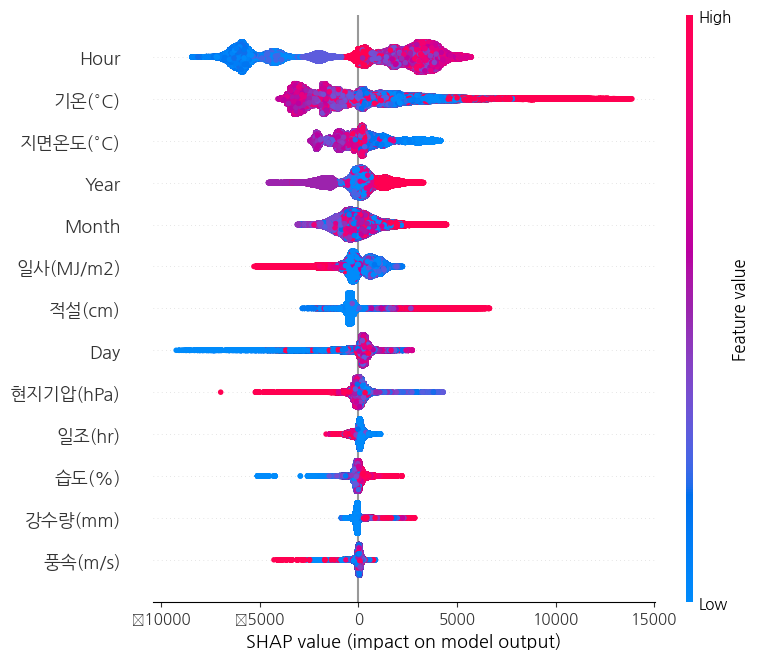

In [11]:
import shap
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X, y)


explainer = shap.Explainer(model)



shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

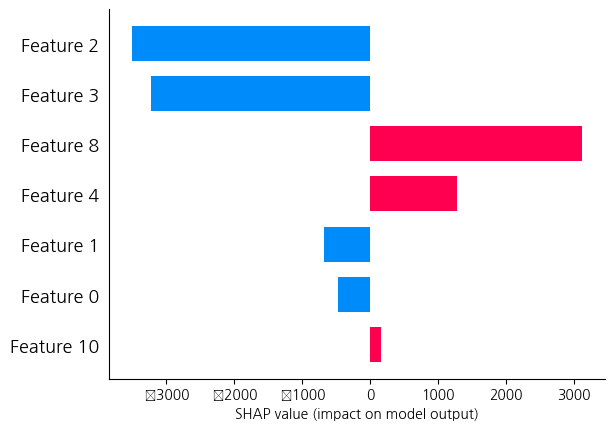

In [12]:
shap.bar_plot(shap_values[0])

In [13]:
import numpy as np

# Calculate mean absolute SHAP values
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Print feature importance
shap = []
for feature_name, mean_value in zip(X.keys(), mean_shap_values):
    print(f"{feature_name}: {mean_value}")
    shap.append([mean_value,feature_name])


Year: 845.3539762089192
Month: 756.901857107821
Day: 485.22956731564994
Hour: 3393.7727346934494
기온(°C): 2293.5181724824206
풍속(m/s): 97.46997985704144
습도(%): 194.71394678550735
현지기압(hPa): 232.39807080586172
지면온도(°C): 964.3186486055697
강수량(mm): 165.10057191522782
적설(cm): 651.8193713115915
일조(hr): 198.27233434459652
일사(MJ/m2): 700.3101475161301


In [14]:
shap = pd.DataFrame(shap, columns=['value', 'features'])

In [15]:
shap.sort_values('value', ascending=False, inplace=True)

In [16]:
shap['rank'] = [i for i in range(1, len(shap) + 1)]

In [17]:
shap.rename(columns={'rank':'shap_rank'}, inplace=True)

In [18]:
mrmr

,rank,features
0,1,Hour
1,2,적설(cm)
2,3,일조(hr)
3,4,풍속(m/s)
4,5,Year
5,6,습도(%)
6,7,기온(°C)
7,8,일사(MJ/m2)
8,9,Day
9,10,현지기압(hPa)


In [19]:
mrmr.set_index(['features'], inplace=True)
shap.set_index(['features'], inplace=True)

In [20]:
shap

,value,shap_rank
features,,
Hour,3393.772735,1
기온(°C),2293.518172,2
지면온도(°C),964.318649,3
Year,845.353976,4
Month,756.901857,5
일사(MJ/m2),700.310148,6
적설(cm),651.819371,7
Day,485.229567,8
현지기압(hPa),232.398071,9


In [21]:
merge_df = pd.merge(mrmr, shap, left_index=True, right_index=True)
merge_df.drop('value', axis=1, inplace=True)

In [22]:
merge_df['sum'] = (merge_df['rank'] ** 2) + (merge_df['shap_rank'] **2)

In [23]:
merge_df.sort_values('sum', ascending=True, inplace=True)

In [57]:
merge_df

,rank,shap_rank,sum
features,,,
Hour,1,1,2
Year,5,4,41
적설(cm),2,7,53
기온(°C),7,2,53
일사(MJ/m2),8,6,100
일조(hr),3,10,109
Day,9,8,145
Month,11,5,146
지면온도(°C),12,3,153


# 인덱스 순위

In [58]:
merge_df.index

Index(['Hour', 'Year', '적설(cm)', '기온(°C)', '일사(MJ/m2)', '일조(hr)', 'Day',
       'Month', '지면온도(°C)', '습도(%)', '현지기압(hPa)', '풍속(m/s)', '강수량(mm)'],
      dtype='object', name='features')

In [59]:
index = ['Hour', 'Year', '기온(°C)', '일사(MJ/m2)', '일조(hr)', 'Day',
       'Month', '지면온도(°C)', '습도(%)', '현지기압(hPa)', '풍속(m/s)', '강수량(mm)']

In [65]:
X = X[index[:-5]]
X

,Hour,Year,기온(°C),일사(MJ/m2),일조(hr),Day,Month
2018-01-01 00:00:00,0,2018,-1.298947,0.0,0.0,1,1
2018-01-01 00:05:00,0,2018,-1.327281,0.0,0.0,1,1
2018-01-01 00:10:00,0,2018,-1.355614,0.0,0.0,1,1
2018-01-01 00:15:00,0,2018,-1.383947,0.0,0.0,1,1
2018-01-01 00:20:00,0,2018,-1.412281,0.0,0.0,1,1
...,...,...,...,...,...,...,...
2023-03-12 23:35:00,23,2023,1.765000,0.0,0.0,12,3
2023-03-12 23:40:00,23,2023,1.720000,0.0,0.0,12,3
2023-03-12 23:45:00,23,2023,1.675000,0.0,0.0,12,3
2023-03-12 23:50:00,23,2023,1.630000,0.0,0.0,12,3


In [66]:
X_test = X_test.reindex(columns=index)

X_test = X_test.iloc[:, :-5]

In [67]:
X.shape, X_test.shape, y.shape, y_test.shape

((546336, 7), (2016, 7), (546336,), (2016,))

# XGBoost

In [70]:
import xgboost as xgb


dtrain = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test, label=y_test)


def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mape',
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'eta': trial.suggest_loguniform('eta', 0.01, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
    }

    bst = xgb.train(params, dtrain)
    preds = bst.predict(xgb.DMatrix(X_test))
    mape = mean_absolute_percentage_error(y_test, preds)
    print("MAPE: {}".format(mape))
    return mape

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)

print(study.best_trial)
print(study.best_value)

[I 2023-07-19 15:09:59,425] A new study created in memory with name: no-name-c1d8c3dc-e965-4059-8bc0-f5f688a08d56
[I 2023-07-19 15:09:59,825] Trial 0 finished with value: 0.0775288547363004 and parameters: {'max_depth': 6, 'eta': 0.38231769953234446, 'gamma': 0.017918625360300765, 'subsample': 0.2729867115952755, 'colsample_bytree': 0.41503295506704574}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.0775288547363004


[I 2023-07-19 15:10:00,450] Trial 1 finished with value: 0.08204633227530239 and parameters: {'max_depth': 7, 'eta': 0.4084984234186786, 'gamma': 0.0972362339300481, 'subsample': 0.6938444158442661, 'colsample_bytree': 0.6463434841116498}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.08204633227530239


[I 2023-07-19 15:10:00,875] Trial 2 finished with value: 0.0786504632994467 and parameters: {'max_depth': 9, 'eta': 0.26482852056592787, 'gamma': 0.38216816632630046, 'subsample': 0.7740407436467535, 'colsample_bytree': 0.11094612768702203}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.0786504632994467


[I 2023-07-19 15:10:01,239] Trial 3 finished with value: 0.14821115338218166 and parameters: {'max_depth': 5, 'eta': 0.15660598326289343, 'gamma': 0.26556102241566437, 'subsample': 0.36573108728563897, 'colsample_bytree': 0.2888476625462796}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.14821115338218166


[I 2023-07-19 15:10:01,456] Trial 4 finished with value: 0.8837039786868435 and parameters: {'max_depth': 2, 'eta': 0.011716641507049383, 'gamma': 0.29801802244282943, 'subsample': 0.6664255885840441, 'colsample_bytree': 0.42326332281045287}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.8837039786868435


[I 2023-07-19 15:10:01,941] Trial 5 finished with value: 0.8942650344943918 and parameters: {'max_depth': 6, 'eta': 0.010918075182159162, 'gamma': 0.4429398854752928, 'subsample': 0.34945211226935285, 'colsample_bytree': 0.9964519868748324}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.8942650344943918


[I 2023-07-19 15:10:02,276] Trial 6 finished with value: 0.8158934187171238 and parameters: {'max_depth': 5, 'eta': 0.019811782205738794, 'gamma': 0.1180913140853046, 'subsample': 0.16936249319524652, 'colsample_bytree': 0.9963834118227771}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.8158934187171238


[I 2023-07-19 15:10:02,826] Trial 7 finished with value: 0.8359730602633122 and parameters: {'max_depth': 5, 'eta': 0.017371092829548837, 'gamma': 0.1635210193153937, 'subsample': 0.8508887503630304, 'colsample_bytree': 0.9977602991963149}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.8359730602633122


[I 2023-07-19 15:10:03,163] Trial 8 finished with value: 0.07805670409460684 and parameters: {'max_depth': 5, 'eta': 0.34359743625867784, 'gamma': 0.2870883121059009, 'subsample': 0.6324927676258653, 'colsample_bytree': 0.19983987619524485}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.07805670409460684


[I 2023-07-19 15:10:03,395] Trial 9 finished with value: 0.32169798701374724 and parameters: {'max_depth': 3, 'eta': 0.10461036070687929, 'gamma': 0.31743851362160336, 'subsample': 0.2605218733034388, 'colsample_bytree': 0.8302515741421708}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.32169798701374724


[I 2023-07-19 15:10:04,200] Trial 10 finished with value: 0.08879885558263868 and parameters: {'max_depth': 10, 'eta': 0.6297892924419122, 'gamma': 0.012824274270648563, 'subsample': 0.9928384480229331, 'colsample_bytree': 0.5064345751525404}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.08879885558263868


[I 2023-07-19 15:10:04,786] Trial 11 finished with value: 0.07795851757231677 and parameters: {'max_depth': 8, 'eta': 0.77252773130284, 'gamma': 0.9812157493753196, 'subsample': 0.5192523507574764, 'colsample_bytree': 0.2947759187817928}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.07795851757231677


[I 2023-07-19 15:10:05,357] Trial 12 finished with value: 0.08298413822052136 and parameters: {'max_depth': 8, 'eta': 0.9437761949258812, 'gamma': 0.8146604565375024, 'subsample': 0.4634913011297481, 'colsample_bytree': 0.3503782864583088}. Best is trial 0 with value: 0.0775288547363004.


MAPE: 0.08298413822052136


[I 2023-07-19 15:10:05,877] Trial 13 finished with value: 0.07090838997365545 and parameters: {'max_depth': 7, 'eta': 0.9499982175438889, 'gamma': 0.0482301331495118, 'subsample': 0.4936408667275813, 'colsample_bytree': 0.31129169694234815}. Best is trial 13 with value: 0.07090838997365545.
[I 2023-07-19 15:10:06,062] Trial 14 finished with value: 0.07448022677599705 and parameters: {'max_depth': 3, 'eta': 0.5206915733558206, 'gamma': 0.02883725152604009, 'subsample': 0.1338091510879949, 'colsample_bytree': 0.49932095749469363}. Best is trial 13 with value: 0.07090838997365545.


MAPE: 0.07090838997365545
MAPE: 0.07448022677599705


[I 2023-07-19 15:10:06,254] Trial 15 finished with value: 0.07387441942519848 and parameters: {'max_depth': 3, 'eta': 0.9666478705910146, 'gamma': 0.037628446724911814, 'subsample': 0.12224404223191344, 'colsample_bytree': 0.5846959245591971}. Best is trial 13 with value: 0.07090838997365545.
[I 2023-07-19 15:10:06,436] Trial 16 finished with value: 0.08180679317371359 and parameters: {'max_depth': 1, 'eta': 0.9765613737703331, 'gamma': 0.050843537395340366, 'subsample': 0.5063494938796116, 'colsample_bytree': 0.6217707144041033}. Best is trial 13 with value: 0.07090838997365545.


MAPE: 0.07387441942519848
MAPE: 0.08180679317371359


[I 2023-07-19 15:10:06,632] Trial 17 finished with value: 0.12487893668226767 and parameters: {'max_depth': 3, 'eta': 0.19416033261562696, 'gamma': 0.042135387669653517, 'subsample': 0.13247586806515774, 'colsample_bytree': 0.6168724590681545}. Best is trial 13 with value: 0.07090838997365545.


MAPE: 0.12487893668226767


[I 2023-07-19 15:10:06,970] Trial 18 finished with value: 0.06937403197950197 and parameters: {'max_depth': 4, 'eta': 0.5300974323079177, 'gamma': 0.059101882763097524, 'subsample': 0.3760376035618145, 'colsample_bytree': 0.6954464657325843}. Best is trial 18 with value: 0.06937403197950197.


MAPE: 0.06937403197950197


[I 2023-07-19 15:10:07,600] Trial 19 finished with value: 0.0672880830810525 and parameters: {'max_depth': 7, 'eta': 0.5730652413393319, 'gamma': 0.06717197465475626, 'subsample': 0.42291747550223435, 'colsample_bytree': 0.7242576093535832}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.0672880830810525


[I 2023-07-19 15:10:07,991] Trial 20 finished with value: 0.06762095873432167 and parameters: {'max_depth': 4, 'eta': 0.5654649381297207, 'gamma': 0.07334184009000179, 'subsample': 0.4342407848044366, 'colsample_bytree': 0.7338353041091605}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06762095873432167


[I 2023-07-19 15:10:08,381] Trial 21 finished with value: 0.06772162577137436 and parameters: {'max_depth': 4, 'eta': 0.5365778522195269, 'gamma': 0.07663038614872146, 'subsample': 0.4038630767373309, 'colsample_bytree': 0.7277193971332667}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06772162577137436


[I 2023-07-19 15:10:08,769] Trial 22 finished with value: 0.0826747609739405 and parameters: {'max_depth': 4, 'eta': 0.28137137063477735, 'gamma': 0.08830758974238503, 'subsample': 0.44266170994856047, 'colsample_bytree': 0.7519520869011387}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.0826747609739405


[I 2023-07-19 15:10:09,184] Trial 23 finished with value: 0.07006063177842071 and parameters: {'max_depth': 4, 'eta': 0.5741244601881952, 'gamma': 0.073766141283344, 'subsample': 0.5905135466421476, 'colsample_bytree': 0.7884832506909809}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07006063177842071


[I 2023-07-19 15:10:09,851] Trial 24 finished with value: 0.07705625424832073 and parameters: {'max_depth': 7, 'eta': 0.4627439010225982, 'gamma': 0.1395836738822214, 'subsample': 0.5723139923862189, 'colsample_bytree': 0.8531268023350989}. Best is trial 19 with value: 0.0672880830810525.
[I 2023-07-19 15:10:10,032] Trial 25 finished with value: 0.09211101540434648 and parameters: {'max_depth': 1, 'eta': 0.24565141612074456, 'gamma': 0.07447144782860529, 'subsample': 0.41917329219225763, 'colsample_bytree': 0.7031729803202654}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07705625424832073
MAPE: 0.09211101540434648


[I 2023-07-19 15:10:10,492] Trial 26 finished with value: 0.06846896353708302 and parameters: {'max_depth': 6, 'eta': 0.6351272147875752, 'gamma': 0.029108305849952883, 'subsample': 0.3028130702351469, 'colsample_bytree': 0.7158069570168465}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06846896353708302


[I 2023-07-19 15:10:10,741] Trial 27 finished with value: 0.07658980959708503 and parameters: {'max_depth': 2, 'eta': 0.3661789533850699, 'gamma': 0.16675678149983655, 'subsample': 0.43032085925025004, 'colsample_bytree': 0.8751469648238628}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07658980959708503


[I 2023-07-19 15:10:11,168] Trial 28 finished with value: 0.06920227786400036 and parameters: {'max_depth': 4, 'eta': 0.6835866092346594, 'gamma': 0.06863908792961983, 'subsample': 0.5409685006335472, 'colsample_bytree': 0.7766875239135081}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06920227786400036


[I 2023-07-19 15:10:11,560] Trial 29 finished with value: 0.0717733286484983 and parameters: {'max_depth': 6, 'eta': 0.37594892497811594, 'gamma': 0.022893198195378283, 'subsample': 0.30433997792085377, 'colsample_bytree': 0.5467218646223088}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.0717733286484983


[I 2023-07-19 15:10:12,045] Trial 30 finished with value: 0.14971933533725082 and parameters: {'max_depth': 8, 'eta': 0.17550483169531564, 'gamma': 0.10967989819834824, 'subsample': 0.2349938506133876, 'colsample_bytree': 0.6806790539806895}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.14971933533725082


[I 2023-07-19 15:10:12,507] Trial 31 finished with value: 0.09788303103685436 and parameters: {'max_depth': 6, 'eta': 0.6478799407507478, 'gamma': 0.03332282354853665, 'subsample': 0.30406993668321736, 'colsample_bytree': 0.7312509669360913}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.09788303103685436


[I 2023-07-19 15:10:13,076] Trial 32 finished with value: 0.08037975199990666 and parameters: {'max_depth': 7, 'eta': 0.5028759763971783, 'gamma': 0.0564424370013186, 'subsample': 0.3905504028422409, 'colsample_bytree': 0.6625653624114324}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.08037975199990666


[I 2023-07-19 15:10:13,523] Trial 33 finished with value: 0.0722435272497218 and parameters: {'max_depth': 5, 'eta': 0.4037264348797776, 'gamma': 0.02466916652114344, 'subsample': 0.4616976259889063, 'colsample_bytree': 0.645921579087579}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.0722435272497218


[I 2023-07-19 15:10:14,086] Trial 34 finished with value: 0.06799506715656059 and parameters: {'max_depth': 7, 'eta': 0.679228012640658, 'gamma': 0.01900590899697325, 'subsample': 0.3303825532426408, 'colsample_bytree': 0.7385788322757068}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06799506715656059


[I 2023-07-19 15:10:14,644] Trial 35 finished with value: 0.07402664328085529 and parameters: {'max_depth': 7, 'eta': 0.2904560669385095, 'gamma': 0.016661640981972477, 'subsample': 0.35319097459164667, 'colsample_bytree': 0.7700722810079144}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07402664328085529


[I 2023-07-19 15:10:15,402] Trial 36 finished with value: 0.08518256362143548 and parameters: {'max_depth': 9, 'eta': 0.44911752212672995, 'gamma': 0.0105999874043129, 'subsample': 0.39599443935976525, 'colsample_bytree': 0.8040958817455051}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.08518256362143548


[I 2023-07-19 15:10:16,015] Trial 37 finished with value: 0.07719041989831696 and parameters: {'max_depth': 9, 'eta': 0.7681446591837725, 'gamma': 0.04438343117492439, 'subsample': 0.22843403014617944, 'colsample_bytree': 0.8820587998306288}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07719041989831696


[I 2023-07-19 15:10:16,234] Trial 38 finished with value: 0.0986856430004256 and parameters: {'max_depth': 2, 'eta': 0.2332883574144388, 'gamma': 0.06441042289560174, 'subsample': 0.32743960538776645, 'colsample_bytree': 0.7187191154288173}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.0986856430004256


[I 2023-07-19 15:10:16,830] Trial 39 finished with value: 0.08071795591245531 and parameters: {'max_depth': 8, 'eta': 0.33812486806220765, 'gamma': 0.0883940109860767, 'subsample': 0.36118342187444835, 'colsample_bytree': 0.6570735507596707}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.08071795591245531


[I 2023-07-19 15:10:17,398] Trial 40 finished with value: 0.070048530455234 and parameters: {'max_depth': 6, 'eta': 0.4328004615444261, 'gamma': 0.018359105676494788, 'subsample': 0.4718748602510091, 'colsample_bytree': 0.9279216991097465}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.070048530455234


[I 2023-07-19 15:10:17,795] Trial 41 finished with value: 0.06821810781521971 and parameters: {'max_depth': 5, 'eta': 0.7210899661073876, 'gamma': 0.03492347529994071, 'subsample': 0.3033047312451176, 'colsample_bytree': 0.7413949234493104}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06821810781521971


[I 2023-07-19 15:10:18,241] Trial 42 finished with value: 0.07172032827812708 and parameters: {'max_depth': 5, 'eta': 0.7464489613230668, 'gamma': 0.03690386696407372, 'subsample': 0.4058218000319893, 'colsample_bytree': 0.8129060374145499}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07172032827812708


[I 2023-07-19 15:10:18,545] Trial 43 finished with value: 0.06819201092077333 and parameters: {'max_depth': 4, 'eta': 0.5406532441726689, 'gamma': 0.049803223968405815, 'subsample': 0.2529013102568026, 'colsample_bytree': 0.7429594188240025}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06819201092077333


[I 2023-07-19 15:10:18,822] Trial 44 finished with value: 0.06983295383087229 and parameters: {'max_depth': 4, 'eta': 0.5387409294759812, 'gamma': 0.0527809495803233, 'subsample': 0.20613139673297662, 'colsample_bytree': 0.7655288779224546}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06983295383087229


[I 2023-07-19 15:10:19,128] Trial 45 finished with value: 0.07322334809915335 and parameters: {'max_depth': 4, 'eta': 0.3431121329714548, 'gamma': 0.09127586908261714, 'subsample': 0.26838237270568144, 'colsample_bytree': 0.8287278698340217}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07322334809915335


[I 2023-07-19 15:10:19,403] Trial 46 finished with value: 0.06757483649498963 and parameters: {'max_depth': 3, 'eta': 0.8075733237255112, 'gamma': 0.04448703517464922, 'subsample': 0.3424413971853431, 'colsample_bytree': 0.6858328019426057}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06757483649498963


[I 2023-07-19 15:10:19,624] Trial 47 finished with value: 0.07508205392380755 and parameters: {'max_depth': 2, 'eta': 0.8257118153861632, 'gamma': 0.12190510292721318, 'subsample': 0.3661461652942317, 'colsample_bytree': 0.6862822819575586}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07508205392380755


[I 2023-07-19 15:10:19,926] Trial 48 finished with value: 0.06940082290817766 and parameters: {'max_depth': 3, 'eta': 0.8382144515178506, 'gamma': 0.045109063313168773, 'subsample': 0.4266077106820562, 'colsample_bytree': 0.6096795804159464}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06940082290817766


[I 2023-07-19 15:10:20,548] Trial 49 finished with value: 0.08463625806452196 and parameters: {'max_depth': 7, 'eta': 0.6146338743700572, 'gamma': 0.06429732181129567, 'subsample': 0.4905294521713962, 'colsample_bytree': 0.5813361746191457}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.08463625806452196


[I 2023-07-19 15:10:20,942] Trial 50 finished with value: 0.25649685459538407 and parameters: {'max_depth': 5, 'eta': 0.11973449338648717, 'gamma': 0.10179485277104923, 'subsample': 0.34664066086283624, 'colsample_bytree': 0.6691407382220615}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.25649685459538407


[I 2023-07-19 15:10:21,193] Trial 51 finished with value: 0.0734331584732612 and parameters: {'max_depth': 3, 'eta': 0.5226726768852326, 'gamma': 0.0544420084887127, 'subsample': 0.26323055744134183, 'colsample_bytree': 0.7401620290554061}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.0734331584732612


[I 2023-07-19 15:10:21,477] Trial 52 finished with value: 0.07377970617405946 and parameters: {'max_depth': 4, 'eta': 0.9849949817497435, 'gamma': 0.07938714751887879, 'subsample': 0.20319385095880735, 'colsample_bytree': 0.7885456109125114}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07377970617405946


[I 2023-07-19 15:10:21,761] Trial 53 finished with value: 0.07191271316676286 and parameters: {'max_depth': 3, 'eta': 0.4388798052138342, 'gamma': 0.040824539010497485, 'subsample': 0.3886336430476244, 'colsample_bytree': 0.7028913196414424}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07191271316676286


[I 2023-07-19 15:10:22,159] Trial 54 finished with value: 0.06913434453364838 and parameters: {'max_depth': 4, 'eta': 0.6139333222058622, 'gamma': 0.0512036778787695, 'subsample': 0.4437863067457401, 'colsample_bytree': 0.7497331233617378}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.06913434453364838


[I 2023-07-19 15:10:22,380] Trial 55 finished with value: 0.07283086497068898 and parameters: {'max_depth': 2, 'eta': 0.5614832428114618, 'gamma': 0.06381327429282098, 'subsample': 0.33503194859788443, 'colsample_bytree': 0.6492530709398141}. Best is trial 19 with value: 0.0672880830810525.


MAPE: 0.07283086497068898


[I 2023-07-19 15:10:22,873] Trial 56 finished with value: 0.06224625514730801 and parameters: {'max_depth': 5, 'eta': 0.7166208629853581, 'gamma': 0.029963539998949372, 'subsample': 0.524763828614077, 'colsample_bytree': 0.7193363617727435}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.06224625514730801


[I 2023-07-19 15:10:23,342] Trial 57 finished with value: 0.0710071052356079 and parameters: {'max_depth': 5, 'eta': 0.7852056993978191, 'gamma': 0.03100147596589957, 'subsample': 0.5067352952655485, 'colsample_bytree': 0.7032799215227433}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.0710071052356079


[I 2023-07-19 15:10:23,911] Trial 58 finished with value: 0.10531631378658621 and parameters: {'max_depth': 6, 'eta': 0.8570980298989552, 'gamma': 0.03935847796702639, 'subsample': 0.4699875507170076, 'colsample_bytree': 0.8066520520125469}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.10531631378658621


[I 2023-07-19 15:10:24,475] Trial 59 finished with value: 0.06928543490489766 and parameters: {'max_depth': 6, 'eta': 0.6995867935043922, 'gamma': 0.07479604156891373, 'subsample': 0.5264771841740306, 'colsample_bytree': 0.6410769181096716}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.06928543490489766


[I 2023-07-19 15:10:24,779] Trial 60 finished with value: 0.0729117850636671 and parameters: {'max_depth': 3, 'eta': 0.4714094674068135, 'gamma': 0.02355115016661827, 'subsample': 0.41499062520513014, 'colsample_bytree': 0.7747626321267127}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.0729117850636671


[I 2023-07-19 15:10:25,146] Trial 61 finished with value: 0.06930015963392509 and parameters: {'max_depth': 4, 'eta': 0.5958355744466436, 'gamma': 0.04654133307693756, 'subsample': 0.3800487942060633, 'colsample_bytree': 0.7231317240827845}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.06930015963392509


[I 2023-07-19 15:10:25,619] Trial 62 finished with value: 0.0666323255529366 and parameters: {'max_depth': 5, 'eta': 0.852464133853972, 'gamma': 0.027478552548246604, 'subsample': 0.5730355500643567, 'colsample_bytree': 0.6879902351411783}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.0666323255529366


[I 2023-07-19 15:10:26,104] Trial 63 finished with value: 0.07146271817569759 and parameters: {'max_depth': 5, 'eta': 0.897928354586908, 'gamma': 0.02797058947586181, 'subsample': 0.5450693130272473, 'colsample_bytree': 0.6819946291177521}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.07146271817569759


[I 2023-07-19 15:10:26,584] Trial 64 finished with value: 0.09125762553093146 and parameters: {'max_depth': 5, 'eta': 0.6905500455879799, 'gamma': 0.031089045474390713, 'subsample': 0.6265372660484838, 'colsample_bytree': 0.6271173295097422}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.09125762553093146


[I 2023-07-19 15:10:27,220] Trial 65 finished with value: 0.06881793734333264 and parameters: {'max_depth': 7, 'eta': 0.8961473430504775, 'gamma': 0.018889295761136706, 'subsample': 0.5744716033947805, 'colsample_bytree': 0.6788091650785529}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.06881793734333264


[I 2023-07-19 15:10:27,806] Trial 66 finished with value: 0.07450788750476274 and parameters: {'max_depth': 6, 'eta': 0.9820830605728679, 'gamma': 0.03583002044014242, 'subsample': 0.4871997472257986, 'colsample_bytree': 0.7191632307921871}. Best is trial 56 with value: 0.06224625514730801.


MAPE: 0.07450788750476274


[I 2023-07-19 15:10:28,545] Trial 67 finished with value: 0.059622472321047455 and parameters: {'max_depth': 8, 'eta': 0.6799542422199513, 'gamma': 0.0269569180270127, 'subsample': 0.4508505924886915, 'colsample_bytree': 0.7521536081403759}. Best is trial 67 with value: 0.059622472321047455.


MAPE: 0.059622472321047455


[I 2023-07-19 15:10:29,269] Trial 68 finished with value: 0.07736512807626174 and parameters: {'max_depth': 8, 'eta': 0.3837879379860641, 'gamma': 0.05982100767572813, 'subsample': 0.4569765532779043, 'colsample_bytree': 0.7702386263427452}. Best is trial 67 with value: 0.059622472321047455.


MAPE: 0.07736512807626174


[I 2023-07-19 15:10:30,169] Trial 69 finished with value: 0.05657255513502402 and parameters: {'max_depth': 10, 'eta': 0.7929019287302822, 'gamma': 0.03883861194979356, 'subsample': 0.5146660280149447, 'colsample_bytree': 0.6017699060380286}. Best is trial 69 with value: 0.05657255513502402.


MAPE: 0.05657255513502402


[I 2023-07-19 15:10:31,070] Trial 70 finished with value: 0.07823290753842485 and parameters: {'max_depth': 10, 'eta': 0.7745444256891886, 'gamma': 0.040245520992576875, 'subsample': 0.5503004418768584, 'colsample_bytree': 0.6062901153853164}. Best is trial 69 with value: 0.05657255513502402.


MAPE: 0.07823290753842485


[I 2023-07-19 15:10:31,948] Trial 71 finished with value: 0.057141617557539486 and parameters: {'max_depth': 10, 'eta': 0.6126205208268519, 'gamma': 0.02742996093733925, 'subsample': 0.5162873977826496, 'colsample_bytree': 0.6946378632846435}. Best is trial 69 with value: 0.05657255513502402.


MAPE: 0.057141617557539486


[I 2023-07-19 15:10:32,850] Trial 72 finished with value: 0.05434088814500894 and parameters: {'max_depth': 10, 'eta': 0.6397200691156777, 'gamma': 0.026385517053152695, 'subsample': 0.5252839203302639, 'colsample_bytree': 0.6676180150093337}. Best is trial 72 with value: 0.05434088814500894.


MAPE: 0.05434088814500894


[I 2023-07-19 15:10:33,751] Trial 73 finished with value: 0.07999502827991828 and parameters: {'max_depth': 10, 'eta': 0.6559512054891578, 'gamma': 0.027296065861203395, 'subsample': 0.5182443371535077, 'colsample_bytree': 0.5810959329451875}. Best is trial 72 with value: 0.05434088814500894.


MAPE: 0.07999502827991828


[I 2023-07-19 15:10:34,651] Trial 74 finished with value: 0.07493311549325092 and parameters: {'max_depth': 10, 'eta': 0.47426498094297176, 'gamma': 0.02192816513439009, 'subsample': 0.6048277308291412, 'colsample_bytree': 0.6616660165159218}. Best is trial 72 with value: 0.05434088814500894.


MAPE: 0.07493311549325092


[I 2023-07-19 15:10:35,483] Trial 75 finished with value: 0.06854861571443932 and parameters: {'max_depth': 9, 'eta': 0.8353754986761803, 'gamma': 0.02670561028713293, 'subsample': 0.5562167872188811, 'colsample_bytree': 0.6326862723654807}. Best is trial 72 with value: 0.05434088814500894.


MAPE: 0.06854861571443932


[I 2023-07-19 15:10:36,300] Trial 76 finished with value: 0.051345090120524614 and parameters: {'max_depth': 9, 'eta': 0.7317441675819162, 'gamma': 0.03271669341315875, 'subsample': 0.5110188664122255, 'colsample_bytree': 0.6875007833690349}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.051345090120524614


[I 2023-07-19 15:10:37,015] Trial 77 finished with value: 0.07237369262060737 and parameters: {'max_depth': 9, 'eta': 0.6109647825040353, 'gamma': 0.03304106644038549, 'subsample': 0.5015419572729245, 'colsample_bytree': 0.5328453498352254}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07237369262060737


[I 2023-07-19 15:10:38,024] Trial 78 finished with value: 0.08179597141555665 and parameters: {'max_depth': 10, 'eta': 0.9979036246420532, 'gamma': 0.020883110478577126, 'subsample': 0.5793934024212917, 'colsample_bytree': 0.6023067545246055}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.08179597141555665


[I 2023-07-19 15:10:38,942] Trial 79 finished with value: 0.06962359107143705 and parameters: {'max_depth': 10, 'eta': 0.7031062162479527, 'gamma': 0.030547736869861727, 'subsample': 0.5333201378826005, 'colsample_bytree': 0.7054057403553732}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06962359107143705


[I 2023-07-19 15:10:39,729] Trial 80 finished with value: 0.07359891825462178 and parameters: {'max_depth': 9, 'eta': 0.4031320588887439, 'gamma': 0.024591814323752677, 'subsample': 0.5198228522196086, 'colsample_bytree': 0.6766932258411574}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07359891825462178


[I 2023-07-19 15:10:40,452] Trial 81 finished with value: 0.06268236049606166 and parameters: {'max_depth': 8, 'eta': 0.743193883690512, 'gamma': 0.0353787515007017, 'subsample': 0.4792869315810274, 'colsample_bytree': 0.6948110264169483}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06268236049606166


[I 2023-07-19 15:10:41,167] Trial 82 finished with value: 0.05605901234507506 and parameters: {'max_depth': 8, 'eta': 0.5041421520731838, 'gamma': 0.02599719199607173, 'subsample': 0.47435605195670305, 'colsample_bytree': 0.6448637197118822}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.05605901234507506


[I 2023-07-19 15:10:41,893] Trial 83 finished with value: 0.06836620337571694 and parameters: {'max_depth': 8, 'eta': 0.7357477343102671, 'gamma': 0.024577622320866778, 'subsample': 0.48567197050435706, 'colsample_bytree': 0.6435350393241898}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06836620337571694


[I 2023-07-19 15:10:42,575] Trial 84 finished with value: 0.07262745113632961 and parameters: {'max_depth': 8, 'eta': 0.5012060753653631, 'gamma': 0.03410543081858237, 'subsample': 0.45738912957204597, 'colsample_bytree': 0.6225075070111628}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07262745113632961


[I 2023-07-19 15:10:43,412] Trial 85 finished with value: 0.07532723738317768 and parameters: {'max_depth': 9, 'eta': 0.6233585707762721, 'gamma': 0.016575028569789603, 'subsample': 0.5596943854290352, 'colsample_bytree': 0.699275244823382}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07532723738317768


[I 2023-07-19 15:10:44,342] Trial 86 finished with value: 0.07333496305075113 and parameters: {'max_depth': 10, 'eta': 0.8803255026032294, 'gamma': 0.029745098323386357, 'subsample': 0.5305175262179357, 'colsample_bytree': 0.6614422074053552}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07333496305075113


[I 2023-07-19 15:10:45,152] Trial 87 finished with value: 0.0696080729538412 and parameters: {'max_depth': 9, 'eta': 0.764742064845545, 'gamma': 0.026571043382057458, 'subsample': 0.5036423246545864, 'colsample_bytree': 0.5744897087768661}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.0696080729538412


[I 2023-07-19 15:10:46,120] Trial 88 finished with value: 0.08908227394964421 and parameters: {'max_depth': 10, 'eta': 0.4881286615031244, 'gamma': 0.020489846627604842, 'subsample': 0.6078962564199426, 'colsample_bytree': 0.7578009850235812}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.08908227394964421


[I 2023-07-19 15:10:46,842] Trial 89 finished with value: 0.07180845442152187 and parameters: {'max_depth': 8, 'eta': 0.5656124963021756, 'gamma': 0.03598768558407422, 'subsample': 0.48142479284557066, 'colsample_bytree': 0.6591517067223946}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07180845442152187


[I 2023-07-19 15:10:47,663] Trial 90 finished with value: 0.07342728131672983 and parameters: {'max_depth': 9, 'eta': 0.6568472711606941, 'gamma': 0.02193651183027845, 'subsample': 0.6566300749211404, 'colsample_bytree': 0.6014577614495393}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07342728131672983


[I 2023-07-19 15:10:48,351] Trial 91 finished with value: 0.06540833546058618 and parameters: {'max_depth': 8, 'eta': 0.5815658623175892, 'gamma': 0.03873368783473937, 'subsample': 0.43402244834391424, 'colsample_bytree': 0.7121744169633782}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06540833546058618


[I 2023-07-19 15:10:49,088] Trial 92 finished with value: 0.08644446807984527 and parameters: {'max_depth': 8, 'eta': 0.885691362088935, 'gamma': 0.0321647483260162, 'subsample': 0.44644784538370375, 'colsample_bytree': 0.7179099218261856}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.08644446807984527


[I 2023-07-19 15:10:50,001] Trial 93 finished with value: 0.06929763765646564 and parameters: {'max_depth': 10, 'eta': 0.7255570446299465, 'gamma': 0.03891843381107987, 'subsample': 0.5101987695505514, 'colsample_bytree': 0.6858921096087708}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06929763765646564


[I 2023-07-19 15:10:50,794] Trial 94 finished with value: 0.0685785429095984 and parameters: {'max_depth': 9, 'eta': 0.5643723625636117, 'gamma': 0.02948113990738458, 'subsample': 0.47315174900492685, 'colsample_bytree': 0.6321428383920165}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.0685785429095984


[I 2023-07-19 15:10:51,539] Trial 95 finished with value: 0.0716208965529967 and parameters: {'max_depth': 8, 'eta': 0.7999633696202205, 'gamma': 0.025095255929597264, 'subsample': 0.4369876843466548, 'colsample_bytree': 0.7503144850201748}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.0716208965529967


[I 2023-07-19 15:10:52,394] Trial 96 finished with value: 0.07689573447088459 and parameters: {'max_depth': 9, 'eta': 0.42155428282059754, 'gamma': 0.04213670103716841, 'subsample': 0.5363973945029179, 'colsample_bytree': 0.7324606350601472}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07689573447088459


[I 2023-07-19 15:10:53,194] Trial 97 finished with value: 0.06288400019515233 and parameters: {'max_depth': 9, 'eta': 0.6569121492832728, 'gamma': 0.02690121864327423, 'subsample': 0.4930205468677377, 'colsample_bytree': 0.6976365030390046}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06288400019515233


[I 2023-07-19 15:10:54,040] Trial 98 finished with value: 0.07863417651668836 and parameters: {'max_depth': 9, 'eta': 0.5166932174296847, 'gamma': 0.03429602452934199, 'subsample': 0.49137075947567943, 'colsample_bytree': 0.7147742657440599}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07863417651668836


[I 2023-07-19 15:10:54,863] Trial 99 finished with value: 0.07396261478924758 and parameters: {'max_depth': 10, 'eta': 0.6573439520049542, 'gamma': 0.03770160548230721, 'subsample': 0.41274319744704324, 'colsample_bytree': 0.6622426063936461}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07396261478924758


[I 2023-07-19 15:10:55,563] Trial 100 finished with value: 0.06800317167164661 and parameters: {'max_depth': 8, 'eta': 0.5752561879365208, 'gamma': 0.047597773097976366, 'subsample': 0.4605158472467784, 'colsample_bytree': 0.6434415537817475}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06800317167164661


[I 2023-07-19 15:10:56,510] Trial 101 finished with value: 0.07835086999178437 and parameters: {'max_depth': 10, 'eta': 0.9120257706690352, 'gamma': 0.027344036282856695, 'subsample': 0.5624663507261415, 'colsample_bytree': 0.6940179119341021}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07835086999178437


[I 2023-07-19 15:10:57,246] Trial 102 finished with value: 0.0650866077983429 and parameters: {'max_depth': 8, 'eta': 0.7194940116360428, 'gamma': 0.022932835498419433, 'subsample': 0.5080280507271867, 'colsample_bytree': 0.67453658888827}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.0650866077983429


[I 2023-07-19 15:10:57,895] Trial 103 finished with value: 0.0692091959570943 and parameters: {'max_depth': 7, 'eta': 0.7170780187719179, 'gamma': 0.0228337108943051, 'subsample': 0.5131376983234606, 'colsample_bytree': 0.6693043386312324}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.0692091959570943


[I 2023-07-19 15:10:58,577] Trial 104 finished with value: 0.08172767525376687 and parameters: {'max_depth': 8, 'eta': 0.44743756252474687, 'gamma': 0.02029569689374458, 'subsample': 0.4374048723722448, 'colsample_bytree': 0.7100708610395562}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.08172767525376687


[I 2023-07-19 15:10:59,366] Trial 105 finished with value: 0.07649004545854399 and parameters: {'max_depth': 8, 'eta': 0.6280951177766554, 'gamma': 0.03155072521252457, 'subsample': 0.4833024049661188, 'colsample_bytree': 0.7315644304957671}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07649004545854399


[I 2023-07-19 15:11:00,238] Trial 106 finished with value: 0.06495224599306043 and parameters: {'max_depth': 9, 'eta': 0.5312663484175068, 'gamma': 0.017228871399313457, 'subsample': 0.5464165069745853, 'colsample_bytree': 0.7858745133382773}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06495224599306043


[I 2023-07-19 15:11:01,121] Trial 107 finished with value: 0.0661743663323564 and parameters: {'max_depth': 9, 'eta': 0.5122573805538636, 'gamma': 0.01539913517230968, 'subsample': 0.545142869890012, 'colsample_bytree': 0.7840097794974511}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.0661743663323564


[I 2023-07-19 15:11:02,007] Trial 108 finished with value: 0.06081457849774889 and parameters: {'max_depth': 9, 'eta': 0.7699746374703693, 'gamma': 0.019623201925510123, 'subsample': 0.5292205310664596, 'colsample_bytree': 0.7598633547240047}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.06081457849774889


[I 2023-07-19 15:11:02,882] Trial 109 finished with value: 0.07759243674335761 and parameters: {'max_depth': 9, 'eta': 0.7787001780895014, 'gamma': 0.025692719238949023, 'subsample': 0.5270110054548327, 'colsample_bytree': 0.7898193359863463}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07759243674335761


[I 2023-07-19 15:11:03,788] Trial 110 finished with value: 0.07976355560597007 and parameters: {'max_depth': 10, 'eta': 0.4719113174850852, 'gamma': 0.01767071858771705, 'subsample': 0.4742455656425649, 'colsample_bytree': 0.7703720351311059}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07976355560597007


[I 2023-07-19 15:11:04,645] Trial 111 finished with value: 0.07666028234021943 and parameters: {'max_depth': 9, 'eta': 0.6851980546588649, 'gamma': 0.02265871009841891, 'subsample': 0.4987136783875381, 'colsample_bytree': 0.7580714776813746}. Best is trial 76 with value: 0.051345090120524614.


MAPE: 0.07666028234021943


[I 2023-07-19 15:11:05,544] Trial 112 finished with value: 0.04732036545056652 and parameters: {'max_depth': 9, 'eta': 0.7999591848393559, 'gamma': 0.019858112255903775, 'subsample': 0.544083231809609, 'colsample_bytree': 0.7449982958944158}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.04732036545056652


[I 2023-07-19 15:11:06,481] Trial 113 finished with value: 0.06142611258468113 and parameters: {'max_depth': 9, 'eta': 0.8133890505847161, 'gamma': 0.014513083301853176, 'subsample': 0.5816686026973091, 'colsample_bytree': 0.7416574487110388}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.06142611258468113


[I 2023-07-19 15:11:07,468] Trial 114 finished with value: 0.08753562272277769 and parameters: {'max_depth': 10, 'eta': 0.8178309225519633, 'gamma': 0.0193261575747261, 'subsample': 0.5946286042397793, 'colsample_bytree': 0.7437747650174801}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.08753562272277769


[I 2023-07-19 15:11:08,386] Trial 115 finished with value: 0.07769706744533553 and parameters: {'max_depth': 9, 'eta': 0.9361765806394887, 'gamma': 0.015973420356226828, 'subsample': 0.5629644481824849, 'colsample_bytree': 0.7495611082052811}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.07769706744533553


[I 2023-07-19 15:11:09,317] Trial 116 finished with value: 0.06496962374921528 and parameters: {'max_depth': 10, 'eta': 0.6401346645592587, 'gamma': 0.019703762259244806, 'subsample': 0.5756302274074486, 'colsample_bytree': 0.6988530372227936}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.06496962374921528


[I 2023-07-19 15:11:10,227] Trial 117 finished with value: 0.09476327972232731 and parameters: {'max_depth': 9, 'eta': 0.8146090523587385, 'gamma': 0.029158069038178205, 'subsample': 0.525193566021005, 'colsample_bytree': 0.730773388950527}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.09476327972232731


[I 2023-07-19 15:11:11,208] Trial 118 finished with value: 0.1064146425102319 and parameters: {'max_depth': 10, 'eta': 0.9963654077327389, 'gamma': 0.014522231795091697, 'subsample': 0.45849586075368026, 'colsample_bytree': 0.8197480205931827}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.1064146425102319


[I 2023-07-19 15:11:12,044] Trial 119 finished with value: 0.0756046921510827 and parameters: {'max_depth': 9, 'eta': 0.7419676155938432, 'gamma': 0.012508071396805357, 'subsample': 0.5416039903936567, 'colsample_bytree': 0.6428610120635421}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.0756046921510827


[I 2023-07-19 15:11:12,950] Trial 120 finished with value: 0.069127274000039 and parameters: {'max_depth': 10, 'eta': 0.8908414185839642, 'gamma': 0.02552190522681472, 'subsample': 0.49829279794174747, 'colsample_bytree': 0.6222700927827111}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.069127274000039


[I 2023-07-19 15:11:13,844] Trial 121 finished with value: 0.06504412343327597 and parameters: {'max_depth': 9, 'eta': 0.6045528420382557, 'gamma': 0.017826679485400915, 'subsample': 0.5401874771456354, 'colsample_bytree': 0.8446928823390227}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.06504412343327597


[I 2023-07-19 15:11:14,727] Trial 122 finished with value: 0.08509214424576317 and parameters: {'max_depth': 9, 'eta': 0.5443646299605885, 'gamma': 0.021274613675932218, 'subsample': 0.5547234247810269, 'colsample_bytree': 0.8056068434943593}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.08509214424576317


[I 2023-07-19 15:11:15,603] Trial 123 finished with value: 0.08579314943274763 and parameters: {'max_depth': 9, 'eta': 0.6761715987642527, 'gamma': 0.017666726279444652, 'subsample': 0.518613689794611, 'colsample_bytree': 0.7913588734499035}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.08579314943274763


[I 2023-07-19 15:11:16,494] Trial 124 finished with value: 0.08268600739516477 and parameters: {'max_depth': 9, 'eta': 0.7767162856913387, 'gamma': 0.024202023840809217, 'subsample': 0.5761641478074894, 'colsample_bytree': 0.7702209284923428}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.08268600739516477


[I 2023-07-19 15:11:17,446] Trial 125 finished with value: 0.06304453385338547 and parameters: {'max_depth': 10, 'eta': 0.6790183621040297, 'gamma': 0.027952486757754212, 'subsample': 0.5997097422208484, 'colsample_bytree': 0.6937227139284453}. Best is trial 112 with value: 0.04732036545056652.


MAPE: 0.06304453385338547


[I 2023-07-19 15:11:18,386] Trial 126 finished with value: 0.044735303079905336 and parameters: {'max_depth': 10, 'eta': 0.6702452664816283, 'gamma': 0.029440420845940805, 'subsample': 0.5942168555397169, 'colsample_bytree': 0.6922050999373427}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.044735303079905336


[I 2023-07-19 15:11:19,384] Trial 127 finished with value: 0.09761614312238545 and parameters: {'max_depth': 10, 'eta': 0.8377473517530251, 'gamma': 0.03370489167694397, 'subsample': 0.5878400824261177, 'colsample_bytree': 0.723006872579122}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09761614312238545


[I 2023-07-19 15:11:20,259] Trial 128 finished with value: 0.06820105064133786 and parameters: {'max_depth': 10, 'eta': 0.611180414543711, 'gamma': 0.030757043550692434, 'subsample': 0.47553079636411394, 'colsample_bytree': 0.6571290825422881}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06820105064133786


[I 2023-07-19 15:11:21,214] Trial 129 finished with value: 0.0847895921815623 and parameters: {'max_depth': 10, 'eta': 0.7557931039105946, 'gamma': 0.021515832342489598, 'subsample': 0.6181735298794827, 'colsample_bytree': 0.6785938475484189}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0847895921815623


[I 2023-07-19 15:11:22,214] Trial 130 finished with value: 0.0512678682735713 and parameters: {'max_depth': 10, 'eta': 0.903651323089413, 'gamma': 0.035767079782646885, 'subsample': 0.5901221952690581, 'colsample_bytree': 0.7043547057677708}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0512678682735713


[I 2023-07-19 15:11:23,170] Trial 131 finished with value: 0.07355068650181985 and parameters: {'max_depth': 10, 'eta': 0.9348827879846633, 'gamma': 0.03574659321364131, 'subsample': 0.6284202801591457, 'colsample_bytree': 0.7046114851307532}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07355068650181985


[I 2023-07-19 15:11:24,176] Trial 132 finished with value: 0.08676888381993313 and parameters: {'max_depth': 10, 'eta': 0.8768832280026647, 'gamma': 0.04216680765354153, 'subsample': 0.6437213119617586, 'colsample_bytree': 0.740910176124044}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08676888381993313


[I 2023-07-19 15:11:25,110] Trial 133 finished with value: 0.07438507039488326 and parameters: {'max_depth': 10, 'eta': 0.7303845903802967, 'gamma': 0.029311684110782745, 'subsample': 0.5968524148010615, 'colsample_bytree': 0.6933252722404799}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07438507039488326


[I 2023-07-19 15:11:25,846] Trial 134 finished with value: 0.07075118930927335 and parameters: {'max_depth': 7, 'eta': 0.660825593477944, 'gamma': 0.02590466467418118, 'subsample': 0.5587185212249852, 'colsample_bytree': 0.7547086961469044}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07075118930927335


[I 2023-07-19 15:11:26,726] Trial 135 finished with value: 0.10631230829943998 and parameters: {'max_depth': 9, 'eta': 0.8241901893417857, 'gamma': 0.03207028087962056, 'subsample': 0.4987141768169034, 'colsample_bytree': 0.7169158301200497}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10631230829943998


[I 2023-07-19 15:11:27,620] Trial 136 finished with value: 0.055896142229022214 and parameters: {'max_depth': 10, 'eta': 0.5840968484680729, 'gamma': 0.02425843405261429, 'subsample': 0.5197086495801367, 'colsample_bytree': 0.6738488743820217}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.055896142229022214


[I 2023-07-19 15:11:28,554] Trial 137 finished with value: 0.06334297391938544 and parameters: {'max_depth': 10, 'eta': 0.9828417577550296, 'gamma': 0.02363778322670822, 'subsample': 0.5231971174141912, 'colsample_bytree': 0.6693270226164271}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06334297391938544


[I 2023-07-19 15:11:29,478] Trial 138 finished with value: 0.07127721537847449 and parameters: {'max_depth': 10, 'eta': 0.5647378370402104, 'gamma': 0.01913238381783711, 'subsample': 0.5863733372352737, 'colsample_bytree': 0.6510610327473022}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07127721537847449


[I 2023-07-19 15:11:30,406] Trial 139 finished with value: 0.05364707084449775 and parameters: {'max_depth': 10, 'eta': 0.602268825232473, 'gamma': 0.03599075195557035, 'subsample': 0.6087600423793551, 'colsample_bytree': 0.6272159694469309}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05364707084449775


[I 2023-07-19 15:11:31,331] Trial 140 finished with value: 0.07129241539762718 and parameters: {'max_depth': 10, 'eta': 0.4936089870511726, 'gamma': 0.02847731237979732, 'subsample': 0.6446640771962301, 'colsample_bytree': 0.6239513636004191}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07129241539762718


[I 2023-07-19 15:11:32,262] Trial 141 finished with value: 0.05493893638889293 and parameters: {'max_depth': 10, 'eta': 0.5952506839405555, 'gamma': 0.037554146523145614, 'subsample': 0.5660011931036044, 'colsample_bytree': 0.6027875216626558}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05493893638889293


[I 2023-07-19 15:11:33,167] Trial 142 finished with value: 0.061794781620188415 and parameters: {'max_depth': 10, 'eta': 0.593482972205279, 'gamma': 0.03738227060520635, 'subsample': 0.5731050130525908, 'colsample_bytree': 0.594358021572518}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.061794781620188415


[I 2023-07-19 15:11:34,097] Trial 143 finished with value: 0.07105967126381879 and parameters: {'max_depth': 10, 'eta': 0.5968530660770115, 'gamma': 0.03794374539537062, 'subsample': 0.6151454844939014, 'colsample_bytree': 0.5993975630213184}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07105967126381879


[I 2023-07-19 15:11:34,890] Trial 144 finished with value: 0.08067355889771469 and parameters: {'max_depth': 10, 'eta': 0.45324924871324207, 'gamma': 0.041977653666827326, 'subsample': 0.5763596952583915, 'colsample_bytree': 0.5710008127954546}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08067355889771469


[I 2023-07-19 15:11:35,805] Trial 145 finished with value: 0.08006019207931384 and parameters: {'max_depth': 10, 'eta': 0.5353527876888212, 'gamma': 0.033419587273110764, 'subsample': 0.6000514224512294, 'colsample_bytree': 0.5927605147080947}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08006019207931384


[I 2023-07-19 15:11:36,718] Trial 146 finished with value: 0.06804661809949425 and parameters: {'max_depth': 10, 'eta': 0.6318212457682516, 'gamma': 0.04647410447382413, 'subsample': 0.5640878218517249, 'colsample_bytree': 0.6074249348049539}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06804661809949425


[I 2023-07-19 15:11:37,545] Trial 147 finished with value: 0.07462818828793932 and parameters: {'max_depth': 10, 'eta': 0.41126222083557434, 'gamma': 0.05115080883558984, 'subsample': 0.6695703683074818, 'colsample_bytree': 0.5629770888975852}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07462818828793932


[I 2023-07-19 15:11:38,440] Trial 148 finished with value: 0.06757191021901442 and parameters: {'max_depth': 10, 'eta': 0.3405880631304606, 'gamma': 0.03779831946394055, 'subsample': 0.6171652018926497, 'colsample_bytree': 0.6218267687114547}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06757191021901442


[I 2023-07-19 15:11:39,247] Trial 149 finished with value: 0.10089152138955342 and parameters: {'max_depth': 10, 'eta': 0.5880804009407324, 'gamma': 0.023643334636707695, 'subsample': 0.5389954144740937, 'colsample_bytree': 0.5499275795915023}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10089152138955342


[I 2023-07-19 15:11:40,161] Trial 150 finished with value: 0.07261980375083349 and parameters: {'max_depth': 10, 'eta': 0.7822089298958358, 'gamma': 0.03265725609181732, 'subsample': 0.5792620770403327, 'colsample_bytree': 0.630932111541556}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07261980375083349


[I 2023-07-19 15:11:41,070] Trial 151 finished with value: 0.05960547241676993 and parameters: {'max_depth': 10, 'eta': 0.7032013640177049, 'gamma': 0.02989056125884561, 'subsample': 0.5540124454375714, 'colsample_bytree': 0.5890470967317518}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05960547241676993


[I 2023-07-19 15:11:41,985] Trial 152 finished with value: 0.07469423625009941 and parameters: {'max_depth': 10, 'eta': 0.6829646211185451, 'gamma': 0.026241485252094555, 'subsample': 0.5587787626947689, 'colsample_bytree': 0.5885451945167494}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07469423625009941


[I 2023-07-19 15:11:42,895] Trial 153 finished with value: 0.07390814942230055 and parameters: {'max_depth': 10, 'eta': 0.4959201314899144, 'gamma': 0.03064896996202745, 'subsample': 0.5498954002514956, 'colsample_bytree': 0.6084641999969377}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07390814942230055


[I 2023-07-19 15:11:43,845] Trial 154 finished with value: 0.07350105379011411 and parameters: {'max_depth': 10, 'eta': 0.8541557549582653, 'gamma': 0.020811837577669603, 'subsample': 0.594156466875029, 'colsample_bytree': 0.6388634567001442}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07350105379011411


[I 2023-07-19 15:11:44,760] Trial 155 finished with value: 0.06577619734143311 and parameters: {'max_depth': 10, 'eta': 0.7119105670090571, 'gamma': 0.043050581327041405, 'subsample': 0.5125175091695671, 'colsample_bytree': 0.5822237159652518}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06577619734143311


[I 2023-07-19 15:11:45,575] Trial 156 finished with value: 0.052821366142905765 and parameters: {'max_depth': 9, 'eta': 0.5513366523526854, 'gamma': 0.03646185423051541, 'subsample': 0.5343545991938277, 'colsample_bytree': 0.650030144151852}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.052821366142905765


[I 2023-07-19 15:11:46,406] Trial 157 finished with value: 0.07186653215949712 and parameters: {'max_depth': 9, 'eta': 0.54281194620336, 'gamma': 0.027868288926138733, 'subsample': 0.532059895964908, 'colsample_bytree': 0.6556318364153795}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07186653215949712


[I 2023-07-19 15:11:47,168] Trial 158 finished with value: 0.40016064521912914 and parameters: {'max_depth': 9, 'eta': 0.08590441729522726, 'gamma': 0.02221826181413154, 'subsample': 0.5152179610267582, 'colsample_bytree': 0.6777026374455615}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.40016064521912914


[I 2023-07-19 15:11:48,016] Trial 159 finished with value: 0.07249956919061397 and parameters: {'max_depth': 9, 'eta': 0.799911025874117, 'gamma': 0.03522819622002817, 'subsample': 0.5464311101156818, 'colsample_bytree': 0.6453749072971139}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07249956919061397


[I 2023-07-19 15:11:48,837] Trial 160 finished with value: 0.062242684611335454 and parameters: {'max_depth': 9, 'eta': 0.6481556136160697, 'gamma': 0.014390562595226624, 'subsample': 0.535296485130299, 'colsample_bytree': 0.6652950059744334}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.062242684611335454


[I 2023-07-19 15:11:49,743] Trial 161 finished with value: 0.05678805378864938 and parameters: {'max_depth': 10, 'eta': 0.6384635694498082, 'gamma': 0.037020913052826517, 'subsample': 0.5717472588356532, 'colsample_bytree': 0.6090332908804651}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05678805378864938


[I 2023-07-19 15:11:50,671] Trial 162 finished with value: 0.08454048142542321 and parameters: {'max_depth': 10, 'eta': 0.7249364194841152, 'gamma': 0.03185123583083019, 'subsample': 0.6134786342760006, 'colsample_bytree': 0.6088953229602709}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08454048142542321


[I 2023-07-19 15:11:51,471] Trial 163 finished with value: 0.08270910617316846 and parameters: {'max_depth': 10, 'eta': 0.6249395614731299, 'gamma': 0.025374868831750767, 'subsample': 0.5849557779429144, 'colsample_bytree': 0.5625354410613574}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08270910617316846


[I 2023-07-19 15:11:52,281] Trial 164 finished with value: 0.06913432360103391 and parameters: {'max_depth': 9, 'eta': 0.8730941087524491, 'gamma': 0.04006165942016218, 'subsample': 0.5610079711378518, 'colsample_bytree': 0.6315086706493979}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06913432360103391


[I 2023-07-19 15:11:53,064] Trial 165 finished with value: 0.08399199845013372 and parameters: {'max_depth': 10, 'eta': 0.6833685671648398, 'gamma': 0.04683297410319754, 'subsample': 0.49383933331063923, 'colsample_bytree': 0.5283296816969577}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08399199845013372


[I 2023-07-19 15:11:53,991] Trial 166 finished with value: 0.07941667249762173 and parameters: {'max_depth': 10, 'eta': 0.5617459540086531, 'gamma': 0.028379139032506346, 'subsample': 0.6338603240988864, 'colsample_bytree': 0.6193771411190726}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07941667249762173


[I 2023-07-19 15:11:54,922] Trial 167 finished with value: 0.0842448239292746 and parameters: {'max_depth': 10, 'eta': 0.7768122488516624, 'gamma': 0.03479801020720771, 'subsample': 0.5209894413762558, 'colsample_bytree': 0.6810187503550295}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0842448239292746


[I 2023-07-19 15:11:55,744] Trial 168 finished with value: 0.07728784567192203 and parameters: {'max_depth': 9, 'eta': 0.4974573510506535, 'gamma': 0.024219017891483473, 'subsample': 0.564022656240132, 'colsample_bytree': 0.6489969847873067}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07728784567192203


[I 2023-07-19 15:11:56,677] Trial 169 finished with value: 0.08216482109745266 and parameters: {'max_depth': 9, 'eta': 0.9018026670080815, 'gamma': 0.030262688390323533, 'subsample': 0.6058579090319118, 'colsample_bytree': 0.735207353700889}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08216482109745266


[I 2023-07-19 15:11:57,568] Trial 170 finished with value: 0.07576832852118733 and parameters: {'max_depth': 10, 'eta': 0.7329805486151038, 'gamma': 0.058913583612792274, 'subsample': 0.46105758768472865, 'colsample_bytree': 0.7115400419792901}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07576832852118733


[I 2023-07-19 15:11:58,491] Trial 171 finished with value: 0.06799098424223493 and parameters: {'max_depth': 10, 'eta': 0.6222810946055392, 'gamma': 0.037644970778350356, 'subsample': 0.5707769625026977, 'colsample_bytree': 0.5898816045236627}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06799098424223493


[I 2023-07-19 15:11:59,409] Trial 172 finished with value: 0.06283857991704146 and parameters: {'max_depth': 10, 'eta': 0.5829567441841906, 'gamma': 0.04121891505796323, 'subsample': 0.5859747261690587, 'colsample_bytree': 0.592795813138081}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06283857991704146


[I 2023-07-19 15:12:00,248] Trial 173 finished with value: 0.06968808655779428 and parameters: {'max_depth': 10, 'eta': 0.6699727243407337, 'gamma': 0.03552757237938686, 'subsample': 0.5454862741294308, 'colsample_bytree': 0.5673754022015869}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06968808655779428


[I 2023-07-19 15:12:01,123] Trial 174 finished with value: 0.05944461377846329 and parameters: {'max_depth': 10, 'eta': 0.596620726859789, 'gamma': 0.03172143987652567, 'subsample': 0.5008043938847633, 'colsample_bytree': 0.6089965408105503}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05944461377846329


[I 2023-07-19 15:12:01,994] Trial 175 finished with value: 0.06485659598360481 and parameters: {'max_depth': 10, 'eta': 0.5330305174245549, 'gamma': 0.03304137056710582, 'subsample': 0.5077459383455852, 'colsample_bytree': 0.6193557913075033}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06485659598360481


[I 2023-07-19 15:12:02,790] Trial 176 finished with value: 0.06910839096589184 and parameters: {'max_depth': 9, 'eta': 0.7801942067890588, 'gamma': 0.027788081001007995, 'subsample': 0.4804198525136486, 'colsample_bytree': 0.6597374298589077}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06910839096589184


[I 2023-07-19 15:12:03,701] Trial 177 finished with value: 0.06968035677176075 and parameters: {'max_depth': 10, 'eta': 0.681457645416097, 'gamma': 0.01998884590136802, 'subsample': 0.5306082313037711, 'colsample_bytree': 0.6367342433624824}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06968035677176075


[I 2023-07-19 15:12:04,578] Trial 178 finished with value: 0.06981252768419374 and parameters: {'max_depth': 10, 'eta': 0.4644073957080445, 'gamma': 0.03071953755075215, 'subsample': 0.5088568979654751, 'colsample_bytree': 0.6813497387762869}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06981252768419374


[I 2023-07-19 15:12:05,368] Trial 179 finished with value: 0.07765560244693388 and parameters: {'max_depth': 9, 'eta': 0.8283672738373178, 'gamma': 0.026636862764924073, 'subsample': 0.4841826297335422, 'colsample_bytree': 0.6138526097500698}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07765560244693388


[I 2023-07-19 15:12:06,324] Trial 180 finished with value: 0.08280737351311102 and parameters: {'max_depth': 10, 'eta': 0.5826363039450975, 'gamma': 0.022888875976970303, 'subsample': 0.5312152428432367, 'colsample_bytree': 0.722923954063139}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08280737351311102


[I 2023-07-19 15:12:07,245] Trial 181 finished with value: 0.06505582939331325 and parameters: {'max_depth': 10, 'eta': 0.6280661869259918, 'gamma': 0.039600698371364304, 'subsample': 0.574071853379656, 'colsample_bytree': 0.5825233544573095}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06505582939331325


[I 2023-07-19 15:12:08,154] Trial 182 finished with value: 0.0589339423458691 and parameters: {'max_depth': 10, 'eta': 0.6003472515989704, 'gamma': 0.03422341442181651, 'subsample': 0.5493777365787443, 'colsample_bytree': 0.6087326943562225}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0589339423458691


[I 2023-07-19 15:12:09,055] Trial 183 finished with value: 0.07494577761484345 and parameters: {'max_depth': 10, 'eta': 0.5266996891556494, 'gamma': 0.03338712064860603, 'subsample': 0.553135258453035, 'colsample_bytree': 0.6405644263288881}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07494577761484345


[I 2023-07-19 15:12:09,921] Trial 184 finished with value: 0.059667237779526164 and parameters: {'max_depth': 10, 'eta': 0.724077570599338, 'gamma': 0.029335912834022447, 'subsample': 0.4499476615379712, 'colsample_bytree': 0.6093685555548625}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.059667237779526164


[I 2023-07-19 15:12:10,804] Trial 185 finished with value: 0.07057896702430728 and parameters: {'max_depth': 10, 'eta': 0.6763124276865319, 'gamma': 0.02954635251985564, 'subsample': 0.4484666563283721, 'colsample_bytree': 0.6137260592293292}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07057896702430728


[I 2023-07-19 15:12:11,700] Trial 186 finished with value: 0.0563400164616969 and parameters: {'max_depth': 10, 'eta': 0.7306268516306406, 'gamma': 0.044311644039688174, 'subsample': 0.46958593980960533, 'colsample_bytree': 0.6009376331700842}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0563400164616969


[I 2023-07-19 15:12:12,450] Trial 187 finished with value: 0.08162320404505803 and parameters: {'max_depth': 10, 'eta': 0.42803719154260594, 'gamma': 0.03552244094025696, 'subsample': 0.46360872595139163, 'colsample_bytree': 0.5534610514678704}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08162320404505803


[I 2023-07-19 15:12:13,297] Trial 188 finished with value: 0.0643914991093922 and parameters: {'max_depth': 10, 'eta': 0.6041859365384404, 'gamma': 0.04607171270266497, 'subsample': 0.4301461388378667, 'colsample_bytree': 0.5764450181318239}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0643914991093922


[I 2023-07-19 15:12:14,166] Trial 189 finished with value: 0.06166472877647091 and parameters: {'max_depth': 10, 'eta': 0.7304300960350786, 'gamma': 0.054444666995725054, 'subsample': 0.465800828989527, 'colsample_bytree': 0.604346709863009}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06166472877647091


[I 2023-07-19 15:12:15,045] Trial 190 finished with value: 0.07143780042097195 and parameters: {'max_depth': 10, 'eta': 0.5561378294544207, 'gamma': 0.032322495733450154, 'subsample': 0.4957979517232728, 'colsample_bytree': 0.627792965548245}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07143780042097195


[I 2023-07-19 15:12:15,949] Trial 191 finished with value: 0.07319712842359673 and parameters: {'max_depth': 10, 'eta': 0.7283264130203014, 'gamma': 0.043079815024035115, 'subsample': 0.5087771947632833, 'colsample_bytree': 0.5956667982740702}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07319712842359673


[I 2023-07-19 15:12:16,852] Trial 192 finished with value: 0.07160208559174645 and parameters: {'max_depth': 10, 'eta': 0.6305581553869608, 'gamma': 0.025380923026469326, 'subsample': 0.4894262372977272, 'colsample_bytree': 0.6679949084568392}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07160208559174645


[I 2023-07-19 15:12:17,689] Trial 193 finished with value: 0.06554938244380425 and parameters: {'max_depth': 10, 'eta': 0.7668890761955992, 'gamma': 0.03844577505674551, 'subsample': 0.406109859670141, 'colsample_bytree': 0.6488306785724028}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06554938244380425


[I 2023-07-19 15:12:18,474] Trial 194 finished with value: 0.0690568180212631 and parameters: {'max_depth': 10, 'eta': 0.9250318504820345, 'gamma': 0.028959956716332, 'subsample': 0.4494155245701286, 'colsample_bytree': 0.5379373797697886}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0690568180212631


[I 2023-07-19 15:12:19,393] Trial 195 finished with value: 0.066095839123585 and parameters: {'max_depth': 10, 'eta': 0.6640417964753125, 'gamma': 0.032020238874704815, 'subsample': 0.52589921112258, 'colsample_bytree': 0.6248267995809501}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.066095839123585


[I 2023-07-19 15:12:20,299] Trial 196 finished with value: 0.05733494526489052 and parameters: {'max_depth': 10, 'eta': 0.4964037927011491, 'gamma': 0.0358165159254626, 'subsample': 0.544153961924664, 'colsample_bytree': 0.6037975500174786}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05733494526489052


[I 2023-07-19 15:12:21,092] Trial 197 finished with value: 0.0687768989421968 and parameters: {'max_depth': 10, 'eta': 0.49040109698294115, 'gamma': 0.03581709742883466, 'subsample': 0.5488431364267213, 'colsample_bytree': 0.5669234470542247}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0687768989421968


[I 2023-07-19 15:12:21,893] Trial 198 finished with value: 0.07372468635930898 and parameters: {'max_depth': 10, 'eta': 0.38796678693910175, 'gamma': 0.04301424429770003, 'subsample': 0.4201498187345474, 'colsample_bytree': 0.6108296049520456}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07372468635930898


[I 2023-07-19 15:12:22,805] Trial 199 finished with value: 0.0739723010128777 and parameters: {'max_depth': 10, 'eta': 0.527234678052824, 'gamma': 0.03938342620030032, 'subsample': 0.5024964503744767, 'colsample_bytree': 0.5778766466457043}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0739723010128777


[I 2023-07-19 15:12:23,670] Trial 200 finished with value: 0.08700094394329393 and parameters: {'max_depth': 10, 'eta': 0.3132990424281743, 'gamma': 0.04975484248887658, 'subsample': 0.4797787235498263, 'colsample_bytree': 0.598472272026433}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08700094394329393


[I 2023-07-19 15:12:24,575] Trial 201 finished with value: 0.07851384004891518 and parameters: {'max_depth': 10, 'eta': 0.5884502538245882, 'gamma': 0.030173571448639903, 'subsample': 0.5366690964834961, 'colsample_bytree': 0.6331430978860284}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07851384004891518


[I 2023-07-19 15:12:25,482] Trial 202 finished with value: 0.08290655143906492 and parameters: {'max_depth': 10, 'eta': 0.7134078966284605, 'gamma': 0.034575301540574546, 'subsample': 0.5208534867359752, 'colsample_bytree': 0.6592855562391832}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08290655143906492


[I 2023-07-19 15:12:26,369] Trial 203 finished with value: 0.06697505683628639 and parameters: {'max_depth': 10, 'eta': 0.4488280430957964, 'gamma': 0.026228576261233365, 'subsample': 0.5544119108227208, 'colsample_bytree': 0.6958044455534923}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06697505683628639


[I 2023-07-19 15:12:27,285] Trial 204 finished with value: 0.07359182520236791 and parameters: {'max_depth': 10, 'eta': 0.6203690578739225, 'gamma': 0.02816944298861526, 'subsample': 0.5179293507286413, 'colsample_bytree': 0.613059967829048}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07359182520236791


[I 2023-07-19 15:12:28,097] Trial 205 finished with value: 0.06932493400625066 and parameters: {'max_depth': 9, 'eta': 0.5541512628702405, 'gamma': 0.024364819938466224, 'subsample': 0.5386094875098211, 'colsample_bytree': 0.6458724741043556}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06932493400625066


[I 2023-07-19 15:12:29,032] Trial 206 finished with value: 0.07573199564007382 and parameters: {'max_depth': 10, 'eta': 0.8373539846922881, 'gamma': 0.0318789113426401, 'subsample': 0.5922598551266417, 'colsample_bytree': 0.586175437901698}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07573199564007382


[I 2023-07-19 15:12:29,911] Trial 207 finished with value: 0.04844616379858735 and parameters: {'max_depth': 10, 'eta': 0.6713084147928186, 'gamma': 0.03699389677801117, 'subsample': 0.47161744081842355, 'colsample_bytree': 0.6751466076234233}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.04844616379858735


[I 2023-07-19 15:12:30,787] Trial 208 finished with value: 0.06825501348166804 and parameters: {'max_depth': 10, 'eta': 0.6506916082342533, 'gamma': 0.03725030595638697, 'subsample': 0.46555580912209954, 'colsample_bytree': 0.67681568040663}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06825501348166804


[I 2023-07-19 15:12:31,633] Trial 209 finished with value: 0.07051903219237973 and parameters: {'max_depth': 10, 'eta': 0.5103628989651708, 'gamma': 0.040163971881804844, 'subsample': 0.442494058677472, 'colsample_bytree': 0.6697403065972676}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07051903219237973


[I 2023-07-19 15:12:32,532] Trial 210 finished with value: 0.05379567490408507 and parameters: {'max_depth': 10, 'eta': 0.5811456956655155, 'gamma': 0.03344684891796752, 'subsample': 0.4930243179354202, 'colsample_bytree': 0.692981334970403}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05379567490408507


[I 2023-07-19 15:12:33,431] Trial 211 finished with value: 0.049284561582538446 and parameters: {'max_depth': 10, 'eta': 0.5778069740129249, 'gamma': 0.0335549246650358, 'subsample': 0.4971148015142699, 'colsample_bytree': 0.6982315734747867}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.049284561582538446


[I 2023-07-19 15:12:34,306] Trial 212 finished with value: 0.06966585620622039 and parameters: {'max_depth': 10, 'eta': 0.5780944911840117, 'gamma': 0.033928155450696156, 'subsample': 0.49389302759495524, 'colsample_bytree': 0.6957404581291334}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06966585620622039


[I 2023-07-19 15:12:35,191] Trial 213 finished with value: 0.06755687882706528 and parameters: {'max_depth': 10, 'eta': 0.5134634757091421, 'gamma': 0.03630152314137396, 'subsample': 0.5034421432872602, 'colsample_bytree': 0.7096633128011648}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06755687882706528


[I 2023-07-19 15:12:36,092] Trial 214 finished with value: 0.0753172691548186 and parameters: {'max_depth': 10, 'eta': 0.4681403393210712, 'gamma': 0.03272553818289416, 'subsample': 0.4888537429739663, 'colsample_bytree': 0.6965276848112686}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0753172691548186


[I 2023-07-19 15:12:36,989] Trial 215 finished with value: 0.048949210958772284 and parameters: {'max_depth': 10, 'eta': 0.5758738750415342, 'gamma': 0.045014442159462646, 'subsample': 0.476254103024477, 'colsample_bytree': 0.678636680894932}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.048949210958772284


[I 2023-07-19 15:12:37,861] Trial 216 finished with value: 0.05080216427557304 and parameters: {'max_depth': 10, 'eta': 0.5782747326269948, 'gamma': 0.03981608637947748, 'subsample': 0.47450767655247933, 'colsample_bytree': 0.6784756836498771}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05080216427557304


[I 2023-07-19 15:12:38,735] Trial 217 finished with value: 0.061010068093696766 and parameters: {'max_depth': 10, 'eta': 0.5607031093249065, 'gamma': 0.044937360149532035, 'subsample': 0.4733924023084826, 'colsample_bytree': 0.6850274711547973}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.061010068093696766


[I 2023-07-19 15:12:39,614] Trial 218 finished with value: 0.0793915895741947 and parameters: {'max_depth': 10, 'eta': 0.47225686357622126, 'gamma': 0.04246839735723257, 'subsample': 0.4762187869498621, 'colsample_bytree': 0.6647014541922953}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0793915895741947


[I 2023-07-19 15:12:40,501] Trial 219 finished with value: 0.07288027639623684 and parameters: {'max_depth': 10, 'eta': 0.6025207611940622, 'gamma': 0.0485663632371864, 'subsample': 0.49388159377165763, 'colsample_bytree': 0.6804522502951426}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07288027639623684


[I 2023-07-19 15:12:41,403] Trial 220 finished with value: 0.055772849877678464 and parameters: {'max_depth': 10, 'eta': 0.5478157528808648, 'gamma': 0.03935726919617644, 'subsample': 0.5105297340024891, 'colsample_bytree': 0.6450297748281388}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.055772849877678464


[I 2023-07-19 15:12:42,291] Trial 221 finished with value: 0.06496920469287483 and parameters: {'max_depth': 10, 'eta': 0.5317328408205917, 'gamma': 0.04001386164405013, 'subsample': 0.5112130009313897, 'colsample_bytree': 0.653946022976791}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06496920469287483


[I 2023-07-19 15:12:43,203] Trial 222 finished with value: 0.04985219634358194 and parameters: {'max_depth': 10, 'eta': 0.5809338954588058, 'gamma': 0.0378638288420487, 'subsample': 0.5105460564105532, 'colsample_bytree': 0.6397594028017547}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.04985219634358194


[I 2023-07-19 15:12:44,120] Trial 223 finished with value: 0.05782668959222754 and parameters: {'max_depth': 10, 'eta': 0.5100265030655893, 'gamma': 0.04403468255114294, 'subsample': 0.5199585350840714, 'colsample_bytree': 0.6673985298954139}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05782668959222754


[I 2023-07-19 15:12:44,977] Trial 224 finished with value: 0.10695252810471224 and parameters: {'max_depth': 10, 'eta': 0.2066389391465225, 'gamma': 0.04596357901740647, 'subsample': 0.5202409741805116, 'colsample_bytree': 0.6698000771810418}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10695252810471224


[I 2023-07-19 15:12:45,864] Trial 225 finished with value: 0.07760320791064075 and parameters: {'max_depth': 10, 'eta': 0.4963254918186146, 'gamma': 0.040598251690535346, 'subsample': 0.4886952020394368, 'colsample_bytree': 0.6895842009878403}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07760320791064075


[I 2023-07-19 15:12:46,738] Trial 226 finished with value: 0.07715511402465122 and parameters: {'max_depth': 10, 'eta': 0.4513014695783591, 'gamma': 0.05179894187172202, 'subsample': 0.5117896099315166, 'colsample_bytree': 0.6528647073727778}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07715511402465122


[I 2023-07-19 15:12:47,691] Trial 227 finished with value: 0.07315402571180248 and parameters: {'max_depth': 10, 'eta': 0.5398255395068816, 'gamma': 0.04417508101463364, 'subsample': 0.8934944027855303, 'colsample_bytree': 0.7022421662008033}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07315402571180248


[I 2023-07-19 15:12:48,557] Trial 228 finished with value: 0.07861003190002375 and parameters: {'max_depth': 10, 'eta': 0.4159739939549313, 'gamma': 0.03782036925363002, 'subsample': 0.47187770411801144, 'colsample_bytree': 0.6395689348971823}. Best is trial 126 with value: 0.044735303079905336.
[I 2023-07-19 15:12:48,752] Trial 229 finished with value: 0.0811687181253443 and parameters: {'max_depth': 1, 'eta': 0.49895406865875896, 'gamma': 0.03717067055798996, 'subsample': 0.5311431921860148, 'colsample_bytree': 0.6756382372348348}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07861003190002375
MAPE: 0.0811687181253443


[I 2023-07-19 15:12:49,594] Trial 230 finished with value: 0.09205920182828141 and parameters: {'max_depth': 10, 'eta': 0.2795764461142354, 'gamma': 0.0426307941317058, 'subsample': 0.4660273544847656, 'colsample_bytree': 0.6595849924475007}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09205920182828141


[I 2023-07-19 15:12:50,498] Trial 231 finished with value: 0.06732096960940574 and parameters: {'max_depth': 10, 'eta': 0.6267922775380196, 'gamma': 0.03542511705251201, 'subsample': 0.5399506923510133, 'colsample_bytree': 0.6352265184183081}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06732096960940574


[I 2023-07-19 15:12:51,391] Trial 232 finished with value: 0.06221126884220647 and parameters: {'max_depth': 10, 'eta': 0.5664679806093883, 'gamma': 0.03826874764112497, 'subsample': 0.5098890044644749, 'colsample_bytree': 0.7126668481916102}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06221126884220647


[I 2023-07-19 15:12:52,292] Trial 233 finished with value: 0.07644003002264574 and parameters: {'max_depth': 10, 'eta': 0.37678061460630036, 'gamma': 0.04906135936125195, 'subsample': 0.5626225203426718, 'colsample_bytree': 0.6851265981281737}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07644003002264574


[I 2023-07-19 15:12:53,197] Trial 234 finished with value: 0.05850760639389106 and parameters: {'max_depth': 10, 'eta': 0.6446907689218592, 'gamma': 0.03471109267352552, 'subsample': 0.5242554441499332, 'colsample_bytree': 0.6484087895341367}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05850760639389106


[I 2023-07-19 15:12:54,082] Trial 235 finished with value: 0.059087467936935714 and parameters: {'max_depth': 10, 'eta': 0.6490667513194693, 'gamma': 0.0412219955463393, 'subsample': 0.4833027222926677, 'colsample_bytree': 0.6531354445476515}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.059087467936935714


[I 2023-07-19 15:12:54,928] Trial 236 finished with value: 0.23985587036372974 and parameters: {'max_depth': 10, 'eta': 0.13065011249489764, 'gamma': 0.036232799680837126, 'subsample': 0.5247785198327768, 'colsample_bytree': 0.6795480699613708}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.23985587036372974


[I 2023-07-19 15:12:55,830] Trial 237 finished with value: 0.058969604926997383 and parameters: {'max_depth': 10, 'eta': 0.550441512122762, 'gamma': 0.17927532275002, 'subsample': 0.5001655862145221, 'colsample_bytree': 0.6687030045688115}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.058969604926997383


[I 2023-07-19 15:12:56,741] Trial 238 finished with value: 0.07964180305850749 and parameters: {'max_depth': 10, 'eta': 0.6704139634540993, 'gamma': 0.05508457061004941, 'subsample': 0.5080622959509976, 'colsample_bytree': 0.6374293587780216}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07964180305850749


[I 2023-07-19 15:12:57,660] Trial 239 finished with value: 0.05849224939345346 and parameters: {'max_depth': 10, 'eta': 0.6297803499594876, 'gamma': 0.04371305202473627, 'subsample': 0.5280674837371199, 'colsample_bytree': 0.7075806789681628}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05849224939345346


[I 2023-07-19 15:12:58,554] Trial 240 finished with value: 0.05791862938409919 and parameters: {'max_depth': 10, 'eta': 0.5826816286232125, 'gamma': 0.045839404941373875, 'subsample': 0.48502457592565157, 'colsample_bytree': 0.7130541936185755}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05791862938409919


[I 2023-07-19 15:12:59,512] Trial 241 finished with value: 0.06391477492982778 and parameters: {'max_depth': 10, 'eta': 0.5664363779307449, 'gamma': 0.04507110966250383, 'subsample': 0.47313865620089546, 'colsample_bytree': 0.7237474601500337}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06391477492982778


[I 2023-07-19 15:13:00,399] Trial 242 finished with value: 0.04560908994312394 and parameters: {'max_depth': 10, 'eta': 0.5222345221507475, 'gamma': 0.047578774281563777, 'subsample': 0.48950932755473325, 'colsample_bytree': 0.7035413355756267}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.04560908994312394


[I 2023-07-19 15:13:01,264] Trial 243 finished with value: 0.07609752943266179 and parameters: {'max_depth': 10, 'eta': 0.5104474694570873, 'gamma': 0.04745076295542068, 'subsample': 0.45784802560490584, 'colsample_bytree': 0.6936244555874956}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07609752943266179


[I 2023-07-19 15:13:02,092] Trial 244 finished with value: 0.40006793639825683 and parameters: {'max_depth': 10, 'eta': 0.08624265641004517, 'gamma': 0.06051705948879357, 'subsample': 0.4872859878570005, 'colsample_bytree': 0.7103760851604782}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.40006793639825683


[I 2023-07-19 15:13:03,043] Trial 245 finished with value: 0.07945125079318907 and parameters: {'max_depth': 10, 'eta': 0.4498985087369311, 'gamma': 0.0532085948223034, 'subsample': 0.4943752865943875, 'colsample_bytree': 0.726172924973146}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07945125079318907


[I 2023-07-19 15:13:03,510] Trial 246 finished with value: 0.08831895298429919 and parameters: {'max_depth': 10, 'eta': 0.25257366923338403, 'gamma': 0.040077235264801385, 'subsample': 0.1091135492800892, 'colsample_bytree': 0.6940789727059133}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08831895298429919


[I 2023-07-19 15:13:04,358] Trial 247 finished with value: 0.07484574024170751 and parameters: {'max_depth': 10, 'eta': 0.5705969050896513, 'gamma': 0.03864581492894742, 'subsample': 0.45697312275396934, 'colsample_bytree': 0.6760355761763179}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07484574024170751


[I 2023-07-19 15:13:05,313] Trial 248 finished with value: 0.08420694543598996 and parameters: {'max_depth': 10, 'eta': 0.483723141558172, 'gamma': 0.04946701816764387, 'subsample': 0.5058483018353043, 'colsample_bytree': 0.7276919146775997}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08420694543598996


[I 2023-07-19 15:13:06,190] Trial 249 finished with value: 0.06675589542909321 and parameters: {'max_depth': 10, 'eta': 0.5348386083148677, 'gamma': 0.06713369549690029, 'subsample': 0.4798528834543782, 'colsample_bytree': 0.6633023874176304}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06675589542909321


[I 2023-07-19 15:13:06,660] Trial 250 finished with value: 0.0829261983231079 and parameters: {'max_depth': 10, 'eta': 0.6135014604086542, 'gamma': 0.04273584478097178, 'subsample': 0.6119262725949411, 'colsample_bytree': 0.12899832011944412}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0829261983231079


[I 2023-07-19 15:13:07,532] Trial 251 finished with value: 0.06915029070490646 and parameters: {'max_depth': 10, 'eta': 0.7094686439860549, 'gamma': 0.03327164448535613, 'subsample': 0.43574433352022574, 'colsample_bytree': 0.7035494747996367}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06915029070490646


[I 2023-07-19 15:13:08,419] Trial 252 finished with value: 0.07766961039779774 and parameters: {'max_depth': 10, 'eta': 0.35940059097489263, 'gamma': 0.037163731943081604, 'subsample': 0.5391113654282964, 'colsample_bytree': 0.6290037714418667}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07766961039779774


[I 2023-07-19 15:13:09,282] Trial 253 finished with value: 0.08049172337317749 and parameters: {'max_depth': 10, 'eta': 0.40802943512335266, 'gamma': 0.046226498788115876, 'subsample': 0.48936453232468213, 'colsample_bytree': 0.6913987587128998}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08049172337317749


[I 2023-07-19 15:13:10,214] Trial 254 finished with value: 0.06443821338630823 and parameters: {'max_depth': 10, 'eta': 0.5850022419121593, 'gamma': 0.031149956230833182, 'subsample': 0.5695153186089278, 'colsample_bytree': 0.66609898459185}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06443821338630823


[I 2023-07-19 15:13:10,925] Trial 255 finished with value: 0.082423296976519 and parameters: {'max_depth': 10, 'eta': 0.4949332232458584, 'gamma': 0.038658692821250756, 'subsample': 0.5100273490969188, 'colsample_bytree': 0.41681812019199765}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.082423296976519


[I 2023-07-19 15:13:11,849] Trial 256 finished with value: 0.0710739555584161 and parameters: {'max_depth': 10, 'eta': 0.6764446661702354, 'gamma': 0.07247318492716917, 'subsample': 0.5965631322875392, 'colsample_bytree': 0.7121420024475265}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0710739555584161


[I 2023-07-19 15:13:12,586] Trial 257 finished with value: 0.7088502964168742 and parameters: {'max_depth': 9, 'eta': 0.03303766168246816, 'gamma': 0.03447873761526661, 'subsample': 0.4692030420793566, 'colsample_bytree': 0.682742163248018}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.7088502964168742


[I 2023-07-19 15:13:13,533] Trial 258 finished with value: 0.069494051162191 and parameters: {'max_depth': 10, 'eta': 0.7775489503005942, 'gamma': 0.04117161445406129, 'subsample': 0.6259337903646401, 'colsample_bytree': 0.6527162493483823}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.069494051162191


[I 2023-07-19 15:13:14,485] Trial 259 finished with value: 0.08536752392978147 and parameters: {'max_depth': 10, 'eta': 0.5384029615004643, 'gamma': 0.05552780499570506, 'subsample': 0.5208771977266015, 'colsample_bytree': 0.7301896999253373}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08536752392978147


[I 2023-07-19 15:13:15,195] Trial 260 finished with value: 0.0809419591857077 and parameters: {'max_depth': 10, 'eta': 0.4405678416265136, 'gamma': 0.8307606034351458, 'subsample': 0.5518778418615526, 'colsample_bytree': 0.351193913650673}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0809419591857077


[I 2023-07-19 15:13:16,006] Trial 261 finished with value: 0.09305501646599672 and parameters: {'max_depth': 10, 'eta': 0.6250275870167479, 'gamma': 0.04443667263502654, 'subsample': 0.6883135439587053, 'colsample_bytree': 0.49941382910050236}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09305501646599672


[I 2023-07-19 15:13:16,839] Trial 262 finished with value: 0.09379211023235255 and parameters: {'max_depth': 10, 'eta': 0.29719415794173215, 'gamma': 0.036681957547393354, 'subsample': 0.44472278406791654, 'colsample_bytree': 0.6296928895206163}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09379211023235255


[I 2023-07-19 15:13:17,695] Trial 263 finished with value: 0.10039969289528336 and parameters: {'max_depth': 9, 'eta': 0.21058418811513366, 'gamma': 0.050715942259830074, 'subsample': 0.4987553668427033, 'colsample_bytree': 0.9610612970657333}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10039969289528336


[I 2023-07-19 15:13:18,575] Trial 264 finished with value: 0.07204367538822447 and parameters: {'max_depth': 10, 'eta': 0.5212206669470613, 'gamma': 0.3851339161251989, 'subsample': 0.48254951536332835, 'colsample_bytree': 0.6855956227723238}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07204367538822447


[I 2023-07-19 15:13:19,444] Trial 265 finished with value: 0.14763137283281658 and parameters: {'max_depth': 10, 'eta': 0.1729981125738004, 'gamma': 0.03257125636699985, 'subsample': 0.5737748870766599, 'colsample_bytree': 0.646638514840082}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.14763137283281658


[I 2023-07-19 15:13:20,421] Trial 266 finished with value: 0.06725629589525585 and parameters: {'max_depth': 10, 'eta': 0.5864777703945631, 'gamma': 0.0288344227376106, 'subsample': 0.5406598223902012, 'colsample_bytree': 0.7435061638013166}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06725629589525585


[I 2023-07-19 15:13:21,244] Trial 267 finished with value: 0.06822861554249993 and parameters: {'max_depth': 9, 'eta': 0.6889101452883509, 'gamma': 0.04071471415587281, 'subsample': 0.5177054722503788, 'colsample_bytree': 0.705597833668027}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06822861554249993


[I 2023-07-19 15:13:22,107] Trial 268 finished with value: 0.06778619850384257 and parameters: {'max_depth': 10, 'eta': 0.8861278884799365, 'gamma': 0.02621049547600152, 'subsample': 0.4576626566986707, 'colsample_bytree': 0.6669376009407697}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06778619850384257


[I 2023-07-19 15:13:22,829] Trial 269 finished with value: 0.07276075661121012 and parameters: {'max_depth': 10, 'eta': 0.7340245261259954, 'gamma': 0.02186134230894063, 'subsample': 0.296013506836583, 'colsample_bytree': 0.6344585859216942}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07276075661121012


[I 2023-07-19 15:13:23,698] Trial 270 finished with value: 0.07201943123490484 and parameters: {'max_depth': 10, 'eta': 0.4629413826920638, 'gamma': 0.035196253883819716, 'subsample': 0.4989046955038984, 'colsample_bytree': 0.6225905904837307}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07201943123490484


[I 2023-07-19 15:13:24,226] Trial 271 finished with value: 0.09897768976780331 and parameters: {'max_depth': 10, 'eta': 0.23583039981986775, 'gamma': 0.08695327649857659, 'subsample': 0.166669037254904, 'colsample_bytree': 0.6784804984448282}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09897768976780331


[I 2023-07-19 15:13:25,107] Trial 272 finished with value: 0.062242605128159885 and parameters: {'max_depth': 10, 'eta': 0.5733680745057967, 'gamma': 0.03177467960039482, 'subsample': 0.4750586365673446, 'colsample_bytree': 0.7009952345285709}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.062242605128159885


[I 2023-07-19 15:13:25,963] Trial 273 finished with value: 0.07011503467793757 and parameters: {'max_depth': 9, 'eta': 0.7817624382193474, 'gamma': 0.03953507130651987, 'subsample': 0.5871317797169605, 'colsample_bytree': 0.6629613640685142}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07011503467793757


[I 2023-07-19 15:13:26,680] Trial 274 finished with value: 0.07835902593112336 and parameters: {'max_depth': 7, 'eta': 0.655201816512206, 'gamma': 0.10396300817538176, 'subsample': 0.5353149607211922, 'colsample_bytree': 0.8857310073897056}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07835902593112336


[I 2023-07-19 15:13:27,776] Trial 275 finished with value: 0.09309258092277599 and parameters: {'max_depth': 10, 'eta': 0.9513909364968028, 'gamma': 0.046634754091625666, 'subsample': 0.773035033685595, 'colsample_bytree': 0.7215956547461637}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09309258092277599


[I 2023-07-19 15:13:28,612] Trial 276 finished with value: 0.0520224052279811 and parameters: {'max_depth': 10, 'eta': 0.5078460716847355, 'gamma': 0.028188662307039838, 'subsample': 0.42538093196486654, 'colsample_bytree': 0.6440819035529857}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0520224052279811


[I 2023-07-19 15:13:29,395] Trial 277 finished with value: 0.08815271738484522 and parameters: {'max_depth': 10, 'eta': 0.5200135521218634, 'gamma': 0.027574124857872768, 'subsample': 0.3821724815517472, 'colsample_bytree': 0.6421414584474293}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08815271738484522


[I 2023-07-19 15:13:30,290] Trial 278 finished with value: 0.07833673263289205 and parameters: {'max_depth': 10, 'eta': 0.4835197664114475, 'gamma': 0.024230036057814427, 'subsample': 0.5613614061869883, 'colsample_bytree': 0.6204659892278916}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07833673263289205


[I 2023-07-19 15:13:31,043] Trial 279 finished with value: 0.07145516498220668 and parameters: {'max_depth': 9, 'eta': 0.40626170300783293, 'gamma': 0.02992017903340862, 'subsample': 0.43436871985284453, 'colsample_bytree': 0.6512143265878056}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07145516498220668


[I 2023-07-19 15:13:31,968] Trial 280 finished with value: 0.07830995997949691 and parameters: {'max_depth': 10, 'eta': 0.8201735744709001, 'gamma': 0.034228039491629204, 'subsample': 0.5214374499297966, 'colsample_bytree': 0.5995704602725868}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07830995997949691


[I 2023-07-19 15:13:32,875] Trial 281 finished with value: 0.0732361759873494 and parameters: {'max_depth': 10, 'eta': 0.6293479788783801, 'gamma': 0.02634272694644157, 'subsample': 0.540690235009954, 'colsample_bytree': 0.6737011955157596}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0732361759873494


[I 2023-07-19 15:13:33,643] Trial 282 finished with value: 0.06273985589363416 and parameters: {'max_depth': 10, 'eta': 0.4386985119705695, 'gamma': 0.031145000497236768, 'subsample': 0.37696811239904965, 'colsample_bytree': 0.6563186297988889}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06273985589363416


[I 2023-07-19 15:13:34,346] Trial 283 finished with value: 0.09386849376877264 and parameters: {'max_depth': 10, 'eta': 0.3305070965971048, 'gamma': 0.03673344188379576, 'subsample': 0.4138416312462788, 'colsample_bytree': 0.4751842944294858}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09386849376877264


[I 2023-07-19 15:13:35,227] Trial 284 finished with value: 0.07747447648784193 and parameters: {'max_depth': 10, 'eta': 0.9923298942104628, 'gamma': 0.023349094400346396, 'subsample': 0.44791423880648257, 'colsample_bytree': 0.6333933059242618}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07747447648784193


[I 2023-07-19 15:13:35,976] Trial 285 finished with value: 0.06268868786453702 and parameters: {'max_depth': 9, 'eta': 0.5471102672381097, 'gamma': 0.029394484651155708, 'subsample': 0.40774759658059256, 'colsample_bytree': 0.6880133860576922}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06268868786453702


[I 2023-07-19 15:13:36,830] Trial 286 finished with value: 0.06310287665181048 and parameters: {'max_depth': 10, 'eta': 0.6985041351007537, 'gamma': 0.033043197412702764, 'subsample': 0.42731326697276145, 'colsample_bytree': 0.6184286141323181}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06310287665181048


[I 2023-07-19 15:13:37,721] Trial 287 finished with value: 0.06883079013627526 and parameters: {'max_depth': 10, 'eta': 0.4939993511533811, 'gamma': 0.03974041296292687, 'subsample': 0.5099346099799447, 'colsample_bytree': 0.661443458914}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06883079013627526


[I 2023-07-19 15:13:38,441] Trial 288 finished with value: 0.06901241883267034 and parameters: {'max_depth': 8, 'eta': 0.38349272722047595, 'gamma': 0.0615176461845963, 'subsample': 0.6102708247297691, 'colsample_bytree': 0.6875786596659635}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06901241883267034


[I 2023-07-19 15:13:39,241] Trial 289 finished with value: 0.06867829248376305 and parameters: {'max_depth': 10, 'eta': 0.6042660542955459, 'gamma': 0.02117965099281227, 'subsample': 0.3640910386123537, 'colsample_bytree': 0.6459367006618196}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06867829248376305


[I 2023-07-19 15:13:40,163] Trial 290 finished with value: 0.05557950146672244 and parameters: {'max_depth': 10, 'eta': 0.7501231328563392, 'gamma': 0.03648083980811464, 'subsample': 0.5667821483367674, 'colsample_bytree': 0.5925536577415035}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05557950146672244


[I 2023-07-19 15:13:41,100] Trial 291 finished with value: 0.06865420627709912 and parameters: {'max_depth': 10, 'eta': 0.752855727759453, 'gamma': 0.027344118101303275, 'subsample': 0.5767161805250988, 'colsample_bytree': 0.5774748948370853}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06865420627709912


[I 2023-07-19 15:13:41,932] Trial 292 finished with value: 0.05950942175580372 and parameters: {'max_depth': 9, 'eta': 0.6652667674415752, 'gamma': 0.03580246652230153, 'subsample': 0.5957813077252158, 'colsample_bytree': 0.5949346979042686}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05950942175580372


[I 2023-07-19 15:13:42,875] Trial 293 finished with value: 0.06788689170478861 and parameters: {'max_depth': 10, 'eta': 0.8452517975287974, 'gamma': 0.032020735407437634, 'subsample': 0.5490233427241784, 'colsample_bytree': 0.6068686702519904}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06788689170478861


[I 2023-07-19 15:13:43,809] Trial 294 finished with value: 0.08343296062283315 and parameters: {'max_depth': 10, 'eta': 0.758164412694719, 'gamma': 0.018938983413519937, 'subsample': 0.5652005989785288, 'colsample_bytree': 0.5739783974078486}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08343296062283315


[I 2023-07-19 15:13:44,278] Trial 295 finished with value: 0.08600598253509784 and parameters: {'max_depth': 10, 'eta': 0.6972561787670035, 'gamma': 0.03734512982285791, 'subsample': 0.46180475287114436, 'colsample_bytree': 0.26571854035479375}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08600598253509784


[I 2023-07-19 15:13:45,207] Trial 296 finished with value: 0.05820986568617721 and parameters: {'max_depth': 10, 'eta': 0.6266419330845743, 'gamma': 0.25958927211911853, 'subsample': 0.5588024240531032, 'colsample_bytree': 0.6181263352890066}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05820986568617721


[I 2023-07-19 15:13:45,958] Trial 297 finished with value: 0.07746845740408201 and parameters: {'max_depth': 9, 'eta': 0.824169100201441, 'gamma': 0.0296095268510881, 'subsample': 0.6283188843361736, 'colsample_bytree': 0.5625174489769573}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07746845740408201


[I 2023-07-19 15:13:46,910] Trial 298 finished with value: 0.07226394392636461 and parameters: {'max_depth': 10, 'eta': 0.8930940543004462, 'gamma': 0.02471511935209284, 'subsample': 0.5812790951672684, 'colsample_bytree': 0.593913633760578}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07226394392636461


[I 2023-07-19 15:13:47,786] Trial 299 finished with value: 0.07737306747199521 and parameters: {'max_depth': 10, 'eta': 0.5616970738881946, 'gamma': 0.03324425218689259, 'subsample': 0.4941518183603273, 'colsample_bytree': 0.6351452573484669}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07737306747199521


[I 2023-07-19 15:13:48,737] Trial 300 finished with value: 0.08133253249830796 and parameters: {'max_depth': 10, 'eta': 0.7285350340870987, 'gamma': 0.04158726655315073, 'subsample': 0.4697816106892152, 'colsample_bytree': 0.7568059052362595}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08133253249830796


[I 2023-07-19 15:13:49,590] Trial 301 finished with value: 0.09945512437597401 and parameters: {'max_depth': 10, 'eta': 0.6488963270281853, 'gamma': 0.035627144063543864, 'subsample': 0.5999726610384498, 'colsample_bytree': 0.5508429361137218}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09945512437597401


[I 2023-07-19 15:13:50,332] Trial 302 finished with value: 0.05655708498475774 and parameters: {'max_depth': 9, 'eta': 0.5889942824894202, 'gamma': 0.08386870090325016, 'subsample': 0.3901132718809114, 'colsample_bytree': 0.6957097920489737}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05655708498475774


[I 2023-07-19 15:13:51,105] Trial 303 finished with value: 0.09012158754178848 and parameters: {'max_depth': 9, 'eta': 0.28610002135668744, 'gamma': 0.02687532340353786, 'subsample': 0.45639928723789913, 'colsample_bytree': 0.6998396529911521}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09012158754178848


[I 2023-07-19 15:13:51,909] Trial 304 finished with value: 0.07044002713015408 and parameters: {'max_depth': 9, 'eta': 0.6110503547277111, 'gamma': 0.1442185235780561, 'subsample': 0.40689884210601923, 'colsample_bytree': 0.725673607474248}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07044002713015408


[I 2023-07-19 15:13:52,641] Trial 305 finished with value: 0.0702587703582825 and parameters: {'max_depth': 9, 'eta': 0.6944656056236551, 'gamma': 0.0858820363559062, 'subsample': 0.34461155306706587, 'colsample_bytree': 0.7384642084028463}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0702587703582825


[I 2023-07-19 15:13:53,388] Trial 306 finished with value: 0.07309334906293014 and parameters: {'max_depth': 9, 'eta': 0.788561009840601, 'gamma': 0.08231078720010111, 'subsample': 0.4024562003802484, 'colsample_bytree': 0.6827259189887835}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07309334906293014


[I 2023-07-19 15:13:54,083] Trial 307 finished with value: 0.07904543310003183 and parameters: {'max_depth': 9, 'eta': 0.5735550170144972, 'gamma': 0.07551385126273136, 'subsample': 0.3575181179846511, 'colsample_bytree': 0.698393119385737}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07904543310003183


[I 2023-07-19 15:13:54,795] Trial 308 finished with value: 0.17648519571158183 and parameters: {'max_depth': 8, 'eta': 0.1556565884988521, 'gamma': 0.07068519568548766, 'subsample': 0.6490429526734934, 'colsample_bytree': 0.6700134440381452}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.17648519571158183


[I 2023-07-19 15:13:55,575] Trial 309 finished with value: 0.4995286337698151 and parameters: {'max_depth': 9, 'eta': 0.065782712451255, 'gamma': 0.056241729308227566, 'subsample': 0.4442413122409295, 'colsample_bytree': 0.7176219410050255}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.4995286337698151


[I 2023-07-19 15:13:56,291] Trial 310 finished with value: 0.8546711612986144 and parameters: {'max_depth': 10, 'eta': 0.015084610084633174, 'gamma': 0.10958738019770863, 'subsample': 0.38661002165611225, 'colsample_bytree': 0.6486953153603177}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.8546711612986144


[I 2023-07-19 15:13:57,103] Trial 311 finished with value: 0.07174938937154254 and parameters: {'max_depth': 10, 'eta': 0.3391783192388681, 'gamma': 0.08830574663344086, 'subsample': 0.42766061098289765, 'colsample_bytree': 0.6804000418805747}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07174938937154254


[I 2023-07-19 15:13:57,958] Trial 312 finished with value: 0.08827511437669662 and parameters: {'max_depth': 10, 'eta': 0.24639059520629097, 'gamma': 0.09539287098045383, 'subsample': 0.5034627997388342, 'colsample_bytree': 0.7034847909033728}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08827511437669662


[I 2023-07-19 15:13:58,821] Trial 313 finished with value: 0.061589140397570546 and parameters: {'max_depth': 9, 'eta': 0.5440410657515738, 'gamma': 0.1273692692204198, 'subsample': 0.4800186869256682, 'colsample_bytree': 0.7722353437510285}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.061589140397570546


[I 2023-07-19 15:13:59,745] Trial 314 finished with value: 0.07261538018354136 and parameters: {'max_depth': 10, 'eta': 0.6741300994852872, 'gamma': 0.03979565423163633, 'subsample': 0.5216832238421105, 'colsample_bytree': 0.6338247388142231}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07261538018354136


[I 2023-07-19 15:14:00,417] Trial 315 finished with value: 0.08411490791425226 and parameters: {'max_depth': 8, 'eta': 0.6087771036390873, 'gamma': 0.05242199454978723, 'subsample': 0.39735842748974726, 'colsample_bytree': 0.6605401499063157}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08411490791425226


[I 2023-07-19 15:14:00,999] Trial 316 finished with value: 0.09799171153471657 and parameters: {'max_depth': 6, 'eta': 0.21974234485643526, 'gamma': 0.030559542361409422, 'subsample': 0.49196887829431607, 'colsample_bytree': 0.7351462997738561}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09799171153471657


[I 2023-07-19 15:14:01,847] Trial 317 finished with value: 0.07378137143310555 and parameters: {'max_depth': 10, 'eta': 0.7571080375189742, 'gamma': 0.5788562952403239, 'subsample': 0.4248247865802054, 'colsample_bytree': 0.6915732402698656}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07378137143310555


[I 2023-07-19 15:14:02,760] Trial 318 finished with value: 0.06457317088005077 and parameters: {'max_depth': 10, 'eta': 0.9153968971581475, 'gamma': 0.04337203451056218, 'subsample': 0.5372077783175784, 'colsample_bytree': 0.621740280795065}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06457317088005077


[I 2023-07-19 15:14:03,706] Trial 319 finished with value: 0.0688855737665706 and parameters: {'max_depth': 10, 'eta': 0.649707732312824, 'gamma': 0.023123611455684753, 'subsample': 0.6080022610348258, 'colsample_bytree': 0.666481020577956}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0688855737665706


[I 2023-07-19 15:14:04,602] Trial 320 finished with value: 0.0696079606502457 and parameters: {'max_depth': 10, 'eta': 0.839403908752148, 'gamma': 0.028752283947602972, 'subsample': 0.47335951198508824, 'colsample_bytree': 0.7098222972294684}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0696079606502457


[I 2023-07-19 15:14:05,396] Trial 321 finished with value: 0.0685013050168019 and parameters: {'max_depth': 9, 'eta': 0.5392205063265695, 'gamma': 0.09702694628403048, 'subsample': 0.5033623430757824, 'colsample_bytree': 0.646627688024336}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0685013050168019


[I 2023-07-19 15:14:06,219] Trial 322 finished with value: 0.0788193646108723 and parameters: {'max_depth': 10, 'eta': 0.4581596956277684, 'gamma': 0.04983911065124858, 'subsample': 0.3702077965964571, 'colsample_bytree': 0.8270917725955743}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0788193646108723


[I 2023-07-19 15:14:07,096] Trial 323 finished with value: 0.0714945794125204 and parameters: {'max_depth': 10, 'eta': 0.30633224957896793, 'gamma': 0.05925241948139463, 'subsample': 0.5780532557908336, 'colsample_bytree': 0.6824695116280346}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0714945794125204


[I 2023-07-19 15:14:07,839] Trial 324 finished with value: 0.06429946889889193 and parameters: {'max_depth': 9, 'eta': 0.6980110415121933, 'gamma': 0.033506509719455325, 'subsample': 0.6345135389443606, 'colsample_bytree': 0.523076119096977}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06429946889889193


[I 2023-07-19 15:14:08,747] Trial 325 finished with value: 0.07299259733421114 and parameters: {'max_depth': 10, 'eta': 0.5870106187081912, 'gamma': 0.038452712901375544, 'subsample': 0.526756341031629, 'colsample_bytree': 0.6262624070492381}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07299259733421114


[I 2023-07-19 15:14:09,769] Trial 326 finished with value: 0.08369747833621274 and parameters: {'max_depth': 10, 'eta': 0.7652348313227678, 'gamma': 0.024951946898546972, 'subsample': 0.562455218702339, 'colsample_bytree': 0.7523213666505737}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08369747833621274


[I 2023-07-19 15:14:10,628] Trial 327 finished with value: 0.07143473809807115 and parameters: {'max_depth': 10, 'eta': 0.511552628887371, 'gamma': 0.06907378563061313, 'subsample': 0.44799010747014645, 'colsample_bytree': 0.6532917214698656}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07143473809807115


[I 2023-07-19 15:14:11,596] Trial 328 finished with value: 0.06819916044912305 and parameters: {'max_depth': 10, 'eta': 0.6195778392963331, 'gamma': 0.0771035404237106, 'subsample': 0.9605969487508811, 'colsample_bytree': 0.6748314519251759}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06819916044912305


[I 2023-07-19 15:14:12,388] Trial 329 finished with value: 0.06830837265767684 and parameters: {'max_depth': 9, 'eta': 0.4246018303082933, 'gamma': 0.04152448142202658, 'subsample': 0.5101665929159352, 'colsample_bytree': 0.5916640506365585}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06830837265767684


[I 2023-07-19 15:14:13,062] Trial 330 finished with value: 0.065359176823095 and parameters: {'max_depth': 10, 'eta': 0.5678531790330299, 'gamma': 0.017999645247908563, 'subsample': 0.2716345354946117, 'colsample_bytree': 0.7130853776079483}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.065359176823095


[I 2023-07-19 15:14:13,957] Trial 331 finished with value: 0.059733190938801646 and parameters: {'max_depth': 10, 'eta': 0.7098124227008513, 'gamma': 0.11378419798558277, 'subsample': 0.48287491431867446, 'colsample_bytree': 0.6134050014864132}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.059733190938801646


[I 2023-07-19 15:14:14,902] Trial 332 finished with value: 0.08826084807359606 and parameters: {'max_depth': 10, 'eta': 0.8668003270153127, 'gamma': 0.03217671991459544, 'subsample': 0.5487121287834376, 'colsample_bytree': 0.687422918339302}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08826084807359606


[I 2023-07-19 15:14:15,900] Trial 333 finished with value: 0.061826707969566505 and parameters: {'max_depth': 10, 'eta': 0.9753693445372366, 'gamma': 0.037231866408661184, 'subsample': 0.7295027700480073, 'colsample_bytree': 0.6424738781842573}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.061826707969566505


[I 2023-07-19 15:14:16,810] Trial 334 finished with value: 0.06404100626495798 and parameters: {'max_depth': 9, 'eta': 0.6574547341173015, 'gamma': 0.029072850920945317, 'subsample': 0.5922719511683737, 'colsample_bytree': 0.7888266649201003}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06404100626495798


[I 2023-07-19 15:14:17,681] Trial 335 finished with value: 0.06703643675648471 and parameters: {'max_depth': 10, 'eta': 0.5249343855660437, 'gamma': 0.04708620133962987, 'subsample': 0.46922735817712397, 'colsample_bytree': 0.6996488510917152}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06703643675648471


[I 2023-07-19 15:14:18,460] Trial 336 finished with value: 0.08089668439307797 and parameters: {'max_depth': 10, 'eta': 0.26447079738085444, 'gamma': 0.06557589919541999, 'subsample': 0.3914160959398246, 'colsample_bytree': 0.6638100313712504}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08089668439307797


[I 2023-07-19 15:14:19,421] Trial 337 finished with value: 0.07985086077814695 and parameters: {'max_depth': 10, 'eta': 0.4736499870953024, 'gamma': 0.016366768846010654, 'subsample': 0.5306476716051867, 'colsample_bytree': 0.7218901295066592}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07985086077814695


[I 2023-07-19 15:14:20,319] Trial 338 finished with value: 0.06879085548651864 and parameters: {'max_depth': 10, 'eta': 0.5821200982137463, 'gamma': 0.01144364249655452, 'subsample': 0.5025459093352292, 'colsample_bytree': 0.57877713382889}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06879085548651864


[I 2023-07-19 15:14:21,087] Trial 339 finished with value: 0.06703006231722446 and parameters: {'max_depth': 9, 'eta': 0.8008130273054076, 'gamma': 0.03388142719137136, 'subsample': 0.6187139676526022, 'colsample_bytree': 0.547537648500777}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06703006231722446


[I 2023-07-19 15:14:21,776] Trial 340 finished with value: 0.0830445398775994 and parameters: {'max_depth': 10, 'eta': 0.6282569028662334, 'gamma': 0.02015251281783847, 'subsample': 0.459297882968108, 'colsample_bytree': 0.38110390149189954}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0830445398775994


[I 2023-07-19 15:14:22,721] Trial 341 finished with value: 0.06404348004346848 and parameters: {'max_depth': 10, 'eta': 0.7036701828965389, 'gamma': 0.0275749863424231, 'subsample': 0.566541848699307, 'colsample_bytree': 0.6029761272954391}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06404348004346848


[I 2023-07-19 15:14:23,517] Trial 342 finished with value: 0.10777722159843264 and parameters: {'max_depth': 8, 'eta': 0.20279252951446639, 'gamma': 0.022059736774318488, 'subsample': 0.6576663086777517, 'colsample_bytree': 0.7438322374687042}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10777722159843264


[I 2023-07-19 15:14:24,408] Trial 343 finished with value: 0.052567301287478926 and parameters: {'max_depth': 10, 'eta': 0.5368760750065281, 'gamma': 0.041827321321197354, 'subsample': 0.4889264239464781, 'colsample_bytree': 0.6410119657744541}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.052567301287478926


[I 2023-07-19 15:14:25,233] Trial 344 finished with value: 0.07804916458471502 and parameters: {'max_depth': 10, 'eta': 0.48025914180232787, 'gamma': 0.040330468146594224, 'subsample': 0.43104091610119794, 'colsample_bytree': 0.6269678754629668}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07804916458471502


[I 2023-07-19 15:14:26,169] Trial 345 finished with value: 0.900831566626423 and parameters: {'max_depth': 10, 'eta': 0.010229663014509534, 'gamma': 0.04567694631020034, 'subsample': 0.484658510770742, 'colsample_bytree': 0.9824064903810715}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.900831566626423


[I 2023-07-19 15:14:27,019] Trial 346 finished with value: 0.07462890416297377 and parameters: {'max_depth': 10, 'eta': 0.3882176522179889, 'gamma': 0.04228600315866499, 'subsample': 0.4928132894341377, 'colsample_bytree': 0.6522623012312476}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07462890416297377


[I 2023-07-19 15:14:27,651] Trial 347 finished with value: 0.0695085609969575 and parameters: {'max_depth': 7, 'eta': 0.5270391749475175, 'gamma': 0.0373897005501949, 'subsample': 0.4630379719176413, 'colsample_bytree': 0.6337099764925821}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0695085609969575


[I 2023-07-19 15:14:28,421] Trial 348 finished with value: 0.7527952685012503 and parameters: {'max_depth': 9, 'eta': 0.02738193104062425, 'gamma': 0.0351369138326755, 'subsample': 0.5142683351015287, 'colsample_bytree': 0.6118567496035264}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.7527952685012503


[I 2023-07-19 15:14:29,236] Trial 349 finished with value: 0.07944003615726575 and parameters: {'max_depth': 10, 'eta': 0.35461091388879784, 'gamma': 0.05257924247634763, 'subsample': 0.4190589719438082, 'colsample_bytree': 0.6741363935200192}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07944003615726575


[I 2023-07-19 15:14:30,030] Trial 350 finished with value: 0.3188221662977516 and parameters: {'max_depth': 10, 'eta': 0.1056664164161336, 'gamma': 0.043324532156090174, 'subsample': 0.4397352811852413, 'colsample_bytree': 0.6382121837291277}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.3188221662977516


[I 2023-07-19 15:14:30,745] Trial 351 finished with value: 0.13095353451531427 and parameters: {'max_depth': 10, 'eta': 0.17822909274083493, 'gamma': 0.03824209079609164, 'subsample': 0.33096427575548293, 'colsample_bytree': 0.6571539971094973}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.13095353451531427


[I 2023-07-19 15:14:31,555] Trial 352 finished with value: 0.0820198686980956 and parameters: {'max_depth': 9, 'eta': 0.4326143657651205, 'gamma': 0.04880163103664065, 'subsample': 0.5867171276844138, 'colsample_bytree': 0.592789966097057}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0820198686980956


[I 2023-07-19 15:14:32,478] Trial 353 finished with value: 0.060723590779995826 and parameters: {'max_depth': 10, 'eta': 0.5490957575672392, 'gamma': 0.0808541888056015, 'subsample': 0.5455031435231479, 'colsample_bytree': 0.6190703225423992}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.060723590779995826


[I 2023-07-19 15:14:32,987] Trial 354 finished with value: 0.5608655221925692 and parameters: {'max_depth': 8, 'eta': 0.055032160709871, 'gamma': 0.031808989390564035, 'subsample': 0.3209188757602319, 'colsample_bytree': 0.48216945145281603}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.5608655221925692


[I 2023-07-19 15:14:33,879] Trial 355 finished with value: 0.06345155080243499 and parameters: {'max_depth': 10, 'eta': 0.7572507847949228, 'gamma': 0.05993399815516522, 'subsample': 0.4763413623461127, 'colsample_bytree': 0.6719111232470375}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06345155080243499


[I 2023-07-19 15:14:34,290] Trial 356 finished with value: 0.06516431809676256 and parameters: {'max_depth': 9, 'eta': 0.6037753211032519, 'gamma': 0.040083468091746045, 'subsample': 0.10489044843419987, 'colsample_bytree': 0.5657021872631838}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06516431809676256


[I 2023-07-19 15:14:34,834] Trial 357 finished with value: 0.10199677933789861 and parameters: {'max_depth': 10, 'eta': 0.2368932209923786, 'gamma': 0.034798950073199025, 'subsample': 0.1756799506506846, 'colsample_bytree': 0.6510882786984213}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10199677933789861


[I 2023-07-19 15:14:35,710] Trial 358 finished with value: 0.0868244643404237 and parameters: {'max_depth': 10, 'eta': 0.26516429498749, 'gamma': 0.04359725897480494, 'subsample': 0.49641039354340855, 'colsample_bytree': 0.6925168210192904}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0868244643404237


[I 2023-07-19 15:14:36,452] Trial 359 finished with value: 0.0826938234124351 and parameters: {'max_depth': 10, 'eta': 0.8687856922610862, 'gamma': 0.03658555847692167, 'subsample': 0.5311117878326228, 'colsample_bytree': 0.30322831802523664}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0826938234124351


[I 2023-07-19 15:14:37,364] Trial 360 finished with value: 0.06587032003710662 and parameters: {'max_depth': 10, 'eta': 0.4846733828915094, 'gamma': 0.1695235730207133, 'subsample': 0.5121777042554922, 'colsample_bytree': 0.6295726900892461}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06587032003710662


[I 2023-07-19 15:14:38,299] Trial 361 finished with value: 0.07200311767206166 and parameters: {'max_depth': 10, 'eta': 0.6499877395183419, 'gamma': 0.03172720035444346, 'subsample': 0.6036726636120412, 'colsample_bytree': 0.6072269006514869}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07200311767206166


[I 2023-07-19 15:14:39,177] Trial 362 finished with value: 0.0741266791304424 and parameters: {'max_depth': 10, 'eta': 0.5511400558046866, 'gamma': 0.12215521410874858, 'subsample': 0.45267361416696955, 'colsample_bytree': 0.675902751164952}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0741266791304424


[I 2023-07-19 15:14:40,030] Trial 363 finished with value: 0.08165691798363432 and parameters: {'max_depth': 9, 'eta': 0.7232882730142439, 'gamma': 0.1027171300037621, 'subsample': 0.5610142377348835, 'colsample_bytree': 0.7037843757559913}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08165691798363432


[I 2023-07-19 15:14:40,966] Trial 364 finished with value: 0.07525789173440182 and parameters: {'max_depth': 10, 'eta': 0.5916565197472461, 'gamma': 0.013570484026192079, 'subsample': 0.4780508940061966, 'colsample_bytree': 0.7677037041354696}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07525789173440182


[I 2023-07-19 15:14:41,999] Trial 365 finished with value: 0.0893969176589581 and parameters: {'max_depth': 10, 'eta': 0.8202130675546411, 'gamma': 0.015568946189340897, 'subsample': 0.6290030560606726, 'colsample_bytree': 0.7304432556415043}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0893969176589581


[I 2023-07-19 15:14:42,664] Trial 366 finished with value: 0.06137724328075479 and parameters: {'max_depth': 10, 'eta': 0.6656341915521529, 'gamma': 0.04585113102823908, 'subsample': 0.24595956168945776, 'colsample_bytree': 0.642387266013967}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06137724328075479


[I 2023-07-19 15:14:43,467] Trial 367 finished with value: 0.07869388584625298 and parameters: {'max_depth': 9, 'eta': 0.507529459623263, 'gamma': 0.010154378638819989, 'subsample': 0.5253195950228167, 'colsample_bytree': 0.5835493875878148}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07869388584625298


[I 2023-07-19 15:14:43,731] Trial 368 finished with value: 0.13499913047559656 and parameters: {'max_depth': 2, 'eta': 0.17700776989054498, 'gamma': 0.02560589234019292, 'subsample': 0.5015855156692256, 'colsample_bytree': 0.6669356765889166}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.13499913047559656


[I 2023-07-19 15:14:44,673] Trial 369 finished with value: 0.07054506203194581 and parameters: {'max_depth': 10, 'eta': 0.9771535477004517, 'gamma': 0.06474430376092971, 'subsample': 0.5770439978729354, 'colsample_bytree': 0.6907231314109189}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07054506203194581


[I 2023-07-19 15:14:45,671] Trial 370 finished with value: 0.07913546067846658 and parameters: {'max_depth': 10, 'eta': 0.45605476736884526, 'gamma': 0.09216679956003558, 'subsample': 0.5430197783184243, 'colsample_bytree': 0.9336726561408093}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07913546067846658


[I 2023-07-19 15:14:46,209] Trial 371 finished with value: 0.10516404622814157 and parameters: {'max_depth': 10, 'eta': 0.557313060920358, 'gamma': 0.04009205079823575, 'subsample': 0.12498394462467344, 'colsample_bytree': 0.8478787143074191}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10516404622814157


[I 2023-07-19 15:14:47,156] Trial 372 finished with value: 0.05294101658048261 and parameters: {'max_depth': 10, 'eta': 0.6386759893367245, 'gamma': 0.030197197891744534, 'subsample': 0.46330751204599135, 'colsample_bytree': 0.8097214930628936}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05294101658048261


[I 2023-07-19 15:14:47,938] Trial 373 finished with value: 0.8876460114542666 and parameters: {'max_depth': 9, 'eta': 0.011670555101122906, 'gamma': 0.029544234634192555, 'subsample': 0.44786892484413726, 'colsample_bytree': 0.8344207480767963}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.8876460114542666


[I 2023-07-19 15:14:48,898] Trial 374 finished with value: 0.07718988709620603 and parameters: {'max_depth': 10, 'eta': 0.747142022155865, 'gamma': 0.024874852876999667, 'subsample': 0.47241076888308775, 'colsample_bytree': 0.7393461761208358}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07718988709620603


[I 2023-07-19 15:14:49,853] Trial 375 finished with value: 0.061426090009834684 and parameters: {'max_depth': 10, 'eta': 0.6058521039015664, 'gamma': 0.0275515812258575, 'subsample': 0.4872430143703459, 'colsample_bytree': 0.8230952347663676}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.061426090009834684


[I 2023-07-19 15:14:50,795] Trial 376 finished with value: 0.08395184621925454 and parameters: {'max_depth': 10, 'eta': 0.6828767245444942, 'gamma': 0.030471254810611272, 'subsample': 0.4638208908120906, 'colsample_bytree': 0.8513296017208448}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08395184621925454


[I 2023-07-19 15:14:51,675] Trial 377 finished with value: 0.07809208797245737 and parameters: {'max_depth': 10, 'eta': 0.4028065491285827, 'gamma': 0.03326217276727001, 'subsample': 0.4119154252436145, 'colsample_bytree': 0.7161109004310774}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07809208797245737


[I 2023-07-19 15:14:52,683] Trial 378 finished with value: 0.09292029079068108 and parameters: {'max_depth': 10, 'eta': 0.2182239308044392, 'gamma': 0.04975327618515827, 'subsample': 0.81252053552676, 'colsample_bytree': 0.8830784673594622}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09292029079068108


[I 2023-07-19 15:14:53,517] Trial 379 finished with value: 0.057463475324297984 and parameters: {'max_depth': 9, 'eta': 0.8851960409473634, 'gamma': 0.05602384719742753, 'subsample': 0.43032026039217847, 'colsample_bytree': 0.7815123755069439}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.057463475324297984


[I 2023-07-19 15:14:54,495] Trial 380 finished with value: 0.0704010748863385 and parameters: {'max_depth': 10, 'eta': 0.5205611131045772, 'gamma': 0.022517025619180224, 'subsample': 0.48919617698666906, 'colsample_bytree': 0.8706363705230153}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0704010748863385


[I 2023-07-19 15:14:55,384] Trial 381 finished with value: 0.06539511228859825 and parameters: {'max_depth': 10, 'eta': 0.7970332473799074, 'gamma': 0.033493116563273334, 'subsample': 0.4529139505147599, 'colsample_bytree': 0.6876679305167929}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06539511228859825


[I 2023-07-19 15:14:56,256] Trial 382 finished with value: 0.07166132746021688 and parameters: {'max_depth': 9, 'eta': 0.6430078140580597, 'gamma': 0.01776040401213952, 'subsample': 0.5105512081219862, 'colsample_bytree': 0.7951421328164907}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07166132746021688


[I 2023-07-19 15:14:57,115] Trial 383 finished with value: 0.057320010518731014 and parameters: {'max_depth': 10, 'eta': 0.5673512842257026, 'gamma': 0.197892900719189, 'subsample': 0.3818935414212737, 'colsample_bytree': 0.7649762798698014}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.057320010518731014


[I 2023-07-19 15:14:57,888] Trial 384 finished with value: 0.08438527380063589 and parameters: {'max_depth': 10, 'eta': 0.46291206145060676, 'gamma': 0.03720540457363832, 'subsample': 0.47081288824041473, 'colsample_bytree': 0.44438140131773246}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08438527380063589


[I 2023-07-19 15:14:58,711] Trial 385 finished with value: 0.0773185690318434 and parameters: {'max_depth': 10, 'eta': 0.6893210675103946, 'gamma': 0.02823123431508676, 'subsample': 0.35027789144144583, 'colsample_bytree': 0.8023020195001324}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0773185690318434


[I 2023-07-19 15:14:59,619] Trial 386 finished with value: 0.2764029330101482 and parameters: {'max_depth': 10, 'eta': 0.11719508810695631, 'gamma': 0.019889623095619976, 'subsample': 0.4965724472493374, 'colsample_bytree': 0.797538765779139}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.2764029330101482


[I 2023-07-19 15:15:00,442] Trial 387 finished with value: 0.0540905394305145 and parameters: {'max_depth': 9, 'eta': 0.5903406303283854, 'gamma': 0.043091626371098805, 'subsample': 0.4395346883347437, 'colsample_bytree': 0.8082050807407587}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0540905394305145


[I 2023-07-19 15:15:01,254] Trial 388 finished with value: 0.07167044101160785 and parameters: {'max_depth': 9, 'eta': 0.5160604119300388, 'gamma': 0.13388608989634324, 'subsample': 0.43922860983427786, 'colsample_bytree': 0.8107478558447052}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07167044101160785


[I 2023-07-19 15:15:02,073] Trial 389 finished with value: 0.06151643267105757 and parameters: {'max_depth': 9, 'eta': 0.5713692386850462, 'gamma': 0.048055889921889375, 'subsample': 0.42183419301869013, 'colsample_bytree': 0.8056173520507123}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06151643267105757


[I 2023-07-19 15:15:02,881] Trial 390 finished with value: 0.07568403853790878 and parameters: {'max_depth': 9, 'eta': 0.32056364834623496, 'gamma': 0.041173130251043785, 'subsample': 0.4541182927911923, 'colsample_bytree': 0.8435465078612617}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07568403853790878


[I 2023-07-19 15:15:03,676] Trial 391 finished with value: 0.0743250933252312 and parameters: {'max_depth': 9, 'eta': 0.3670616737835674, 'gamma': 0.025609732061350404, 'subsample': 0.40661974826428954, 'colsample_bytree': 0.7473705680909596}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0743250933252312


[I 2023-07-19 15:15:04,559] Trial 392 finished with value: 0.08297018521766891 and parameters: {'max_depth': 9, 'eta': 0.6113664943191474, 'gamma': 0.04395986333610143, 'subsample': 0.6638423940413269, 'colsample_bytree': 0.7783705478477834}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08297018521766891


[I 2023-07-19 15:15:05,113] Trial 393 finished with value: 0.07062060741404594 and parameters: {'max_depth': 9, 'eta': 0.4292951543939654, 'gamma': 0.030404391808199878, 'subsample': 0.22956105691585732, 'colsample_bytree': 0.711511494835137}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07062060741404594


[I 2023-07-19 15:15:05,897] Trial 394 finished with value: 0.07435897663953124 and parameters: {'max_depth': 8, 'eta': 0.49015783092472737, 'gamma': 0.07153339883237551, 'subsample': 0.6850768754219505, 'colsample_bytree': 0.8199485792659272}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07435897663953124


[I 2023-07-19 15:15:06,328] Trial 395 finished with value: 0.0805263234679324 and parameters: {'max_depth': 9, 'eta': 0.5391458142377511, 'gamma': 0.05201544498269013, 'subsample': 0.43921126333306487, 'colsample_bytree': 0.15185067109899397}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0805263234679324


[I 2023-07-19 15:15:07,102] Trial 396 finished with value: 0.0763194180764229 and parameters: {'max_depth': 9, 'eta': 0.3047938102741803, 'gamma': 0.034734342248988304, 'subsample': 0.4621604560691773, 'colsample_bytree': 0.6601548045341158}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0763194180764229


[I 2023-07-19 15:15:07,915] Trial 397 finished with value: 0.06485217016219028 and parameters: {'max_depth': 10, 'eta': 0.6193241579098893, 'gamma': 0.038978877168225706, 'subsample': 0.3908621097683699, 'colsample_bytree': 0.6844548390282035}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06485217016219028


[I 2023-07-19 15:15:08,654] Trial 398 finished with value: 0.18564959198979905 and parameters: {'max_depth': 8, 'eta': 0.14909720094047874, 'gamma': 0.1160998574636091, 'subsample': 0.4712485302184193, 'colsample_bytree': 0.7246852399592557}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.18564959198979905


[I 2023-07-19 15:15:09,625] Trial 399 finished with value: 0.07175178953857096 and parameters: {'max_depth': 10, 'eta': 0.6650022184961778, 'gamma': 0.021614741602950845, 'subsample': 0.48745611745036876, 'colsample_bytree': 0.8211582931633994}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07175178953857096


[I 2023-07-19 15:15:10,410] Trial 400 finished with value: 0.09101232995707614 and parameters: {'max_depth': 10, 'eta': 0.5714071104858437, 'gamma': 0.1060142917445273, 'subsample': 0.3088252761494095, 'colsample_bytree': 0.7554883244199392}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09101232995707614


[I 2023-07-19 15:15:10,969] Trial 401 finished with value: 0.2009021169122574 and parameters: {'max_depth': 6, 'eta': 0.14016869921932903, 'gamma': 0.030935105646325376, 'subsample': 0.6156310733585323, 'colsample_bytree': 0.6675019395187205}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.2009021169122574


[I 2023-07-19 15:15:11,273] Trial 402 finished with value: 0.0719690149210989 and parameters: {'max_depth': 3, 'eta': 0.7368058346240792, 'gamma': 0.1573263367567964, 'subsample': 0.42724682040816286, 'colsample_bytree': 0.7014435671862416}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0719690149210989


[I 2023-07-19 15:15:12,101] Trial 403 finished with value: 0.07345503101429457 and parameters: {'max_depth': 9, 'eta': 0.5096710592650515, 'gamma': 0.2773011274322557, 'subsample': 0.5217835057811772, 'colsample_bytree': 0.6522426764135287}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07345503101429457


[I 2023-07-19 15:15:12,787] Trial 404 finished with value: 0.11652003076978408 and parameters: {'max_depth': 7, 'eta': 0.19708552873704505, 'gamma': 0.03553698970245107, 'subsample': 0.8675460822255656, 'colsample_bytree': 0.7807694659843022}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.11652003076978408


[I 2023-07-19 15:15:13,527] Trial 405 finished with value: 0.15067778109559773 and parameters: {'max_depth': 10, 'eta': 0.1657263514293942, 'gamma': 0.05654177974346405, 'subsample': 0.4508901201862838, 'colsample_bytree': 0.5305396105323729}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.15067778109559773


[I 2023-07-19 15:15:13,922] Trial 406 finished with value: 0.5801883175902589 and parameters: {'max_depth': 10, 'eta': 0.04973628427141259, 'gamma': 0.04322749040995937, 'subsample': 0.5538803039872361, 'colsample_bytree': 0.2019827428078515}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.5801883175902589


[I 2023-07-19 15:15:14,791] Trial 407 finished with value: 0.8518364644091132 and parameters: {'max_depth': 10, 'eta': 0.015573995556051726, 'gamma': 0.07674320452436999, 'subsample': 0.9781351734431576, 'colsample_bytree': 0.6808866876062403}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.8518364644091132


[I 2023-07-19 15:15:15,643] Trial 408 finished with value: 0.08782914334606243 and parameters: {'max_depth': 10, 'eta': 0.6010472624445798, 'gamma': 0.02692373614923871, 'subsample': 0.3599285074350345, 'colsample_bytree': 0.8746209706081126}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08782914334606243


[I 2023-07-19 15:15:16,443] Trial 409 finished with value: 0.2584168748205601 and parameters: {'max_depth': 9, 'eta': 0.12531393411217795, 'gamma': 0.023787228120077573, 'subsample': 0.5084709861923387, 'colsample_bytree': 0.6428478278464947}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.2584168748205601


[I 2023-07-19 15:15:17,315] Trial 410 finished with value: 0.0695394914800856 and parameters: {'max_depth': 10, 'eta': 0.45878217817615774, 'gamma': 0.6266549340240624, 'subsample': 0.4809328895373048, 'colsample_bytree': 0.6954021396290314}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0695394914800856


[I 2023-07-19 15:15:17,790] Trial 411 finished with value: 0.30139847002820297 and parameters: {'max_depth': 5, 'eta': 0.10655310167686104, 'gamma': 0.032576842032124, 'subsample': 0.5976747918427187, 'colsample_bytree': 0.6641396904772633}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.30139847002820297


[I 2023-07-19 15:15:18,667] Trial 412 finished with value: 0.13502757730985662 and parameters: {'max_depth': 10, 'eta': 0.18985999858238709, 'gamma': 0.06432412184872684, 'subsample': 0.46692134904580346, 'colsample_bytree': 0.7155342645321208}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.13502757730985662


[I 2023-07-19 15:15:19,586] Trial 413 finished with value: 0.05979522780546365 and parameters: {'max_depth': 10, 'eta': 0.6693076283841741, 'gamma': 0.04680419244375463, 'subsample': 0.5312437284015278, 'colsample_bytree': 0.6313551401326004}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05979522780546365


[I 2023-07-19 15:15:20,415] Trial 414 finished with value: 0.19149641977063658 and parameters: {'max_depth': 10, 'eta': 0.15046675330338796, 'gamma': 0.09783182765274197, 'subsample': 0.4954847616515211, 'colsample_bytree': 0.6735884935954658}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.19149641977063658


[I 2023-07-19 15:15:21,167] Trial 415 finished with value: 0.07525176105414187 and parameters: {'max_depth': 9, 'eta': 0.5564785772768797, 'gamma': 0.03857187197059001, 'subsample': 0.41724075795901444, 'colsample_bytree': 0.6494788854894149}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07525176105414187


[I 2023-07-19 15:15:22,190] Trial 416 finished with value: 0.07159149996346524 and parameters: {'max_depth': 10, 'eta': 0.6282191914001385, 'gamma': 0.21060683917639333, 'subsample': 0.5854817517459454, 'colsample_bytree': 0.8617764080748104}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07159149996346524


[I 2023-07-19 15:15:22,699] Trial 417 finished with value: 0.05498770784462647 and parameters: {'max_depth': 9, 'eta': 0.7552194305910578, 'gamma': 0.011999823459527463, 'subsample': 0.13490578266566494, 'colsample_bytree': 0.8439921476790628}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05498770784462647


[I 2023-07-19 15:15:23,385] Trial 418 finished with value: 0.08582793292058113 and parameters: {'max_depth': 10, 'eta': 0.8237459498036458, 'gamma': 0.01807429303747405, 'subsample': 0.22247348500125805, 'colsample_bytree': 0.8316426432672962}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08582793292058113


[I 2023-07-19 15:15:24,115] Trial 419 finished with value: 0.06628685949946139 and parameters: {'max_depth': 10, 'eta': 0.9940077262884944, 'gamma': 0.015310440056746064, 'subsample': 0.2595831143133606, 'colsample_bytree': 0.8130698272611241}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06628685949946139


[I 2023-07-19 15:15:24,936] Trial 420 finished with value: 0.10967130566887313 and parameters: {'max_depth': 10, 'eta': 0.7805965789723652, 'gamma': 0.024320308114701004, 'subsample': 0.3121002462536781, 'colsample_bytree': 0.893074526179699}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10967130566887313


[I 2023-07-19 15:15:25,692] Trial 421 finished with value: 0.0784330912070508 and parameters: {'max_depth': 10, 'eta': 0.724785977103566, 'gamma': 0.012854634472078645, 'subsample': 0.282883977869299, 'colsample_bytree': 0.771239739491306}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0784330912070508


[I 2023-07-19 15:15:26,552] Trial 422 finished with value: 0.049994648636818864 and parameters: {'max_depth': 10, 'eta': 0.8990829972138291, 'gamma': 0.01180542837295788, 'subsample': 0.36492328753986353, 'colsample_bytree': 0.7955097971921429}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.049994648636818864


[I 2023-07-19 15:15:27,020] Trial 423 finished with value: 0.07745628909766467 and parameters: {'max_depth': 8, 'eta': 0.9411994553505905, 'gamma': 0.015439460816975824, 'subsample': 0.14238643724350322, 'colsample_bytree': 0.8323427750540684}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07745628909766467


[I 2023-07-19 15:15:27,927] Trial 424 finished with value: 0.06260465050794285 and parameters: {'max_depth': 9, 'eta': 0.8605246705890162, 'gamma': 0.011373061492665915, 'subsample': 0.62909097893832, 'colsample_bytree': 0.8450764235192787}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06260465050794285


[I 2023-07-19 15:15:28,793] Trial 425 finished with value: 0.04838057975659918 and parameters: {'max_depth': 10, 'eta': 0.8751295015923328, 'gamma': 0.010760249504437233, 'subsample': 0.36834251187426625, 'colsample_bytree': 0.8086497854369841}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.04838057975659918


[I 2023-07-19 15:15:29,557] Trial 426 finished with value: 0.06925625790493162 and parameters: {'max_depth': 10, 'eta': 0.871325446594192, 'gamma': 0.016937051392522502, 'subsample': 0.28607994377786056, 'colsample_bytree': 0.8043231420248635}. Best is trial 126 with value: 0.044735303079905336.
[I 2023-07-19 15:15:29,737] Trial 427 finished with value: 0.08207327452276968 and parameters: {'max_depth': 1, 'eta': 0.8791511480343267, 'gamma': 0.011250424157779207, 'subsample': 0.33077376170084694, 'colsample_bytree': 0.813398334195971}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06925625790493162
MAPE: 0.08207327452276968


[I 2023-07-19 15:15:30,760] Trial 428 finished with value: 0.0667230179255613 and parameters: {'max_depth': 10, 'eta': 0.9358731604498913, 'gamma': 0.013238125975002454, 'subsample': 0.6477106183204973, 'colsample_bytree': 0.8371656421945678}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0667230179255613


[I 2023-07-19 15:15:31,493] Trial 429 finished with value: 0.0745201724550991 and parameters: {'max_depth': 10, 'eta': 0.8066884161541824, 'gamma': 0.010499623456314286, 'subsample': 0.26408712773116544, 'colsample_bytree': 0.8161762307791958}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0745201724550991


[I 2023-07-19 15:15:32,134] Trial 430 finished with value: 0.07237684146757753 and parameters: {'max_depth': 10, 'eta': 0.7575725103466744, 'gamma': 0.012010642512343416, 'subsample': 0.18694827017288507, 'colsample_bytree': 0.7892983802011198}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07237684146757753


[I 2023-07-19 15:15:32,854] Trial 431 finished with value: 0.055443086524652414 and parameters: {'max_depth': 10, 'eta': 0.9688266395134628, 'gamma': 0.018609519211965634, 'subsample': 0.24081058499663344, 'colsample_bytree': 0.8510324404487324}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.055443086524652414


[I 2023-07-19 15:15:33,749] Trial 432 finished with value: 0.06651735802303012 and parameters: {'max_depth': 10, 'eta': 0.9376846782937447, 'gamma': 0.010855493595734731, 'subsample': 0.3952206031147648, 'colsample_bytree': 0.8318067349402846}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06651735802303012


[I 2023-07-19 15:15:34,465] Trial 433 finished with value: 0.09817261955022108 and parameters: {'max_depth': 10, 'eta': 0.9240681499960449, 'gamma': 0.012549119947573737, 'subsample': 0.24159615040099036, 'colsample_bytree': 0.86019903214396}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09817261955022108


[I 2023-07-19 15:15:35,134] Trial 434 finished with value: 0.10184482865260171 and parameters: {'max_depth': 10, 'eta': 0.8427364199341351, 'gamma': 0.014023346931335794, 'subsample': 0.22634240019454827, 'colsample_bytree': 0.8529677801392245}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.10184482865260171


[I 2023-07-19 15:15:35,704] Trial 435 finished with value: 0.09046066469268318 and parameters: {'max_depth': 10, 'eta': 0.9748950761020361, 'gamma': 0.012639185681213074, 'subsample': 0.13978618340239188, 'colsample_bytree': 0.7810362350260983}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09046066469268318


[I 2023-07-19 15:15:36,227] Trial 436 finished with value: 0.07802478632115951 and parameters: {'max_depth': 10, 'eta': 0.8926549438336349, 'gamma': 0.010085933884274534, 'subsample': 0.10132329449137423, 'colsample_bytree': 0.8104835055710832}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07802478632115951


[I 2023-07-19 15:15:37,041] Trial 437 finished with value: 0.08073378891676099 and parameters: {'max_depth': 10, 'eta': 0.7855420027778807, 'gamma': 0.013097817630388251, 'subsample': 0.30975638963309665, 'colsample_bytree': 0.8578720204450939}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08073378891676099


[I 2023-07-19 15:15:37,736] Trial 438 finished with value: 0.3908660822598343 and parameters: {'max_depth': 10, 'eta': 0.0878067780956358, 'gamma': 0.012078694479065047, 'subsample': 0.2974543569338524, 'colsample_bytree': 0.7904883360223153}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.3908660822598343


[I 2023-07-19 15:15:38,291] Trial 439 finished with value: 0.7868447023404397 and parameters: {'max_depth': 10, 'eta': 0.023168426554436006, 'gamma': 0.011393301094114516, 'subsample': 0.21200454552186837, 'colsample_bytree': 0.845892831369839}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.7868447023404397


[I 2023-07-19 15:15:39,111] Trial 440 finished with value: 0.09667134001393574 and parameters: {'max_depth': 10, 'eta': 0.25076718112873664, 'gamma': 0.01646780285570086, 'subsample': 0.39383309295101043, 'colsample_bytree': 0.755430682847137}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09667134001393574


[I 2023-07-19 15:15:39,735] Trial 441 finished with value: 0.07560433037775792 and parameters: {'max_depth': 10, 'eta': 0.7189469348728221, 'gamma': 0.014877022369838257, 'subsample': 0.18738114736474146, 'colsample_bytree': 0.7702355952128066}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07560433037775792


[I 2023-07-19 15:15:40,326] Trial 442 finished with value: 0.0931845906009103 and parameters: {'max_depth': 10, 'eta': 0.8308346785933987, 'gamma': 0.012610470476692375, 'subsample': 0.14246489694643988, 'colsample_bytree': 0.8653897595587489}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0931845906009103


[I 2023-07-19 15:15:40,993] Trial 443 finished with value: 0.0712164559688186 and parameters: {'max_depth': 10, 'eta': 0.6795740558418072, 'gamma': 0.014241621438206115, 'subsample': 0.21205109268061006, 'colsample_bytree': 0.8952961578155813}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0712164559688186


[I 2023-07-19 15:15:41,666] Trial 444 finished with value: 0.22245193825122517 and parameters: {'max_depth': 9, 'eta': 0.1358618768416686, 'gamma': 0.011218245124078366, 'subsample': 0.3241281377831631, 'colsample_bytree': 0.7979943283260691}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.22245193825122517


[I 2023-07-19 15:15:42,419] Trial 445 finished with value: 0.6546435382726361 and parameters: {'max_depth': 10, 'eta': 0.040803811914210036, 'gamma': 0.01211658946328389, 'subsample': 0.3681585144157329, 'colsample_bytree': 0.8214888839707498}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.6546435382726361


[I 2023-07-19 15:15:42,990] Trial 446 finished with value: 0.2382009962735871 and parameters: {'max_depth': 10, 'eta': 0.12715221688133846, 'gamma': 0.010419382145683404, 'subsample': 0.19009134127533303, 'colsample_bytree': 0.8211759322776514}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.2382009962735871


[I 2023-07-19 15:15:43,839] Trial 447 finished with value: 0.08573574558626688 and parameters: {'max_depth': 10, 'eta': 0.9807336423442325, 'gamma': 0.01452560786138191, 'subsample': 0.3633948451804092, 'colsample_bytree': 0.8388439184673543}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08573574558626688


[I 2023-07-19 15:15:44,476] Trial 448 finished with value: 0.08356989389235535 and parameters: {'max_depth': 9, 'eta': 0.7746660034748465, 'gamma': 0.011639909497653289, 'subsample': 0.25523044383758187, 'colsample_bytree': 0.8040826497075138}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08356989389235535


[I 2023-07-19 15:15:45,069] Trial 449 finished with value: 0.08730532873746219 and parameters: {'max_depth': 10, 'eta': 0.9892964774000298, 'gamma': 0.0196900468026995, 'subsample': 0.15544913505909722, 'colsample_bytree': 0.7364803088955059}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08730532873746219


[I 2023-07-19 15:15:45,856] Trial 450 finished with value: 0.07063037032545455 and parameters: {'max_depth': 10, 'eta': 0.855908331486029, 'gamma': 0.010540325558955314, 'subsample': 0.29563954523916347, 'colsample_bytree': 0.8781666851851463}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07063037032545455


[I 2023-07-19 15:15:46,542] Trial 451 finished with value: 0.344139034743434 and parameters: {'max_depth': 10, 'eta': 0.09729935526826028, 'gamma': 0.018700931941462055, 'subsample': 0.2669321001209539, 'colsample_bytree': 0.906952093341411}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.344139034743434


[I 2023-07-19 15:15:47,024] Trial 452 finished with value: 0.871111661849918 and parameters: {'max_depth': 9, 'eta': 0.01348100958379761, 'gamma': 0.013380348178166872, 'subsample': 0.17474817843482512, 'colsample_bytree': 0.7614969257290711}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.871111661849918


[I 2023-07-19 15:15:47,531] Trial 453 finished with value: 0.39740847910491334 and parameters: {'max_depth': 10, 'eta': 0.08065904131753268, 'gamma': 0.017506864426763632, 'subsample': 0.3512515950029161, 'colsample_bytree': 0.3608304364225208}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.39740847910491334


[I 2023-07-19 15:15:48,328] Trial 454 finished with value: 0.2781925585126108 and parameters: {'max_depth': 10, 'eta': 0.11615772372280114, 'gamma': 0.010130384041627088, 'subsample': 0.375216796618949, 'colsample_bytree': 0.7972827315597083}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.2781925585126108


[I 2023-07-19 15:15:48,892] Trial 455 finished with value: 0.08130380686778693 and parameters: {'max_depth': 10, 'eta': 0.2239647767753805, 'gamma': 0.013808686481218118, 'subsample': 0.3321470248550021, 'colsample_bytree': 0.39160698299441116}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08130380686778693


[I 2023-07-19 15:15:49,415] Trial 456 finished with value: 0.07219920364082524 and parameters: {'max_depth': 9, 'eta': 0.3471214730328203, 'gamma': 0.01986988204528077, 'subsample': 0.16049670968016877, 'colsample_bytree': 0.7328698528544992}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07219920364082524


[I 2023-07-19 15:15:49,999] Trial 457 finished with value: 0.8307842956991252 and parameters: {'max_depth': 10, 'eta': 0.018028304940272293, 'gamma': 0.016152693620357303, 'subsample': 0.21190131479994187, 'colsample_bytree': 0.857177487287362}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.8307842956991252


[I 2023-07-19 15:15:50,679] Trial 458 finished with value: 0.13606486576837049 and parameters: {'max_depth': 10, 'eta': 0.1865347607810097, 'gamma': 0.034293823022167956, 'subsample': 0.2689014267696796, 'colsample_bytree': 0.8310149071351712}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.13606486576837049


[I 2023-07-19 15:15:50,971] Trial 459 finished with value: 0.08681850592124134 and parameters: {'max_depth': 10, 'eta': 0.708591789373075, 'gamma': 0.030012990819654153, 'subsample': 0.1381425603116962, 'colsample_bytree': 0.25660081749827196}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08681850592124134


[I 2023-07-19 15:15:51,396] Trial 460 finished with value: 0.08224706011238998 and parameters: {'max_depth': 9, 'eta': 0.6480163256608802, 'gamma': 0.03649216850434225, 'subsample': 0.11860616726915285, 'colsample_bytree': 0.5424421847042431}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08224706011238998


[I 2023-07-19 15:15:51,988] Trial 461 finished with value: 0.07242669375532905 and parameters: {'max_depth': 10, 'eta': 0.7391018651773723, 'gamma': 0.01646373140317194, 'subsample': 0.18567298165973967, 'colsample_bytree': 0.709678051108433}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07242669375532905


[I 2023-07-19 15:15:52,851] Trial 462 finished with value: 0.08761307266725887 and parameters: {'max_depth': 10, 'eta': 0.2803158005706651, 'gamma': 0.033151308350757795, 'subsample': 0.41238955957807505, 'colsample_bytree': 0.7432323699820728}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08761307266725887


[I 2023-07-19 15:15:53,268] Trial 463 finished with value: 0.09994523442838366 and parameters: {'max_depth': 10, 'eta': 0.19542116896892062, 'gamma': 0.36259529602716406, 'subsample': 0.19308523280961593, 'colsample_bytree': 0.42583424313769397}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09994523442838366


[I 2023-07-19 15:15:53,923] Trial 464 finished with value: 0.08190250326892101 and parameters: {'max_depth': 10, 'eta': 0.41873143760003145, 'gamma': 0.04002920643507532, 'subsample': 0.217132249971028, 'colsample_bytree': 0.7848707963840652}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08190250326892101


[I 2023-07-19 15:15:54,484] Trial 465 finished with value: 0.08085591813443467 and parameters: {'max_depth': 10, 'eta': 0.310677785299244, 'gamma': 0.020488011491931645, 'subsample': 0.12264568078998066, 'colsample_bytree': 0.9375067458003353}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08085591813443467


[I 2023-07-19 15:15:55,105] Trial 466 finished with value: 0.07586963391421617 and parameters: {'max_depth': 9, 'eta': 0.8906916934316738, 'gamma': 0.02826520008231764, 'subsample': 0.21489342705120973, 'colsample_bytree': 0.9181254984066356}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07586963391421617


[I 2023-07-19 15:15:55,739] Trial 467 finished with value: 0.7137687821298782 and parameters: {'max_depth': 10, 'eta': 0.03248078897627669, 'gamma': 0.03652141354186499, 'subsample': 0.24348118615326023, 'colsample_bytree': 0.8776947644850219}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.7137687821298782


[I 2023-07-19 15:15:56,250] Trial 468 finished with value: 0.17543685403336903 and parameters: {'max_depth': 10, 'eta': 0.1562026895620221, 'gamma': 0.022565526391531796, 'subsample': 0.16120298514034992, 'colsample_bytree': 0.6849242448165038}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.17543685403336903


[I 2023-07-19 15:15:56,473] Trial 469 finished with value: 0.07481223678766284 and parameters: {'max_depth': 2, 'eta': 0.5291085057673598, 'gamma': 0.014767358592738205, 'subsample': 0.3288812410412938, 'colsample_bytree': 0.6239757464146906}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07481223678766284


[I 2023-07-19 15:15:57,085] Trial 470 finished with value: 0.0643970953551024 and parameters: {'max_depth': 10, 'eta': 0.6393046798990543, 'gamma': 0.032739456755337765, 'subsample': 0.20196350528643542, 'colsample_bytree': 0.6592904355418124}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0643970953551024


[I 2023-07-19 15:15:57,955] Trial 471 finished with value: 0.05953758544293712 and parameters: {'max_depth': 10, 'eta': 0.7943429624330874, 'gamma': 0.0414807538030268, 'subsample': 0.43678148640578424, 'colsample_bytree': 0.7128111547510922}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05953758544293712


[I 2023-07-19 15:15:58,682] Trial 472 finished with value: 0.07671024370987324 and parameters: {'max_depth': 9, 'eta': 0.3666291325288165, 'gamma': 0.01815474396742035, 'subsample': 0.3647703040964618, 'colsample_bytree': 0.8372085842781299}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07671024370987324


[I 2023-07-19 15:15:59,197] Trial 473 finished with value: 0.21208452627279778 and parameters: {'max_depth': 10, 'eta': 0.13873818489812803, 'gamma': 0.03029080789974645, 'subsample': 0.17119020893705916, 'colsample_bytree': 0.6397685825901097}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.21208452627279778


[I 2023-07-19 15:15:59,707] Trial 474 finished with value: 0.06762562319211549 and parameters: {'max_depth': 10, 'eta': 0.4810556358721008, 'gamma': 0.0377509132362746, 'subsample': 0.13469480865087785, 'colsample_bytree': 0.6967027537348406}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06762562319211549


[I 2023-07-19 15:16:00,301] Trial 475 finished with value: 0.07305745071545051 and parameters: {'max_depth': 10, 'eta': 0.9982153429800413, 'gamma': 0.011500656484168916, 'subsample': 0.2500206281030501, 'colsample_bytree': 0.4875587438130617}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07305745071545051


[I 2023-07-19 15:16:01,003] Trial 476 finished with value: 0.08272685230577373 and parameters: {'max_depth': 9, 'eta': 0.6903866293425599, 'gamma': 0.027089990178524443, 'subsample': 0.3012637749829242, 'colsample_bytree': 0.8149264527982969}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08272685230577373


[I 2023-07-19 15:16:01,325] Trial 477 finished with value: 0.7977753838128516 and parameters: {'max_depth': 10, 'eta': 0.021162743373561093, 'gamma': 0.03482324972404346, 'subsample': 0.3192539024932689, 'colsample_bytree': 0.10742917151401382}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.7977753838128516


[I 2023-07-19 15:16:01,887] Trial 478 finished with value: 0.0825663029014806 and parameters: {'max_depth': 10, 'eta': 0.5932654724136547, 'gamma': 0.9486939309058727, 'subsample': 0.23272250133824895, 'colsample_bytree': 0.5256923171198866}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0825663029014806


[I 2023-07-19 15:16:02,209] Trial 479 finished with value: 0.5528793983751318 and parameters: {'max_depth': 4, 'eta': 0.05627508263627125, 'gamma': 0.01351196761604066, 'subsample': 0.275032688317642, 'colsample_bytree': 0.97591560061578}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.5528793983751318


[I 2023-07-19 15:16:02,496] Trial 480 finished with value: 0.07964327462995323 and parameters: {'max_depth': 10, 'eta': 0.5397910529187114, 'gamma': 0.021178885335312602, 'subsample': 0.14623527544576173, 'colsample_bytree': 0.2829505767840151}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07964327462995323


[I 2023-07-19 15:16:03,135] Trial 481 finished with value: 0.45400181265192713 and parameters: {'max_depth': 9, 'eta': 0.07450225894822379, 'gamma': 0.03144749660400946, 'subsample': 0.35690458560319777, 'colsample_bytree': 0.6759198796358148}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.45400181265192713


[I 2023-07-19 15:16:03,756] Trial 482 finished with value: 0.07205245720686512 and parameters: {'max_depth': 10, 'eta': 0.8286945134711223, 'gamma': 0.041779054118727725, 'subsample': 0.28556963545371405, 'colsample_bytree': 0.4678908993914602}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07205245720686512


[I 2023-07-19 15:16:04,397] Trial 483 finished with value: 0.11824363229393657 and parameters: {'max_depth': 10, 'eta': 0.22181340400820662, 'gamma': 0.01247335034889964, 'subsample': 0.34038466930857103, 'colsample_bytree': 0.5615293940261751}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.11824363229393657


[I 2023-07-19 15:16:05,099] Trial 484 finished with value: 0.07563740318658685 and parameters: {'max_depth': 10, 'eta': 0.6253711386232169, 'gamma': 0.015469716976344982, 'subsample': 0.2399432367399258, 'colsample_bytree': 0.7629217353327223}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07563740318658685


[I 2023-07-19 15:16:06,151] Trial 485 finished with value: 0.08431267758092086 and parameters: {'max_depth': 10, 'eta': 0.7489062679080462, 'gamma': 0.03849535268695331, 'subsample': 0.5674735084184952, 'colsample_bytree': 0.8629812949600132}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08431267758092086


[I 2023-07-19 15:16:06,854] Trial 486 finished with value: 0.04611787510146759 and parameters: {'max_depth': 9, 'eta': 0.5695884717350674, 'gamma': 0.028818131118297348, 'subsample': 0.3118723201874972, 'colsample_bytree': 0.7224070433387683}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.04611787510146759


[I 2023-07-19 15:16:07,616] Trial 487 finished with value: 0.3553970640836069 and parameters: {'max_depth': 9, 'eta': 0.09629361596105021, 'gamma': 0.027034505001225607, 'subsample': 0.40127967438403944, 'colsample_bytree': 0.7228928322838959}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.3553970640836069


[I 2023-07-19 15:16:08,359] Trial 488 finished with value: 0.07526629292003195 and parameters: {'max_depth': 9, 'eta': 0.6762387780800009, 'gamma': 0.025479472376981963, 'subsample': 0.3446681413707472, 'colsample_bytree': 0.734635299065057}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07526629292003195


[I 2023-07-19 15:16:09,007] Trial 489 finished with value: 0.29446287840006286 and parameters: {'max_depth': 9, 'eta': 0.11043433712276075, 'gamma': 0.029001055557142504, 'subsample': 0.3442416290881417, 'colsample_bytree': 0.7054679761065482}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.29446287840006286


[I 2023-07-19 15:16:09,719] Trial 490 finished with value: 0.9012814973695465 and parameters: {'max_depth': 9, 'eta': 0.010165291907156853, 'gamma': 0.023109245621333964, 'subsample': 0.3825776440446579, 'colsample_bytree': 0.7234202711375725}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.9012814973695465


[I 2023-07-19 15:16:10,340] Trial 491 finished with value: 0.0885653597451224 and parameters: {'max_depth': 9, 'eta': 0.8688759759617408, 'gamma': 0.03140606121394286, 'subsample': 0.3428488438007682, 'colsample_bytree': 0.5060407320629062}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0885653597451224


[I 2023-07-19 15:16:10,823] Trial 492 finished with value: 0.08145125419736964 and parameters: {'max_depth': 9, 'eta': 0.5750465832151821, 'gamma': 0.029256068007934472, 'subsample': 0.12165063359748558, 'colsample_bytree': 0.7732526264791297}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08145125419736964


[I 2023-07-19 15:16:11,440] Trial 493 finished with value: 0.6347314835493391 and parameters: {'max_depth': 9, 'eta': 0.043544285278196364, 'gamma': 0.010963491618316898, 'subsample': 0.28261880552768776, 'colsample_bytree': 0.7476195017951079}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.6347314835493391


[I 2023-07-19 15:16:12,080] Trial 494 finished with value: 0.4523065326980897 and parameters: {'max_depth': 9, 'eta': 0.07495566858688678, 'gamma': 0.24148461442441044, 'subsample': 0.3041915772071152, 'colsample_bytree': 0.7993004723793898}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.4523065326980897


[I 2023-07-19 15:16:12,809] Trial 495 finished with value: 0.15108908620191258 and parameters: {'max_depth': 8, 'eta': 0.17300656006029758, 'gamma': 0.03426213993231605, 'subsample': 0.7263740882683798, 'colsample_bytree': 0.6965167773447019}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.15108908620191258


[I 2023-07-19 15:16:13,570] Trial 496 finished with value: 0.08682165937677802 and parameters: {'max_depth': 9, 'eta': 0.4923667511145914, 'gamma': 0.15101184523463543, 'subsample': 0.3764240209862121, 'colsample_bytree': 0.7202493403812653}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08682165937677802


[I 2023-07-19 15:16:14,506] Trial 497 finished with value: 0.07315929991659717 and parameters: {'max_depth': 9, 'eta': 0.7236553858092447, 'gamma': 0.0251865891405145, 'subsample': 0.5994358453048945, 'colsample_bytree': 0.8973836763856694}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07315929991659717


[I 2023-07-19 15:16:14,994] Trial 498 finished with value: 0.47900565651571453 and parameters: {'max_depth': 10, 'eta': 0.06977662580988929, 'gamma': 0.01691394402505028, 'subsample': 0.16520445900317796, 'colsample_bytree': 0.679814630253268}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.47900565651571453


[I 2023-07-19 15:16:15,451] Trial 499 finished with value: 0.05423597257861171 and parameters: {'max_depth': 10, 'eta': 0.7997981484494334, 'gamma': 0.03213427722145968, 'subsample': 0.10766051523681319, 'colsample_bytree': 0.5082819197090219}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05423597257861171


[I 2023-07-19 15:16:16,064] Trial 500 finished with value: 0.058142490091563435 and parameters: {'max_depth': 9, 'eta': 0.9055667683696329, 'gamma': 0.010052816913822734, 'subsample': 0.3245198679266833, 'colsample_bytree': 0.535432868893803}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.058142490091563435


[I 2023-07-19 15:16:16,524] Trial 501 finished with value: 0.0876672678750073 and parameters: {'max_depth': 10, 'eta': 0.6301179852614184, 'gamma': 0.03112928780484013, 'subsample': 0.12425319759727277, 'colsample_bytree': 0.4294323975644349}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0876672678750073


[I 2023-07-19 15:16:16,846] Trial 502 finished with value: 0.08404608286376422 and parameters: {'max_depth': 7, 'eta': 0.4449541722844925, 'gamma': 0.02727973258583013, 'subsample': 0.10415213008604325, 'colsample_bytree': 0.5045670151062975}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08404608286376422


[I 2023-07-19 15:16:17,293] Trial 503 finished with value: 0.0803595678598367 and parameters: {'max_depth': 10, 'eta': 0.8129410084050859, 'gamma': 0.018507152773905244, 'subsample': 0.10848476347469495, 'colsample_bytree': 0.5035426853350234}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0803595678598367


[I 2023-07-19 15:16:17,701] Trial 504 finished with value: 0.0882415683760861 and parameters: {'max_depth': 10, 'eta': 0.5421108296742868, 'gamma': 0.0289994115019879, 'subsample': 0.13564933152044498, 'colsample_bytree': 0.3416377502687997}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0882415683760861


[I 2023-07-19 15:16:18,594] Trial 505 finished with value: 0.06290851686020742 and parameters: {'max_depth': 10, 'eta': 0.6022156008424608, 'gamma': 0.02143609754580607, 'subsample': 0.420452399059133, 'colsample_bytree': 0.7528011334909824}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06290851686020742


[I 2023-07-19 15:16:18,995] Trial 506 finished with value: 0.08019796107302782 and parameters: {'max_depth': 9, 'eta': 0.6717708199368405, 'gamma': 0.3010746960061555, 'subsample': 0.10209313984112967, 'colsample_bytree': 0.4734500362990383}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08019796107302782


[I 2023-07-19 15:16:19,782] Trial 507 finished with value: 0.38239314518807904 and parameters: {'max_depth': 10, 'eta': 0.08963444259745443, 'gamma': 0.03336007508383203, 'subsample': 0.45032615441906415, 'colsample_bytree': 0.7016504896764529}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.38239314518807904


[I 2023-07-19 15:16:20,586] Trial 508 finished with value: 0.06519509205630077 and parameters: {'max_depth': 10, 'eta': 0.9035983315358244, 'gamma': 0.011915855838832697, 'subsample': 0.29370908680830804, 'colsample_bytree': 0.8468620673950051}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06519509205630077


[I 2023-07-19 15:16:21,191] Trial 509 finished with value: 0.06943633495903322 and parameters: {'max_depth': 10, 'eta': 0.40316128857518435, 'gamma': 0.02395215172878445, 'subsample': 0.270368122920569, 'colsample_bytree': 0.4883781842929677}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06943633495903322


[I 2023-07-19 15:16:21,826] Trial 510 finished with value: 0.08720089854984908 and parameters: {'max_depth': 8, 'eta': 0.9963860188821567, 'gamma': 0.05018777258539263, 'subsample': 0.31732420064686434, 'colsample_bytree': 0.824398115464365}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08720089854984908


[I 2023-07-19 15:16:22,351] Trial 511 finished with value: 0.11288559209655416 and parameters: {'max_depth': 9, 'eta': 0.784659028219016, 'gamma': 0.013985251092668585, 'subsample': 0.16060169195991247, 'colsample_bytree': 0.7903388528333767}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.11288559209655416


[I 2023-07-19 15:16:23,194] Trial 512 finished with value: 0.07005761488047833 and parameters: {'max_depth': 10, 'eta': 0.5009484807400896, 'gamma': 0.035424820783659224, 'subsample': 0.4368773750367976, 'colsample_bytree': 0.6655586679043023}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07005761488047833


[I 2023-07-19 15:16:23,705] Trial 513 finished with value: 0.2757883370241464 and parameters: {'max_depth': 9, 'eta': 0.114729446398293, 'gamma': 0.0311461886711977, 'subsample': 0.2029780809260162, 'colsample_bytree': 0.6884650126831993}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.2757883370241464


[I 2023-07-19 15:16:24,417] Trial 514 finished with value: 0.0762196931249636 and parameters: {'max_depth': 10, 'eta': 0.2927860881706185, 'gamma': 0.13612177835942044, 'subsample': 0.2485485826030997, 'colsample_bytree': 0.8722203616544497}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0762196931249636


[I 2023-07-19 15:16:25,026] Trial 515 finished with value: 0.071256767170576 and parameters: {'max_depth': 10, 'eta': 0.5709107616916403, 'gamma': 0.044570077352386876, 'subsample': 0.15114851931652107, 'colsample_bytree': 0.9546987771570768}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.071256767170576


[I 2023-07-19 15:16:25,668] Trial 516 finished with value: 0.07726604321844494 and parameters: {'max_depth': 10, 'eta': 0.6699274982481477, 'gamma': 0.028741933951724696, 'subsample': 0.1864818917108074, 'colsample_bytree': 0.7228740053792336}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07726604321844494


[I 2023-07-19 15:16:26,393] Trial 517 finished with value: 0.3474077041009201 and parameters: {'max_depth': 10, 'eta': 0.09868392481223487, 'gamma': 0.02664780767288018, 'subsample': 0.3726042128731928, 'colsample_bytree': 0.6607443047634314}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.3474077041009201


[I 2023-07-19 15:16:27,343] Trial 518 finished with value: 0.09181741941867357 and parameters: {'max_depth': 9, 'eta': 0.7190183003913677, 'gamma': 0.019717461893223674, 'subsample': 0.9050216460728456, 'colsample_bytree': 0.8063190093388928}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09181741941867357


[I 2023-07-19 15:16:27,893] Trial 519 finished with value: 0.07037757062994998 and parameters: {'max_depth': 10, 'eta': 0.6127125771661566, 'gamma': 0.0333001189054049, 'subsample': 0.11593692201192501, 'colsample_bytree': 0.9062579252095838}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07037757062994998


[I 2023-07-19 15:16:28,530] Trial 520 finished with value: 0.8839748583632042 and parameters: {'max_depth': 10, 'eta': 0.011954313481955213, 'gamma': 0.03829526975062374, 'subsample': 0.4018921889248857, 'colsample_bytree': 0.5476581577422145}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.8839748583632042


[I 2023-07-19 15:16:29,502] Trial 521 finished with value: 0.07136055430458878 and parameters: {'max_depth': 10, 'eta': 0.8033117510381995, 'gamma': 0.012891079681712964, 'subsample': 0.6435928561664274, 'colsample_bytree': 0.7043805846787309}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07136055430458878


[I 2023-07-19 15:16:30,051] Trial 522 finished with value: 0.07298893919390097 and parameters: {'max_depth': 10, 'eta': 0.5260682567137489, 'gamma': 0.12753803937529606, 'subsample': 0.12561735144047534, 'colsample_bytree': 0.7367259708537969}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07298893919390097


[I 2023-07-19 15:16:30,793] Trial 523 finished with value: 0.1060493435236938 and parameters: {'max_depth': 9, 'eta': 0.8849632280049007, 'gamma': 0.015780284235841678, 'subsample': 0.48383150698359667, 'colsample_bytree': 0.4448774404524205}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.1060493435236938


[I 2023-07-19 15:16:31,511] Trial 524 finished with value: 0.08460004925311619 and parameters: {'max_depth': 10, 'eta': 0.44727351589866654, 'gamma': 0.6696325809619168, 'subsample': 0.31373060138201386, 'colsample_bytree': 0.6810820447132757}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08460004925311619


[I 2023-07-19 15:16:32,002] Trial 525 finished with value: 0.22895764845659494 and parameters: {'max_depth': 6, 'eta': 0.13172510886867386, 'gamma': 0.046251512534947345, 'subsample': 0.35484653391045146, 'colsample_bytree': 0.8420940813421397}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.22895764845659494


[I 2023-07-19 15:16:32,495] Trial 526 finished with value: 0.7705490484063721 and parameters: {'max_depth': 10, 'eta': 0.024706381858500225, 'gamma': 0.03531452733693392, 'subsample': 0.22780307733287453, 'colsample_bytree': 0.46238281151364097}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.7705490484063721


[I 2023-07-19 15:16:33,511] Trial 527 finished with value: 0.08935472251062591 and parameters: {'max_depth': 10, 'eta': 0.5795671163336625, 'gamma': 0.041183234391800286, 'subsample': 0.6201797610479273, 'colsample_bytree': 0.7734396223794003}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08935472251062591


[I 2023-07-19 15:16:34,142] Trial 528 finished with value: 0.06665399160348541 and parameters: {'max_depth': 9, 'eta': 0.6742736022046939, 'gamma': 0.023821846664861746, 'subsample': 0.28131262595264495, 'colsample_bytree': 0.6556091425402468}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06665399160348541


[I 2023-07-19 15:16:34,776] Trial 529 finished with value: 0.08976933742793533 and parameters: {'max_depth': 10, 'eta': 0.23956705143010723, 'gamma': 0.05514772907355197, 'subsample': 0.25846114313167234, 'colsample_bytree': 0.6908270815728097}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08976933742793533


[I 2023-07-19 15:16:35,628] Trial 530 finished with value: 0.051153408763543046 and parameters: {'max_depth': 10, 'eta': 0.4945227246350946, 'gamma': 0.03168247949981358, 'subsample': 0.45720383634106704, 'colsample_bytree': 0.7121330706911546}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.051153408763543046


[I 2023-07-19 15:16:36,533] Trial 531 finished with value: 0.09414489038713855 and parameters: {'max_depth': 10, 'eta': 0.26647794334292374, 'gamma': 0.030986696169509234, 'subsample': 0.444754672038277, 'colsample_bytree': 0.72127673478376}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09414489038713855


[I 2023-07-19 15:16:37,203] Trial 532 finished with value: 0.09614735155927218 and parameters: {'max_depth': 9, 'eta': 0.4905845307308382, 'gamma': 0.03280263208646697, 'subsample': 0.42375555702770024, 'colsample_bytree': 0.5206574703271916}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.09614735155927218


[I 2023-07-19 15:16:38,140] Trial 533 finished with value: 0.098742085650252 and parameters: {'max_depth': 10, 'eta': 0.46374979564380464, 'gamma': 0.4135914360792124, 'subsample': 0.4709010598022965, 'colsample_bytree': 0.7492333861317568}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.098742085650252


[I 2023-07-19 15:16:38,985] Trial 534 finished with value: 0.08098957786958585 and parameters: {'max_depth': 10, 'eta': 0.3787869732557236, 'gamma': 0.33214471336198914, 'subsample': 0.4588120868588816, 'colsample_bytree': 0.7079318908601994}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08098957786958585


[I 2023-07-19 15:16:39,751] Trial 535 finished with value: 0.07494339054758889 and parameters: {'max_depth': 9, 'eta': 0.5344338839826912, 'gamma': 0.029415924862389142, 'subsample': 0.43405248473316826, 'colsample_bytree': 0.6710182231518703}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07494339054758889


[I 2023-07-19 15:16:40,619] Trial 536 finished with value: 0.07402857574385559 and parameters: {'max_depth': 10, 'eta': 0.423721165510406, 'gamma': 0.03691864436304415, 'subsample': 0.49512063398301387, 'colsample_bytree': 0.7071252511397217}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07402857574385559


[I 2023-07-19 15:16:41,451] Trial 537 finished with value: 0.0655723379293593 and parameters: {'max_depth': 10, 'eta': 0.6163563419509399, 'gamma': 0.027681593584219476, 'subsample': 0.40394434588860445, 'colsample_bytree': 0.6450306935887722}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.0655723379293593


[I 2023-07-19 15:16:42,337] Trial 538 finished with value: 0.12999721598640765 and parameters: {'max_depth': 10, 'eta': 0.2065192766997126, 'gamma': 0.5300893464592829, 'subsample': 0.4518467456948141, 'colsample_bytree': 0.7358481205266846}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.12999721598640765


[I 2023-07-19 15:16:43,119] Trial 539 finished with value: 0.05060207020300419 and parameters: {'max_depth': 9, 'eta': 0.5542504373811169, 'gamma': 0.034268762904477945, 'subsample': 0.4806560756769873, 'colsample_bytree': 0.688404410427807}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.05060207020300419


[I 2023-07-19 15:16:43,995] Trial 540 finished with value: 0.07054554988091385 and parameters: {'max_depth': 10, 'eta': 0.5090745682382696, 'gamma': 0.03449160715809461, 'subsample': 0.47392718421904534, 'colsample_bytree': 0.6938609065311505}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07054554988091385


[I 2023-07-19 15:16:44,714] Trial 541 finished with value: 0.06872382234782834 and parameters: {'max_depth': 8, 'eta': 0.5547983611185627, 'gamma': 0.03155261929356803, 'subsample': 0.48901909139371647, 'colsample_bytree': 0.6723143797609582}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06872382234782834


[I 2023-07-19 15:16:45,357] Trial 542 finished with value: 0.08020150731942445 and parameters: {'max_depth': 7, 'eta': 0.4901464557015747, 'gamma': 0.03907593843840568, 'subsample': 0.5039908790834758, 'colsample_bytree': 0.6878124919513491}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08020150731942445


[I 2023-07-19 15:16:46,046] Trial 543 finished with value: 0.08135454071961827 and parameters: {'max_depth': 10, 'eta': 0.5661294133471001, 'gamma': 0.03654662031512027, 'subsample': 0.45804557807325813, 'colsample_bytree': 0.4045271096929157}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08135454071961827


[I 2023-07-19 15:16:46,991] Trial 544 finished with value: 0.06730018776539898 and parameters: {'max_depth': 10, 'eta': 0.3457117788474327, 'gamma': 0.0435202775476765, 'subsample': 0.5313807826488331, 'colsample_bytree': 0.7171352813359705}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.06730018776539898


[I 2023-07-19 15:16:47,817] Trial 545 finished with value: 0.07358964662509694 and parameters: {'max_depth': 10, 'eta': 0.4599385541099266, 'gamma': 0.03347574970663139, 'subsample': 0.41937055859390754, 'colsample_bytree': 0.6745328123416182}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07358964662509694


[I 2023-07-19 15:16:48,518] Trial 546 finished with value: 0.4210428744457024 and parameters: {'max_depth': 9, 'eta': 0.08106439194614261, 'gamma': 0.026059332189411866, 'subsample': 0.5144149618394036, 'colsample_bytree': 0.5209735339841319}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.4210428744457024


[I 2023-07-19 15:16:49,422] Trial 547 finished with value: 0.07875838211931133 and parameters: {'max_depth': 10, 'eta': 0.3277919239098085, 'gamma': 0.45969128349470295, 'subsample': 0.5465931769205087, 'colsample_bytree': 0.6270750125847762}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07875838211931133


[I 2023-07-19 15:16:50,139] Trial 548 finished with value: 0.08305884723739237 and parameters: {'max_depth': 10, 'eta': 0.6294451437888011, 'gamma': 0.03000928572213205, 'subsample': 0.47848830634810136, 'colsample_bytree': 0.31947967583979037}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.08305884723739237


[I 2023-07-19 15:16:50,925] Trial 549 finished with value: 0.8414588366417587 and parameters: {'max_depth': 9, 'eta': 0.016844597533353448, 'gamma': 0.04895753918728711, 'subsample': 0.4607845541958515, 'colsample_bytree': 0.7306433725115679}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.8414588366417587


[I 2023-07-19 15:16:51,724] Trial 550 finished with value: 0.17026341691418775 and parameters: {'max_depth': 10, 'eta': 0.16093399407078365, 'gamma': 0.1860971102055704, 'subsample': 0.44505673977992316, 'colsample_bytree': 0.6991365072226091}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.17026341691418775


[I 2023-07-19 15:16:52,624] Trial 551 finished with value: 0.056886881451949554 and parameters: {'max_depth': 10, 'eta': 0.5247653905780297, 'gamma': 0.041171346314326944, 'subsample': 0.49943855820754113, 'colsample_bytree': 0.6513498173087927}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.056886881451949554


[I 2023-07-19 15:16:53,487] Trial 552 finished with value: 0.07525786350289018 and parameters: {'max_depth': 10, 'eta': 0.5782457785811279, 'gamma': 0.03586732553776662, 'subsample': 0.39583003895959246, 'colsample_bytree': 0.7648644125325897}. Best is trial 126 with value: 0.044735303079905336.


MAPE: 0.07525786350289018


[I 2023-07-19 15:16:54,304] Trial 553 finished with value: 0.040514138018481215 and parameters: {'max_depth': 9, 'eta': 0.6345881646897453, 'gamma': 0.24876754997821127, 'subsample': 0.5194208774115336, 'colsample_bytree': 0.6873272813970827}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.040514138018481215


[I 2023-07-19 15:16:55,133] Trial 554 finished with value: 0.05037808508287528 and parameters: {'max_depth': 9, 'eta': 0.6438527210822724, 'gamma': 0.1408292048791871, 'subsample': 0.5238695440562936, 'colsample_bytree': 0.7081926907930906}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05037808508287528


[I 2023-07-19 15:16:55,993] Trial 555 finished with value: 0.0508264272583002 and parameters: {'max_depth': 9, 'eta': 0.40237987109068424, 'gamma': 0.17335178079965594, 'subsample': 0.514535778845633, 'colsample_bytree': 0.7217912308376816}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0508264272583002


[I 2023-07-19 15:16:56,851] Trial 556 finished with value: 0.07871662178439669 and parameters: {'max_depth': 9, 'eta': 0.3929215240381716, 'gamma': 0.17586719127052536, 'subsample': 0.5289260331312222, 'colsample_bytree': 0.716817938625897}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07871662178439669


[I 2023-07-19 15:16:57,704] Trial 557 finished with value: 0.07457817440916627 and parameters: {'max_depth': 9, 'eta': 0.44177247128897607, 'gamma': 0.11722670445175144, 'subsample': 0.5032420358251003, 'colsample_bytree': 0.7487597015227859}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07457817440916627


[I 2023-07-19 15:16:58,598] Trial 558 finished with value: 0.054069105857752944 and parameters: {'max_depth': 9, 'eta': 0.5555025405265651, 'gamma': 0.2227211179081083, 'subsample': 0.5183982621350183, 'colsample_bytree': 0.7310033148108996}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054069105857752944


[I 2023-07-19 15:16:59,438] Trial 559 finished with value: 0.5205370569926457 and parameters: {'max_depth': 9, 'eta': 0.06201480495642718, 'gamma': 0.20843209105214497, 'subsample': 0.5254140766879826, 'colsample_bytree': 0.7382512866873516}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5205370569926457


[I 2023-07-19 15:17:00,302] Trial 560 finished with value: 0.08286301409456469 and parameters: {'max_depth': 9, 'eta': 0.5156916896141931, 'gamma': 0.22740903311849037, 'subsample': 0.5076704753333696, 'colsample_bytree': 0.7231947979815934}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08286301409456469


[I 2023-07-19 15:17:01,115] Trial 561 finished with value: 0.06912338663110679 and parameters: {'max_depth': 9, 'eta': 0.4593457459188822, 'gamma': 0.14370540760618086, 'subsample': 0.5187276525009828, 'colsample_bytree': 0.7038229242572905}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06912338663110679


[I 2023-07-19 15:17:01,975] Trial 562 finished with value: 0.07056732415411089 and parameters: {'max_depth': 9, 'eta': 0.4879049361805004, 'gamma': 0.23401019527220743, 'subsample': 0.48443022805830055, 'colsample_bytree': 0.7249297797531221}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07056732415411089


[I 2023-07-19 15:17:02,778] Trial 563 finished with value: 0.07416808921319382 and parameters: {'max_depth': 9, 'eta': 0.4067167580293555, 'gamma': 0.1643040148222679, 'subsample': 0.5422976490551341, 'colsample_bytree': 0.7093706678553959}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07416808921319382


[I 2023-07-19 15:17:03,633] Trial 564 finished with value: 0.20616559967596695 and parameters: {'max_depth': 9, 'eta': 0.14336850486283928, 'gamma': 0.2267356416185608, 'subsample': 0.5167955503168518, 'colsample_bytree': 0.7408501370904903}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20616559967596695


[I 2023-07-19 15:17:04,372] Trial 565 finished with value: 0.07864751438807228 and parameters: {'max_depth': 8, 'eta': 0.5396307546333741, 'gamma': 0.16180266505441301, 'subsample': 0.48516087879876363, 'colsample_bytree': 0.6871601780036531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07864751438807228


[I 2023-07-19 15:17:05,243] Trial 566 finished with value: 0.07780422331097742 and parameters: {'max_depth': 9, 'eta': 0.6345976343266295, 'gamma': 0.255024396540598, 'subsample': 0.49860911391601603, 'colsample_bytree': 0.7162839324082276}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07780422331097742


[I 2023-07-19 15:17:06,071] Trial 567 finished with value: 0.062489475231210005 and parameters: {'max_depth': 9, 'eta': 0.557818101706323, 'gamma': 0.18569684422454094, 'subsample': 0.5451195802589428, 'colsample_bytree': 0.7006190608379222}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.062489475231210005


[I 2023-07-19 15:17:06,946] Trial 568 finished with value: 0.05897515674773755 and parameters: {'max_depth': 9, 'eta': 0.4904267800394759, 'gamma': 0.19719670582734045, 'subsample': 0.5158575154942999, 'colsample_bytree': 0.7567789011687297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05897515674773755


[I 2023-07-19 15:17:07,835] Trial 569 finished with value: 0.07482400253173165 and parameters: {'max_depth': 9, 'eta': 0.5893850068230775, 'gamma': 0.02280081452828815, 'subsample': 0.5345620728506337, 'colsample_bytree': 0.7317196533221524}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07482400253173165


[I 2023-07-19 15:17:08,683] Trial 570 finished with value: 0.07884184889810095 and parameters: {'max_depth': 9, 'eta': 0.6608669331745165, 'gamma': 0.27137328334914895, 'subsample': 0.4935372983896993, 'colsample_bytree': 0.686135621552726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07884184889810095


[I 2023-07-19 15:17:09,121] Trial 571 finished with value: 0.08053223434780034 and parameters: {'max_depth': 9, 'eta': 0.5396992093560492, 'gamma': 0.15669379969901046, 'subsample': 0.4677458279796973, 'colsample_bytree': 0.23273116272420818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08053223434780034


[I 2023-07-19 15:17:09,560] Trial 572 finished with value: 0.07887730172275029 and parameters: {'max_depth': 9, 'eta': 0.43616146828019237, 'gamma': 0.20896377615265874, 'subsample': 0.48205057773651455, 'colsample_bytree': 0.12485220688705517}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07887730172275029


[I 2023-07-19 15:17:10,389] Trial 573 finished with value: 0.07721472675486232 and parameters: {'max_depth': 9, 'eta': 0.6349498688083729, 'gamma': 0.1350212172480893, 'subsample': 0.5577640224272744, 'colsample_bytree': 0.7073104128039109}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07721472675486232


[I 2023-07-19 15:17:11,168] Trial 574 finished with value: 0.5904872157407979 and parameters: {'max_depth': 9, 'eta': 0.0502281302655964, 'gamma': 0.16888856664935728, 'subsample': 0.5142086884255972, 'colsample_bytree': 0.6881702576052957}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5904872157407979


[I 2023-07-19 15:17:11,599] Trial 575 finished with value: 0.07938836902742061 and parameters: {'max_depth': 8, 'eta': 0.4963250040131547, 'gamma': 0.25795584601803745, 'subsample': 0.7055883878633925, 'colsample_bytree': 0.14546145658593068}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07938836902742061


[I 2023-07-19 15:17:12,506] Trial 576 finished with value: 0.07440404832438355 and parameters: {'max_depth': 9, 'eta': 0.6993700827054281, 'gamma': 0.29707085482051154, 'subsample': 0.5323737527275788, 'colsample_bytree': 0.7525653339984208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07440404832438355


[I 2023-07-19 15:17:13,331] Trial 577 finished with value: 0.5321317129402791 and parameters: {'max_depth': 9, 'eta': 0.060050135736687556, 'gamma': 0.18630081917593846, 'subsample': 0.492797698529153, 'colsample_bytree': 0.724922437118095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5321317129402791


[I 2023-07-19 15:17:14,164] Trial 578 finished with value: 0.06304437039582086 and parameters: {'max_depth': 9, 'eta': 0.5945025069805447, 'gamma': 0.24592621550202287, 'subsample': 0.5842191570672826, 'colsample_bytree': 0.6718013131322665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06304437039582086


[I 2023-07-19 15:17:14,926] Trial 579 finished with value: 0.14154340452353487 and parameters: {'max_depth': 9, 'eta': 0.1689759466538079, 'gamma': 0.23316578040725291, 'subsample': 0.47080633528264965, 'colsample_bytree': 0.7024430046331014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14154340452353487


[I 2023-07-19 15:17:15,800] Trial 580 finished with value: 0.6863767410242743 and parameters: {'max_depth': 9, 'eta': 0.03648684219967824, 'gamma': 0.2750676844942737, 'subsample': 0.8246821001315403, 'colsample_bytree': 0.7422529659443868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6863767410242743


[I 2023-07-19 15:17:16,597] Trial 581 finished with value: 0.08901379510814633 and parameters: {'max_depth': 9, 'eta': 0.27817262929181236, 'gamma': 0.21327572066331102, 'subsample': 0.5066549599347125, 'colsample_bytree': 0.6817837237004579}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08901379510814633


[I 2023-07-19 15:17:17,324] Trial 582 finished with value: 0.18069599118590868 and parameters: {'max_depth': 8, 'eta': 0.1532430447273622, 'gamma': 0.29371032699398386, 'subsample': 0.7655845290464682, 'colsample_bytree': 0.7129737325103782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18069599118590868


[I 2023-07-19 15:17:18,127] Trial 583 finished with value: 0.35085409230681647 and parameters: {'max_depth': 9, 'eta': 0.0975407135159632, 'gamma': 0.12429293251215909, 'subsample': 0.657985239404582, 'colsample_bytree': 0.6671935010001503}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35085409230681647


[I 2023-07-19 15:17:19,028] Trial 584 finished with value: 0.07395401697714067 and parameters: {'max_depth': 9, 'eta': 0.5693255008095736, 'gamma': 0.05700861820410531, 'subsample': 0.6124956048308435, 'colsample_bytree': 0.7633286655304301}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07395401697714067


[I 2023-07-19 15:17:19,881] Trial 585 finished with value: 0.07776712393110606 and parameters: {'max_depth': 9, 'eta': 0.38820842657483945, 'gamma': 0.14982923636069137, 'subsample': 0.5286926242106441, 'colsample_bytree': 0.7313681001451103}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07776712393110606


[I 2023-07-19 15:17:20,347] Trial 586 finished with value: 0.24118765017136584 and parameters: {'max_depth': 5, 'eta': 0.12476177264686614, 'gamma': 0.22349694484285287, 'subsample': 0.9279538510818957, 'colsample_bytree': 0.6941483060628786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24118765017136584


[I 2023-07-19 15:17:21,161] Trial 587 finished with value: 0.0678564307270272 and parameters: {'max_depth': 9, 'eta': 0.5155377505334504, 'gamma': 0.1650081146126939, 'subsample': 0.5488565569443529, 'colsample_bytree': 0.6603623051276788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0678564307270272


[I 2023-07-19 15:17:21,954] Trial 588 finished with value: 0.07641289230737859 and parameters: {'max_depth': 9, 'eta': 0.4648108644933251, 'gamma': 0.10205877235430877, 'subsample': 0.481561935705954, 'colsample_bytree': 0.699179875426805}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07641289230737859


[I 2023-07-19 15:17:22,343] Trial 589 finished with value: 0.44872230628261744 and parameters: {'max_depth': 8, 'eta': 0.07167569400835777, 'gamma': 0.19604344956867695, 'subsample': 0.5030644324573007, 'colsample_bytree': 0.20103997114142125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.44872230628261744


[I 2023-07-19 15:17:23,182] Trial 590 finished with value: 0.08781937520953524 and parameters: {'max_depth': 9, 'eta': 0.6360874026469715, 'gamma': 0.23036924648032714, 'subsample': 0.6401654930194374, 'colsample_bytree': 0.6754575163655459}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08781937520953524


[I 2023-07-19 15:17:24,036] Trial 591 finished with value: 0.09336634970941197 and parameters: {'max_depth': 9, 'eta': 0.2415787776448887, 'gamma': 0.18818418930460573, 'subsample': 0.4628718090826976, 'colsample_bytree': 0.9879854492543867}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09336634970941197


[I 2023-07-19 15:17:24,907] Trial 592 finished with value: 0.0871890384707003 and parameters: {'max_depth': 9, 'eta': 0.31873804352100576, 'gamma': 0.2593718293660601, 'subsample': 0.6709249367321141, 'colsample_bytree': 0.719775960892318}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0871890384707003


[I 2023-07-19 15:17:25,305] Trial 593 finished with value: 0.757652194650575 and parameters: {'max_depth': 9, 'eta': 0.025890339529713847, 'gamma': 0.10688246478656002, 'subsample': 0.5146845556291928, 'colsample_bytree': 0.17227098185826517}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.757652194650575


[I 2023-07-19 15:17:26,198] Trial 594 finished with value: 0.64392747163398 and parameters: {'max_depth': 9, 'eta': 0.04257603406673916, 'gamma': 0.18281814718470554, 'subsample': 0.9610951254629816, 'colsample_bytree': 0.7751797626350099}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.64392747163398


[I 2023-07-19 15:17:27,085] Trial 595 finished with value: 0.072296732333588 and parameters: {'max_depth': 9, 'eta': 0.7039539384164412, 'gamma': 0.12262211614788882, 'subsample': 0.5584368941196863, 'colsample_bytree': 0.7414629369890741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.072296732333588


[I 2023-07-19 15:17:27,496] Trial 596 finished with value: 0.2779141858647251 and parameters: {'max_depth': 4, 'eta': 0.1147487834197643, 'gamma': 0.1472714782943647, 'subsample': 0.4943792770180184, 'colsample_bytree': 0.6924498674173412}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2779141858647251


[I 2023-07-19 15:17:27,887] Trial 597 finished with value: 0.07973483233577815 and parameters: {'max_depth': 9, 'eta': 0.5535669897202602, 'gamma': 0.20503943646511044, 'subsample': 0.3375340779964136, 'colsample_bytree': 0.24288855102111878}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07973483233577815


[I 2023-07-19 15:17:28,608] Trial 598 finished with value: 0.11398307090837766 and parameters: {'max_depth': 8, 'eta': 0.21098401112520365, 'gamma': 0.08171558697272167, 'subsample': 0.5783082906913215, 'colsample_bytree': 0.7117057909868666}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11398307090837766


[I 2023-07-19 15:17:29,449] Trial 599 finished with value: 0.06489524530488416 and parameters: {'max_depth': 9, 'eta': 0.6267599523549132, 'gamma': 0.3106295134147675, 'subsample': 0.5420843513239705, 'colsample_bytree': 0.6555951336682574}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06489524530488416


[I 2023-07-19 15:17:30,302] Trial 600 finished with value: 0.05699355737402792 and parameters: {'max_depth': 10, 'eta': 0.4247219558792124, 'gamma': 0.14920507001601946, 'subsample': 0.4731921145687689, 'colsample_bytree': 0.6846969025714823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05699355737402792


[I 2023-07-19 15:17:30,915] Trial 601 finished with value: 0.8774677640734662 and parameters: {'max_depth': 10, 'eta': 0.012222573656305464, 'gamma': 0.0666441111746511, 'subsample': 0.9951947269622563, 'colsample_bytree': 0.3289697158756012}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8774677640734662


[I 2023-07-19 15:17:31,646] Trial 602 finished with value: 0.08228039433115224 and parameters: {'max_depth': 10, 'eta': 0.5161524377109213, 'gamma': 0.010105840020736053, 'subsample': 0.5265933270829313, 'colsample_bytree': 0.3029842969452216}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08228039433115224


[I 2023-07-19 15:17:32,420] Trial 603 finished with value: 0.07900678696798318 and parameters: {'max_depth': 9, 'eta': 0.7051345305547371, 'gamma': 0.1381564329600976, 'subsample': 0.368676623060735, 'colsample_bytree': 0.7319223005947095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07900678696798318


[I 2023-07-19 15:17:33,386] Trial 604 finished with value: 0.06712208587678137 and parameters: {'max_depth': 10, 'eta': 0.5882861169762166, 'gamma': 0.07552536834934519, 'subsample': 0.8601914900927619, 'colsample_bytree': 0.6425135245451059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06712208587678137


[I 2023-07-19 15:17:34,184] Trial 605 finished with value: 0.7273777559359386 and parameters: {'max_depth': 10, 'eta': 0.030802443724803764, 'gamma': 0.061501926536417804, 'subsample': 0.45382339881917383, 'colsample_bytree': 0.6734514650488822}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7273777559359386


[I 2023-07-19 15:17:34,542] Trial 606 finished with value: 0.0760574562445096 and parameters: {'max_depth': 3, 'eta': 0.36137610423094146, 'gamma': 0.16801013349237576, 'subsample': 0.5954403981073585, 'colsample_bytree': 0.7556294042517936}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0760574562445096


[I 2023-07-19 15:17:35,319] Trial 607 finished with value: 0.5091976341728328 and parameters: {'max_depth': 9, 'eta': 0.06424089383384318, 'gamma': 0.09627290417873646, 'subsample': 0.4961706512489083, 'colsample_bytree': 0.7095281589497628}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5091976341728328


[I 2023-07-19 15:17:36,130] Trial 608 finished with value: 0.6814797379469288 and parameters: {'max_depth': 10, 'eta': 0.036970287126089615, 'gamma': 0.02839762261297453, 'subsample': 0.48023205818119263, 'colsample_bytree': 0.6593915416147595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6814797379469288


[I 2023-07-19 15:17:36,950] Trial 609 finished with value: 0.859491182274623 and parameters: {'max_depth': 10, 'eta': 0.014536542730293353, 'gamma': 0.26582203631615764, 'subsample': 0.5168766720497818, 'colsample_bytree': 0.6953993536353904}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.859491182274623


[I 2023-07-19 15:17:37,809] Trial 610 finished with value: 0.5525395673957847 and parameters: {'max_depth': 9, 'eta': 0.056544986897067086, 'gamma': 0.11733401392955098, 'subsample': 0.5566981996182432, 'colsample_bytree': 0.7219068322467104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5525395673957847


[I 2023-07-19 15:17:38,598] Trial 611 finished with value: 0.47829686510773933 and parameters: {'max_depth': 10, 'eta': 0.06956773185979553, 'gamma': 0.1987165686062649, 'subsample': 0.3790896721382876, 'colsample_bytree': 0.7859400368881205}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47829686510773933


[I 2023-07-19 15:17:39,511] Trial 612 finished with value: 0.06854623120722952 and parameters: {'max_depth': 10, 'eta': 0.4610992877423251, 'gamma': 0.36417800403895934, 'subsample': 0.6303967985894459, 'colsample_bytree': 0.6353851522184355}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06854623120722952


[I 2023-07-19 15:17:40,106] Trial 613 finished with value: 0.3759528525572074 and parameters: {'max_depth': 9, 'eta': 0.08499039035735807, 'gamma': 0.11086173019576645, 'subsample': 0.4619351118289159, 'colsample_bytree': 0.3465113062084993}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3759528525572074


[I 2023-07-19 15:17:41,025] Trial 614 finished with value: 0.07561942623860338 and parameters: {'max_depth': 10, 'eta': 0.6624585608825105, 'gamma': 0.034438088269970746, 'subsample': 0.5062014902695514, 'colsample_bytree': 0.6784228194280079}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07561942623860338


[I 2023-07-19 15:17:41,927] Trial 615 finished with value: 0.06745003195576109 and parameters: {'max_depth': 9, 'eta': 0.5406499327340756, 'gamma': 0.32283514804718866, 'subsample': 0.5352788446747946, 'colsample_bytree': 0.747634712548576}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06745003195576109


[I 2023-07-19 15:17:42,914] Trial 616 finished with value: 0.0759322426917203 and parameters: {'max_depth': 10, 'eta': 0.7423974278716937, 'gamma': 0.039066602041400826, 'subsample': 0.7482811544187165, 'colsample_bytree': 0.7023851502970151}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0759322426917203


[I 2023-07-19 15:17:43,801] Trial 617 finished with value: 0.09046487312401816 and parameters: {'max_depth': 10, 'eta': 0.26287742387245855, 'gamma': 0.7077240299648958, 'subsample': 0.4449146364137805, 'colsample_bytree': 0.7317775916558387}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09046487312401816


[I 2023-07-19 15:17:44,792] Trial 618 finished with value: 0.33654424784536885 and parameters: {'max_depth': 10, 'eta': 0.10064927461241831, 'gamma': 0.08890285883919742, 'subsample': 0.6061532794340913, 'colsample_bytree': 0.9590958253677965}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33654424784536885


[I 2023-07-19 15:17:45,626] Trial 619 finished with value: 0.07268598641474189 and parameters: {'max_depth': 9, 'eta': 0.48649973423688014, 'gamma': 0.05082976606712765, 'subsample': 0.6956290344840343, 'colsample_bytree': 0.6675114433420789}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07268598641474189


[I 2023-07-19 15:17:46,492] Trial 620 finished with value: 0.06516112225359615 and parameters: {'max_depth': 10, 'eta': 0.5986802499200072, 'gamma': 0.21336200672410055, 'subsample': 0.42265395243392256, 'colsample_bytree': 0.6885114063014602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06516112225359615


[I 2023-07-19 15:17:47,313] Trial 621 finished with value: 0.05150642262659507 and parameters: {'max_depth': 9, 'eta': 0.6617829579879656, 'gamma': 0.24480637568425304, 'subsample': 0.4865023804597247, 'colsample_bytree': 0.6211289093597108}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05150642262659507


[I 2023-07-19 15:17:48,223] Trial 622 finished with value: 0.06111551210847146 and parameters: {'max_depth': 10, 'eta': 0.6832477213643535, 'gamma': 0.032082197750804495, 'subsample': 0.47842896249184524, 'colsample_bytree': 0.6346972136017726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06111551210847146


[I 2023-07-19 15:17:49,113] Trial 623 finished with value: 0.07095183213700099 and parameters: {'max_depth': 10, 'eta': 0.7648200110893973, 'gamma': 0.2603489055808875, 'subsample': 0.46014857274244025, 'colsample_bytree': 0.6528734446127316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07095183213700099


[I 2023-07-19 15:17:49,884] Trial 624 finished with value: 0.13696515254580865 and parameters: {'max_depth': 9, 'eta': 0.17874026693040063, 'gamma': 0.13529489318336482, 'subsample': 0.48916119059109664, 'colsample_bytree': 0.6173877110859873}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13696515254580865


[I 2023-07-19 15:17:50,626] Trial 625 finished with value: 0.08567523801613379 and parameters: {'max_depth': 8, 'eta': 0.6477654644972795, 'gamma': 0.33850217144148137, 'subsample': 0.4344401641723993, 'colsample_bytree': 0.9987536866256449}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08567523801613379


[I 2023-07-19 15:17:51,581] Trial 626 finished with value: 0.06505362389193586 and parameters: {'max_depth': 10, 'eta': 0.7283761215543189, 'gamma': 0.09459548015784475, 'subsample': 0.7865136735033669, 'colsample_bytree': 0.624701369469799}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06505362389193586


[I 2023-07-19 15:17:51,844] Trial 627 finished with value: 0.7233014884661029 and parameters: {'max_depth': 2, 'eta': 0.030510880323511787, 'gamma': 0.30226646538651303, 'subsample': 0.47245798259475213, 'colsample_bytree': 0.6085852866628091}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7233014884661029


[I 2023-07-19 15:17:52,734] Trial 628 finished with value: 0.06309932088158746 and parameters: {'max_depth': 10, 'eta': 0.6121689409522386, 'gamma': 0.9718296144170975, 'subsample': 0.4948330478516788, 'colsample_bytree': 0.643649481539452}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06309932088158746


[I 2023-07-19 15:17:53,518] Trial 629 finished with value: 0.08172997881798204 and parameters: {'max_depth': 10, 'eta': 0.8535119833108826, 'gamma': 0.025642350281940174, 'subsample': 0.33430127257856557, 'colsample_bytree': 0.6596355039168973}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08172997881798204


[I 2023-07-19 15:17:54,096] Trial 630 finished with value: 0.4387796738920703 and parameters: {'max_depth': 6, 'eta': 0.07579825477558831, 'gamma': 0.24466264315922429, 'subsample': 0.5757143461030195, 'colsample_bytree': 0.6770190467067742}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4387796738920703


[I 2023-07-19 15:17:54,378] Trial 631 finished with value: 0.07109589566206567 and parameters: {'max_depth': 3, 'eta': 0.6777622822205346, 'gamma': 0.4026184599895886, 'subsample': 0.35197547340152435, 'colsample_bytree': 0.6198575142548891}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07109589566206567


[I 2023-07-19 15:17:55,122] Trial 632 finished with value: 0.37575778766267054 and parameters: {'max_depth': 9, 'eta': 0.09168501873945079, 'gamma': 0.014872838442754353, 'subsample': 0.4476470161993108, 'colsample_bytree': 0.6504902275259672}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37575778766267054


[I 2023-07-19 15:17:55,787] Trial 633 finished with value: 0.0785452777407892 and parameters: {'max_depth': 9, 'eta': 0.7736113803110198, 'gamma': 0.04560173297741417, 'subsample': 0.8312110266457625, 'colsample_bytree': 0.28788635119207073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0785452777407892


[I 2023-07-19 15:17:56,251] Trial 634 finished with value: 0.07868482434694556 and parameters: {'max_depth': 10, 'eta': 0.4100894637969539, 'gamma': 0.2811840633166659, 'subsample': 0.507378240249971, 'colsample_bytree': 0.12131699152373543}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07868482434694556


[I 2023-07-19 15:17:57,079] Trial 635 finished with value: 0.05965947734970514 and parameters: {'max_depth': 10, 'eta': 0.5833898388577473, 'gamma': 0.4909586390368545, 'subsample': 0.41199024893830044, 'colsample_bytree': 0.6888409044934793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05965947734970514


[I 2023-07-19 15:17:57,878] Trial 636 finished with value: 0.06400718249293517 and parameters: {'max_depth': 9, 'eta': 0.5214573056231947, 'gamma': 0.35929777856222117, 'subsample': 0.4806403880253177, 'colsample_bytree': 0.5805297430528181}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06400718249293517


[I 2023-07-19 15:17:58,723] Trial 637 finished with value: 0.16112303667693406 and parameters: {'max_depth': 10, 'eta': 0.16082511833548235, 'gamma': 0.017331930902030203, 'subsample': 0.4630719540403282, 'colsample_bytree': 0.6353510666419495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16112303667693406


[I 2023-07-19 15:17:59,417] Trial 638 finished with value: 0.07027308229838398 and parameters: {'max_depth': 10, 'eta': 0.34601469233693855, 'gamma': 0.17229111765324856, 'subsample': 0.2981706331170168, 'colsample_bytree': 0.7106725281594001}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07027308229838398


[I 2023-07-19 15:18:00,039] Trial 639 finished with value: 0.803755206317638 and parameters: {'max_depth': 7, 'eta': 0.020951333956771834, 'gamma': 0.0375648547285562, 'subsample': 0.49335329500763536, 'colsample_bytree': 0.666594670550814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.803755206317638


[I 2023-07-19 15:18:00,433] Trial 640 finished with value: 0.10787690847368298 and parameters: {'max_depth': 10, 'eta': 0.19464808650017978, 'gamma': 0.029927294133276862, 'subsample': 0.3805241135032017, 'colsample_bytree': 0.21012467519185696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10787690847368298


[I 2023-07-19 15:18:01,285] Trial 641 finished with value: 0.0661075573266809 and parameters: {'max_depth': 9, 'eta': 0.6467989974239242, 'gamma': 0.04056528552279464, 'subsample': 0.6200055561334945, 'colsample_bytree': 0.5971722400903701}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0661075573266809
MAPE: 0.6149786306062525


[I 2023-07-19 15:18:01,485] Trial 642 finished with value: 0.6149786306062525 and parameters: {'max_depth': 1, 'eta': 0.04489946811212977, 'gamma': 0.03427234314313552, 'subsample': 0.5392129760763957, 'colsample_bytree': 0.4202167914186636}. Best is trial 553 with value: 0.040514138018481215.
[I 2023-07-19 15:18:02,375] Trial 643 finished with value: 0.7978618916820861 and parameters: {'max_depth': 10, 'eta': 0.02183943221249371, 'gamma': 0.027476313587979844, 'subsample': 0.5140977343254647, 'colsample_bytree': 0.7749166991607511}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7978618916820861


[I 2023-07-19 15:18:03,170] Trial 644 finished with value: 0.5847946243215313 and parameters: {'max_depth': 9, 'eta': 0.050972260662439824, 'gamma': 0.39238733568013845, 'subsample': 0.4322479674258228, 'colsample_bytree': 0.9122192498073585}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5847946243215313


[I 2023-07-19 15:18:03,789] Trial 645 finished with value: 0.07714061014214581 and parameters: {'max_depth': 8, 'eta': 0.7343381764670508, 'gamma': 0.021889700178702072, 'subsample': 0.3183865118579811, 'colsample_bytree': 0.6969022444294767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07714061014214581


[I 2023-07-19 15:18:04,664] Trial 646 finished with value: 0.7542188134431274 and parameters: {'max_depth': 10, 'eta': 0.027216373529759693, 'gamma': 0.130118566247953, 'subsample': 0.726926846094566, 'colsample_bytree': 0.6784394609994723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7542188134431274


[I 2023-07-19 15:18:05,508] Trial 647 finished with value: 0.09493797974742418 and parameters: {'max_depth': 10, 'eta': 0.21972986791032662, 'gamma': 0.15793200597166235, 'subsample': 0.4733343668419234, 'colsample_bytree': 0.6558906565355352}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09493797974742418


[I 2023-07-19 15:18:05,935] Trial 648 finished with value: 0.2677889195088578 and parameters: {'max_depth': 9, 'eta': 0.11238340947582834, 'gamma': 0.1145575353003731, 'subsample': 0.564803061940859, 'colsample_bytree': 0.2660907896698588}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2677889195088578


[I 2023-07-19 15:18:06,888] Trial 649 finished with value: 0.07229600836670817 and parameters: {'max_depth': 10, 'eta': 0.8263653702527516, 'gamma': 0.0700828586844521, 'subsample': 0.6009759728564229, 'colsample_bytree': 0.7140961084922066}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07229600836670817


[I 2023-07-19 15:18:07,629] Trial 650 finished with value: 0.7798336278054235 and parameters: {'max_depth': 10, 'eta': 0.023920494858946487, 'gamma': 0.010974246151326522, 'subsample': 0.6424995001178424, 'colsample_bytree': 0.5575188479237357}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7798336278054235


[I 2023-07-19 15:18:08,203] Trial 651 finished with value: 0.08231596214183014 and parameters: {'max_depth': 9, 'eta': 0.48179099775053774, 'gamma': 0.03148770654174824, 'subsample': 0.35990905866284073, 'colsample_bytree': 0.39337538547137646}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08231596214183014


[I 2023-07-19 15:18:08,968] Trial 652 finished with value: 0.21268384224795078 and parameters: {'max_depth': 10, 'eta': 0.1430071600573188, 'gamma': 0.7619009535295351, 'subsample': 0.3971608118569505, 'colsample_bytree': 0.6380975825755495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21268384224795078


[I 2023-07-19 15:18:09,950] Trial 653 finished with value: 0.07223782148565971 and parameters: {'max_depth': 9, 'eta': 0.6118540329303563, 'gamma': 0.03642088849107425, 'subsample': 0.9118843474375867, 'colsample_bytree': 0.788175634758795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07223782148565971


[I 2023-07-19 15:18:10,757] Trial 654 finished with value: 0.614549964458838 and parameters: {'max_depth': 10, 'eta': 0.04690655240559054, 'gamma': 0.04643259929848565, 'subsample': 0.496933742105756, 'colsample_bytree': 0.6789020058252593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.614549964458838


[I 2023-07-19 15:18:11,578] Trial 655 finished with value: 0.07964535736116576 and parameters: {'max_depth': 10, 'eta': 0.5521251495028117, 'gamma': 0.8755271050654023, 'subsample': 0.5323942034642354, 'colsample_bytree': 0.4535319188757543}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07964535736116576


[I 2023-07-19 15:18:12,053] Trial 656 finished with value: 0.08641168911200234 and parameters: {'max_depth': 10, 'eta': 0.7052383506727209, 'gamma': 0.020984111105544764, 'subsample': 0.4524560942505558, 'colsample_bytree': 0.2755863627126376}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08641168911200234


[I 2023-07-19 15:18:12,830] Trial 657 finished with value: 0.07439525879984919 and parameters: {'max_depth': 9, 'eta': 0.44624292466115434, 'gamma': 0.053549979846450727, 'subsample': 0.48490657491425326, 'colsample_bytree': 0.6956366582658907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07439525879984919


[I 2023-07-19 15:18:13,736] Trial 658 finished with value: 0.055257252165343024 and parameters: {'max_depth': 10, 'eta': 0.5152065540906796, 'gamma': 0.025047825856008298, 'subsample': 0.5145445555238541, 'colsample_bytree': 0.622217004177842}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055257252165343024


[I 2023-07-19 15:18:14,624] Trial 659 finished with value: 0.8185545896838535 and parameters: {'max_depth': 10, 'eta': 0.01951955153444948, 'gamma': 0.1805548537941541, 'subsample': 0.4586737563092762, 'colsample_bytree': 0.97470129549997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8185545896838535


[I 2023-07-19 15:18:15,439] Trial 660 finished with value: 0.07721355204454318 and parameters: {'max_depth': 8, 'eta': 0.9126196587123709, 'gamma': 0.042320131874159825, 'subsample': 0.587665499534022, 'colsample_bytree': 0.761104034854265}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07721355204454318


[I 2023-07-19 15:18:16,116] Trial 661 finished with value: 0.08362187911994101 and parameters: {'max_depth': 9, 'eta': 0.6424540319454092, 'gamma': 0.08667395896303293, 'subsample': 0.555479638160366, 'colsample_bytree': 0.33914206539519987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08362187911994101


[I 2023-07-19 15:18:16,547] Trial 662 finished with value: 0.08014196163049417 and parameters: {'max_depth': 10, 'eta': 0.2502173184094808, 'gamma': 0.47987284381810547, 'subsample': 0.4350320262434054, 'colsample_bytree': 0.15461365800367327}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08014196163049417


[I 2023-07-19 15:18:17,189] Trial 663 finished with value: 0.07363050283934858 and parameters: {'max_depth': 9, 'eta': 0.29163304433924836, 'gamma': 0.14173943723835897, 'subsample': 0.5253312701156503, 'colsample_bytree': 0.32962268931980765}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07363050283934858


[I 2023-07-19 15:18:17,918] Trial 664 finished with value: 0.08331453085698183 and parameters: {'max_depth': 10, 'eta': 0.576829863724611, 'gamma': 0.028944373662048765, 'subsample': 0.5017722522709415, 'colsample_bytree': 0.3865809739301321}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08331453085698183


[I 2023-07-19 15:18:18,832] Trial 665 finished with value: 0.0814743454977157 and parameters: {'max_depth': 10, 'eta': 0.7991828372103836, 'gamma': 0.034067478836484325, 'subsample': 0.4739031638333872, 'colsample_bytree': 0.6631877431840928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0814743454977157


[I 2023-07-19 15:18:19,857] Trial 666 finished with value: 0.0898220342553833 and parameters: {'max_depth': 10, 'eta': 0.6796049689884652, 'gamma': 0.038499763736458026, 'subsample': 0.5480293260774768, 'colsample_bytree': 0.7196110865485844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0898220342553833


[I 2023-07-19 15:18:20,722] Trial 667 finished with value: 0.07239156734526271 and parameters: {'max_depth': 9, 'eta': 0.6097539418230864, 'gamma': 0.014091734644241178, 'subsample': 0.8847472501680937, 'colsample_bytree': 0.7043696415926358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07239156734526271


[I 2023-07-19 15:18:21,536] Trial 668 finished with value: 0.06831614962276694 and parameters: {'max_depth': 10, 'eta': 0.3795997533323874, 'gamma': 0.334462851844782, 'subsample': 0.4130726307507844, 'colsample_bytree': 0.6484925693108443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06831614962276694


[I 2023-07-19 15:18:22,335] Trial 669 finished with value: 0.06958415856160023 and parameters: {'max_depth': 10, 'eta': 0.5452976490240541, 'gamma': 0.24414900651732707, 'subsample': 0.3828620643284037, 'colsample_bytree': 0.6079631955969673}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06958415856160023


[I 2023-07-19 15:18:23,168] Trial 670 finished with value: 0.057610714686466155 and parameters: {'max_depth': 9, 'eta': 0.48091988239506983, 'gamma': 0.28625343094836614, 'subsample': 0.7093156488096055, 'colsample_bytree': 0.6735491165045566}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057610714686466155


[I 2023-07-19 15:18:24,240] Trial 671 finished with value: 0.05706695137402994 and parameters: {'max_depth': 10, 'eta': 0.7318115714738204, 'gamma': 0.061502377057191464, 'subsample': 0.813137844082721, 'colsample_bytree': 0.739928199768869}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05706695137402994


[I 2023-07-19 15:18:24,937] Trial 672 finished with value: 0.06482616482961878 and parameters: {'max_depth': 9, 'eta': 0.8430375897409886, 'gamma': 0.03141831535338388, 'subsample': 0.3452509258754897, 'colsample_bytree': 0.6921495286657471}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06482616482961878


[I 2023-07-19 15:18:25,544] Trial 673 finished with value: 0.6551951498554447 and parameters: {'max_depth': 10, 'eta': 0.038608780653318575, 'gamma': 0.019893959494742375, 'subsample': 0.9988970312864347, 'colsample_bytree': 0.3162490621150401}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6551951498554447


[I 2023-07-19 15:18:26,248] Trial 674 finished with value: 0.5482779674171814 and parameters: {'max_depth': 10, 'eta': 0.05617109843706152, 'gamma': 0.08013163780135127, 'subsample': 0.4856319255503897, 'colsample_bytree': 0.4487951138350353}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5482779674171814


[I 2023-07-19 15:18:27,102] Trial 675 finished with value: 0.06924856344284876 and parameters: {'max_depth': 9, 'eta': 0.4304911947607495, 'gamma': 0.03561089662870772, 'subsample': 0.5036593273819174, 'colsample_bytree': 0.8039632006107644}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06924856344284876


[I 2023-07-19 15:18:27,976] Trial 676 finished with value: 0.8225395017076818 and parameters: {'max_depth': 10, 'eta': 0.018934892086419616, 'gamma': 0.011239904658608092, 'subsample': 0.8717094895758107, 'colsample_bytree': 0.5759243562450038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8225395017076818


[I 2023-07-19 15:18:28,771] Trial 677 finished with value: 0.8774383936440271 and parameters: {'max_depth': 9, 'eta': 0.012630661157820347, 'gamma': 0.10438509797261561, 'subsample': 0.8378861235139773, 'colsample_bytree': 0.7101818014096437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8774383936440271


[I 2023-07-19 15:18:29,532] Trial 678 finished with value: 0.2533347036433841 and parameters: {'max_depth': 10, 'eta': 0.12064715964733105, 'gamma': 0.04122109016426568, 'subsample': 0.5733158772648688, 'colsample_bytree': 0.47513903305946864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2533347036433841


[I 2023-07-19 15:18:29,933] Trial 679 finished with value: 0.07657470825791411 and parameters: {'max_depth': 5, 'eta': 0.5859542768777127, 'gamma': 0.027361923643678458, 'subsample': 0.7933214350301848, 'colsample_bytree': 0.37187517437943884}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07657470825791411


[I 2023-07-19 15:18:30,770] Trial 680 finished with value: 0.08322331702129014 and parameters: {'max_depth': 10, 'eta': 0.32046713889510153, 'gamma': 0.03307746032919506, 'subsample': 0.444101337466532, 'colsample_bytree': 0.6382684442437411}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08322331702129014


[I 2023-07-19 15:18:31,746] Trial 681 finished with value: 0.32297268478941593 and parameters: {'max_depth': 10, 'eta': 0.10505215877653708, 'gamma': 0.017113384649103027, 'subsample': 0.6249461075492276, 'colsample_bytree': 0.9447240823779347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32297268478941593


[I 2023-07-19 15:18:32,397] Trial 682 finished with value: 0.06564442806949682 and parameters: {'max_depth': 9, 'eta': 0.6609248196693481, 'gamma': 0.02988203957401593, 'subsample': 0.3050516109465619, 'colsample_bytree': 0.6857389201682527}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06564442806949682


[I 2023-07-19 15:18:33,419] Trial 683 finished with value: 0.05844089861140239 and parameters: {'max_depth': 10, 'eta': 0.5172021853098393, 'gamma': 0.024548710398051454, 'subsample': 0.7646589990596393, 'colsample_bytree': 0.7226820577762756}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05844089861140239


[I 2023-07-19 15:18:34,222] Trial 684 finished with value: 0.068441720916491 and parameters: {'max_depth': 9, 'eta': 0.7790176754284084, 'gamma': 0.12412036275382232, 'subsample': 0.4662191825339094, 'colsample_bytree': 0.6580699863774221}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.068441720916491


[I 2023-07-19 15:18:34,985] Trial 685 finished with value: 0.13019061784004674 and parameters: {'max_depth': 10, 'eta': 0.18006142212542853, 'gamma': 0.03808104693636839, 'subsample': 0.5201456569167717, 'colsample_bytree': 0.5380232046818466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13019061784004674


[I 2023-07-19 15:18:35,943] Trial 686 finished with value: 0.2471559897289845 and parameters: {'max_depth': 10, 'eta': 0.12789451105148322, 'gamma': 0.621507378714153, 'subsample': 0.6669586769847239, 'colsample_bytree': 0.7616235496846767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2471559897289845


[I 2023-07-19 15:18:36,711] Trial 687 finished with value: 0.8383723530025703 and parameters: {'max_depth': 9, 'eta': 0.01690104753330757, 'gamma': 0.012805128053182202, 'subsample': 0.48602564775465174, 'colsample_bytree': 0.6738486229185652}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8383723530025703


[I 2023-07-19 15:18:37,680] Trial 688 finished with value: 0.08082787574406339 and parameters: {'max_depth': 10, 'eta': 0.8899862523154646, 'gamma': 0.41171594925407623, 'subsample': 0.5455206585780591, 'colsample_bytree': 0.6174899657246815}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08082787574406339


[I 2023-07-19 15:18:38,255] Trial 689 finished with value: 0.4721004674590772 and parameters: {'max_depth': 10, 'eta': 0.06668571792037997, 'gamma': 0.04794780935716668, 'subsample': 0.42875298811473395, 'colsample_bytree': 0.41235465384156333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4721004674590772


[I 2023-07-19 15:18:39,054] Trial 690 finished with value: 0.06130031827928076 and parameters: {'max_depth': 8, 'eta': 0.9950601487041709, 'gamma': 0.20159561684064423, 'subsample': 0.5326732036773493, 'colsample_bytree': 0.7430428992422995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06130031827928076


[I 2023-07-19 15:18:39,866] Trial 691 finished with value: 0.11982191515268131 and parameters: {'max_depth': 10, 'eta': 0.19195273540071212, 'gamma': 0.04389668859741429, 'subsample': 0.3604361387332796, 'colsample_bytree': 0.7898410104566841}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11982191515268131


[I 2023-07-19 15:18:40,320] Trial 692 finished with value: 0.08272047256957538 and parameters: {'max_depth': 9, 'eta': 0.6245641725736741, 'gamma': 0.02308684169205696, 'subsample': 0.5045309730067359, 'colsample_bytree': 0.22907100285920545}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08272047256957538


[I 2023-07-19 15:18:41,415] Trial 693 finished with value: 0.0762584270113483 and parameters: {'max_depth': 10, 'eta': 0.5523085137001558, 'gamma': 0.21657542109238143, 'subsample': 0.8493536687459299, 'colsample_bytree': 0.9359203532118616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0762584270113483


[I 2023-07-19 15:18:42,263] Trial 694 finished with value: 0.07532909939966474 and parameters: {'max_depth': 9, 'eta': 0.6989635720330839, 'gamma': 0.03596388176489199, 'subsample': 0.6020104153989714, 'colsample_bytree': 0.7094169317823577}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07532909939966474


[I 2023-07-19 15:18:42,936] Trial 695 finished with value: 0.5233955135102341 and parameters: {'max_depth': 10, 'eta': 0.06172786707235976, 'gamma': 0.030625155488248776, 'subsample': 0.3355135873075894, 'colsample_bytree': 0.6945876667870419}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5233955135102341


[I 2023-07-19 15:18:43,876] Trial 696 finished with value: 0.05920371195168243 and parameters: {'max_depth': 10, 'eta': 0.5201975955642105, 'gamma': 0.01883357793548731, 'subsample': 0.6874022582822222, 'colsample_bytree': 0.6440321871556605}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05920371195168243


[I 2023-07-19 15:18:44,613] Trial 697 finished with value: 0.738363768320256 and parameters: {'max_depth': 9, 'eta': 0.029289300185199093, 'gamma': 0.025938754993091187, 'subsample': 0.45431143424935083, 'colsample_bytree': 0.6669821637057529}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.738363768320256


[I 2023-07-19 15:18:45,353] Trial 698 finished with value: 0.3581475984590565 and parameters: {'max_depth': 10, 'eta': 0.09261852037880519, 'gamma': 0.7609601473987491, 'subsample': 0.4812993242350235, 'colsample_bytree': 0.5630427586673655}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3581475984590565


[I 2023-07-19 15:18:46,121] Trial 699 finished with value: 0.06832501426550718 and parameters: {'max_depth': 10, 'eta': 0.46415792771325554, 'gamma': 0.1535501442491868, 'subsample': 0.46517767940987265, 'colsample_bytree': 0.4342501825606378}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06832501426550718


[I 2023-07-19 15:18:46,835] Trial 700 finished with value: 0.09673508715635037 and parameters: {'max_depth': 9, 'eta': 0.2310415035632324, 'gamma': 0.24066915995117777, 'subsample': 0.3949201222230797, 'colsample_bytree': 0.5930891319141643}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09673508715635037


[I 2023-07-19 15:18:47,876] Trial 701 finished with value: 0.08852739402316881 and parameters: {'max_depth': 10, 'eta': 0.5979455990574739, 'gamma': 0.039491514547626574, 'subsample': 0.9738933490026574, 'colsample_bytree': 0.8202941822465081}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08852739402316881


[I 2023-07-19 15:18:48,817] Trial 702 finished with value: 0.07468542916011675 and parameters: {'max_depth': 10, 'eta': 0.7506927146791699, 'gamma': 0.05217381225147132, 'subsample': 0.5200501789847384, 'colsample_bytree': 0.6888767859772329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07468542916011675


[I 2023-07-19 15:18:49,709] Trial 703 finished with value: 0.08417892697012695 and parameters: {'max_depth': 9, 'eta': 0.6601811830495782, 'gamma': 0.07187022195150816, 'subsample': 0.572524832456613, 'colsample_bytree': 0.7282292849856639}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08417892697012695


[I 2023-07-19 15:18:50,640] Trial 704 finished with value: 0.0878186492599252 and parameters: {'max_depth': 10, 'eta': 0.2848590640013209, 'gamma': 0.015734999978618398, 'subsample': 0.4945969862884492, 'colsample_bytree': 0.7758821725662056}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0878186492599252


[I 2023-07-19 15:18:51,021] Trial 705 finished with value: 0.8196542616868593 and parameters: {'max_depth': 9, 'eta': 0.01866454395479689, 'gamma': 0.03231080307036508, 'subsample': 0.6705875378405652, 'colsample_bytree': 0.19083012838880764}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8196542616868593


[I 2023-07-19 15:18:51,408] Trial 706 finished with value: 0.562814718602573 and parameters: {'max_depth': 10, 'eta': 0.05239295491663144, 'gamma': 0.03523945965162637, 'subsample': 0.646838290205573, 'colsample_bytree': 0.1396487933396094}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.562814718602573


[I 2023-07-19 15:18:52,186] Trial 707 finished with value: 0.3993315799396961 and parameters: {'max_depth': 10, 'eta': 0.08591633992647611, 'gamma': 0.02897931089550782, 'subsample': 0.41483574531298395, 'colsample_bytree': 0.6290087515384608}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3993315799396961


[I 2023-07-19 15:18:52,894] Trial 708 finished with value: 0.7429110720697144 and parameters: {'max_depth': 9, 'eta': 0.02857377016804618, 'gamma': 0.2842474076850466, 'subsample': 0.5379913685897972, 'colsample_bytree': 0.4953351396227466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7429110720697144


[I 2023-07-19 15:18:53,469] Trial 709 finished with value: 0.4242007850085218 and parameters: {'max_depth': 8, 'eta': 0.0793014969978541, 'gamma': 0.010194215117447497, 'subsample': 0.31674383278960183, 'colsample_bytree': 0.7049798750381543}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4242007850085218


[I 2023-07-19 15:18:54,344] Trial 710 finished with value: 0.21764374053631053 and parameters: {'max_depth': 10, 'eta': 0.13986278346517472, 'gamma': 0.011948851608776045, 'subsample': 0.6132576396925828, 'colsample_bytree': 0.6589525603007613}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21764374053631053


[I 2023-07-19 15:18:55,265] Trial 711 finished with value: 0.06572900472214581 and parameters: {'max_depth': 10, 'eta': 0.3982493191467822, 'gamma': 0.013966215011116377, 'subsample': 0.4402986207508502, 'colsample_bytree': 0.8965569324647416}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06572900472214581


[I 2023-07-19 15:18:56,224] Trial 712 finished with value: 0.06237451327467278 and parameters: {'max_depth': 9, 'eta': 0.4869575779686977, 'gamma': 0.04229388111865634, 'subsample': 0.8442958006450567, 'colsample_bytree': 0.7477366734508925}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06237451327467278


[I 2023-07-19 15:18:57,053] Trial 713 finished with value: 0.7158214104604165 and parameters: {'max_depth': 10, 'eta': 0.03232038312520406, 'gamma': 0.04764949792753736, 'subsample': 0.5064054550602936, 'colsample_bytree': 0.6794887449746602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7158214104604165


[I 2023-07-19 15:18:57,959] Trial 714 finished with value: 0.7777920076243173 and parameters: {'max_depth': 10, 'eta': 0.024480330869714836, 'gamma': 0.10898946811341106, 'subsample': 0.4811971627189259, 'colsample_bytree': 0.9951765848578318}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7777920076243173


[I 2023-07-19 15:18:58,606] Trial 715 finished with value: 0.6221673949049454 and parameters: {'max_depth': 7, 'eta': 0.04515767968386047, 'gamma': 0.05944960055097202, 'subsample': 0.4675658880846146, 'colsample_bytree': 0.7217911727646933}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6221673949049454


[I 2023-07-19 15:18:59,375] Trial 716 finished with value: 0.7946199182090863 and parameters: {'max_depth': 9, 'eta': 0.022263741559193136, 'gamma': 0.5528244247240621, 'subsample': 0.5926209047267694, 'colsample_bytree': 0.6086743019724349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7946199182090863


[I 2023-07-19 15:18:59,862] Trial 717 finished with value: 0.08081709035103608 and parameters: {'max_depth': 10, 'eta': 0.5575145305093332, 'gamma': 0.5182371133630808, 'subsample': 0.5560811626948045, 'colsample_bytree': 0.17779538511359633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08081709035103608


[I 2023-07-19 15:19:00,777] Trial 718 finished with value: 0.06478890364817795 and parameters: {'max_depth': 10, 'eta': 0.8278566872778478, 'gamma': 0.033936562112741105, 'subsample': 0.5216426890517949, 'colsample_bytree': 0.6437327777997346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06478890364817795


[I 2023-07-19 15:19:01,700] Trial 719 finished with value: 0.06240256522380685 and parameters: {'max_depth': 10, 'eta': 0.6153551888337879, 'gamma': 0.1734460369304084, 'subsample': 0.4938682988416359, 'colsample_bytree': 0.70242957782322}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06240256522380685


[I 2023-07-19 15:19:02,407] Trial 720 finished with value: 0.07904486495324392 and parameters: {'max_depth': 9, 'eta': 0.9091502693541641, 'gamma': 0.43004706532790404, 'subsample': 0.37443466432781286, 'colsample_bytree': 0.6674782871132942}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07904486495324392


[I 2023-07-19 15:19:03,374] Trial 721 finished with value: 0.07893395245596677 and parameters: {'max_depth': 10, 'eta': 0.689310779929394, 'gamma': 0.027779912727397757, 'subsample': 0.44996730474664287, 'colsample_bytree': 0.7982108903764193}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07893395245596677


[I 2023-07-19 15:19:04,312] Trial 722 finished with value: 0.9005606291080699 and parameters: {'max_depth': 9, 'eta': 0.010220623659837206, 'gamma': 0.4371851401013647, 'subsample': 0.9084408222355981, 'colsample_bytree': 0.9118030747802198}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9005606291080699


[I 2023-07-19 15:19:04,758] Trial 723 finished with value: 0.08093563095602072 and parameters: {'max_depth': 8, 'eta': 0.5768782656770135, 'gamma': 0.03863555398600206, 'subsample': 0.5143372943585905, 'colsample_bytree': 0.2197281499017658}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08093563095602072


[I 2023-07-19 15:19:05,437] Trial 724 finished with value: 0.08212832843940242 and parameters: {'max_depth': 10, 'eta': 0.26406650831353984, 'gamma': 0.021127856733450974, 'subsample': 0.2932255180524437, 'colsample_bytree': 0.6837389691509616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08212832843940242


[I 2023-07-19 15:19:06,411] Trial 725 finished with value: 0.0768048254852912 and parameters: {'max_depth': 10, 'eta': 0.7373947073708423, 'gamma': 0.36638956232191616, 'subsample': 0.47158900453332947, 'colsample_bytree': 0.7322841899040575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0768048254852912


[I 2023-07-19 15:19:07,231] Trial 726 finished with value: 0.06597820012393121 and parameters: {'max_depth': 9, 'eta': 0.5201947305330276, 'gamma': 0.09056871912092762, 'subsample': 0.42305458095217563, 'colsample_bytree': 0.7634606078272451}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06597820012393121


[I 2023-07-19 15:19:07,910] Trial 727 finished with value: 0.06468922817222011 and parameters: {'max_depth': 10, 'eta': 0.434918679126883, 'gamma': 0.031867601322546985, 'subsample': 0.2843492046290305, 'colsample_bytree': 0.6531804124289748}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06468922817222011


[I 2023-07-19 15:19:08,614] Trial 728 finished with value: 0.32000084330871614 and parameters: {'max_depth': 10, 'eta': 0.1056486938621562, 'gamma': 0.19107251311500745, 'subsample': 0.348751495140641, 'colsample_bytree': 0.6261375326759463}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32000084330871614


[I 2023-07-19 15:19:09,444] Trial 729 finished with value: 0.060249788241877586 and parameters: {'max_depth': 9, 'eta': 0.6254908608662745, 'gamma': 0.31475260507047076, 'subsample': 0.5821806931955309, 'colsample_bytree': 0.7134812012942379}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.060249788241877586


[I 2023-07-19 15:19:10,255] Trial 730 finished with value: 0.06853280270793871 and parameters: {'max_depth': 10, 'eta': 0.7997962714978126, 'gamma': 0.03807291082794026, 'subsample': 0.3905072412487028, 'colsample_bytree': 0.6937535482180438}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06853280270793871


[I 2023-07-19 15:19:11,149] Trial 731 finished with value: 0.0692103075562806 and parameters: {'max_depth': 9, 'eta': 0.480003928408074, 'gamma': 0.0268406615338842, 'subsample': 0.5473078323997133, 'colsample_bytree': 0.9582090150109197}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0692103075562806


[I 2023-07-19 15:19:11,983] Trial 732 finished with value: 0.6045312630318428 and parameters: {'max_depth': 10, 'eta': 0.04846170252607314, 'gamma': 0.1273247277254504, 'subsample': 0.49928488104037577, 'colsample_bytree': 0.6735423284461225}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6045312630318428


[I 2023-07-19 15:19:13,055] Trial 733 finished with value: 0.11478464375723554 and parameters: {'max_depth': 10, 'eta': 0.6628520688014902, 'gamma': 0.04437627353856181, 'subsample': 0.869030981895532, 'colsample_bytree': 0.7429085441833997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11478464375723554


[I 2023-07-19 15:19:13,665] Trial 734 finished with value: 0.8589600945492383 and parameters: {'max_depth': 9, 'eta': 0.01420910538722341, 'gamma': 0.011018915345530409, 'subsample': 0.5336667125210597, 'colsample_bytree': 0.40754453590211936}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8589600945492383


[I 2023-07-19 15:19:14,561] Trial 735 finished with value: 0.07987257605529394 and parameters: {'max_depth': 10, 'eta': 0.32811122534007797, 'gamma': 0.023367284677164108, 'subsample': 0.6323033157315515, 'colsample_bytree': 0.5817479182824429}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07987257605529394


[I 2023-07-19 15:19:15,138] Trial 736 finished with value: 0.07417536770433937 and parameters: {'max_depth': 6, 'eta': 0.5604150404899341, 'gamma': 0.13891485252394897, 'subsample': 0.4530874899141121, 'colsample_bytree': 0.7172829492969458}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07417536770433937


[I 2023-07-19 15:19:15,556] Trial 737 finished with value: 0.8139112612199499 and parameters: {'max_depth': 4, 'eta': 0.019784019045648183, 'gamma': 0.034793313184090666, 'subsample': 0.4835194917770728, 'colsample_bytree': 0.6377500788743897}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8139112612199499


[I 2023-07-19 15:19:16,396] Trial 738 finished with value: 0.06837658154867085 and parameters: {'max_depth': 9, 'eta': 0.9021243665746829, 'gamma': 0.016711469797483152, 'subsample': 0.4094975291172526, 'colsample_bytree': 0.7778948538977831}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06837658154867085


[I 2023-07-19 15:19:16,887] Trial 739 finished with value: 0.08612619256570628 and parameters: {'max_depth': 10, 'eta': 0.7150701175911459, 'gamma': 0.2607054475077579, 'subsample': 0.5131552600829795, 'colsample_bytree': 0.13683653660340456}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08612619256570628


[I 2023-07-19 15:19:17,839] Trial 740 finished with value: 0.0625726218736656 and parameters: {'max_depth': 10, 'eta': 0.5203488200244949, 'gamma': 0.052735411052076415, 'subsample': 0.5581932710908136, 'colsample_bytree': 0.6979365996074315}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0625726218736656


[I 2023-07-19 15:19:18,736] Trial 741 finished with value: 0.6874538425524195 and parameters: {'max_depth': 10, 'eta': 0.03617215507528609, 'gamma': 0.029797255270156565, 'subsample': 0.47100611388774777, 'colsample_bytree': 0.8171848668740082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6874538425524195


[I 2023-07-19 15:19:19,284] Trial 742 finished with value: 0.7560913941778713 and parameters: {'max_depth': 9, 'eta': 0.025998023706354942, 'gamma': 0.012894230406179713, 'subsample': 0.4410419095521078, 'colsample_bytree': 0.36880907266665997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7560913941778713


[I 2023-07-19 15:19:20,192] Trial 743 finished with value: 0.06974087012000176 and parameters: {'max_depth': 10, 'eta': 0.5869877931337851, 'gamma': 0.04164318802361836, 'subsample': 0.49612456662308857, 'colsample_bytree': 0.663606815133097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06974087012000176


[I 2023-07-19 15:19:21,197] Trial 744 finished with value: 0.08564620945224291 and parameters: {'max_depth': 10, 'eta': 0.4213095942671078, 'gamma': 0.031979631031700574, 'subsample': 0.5292372313637923, 'colsample_bytree': 0.8867935375157652}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08564620945224291


[I 2023-07-19 15:19:22,015] Trial 745 finished with value: 0.06530814315775733 and parameters: {'max_depth': 9, 'eta': 0.3710641817698613, 'gamma': 0.03767723369184914, 'subsample': 0.7572169011420975, 'colsample_bytree': 0.6068852701278882}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06530814315775733


[I 2023-07-19 15:19:22,733] Trial 746 finished with value: 0.08232958593126238 and parameters: {'max_depth': 10, 'eta': 0.23154002504380664, 'gamma': 0.22624351663886727, 'subsample': 0.33543217212643506, 'colsample_bytree': 0.6778178627470278}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08232958593126238


[I 2023-07-19 15:19:23,364] Trial 747 finished with value: 0.06626281597085736 and parameters: {'max_depth': 9, 'eta': 0.6312362073024899, 'gamma': 0.025682885473390902, 'subsample': 0.2710167850790519, 'colsample_bytree': 0.6493083309741384}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06626281597085736


[I 2023-07-19 15:19:24,416] Trial 748 finished with value: 0.08236517028411418 and parameters: {'max_depth': 10, 'eta': 0.7667822012752034, 'gamma': 0.10135234059053568, 'subsample': 0.7361611204852035, 'colsample_bytree': 0.7285936443304626}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08236517028411418


[I 2023-07-19 15:19:24,809] Trial 749 finished with value: 0.0788925414694327 and parameters: {'max_depth': 10, 'eta': 0.4897968570399403, 'gamma': 0.8959948750485146, 'subsample': 0.3110269052152215, 'colsample_bytree': 0.2033641469837782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0788925414694327


[I 2023-07-19 15:19:25,671] Trial 750 finished with value: 0.04726110900066232 and parameters: {'max_depth': 8, 'eta': 0.5525197324035621, 'gamma': 0.034504316129507995, 'subsample': 0.8938042465875569, 'colsample_bytree': 0.9273881250421685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04726110900066232


[I 2023-07-19 15:19:26,590] Trial 751 finished with value: 0.8434559725436909 and parameters: {'max_depth': 9, 'eta': 0.016528249698691832, 'gamma': 0.04675315814618079, 'subsample': 0.6390248738634973, 'colsample_bytree': 0.9260756935105015}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8434559725436909


[I 2023-07-19 15:19:27,486] Trial 752 finished with value: 0.06976379785132816 and parameters: {'max_depth': 8, 'eta': 0.9986501789748053, 'gamma': 0.1569861992586952, 'subsample': 0.8756588542395618, 'colsample_bytree': 0.8187534006488553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06976379785132816


[I 2023-07-19 15:19:28,179] Trial 753 finished with value: 0.5107813023396167 and parameters: {'max_depth': 8, 'eta': 0.06352377704976807, 'gamma': 0.08011304050840101, 'subsample': 0.3660126085691647, 'colsample_bytree': 0.9809134845579272}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5107813023396167


[I 2023-07-19 15:19:29,025] Trial 754 finished with value: 0.17327429337669878 and parameters: {'max_depth': 8, 'eta': 0.153663906093162, 'gamma': 0.035076656912117435, 'subsample': 0.9576229350920644, 'colsample_bytree': 0.9978510561658896}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17327429337669878


[I 2023-07-19 15:19:29,946] Trial 755 finished with value: 0.5449448534073557 and parameters: {'max_depth': 9, 'eta': 0.05740208461700867, 'gamma': 0.02011591737851705, 'subsample': 0.9385604876024574, 'colsample_bytree': 0.9568943242383711}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5449448534073557


[I 2023-07-19 15:19:30,777] Trial 756 finished with value: 0.07500210673444503 and parameters: {'max_depth': 8, 'eta': 0.4464053690729684, 'gamma': 0.02861485851655337, 'subsample': 0.7519396806982104, 'colsample_bytree': 0.7909582157091779}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07500210673444503


[I 2023-07-19 15:19:31,680] Trial 757 finished with value: 0.8672353278734993 and parameters: {'max_depth': 9, 'eta': 0.013982612473031442, 'gamma': 0.06614241681952455, 'subsample': 0.9341484024659842, 'colsample_bytree': 0.8546985367561317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8672353278734993


[I 2023-07-19 15:19:32,645] Trial 758 finished with value: 0.07419223972712702 and parameters: {'max_depth': 9, 'eta': 0.5438161605432456, 'gamma': 0.014764147054023449, 'subsample': 0.8663680764169677, 'colsample_bytree': 0.8844183160065497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07419223972712702


[I 2023-07-19 15:19:33,392] Trial 759 finished with value: 0.6936670445529166 and parameters: {'max_depth': 7, 'eta': 0.035123790314551186, 'gamma': 0.04128627083790561, 'subsample': 0.861684314766848, 'colsample_bytree': 0.7647516252215866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6936670445529166


[I 2023-07-19 15:19:34,192] Trial 760 finished with value: 0.8509837951708387 and parameters: {'max_depth': 8, 'eta': 0.01570052031733113, 'gamma': 0.03189634990691414, 'subsample': 0.5752643463995449, 'colsample_bytree': 0.8674828912094464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8509837951708387


[I 2023-07-19 15:19:35,205] Trial 761 finished with value: 0.08894828310255438 and parameters: {'max_depth': 9, 'eta': 0.8628423220060658, 'gamma': 0.34362839244775184, 'subsample': 0.9664946050863207, 'colsample_bytree': 0.9107737462459635}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08894828310255438


[I 2023-07-19 15:19:36,183] Trial 762 finished with value: 0.06438532506679831 and parameters: {'max_depth': 9, 'eta': 0.6653324622001279, 'gamma': 0.037093937673809536, 'subsample': 0.878173996907718, 'colsample_bytree': 0.8397657938773772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06438532506679831


[I 2023-07-19 15:19:37,007] Trial 763 finished with value: 0.07216243493246413 and parameters: {'max_depth': 8, 'eta': 0.5921368996917178, 'gamma': 0.018881394549151914, 'subsample': 0.6462255967213208, 'colsample_bytree': 0.8547305012923503}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07216243493246413


[I 2023-07-19 15:19:37,442] Trial 764 finished with value: 0.0796806917236432 and parameters: {'max_depth': 9, 'eta': 0.5057701388654078, 'gamma': 0.20046513303354574, 'subsample': 0.7865299548132628, 'colsample_bytree': 0.2440390122220752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0796806917236432


[I 2023-07-19 15:19:38,428] Trial 765 finished with value: 0.08003894649684189 and parameters: {'max_depth': 9, 'eta': 0.7144864270007553, 'gamma': 0.02224716768603253, 'subsample': 0.9369955276938652, 'colsample_bytree': 0.8600490073496557}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08003894649684189


[I 2023-07-19 15:19:39,382] Trial 766 finished with value: 0.2573598574134057 and parameters: {'max_depth': 9, 'eta': 0.12463953086079399, 'gamma': 0.015992761865783918, 'subsample': 0.8907208320541984, 'colsample_bytree': 0.887219613153074}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2573598574134057


[I 2023-07-19 15:19:40,343] Trial 767 finished with value: 0.09716176296745278 and parameters: {'max_depth': 9, 'eta': 0.7839254496052402, 'gamma': 0.058183984417778924, 'subsample': 0.6957084787614641, 'colsample_bytree': 0.9902649479864989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09716176296745278


[I 2023-07-19 15:19:41,257] Trial 768 finished with value: 0.10508818161500112 and parameters: {'max_depth': 9, 'eta': 0.21380345416897034, 'gamma': 0.11712060426995292, 'subsample': 0.6586870558945133, 'colsample_bytree': 0.8848768492614112}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10508818161500112


[I 2023-07-19 15:19:42,335] Trial 769 finished with value: 0.08731969304560684 and parameters: {'max_depth': 10, 'eta': 0.541311820527982, 'gamma': 0.03935555181832891, 'subsample': 0.813942699943168, 'colsample_bytree': 0.8958622180887693}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08731969304560684


[I 2023-07-19 15:19:43,322] Trial 770 finished with value: 0.0892760459553331 and parameters: {'max_depth': 10, 'eta': 0.3455157756810559, 'gamma': 0.011603232722141277, 'subsample': 0.776384217507803, 'colsample_bytree': 0.8372596235453823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0892760459553331


[I 2023-07-19 15:19:44,475] Trial 771 finished with value: 0.07113263689949982 and parameters: {'max_depth': 10, 'eta': 0.6308922857571824, 'gamma': 0.17488879235615268, 'subsample': 0.9985940700070279, 'colsample_bytree': 0.9325094600481851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07113263689949982


[I 2023-07-19 15:19:45,404] Trial 772 finished with value: 0.08163439833664345 and parameters: {'max_depth': 9, 'eta': 0.46926589050678824, 'gamma': 0.14623781662951785, 'subsample': 0.7087352549153967, 'colsample_bytree': 0.9296119735637695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08163439833664345


[I 2023-07-19 15:19:46,411] Trial 773 finished with value: 0.4397461377110707 and parameters: {'max_depth': 10, 'eta': 0.07743378478147933, 'gamma': 0.2456199020986361, 'subsample': 0.6917129930864078, 'colsample_bytree': 0.753024914584927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4397461377110707


[I 2023-07-19 15:19:47,151] Trial 774 finished with value: 0.06665596000428724 and parameters: {'max_depth': 7, 'eta': 0.40101852634122404, 'gamma': 0.3030345763874325, 'subsample': 0.8538828434995165, 'colsample_bytree': 0.8656806894304437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06665596000428724


[I 2023-07-19 15:19:48,073] Trial 775 finished with value: 0.8325814995087857 and parameters: {'max_depth': 9, 'eta': 0.01776446320821892, 'gamma': 0.0342185203476304, 'subsample': 0.7987998940630525, 'colsample_bytree': 0.9361773436960745}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8325814995087857


[I 2023-07-19 15:19:49,030] Trial 776 finished with value: 0.7024399862974338 and parameters: {'max_depth': 10, 'eta': 0.03411789574037742, 'gamma': 0.02475405881453128, 'subsample': 0.6277654204951758, 'colsample_bytree': 0.8239807722260025}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7024399862974338


[I 2023-07-19 15:19:49,968] Trial 777 finished with value: 0.08266711988974929 and parameters: {'max_depth': 9, 'eta': 0.3023461463125685, 'gamma': 0.043778352841540656, 'subsample': 0.8003953660691271, 'colsample_bytree': 0.9763935310219424}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08266711988974929


[I 2023-07-19 15:19:50,441] Trial 778 finished with value: 0.0851144213731317 and parameters: {'max_depth': 10, 'eta': 0.6792721538087146, 'gamma': 0.0100971892079882, 'subsample': 0.6999015948421503, 'colsample_bytree': 0.27421769351497344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0851144213731317


[I 2023-07-19 15:19:51,264] Trial 779 finished with value: 0.0630697368785689 and parameters: {'max_depth': 8, 'eta': 0.5767308774788348, 'gamma': 0.028747253586729686, 'subsample': 0.6029257359934912, 'colsample_bytree': 0.9554179307379187}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0630697368785689


[I 2023-07-19 15:19:52,157] Trial 780 finished with value: 0.07407083317865268 and parameters: {'max_depth': 10, 'eta': 0.88064252359961, 'gamma': 0.6021895199997642, 'subsample': 0.38053352624251346, 'colsample_bytree': 0.8072723830468916}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07407083317865268


[I 2023-07-19 15:19:53,071] Trial 781 finished with value: 0.7559592282733804 and parameters: {'max_depth': 10, 'eta': 0.027076575217927862, 'gamma': 0.5346103667720574, 'subsample': 0.5666492495328879, 'colsample_bytree': 0.7301631671957243}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7559592282733804


[I 2023-07-19 15:19:54,018] Trial 782 finished with value: 0.12037637879982359 and parameters: {'max_depth': 9, 'eta': 0.189958495238294, 'gamma': 0.21648351428398116, 'subsample': 0.9805701004572417, 'colsample_bytree': 0.924702742807057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12037637879982359


[I 2023-07-19 15:19:54,972] Trial 783 finished with value: 0.10563769915520146 and parameters: {'max_depth': 9, 'eta': 0.8011172165205769, 'gamma': 0.013518153644643476, 'subsample': 0.7157435096215787, 'colsample_bytree': 0.9730188369550311}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10563769915520146


[I 2023-07-19 15:19:55,991] Trial 784 finished with value: 0.08014394744145803 and parameters: {'max_depth': 10, 'eta': 0.5099181103201024, 'gamma': 0.03124402825153707, 'subsample': 0.7476134104898429, 'colsample_bytree': 0.7759624744093615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08014394744145803


[I 2023-07-19 15:19:57,042] Trial 785 finished with value: 0.0851456901873807 and parameters: {'max_depth': 10, 'eta': 0.6189898093174014, 'gamma': 0.46681816958631245, 'subsample': 0.619287442359254, 'colsample_bytree': 0.9148852501556923}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0851456901873807


[I 2023-07-19 15:19:58,111] Trial 786 finished with value: 0.09573642812785267 and parameters: {'max_depth': 10, 'eta': 0.7029729668766732, 'gamma': 0.09131582637275806, 'subsample': 0.6835692663904701, 'colsample_bytree': 0.8758371837174413}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09573642812785267


[I 2023-07-19 15:19:58,933] Trial 787 finished with value: 0.09158229028786943 and parameters: {'max_depth': 10, 'eta': 0.45956819680565514, 'gamma': 0.03655921852849537, 'subsample': 0.8465215778384451, 'colsample_bytree': 0.5172853393961856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09158229028786943


[I 2023-07-19 15:19:59,845] Trial 788 finished with value: 0.3287123351998499 and parameters: {'max_depth': 9, 'eta': 0.10293277317341772, 'gamma': 0.026707379952383297, 'subsample': 0.7638859880134293, 'colsample_bytree': 0.9037628475192262}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3287123351998499


[I 2023-07-19 15:20:00,734] Trial 789 finished with value: 0.874552023225659 and parameters: {'max_depth': 9, 'eta': 0.01312473935268411, 'gamma': 0.0484293797936562, 'subsample': 0.6998272943513609, 'colsample_bytree': 0.7925692621037379}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.874552023225659


[I 2023-07-19 15:20:01,540] Trial 790 finished with value: 0.08318299065014051 and parameters: {'max_depth': 10, 'eta': 0.5576667651313053, 'gamma': 0.033527123672999565, 'subsample': 0.9913743427174104, 'colsample_bytree': 0.4840135133308139}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08318299065014051


[I 2023-07-19 15:20:02,228] Trial 791 finished with value: 0.15787876331299464 and parameters: {'max_depth': 10, 'eta': 0.16135686513824782, 'gamma': 0.017950222037018265, 'subsample': 0.39909093169489746, 'colsample_bytree': 0.5688996456179286}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15787876331299464


[I 2023-07-19 15:20:02,993] Trial 792 finished with value: 0.06888170302644624 and parameters: {'max_depth': 9, 'eta': 0.7532687375373048, 'gamma': 0.0520221226593449, 'subsample': 0.8201747861395595, 'colsample_bytree': 0.45464064404897514}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06888170302644624


[I 2023-07-19 15:20:03,857] Trial 793 finished with value: 0.08607493901745288 and parameters: {'max_depth': 10, 'eta': 0.6344618642028909, 'gamma': 0.02985531743735956, 'subsample': 0.9143961351419058, 'colsample_bytree': 0.5474280168834141}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08607493901745288


[I 2023-07-19 15:20:04,904] Trial 794 finished with value: 0.0699777418819102 and parameters: {'max_depth': 10, 'eta': 0.5267306159216069, 'gamma': 0.2792261803228758, 'subsample': 0.9713281364825003, 'colsample_bytree': 0.7496496557384561}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0699777418819102


[I 2023-07-19 15:20:05,950] Trial 795 finished with value: 0.07447963367211613 and parameters: {'max_depth': 10, 'eta': 0.2610866288380997, 'gamma': 0.8074739718630461, 'subsample': 0.9009719124013253, 'colsample_bytree': 0.9296290107310438}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07447963367211613


[I 2023-07-19 15:20:06,856] Trial 796 finished with value: 0.06061451369362099 and parameters: {'max_depth': 9, 'eta': 0.9225000489457992, 'gamma': 0.040745422769283814, 'subsample': 0.7766299301418808, 'colsample_bytree': 0.6233770741798126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06061451369362099


[I 2023-07-19 15:20:07,540] Trial 797 finished with value: 0.0636709181387194 and parameters: {'max_depth': 9, 'eta': 0.8257667986571074, 'gamma': 0.04363331658095984, 'subsample': 0.32493602293895796, 'colsample_bytree': 0.5910803143590146}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0636709181387194


[I 2023-07-19 15:20:08,488] Trial 798 finished with value: 0.4137868533884667 and parameters: {'max_depth': 10, 'eta': 0.08287158152005138, 'gamma': 0.37977934838592436, 'subsample': 0.7155301612428455, 'colsample_bytree': 0.8337274355775798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4137868533884667


[I 2023-07-19 15:20:09,146] Trial 799 finished with value: 0.34024210793662224 and parameters: {'max_depth': 10, 'eta': 0.09270154517001712, 'gamma': 0.7006850856668628, 'subsample': 0.7612547816292257, 'colsample_bytree': 0.36063066621961615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.34024210793662224


[I 2023-07-19 15:20:09,916] Trial 800 finished with value: 0.07414681648359038 and parameters: {'max_depth': 9, 'eta': 0.5973695173333509, 'gamma': 0.012324292841923927, 'subsample': 0.4238733621901212, 'colsample_bytree': 0.7128316573666154}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07414681648359038


[I 2023-07-19 15:20:10,645] Trial 801 finished with value: 0.08006925084619117 and parameters: {'max_depth': 10, 'eta': 0.4355215744812528, 'gamma': 0.02372094675075028, 'subsample': 0.7317336852351702, 'colsample_bytree': 0.29297217283535165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08006925084619117


[I 2023-07-19 15:20:11,582] Trial 802 finished with value: 0.07211250153340784 and parameters: {'max_depth': 10, 'eta': 0.708715695629107, 'gamma': 0.07374058823284634, 'subsample': 0.5496415625481191, 'colsample_bytree': 0.6887251591117812}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07211250153340784


[I 2023-07-19 15:20:12,515] Trial 803 finished with value: 0.0795317268785995 and parameters: {'max_depth': 9, 'eta': 0.3847723204409954, 'gamma': 0.03661286948413026, 'subsample': 0.7214075599802159, 'colsample_bytree': 0.949538618393467}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0795317268785995


[I 2023-07-19 15:20:13,344] Trial 804 finished with value: 0.08132816539332796 and parameters: {'max_depth': 8, 'eta': 0.48586880008051275, 'gamma': 0.12419523461204701, 'subsample': 0.948831001315993, 'colsample_bytree': 0.7591381438986788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08132816539332796


[I 2023-07-19 15:20:14,226] Trial 805 finished with value: 0.7262812739696078 and parameters: {'max_depth': 10, 'eta': 0.030716257149378815, 'gamma': 0.015078866912327118, 'subsample': 0.7824976118813345, 'colsample_bytree': 0.6570655577058567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7262812739696078


[I 2023-07-19 15:20:15,204] Trial 806 finished with value: 0.498038537287277 and parameters: {'max_depth': 10, 'eta': 0.06570172123731853, 'gamma': 0.1844016490954975, 'subsample': 0.7673532520173891, 'colsample_bytree': 0.7433562757186104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.498038537287277


[I 2023-07-19 15:20:15,790] Trial 807 finished with value: 0.08656552149738624 and parameters: {'max_depth': 6, 'eta': 0.5589760232455188, 'gamma': 0.11031800223225838, 'subsample': 0.882101726861332, 'colsample_bytree': 0.6379598538716341}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08656552149738624


[I 2023-07-19 15:20:16,512] Trial 808 finished with value: 0.08098558623687074 and parameters: {'max_depth': 10, 'eta': 0.6607925312367591, 'gamma': 0.033252227723804616, 'subsample': 0.9241501716842624, 'colsample_bytree': 0.3825479479505399}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08098558623687074


[I 2023-07-19 15:20:16,974] Trial 809 finished with value: 0.08289526071168161 and parameters: {'max_depth': 9, 'eta': 0.2386809182525734, 'gamma': 0.03958686584041305, 'subsample': 0.809309935358661, 'colsample_bytree': 0.15870094793531164}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08289526071168161


[I 2023-07-19 15:20:17,416] Trial 810 finished with value: 0.08791821810384766 and parameters: {'max_depth': 5, 'eta': 0.6031516931888952, 'gamma': 0.02084240406710793, 'subsample': 0.92231011078553, 'colsample_bytree': 0.43859936190856985}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08791821810384766


[I 2023-07-19 15:20:18,376] Trial 811 finished with value: 0.06821285343200972 and parameters: {'max_depth': 10, 'eta': 0.5218173310810407, 'gamma': 0.027394209580375615, 'subsample': 0.9014165817681032, 'colsample_bytree': 0.7054282546060424}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06821285343200972


[I 2023-07-19 15:20:19,380] Trial 812 finished with value: 0.08839003192056384 and parameters: {'max_depth': 9, 'eta': 0.9951183941124899, 'gamma': 0.16183980473948817, 'subsample': 0.789650242369621, 'colsample_bytree': 0.8945224947322339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08839003192056384


[I 2023-07-19 15:20:19,980] Trial 813 finished with value: 0.6018829742706308 and parameters: {'max_depth': 10, 'eta': 0.048770649805666984, 'gamma': 0.06318348239856611, 'subsample': 0.2549237610633398, 'colsample_bytree': 0.6756641509766776}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6018829742706308


[I 2023-07-19 15:20:20,434] Trial 814 finished with value: 0.09312570985204344 and parameters: {'max_depth': 10, 'eta': 0.8359157618878513, 'gamma': 0.09682912698195309, 'subsample': 0.8648606808538025, 'colsample_bytree': 0.10773027586196549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09312570985204344


[I 2023-07-19 15:20:21,032] Trial 815 finished with value: 0.6171043836747352 and parameters: {'max_depth': 9, 'eta': 0.043917009804670816, 'gamma': 0.029320027552053072, 'subsample': 0.9876877440635197, 'colsample_bytree': 0.34483093566532014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6171043836747352


[I 2023-07-19 15:20:21,988] Trial 816 finished with value: 0.06160415999573492 and parameters: {'max_depth': 9, 'eta': 0.7482922908966791, 'gamma': 0.13362172639791722, 'subsample': 0.6525728163746423, 'colsample_bytree': 0.9466987648281578}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06160415999573492


[I 2023-07-19 15:20:23,009] Trial 817 finished with value: 0.8975771515714305 and parameters: {'max_depth': 10, 'eta': 0.010585178133815053, 'gamma': 0.010841509240739133, 'subsample': 0.834360726516379, 'colsample_bytree': 0.9161202833821659}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8975771515714305


[I 2023-07-19 15:20:24,116] Trial 818 finished with value: 0.06636150256494898 and parameters: {'max_depth': 10, 'eta': 0.6471429518377981, 'gamma': 0.055746531752242146, 'subsample': 0.9357184664540753, 'colsample_bytree': 0.9657233315832431}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06636150256494898


[I 2023-07-19 15:20:24,559] Trial 819 finished with value: 0.09793490903136604 and parameters: {'max_depth': 10, 'eta': 0.20768948795523767, 'gamma': 0.24361552650793222, 'subsample': 0.6706740142650668, 'colsample_bytree': 0.24976710132713875}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09793490903136604


[I 2023-07-19 15:20:25,465] Trial 820 finished with value: 0.04707311759871103 and parameters: {'max_depth': 9, 'eta': 0.4818834976279522, 'gamma': 0.04526547086079803, 'subsample': 0.7072177441654439, 'colsample_bytree': 0.7249506381745087}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04707311759871103


[I 2023-07-19 15:20:26,101] Trial 821 finished with value: 0.12155805862572977 and parameters: {'max_depth': 9, 'eta': 0.17191320858887363, 'gamma': 0.049506281163163884, 'subsample': 0.5295834325924589, 'colsample_bytree': 0.31755920426701495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12155805862572977


[I 2023-07-19 15:20:26,989] Trial 822 finished with value: 0.08170944165192413 and parameters: {'max_depth': 9, 'eta': 0.42466503716549203, 'gamma': 0.04471290740408587, 'subsample': 0.6745350677264832, 'colsample_bytree': 0.7330714322716729}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08170944165192413


[I 2023-07-19 15:20:27,899] Trial 823 finished with value: 0.059104187432885535 and parameters: {'max_depth': 9, 'eta': 0.46376087655875864, 'gamma': 0.04744243089741976, 'subsample': 0.7487164668689853, 'colsample_bytree': 0.7197510064190009}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059104187432885535


[I 2023-07-19 15:20:28,816] Trial 824 finished with value: 0.08306787942309565 and parameters: {'max_depth': 9, 'eta': 0.4930613357469892, 'gamma': 0.01730952882018644, 'subsample': 0.65746666396295, 'colsample_bytree': 0.7623965750334846}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08306787942309565


[I 2023-07-19 15:20:29,708] Trial 825 finished with value: 0.08451975735036382 and parameters: {'max_depth': 9, 'eta': 0.4123938790024711, 'gamma': 0.05364416169802319, 'subsample': 0.7373210877923981, 'colsample_bytree': 0.779792302100035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08451975735036382


[I 2023-07-19 15:20:30,601] Trial 826 finished with value: 0.06016367722431143 and parameters: {'max_depth': 9, 'eta': 0.4540429107746591, 'gamma': 0.04226830230159495, 'subsample': 0.7099052133422529, 'colsample_bytree': 0.7357691697533647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06016367722431143


[I 2023-07-19 15:20:31,363] Trial 827 finished with value: 0.07065720099840958 and parameters: {'max_depth': 8, 'eta': 0.5282673253547197, 'gamma': 0.2121616915196952, 'subsample': 0.9094252920179989, 'colsample_bytree': 0.7067444608950582}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07065720099840958


[I 2023-07-19 15:20:32,320] Trial 828 finished with value: 0.07319490516807464 and parameters: {'max_depth': 9, 'eta': 0.5611198873954155, 'gamma': 0.5641248262606258, 'subsample': 0.9811189559868754, 'colsample_bytree': 0.7224935741305476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07319490516807464


[I 2023-07-19 15:20:32,755] Trial 829 finished with value: 0.0795301381957271 and parameters: {'max_depth': 9, 'eta': 0.4919493200173603, 'gamma': 0.3335434218333342, 'subsample': 0.8147947726118437, 'colsample_bytree': 0.11257280775665635}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0795301381957271


[I 2023-07-19 15:20:33,676] Trial 830 finished with value: 0.08665047612705395 and parameters: {'max_depth': 9, 'eta': 0.27500600252501217, 'gamma': 0.013173603070445922, 'subsample': 0.9693287830258497, 'colsample_bytree': 0.8079784652784222}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08665047612705395


[I 2023-07-19 15:20:34,446] Trial 831 finished with value: 0.06820264407234963 and parameters: {'max_depth': 8, 'eta': 0.3714615712125791, 'gamma': 0.025108431278059454, 'subsample': 0.4610408706442415, 'colsample_bytree': 0.9999828253815858}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06820264407234963


[I 2023-07-19 15:20:35,386] Trial 832 finished with value: 0.4551849383124992 and parameters: {'max_depth': 9, 'eta': 0.07354283159969686, 'gamma': 0.06712104428244992, 'subsample': 0.8419344971831029, 'colsample_bytree': 0.9775791155189991}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4551849383124992


[I 2023-07-19 15:20:36,204] Trial 833 finished with value: 0.7775862233409839 and parameters: {'max_depth': 9, 'eta': 0.024101707337570527, 'gamma': 0.9867382246987785, 'subsample': 0.8361385851959998, 'colsample_bytree': 0.6882580264303606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7775862233409839


[I 2023-07-19 15:20:37,109] Trial 834 finished with value: 0.2150228163863009 and parameters: {'max_depth': 9, 'eta': 0.1409584452026203, 'gamma': 0.08093633643800457, 'subsample': 0.8876492527357176, 'colsample_bytree': 0.7517080506927836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2150228163863009


[I 2023-07-19 15:20:37,936] Trial 835 finished with value: 0.4882889736865164 and parameters: {'max_depth': 9, 'eta': 0.06762157610142767, 'gamma': 0.03943200124959617, 'subsample': 0.69350294715762, 'colsample_bytree': 0.7022606141945491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4882889736865164


[I 2023-07-19 15:20:38,350] Trial 836 finished with value: 0.09842106274169553 and parameters: {'max_depth': 9, 'eta': 0.9239771032008953, 'gamma': 0.2673671539636712, 'subsample': 0.9580558589744222, 'colsample_bytree': 0.1664783195187079}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09842106274169553


[I 2023-07-19 15:20:39,230] Trial 837 finished with value: 0.6696437143810469 and parameters: {'max_depth': 9, 'eta': 0.038666466540332046, 'gamma': 0.03184835587508637, 'subsample': 0.6632584364054638, 'colsample_bytree': 0.7207969908666689}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6696437143810469


[I 2023-07-19 15:20:40,177] Trial 838 finished with value: 0.30019081303175205 and parameters: {'max_depth': 9, 'eta': 0.11108339300751373, 'gamma': 0.02297157666974786, 'subsample': 0.9084048373935105, 'colsample_bytree': 0.8707529159606198}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.30019081303175205


[I 2023-07-19 15:20:40,916] Trial 839 finished with value: 0.24589961778350986 and parameters: {'max_depth': 8, 'eta': 0.12543954287175885, 'gamma': 0.04645752502278919, 'subsample': 0.6746312979888923, 'colsample_bytree': 0.6842446922290856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24589961778350986


[I 2023-07-19 15:20:41,800] Trial 840 finished with value: 0.07776770155465404 and parameters: {'max_depth': 9, 'eta': 0.348177628819291, 'gamma': 0.16893810307981627, 'subsample': 0.7328992604339855, 'colsample_bytree': 0.742908390997671}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07776770155465404


[I 2023-07-19 15:20:42,690] Trial 841 finished with value: 0.06282043932972162 and parameters: {'max_depth': 9, 'eta': 0.8292023135528059, 'gamma': 0.018653826707326793, 'subsample': 0.8251110535955982, 'colsample_bytree': 0.7020917625526151}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06282043932972162


[I 2023-07-19 15:20:43,375] Trial 842 finished with value: 0.06881368190273435 and parameters: {'max_depth': 7, 'eta': 0.31210797275585905, 'gamma': 0.010060797613555987, 'subsample': 0.5142660811516416, 'colsample_bytree': 0.7690243563104423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06881368190273435


[I 2023-07-19 15:20:44,204] Trial 843 finished with value: 0.0757865210490916 and parameters: {'max_depth': 8, 'eta': 0.5613864124730711, 'gamma': 0.03563622188894167, 'subsample': 0.8306989349133089, 'colsample_bytree': 0.7977377392201721}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0757865210490916


[I 2023-07-19 15:20:44,609] Trial 844 finished with value: 0.11348221881617515 and parameters: {'max_depth': 9, 'eta': 0.18828726048275274, 'gamma': 0.01148563709654277, 'subsample': 0.7932857999830218, 'colsample_bytree': 0.1888542853546597}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11348221881617515


[I 2023-07-19 15:20:45,482] Trial 845 finished with value: 0.06203613846077098 and parameters: {'max_depth': 9, 'eta': 0.7083029355400082, 'gamma': 0.1406871103035869, 'subsample': 0.7150055375395462, 'colsample_bytree': 0.6687988091769641}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06203613846077098


[I 2023-07-19 15:20:46,405] Trial 846 finished with value: 0.05804192168669494 and parameters: {'max_depth': 9, 'eta': 0.4564480784168008, 'gamma': 0.014887508832272321, 'subsample': 0.8831604663655201, 'colsample_bytree': 0.7212822424210482}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05804192168669494


[I 2023-07-19 15:20:47,397] Trial 847 finished with value: 0.06475586724907308 and parameters: {'max_depth': 10, 'eta': 0.600295424469028, 'gamma': 0.19629902820168835, 'subsample': 0.9468050823101462, 'colsample_bytree': 0.6933845597916767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06475586724907308


[I 2023-07-19 15:20:48,333] Trial 848 finished with value: 0.08101104960945414 and parameters: {'max_depth': 10, 'eta': 0.5117896956714238, 'gamma': 0.6760125032389551, 'subsample': 0.7367318230191225, 'colsample_bytree': 0.6614746339305205}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08101104960945414


[I 2023-07-19 15:20:49,320] Trial 849 finished with value: 0.06172701126935185 and parameters: {'max_depth': 9, 'eta': 0.6632193651231676, 'gamma': 0.051179715649866175, 'subsample': 0.9384343894709511, 'colsample_bytree': 0.7419324607871246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06172701126935185


[I 2023-07-19 15:20:50,397] Trial 850 finished with value: 0.08371658999257098 and parameters: {'max_depth': 10, 'eta': 0.7751695069045185, 'gamma': 0.027094123645722373, 'subsample': 0.7769132486746042, 'colsample_bytree': 0.8275635972183116}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08371658999257098


[I 2023-07-19 15:20:51,318] Trial 851 finished with value: 0.711108827500949 and parameters: {'max_depth': 10, 'eta': 0.032937914039166995, 'gamma': 0.042723427925035924, 'subsample': 0.5342317890113647, 'colsample_bytree': 0.7781260526552793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.711108827500949


[I 2023-07-19 15:20:52,167] Trial 852 finished with value: 0.06696981726503741 and parameters: {'max_depth': 9, 'eta': 0.41417089058292494, 'gamma': 0.03743104662974155, 'subsample': 0.8126117997540065, 'colsample_bytree': 0.7102206534020097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06696981726503741


[I 2023-07-19 15:20:52,638] Trial 853 finished with value: 0.08114638658652383 and parameters: {'max_depth': 10, 'eta': 0.5533851176941116, 'gamma': 0.2325352815901176, 'subsample': 0.43602060124044945, 'colsample_bytree': 0.22520802014285463}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08114638658652383


[I 2023-07-19 15:20:53,448] Trial 854 finished with value: 0.054214140829345114 and parameters: {'max_depth': 9, 'eta': 0.4803686319491339, 'gamma': 0.05807069036846297, 'subsample': 0.48557498927964043, 'colsample_bytree': 0.6711039849976723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054214140829345114


[I 2023-07-19 15:20:53,852] Trial 855 finished with value: 0.539214643404921 and parameters: {'max_depth': 10, 'eta': 0.05609764997203487, 'gamma': 0.030148620789126425, 'subsample': 0.5068601543860433, 'colsample_bytree': 0.1814532524195933}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.539214643404921


[I 2023-07-19 15:20:54,899] Trial 856 finished with value: 0.16302295803763076 and parameters: {'max_depth': 10, 'eta': 0.16790307144107455, 'gamma': 0.03348256534536454, 'subsample': 0.8978640036085704, 'colsample_bytree': 0.9057025796502983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16302295803763076


[I 2023-07-19 15:20:55,763] Trial 857 finished with value: 0.06545904220424904 and parameters: {'max_depth': 9, 'eta': 0.8940850210100703, 'gamma': 0.15019203572702083, 'subsample': 0.9472763226199581, 'colsample_bytree': 0.4679160161894451}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06545904220424904


[I 2023-07-19 15:20:56,517] Trial 858 finished with value: 0.8783482827052799 and parameters: {'max_depth': 10, 'eta': 0.01256086363406582, 'gamma': 0.040721194071303785, 'subsample': 0.5485512418441483, 'colsample_bytree': 0.5357304509420443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8783482827052799


[I 2023-07-19 15:20:57,345] Trial 859 finished with value: 0.0665241041750738 and parameters: {'max_depth': 8, 'eta': 0.6082636859360755, 'gamma': 0.09847089338033212, 'subsample': 0.7451544329372671, 'colsample_bytree': 0.9457936212122172}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0665241041750738


[I 2023-07-19 15:20:58,241] Trial 860 finished with value: 0.6312195720791408 and parameters: {'max_depth': 9, 'eta': 0.04433780278225133, 'gamma': 0.021344699218315676, 'subsample': 0.8519661067679802, 'colsample_bytree': 0.8506262178997801}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6312195720791408


[I 2023-07-19 15:20:59,045] Trial 861 finished with value: 0.8490856188332206 and parameters: {'max_depth': 10, 'eta': 0.015709763003405975, 'gamma': 0.045309873518729074, 'subsample': 0.4574583391610859, 'colsample_bytree': 0.6880659419487323}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8490856188332206


[I 2023-07-19 15:21:00,175] Trial 862 finished with value: 0.07430894510723325 and parameters: {'max_depth': 10, 'eta': 0.7417620743378333, 'gamma': 0.31932321863229024, 'subsample': 0.7895729509330682, 'colsample_bytree': 0.9628704992639103}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07430894510723325


[I 2023-07-19 15:21:01,113] Trial 863 finished with value: 0.06860687894643791 and parameters: {'max_depth': 9, 'eta': 0.6566945599328695, 'gamma': 0.012496690716653868, 'subsample': 0.5638849386151837, 'colsample_bytree': 0.7352702903826666}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06860687894643791


[I 2023-07-19 15:21:02,033] Trial 864 finished with value: 0.06192304858035812 and parameters: {'max_depth': 10, 'eta': 0.5235937930686927, 'gamma': 0.015907639076413786, 'subsample': 0.5851310121448483, 'colsample_bytree': 0.6510329890133689}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06192304858035812


[I 2023-07-19 15:21:02,926] Trial 865 finished with value: 0.06793953820217194 and parameters: {'max_depth': 9, 'eta': 0.8305449384329051, 'gamma': 0.42823119962874273, 'subsample': 0.47825050823252835, 'colsample_bytree': 0.8754916095526183}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06793953820217194


[I 2023-07-19 15:21:03,854] Trial 866 finished with value: 0.05864986557812844 and parameters: {'max_depth': 10, 'eta': 0.5885382753972643, 'gamma': 0.03480087517806749, 'subsample': 0.5213431408493432, 'colsample_bytree': 0.7057895089760859}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05864986557812844


[I 2023-07-19 15:21:04,532] Trial 867 finished with value: 0.7388462504199265 and parameters: {'max_depth': 10, 'eta': 0.02911558896013792, 'gamma': 0.030643699074608743, 'subsample': 0.41256321197857837, 'colsample_bytree': 0.5143743335490264}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7388462504199265


[I 2023-07-19 15:21:05,314] Trial 868 finished with value: 0.0810707518312326 and parameters: {'max_depth': 9, 'eta': 0.6992890968538296, 'gamma': 0.11552288540708035, 'subsample': 0.36039403574004725, 'colsample_bytree': 0.762269023185652}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0810707518312326


[I 2023-07-19 15:21:06,248] Trial 869 finished with value: 0.4631135693453415 and parameters: {'max_depth': 10, 'eta': 0.0723487919387789, 'gamma': 0.0257991789446217, 'subsample': 0.4983053425241756, 'colsample_bytree': 0.7951802782800143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4631135693453415


[I 2023-07-19 15:21:07,204] Trial 870 finished with value: 0.08347148123955035 and parameters: {'max_depth': 9, 'eta': 0.99565100952539, 'gamma': 0.5023480211986115, 'subsample': 0.635201164086564, 'colsample_bytree': 0.7213731912412857}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08347148123955035


[I 2023-07-19 15:21:08,084] Trial 871 finished with value: 0.5775691875268697 and parameters: {'max_depth': 10, 'eta': 0.052174001467649285, 'gamma': 0.036934947405476884, 'subsample': 0.7232449057437693, 'colsample_bytree': 0.6814516698500517}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5775691875268697


[I 2023-07-19 15:21:08,903] Trial 872 finished with value: 0.09988656795451038 and parameters: {'max_depth': 9, 'eta': 0.2167007138834835, 'gamma': 0.01976190533526731, 'subsample': 0.6806732644906747, 'colsample_bytree': 0.6979516745789968}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09988656795451038


[I 2023-07-19 15:21:09,364] Trial 873 finished with value: 0.07905493182698402 and parameters: {'max_depth': 10, 'eta': 0.4395654736173096, 'gamma': 0.08815497873259952, 'subsample': 0.44141426662314204, 'colsample_bytree': 0.10064373866293519}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07905493182698402


[I 2023-07-19 15:21:10,234] Trial 874 finished with value: 0.8563974170753318 and parameters: {'max_depth': 10, 'eta': 0.01511906932061024, 'gamma': 0.07519207365750792, 'subsample': 0.469388344279378, 'colsample_bytree': 0.82578508813928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8563974170753318


[I 2023-07-19 15:21:10,886] Trial 875 finished with value: 0.32060961387590153 and parameters: {'max_depth': 9, 'eta': 0.09711106824870436, 'gamma': 0.014110258356487515, 'subsample': 0.9180410133687561, 'colsample_bytree': 0.3710485899806834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32060961387590153


[I 2023-07-19 15:21:11,809] Trial 876 finished with value: 0.06318675520693305 and parameters: {'max_depth': 10, 'eta': 0.49947609885584726, 'gamma': 0.03250520745810015, 'subsample': 0.5310538285488925, 'colsample_bytree': 0.6563735156667951}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06318675520693305


[I 2023-07-19 15:21:12,687] Trial 877 finished with value: 0.07926124109355111 and parameters: {'max_depth': 10, 'eta': 0.382977882359847, 'gamma': 0.1788006617122074, 'subsample': 0.4974618771361194, 'colsample_bytree': 0.6100856401453161}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07926124109355111


[I 2023-07-19 15:21:13,418] Trial 878 finished with value: 0.8297599052652578 and parameters: {'max_depth': 8, 'eta': 0.018107463948228313, 'gamma': 0.039721770505469337, 'subsample': 0.682173806000475, 'colsample_bytree': 0.6345843485417888}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8297599052652578


[I 2023-07-19 15:21:13,702] Trial 879 finished with value: 0.07601510142564331 and parameters: {'max_depth': 2, 'eta': 0.5413038490555295, 'gamma': 0.028712713159015756, 'subsample': 0.5522674874337816, 'colsample_bytree': 0.7494268444353259}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07601510142564331


[I 2023-07-19 15:21:14,039] Trial 880 finished with value: 0.07437541461035375 and parameters: {'max_depth': 3, 'eta': 0.6359387306992837, 'gamma': 0.023806304891492238, 'subsample': 0.8549791180588647, 'colsample_bytree': 0.6730206032159216}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07437541461035375


[I 2023-07-19 15:21:14,443] Trial 881 finished with value: 0.19793888732491693 and parameters: {'max_depth': 9, 'eta': 0.1363458494747874, 'gamma': 0.13015556233799336, 'subsample': 0.7574447116168345, 'colsample_bytree': 0.23963374688710037}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19793888732491693


[I 2023-07-19 15:21:14,650] Trial 882 finished with value: 0.6380368985089991 and parameters: {'max_depth': 1, 'eta': 0.04174275492501789, 'gamma': 0.25567585688646527, 'subsample': 0.6141164745907723, 'colsample_bytree': 0.7152962138171653}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6380368985089991


[I 2023-07-19 15:21:15,475] Trial 883 finished with value: 0.10182921339786524 and parameters: {'max_depth': 10, 'eta': 0.7740765637655689, 'gamma': 0.048110242720504966, 'subsample': 0.5144128027942846, 'colsample_bytree': 0.5583063027965702}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10182921339786524


[I 2023-07-19 15:21:16,400] Trial 884 finished with value: 0.0856210105090071 and parameters: {'max_depth': 9, 'eta': 0.30984775353969374, 'gamma': 0.8503650272215858, 'subsample': 0.7761949678905197, 'colsample_bytree': 0.9676815138389335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0856210105090071


[I 2023-07-19 15:21:17,298] Trial 885 finished with value: 0.8190319331341324 and parameters: {'max_depth': 10, 'eta': 0.01945927559087048, 'gamma': 0.21039633241130573, 'subsample': 0.4532154194628152, 'colsample_bytree': 0.928532412464267}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8190319331341324


[I 2023-07-19 15:21:18,208] Trial 886 finished with value: 0.6670721473513213 and parameters: {'max_depth': 9, 'eta': 0.03889174891208319, 'gamma': 0.03504725985089183, 'subsample': 0.9977084921694617, 'colsample_bytree': 0.7327604296839847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6670721473513213


[I 2023-07-19 15:21:19,012] Trial 887 finished with value: 0.07033311245330187 and parameters: {'max_depth': 10, 'eta': 0.9059021755522799, 'gamma': 0.016732575698202756, 'subsample': 0.47959741381905857, 'colsample_bytree': 0.4912866100034118}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07033311245330187


[I 2023-07-19 15:21:19,758] Trial 888 finished with value: 0.0720900880778101 and parameters: {'max_depth': 9, 'eta': 0.5790510950376194, 'gamma': 0.30362439105620137, 'subsample': 0.3914807503089264, 'colsample_bytree': 0.6846937543114692}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0720900880778101


[I 2023-07-19 15:21:20,780] Trial 889 finished with value: 0.07223002607660703 and parameters: {'max_depth': 10, 'eta': 0.7027873288135712, 'gamma': 0.3724232535424987, 'subsample': 0.5423636288942277, 'colsample_bytree': 0.8117588949482124}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07223002607660703


[I 2023-07-19 15:21:21,390] Trial 890 finished with value: 0.4025541244664129 and parameters: {'max_depth': 8, 'eta': 0.0838474895353138, 'gamma': 0.0640825293026749, 'subsample': 0.3505154686154748, 'colsample_bytree': 0.6963111565851023}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4025541244664129


[I 2023-07-19 15:21:22,333] Trial 891 finished with value: 0.07678518193133783 and parameters: {'max_depth': 9, 'eta': 0.48399678908954574, 'gamma': 0.02745166945843835, 'subsample': 0.923889700593381, 'colsample_bytree': 0.7767012656102443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07678518193133783


[I 2023-07-19 15:21:23,019] Trial 892 finished with value: 0.07865129717071774 and parameters: {'max_depth': 10, 'eta': 0.644161261077244, 'gamma': 0.011083944148741122, 'subsample': 0.42777562274958514, 'colsample_bytree': 0.39460277552385514}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07865129717071774


[I 2023-07-19 15:21:23,477] Trial 893 finished with value: 0.08070799426764591 and parameters: {'max_depth': 10, 'eta': 0.5444707857999163, 'gamma': 0.038760515421880644, 'subsample': 0.8238561755870438, 'colsample_bytree': 0.13143569963006962}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08070799426764591


[I 2023-07-19 15:21:23,962] Trial 894 finished with value: 0.882937894489123 and parameters: {'max_depth': 10, 'eta': 0.01171046325685113, 'gamma': 0.10723623841346437, 'subsample': 0.32649646361404827, 'colsample_bytree': 0.3282897307250345}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.882937894489123


[I 2023-07-19 15:21:24,622] Trial 895 finished with value: 0.08839076940000407 and parameters: {'max_depth': 7, 'eta': 0.2850579806839012, 'gamma': 0.05269913358577647, 'subsample': 0.5947045635348531, 'colsample_bytree': 0.6481117274243825}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08839076940000407


[I 2023-07-19 15:21:25,549] Trial 896 finished with value: 0.06905973603585143 and parameters: {'max_depth': 9, 'eta': 0.8383890171126076, 'gamma': 0.04409088876176641, 'subsample': 0.8934012916912313, 'colsample_bytree': 0.6672387765208602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06905973603585143


[I 2023-07-19 15:21:26,256] Trial 897 finished with value: 0.07205236797259226 and parameters: {'max_depth': 10, 'eta': 0.342011287752024, 'gamma': 0.637248699170225, 'subsample': 0.3021666288374168, 'colsample_bytree': 0.7106485129135526}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07205236797259226


[I 2023-07-19 15:21:27,223] Trial 898 finished with value: 0.07460529329860273 and parameters: {'max_depth': 10, 'eta': 0.4420405359697798, 'gamma': 0.030992518775604154, 'subsample': 0.4941207108044458, 'colsample_bytree': 0.9036843467511744}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07460529329860273


[I 2023-07-19 15:21:28,142] Trial 899 finished with value: 0.06494940225549362 and parameters: {'max_depth': 9, 'eta': 0.6054961038199981, 'gamma': 0.03440392331860576, 'subsample': 0.8045777573053143, 'colsample_bytree': 0.754282825054735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06494940225549362


[I 2023-07-19 15:21:29,002] Trial 900 finished with value: 0.08026208330697476 and parameters: {'max_depth': 9, 'eta': 0.7611038114744514, 'gamma': 0.012053783001670385, 'subsample': 0.5709697521819493, 'colsample_bytree': 0.6299224038292851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08026208330697476


[I 2023-07-19 15:21:29,930] Trial 901 finished with value: 0.08844111815990954 and parameters: {'max_depth': 10, 'eta': 0.4055128276200483, 'gamma': 0.04103572645089965, 'subsample': 0.46405227956849976, 'colsample_bytree': 0.8374979596413783}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08844111815990954


[I 2023-07-19 15:21:30,944] Trial 902 finished with value: 0.07428309772658233 and parameters: {'max_depth': 10, 'eta': 0.6981495044729813, 'gamma': 0.022509793501730758, 'subsample': 0.5147608261526012, 'colsample_bytree': 0.9450144067436647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07428309772658233


[I 2023-07-19 15:21:31,461] Trial 903 finished with value: 0.06847122316822726 and parameters: {'max_depth': 5, 'eta': 0.515828071860153, 'gamma': 0.1595449453397133, 'subsample': 0.4877849089375417, 'colsample_bytree': 0.725835973807534}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06847122316822726


[I 2023-07-19 15:21:32,392] Trial 904 finished with value: 0.3215704586255358 and parameters: {'max_depth': 9, 'eta': 0.1047625886267933, 'gamma': 0.025393286124623927, 'subsample': 0.7191596793780686, 'colsample_bytree': 0.8642842231195067}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3215704586255358


[I 2023-07-19 15:21:32,960] Trial 905 finished with value: 0.3734065028077284 and parameters: {'max_depth': 6, 'eta': 0.08975166499114266, 'gamma': 0.2700579956732847, 'subsample': 0.5360482525306346, 'colsample_bytree': 0.6808288477031941}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3734065028077284


[I 2023-07-19 15:21:33,364] Trial 906 finished with value: 0.5226622320079009 and parameters: {'max_depth': 10, 'eta': 0.0587836812396079, 'gamma': 0.1846269515084071, 'subsample': 0.7502084941343103, 'colsample_bytree': 0.27796159921860264}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5226622320079009


[I 2023-07-19 15:21:34,322] Trial 907 finished with value: 0.8671317423259304 and parameters: {'max_depth': 10, 'eta': 0.013898788196548965, 'gamma': 0.010011026173547937, 'subsample': 0.6582248458546481, 'colsample_bytree': 0.801458887381864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8671317423259304


[I 2023-07-19 15:21:35,010] Trial 908 finished with value: 0.8863775612879837 and parameters: {'max_depth': 9, 'eta': 0.011602588654977453, 'gamma': 0.0584793633383456, 'subsample': 0.40539726558960143, 'colsample_bytree': 0.5963512958969227}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8863775612879837


[I 2023-07-19 15:21:35,894] Trial 909 finished with value: 0.07090502288781673 and parameters: {'max_depth': 10, 'eta': 0.5796900348202703, 'gamma': 0.230837227913355, 'subsample': 0.44765652214455964, 'colsample_bytree': 0.6972654105634808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07090502288781673


[I 2023-07-19 15:21:36,504] Trial 910 finished with value: 0.06797301139721909 and parameters: {'max_depth': 8, 'eta': 0.660703149287683, 'gamma': 0.02979497924521854, 'subsample': 0.28005791314685397, 'colsample_bytree': 0.7375862851607402}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06797301139721909


[I 2023-07-19 15:21:37,230] Trial 911 finished with value: 0.08238674493182348 and parameters: {'max_depth': 10, 'eta': 0.4748595496133143, 'gamma': 0.013896182707816522, 'subsample': 0.9536063881782871, 'colsample_bytree': 0.3557577313284234}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08238674493182348


[I 2023-07-19 15:21:38,080] Trial 912 finished with value: 0.08377920977846022 and parameters: {'max_depth': 9, 'eta': 0.26138011034618175, 'gamma': 0.018028448385044166, 'subsample': 0.9765730274606546, 'colsample_bytree': 0.6520369353902706}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08377920977846022


[I 2023-07-19 15:21:39,067] Trial 913 finished with value: 0.0902296623741413 and parameters: {'max_depth': 10, 'eta': 0.25030159363026666, 'gamma': 0.037066273025618206, 'subsample': 0.5092696636664457, 'colsample_bytree': 0.8894922888830324}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0902296623741413


[I 2023-07-19 15:21:39,897] Trial 914 finished with value: 0.07289436441472863 and parameters: {'max_depth': 9, 'eta': 0.8583807033096644, 'gamma': 0.05004853395382249, 'subsample': 0.47164243153861113, 'colsample_bytree': 0.7107251398729209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07289436441472863


[I 2023-07-19 15:21:40,862] Trial 915 finished with value: 0.05912585766366624 and parameters: {'max_depth': 10, 'eta': 0.5465676768730228, 'gamma': 0.031159299907124256, 'subsample': 0.8037153280172384, 'colsample_bytree': 0.6205723795067286}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05912585766366624


[I 2023-07-19 15:21:41,565] Trial 916 finished with value: 0.14261391425300007 and parameters: {'max_depth': 9, 'eta': 0.17181571460474226, 'gamma': 0.045449953267911763, 'subsample': 0.37513667403908896, 'colsample_bytree': 0.6800117160251795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14261391425300007


[I 2023-07-19 15:21:42,329] Trial 917 finished with value: 0.08535409530355491 and parameters: {'max_depth': 10, 'eta': 0.7565202883063046, 'gamma': 0.03382729999609004, 'subsample': 0.5572195376092537, 'colsample_bytree': 0.2927480379463174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08535409530355491


[I 2023-07-19 15:21:43,037] Trial 918 finished with value: 0.0611857353370354 and parameters: {'max_depth': 9, 'eta': 0.6159666100309557, 'gamma': 0.020018804186337145, 'subsample': 0.42658711974837776, 'colsample_bytree': 0.46245160535139124}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0611857353370354


[I 2023-07-19 15:21:43,935] Trial 919 finished with value: 0.20543466280961659 and parameters: {'max_depth': 10, 'eta': 0.14645827494414526, 'gamma': 0.027879453278992505, 'subsample': 0.6908519998273936, 'colsample_bytree': 0.5740071799012201}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20543466280961659


[I 2023-07-19 15:21:44,905] Trial 920 finished with value: 0.06670435474960741 and parameters: {'max_depth': 10, 'eta': 0.3604394145356058, 'gamma': 0.03724159637390289, 'subsample': 0.5300531866098311, 'colsample_bytree': 0.7809927868140794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06670435474960741


[I 2023-07-19 15:21:45,943] Trial 921 finished with value: 0.08426118961276957 and parameters: {'max_depth': 10, 'eta': 0.5072096848469059, 'gamma': 0.151474215718823, 'subsample': 0.8450456686695187, 'colsample_bytree': 0.8495944382486784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08426118961276957


[I 2023-07-19 15:21:46,794] Trial 922 finished with value: 0.069812652400162 and parameters: {'max_depth': 9, 'eta': 0.6602985320959349, 'gamma': 0.11630384007793489, 'subsample': 0.5856200996386408, 'colsample_bytree': 0.6582381345844899}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.069812652400162


[I 2023-07-19 15:21:47,591] Trial 923 finished with value: 0.08428376106890405 and parameters: {'max_depth': 8, 'eta': 0.922976747912793, 'gamma': 0.19958657481465086, 'subsample': 0.4837161102850117, 'colsample_bytree': 0.7604804303202565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08428376106890405


[I 2023-07-19 15:21:48,504] Trial 924 finished with value: 0.07078558444760255 and parameters: {'max_depth': 10, 'eta': 0.5741432465244957, 'gamma': 0.06831274519837424, 'subsample': 0.5040692258770154, 'colsample_bytree': 0.6979036729214866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07078558444760255


[I 2023-07-19 15:21:49,341] Trial 925 finished with value: 0.08019768690113491 and parameters: {'max_depth': 9, 'eta': 0.460793432005412, 'gamma': 0.29067956908393483, 'subsample': 0.4535246291104586, 'colsample_bytree': 0.7279956890038377}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08019768690113491


[I 2023-07-19 15:21:50,223] Trial 926 finished with value: 0.8951493690043105 and parameters: {'max_depth': 10, 'eta': 0.010789049971284884, 'gamma': 0.03999123026329483, 'subsample': 0.7089694892386746, 'colsample_bytree': 0.6406931811162321}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8951493690043105


[I 2023-07-19 15:21:51,105] Trial 927 finished with value: 0.06617092856366759 and parameters: {'max_depth': 9, 'eta': 0.7231533842360881, 'gamma': 0.024947045701450298, 'subsample': 0.7744420047580868, 'colsample_bytree': 0.6680123788980535}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06617092856366759


[I 2023-07-19 15:21:52,148] Trial 928 finished with value: 0.18486408953428385 and parameters: {'max_depth': 10, 'eta': 0.15559386549548856, 'gamma': 0.7266313745011308, 'subsample': 0.6477545676573694, 'colsample_bytree': 0.9986604138217525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18486408953428385


[I 2023-07-19 15:21:53,058] Trial 929 finished with value: 0.22338139220773473 and parameters: {'max_depth': 9, 'eta': 0.13461947093827212, 'gamma': 0.03261963424590355, 'subsample': 0.8749882372783454, 'colsample_bytree': 0.8167635813719744}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22338139220773473


[I 2023-07-19 15:21:53,903] Trial 930 finished with value: 0.06716179033981026 and parameters: {'max_depth': 10, 'eta': 0.7983280165286054, 'gamma': 0.015655697081138727, 'subsample': 0.519362552975702, 'colsample_bytree': 0.5351119135061991}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06716179033981026


[I 2023-07-19 15:21:54,869] Trial 931 finished with value: 0.0710007736616524 and parameters: {'max_depth': 10, 'eta': 0.608960706247832, 'gamma': 0.04340983946200818, 'subsample': 0.6293362517061102, 'colsample_bytree': 0.7139844299012512}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0710007736616524


[I 2023-07-19 15:21:55,221] Trial 932 finished with value: 0.07938375969957014 and parameters: {'max_depth': 10, 'eta': 0.5403495626333127, 'gamma': 0.09754655717587131, 'subsample': 0.2256802434461358, 'colsample_bytree': 0.18095815617010047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07938375969957014


[I 2023-07-19 15:21:55,876] Trial 933 finished with value: 0.8090905215612152 and parameters: {'max_depth': 9, 'eta': 0.02050939025896242, 'gamma': 0.12866494685087498, 'subsample': 0.34019384824750604, 'colsample_bytree': 0.6889803867877126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8090905215612152


[I 2023-07-19 15:21:56,757] Trial 934 finished with value: 0.06923815282177712 and parameters: {'max_depth': 9, 'eta': 0.42843109032698173, 'gamma': 0.012778114426315651, 'subsample': 0.4723947627803403, 'colsample_bytree': 0.9760260587206006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06923815282177712


[I 2023-07-19 15:21:57,646] Trial 935 finished with value: 0.07310778439951449 and parameters: {'max_depth': 10, 'eta': 0.6734072781904654, 'gamma': 0.021765605972515863, 'subsample': 0.38718227166955355, 'colsample_bytree': 0.731839338905139}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07310778439951449


[I 2023-07-19 15:21:58,620] Trial 936 finished with value: 0.5341223537148573 and parameters: {'max_depth': 10, 'eta': 0.059821581808506476, 'gamma': 0.08631515543594664, 'subsample': 0.5466458779264805, 'colsample_bytree': 0.9149447613214757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5341223537148573


[I 2023-07-19 15:21:59,573] Trial 937 finished with value: 0.06767977639642435 and parameters: {'max_depth': 10, 'eta': 0.9209421232271392, 'gamma': 0.027996205208008638, 'subsample': 0.43810495927631654, 'colsample_bytree': 0.7505708839126752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06767977639642435


[I 2023-07-19 15:22:00,035] Trial 938 finished with value: 0.07945912816453912 and parameters: {'max_depth': 9, 'eta': 0.4946651395281266, 'gamma': 0.03590390022540474, 'subsample': 0.49695000990918975, 'colsample_bytree': 0.26718231971414214}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07945912816453912


[I 2023-07-19 15:22:00,760] Trial 939 finished with value: 0.25015904808597544 and parameters: {'max_depth': 9, 'eta': 0.12102139844000367, 'gamma': 0.011063016690537504, 'subsample': 0.5700639346804953, 'colsample_bytree': 0.5067113155754874}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.25015904808597544


[I 2023-07-19 15:22:01,639] Trial 940 finished with value: 0.6749427243169531 and parameters: {'max_depth': 10, 'eta': 0.037941149122153336, 'gamma': 0.7571349932966905, 'subsample': 0.6033153566631708, 'colsample_bytree': 0.6137295285079896}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6749427243169531


[I 2023-07-19 15:22:02,224] Trial 941 finished with value: 0.572431258155973 and parameters: {'max_depth': 8, 'eta': 0.05260158759583194, 'gamma': 0.032508625345699954, 'subsample': 0.30869477917481825, 'colsample_bytree': 0.6689410940999335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.572431258155973


[I 2023-07-19 15:22:03,164] Trial 942 finished with value: 0.085375895531963 and parameters: {'max_depth': 9, 'eta': 0.5950823785107882, 'gamma': 0.22110907582529518, 'subsample': 0.7993444299402086, 'colsample_bytree': 0.7860859575035869}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.085375895531963


[I 2023-07-19 15:22:03,971] Trial 943 finished with value: 0.07337466389392613 and parameters: {'max_depth': 10, 'eta': 0.8101392770139066, 'gamma': 0.14218095748718562, 'subsample': 0.3648632608615281, 'colsample_bytree': 0.6408267917310793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07337466389392613


[I 2023-07-19 15:22:04,598] Trial 944 finished with value: 0.4059740788077684 and parameters: {'max_depth': 10, 'eta': 0.0787924476445258, 'gamma': 0.05602577266319852, 'subsample': 0.4627000885770244, 'colsample_bytree': 0.314441987234635}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4059740788077684


[I 2023-07-19 15:22:05,003] Trial 945 finished with value: 0.712654370363669 and parameters: {'max_depth': 10, 'eta': 0.03145411414859795, 'gamma': 0.5526536860541725, 'subsample': 0.5259604989110874, 'colsample_bytree': 0.1415072369076089}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.712654370363669


[I 2023-07-19 15:22:05,879] Trial 946 finished with value: 0.8057813907754133 and parameters: {'max_depth': 9, 'eta': 0.021043940744844794, 'gamma': 0.0417868407197313, 'subsample': 0.6762117010302601, 'colsample_bytree': 0.8328900949121787}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8057813907754133


[I 2023-07-19 15:22:06,530] Trial 947 finished with value: 0.4530773983428783 and parameters: {'max_depth': 10, 'eta': 0.06995410756388282, 'gamma': 0.04886117523543361, 'subsample': 0.9210274026583082, 'colsample_bytree': 0.42181216189735654}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4530773983428783


[I 2023-07-19 15:22:07,365] Trial 948 finished with value: 0.7860018040777537 and parameters: {'max_depth': 9, 'eta': 0.02327370544391865, 'gamma': 0.02889106218692418, 'subsample': 0.48472224489726257, 'colsample_bytree': 0.875996894211788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7860018040777537


[I 2023-07-19 15:22:08,242] Trial 949 finished with value: 0.06335585130761066 and parameters: {'max_depth': 10, 'eta': 0.7266383957377536, 'gamma': 0.016999602559538904, 'subsample': 0.4167735418836094, 'colsample_bytree': 0.6931678272351008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06335585130761066


[I 2023-07-19 15:22:09,171] Trial 950 finished with value: 0.06894125701456376 and parameters: {'max_depth': 10, 'eta': 0.5323775175562738, 'gamma': 0.9229188137514474, 'subsample': 0.5045344789347086, 'colsample_bytree': 0.5894684533377839}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06894125701456376


[I 2023-07-19 15:22:09,587] Trial 951 finished with value: 0.07075255455800344 and parameters: {'max_depth': 4, 'eta': 0.40253589464124623, 'gamma': 0.46892571013752393, 'subsample': 0.8959270155534477, 'colsample_bytree': 0.709106416399507}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07075255455800344


[I 2023-07-19 15:22:10,425] Trial 952 finished with value: 0.0965851147894845 and parameters: {'max_depth': 9, 'eta': 0.2424482606463193, 'gamma': 0.03726777647204538, 'subsample': 0.7503459684352602, 'colsample_bytree': 0.6783758304915076}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0965851147894845


[I 2023-07-19 15:22:11,253] Trial 953 finished with value: 0.07984098773600325 and parameters: {'max_depth': 8, 'eta': 0.6405357650211083, 'gamma': 0.24999860619442907, 'subsample': 0.6173574152871161, 'colsample_bytree': 0.7373247219560464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07984098773600325


[I 2023-07-19 15:22:12,127] Trial 954 finished with value: 0.06511173856518021 and parameters: {'max_depth': 9, 'eta': 0.45601110408173884, 'gamma': 0.335438599634958, 'subsample': 0.5448080065929906, 'colsample_bytree': 0.7690221483689278}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06511173856518021


[I 2023-07-19 15:22:13,122] Trial 955 finished with value: 0.06582662676819011 and parameters: {'max_depth': 10, 'eta': 0.5622366816129332, 'gamma': 0.16286014125414647, 'subsample': 0.44598554345666713, 'colsample_bytree': 0.9459971639576706}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06582662676819011


[I 2023-07-19 15:22:13,654] Trial 956 finished with value: 0.06818954951599179 and parameters: {'max_depth': 7, 'eta': 0.6979424186089267, 'gamma': 0.02645558505089853, 'subsample': 0.26150638358526934, 'colsample_bytree': 0.8015529232051178}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06818954951599179


[I 2023-07-19 15:22:14,463] Trial 957 finished with value: 0.8691839445538694 and parameters: {'max_depth': 10, 'eta': 0.013465438061094695, 'gamma': 0.023539953383624666, 'subsample': 0.48135095744520223, 'colsample_bytree': 0.6585213806219228}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8691839445538694


[I 2023-07-19 15:22:15,387] Trial 958 finished with value: 0.08700260801474449 and parameters: {'max_depth': 9, 'eta': 0.9961876105624939, 'gamma': 0.03136120118332862, 'subsample': 0.5181839065768106, 'colsample_bytree': 0.7187227467720936}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08700260801474449


[I 2023-07-19 15:22:16,308] Trial 959 finished with value: 0.11602531401264439 and parameters: {'max_depth': 10, 'eta': 0.20565459553411056, 'gamma': 0.03463320870941158, 'subsample': 0.8254491494178556, 'colsample_bytree': 0.6273580380736051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11602531401264439


[I 2023-07-19 15:22:17,129] Trial 960 finished with value: 0.07601172448919284 and parameters: {'max_depth': 10, 'eta': 0.3285257304626942, 'gamma': 0.011818016681623598, 'subsample': 0.3956694595461246, 'colsample_bytree': 0.7028167349889548}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07601172448919284


[I 2023-07-19 15:22:17,544] Trial 961 finished with value: 0.10095078763887554 and parameters: {'max_depth': 9, 'eta': 0.20342856209542431, 'gamma': 0.04580196971816998, 'subsample': 0.8636643419003168, 'colsample_bytree': 0.23727839774206416}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10095078763887554


[I 2023-07-19 15:22:18,191] Trial 962 finished with value: 0.6102165687178154 and parameters: {'max_depth': 10, 'eta': 0.04720312569909574, 'gamma': 0.40531080158502364, 'subsample': 0.29555120681949754, 'colsample_bytree': 0.6805241492024994}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6102165687178154


[I 2023-07-19 15:22:19,095] Trial 963 finished with value: 0.061649723122769576 and parameters: {'max_depth': 9, 'eta': 0.4964800663967717, 'gamma': 0.07652137482203343, 'subsample': 0.7329579847575345, 'colsample_bytree': 0.8479101742478588}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061649723122769576


[I 2023-07-19 15:22:19,909] Trial 964 finished with value: 0.09545852052695605 and parameters: {'max_depth': 10, 'eta': 0.8368621203704906, 'gamma': 0.01939651727974082, 'subsample': 0.3243538361590964, 'colsample_bytree': 0.7489547185647379}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09545852052695605


[I 2023-07-19 15:22:20,862] Trial 965 finished with value: 0.06278049736956126 and parameters: {'max_depth': 10, 'eta': 0.597719723013834, 'gamma': 0.039789810507362425, 'subsample': 0.5645801337076393, 'colsample_bytree': 0.652781618583769}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06278049736956126


[I 2023-07-19 15:22:21,675] Trial 966 finished with value: 0.08684332422788457 and parameters: {'max_depth': 9, 'eta': 0.6604046892538218, 'gamma': 0.17403545494589479, 'subsample': 0.4658880916811038, 'colsample_bytree': 0.6975627243617084}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08684332422788457


[I 2023-07-19 15:22:22,516] Trial 967 finished with value: 0.06054631512102013 and parameters: {'max_depth': 10, 'eta': 0.7716825768295805, 'gamma': 0.01482534955669449, 'subsample': 0.6529089376537303, 'colsample_bytree': 0.4337204418012447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06054631512102013


[I 2023-07-19 15:22:23,225] Trial 968 finished with value: 0.7858816195314076 and parameters: {'max_depth': 9, 'eta': 0.023428588234359487, 'gamma': 0.03038463504400721, 'subsample': 0.3549657565848219, 'colsample_bytree': 0.7238977491337855}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7858816195314076


[I 2023-07-19 15:22:24,388] Trial 969 finished with value: 0.09251853535438063 and parameters: {'max_depth': 10, 'eta': 0.5456199381721079, 'gamma': 0.10556789731901735, 'subsample': 0.9569326059853317, 'colsample_bytree': 0.9181939676888341}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09251853535438063


[I 2023-07-19 15:22:25,197] Trial 970 finished with value: 0.07379264542150628 and parameters: {'max_depth': 9, 'eta': 0.3850237149188677, 'gamma': 0.034115435894228996, 'subsample': 0.4982512689167146, 'colsample_bytree': 0.611540642377654}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07379264542150628


[I 2023-07-19 15:22:25,969] Trial 971 finished with value: 0.3144016676810096 and parameters: {'max_depth': 10, 'eta': 0.10319379529670765, 'gamma': 0.013287006141049714, 'subsample': 0.5876911617103953, 'colsample_bytree': 0.5508928690298274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3144016676810096


[I 2023-07-19 15:22:26,889] Trial 972 finished with value: 0.07256943486492069 and parameters: {'max_depth': 10, 'eta': 0.6179142884579412, 'gamma': 0.021386634752748723, 'subsample': 0.5299381527848065, 'colsample_bytree': 0.6825686148649004}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07256943486492069


[I 2023-07-19 15:22:27,720] Trial 973 finished with value: 0.07026607651808832 and parameters: {'max_depth': 9, 'eta': 0.471298157303272, 'gamma': 0.043222964489281146, 'subsample': 0.4126522703700506, 'colsample_bytree': 0.8945484600307174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07026607651808832


[I 2023-07-19 15:22:28,412] Trial 974 finished with value: 0.12697725347184036 and parameters: {'max_depth': 8, 'eta': 0.18158322185518883, 'gamma': 0.03799797813699841, 'subsample': 0.42806565982224476, 'colsample_bytree': 0.6418934984393329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12697725347184036


[I 2023-07-19 15:22:29,408] Trial 975 finished with value: 0.09616232719993854 and parameters: {'max_depth': 10, 'eta': 0.9204664913122163, 'gamma': 0.19866195976396617, 'subsample': 0.488274892611268, 'colsample_bytree': 0.8219869431726967}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09616232719993854


[I 2023-07-19 15:22:30,085] Trial 976 finished with value: 0.07849124674507885 and parameters: {'max_depth': 9, 'eta': 0.7229847317886254, 'gamma': 0.06018294835246951, 'subsample': 0.7654948483905899, 'colsample_bytree': 0.4033728397672885}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07849124674507885


[I 2023-07-19 15:22:31,048] Trial 977 finished with value: 0.09461459692714105 and parameters: {'max_depth': 10, 'eta': 0.30685467428421986, 'gamma': 0.28607671526452383, 'subsample': 0.5120412139205239, 'colsample_bytree': 0.7937992474522714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09461459692714105


[I 2023-07-19 15:22:32,036] Trial 978 finished with value: 0.7560113911771352 and parameters: {'max_depth': 10, 'eta': 0.027238199085992253, 'gamma': 0.052315396220487954, 'subsample': 0.6877282406918851, 'colsample_bytree': 0.9808902144841858}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7560113911771352


[I 2023-07-19 15:22:32,486] Trial 979 finished with value: 0.08000755782687294 and parameters: {'max_depth': 9, 'eta': 0.5141645550713615, 'gamma': 0.025747427289955993, 'subsample': 0.45051384810534373, 'colsample_bytree': 0.22589450299583724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08000755782687294


[I 2023-07-19 15:22:33,267] Trial 980 finished with value: 0.2619985890585228 and parameters: {'max_depth': 10, 'eta': 0.12303024658584252, 'gamma': 0.11843101789771303, 'subsample': 0.8361358341260005, 'colsample_bytree': 0.5245893309930847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2619985890585228


[I 2023-07-19 15:22:34,127] Trial 981 finished with value: 0.5180866754404648 and parameters: {'max_depth': 10, 'eta': 0.06242483117717554, 'gamma': 0.028808436354911295, 'subsample': 0.5407160833978668, 'colsample_bytree': 0.6681562800544567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5180866754404648


[I 2023-07-19 15:22:34,533] Trial 982 finished with value: 0.3532997737443807 and parameters: {'max_depth': 9, 'eta': 0.09111392020691521, 'gamma': 0.1364680114285995, 'subsample': 0.4705889249612675, 'colsample_bytree': 0.1286111238295879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3532997737443807


[I 2023-07-19 15:22:35,495] Trial 983 finished with value: 0.07102319106084999 and parameters: {'max_depth': 10, 'eta': 0.43285224431886393, 'gamma': 0.35501236086670324, 'subsample': 0.5040033156333217, 'colsample_bytree': 0.7439135963990399}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07102319106084999


[I 2023-07-19 15:22:36,455] Trial 984 finished with value: 0.06821449119584266 and parameters: {'max_depth': 9, 'eta': 0.5658301798037316, 'gamma': 0.03367015729938868, 'subsample': 0.9751099075873233, 'colsample_bytree': 0.7631805073585182}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06821449119584266


[I 2023-07-19 15:22:37,195] Trial 985 finished with value: 0.19910100056583108 and parameters: {'max_depth': 10, 'eta': 0.14856920600407097, 'gamma': 0.017586962637884573, 'subsample': 0.3355149723732518, 'colsample_bytree': 0.7140239030930048}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19910100056583108


[I 2023-07-19 15:22:37,830] Trial 986 finished with value: 0.6972300727584315 and parameters: {'max_depth': 10, 'eta': 0.03310009133831122, 'gamma': 0.22583700248073066, 'subsample': 0.6360519689018999, 'colsample_bytree': 0.28685714340324675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6972300727584315


[I 2023-07-19 15:22:38,645] Trial 987 finished with value: 0.6979347956955901 and parameters: {'max_depth': 9, 'eta': 0.03419291392342455, 'gamma': 0.07191939892511325, 'subsample': 0.8859831068447137, 'colsample_bytree': 0.581033963006817}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6979347956955901


[I 2023-07-19 15:22:39,604] Trial 988 finished with value: 0.06568770243862172 and parameters: {'max_depth': 10, 'eta': 0.6439239641512274, 'gamma': 0.040157249891453924, 'subsample': 0.7331226829545725, 'colsample_bytree': 0.6966846166326944}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06568770243862172


[I 2023-07-19 15:22:40,284] Trial 989 finished with value: 0.07924933088414333 and parameters: {'max_depth': 9, 'eta': 0.849099898030024, 'gamma': 0.0463239380943117, 'subsample': 0.6069189553974219, 'colsample_bytree': 0.3736299920282683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07924933088414333


[I 2023-07-19 15:22:40,942] Trial 990 finished with value: 0.07145983521839051 and parameters: {'max_depth': 10, 'eta': 0.7625370079507126, 'gamma': 0.859180412890829, 'subsample': 0.23600312667239312, 'colsample_bytree': 0.6723115048015088}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07145983521839051


[I 2023-07-19 15:22:41,649] Trial 991 finished with value: 0.07118181135228593 and parameters: {'max_depth': 8, 'eta': 0.584503690654851, 'gamma': 0.01000237706702933, 'subsample': 0.36831519224941933, 'colsample_bytree': 0.9353282418351754}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07118181135228593


[I 2023-07-19 15:22:42,518] Trial 992 finished with value: 0.13473167117979812 and parameters: {'max_depth': 9, 'eta': 0.18507550606014386, 'gamma': 0.03722188408003668, 'subsample': 0.5624657139261949, 'colsample_bytree': 0.7262783327691092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13473167117979812


[I 2023-07-19 15:22:43,435] Trial 993 finished with value: 0.06518288303439132 and parameters: {'max_depth': 10, 'eta': 0.6822762548808404, 'gamma': 0.030923930256484274, 'subsample': 0.47963712025146543, 'colsample_bytree': 0.6274532218132567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06518288303439132


[I 2023-07-19 15:22:44,189] Trial 994 finished with value: 0.07044424806058036 and parameters: {'max_depth': 10, 'eta': 0.5287530422109672, 'gamma': 0.02466877838855066, 'subsample': 0.2756162532653825, 'colsample_bytree': 0.8660387319350498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07044424806058036


[I 2023-07-19 15:22:44,825] Trial 995 finished with value: 0.08251723304193594 and parameters: {'max_depth': 6, 'eta': 0.47939300942229834, 'gamma': 0.2696149620503153, 'subsample': 0.6636694910907377, 'colsample_bytree': 0.7764785267488432}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08251723304193594


[I 2023-07-19 15:22:45,503] Trial 996 finished with value: 0.07383661221629328 and parameters: {'max_depth': 9, 'eta': 0.6328993019986345, 'gamma': 0.03568286286343957, 'subsample': 0.5238605954681298, 'colsample_bytree': 0.4091862036613309}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07383661221629328


[I 2023-07-19 15:22:46,339] Trial 997 finished with value: 0.061801648708912305 and parameters: {'max_depth': 10, 'eta': 0.3535064240500101, 'gamma': 0.18422153497103186, 'subsample': 0.4374982034463379, 'colsample_bytree': 0.6490470780833082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061801648708912305


[I 2023-07-19 15:22:47,256] Trial 998 finished with value: 0.08535325350897995 and parameters: {'max_depth': 10, 'eta': 0.9990151731041869, 'gamma': 0.317167115783156, 'subsample': 0.4615133070006018, 'colsample_bytree': 0.5996870950271287}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08535325350897995


[I 2023-07-19 15:22:48,051] Trial 999 finished with value: 0.09734050502948538 and parameters: {'max_depth': 9, 'eta': 0.2755162098894999, 'gamma': 0.09012444870562092, 'subsample': 0.4900136151542811, 'colsample_bytree': 0.7096418186889276}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09734050502948538


[I 2023-07-19 15:22:48,927] Trial 1000 finished with value: 0.5633914619510252 and parameters: {'max_depth': 10, 'eta': 0.054740553731075704, 'gamma': 0.49789098909294094, 'subsample': 0.584003698434751, 'colsample_bytree': 0.6860095155916495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5633914619510252


[I 2023-07-19 15:22:49,820] Trial 1001 finished with value: 0.8588506367647056 and parameters: {'max_depth': 9, 'eta': 0.014871966969383355, 'gamma': 0.6451532096690648, 'subsample': 0.8144773607219379, 'colsample_bytree': 0.8087538568770986}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8588506367647056


[I 2023-07-19 15:22:50,673] Trial 1002 finished with value: 0.7668277477534337 and parameters: {'max_depth': 10, 'eta': 0.025763761111345946, 'gamma': 0.011042602088362389, 'subsample': 0.5499091570483898, 'colsample_bytree': 0.6576138624686317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7668277477534337


[I 2023-07-19 15:22:51,616] Trial 1003 finished with value: 0.07092416655382519 and parameters: {'max_depth': 9, 'eta': 0.5747290203088522, 'gamma': 0.6066501394959202, 'subsample': 0.7993899771166657, 'colsample_bytree': 0.743274832615595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07092416655382519


[I 2023-07-19 15:22:52,622] Trial 1004 finished with value: 0.061502662485807644 and parameters: {'max_depth': 10, 'eta': 0.7923926245726456, 'gamma': 0.24200553664959482, 'subsample': 0.701763823600854, 'colsample_bytree': 0.6993897769740565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061502662485807644


[I 2023-07-19 15:22:53,304] Trial 1005 finished with value: 0.058628876282480605 and parameters: {'max_depth': 8, 'eta': 0.7026228003706015, 'gamma': 0.041664372254721214, 'subsample': 0.5088940903388633, 'colsample_bytree': 0.5629328385405891}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058628876282480605


[I 2023-07-19 15:22:54,266] Trial 1006 finished with value: 0.05741380522320603 and parameters: {'max_depth': 10, 'eta': 0.5183892818715502, 'gamma': 0.04877430432239661, 'subsample': 0.4587906822549472, 'colsample_bytree': 0.7270896888154226}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05741380522320603


[I 2023-07-19 15:22:54,875] Trial 1007 finished with value: 0.7929722665924128 and parameters: {'max_depth': 9, 'eta': 0.021534226217960466, 'gamma': 0.0820756395353842, 'subsample': 0.5309541349932232, 'colsample_bytree': 0.3371574981267432}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7929722665924128


[I 2023-07-19 15:22:55,665] Trial 1008 finished with value: 0.2820713841657287 and parameters: {'max_depth': 10, 'eta': 0.11666254853666318, 'gamma': 0.44767709109579906, 'subsample': 0.8465477805692211, 'colsample_bytree': 0.45057275463024155}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2820713841657287


[I 2023-07-19 15:22:56,075] Trial 1009 finished with value: 0.14217794577569956 and parameters: {'max_depth': 10, 'eta': 0.16495772256107388, 'gamma': 0.8095191545198223, 'subsample': 0.4085758926843259, 'colsample_bytree': 0.1504112912164317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14217794577569956


[I 2023-07-19 15:22:56,796] Trial 1010 finished with value: 0.06299126434262839 and parameters: {'max_depth': 9, 'eta': 0.43369106308455413, 'gamma': 0.0323606950695662, 'subsample': 0.3803697693397838, 'colsample_bytree': 0.6675425228258943}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06299126434262839


[I 2023-07-19 15:22:57,714] Trial 1011 finished with value: 0.07907747131871122 and parameters: {'max_depth': 9, 'eta': 0.8564964227645767, 'gamma': 0.02889293718342084, 'subsample': 0.4990928502076144, 'colsample_bytree': 0.9684390120365944}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07907747131871122


[I 2023-07-19 15:22:58,599] Trial 1012 finished with value: 0.8906831608722157 and parameters: {'max_depth': 10, 'eta': 0.011281982973163957, 'gamma': 0.022963411854845853, 'subsample': 0.8673844770949313, 'colsample_bytree': 0.6318190040019329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8906831608722157


[I 2023-07-19 15:22:59,382] Trial 1013 finished with value: 0.39824022415368376 and parameters: {'max_depth': 10, 'eta': 0.08587200347991662, 'gamma': 0.015206997490735293, 'subsample': 0.34531358771745635, 'colsample_bytree': 0.8400544501007559}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.39824022415368376


[I 2023-07-19 15:23:00,371] Trial 1014 finished with value: 0.23647900069700756 and parameters: {'max_depth': 10, 'eta': 0.12973594675271377, 'gamma': 0.027368721415939695, 'subsample': 0.71374017804991, 'colsample_bytree': 0.7593161818544342}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23647900069700756


[I 2023-07-19 15:23:00,876] Trial 1015 finished with value: 0.6389331753650139 and parameters: {'max_depth': 9, 'eta': 0.04289169163166523, 'gamma': 0.03831984791536957, 'subsample': 0.1932045060363048, 'colsample_bytree': 0.7107265564027385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6389331753650139


[I 2023-07-19 15:23:01,874] Trial 1016 finished with value: 0.0694818480063793 and parameters: {'max_depth': 10, 'eta': 0.6119436824466391, 'gamma': 0.019539747952370852, 'subsample': 0.9451284414358878, 'colsample_bytree': 0.6881701293222174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0694818480063793


[I 2023-07-19 15:23:02,561] Trial 1017 finished with value: 0.07133672666791262 and parameters: {'max_depth': 7, 'eta': 0.47380196955115683, 'gamma': 0.16512981915128633, 'subsample': 0.47955507486601934, 'colsample_bytree': 0.8562596196409551}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07133672666791262


[I 2023-07-19 15:23:03,379] Trial 1018 finished with value: 0.07319597504606197 and parameters: {'max_depth': 9, 'eta': 0.5538051761637366, 'gamma': 0.014003500780705088, 'subsample': 0.4359948802378232, 'colsample_bytree': 0.7951433586748675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07319597504606197


[I 2023-07-19 15:23:04,235] Trial 1019 finished with value: 0.04803582812947594 and parameters: {'max_depth': 10, 'eta': 0.7346542824010486, 'gamma': 0.012100469900711928, 'subsample': 0.6250428835897937, 'colsample_bytree': 0.47022119807308954}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04803582812947594


[I 2023-07-19 15:23:05,084] Trial 1020 finished with value: 0.0900081946651754 and parameters: {'max_depth': 10, 'eta': 0.7600435714241288, 'gamma': 0.012031748622730045, 'subsample': 0.61977174221628, 'colsample_bytree': 0.5659117393703594}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0900081946651754


[I 2023-07-19 15:23:05,857] Trial 1021 finished with value: 0.10270971837449452 and parameters: {'max_depth': 9, 'eta': 0.8833301881813113, 'gamma': 0.012681737907891571, 'subsample': 0.5907070342906301, 'colsample_bytree': 0.4403587171445372}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10270971837449452


[I 2023-07-19 15:23:06,613] Trial 1022 finished with value: 0.08455330822367016 and parameters: {'max_depth': 10, 'eta': 0.720208205892127, 'gamma': 0.011733161034568104, 'subsample': 0.6301262078687425, 'colsample_bytree': 0.40571737551063813}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08455330822367016


[I 2023-07-19 15:23:07,400] Trial 1023 finished with value: 0.4305718661279637 and parameters: {'max_depth': 10, 'eta': 0.07907300531406623, 'gamma': 0.010541633743017496, 'subsample': 0.6069412908695503, 'colsample_bytree': 0.4347935264338797}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4305718661279637


[I 2023-07-19 15:23:08,099] Trial 1024 finished with value: 0.058766211494327224 and parameters: {'max_depth': 8, 'eta': 0.9099608108906146, 'gamma': 0.013171995059372912, 'subsample': 0.5776992050147474, 'colsample_bytree': 0.5513315195512062}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058766211494327224


[I 2023-07-19 15:23:08,788] Trial 1025 finished with value: 0.0799816351825423 and parameters: {'max_depth': 9, 'eta': 0.831575688236003, 'gamma': 0.013738525862396251, 'subsample': 0.6015629977540854, 'colsample_bytree': 0.3611365687147021}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0799816351825423


[I 2023-07-19 15:23:09,689] Trial 1026 finished with value: 0.07588790207041272 and parameters: {'max_depth': 10, 'eta': 0.4082189671309515, 'gamma': 0.011488373843244035, 'subsample': 0.5745043269397462, 'colsample_bytree': 0.6020701175438409}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07588790207041272


[I 2023-07-19 15:23:10,389] Trial 1027 finished with value: 0.7303699277985402 and parameters: {'max_depth': 9, 'eta': 0.03016893561516982, 'gamma': 0.14976917123942357, 'subsample': 0.5433534811420917, 'colsample_bytree': 0.5302955887500843}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7303699277985402


[I 2023-07-19 15:23:11,237] Trial 1028 finished with value: 0.09357253902564432 and parameters: {'max_depth': 10, 'eta': 0.6859698532645855, 'gamma': 0.06334343871341513, 'subsample': 0.7728095922997222, 'colsample_bytree': 0.5129800562532714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09357253902564432


[I 2023-07-19 15:23:11,800] Trial 1029 finished with value: 0.07496101193465728 and parameters: {'max_depth': 10, 'eta': 0.7799341280358993, 'gamma': 0.12904614576728562, 'subsample': 0.2073924257221788, 'colsample_bytree': 0.4542709607624274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07496101193465728


[I 2023-07-19 15:23:12,520] Trial 1030 finished with value: 0.13466389894206218 and parameters: {'max_depth': 9, 'eta': 0.19938692713640058, 'gamma': 0.21053309673949142, 'subsample': 0.6413099715204016, 'colsample_bytree': 0.47159398345963355}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13466389894206218


[I 2023-07-19 15:23:13,184] Trial 1031 finished with value: 0.33020306790026616 and parameters: {'max_depth': 10, 'eta': 0.09486452049356824, 'gamma': 0.04294689710002836, 'subsample': 0.5599862479233698, 'colsample_bytree': 0.39522524730037834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33020306790026616


[I 2023-07-19 15:23:14,016] Trial 1032 finished with value: 0.09642294746771926 and parameters: {'max_depth': 9, 'eta': 0.2281846161709527, 'gamma': 0.09594920293244916, 'subsample': 0.7881364749638184, 'colsample_bytree': 0.6168569809987988}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09642294746771926


[I 2023-07-19 15:23:14,658] Trial 1033 finished with value: 0.08559913399465492 and parameters: {'max_depth': 10, 'eta': 0.5054581525580959, 'gamma': 0.01629036649440759, 'subsample': 0.30513118632772535, 'colsample_bytree': 0.46408995386764407}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08559913399465492


[I 2023-07-19 15:23:15,526] Trial 1034 finished with value: 0.10325534729678655 and parameters: {'max_depth': 10, 'eta': 0.6425345518204065, 'gamma': 0.0534744992989713, 'subsample': 0.9006836765868051, 'colsample_bytree': 0.45577898544008233}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10325534729678655


[I 2023-07-19 15:23:16,419] Trial 1035 finished with value: 0.053107178585873785 and parameters: {'max_depth': 9, 'eta': 0.7290389834199286, 'gamma': 0.011264401984444802, 'subsample': 0.6754162874671283, 'colsample_bytree': 0.6648511936403486}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.053107178585873785


[I 2023-07-19 15:23:17,090] Trial 1036 finished with value: 0.08125632372728651 and parameters: {'max_depth': 9, 'eta': 0.599701590861442, 'gamma': 0.012545071991824825, 'subsample': 0.6164617149025906, 'colsample_bytree': 0.3173716732355209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08125632372728651


[I 2023-07-19 15:23:17,557] Trial 1037 finished with value: 0.18059890740344342 and parameters: {'max_depth': 8, 'eta': 0.1523097432538796, 'gamma': 0.045961914924909884, 'subsample': 0.17203418770553836, 'colsample_bytree': 0.5872563835504901}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18059890740344342


[I 2023-07-19 15:23:18,629] Trial 1038 finished with value: 0.0648761034550262 and parameters: {'max_depth': 10, 'eta': 0.3709270195873209, 'gamma': 0.25443544975768345, 'subsample': 0.7387575560942995, 'colsample_bytree': 0.9236978312048066}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0648761034550262


[I 2023-07-19 15:23:19,508] Trial 1039 finished with value: 0.06671782732316671 and parameters: {'max_depth': 10, 'eta': 0.902434166984736, 'gamma': 0.06926081220715903, 'subsample': 0.9631341147734365, 'colsample_bytree': 0.49986961770691873}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06671782732316671


[I 2023-07-19 15:23:20,416] Trial 1040 finished with value: 0.07734465378029688 and parameters: {'max_depth': 9, 'eta': 0.45373219066889414, 'gamma': 0.03990980079830867, 'subsample': 0.5224102334629942, 'colsample_bytree': 0.8899656419793591}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07734465378029688


[I 2023-07-19 15:23:21,515] Trial 1041 finished with value: 0.07975080639340593 and parameters: {'max_depth': 10, 'eta': 0.5546716653689823, 'gamma': 0.018326123323043786, 'subsample': 0.918582977766137, 'colsample_bytree': 0.9582119671374572}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07975080639340593


[I 2023-07-19 15:23:21,923] Trial 1042 finished with value: 0.5704404607834684 and parameters: {'max_depth': 10, 'eta': 0.05121912847355737, 'gamma': 0.034967525375638284, 'subsample': 0.590152981694128, 'colsample_bytree': 0.2078370235535119}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5704404607834684


[I 2023-07-19 15:23:22,772] Trial 1043 finished with value: 0.07606525594001289 and parameters: {'max_depth': 9, 'eta': 0.2971342673448737, 'gamma': 0.11181880168209256, 'subsample': 0.9312333331207334, 'colsample_bytree': 0.6447990895197658}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07606525594001289


[I 2023-07-19 15:23:23,632] Trial 1044 finished with value: 0.05297793674250908 and parameters: {'max_depth': 10, 'eta': 0.7925845843120611, 'gamma': 0.010671698725340418, 'subsample': 0.5530301472799447, 'colsample_bytree': 0.4301624451081476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05297793674250908


[I 2023-07-19 15:23:24,340] Trial 1045 finished with value: 0.8497713473788372 and parameters: {'max_depth': 9, 'eta': 0.01574463276613549, 'gamma': 0.01409799210877965, 'subsample': 0.6376294990391183, 'colsample_bytree': 0.5448928047144663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8497713473788372


[I 2023-07-19 15:23:25,104] Trial 1046 finished with value: 0.08428396329992484 and parameters: {'max_depth': 10, 'eta': 0.676582436116974, 'gamma': 0.04902810782817328, 'subsample': 0.5735463371883183, 'colsample_bytree': 0.4159256633436425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08428396329992484


[I 2023-07-19 15:23:25,926] Trial 1047 finished with value: 0.08157076271816065 and parameters: {'max_depth': 10, 'eta': 0.5071136603502475, 'gamma': 0.17496476405377184, 'subsample': 0.7554529613865983, 'colsample_bytree': 0.521900953390447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08157076271816065


[I 2023-07-19 15:23:26,748] Trial 1048 finished with value: 0.0957673428814246 and parameters: {'max_depth': 9, 'eta': 0.24692375223850663, 'gamma': 0.015900709362729554, 'subsample': 0.6934683270774, 'colsample_bytree': 0.6835672381636818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0957673428814246


[I 2023-07-19 15:23:27,712] Trial 1049 finished with value: 0.3128654345002203 and parameters: {'max_depth': 10, 'eta': 0.10805476245814519, 'gamma': 0.1965566956635675, 'subsample': 0.6635451149995437, 'colsample_bytree': 0.722077271008686}. Best is trial 553 with value: 0.040514138018481215.
[I 2023-07-19 15:23:27,890] Trial 1050 finished with value: 0.07915703948278278 and parameters: {'max_depth': 1, 'eta': 0.6054150810994023, 'gamma': 0.14227684146996716, 'subsample': 0.9923087016300723, 'colsample_bytree': 0.7011720990288072}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3128654345002203
MAPE: 0.07915703948278278


[I 2023-07-19 15:23:28,662] Trial 1051 finished with value: 0.21399873621863627 and parameters: {'max_depth': 8, 'eta': 0.1372008342307391, 'gamma': 0.05583464331314159, 'subsample': 0.5155829092323322, 'colsample_bytree': 0.7419632985059909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21399873621863627


[I 2023-07-19 15:23:29,599] Trial 1052 finished with value: 0.09291354465426045 and parameters: {'max_depth': 10, 'eta': 0.8345362436797951, 'gamma': 0.020737111959132377, 'subsample': 0.5337069610343277, 'colsample_bytree': 0.6722673069192908}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09291354465426045


[I 2023-07-19 15:23:29,970] Trial 1053 finished with value: 0.08550506089229848 and parameters: {'max_depth': 9, 'eta': 0.2303142168376369, 'gamma': 0.03735184873731997, 'subsample': 0.3475660048723005, 'colsample_bytree': 0.16003450793344737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08550506089229848


[I 2023-07-19 15:23:30,873] Trial 1054 finished with value: 0.5113851925787744 and parameters: {'max_depth': 10, 'eta': 0.06397544552832636, 'gamma': 0.23340888746482052, 'subsample': 0.8250390979408593, 'colsample_bytree': 0.6308746522844542}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5113851925787744


[I 2023-07-19 15:23:31,543] Trial 1055 finished with value: 0.06506092174830008 and parameters: {'max_depth': 10, 'eta': 0.5480811794812267, 'gamma': 0.413108365593047, 'subsample': 0.2484058802663759, 'colsample_bytree': 0.7035219646896085}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06506092174830008


[I 2023-07-19 15:23:32,176] Trial 1056 finished with value: 0.4520013192869477 and parameters: {'max_depth': 9, 'eta': 0.07473924381341643, 'gamma': 0.10154423691346474, 'subsample': 0.3866696516518141, 'colsample_bytree': 0.46601914126844163}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4520013192869477


[I 2023-07-19 15:23:32,926] Trial 1057 finished with value: 0.8885537274787753 and parameters: {'max_depth': 10, 'eta': 0.01144575553017727, 'gamma': 0.04348769131160463, 'subsample': 0.8586188183911346, 'colsample_bytree': 0.5053361999996312}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8885537274787753


[I 2023-07-19 15:23:33,479] Trial 1058 finished with value: 0.08499278650453762 and parameters: {'max_depth': 9, 'eta': 0.9972800483135058, 'gamma': 0.27885146301566766, 'subsample': 0.3253429574116974, 'colsample_bytree': 0.37907333054944387}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08499278650453762


[I 2023-07-19 15:23:34,131] Trial 1059 finished with value: 0.8164212444869673 and parameters: {'max_depth': 9, 'eta': 0.018878685989658413, 'gamma': 0.033038769000293865, 'subsample': 0.49988271069594825, 'colsample_bytree': 0.36141811728266987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8164212444869673


[I 2023-07-19 15:23:34,843] Trial 1060 finished with value: 0.08776393634403507 and parameters: {'max_depth': 10, 'eta': 0.6714968700663879, 'gamma': 0.38124467850313315, 'subsample': 0.2871720135740104, 'colsample_bytree': 0.6566620460912959}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08776393634403507


[I 2023-07-19 15:23:35,475] Trial 1061 finished with value: 0.8934622535146902 and parameters: {'max_depth': 10, 'eta': 0.01054738831324981, 'gamma': 0.12146150545232391, 'subsample': 0.6130008076891272, 'colsample_bytree': 0.3839171547034897}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8934622535146902


[I 2023-07-19 15:23:35,813] Trial 1062 finished with value: 0.6595755843355201 and parameters: {'max_depth': 3, 'eta': 0.039606320530357425, 'gamma': 0.0401548457618453, 'subsample': 0.5651772956400162, 'colsample_bytree': 0.6809525914595429}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6595755843355201


[I 2023-07-19 15:23:36,618] Trial 1063 finished with value: 0.08001789661469498 and parameters: {'max_depth': 10, 'eta': 0.4211145558027472, 'gamma': 0.3032620451620134, 'subsample': 0.48732066763655424, 'colsample_bytree': 0.5027708975025642}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08001789661469498


[I 2023-07-19 15:23:37,280] Trial 1064 finished with value: 0.08137707086761913 and parameters: {'max_depth': 9, 'eta': 0.4740457985583982, 'gamma': 0.08249154307573743, 'subsample': 0.7278981063870595, 'colsample_bytree': 0.34343012795900174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08137707086761913


[I 2023-07-19 15:23:38,353] Trial 1065 finished with value: 0.08500372004330378 and parameters: {'max_depth': 10, 'eta': 0.752311923616452, 'gamma': 0.01256875631538402, 'subsample': 0.6494292352222757, 'colsample_bytree': 0.7326997514636029}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08500372004330378


[I 2023-07-19 15:23:38,718] Trial 1066 finished with value: 0.6315604242432491 and parameters: {'max_depth': 4, 'eta': 0.04235207436665281, 'gamma': 0.036051996241671325, 'subsample': 0.5915089640032278, 'colsample_bytree': 0.3070115677172691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6315604242432491


[I 2023-07-19 15:23:39,003] Trial 1067 finished with value: 0.08025110219556769 and parameters: {'max_depth': 8, 'eta': 0.5852645335683404, 'gamma': 0.03161404790634616, 'subsample': 0.15247471899557685, 'colsample_bytree': 0.11794853702405605}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08025110219556769


[I 2023-07-19 15:23:39,779] Trial 1068 finished with value: 0.05948535160062103 and parameters: {'max_depth': 9, 'eta': 0.5264987663276846, 'gamma': 0.022257309392871766, 'subsample': 0.3703214508816321, 'colsample_bytree': 0.716224328551929}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05948535160062103


[I 2023-07-19 15:23:40,906] Trial 1069 finished with value: 0.06614622024623537 and parameters: {'max_depth': 10, 'eta': 0.6704877501085071, 'gamma': 0.010014815308067974, 'subsample': 0.9334464603287979, 'colsample_bytree': 0.9107588104045082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06614622024623537


[I 2023-07-19 15:23:41,171] Trial 1070 finished with value: 0.07307679707621362 and parameters: {'max_depth': 2, 'eta': 0.6232378029594274, 'gamma': 0.025478980934600312, 'subsample': 0.7029137408730751, 'colsample_bytree': 0.6915915751907696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07307679707621362


[I 2023-07-19 15:23:42,098] Trial 1071 finished with value: 0.0600471563622818 and parameters: {'max_depth': 10, 'eta': 0.9098551494507965, 'gamma': 0.046363084223180445, 'subsample': 0.5128455660977823, 'colsample_bytree': 0.6432813848002269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0600471563622818


[I 2023-07-19 15:23:42,952] Trial 1072 finished with value: 0.07578033963439243 and parameters: {'max_depth': 9, 'eta': 0.7264547287627727, 'gamma': 0.03467521744127528, 'subsample': 0.5476541481378512, 'colsample_bytree': 0.6057148407109773}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07578033963439243


[I 2023-07-19 15:23:43,435] Trial 1073 finished with value: 0.077057729961534 and parameters: {'max_depth': 5, 'eta': 0.27198115298256087, 'gamma': 0.018110771292837387, 'subsample': 0.4023507510322574, 'colsample_bytree': 0.8769242769496496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.077057729961534


[I 2023-07-19 15:23:44,365] Trial 1074 finished with value: 0.07868417407564782 and parameters: {'max_depth': 10, 'eta': 0.460989525768674, 'gamma': 0.014631374353995556, 'subsample': 0.5255052990862465, 'colsample_bytree': 0.6639095809022196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07868417407564782


[I 2023-07-19 15:23:45,094] Trial 1075 finished with value: 0.0744566552835987 and parameters: {'max_depth': 9, 'eta': 0.5562335386913398, 'gamma': 0.06225752298978877, 'subsample': 0.47484847537663744, 'colsample_bytree': 0.4994168740025128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0744566552835987


[I 2023-07-19 15:23:45,946] Trial 1076 finished with value: 0.08114085458572302 and parameters: {'max_depth': 10, 'eta': 0.7884772010082435, 'gamma': 0.9118701005110618, 'subsample': 0.9523217313671378, 'colsample_bytree': 0.4783831152949037}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08114085458572302


[I 2023-07-19 15:23:46,638] Trial 1077 finished with value: 0.8290529465346262 and parameters: {'max_depth': 9, 'eta': 0.01810888040659821, 'gamma': 0.04229237926357995, 'subsample': 0.5006849133982121, 'colsample_bytree': 0.5457423151883858}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8290529465346262


[I 2023-07-19 15:23:47,618] Trial 1078 finished with value: 0.09118280113605184 and parameters: {'max_depth': 10, 'eta': 0.3340834281488871, 'gamma': 0.21255533540582394, 'subsample': 0.5370004632071002, 'colsample_bytree': 0.7549147713116089}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09118280113605184


[I 2023-07-19 15:23:48,326] Trial 1079 finished with value: 0.07920708569412331 and parameters: {'max_depth': 10, 'eta': 0.37278970731272754, 'gamma': 0.18673737441334756, 'subsample': 0.7856083463457779, 'colsample_bytree': 0.41852193540758886}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07920708569412331


[I 2023-07-19 15:23:49,033] Trial 1080 finished with value: 0.06588607335478894 and parameters: {'max_depth': 9, 'eta': 0.5009384251755139, 'gamma': 0.027531912817906096, 'subsample': 0.28495262623198914, 'colsample_bytree': 0.9815094200371832}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06588607335478894


[I 2023-07-19 15:23:49,855] Trial 1081 finished with value: 0.08721581292270851 and parameters: {'max_depth': 10, 'eta': 0.6137484767881798, 'gamma': 0.011864706090186247, 'subsample': 0.31469097936321816, 'colsample_bytree': 0.7239372945397333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08721581292270851


[I 2023-07-19 15:23:50,524] Trial 1082 finished with value: 0.0696533008219961 and parameters: {'max_depth': 8, 'eta': 0.8360416762707732, 'gamma': 0.030137713189334166, 'subsample': 0.45036803085499333, 'colsample_bytree': 0.4874926211262461}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0696533008219961


[I 2023-07-19 15:23:51,295] Trial 1083 finished with value: 0.1235046890109568 and parameters: {'max_depth': 9, 'eta': 0.18518756647694615, 'gamma': 0.7368613473577041, 'subsample': 0.4261592154558609, 'colsample_bytree': 0.6995226409201506}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1235046890109568


[I 2023-07-19 15:23:52,126] Trial 1084 finished with value: 0.07948566029586981 and parameters: {'max_depth': 10, 'eta': 0.4104884809803503, 'gamma': 0.037641192929324746, 'subsample': 0.620029912708689, 'colsample_bytree': 0.4741320945054639}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07948566029586981


[I 2023-07-19 15:23:53,118] Trial 1085 finished with value: 0.06776267766991634 and parameters: {'max_depth': 10, 'eta': 0.7115468058397088, 'gamma': 0.05359500851391577, 'subsample': 0.7542727409649808, 'colsample_bytree': 0.622105853194723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06776267766991634


[I 2023-07-19 15:23:53,928] Trial 1086 finished with value: 0.8425520798292124 and parameters: {'max_depth': 9, 'eta': 0.016501308311064205, 'gamma': 0.01694398617704004, 'subsample': 0.8469699051155432, 'colsample_bytree': 0.6857524617707592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8425520798292124


[I 2023-07-19 15:23:54,538] Trial 1087 finished with value: 0.6174002861880294 and parameters: {'max_depth': 10, 'eta': 0.04631038773851322, 'gamma': 0.032962440291818836, 'subsample': 0.26895366842197094, 'colsample_bytree': 0.573169806790278}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6174002861880294


[I 2023-07-19 15:23:55,309] Trial 1088 finished with value: 0.06687061541885561 and parameters: {'max_depth': 9, 'eta': 0.5691832346116966, 'gamma': 0.1571795847701907, 'subsample': 0.6793822002990781, 'colsample_bytree': 0.4887191585984873}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06687061541885561


[I 2023-07-19 15:23:55,992] Trial 1089 finished with value: 0.16206970944444993 and parameters: {'max_depth': 7, 'eta': 0.15882271760748518, 'gamma': 0.010882093351480117, 'subsample': 0.48973271744354674, 'colsample_bytree': 0.7342724166040132}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16206970944444993


[I 2023-07-19 15:23:56,689] Trial 1090 finished with value: 0.2612809939352371 and parameters: {'max_depth': 10, 'eta': 0.12092388123697356, 'gamma': 0.024037338809355074, 'subsample': 0.2250719302560806, 'colsample_bytree': 0.9436870434071538}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2612809939352371


[I 2023-07-19 15:23:57,496] Trial 1091 finished with value: 0.694291288925433 and parameters: {'max_depth': 9, 'eta': 0.03506984282059285, 'gamma': 0.0750043705211043, 'subsample': 0.5676356360464849, 'colsample_bytree': 0.6456220012042208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.694291288925433


[I 2023-07-19 15:23:58,458] Trial 1092 finished with value: 0.06977762021108756 and parameters: {'max_depth': 10, 'eta': 0.6561732705450393, 'gamma': 0.35138204740080836, 'subsample': 0.5986892943179594, 'colsample_bytree': 0.7124383767209592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06977762021108756


[I 2023-07-19 15:23:59,177] Trial 1093 finished with value: 0.7682318157039852 and parameters: {'max_depth': 10, 'eta': 0.02545824283603652, 'gamma': 0.020065011775944733, 'subsample': 0.3630358262270464, 'colsample_bytree': 0.6699458129234364}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7682318157039852


[I 2023-07-19 15:24:00,118] Trial 1094 finished with value: 0.04999879825755399 and parameters: {'max_depth': 9, 'eta': 0.5104922357548914, 'gamma': 0.04051280383210279, 'subsample': 0.8068757953321338, 'colsample_bytree': 0.7603662097329448}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04999879825755399


[I 2023-07-19 15:24:01,066] Trial 1095 finished with value: 0.055958385892385915 and parameters: {'max_depth': 9, 'eta': 0.46304275223907826, 'gamma': 0.04958919152773068, 'subsample': 0.811849726185504, 'colsample_bytree': 0.7533682264638136}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055958385892385915


[I 2023-07-19 15:24:02,145] Trial 1096 finished with value: 0.0675438939956726 and parameters: {'max_depth': 10, 'eta': 0.5116896566699788, 'gamma': 0.043029342538502345, 'subsample': 0.896031936726905, 'colsample_bytree': 0.998908386827844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0675438939956726


[I 2023-07-19 15:24:03,147] Trial 1097 finished with value: 0.0828728391501014 and parameters: {'max_depth': 10, 'eta': 0.4172646939222883, 'gamma': 0.04608041437899872, 'subsample': 0.7856010608107311, 'colsample_bytree': 0.7735036239848601}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0828728391501014


[I 2023-07-19 15:24:04,087] Trial 1098 finished with value: 0.07496995095023064 and parameters: {'max_depth': 9, 'eta': 0.44271226794829505, 'gamma': 0.2512595901767816, 'subsample': 0.8309347085958114, 'colsample_bytree': 0.767774528039365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07496995095023064


[I 2023-07-19 15:24:04,505] Trial 1099 finished with value: 0.3200484188985313 and parameters: {'max_depth': 10, 'eta': 0.09886759181608201, 'gamma': 0.040886165261890005, 'subsample': 0.8007892823636958, 'colsample_bytree': 0.20983846161605868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3200484188985313


[I 2023-07-19 15:24:05,406] Trial 1100 finished with value: 0.4688259906676562 and parameters: {'max_depth': 9, 'eta': 0.07156564912073939, 'gamma': 0.12455877576333284, 'subsample': 0.8705144940427955, 'colsample_bytree': 0.744299322353522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4688259906676562


[I 2023-07-19 15:24:06,060] Trial 1101 finished with value: 0.10104966134387358 and parameters: {'max_depth': 8, 'eta': 0.21834839328215577, 'gamma': 0.013211779518217488, 'subsample': 0.33737490854351365, 'colsample_bytree': 0.7844498669917006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10104966134387358


[I 2023-07-19 15:24:06,549] Trial 1102 finished with value: 0.09684272909849821 and parameters: {'max_depth': 10, 'eta': 0.8867334671476725, 'gamma': 0.050412468006957784, 'subsample': 0.4660077984604739, 'colsample_bytree': 0.2770543212665006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09684272909849821


[I 2023-07-19 15:24:07,209] Trial 1103 finished with value: 0.08241862045129232 and parameters: {'max_depth': 9, 'eta': 0.49916297684199706, 'gamma': 0.059185032850620795, 'subsample': 0.9070928004679046, 'colsample_bytree': 0.3944937463517415}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08241862045129232


[I 2023-07-19 15:24:08,264] Trial 1104 finished with value: 0.07824400311719758 and parameters: {'max_depth': 10, 'eta': 0.7685409768421059, 'gamma': 0.14614539737427232, 'subsample': 0.7331999917062613, 'colsample_bytree': 0.7409282356774353}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07824400311719758


[I 2023-07-19 15:24:09,055] Trial 1105 finished with value: 0.08087784072968508 and parameters: {'max_depth': 10, 'eta': 0.5792507118376319, 'gamma': 0.08667624602870383, 'subsample': 0.30024936083780945, 'colsample_bytree': 0.7705364040548369}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08087784072968508


[I 2023-07-19 15:24:10,037] Trial 1106 finished with value: 0.5638751118077817 and parameters: {'max_depth': 10, 'eta': 0.05442008524239759, 'gamma': 0.10505183754555174, 'subsample': 0.7730966638293759, 'colsample_bytree': 0.7196708911350256}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5638751118077817


[I 2023-07-19 15:24:10,781] Trial 1107 finished with value: 0.05817442927269278 and parameters: {'max_depth': 9, 'eta': 0.6448568220156786, 'gamma': 0.03850682085346514, 'subsample': 0.47887958377295314, 'colsample_bytree': 0.5245644399523661}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05817442927269278


[I 2023-07-19 15:24:11,437] Trial 1108 finished with value: 0.8804783505673804 and parameters: {'max_depth': 10, 'eta': 0.012392700048460837, 'gamma': 0.01537534665049568, 'subsample': 0.2606258592556439, 'colsample_bytree': 0.7328990174382177}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8804783505673804


[I 2023-07-19 15:24:12,275] Trial 1109 finished with value: 0.0577369559567495 and parameters: {'max_depth': 9, 'eta': 0.5139649179610998, 'gamma': 0.3229543128029896, 'subsample': 0.7207286981087695, 'colsample_bytree': 0.7035446897980173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0577369559567495


[I 2023-07-19 15:24:12,643] Trial 1110 finished with value: 0.4839764487446722 and parameters: {'max_depth': 10, 'eta': 0.06532491570272071, 'gamma': 0.13337737184713164, 'subsample': 0.38148606743853236, 'colsample_bytree': 0.2223455675870774}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4839764487446722


[I 2023-07-19 15:24:13,040] Trial 1111 finished with value: 0.6716319397482393 and parameters: {'max_depth': 9, 'eta': 0.03679214870582539, 'gamma': 0.035459959191130895, 'subsample': 0.44534236656443604, 'colsample_bytree': 0.19555399092279135}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6716319397482393


[I 2023-07-19 15:24:14,066] Trial 1112 finished with value: 0.10194894814177119 and parameters: {'max_depth': 10, 'eta': 0.3071630101312743, 'gamma': 0.025876225544007113, 'subsample': 0.8531281799333792, 'colsample_bytree': 0.7600574096563192}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10194894814177119


[I 2023-07-19 15:24:14,887] Trial 1113 finished with value: 0.900120510574246 and parameters: {'max_depth': 9, 'eta': 0.010265205600187911, 'gamma': 0.021514482070270558, 'subsample': 0.4990172369418689, 'colsample_bytree': 0.7174524945235752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.900120510574246


[I 2023-07-19 15:24:15,790] Trial 1114 finished with value: 0.0830806455532848 and parameters: {'max_depth': 10, 'eta': 0.39267871249731634, 'gamma': 0.029938812175498233, 'subsample': 0.4101825069139744, 'colsample_bytree': 0.9322518551740795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0830806455532848


[I 2023-07-19 15:24:16,279] Trial 1115 finished with value: 0.10124579940886141 and parameters: {'max_depth': 10, 'eta': 0.953578374150373, 'gamma': 0.04445807083281508, 'subsample': 0.4675311383504052, 'colsample_bytree': 0.24920521795474343}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10124579940886141


[I 2023-07-19 15:24:17,269] Trial 1116 finished with value: 0.06529170031788023 and parameters: {'max_depth': 10, 'eta': 0.7181413125078081, 'gamma': 0.9589805012293781, 'subsample': 0.7662243777258343, 'colsample_bytree': 0.5761811044558182}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06529170031788023


[I 2023-07-19 15:24:18,233] Trial 1117 finished with value: 0.07386064640688049 and parameters: {'max_depth': 9, 'eta': 0.8533829666127032, 'gamma': 0.16914877903509976, 'subsample': 0.7454595542797978, 'colsample_bytree': 0.7493951502680039}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07386064640688049


[I 2023-07-19 15:24:18,896] Trial 1118 finished with value: 0.11406444041331328 and parameters: {'max_depth': 9, 'eta': 0.19664862404798164, 'gamma': 0.7980995635230279, 'subsample': 0.3283695595303274, 'colsample_bytree': 0.6912120418645}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11406444041331328


[I 2023-07-19 15:24:19,905] Trial 1119 finished with value: 0.10680742427965345 and parameters: {'max_depth': 10, 'eta': 0.2619942229225986, 'gamma': 0.012047931662957834, 'subsample': 0.877690225119216, 'colsample_bytree': 0.734364837473114}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10680742427965345


[I 2023-07-19 15:24:20,356] Trial 1120 finished with value: 0.08987828224173292 and parameters: {'max_depth': 10, 'eta': 0.5630163067673446, 'gamma': 0.20736279414275258, 'subsample': 0.15029829746022444, 'colsample_bytree': 0.4166967042100813}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08987828224173292


[I 2023-07-19 15:24:20,981] Trial 1121 finished with value: 0.0803743879939731 and parameters: {'max_depth': 9, 'eta': 0.3358889518034109, 'gamma': 0.27657682084202506, 'subsample': 0.34974526450689375, 'colsample_bytree': 0.481103271795197}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0803743879939731


[I 2023-07-19 15:24:21,418] Trial 1122 finished with value: 0.07908610306011479 and parameters: {'max_depth': 8, 'eta': 0.47170369908536436, 'gamma': 0.04013044416741422, 'subsample': 0.648930574306005, 'colsample_bytree': 0.1573233580025004}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07908610306011479


[I 2023-07-19 15:24:21,986] Trial 1123 finished with value: 0.8082707094563005 and parameters: {'max_depth': 6, 'eta': 0.02041251765834041, 'gamma': 0.2254741074204701, 'subsample': 0.5085505637643792, 'colsample_bytree': 0.7056382673558033}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8082707094563005


[I 2023-07-19 15:24:22,872] Trial 1124 finished with value: 0.1387474943105525 and parameters: {'max_depth': 10, 'eta': 0.1754692456929558, 'gamma': 0.03410378332345779, 'subsample': 0.39530581309517865, 'colsample_bytree': 0.9043329513088477}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1387474943105525


[I 2023-07-19 15:24:23,799] Trial 1125 finished with value: 0.06599185580793158 and parameters: {'max_depth': 9, 'eta': 0.6432797079078912, 'gamma': 0.013626729941727577, 'subsample': 0.6908793035063354, 'colsample_bytree': 0.7747274077879105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06599185580793158


[I 2023-07-19 15:24:24,655] Trial 1126 finished with value: 0.32312364852455155 and parameters: {'max_depth': 10, 'eta': 0.10568327966584176, 'gamma': 0.09374754411782651, 'subsample': 0.48663437297731743, 'colsample_bytree': 0.6822039228230776}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32312364852455155


[I 2023-07-19 15:24:25,764] Trial 1127 finished with value: 0.06244052268963323 and parameters: {'max_depth': 10, 'eta': 0.7960293102018603, 'gamma': 0.028621622400531826, 'subsample': 0.8430185497376124, 'colsample_bytree': 0.968487613501211}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06244052268963323


[I 2023-07-19 15:24:26,404] Trial 1128 finished with value: 0.7490743053766697 and parameters: {'max_depth': 10, 'eta': 0.026653579906931492, 'gamma': 0.019080574233591743, 'subsample': 0.8150401926263885, 'colsample_bytree': 0.30458263485957976}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7490743053766697


[I 2023-07-19 15:24:27,272] Trial 1129 finished with value: 0.8404134266264004 and parameters: {'max_depth': 9, 'eta': 0.016981408920005284, 'gamma': 0.07034255090227863, 'subsample': 0.6633591069426553, 'colsample_bytree': 0.7903976465219368}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8404134266264004


[I 2023-07-19 15:24:27,921] Trial 1130 finished with value: 0.0811436483476071 and parameters: {'max_depth': 9, 'eta': 0.5350947161123262, 'gamma': 0.03250712251507349, 'subsample': 0.4511568975944874, 'colsample_bytree': 0.2948092799356897}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0811436483476071


[I 2023-07-19 15:24:28,643] Trial 1131 finished with value: 0.2052655033204384 and parameters: {'max_depth': 10, 'eta': 0.13785810857100406, 'gamma': 0.037461266678159515, 'subsample': 0.42553821915229956, 'colsample_bytree': 0.5537130491209555}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2052655033204384


[I 2023-07-19 15:24:29,573] Trial 1132 finished with value: 0.06689040411254986 and parameters: {'max_depth': 9, 'eta': 0.5900090501547426, 'gamma': 0.10997070539270871, 'subsample': 0.7073713528452137, 'colsample_bytree': 0.7256634356932616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06689040411254986


[I 2023-07-19 15:24:30,361] Trial 1133 finished with value: 0.07416684746087861 and parameters: {'max_depth': 8, 'eta': 0.7054023189039704, 'gamma': 0.010840120201174473, 'subsample': 0.8926422809354766, 'colsample_bytree': 0.701661256486663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07416684746087861


[I 2023-07-19 15:24:31,068] Trial 1134 finished with value: 0.08064479551945708 and parameters: {'max_depth': 10, 'eta': 0.4538607620517499, 'gamma': 0.4290518524842787, 'subsample': 0.4716194379834583, 'colsample_bytree': 0.35891960562332914}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08064479551945708


[I 2023-07-19 15:24:31,678] Trial 1135 finished with value: 0.08467946310032896 and parameters: {'max_depth': 10, 'eta': 0.6192806957698832, 'gamma': 0.04967628985067077, 'subsample': 0.31055027154452625, 'colsample_bytree': 0.3384044776437327}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08467946310032896


[I 2023-07-19 15:24:32,591] Trial 1136 finished with value: 0.09110313631089331 and parameters: {'max_depth': 9, 'eta': 0.7626507614305712, 'gamma': 0.04198499086314414, 'subsample': 0.5206934843670565, 'colsample_bytree': 0.7607234213787247}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09110313631089331


[I 2023-07-19 15:24:33,533] Trial 1137 finished with value: 0.08204283745169885 and parameters: {'max_depth': 10, 'eta': 0.37429390430107373, 'gamma': 0.02361416542551631, 'subsample': 0.8814812012436686, 'colsample_bytree': 0.6805254620524386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08204283745169885


[I 2023-07-19 15:24:34,280] Trial 1138 finished with value: 0.06650161087083285 and parameters: {'max_depth': 10, 'eta': 0.5285266263675482, 'gamma': 0.027193851788727543, 'subsample': 0.24817114004606072, 'colsample_bytree': 0.9218063748773736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06650161087083285


[I 2023-07-19 15:24:34,803] Trial 1139 finished with value: 0.535110765929894 and parameters: {'max_depth': 9, 'eta': 0.059714261944608195, 'gamma': 0.295813065006378, 'subsample': 0.20297292478673845, 'colsample_bytree': 0.5869381077447788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.535110765929894


[I 2023-07-19 15:24:35,649] Trial 1140 finished with value: 0.06558314377225113 and parameters: {'max_depth': 9, 'eta': 0.9174517007526982, 'gamma': 0.4985380406708827, 'subsample': 0.49511432543675793, 'colsample_bytree': 0.7130013231079196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06558314377225113


[I 2023-07-19 15:24:36,379] Trial 1141 finished with value: 0.279220981787383 and parameters: {'max_depth': 10, 'eta': 0.11301912909445587, 'gamma': 0.05675643709155604, 'subsample': 0.4587341101065272, 'colsample_bytree': 0.4484645521374874}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.279220981787383


[I 2023-07-19 15:24:37,388] Trial 1142 finished with value: 0.07124549559503288 and parameters: {'max_depth': 10, 'eta': 0.6903410486878272, 'gamma': 0.01656921578633472, 'subsample': 0.9217129256408123, 'colsample_bytree': 0.6607919222226804}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07124549559503288


[I 2023-07-19 15:24:38,287] Trial 1143 finished with value: 0.8719227437123885 and parameters: {'max_depth': 10, 'eta': 0.01329688950645912, 'gamma': 0.3760013212546242, 'subsample': 0.5137711829930682, 'colsample_bytree': 0.7440734371111696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8719227437123885


[I 2023-07-19 15:24:38,784] Trial 1144 finished with value: 0.07721794197715512 and parameters: {'max_depth': 9, 'eta': 0.4922935248527779, 'gamma': 0.03060786214912386, 'subsample': 0.18299558388292397, 'colsample_bytree': 0.5399529318197361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07721794197715512


[I 2023-07-19 15:24:39,663] Trial 1145 finished with value: 0.0816433221306418 and parameters: {'max_depth': 10, 'eta': 0.8191846306718394, 'gamma': 0.03731090992734032, 'subsample': 0.3660632606657131, 'colsample_bytree': 0.8265431814516812}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0816433221306418


[I 2023-07-19 15:24:40,699] Trial 1146 finished with value: 0.08597093671304944 and parameters: {'max_depth': 10, 'eta': 0.5986615894166774, 'gamma': 0.010045665423077565, 'subsample': 0.6261332963574172, 'colsample_bytree': 0.87968585637766}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08597093671304944


[I 2023-07-19 15:24:41,537] Trial 1147 finished with value: 0.08385044426848143 and parameters: {'max_depth': 9, 'eta': 0.4331740132322756, 'gamma': 0.1553235836285167, 'subsample': 0.7956006533616153, 'colsample_bytree': 0.6898303821402217}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08385044426848143


[I 2023-07-19 15:24:42,188] Trial 1148 finished with value: 0.08526057191399894 and parameters: {'max_depth': 8, 'eta': 0.5442323486071404, 'gamma': 0.04520508248988659, 'subsample': 0.48407174929623803, 'colsample_bytree': 0.4303340700301568}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08526057191399894


[I 2023-07-19 15:24:43,038] Trial 1149 finished with value: 0.07753295663248033 and parameters: {'max_depth': 9, 'eta': 0.6536945812031039, 'gamma': 0.25432321023713744, 'subsample': 0.43245671500164706, 'colsample_bytree': 0.7259627933883136}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07753295663248033


[I 2023-07-19 15:24:43,700] Trial 1150 finished with value: 0.4631312886312328 and parameters: {'max_depth': 10, 'eta': 0.06821805225839724, 'gamma': 0.03492270702186524, 'subsample': 0.823780662116457, 'colsample_bytree': 0.3224835241524121}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4631312886312328


[I 2023-07-19 15:24:44,820] Trial 1151 finished with value: 0.07216465067776279 and parameters: {'max_depth': 10, 'eta': 0.7152544326588711, 'gamma': 0.6593935292472476, 'subsample': 0.8593413716674324, 'colsample_bytree': 0.9528856286762005}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07216465067776279


[I 2023-07-19 15:24:45,481] Trial 1152 finished with value: 0.07447245939739239 and parameters: {'max_depth': 9, 'eta': 0.9235317498243035, 'gamma': 0.5969546859293283, 'subsample': 0.290872066325698, 'colsample_bytree': 0.6001203029178072}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07447245939739239


[I 2023-07-19 15:24:45,995] Trial 1153 finished with value: 0.08413646445941261 and parameters: {'max_depth': 10, 'eta': 0.49298499188691314, 'gamma': 0.19269826386441022, 'subsample': 0.2182467341488693, 'colsample_bytree': 0.3848543172779092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08413646445941261


[I 2023-07-19 15:24:46,951] Trial 1154 finished with value: 0.06554867496765039 and parameters: {'max_depth': 10, 'eta': 0.9883872456678398, 'gamma': 0.012052022896280289, 'subsample': 0.602978709952197, 'colsample_bytree': 0.6316594422743422}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06554867496765039


[I 2023-07-19 15:24:47,835] Trial 1155 finished with value: 0.08533285547291383 and parameters: {'max_depth': 9, 'eta': 0.28894625262142987, 'gamma': 0.039826029529323244, 'subsample': 0.9991720377900783, 'colsample_bytree': 0.661571624748131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08533285547291383


[I 2023-07-19 15:24:48,494] Trial 1156 finished with value: 0.1085163811594537 and parameters: {'max_depth': 7, 'eta': 0.21655343417591238, 'gamma': 0.014386073101010597, 'subsample': 0.7611456732993611, 'colsample_bytree': 0.701489320754333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1085163811594537


[I 2023-07-19 15:24:49,530] Trial 1157 finished with value: 0.05848206638814282 and parameters: {'max_depth': 10, 'eta': 0.5839166959539428, 'gamma': 0.031815200770699666, 'subsample': 0.536395430938604, 'colsample_bytree': 0.98789495657431}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05848206638814282


[I 2023-07-19 15:24:50,381] Trial 1158 finished with value: 0.09912458565074575 and parameters: {'max_depth': 9, 'eta': 0.23947329165645087, 'gamma': 0.06707715842966291, 'subsample': 0.5082883900813405, 'colsample_bytree': 0.7529119966519717}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09912458565074575


[I 2023-07-19 15:24:51,284] Trial 1159 finished with value: 0.43375733226425445 and parameters: {'max_depth': 10, 'eta': 0.0784508833040939, 'gamma': 0.02092428373304839, 'subsample': 0.47475339288990664, 'colsample_bytree': 0.8091497501604673}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43375733226425445


[I 2023-07-19 15:24:52,139] Trial 1160 finished with value: 0.8608869061738733 and parameters: {'max_depth': 10, 'eta': 0.014563600259902549, 'gamma': 0.16923978695474723, 'subsample': 0.6778146432695034, 'colsample_bytree': 0.6794674255899739}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8608869061738733


[I 2023-07-19 15:24:52,641] Trial 1161 finished with value: 0.09541230610057505 and parameters: {'max_depth': 9, 'eta': 0.8472725107212137, 'gamma': 0.22915465893801606, 'subsample': 0.11492422678945191, 'colsample_bytree': 0.85398494826382}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09541230610057505


[I 2023-07-19 15:24:53,631] Trial 1162 finished with value: 0.061350728455408336 and parameters: {'max_depth': 10, 'eta': 0.6330167738375243, 'gamma': 0.11854617819960069, 'subsample': 0.5541160562095379, 'colsample_bytree': 0.7163713957694556}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061350728455408336


[I 2023-07-19 15:24:54,520] Trial 1163 finished with value: 0.28106363140337787 and parameters: {'max_depth': 10, 'eta': 0.11680715814164262, 'gamma': 0.02605194075414416, 'subsample': 0.5849411805725068, 'colsample_bytree': 0.6154796514697601}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.28106363140337787


[I 2023-07-19 15:24:55,123] Trial 1164 finished with value: 0.6671082154874356 and parameters: {'max_depth': 9, 'eta': 0.03878625258958048, 'gamma': 0.13590011749536665, 'subsample': 0.3505745551313742, 'colsample_bytree': 0.5288835068448857}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6671082154874356


[I 2023-07-19 15:24:56,174] Trial 1165 finished with value: 0.07495941484424616 and parameters: {'max_depth': 10, 'eta': 0.39870516740086787, 'gamma': 0.08176479137409536, 'subsample': 0.9423278102579968, 'colsample_bytree': 0.7911275840563396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07495941484424616


[I 2023-07-19 15:24:56,894] Trial 1166 finished with value: 0.5867303376482047 and parameters: {'max_depth': 9, 'eta': 0.05083135962201739, 'gamma': 0.04340743039866613, 'subsample': 0.39685735515375253, 'colsample_bytree': 0.6454173187042301}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5867303376482047


[I 2023-07-19 15:24:57,697] Trial 1167 finished with value: 0.7118422680179192 and parameters: {'max_depth': 9, 'eta': 0.032880024573799634, 'gamma': 0.01778149635264367, 'subsample': 0.4468979315691969, 'colsample_bytree': 0.7361060909988227}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7118422680179192


[I 2023-07-19 15:24:58,445] Trial 1168 finished with value: 0.06402064180080692 and parameters: {'max_depth': 8, 'eta': 0.7558965711582074, 'gamma': 0.023083285447086987, 'subsample': 0.4966561748352416, 'colsample_bytree': 0.6741215937140345}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06402064180080692


[I 2023-07-19 15:24:59,224] Trial 1169 finished with value: 0.055537564634084886 and parameters: {'max_depth': 10, 'eta': 0.5325151085155481, 'gamma': 0.053601761902190494, 'subsample': 0.3256589910173675, 'colsample_bytree': 0.6970183233079656}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055537564634084886


[I 2023-07-19 15:25:00,267] Trial 1170 finished with value: 0.07769143313400143 and parameters: {'max_depth': 10, 'eta': 0.6722041993737856, 'gamma': 0.028615347980032242, 'subsample': 0.6321866504290382, 'colsample_bytree': 0.7626338230006835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07769143313400143


[I 2023-07-19 15:25:01,227] Trial 1171 finished with value: 0.06890848019606437 and parameters: {'max_depth': 10, 'eta': 0.5726214281123665, 'gamma': 0.03593257196901812, 'subsample': 0.7180421410586135, 'colsample_bytree': 0.7129017213059458}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06890848019606437


[I 2023-07-19 15:25:02,062] Trial 1172 finished with value: 0.06527521327625335 and parameters: {'max_depth': 9, 'eta': 0.45972571069202256, 'gamma': 0.047832846452119236, 'subsample': 0.4127815587359788, 'colsample_bytree': 0.8885545860331817}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06527521327625335


[I 2023-07-19 15:25:02,994] Trial 1173 finished with value: 0.06799882002333021 and parameters: {'max_depth': 10, 'eta': 0.5076235473001389, 'gamma': 0.011153203429372252, 'subsample': 0.5192762792799509, 'colsample_bytree': 0.6527472384925709}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06799882002333021


[I 2023-07-19 15:25:03,875] Trial 1174 finished with value: 0.06372441415718758 and parameters: {'max_depth': 9, 'eta': 0.802209983637311, 'gamma': 0.0392577849829904, 'subsample': 0.4608110854764556, 'colsample_bytree': 0.944436177649793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06372441415718758


[I 2023-07-19 15:25:04,638] Trial 1175 finished with value: 0.3832445682098303 and parameters: {'max_depth': 10, 'eta': 0.08965675800281063, 'gamma': 0.033000991357294916, 'subsample': 0.48589411576184854, 'colsample_bytree': 0.5617294520535269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3832445682098303


[I 2023-07-19 15:25:05,590] Trial 1176 finished with value: 0.16860558725603994 and parameters: {'max_depth': 10, 'eta': 0.16533206792127425, 'gamma': 0.4721509953496535, 'subsample': 0.5390883919023239, 'colsample_bytree': 0.7332417015203915}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16860558725603994


[I 2023-07-19 15:25:06,064] Trial 1177 finished with value: 0.08268865426736832 and parameters: {'max_depth': 9, 'eta': 0.6259347723903601, 'gamma': 0.5218506009606456, 'subsample': 0.5040269858584746, 'colsample_bytree': 0.24234055251886166}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08268865426736832


[I 2023-07-19 15:25:06,989] Trial 1178 finished with value: 0.11836101940303007 and parameters: {'max_depth': 10, 'eta': 0.20065080672221797, 'gamma': 0.013058478134700555, 'subsample': 0.9649141154954963, 'colsample_bytree': 0.6699668175356006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11836101940303007


[I 2023-07-19 15:25:07,755] Trial 1179 finished with value: 0.09285271531999403 and parameters: {'max_depth': 10, 'eta': 0.7069047456924075, 'gamma': 0.0312508874997387, 'subsample': 0.28019921229479927, 'colsample_bytree': 0.7756322091109458}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09285271531999403


[I 2023-07-19 15:25:08,596] Trial 1180 finished with value: 0.6587931437553948 and parameters: {'max_depth': 9, 'eta': 0.03991917546921325, 'gamma': 0.1903977804783101, 'subsample': 0.915559176694003, 'colsample_bytree': 0.6926594647067201}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6587931437553948


[I 2023-07-19 15:25:09,354] Trial 1181 finished with value: 0.08262768957267025 and parameters: {'max_depth': 9, 'eta': 0.558092779366782, 'gamma': 0.07581184311553274, 'subsample': 0.7826520452803154, 'colsample_bytree': 0.5199837697119682}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08262768957267025


[I 2023-07-19 15:25:10,403] Trial 1182 finished with value: 0.06571309024619124 and parameters: {'max_depth': 10, 'eta': 0.4238922755895819, 'gamma': 0.026666339377122632, 'subsample': 0.5757768337304601, 'colsample_bytree': 0.9604136268232014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06571309024619124


[I 2023-07-19 15:25:11,211] Trial 1183 finished with value: 0.0632720531116941 and parameters: {'max_depth': 10, 'eta': 0.35333015867273077, 'gamma': 0.31850485263701384, 'subsample': 0.38103458042066174, 'colsample_bytree': 0.6313060314946242}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0632720531116941


[I 2023-07-19 15:25:11,661] Trial 1184 finished with value: 0.07940610649089994 and parameters: {'max_depth': 9, 'eta': 0.4801016212118042, 'gamma': 0.04153793983396604, 'subsample': 0.44155123610725944, 'colsample_bytree': 0.13832227787557105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07940610649089994


[I 2023-07-19 15:25:12,142] Trial 1185 finished with value: 0.09482348431520723 and parameters: {'max_depth': 10, 'eta': 0.8650140228313122, 'gamma': 0.018690052335160582, 'subsample': 0.7419407911417202, 'colsample_bytree': 0.2563512362082283}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09482348431520723


[I 2023-07-19 15:25:12,585] Trial 1186 finished with value: 0.081943086403306 and parameters: {'max_depth': 8, 'eta': 0.5988079409524122, 'gamma': 0.035593793452077464, 'subsample': 0.47157816963543614, 'colsample_bytree': 0.2742686297133141}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.081943086403306


[I 2023-07-19 15:25:13,103] Trial 1187 finished with value: 0.8349058821365155 and parameters: {'max_depth': 6, 'eta': 0.01709994517690851, 'gamma': 0.01641528928508053, 'subsample': 0.8326161738942797, 'colsample_bytree': 0.43886382072579316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8349058821365155


[I 2023-07-19 15:25:14,183] Trial 1188 finished with value: 0.0728790364938154 and parameters: {'max_depth': 10, 'eta': 0.7636643558533114, 'gamma': 0.09870711425752644, 'subsample': 0.6568027105312191, 'colsample_bytree': 0.9155478018710089}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0728790364938154


[I 2023-07-19 15:25:14,872] Trial 1189 finished with value: 0.07725069609720506 and parameters: {'max_depth': 9, 'eta': 0.6594347921162825, 'gamma': 0.048062515156936096, 'subsample': 0.5211975561625829, 'colsample_bytree': 0.4025242696449597}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07725069609720506


[I 2023-07-19 15:25:15,686] Trial 1190 finished with value: 0.09401329442905237 and parameters: {'max_depth': 10, 'eta': 0.3133082751037143, 'gamma': 0.585470268934611, 'subsample': 0.8685320109182165, 'colsample_bytree': 0.49562154384972534}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09401329442905237


[I 2023-07-19 15:25:16,516] Trial 1191 finished with value: 0.050643065263562374 and parameters: {'max_depth': 9, 'eta': 0.5205950324340157, 'gamma': 0.030066826041674447, 'subsample': 0.4204909890917376, 'colsample_bytree': 0.8375360057848287}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.050643065263562374


[I 2023-07-19 15:25:17,001] Trial 1192 finished with value: 0.07842268432662074 and parameters: {'max_depth': 5, 'eta': 0.2791785623429915, 'gamma': 0.028884292551795487, 'subsample': 0.420237158360343, 'colsample_bytree': 0.818498766233167}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07842268432662074


[I 2023-07-19 15:25:17,811] Trial 1193 finished with value: 0.6494453192394529 and parameters: {'max_depth': 9, 'eta': 0.041523438455354056, 'gamma': 0.029580064938118912, 'subsample': 0.43740924494347955, 'colsample_bytree': 0.8529969806954381}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6494453192394529


[I 2023-07-19 15:25:18,649] Trial 1194 finished with value: 0.08314512547919274 and parameters: {'max_depth': 9, 'eta': 0.9940058454415109, 'gamma': 0.02497082950029, 'subsample': 0.4093945607789076, 'colsample_bytree': 0.8151295237277637}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08314512547919274


[I 2023-07-19 15:25:19,453] Trial 1195 finished with value: 0.059131208098442904 and parameters: {'max_depth': 9, 'eta': 0.46835854473839783, 'gamma': 0.027231638060301093, 'subsample': 0.40067473887559, 'colsample_bytree': 0.8275317336954735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059131208098442904


[I 2023-07-19 15:25:20,264] Trial 1196 finished with value: 0.21675387424945863 and parameters: {'max_depth': 9, 'eta': 0.13862339429542203, 'gamma': 0.032212866432529214, 'subsample': 0.4305256214641862, 'colsample_bytree': 0.773570664990092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21675387424945863


[I 2023-07-19 15:25:21,096] Trial 1197 finished with value: 0.6237165676008403 and parameters: {'max_depth': 9, 'eta': 0.04525283771350907, 'gamma': 0.029721881766452008, 'subsample': 0.35794078253092937, 'colsample_bytree': 0.7820496695211393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6237165676008403


[I 2023-07-19 15:25:21,857] Trial 1198 finished with value: 0.3532435270677189 and parameters: {'max_depth': 9, 'eta': 0.09660464442677462, 'gamma': 0.023495881305138442, 'subsample': 0.38967308394502415, 'colsample_bytree': 0.797235087684379}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3532435270677189


[I 2023-07-19 15:25:22,650] Trial 1199 finished with value: 0.07141262069964488 and parameters: {'max_depth': 9, 'eta': 0.5556225186318011, 'gamma': 0.014907279451031446, 'subsample': 0.38585162896518577, 'colsample_bytree': 0.7218001380524176}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07141262069964488


[I 2023-07-19 15:25:23,399] Trial 1200 finished with value: 0.08250560852994529 and parameters: {'max_depth': 9, 'eta': 0.39373797126955823, 'gamma': 0.21744981293799745, 'subsample': 0.6081178769092803, 'colsample_bytree': 0.46969337620267493}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08250560852994529


[I 2023-07-19 15:25:24,163] Trial 1201 finished with value: 0.07145911707409443 and parameters: {'max_depth': 8, 'eta': 0.5199526207480937, 'gamma': 0.24306540719957123, 'subsample': 0.41627064040810385, 'colsample_bytree': 0.8481851584045437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07145911707409443


[I 2023-07-19 15:25:24,491] Trial 1202 finished with value: 0.09285425240663692 and parameters: {'max_depth': 4, 'eta': 0.2442445802124112, 'gamma': 0.03321243186274558, 'subsample': 0.23010698674561836, 'colsample_bytree': 0.7554982747417112}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09285425240663692


[I 2023-07-19 15:25:25,194] Trial 1203 finished with value: 0.0886021409765852 and parameters: {'max_depth': 9, 'eta': 0.7217899450255602, 'gamma': 0.02112951119415195, 'subsample': 0.3088714874976591, 'colsample_bytree': 0.801591820496275}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0886021409765852


[I 2023-07-19 15:25:25,584] Trial 1204 finished with value: 0.5366470940208555 and parameters: {'max_depth': 9, 'eta': 0.05651588439361165, 'gamma': 0.01000509580920148, 'subsample': 0.6879623828277033, 'colsample_bytree': 0.21188446587722687}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5366470940208555


[I 2023-07-19 15:25:26,340] Trial 1205 finished with value: 0.1257865487878219 and parameters: {'max_depth': 9, 'eta': 0.18252757071909462, 'gamma': 0.025726701366611485, 'subsample': 0.37071938401221294, 'colsample_bytree': 0.8278838814376341}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1257865487878219


[I 2023-07-19 15:25:27,155] Trial 1206 finished with value: 0.8153016109242875 and parameters: {'max_depth': 9, 'eta': 0.019641282997597, 'gamma': 0.011568861807093652, 'subsample': 0.7994692051359804, 'colsample_bytree': 0.7109546516874513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8153016109242875


[I 2023-07-19 15:25:27,851] Trial 1207 finished with value: 0.06140755035171244 and parameters: {'max_depth': 9, 'eta': 0.611995462555543, 'gamma': 0.029925347377897066, 'subsample': 0.34072670774383496, 'colsample_bytree': 0.6925697848683336}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06140755035171244


[I 2023-07-19 15:25:28,748] Trial 1208 finished with value: 0.5978571292945171 and parameters: {'max_depth': 9, 'eta': 0.04886491583785817, 'gamma': 0.15002353472301205, 'subsample': 0.7660856975400564, 'colsample_bytree': 0.8345179201384706}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5978571292945171


[I 2023-07-19 15:25:29,674] Trial 1209 finished with value: 0.0777692136916881 and parameters: {'max_depth': 9, 'eta': 0.8624701308350156, 'gamma': 0.8543896966286971, 'subsample': 0.5591646108367867, 'colsample_bytree': 0.8075682627854253}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0777692136916881


[I 2023-07-19 15:25:30,425] Trial 1210 finished with value: 0.2442179204045418 and parameters: {'max_depth': 8, 'eta': 0.12606186969926383, 'gamma': 0.2681021724353734, 'subsample': 0.4520723139464194, 'colsample_bytree': 0.7462740249843774}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2442179204045418


[I 2023-07-19 15:25:31,179] Trial 1211 finished with value: 0.06810613294274039 and parameters: {'max_depth': 9, 'eta': 0.4424030471366173, 'gamma': 0.0337387182169651, 'subsample': 0.7183411851515245, 'colsample_bytree': 0.48462670241100586}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06810613294274039


[I 2023-07-19 15:25:32,107] Trial 1212 finished with value: 0.09715177033714283 and parameters: {'max_depth': 9, 'eta': 0.6777960016386082, 'gamma': 0.11330561716101946, 'subsample': 0.5918536711270888, 'colsample_bytree': 0.7843669487251216}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09715177033714283


[I 2023-07-19 15:25:32,825] Trial 1213 finished with value: 0.749907051752811 and parameters: {'max_depth': 9, 'eta': 0.027717744019767742, 'gamma': 0.012531024308377617, 'subsample': 0.4242863209125196, 'colsample_bytree': 0.7087449377513677}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.749907051752811


[I 2023-07-19 15:25:33,754] Trial 1214 finished with value: 0.07928840306993473 and parameters: {'max_depth': 9, 'eta': 0.49992446852778605, 'gamma': 0.3427552617950502, 'subsample': 0.8464099519479522, 'colsample_bytree': 0.7324718793474637}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07928840306993473


[I 2023-07-19 15:25:34,421] Trial 1215 finished with value: 0.09592417013389787 and parameters: {'max_depth': 9, 'eta': 0.7761426544564731, 'gamma': 0.026942097525185043, 'subsample': 0.24822559599084376, 'colsample_bytree': 0.9027386287779134}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09592417013389787


[I 2023-07-19 15:25:35,267] Trial 1216 finished with value: 0.07265490427842032 and parameters: {'max_depth': 9, 'eta': 0.3495345824573918, 'gamma': 0.036056738282903844, 'subsample': 0.8095987748663243, 'colsample_bytree': 0.6833360971570775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07265490427842032


[I 2023-07-19 15:25:36,038] Trial 1217 finished with value: 0.041042878515955776 and parameters: {'max_depth': 8, 'eta': 0.5816248220813742, 'gamma': 0.03141826540839872, 'subsample': 0.6168434569786395, 'colsample_bytree': 0.7006500000676683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.041042878515955776


[I 2023-07-19 15:25:36,767] Trial 1218 finished with value: 0.0878858974949024 and parameters: {'max_depth': 7, 'eta': 0.6334850571657046, 'gamma': 0.03807842895302131, 'subsample': 0.6467929321394605, 'colsample_bytree': 0.7198520547870041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0878858974949024


[I 2023-07-19 15:25:37,316] Trial 1219 finished with value: 0.3917112354288782 and parameters: {'max_depth': 7, 'eta': 0.08175068080919588, 'gamma': 0.06266751930776283, 'subsample': 0.5984160818116863, 'colsample_bytree': 0.339610466469514}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3917112354288782


[I 2023-07-19 15:25:38,080] Trial 1220 finished with value: 0.07295493520996273 and parameters: {'max_depth': 8, 'eta': 0.5915190830002298, 'gamma': 0.03234239957966328, 'subsample': 0.634543219461833, 'colsample_bytree': 0.7122095280574916}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07295493520996273


[I 2023-07-19 15:25:38,756] Trial 1221 finished with value: 0.06770875265556925 and parameters: {'max_depth': 7, 'eta': 0.6943183659568739, 'gamma': 0.17488530365893282, 'subsample': 0.6418317698293308, 'colsample_bytree': 0.6946365367620169}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06770875265556925


[I 2023-07-19 15:25:39,561] Trial 1222 finished with value: 0.06005288559440132 and parameters: {'max_depth': 8, 'eta': 0.5651520590552466, 'gamma': 0.14001375523646523, 'subsample': 0.6284462399690518, 'colsample_bytree': 0.7389799285158772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06005288559440132


[I 2023-07-19 15:25:40,241] Trial 1223 finished with value: 0.07207463141766428 and parameters: {'max_depth': 7, 'eta': 0.7432506744713524, 'gamma': 0.0871774686460943, 'subsample': 0.5821789173719255, 'colsample_bytree': 0.7020645688320091}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07207463141766428


[I 2023-07-19 15:25:41,029] Trial 1224 finished with value: 0.694871836656036 and parameters: {'max_depth': 8, 'eta': 0.03504793281203936, 'gamma': 0.2019237481705178, 'subsample': 0.564469652348073, 'colsample_bytree': 0.7253487711234169}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.694871836656036


[I 2023-07-19 15:25:41,541] Trial 1225 finished with value: 0.05797457673436181 and parameters: {'max_depth': 8, 'eta': 0.6263885907402917, 'gamma': 0.12331586009338096, 'subsample': 0.17089309270059583, 'colsample_bytree': 0.761569688655727}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05797457673436181


[I 2023-07-19 15:25:42,346] Trial 1226 finished with value: 0.8817548362724497 and parameters: {'max_depth': 8, 'eta': 0.012262304705276795, 'gamma': 0.013953496679988285, 'subsample': 0.6231016096382134, 'colsample_bytree': 0.8778134710686097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8817548362724497


[I 2023-07-19 15:25:42,674] Trial 1227 finished with value: 0.13637899569418718 and parameters: {'max_depth': 7, 'eta': 0.16192860098975542, 'gamma': 0.035733676216169546, 'subsample': 0.12955574422000682, 'colsample_bytree': 0.2976226664790279}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13637899569418718


[I 2023-07-19 15:25:43,307] Trial 1228 finished with value: 0.07565375942025625 and parameters: {'max_depth': 8, 'eta': 0.9223285875238861, 'gamma': 0.39638704748413695, 'subsample': 0.6197707494666296, 'colsample_bytree': 0.356258208328612}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07565375942025625


[I 2023-07-19 15:25:44,077] Trial 1229 finished with value: 0.05609659545399637 and parameters: {'max_depth': 8, 'eta': 0.6757826134166381, 'gamma': 0.030114445654947263, 'subsample': 0.6056857649388734, 'colsample_bytree': 0.6949753231237303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05609659545399637


[I 2023-07-19 15:25:44,818] Trial 1230 finished with value: 0.09879983050936085 and parameters: {'max_depth': 7, 'eta': 0.813241082595905, 'gamma': 0.038906702568814656, 'subsample': 0.6780195907283433, 'colsample_bytree': 0.8595948534169083}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09879983050936085


[I 2023-07-19 15:25:45,638] Trial 1231 finished with value: 0.08355441485074022 and parameters: {'max_depth': 8, 'eta': 0.537121479099691, 'gamma': 0.058014218341549656, 'subsample': 0.6531031174087117, 'colsample_bytree': 0.7492641621063266}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08355441485074022


[I 2023-07-19 15:25:46,329] Trial 1232 finished with value: 0.0806100781857314 and parameters: {'max_depth': 9, 'eta': 0.5896580607650683, 'gamma': 0.9784466721488805, 'subsample': 0.7058392690942874, 'colsample_bytree': 0.41178058368415615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0806100781857314


[I 2023-07-19 15:25:47,166] Trial 1233 finished with value: 0.06125797323209338 and parameters: {'max_depth': 8, 'eta': 0.7307615551850438, 'gamma': 0.032973034921326194, 'subsample': 0.5802119896461939, 'colsample_bytree': 0.9349580028103961}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06125797323209338


[I 2023-07-19 15:25:48,144] Trial 1234 finished with value: 0.2851046944977708 and parameters: {'max_depth': 9, 'eta': 0.11568137342873647, 'gamma': 0.16064573173915625, 'subsample': 0.883883899770898, 'colsample_bytree': 0.8967702410999587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2851046944977708


[I 2023-07-19 15:25:48,958] Trial 1235 finished with value: 0.18467077468167212 and parameters: {'max_depth': 9, 'eta': 0.15043082401116775, 'gamma': 0.02212402497077214, 'subsample': 0.7488590765483202, 'colsample_bytree': 0.6801841810763087}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18467077468167212


[I 2023-07-19 15:25:49,788] Trial 1236 finished with value: 0.5065890637184999 and parameters: {'max_depth': 9, 'eta': 0.06491603016737466, 'gamma': 0.2939153597154327, 'subsample': 0.9812460840291215, 'colsample_bytree': 0.7122327795597374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5065890637184999


[I 2023-07-19 15:25:50,699] Trial 1237 finished with value: 0.08582444829330803 and parameters: {'max_depth': 9, 'eta': 0.6439355155557228, 'gamma': 0.015179611961999693, 'subsample': 0.5384627651952715, 'colsample_bytree': 0.7351774046884482}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08582444829330803


[I 2023-07-19 15:25:51,309] Trial 1238 finished with value: 0.08319570276246595 and parameters: {'max_depth': 6, 'eta': 0.8310187592712466, 'gamma': 0.010837528123847435, 'subsample': 0.6095209924393673, 'colsample_bytree': 0.6998053709902905}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08319570276246595


[I 2023-07-19 15:25:51,815] Trial 1239 finished with value: 0.08666077280027701 and parameters: {'max_depth': 9, 'eta': 0.5423090039449002, 'gamma': 0.03561785245819286, 'subsample': 0.2065238025495676, 'colsample_bytree': 0.44292977126564703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08666077280027701


[I 2023-07-19 15:25:52,181] Trial 1240 finished with value: 0.07778778853438151 and parameters: {'max_depth': 8, 'eta': 0.2745064337683435, 'gamma': 0.01745785772475781, 'subsample': 0.32707082785119934, 'colsample_bytree': 0.26737714079416863}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07778778853438151


[I 2023-07-19 15:25:53,077] Trial 1241 finished with value: 0.39074596410197426 and parameters: {'max_depth': 9, 'eta': 0.08820246521463936, 'gamma': 0.03064964543867575, 'subsample': 0.5589535009917969, 'colsample_bytree': 0.8657832690219203}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.39074596410197426


[I 2023-07-19 15:25:53,607] Trial 1242 finished with value: 0.06768676940823531 and parameters: {'max_depth': 8, 'eta': 0.9971696273038934, 'gamma': 0.22862103986703008, 'subsample': 0.2654004720363108, 'colsample_bytree': 0.5170349568936018}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06768676940823531


[I 2023-07-19 15:25:54,541] Trial 1243 finished with value: 0.043789662965988796 and parameters: {'max_depth': 9, 'eta': 0.5841185641620317, 'gamma': 0.05259592392631151, 'subsample': 0.5950359666470928, 'colsample_bytree': 0.7904022724003402}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.043789662965988796


[I 2023-07-19 15:25:55,452] Trial 1244 finished with value: 0.05848442769764468 and parameters: {'max_depth': 9, 'eta': 0.4819338981937241, 'gamma': 0.04865626882704383, 'subsample': 0.5967679732517812, 'colsample_bytree': 0.7853213293630091}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05848442769764468


[I 2023-07-19 15:25:56,371] Trial 1245 finished with value: 0.06780062220361877 and parameters: {'max_depth': 9, 'eta': 0.5295154069007256, 'gamma': 0.053587977369627456, 'subsample': 0.6058722431784338, 'colsample_bytree': 0.7788625737392867}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06780062220361877


[I 2023-07-19 15:25:57,241] Trial 1246 finished with value: 0.8699897373821913 and parameters: {'max_depth': 9, 'eta': 0.013625415746386932, 'gamma': 0.04524828922481121, 'subsample': 0.5841871290237344, 'colsample_bytree': 0.802354981837752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8699897373821913


[I 2023-07-19 15:25:58,159] Trial 1247 finished with value: 0.051900979720589165 and parameters: {'max_depth': 9, 'eta': 0.5874448426636326, 'gamma': 0.7224159869511285, 'subsample': 0.6271668881888435, 'colsample_bytree': 0.808790594879774}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.051900979720589165


[I 2023-07-19 15:25:59,080] Trial 1248 finished with value: 0.08629662698010133 and parameters: {'max_depth': 9, 'eta': 0.49157290109526275, 'gamma': 0.054536444504706516, 'subsample': 0.6135779729363454, 'colsample_bytree': 0.8182756866159023}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08629662698010133


[I 2023-07-19 15:25:59,957] Trial 1249 finished with value: 0.44709372153084354 and parameters: {'max_depth': 9, 'eta': 0.07577806443361461, 'gamma': 0.0443329540524575, 'subsample': 0.6398531381777578, 'colsample_bytree': 0.7869352709672097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.44709372153084354


[I 2023-07-19 15:26:00,820] Trial 1250 finished with value: 0.5364687249724953 and parameters: {'max_depth': 9, 'eta': 0.059310270704224156, 'gamma': 0.041630393696673984, 'subsample': 0.5769717808518741, 'colsample_bytree': 0.7598265418330987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5364687249724953


[I 2023-07-19 15:26:01,654] Trial 1251 finished with value: 0.10337915900539257 and parameters: {'max_depth': 8, 'eta': 0.2192117319636883, 'gamma': 0.051551059487070366, 'subsample': 0.9091215394357663, 'colsample_bytree': 0.7674313372829344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10337915900539257


[I 2023-07-19 15:26:02,557] Trial 1252 finished with value: 0.06476872080246084 and parameters: {'max_depth': 9, 'eta': 0.4268768528023354, 'gamma': 0.060323905197726936, 'subsample': 0.6057365240213711, 'colsample_bytree': 0.8331522181842771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06476872080246084


[I 2023-07-19 15:26:03,427] Trial 1253 finished with value: 0.7454008461655379 and parameters: {'max_depth': 9, 'eta': 0.02848087535686776, 'gamma': 0.07812001147403984, 'subsample': 0.5882867082026241, 'colsample_bytree': 0.751529802073918}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7454008461655379


[I 2023-07-19 15:26:04,375] Trial 1254 finished with value: 0.06976513775171488 and parameters: {'max_depth': 9, 'eta': 0.5671401425373133, 'gamma': 0.03999755451000982, 'subsample': 0.8231716123881971, 'colsample_bytree': 0.7962933156593222}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06976513775171488


[I 2023-07-19 15:26:05,229] Trial 1255 finished with value: 0.847227241256694 and parameters: {'max_depth': 9, 'eta': 0.016187509734293417, 'gamma': 0.10655560311207028, 'subsample': 0.5677620631226461, 'colsample_bytree': 0.728009166437057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.847227241256694


[I 2023-07-19 15:26:06,167] Trial 1256 finished with value: 0.09304323101092957 and parameters: {'max_depth': 9, 'eta': 0.6184199039844899, 'gamma': 0.06658101594284366, 'subsample': 0.6752581635932365, 'colsample_bytree': 0.8368522219359339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09304323101092957


[I 2023-07-19 15:26:06,832] Trial 1257 finished with value: 0.7416310088258257 and parameters: {'max_depth': 8, 'eta': 0.028721676805606354, 'gamma': 0.04894837887662052, 'subsample': 0.5560544995508333, 'colsample_bytree': 0.46202203185489477}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7416310088258257


[I 2023-07-19 15:26:07,755] Trial 1258 finished with value: 0.1441774157226977 and parameters: {'max_depth': 9, 'eta': 0.17383533415473798, 'gamma': 0.5774602024405106, 'subsample': 0.9427716011951635, 'colsample_bytree': 0.7761019610095427}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1441774157226977


[I 2023-07-19 15:26:08,438] Trial 1259 finished with value: 0.08068725606992046 and parameters: {'max_depth': 9, 'eta': 0.5269131973499406, 'gamma': 0.04505059051317769, 'subsample': 0.6679652915638672, 'colsample_bytree': 0.37308176931670917}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08068725606992046


[I 2023-07-19 15:26:09,344] Trial 1260 finished with value: 0.0788480377938808 and parameters: {'max_depth': 9, 'eta': 0.4486543220675167, 'gamma': 0.03833383322552066, 'subsample': 0.6215029217640068, 'colsample_bytree': 0.8096421789245617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0788480377938808


[I 2023-07-19 15:26:10,145] Trial 1261 finished with value: 0.30125477110687865 and parameters: {'max_depth': 7, 'eta': 0.10809518902766507, 'gamma': 0.03547950176827672, 'subsample': 0.54208871553877, 'colsample_bytree': 0.7423782594401145}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.30125477110687865


[I 2023-07-19 15:26:10,554] Trial 1262 finished with value: 0.4608779952180783 and parameters: {'max_depth': 9, 'eta': 0.06944352209160827, 'gamma': 0.03315558832127445, 'subsample': 0.778789528958791, 'colsample_bytree': 0.26278317986073274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4608779952180783


[I 2023-07-19 15:26:11,243] Trial 1263 finished with value: 0.08335595026866412 and parameters: {'max_depth': 9, 'eta': 0.8866816981671783, 'gamma': 0.09372086052390738, 'subsample': 0.6600561408739285, 'colsample_bytree': 0.38898440839571735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08335595026866412


[I 2023-07-19 15:26:12,147] Trial 1264 finished with value: 0.08950680754634441 and parameters: {'max_depth': 9, 'eta': 0.31941387161264745, 'gamma': 0.012801762816472642, 'subsample': 0.7360141856093153, 'colsample_bytree': 0.7925730400865727}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08950680754634441


[I 2023-07-19 15:26:12,898] Trial 1265 finished with value: 0.08454232056008384 and parameters: {'max_depth': 9, 'eta': 0.3764874525172902, 'gamma': 0.13056004036753807, 'subsample': 0.35434208336589557, 'colsample_bytree': 0.7267464968977538}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08454232056008384


[I 2023-07-19 15:26:13,671] Trial 1266 finished with value: 0.07250802538425383 and parameters: {'max_depth': 9, 'eta': 0.5728741023578557, 'gamma': 0.04241718880147769, 'subsample': 0.5932720634275976, 'colsample_bytree': 0.4293063657512233}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07250802538425383


[I 2023-07-19 15:26:14,367] Trial 1267 finished with value: 0.0694110078505946 and parameters: {'max_depth': 7, 'eta': 0.6912147243627222, 'gamma': 0.02807923278745557, 'subsample': 0.8659404426054949, 'colsample_bytree': 0.7132462646973565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0694110078505946


[I 2023-07-19 15:26:14,993] Trial 1268 finished with value: 0.07019069536358087 and parameters: {'max_depth': 8, 'eta': 0.49943929166933715, 'gamma': 0.037745279410536375, 'subsample': 0.3041935986239892, 'colsample_bytree': 0.7681943365194551}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07019069536358087


[I 2023-07-19 15:26:15,821] Trial 1269 finished with value: 0.8065607777825472 and parameters: {'max_depth': 9, 'eta': 0.02063650881730272, 'gamma': 0.05071826821092518, 'subsample': 0.8938567759043854, 'colsample_bytree': 0.6872921581377498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8065607777825472


[I 2023-07-19 15:26:16,739] Trial 1270 finished with value: 0.07464036690188765 and parameters: {'max_depth': 9, 'eta': 0.6280146979696217, 'gamma': 0.011490349256089664, 'subsample': 0.5760219952054478, 'colsample_bytree': 0.7474347252346794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07464036690188765


[I 2023-07-19 15:26:17,682] Trial 1271 finished with value: 0.07811454741360642 and parameters: {'max_depth': 10, 'eta': 0.29547926422949405, 'gamma': 0.024350932670766032, 'subsample': 0.9690630267681278, 'colsample_bytree': 0.7029658478242732}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07811454741360642


[I 2023-07-19 15:26:18,541] Trial 1272 finished with value: 0.06900469078677447 and parameters: {'max_depth': 8, 'eta': 0.8009469157330994, 'gamma': 0.03144384977740513, 'subsample': 0.6454551157779814, 'colsample_bytree': 0.7258551566009417}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06900469078677447


[I 2023-07-19 15:26:18,920] Trial 1273 finished with value: 0.8552565788767835 and parameters: {'max_depth': 6, 'eta': 0.014718725697125698, 'gamma': 0.18510913848121424, 'subsample': 0.5233310913288269, 'colsample_bytree': 0.12186280522510179}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8552565788767835


[I 2023-07-19 15:26:19,651] Trial 1274 finished with value: 0.11284605810116814 and parameters: {'max_depth': 9, 'eta': 0.23197555524843733, 'gamma': 0.04074368237659813, 'subsample': 0.5405399405653412, 'colsample_bytree': 0.5029799536266113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11284605810116814


[I 2023-07-19 15:26:20,619] Trial 1275 finished with value: 0.06498431486676894 and parameters: {'max_depth': 10, 'eta': 0.5465253348915398, 'gamma': 0.04535312549544183, 'subsample': 0.695639986447369, 'colsample_bytree': 0.6772434620328502}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06498431486676894


[I 2023-07-19 15:26:21,001] Trial 1276 finished with value: 0.07320178899028185 and parameters: {'max_depth': 3, 'eta': 0.4639877800800222, 'gamma': 0.059609755648269924, 'subsample': 0.8009256448750585, 'colsample_bytree': 0.8720787495287375}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07320178899028185


[I 2023-07-19 15:26:21,493] Trial 1277 finished with value: 0.6154386819396398 and parameters: {'max_depth': 9, 'eta': 0.046456633330769964, 'gamma': 0.15059541621440475, 'subsample': 0.1289991050779487, 'colsample_bytree': 0.9665657807333781}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6154386819396398


[I 2023-07-19 15:26:22,427] Trial 1278 finished with value: 0.7954326362922466 and parameters: {'max_depth': 10, 'eta': 0.022234583085776537, 'gamma': 0.033699676730356225, 'subsample': 0.6179398441410491, 'colsample_bytree': 0.8381843030680418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7954326362922466


[I 2023-07-19 15:26:23,537] Trial 1279 finished with value: 0.06926417571024068 and parameters: {'max_depth': 10, 'eta': 0.7403431726007831, 'gamma': 0.015992209978724917, 'subsample': 0.8338462996305281, 'colsample_bytree': 0.7931281063584765}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06926417571024068


[I 2023-07-19 15:26:24,448] Trial 1280 finished with value: 0.8960604755676662 and parameters: {'max_depth': 9, 'eta': 0.010779461875930782, 'gamma': 0.020127086347337154, 'subsample': 0.9322746132765181, 'colsample_bytree': 0.816091199620979}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8960604755676662


[I 2023-07-19 15:26:25,139] Trial 1281 finished with value: 0.3483183956029028 and parameters: {'max_depth': 10, 'eta': 0.09853301745616233, 'gamma': 0.02807279465772555, 'subsample': 0.32109596025571013, 'colsample_bytree': 0.7023776672871459}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3483183956029028


[I 2023-07-19 15:26:26,077] Trial 1282 finished with value: 0.07685784306249079 and parameters: {'max_depth': 9, 'eta': 0.6246033006252978, 'gamma': 0.05522026211662991, 'subsample': 0.7014851187709465, 'colsample_bytree': 0.7611010068985711}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07685784306249079


[I 2023-07-19 15:26:26,832] Trial 1283 finished with value: 0.9007362665562743 and parameters: {'max_depth': 10, 'eta': 0.010137585935164941, 'gamma': 0.03830464519397441, 'subsample': 0.554671447645594, 'colsample_bytree': 0.4814054753842521}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9007362665562743


[I 2023-07-19 15:26:27,166] Trial 1284 finished with value: 0.09793447633686835 and parameters: {'max_depth': 5, 'eta': 0.9164991349987923, 'gamma': 0.03491922921288567, 'subsample': 0.37464024661701784, 'colsample_bytree': 0.2557470931180116}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09793447633686835


[I 2023-07-19 15:26:27,751] Trial 1285 finished with value: 0.08511573405609126 and parameters: {'max_depth': 10, 'eta': 0.5747388090863266, 'gamma': 0.10255363367796431, 'subsample': 0.2898571232457333, 'colsample_bytree': 0.29672896086511347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08511573405609126


[I 2023-07-19 15:26:28,435] Trial 1286 finished with value: 0.0849188000511092 and parameters: {'max_depth': 9, 'eta': 0.6730062017822926, 'gamma': 0.029444234444405464, 'subsample': 0.7320405603366431, 'colsample_bytree': 0.32848536351801344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0849188000511092


[I 2023-07-19 15:26:28,975] Trial 1287 finished with value: 0.07601366077160937 and parameters: {'max_depth': 9, 'eta': 0.5029101447325393, 'gamma': 0.3483724338370177, 'subsample': 0.14333932294695206, 'colsample_bytree': 0.7158790275295567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07601366077160937


[I 2023-07-19 15:26:29,798] Trial 1288 finished with value: 0.07383386953305031 and parameters: {'max_depth': 8, 'eta': 0.40438743160329355, 'gamma': 0.3760950700331756, 'subsample': 0.8515093870145967, 'colsample_bytree': 0.7429021677420122}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07383386953305031


[I 2023-07-19 15:26:30,863] Trial 1289 finished with value: 0.08892942128830851 and parameters: {'max_depth': 10, 'eta': 0.782722851985449, 'gamma': 0.519686900920813, 'subsample': 0.5945302730253499, 'colsample_bytree': 0.922693543772189}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08892942128830851


[I 2023-07-19 15:26:31,717] Trial 1290 finished with value: 0.05760628184906393 and parameters: {'max_depth': 9, 'eta': 0.5385674462022031, 'gamma': 0.12146897488512398, 'subsample': 0.5080757734781093, 'colsample_bytree': 0.6898022852018864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05760628184906393


[I 2023-07-19 15:26:32,444] Trial 1291 finished with value: 0.38823485327543567 and parameters: {'max_depth': 10, 'eta': 0.08835241650816393, 'gamma': 0.01914348089355893, 'subsample': 0.3450659085265026, 'colsample_bytree': 0.6762392264861782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38823485327543567


[I 2023-07-19 15:26:32,838] Trial 1292 finished with value: 0.22229841544989637 and parameters: {'max_depth': 10, 'eta': 0.12707615232081385, 'gamma': 0.013873193136205048, 'subsample': 0.8860440237540044, 'colsample_bytree': 0.23266250590279836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22229841544989637


[I 2023-07-19 15:26:33,733] Trial 1293 finished with value: 0.08783115611869968 and parameters: {'max_depth': 9, 'eta': 0.26615688311262486, 'gamma': 0.047363300278956154, 'subsample': 0.5325789448283959, 'colsample_bytree': 0.7201032221753262}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08783115611869968


[I 2023-07-19 15:26:34,749] Trial 1294 finished with value: 0.07672404608414884 and parameters: {'max_depth': 10, 'eta': 0.6072081165148273, 'gamma': 0.4393346104088842, 'subsample': 0.5024565916704488, 'colsample_bytree': 0.9915658605674555}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07672404608414884


[I 2023-07-19 15:26:35,590] Trial 1295 finished with value: 0.0757980637772392 and parameters: {'max_depth': 8, 'eta': 0.43761016688244603, 'gamma': 0.065870097475645, 'subsample': 0.7579988071045649, 'colsample_bytree': 0.8969813836939133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0757980637772392


[I 2023-07-19 15:26:36,041] Trial 1296 finished with value: 0.10407792400259466 and parameters: {'max_depth': 9, 'eta': 0.9993308750396217, 'gamma': 0.02376784522698866, 'subsample': 0.7792828891238158, 'colsample_bytree': 0.17967705056030808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10407792400259466


[I 2023-07-19 15:26:36,993] Trial 1297 finished with value: 0.05307608798650352 and parameters: {'max_depth': 10, 'eta': 0.6873801092020061, 'gamma': 0.03187241939594932, 'subsample': 0.5658854695658131, 'colsample_bytree': 0.7009859605244338}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05307608798650352


[I 2023-07-19 15:26:37,645] Trial 1298 finished with value: 0.05879827062219763 and parameters: {'max_depth': 9, 'eta': 0.48455443855919994, 'gamma': 0.012109323689833081, 'subsample': 0.2424689428488114, 'colsample_bytree': 0.7666216086800905}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05879827062219763


[I 2023-07-19 15:26:38,606] Trial 1299 finished with value: 0.5814853724030761 and parameters: {'max_depth': 10, 'eta': 0.0516271135038705, 'gamma': 0.0261293763432257, 'subsample': 0.6092743907268365, 'colsample_bytree': 0.73652527788759}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5814853724030761


[I 2023-07-19 15:26:38,851] Trial 1300 finished with value: 0.08950172222169021 and parameters: {'max_depth': 2, 'eta': 0.8636191184424271, 'gamma': 0.042663410346018935, 'subsample': 0.5252987714069544, 'colsample_bytree': 0.1943144917570025}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08950172222169021


[I 2023-07-19 15:26:39,519] Trial 1301 finished with value: 0.06930740115375161 and parameters: {'max_depth': 7, 'eta': 0.3612231465671814, 'gamma': 0.010730631750940993, 'subsample': 0.6302642993581247, 'colsample_bytree': 0.6707374745349747}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06930740115375161


[I 2023-07-19 15:26:40,531] Trial 1302 finished with value: 0.07086945965493804 and parameters: {'max_depth': 9, 'eta': 0.7408200701011409, 'gamma': 0.16677805145714975, 'subsample': 0.9158500589221312, 'colsample_bytree': 0.9510011789588482}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07086945965493804


[I 2023-07-19 15:26:41,497] Trial 1303 finished with value: 0.06574271789458581 and parameters: {'max_depth': 10, 'eta': 0.5706399482963813, 'gamma': 0.035904107217389174, 'subsample': 0.46509924356447235, 'colsample_bytree': 0.7788591237654866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06574271789458581


[I 2023-07-19 15:26:42,315] Trial 1304 finished with value: 0.09194738281083183 and parameters: {'max_depth': 10, 'eta': 0.33357475133991993, 'gamma': 0.07348880329935689, 'subsample': 0.6635392963872052, 'colsample_bytree': 0.453103014530305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09194738281083183


[I 2023-07-19 15:26:42,813] Trial 1305 finished with value: 0.08545274076908947 and parameters: {'max_depth': 9, 'eta': 0.6148895709979989, 'gamma': 0.08826574815996849, 'subsample': 0.18603495126214062, 'colsample_bytree': 0.5392550187191723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08545274076908947


[I 2023-07-19 15:26:43,835] Trial 1306 finished with value: 0.07293000630932865 and parameters: {'max_depth': 10, 'eta': 0.5298538056328667, 'gamma': 0.03920478639523133, 'subsample': 0.5777791561786821, 'colsample_bytree': 0.8060646336949624}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07293000630932865


[I 2023-07-19 15:26:44,324] Trial 1307 finished with value: 0.7729797172527021 and parameters: {'max_depth': 8, 'eta': 0.0247112883727069, 'gamma': 0.05256654983680067, 'subsample': 0.20131659941245417, 'colsample_bytree': 0.6865689579477392}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7729797172527021


[I 2023-07-19 15:26:45,193] Trial 1308 finished with value: 0.20658101740024343 and parameters: {'max_depth': 9, 'eta': 0.14232273387270103, 'gamma': 0.654714079574281, 'subsample': 0.48881045368352427, 'colsample_bytree': 0.7154357404623631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20658101740024343


[I 2023-07-19 15:26:45,993] Trial 1309 finished with value: 0.13861646924611234 and parameters: {'max_depth': 10, 'eta': 0.19272775744166917, 'gamma': 0.13408388531064913, 'subsample': 0.8326162941228268, 'colsample_bytree': 0.5460264961453338}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13861646924611234


[I 2023-07-19 15:26:46,684] Trial 1310 finished with value: 0.08436814987800464 and parameters: {'max_depth': 9, 'eta': 0.6739181121758261, 'gamma': 0.03143189908844217, 'subsample': 0.5489318293838371, 'colsample_bytree': 0.421823062543861}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08436814987800464


[I 2023-07-19 15:26:47,659] Trial 1311 finished with value: 0.19900529192189712 and parameters: {'max_depth': 10, 'eta': 0.14742772940821566, 'gamma': 0.013252179106138542, 'subsample': 0.5118614225715621, 'colsample_bytree': 0.9989215455576236}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19900529192189712


[I 2023-07-19 15:26:48,359] Trial 1312 finished with value: 0.08204711357130233 and parameters: {'max_depth': 9, 'eta': 0.8332998474561346, 'gamma': 0.028192116719121384, 'subsample': 0.38298164211411034, 'colsample_bytree': 0.568665966196119}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08204711357130233


[I 2023-07-19 15:26:49,137] Trial 1313 finished with value: 0.6641525556886488 and parameters: {'max_depth': 10, 'eta': 0.039060758677461706, 'gamma': 0.017586926275957593, 'subsample': 0.9843326234537098, 'colsample_bytree': 0.49330591582120853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6641525556886488


[I 2023-07-19 15:26:49,608] Trial 1314 finished with value: 0.07968432181611716 and parameters: {'max_depth': 9, 'eta': 0.4901646416912242, 'gamma': 0.04311406236133417, 'subsample': 0.4769065178189632, 'colsample_bytree': 0.10623587659882455}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07968432181611716


[I 2023-07-19 15:26:50,348] Trial 1315 finished with value: 0.07071663734355488 and parameters: {'max_depth': 10, 'eta': 0.4429931657364223, 'gamma': 0.0361859352172868, 'subsample': 0.26509615632021144, 'colsample_bytree': 0.7447059816909967}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07071663734355488


[I 2023-07-19 15:26:50,862] Trial 1316 finished with value: 0.6981318401802635 and parameters: {'max_depth': 10, 'eta': 0.03407482541968572, 'gamma': 0.03368956760752178, 'subsample': 0.17804517359773891, 'colsample_bytree': 0.7038790389249331}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6981318401802635


[I 2023-07-19 15:26:51,294] Trial 1317 finished with value: 0.08209594840277958 and parameters: {'max_depth': 9, 'eta': 0.5981254848337612, 'gamma': 0.022427376237714774, 'subsample': 0.9455419403012607, 'colsample_bytree': 0.21909174877299686}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08209594840277958


[I 2023-07-19 15:26:52,128] Trial 1318 finished with value: 0.06514262918803394 and parameters: {'max_depth': 10, 'eta': 0.6520754923509202, 'gamma': 0.025419250119397555, 'subsample': 0.33510174519873964, 'colsample_bytree': 0.8227348287308419}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06514262918803394


[I 2023-07-19 15:26:53,005] Trial 1319 finished with value: 0.4101207963679323 and parameters: {'max_depth': 9, 'eta': 0.08333492822561622, 'gamma': 0.711907980825712, 'subsample': 0.6466046497265716, 'colsample_bytree': 0.7331086536427724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4101207963679323


[I 2023-07-19 15:26:53,845] Trial 1320 finished with value: 0.8021440148965691 and parameters: {'max_depth': 8, 'eta': 0.021421134809533997, 'gamma': 0.01534770938059582, 'subsample': 0.864878820200347, 'colsample_bytree': 0.8513605525817989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8021440148965691


[I 2023-07-19 15:26:54,739] Trial 1321 finished with value: 0.3065663887537463 and parameters: {'max_depth': 10, 'eta': 0.10977321437653692, 'gamma': 0.7874710225293234, 'subsample': 0.7096850347470045, 'colsample_bytree': 0.6682855284254737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3065663887537463


[I 2023-07-19 15:26:55,542] Trial 1322 finished with value: 0.7410147456955553 and parameters: {'max_depth': 9, 'eta': 0.029056365651247678, 'gamma': 0.18215323715185355, 'subsample': 0.4563236975363483, 'colsample_bytree': 0.7839924251599463}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7410147456955553


[I 2023-07-19 15:26:56,499] Trial 1323 finished with value: 0.06530623991402319 and parameters: {'max_depth': 10, 'eta': 0.7491443754040681, 'gamma': 0.04651999783656529, 'subsample': 0.6007245012322956, 'colsample_bytree': 0.6890627315956213}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06530623991402319


[I 2023-07-19 15:26:57,480] Trial 1324 finished with value: 0.06820009802489604 and parameters: {'max_depth': 9, 'eta': 0.9170822701521735, 'gamma': 0.11640924131007616, 'subsample': 0.8140607453914052, 'colsample_bytree': 0.7583881690652532}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06820009802489604


[I 2023-07-19 15:26:58,188] Trial 1325 finished with value: 0.09703063801413216 and parameters: {'max_depth': 10, 'eta': 0.5445907802952727, 'gamma': 0.010077017966747344, 'subsample': 0.3634988791992185, 'colsample_bytree': 0.5133309226136801}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09703063801413216


[I 2023-07-19 15:26:59,148] Trial 1326 finished with value: 0.08186090828486123 and parameters: {'max_depth': 9, 'eta': 0.7250310988900497, 'gamma': 0.03722043059933854, 'subsample': 0.7208137623299871, 'colsample_bytree': 0.7218068069530593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08186090828486123


[I 2023-07-19 15:27:00,200] Trial 1327 finished with value: 0.07878328048220279 and parameters: {'max_depth': 10, 'eta': 0.4145392800941752, 'gamma': 0.150049429405762, 'subsample': 0.7433183993079324, 'colsample_bytree': 0.9203109774367149}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07878328048220279


[I 2023-07-19 15:27:00,793] Trial 1328 finished with value: 0.11910150394705146 and parameters: {'max_depth': 8, 'eta': 0.17394203240754358, 'gamma': 0.030923997861470067, 'subsample': 0.790465994526009, 'colsample_bytree': 0.3706063398124497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11910150394705146


[I 2023-07-19 15:27:01,871] Trial 1329 finished with value: 0.07291553019582486 and parameters: {'max_depth': 10, 'eta': 0.5812770363468225, 'gamma': 0.04085011208831784, 'subsample': 0.9001320924707725, 'colsample_bytree': 0.8855615085703312}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07291553019582486


[I 2023-07-19 15:27:02,416] Trial 1330 finished with value: 0.0819256785379282 and parameters: {'max_depth': 9, 'eta': 0.8070542517646215, 'gamma': 0.012015494533554454, 'subsample': 0.16591376038271338, 'colsample_bytree': 0.7026566892207436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0819256785379282


[I 2023-07-19 15:27:03,167] Trial 1331 finished with value: 0.08282334227793174 and parameters: {'max_depth': 10, 'eta': 0.5142813613265362, 'gamma': 0.1005379975925926, 'subsample': 0.5260711010953889, 'colsample_bytree': 0.326944792168997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08282334227793174


[I 2023-07-19 15:27:03,711] Trial 1332 finished with value: 0.07541211184981533 and parameters: {'max_depth': 9, 'eta': 0.24379436494605894, 'gamma': 0.05060330258997152, 'subsample': 0.31302102407625504, 'colsample_bytree': 0.34718208576377246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07541211184981533


[I 2023-07-19 15:27:04,685] Trial 1333 finished with value: 0.08095541235174288 and parameters: {'max_depth': 10, 'eta': 0.6561501303674016, 'gamma': 0.07844894434534677, 'subsample': 0.6264648203926251, 'colsample_bytree': 0.6787018548646896}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08095541235174288


[I 2023-07-19 15:27:05,557] Trial 1334 finished with value: 0.06816805735588267 and parameters: {'max_depth': 9, 'eta': 0.4623567384299847, 'gamma': 0.020385984164641137, 'subsample': 0.4945492510217922, 'colsample_bytree': 0.7994755519931496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06816805735588267


[I 2023-07-19 15:27:06,408] Trial 1335 finished with value: 0.08683360719624378 and parameters: {'max_depth': 10, 'eta': 0.6092471867785357, 'gamma': 0.02754880116419632, 'subsample': 0.6834990598898705, 'colsample_bytree': 0.5335102939302382}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08683360719624378


[I 2023-07-19 15:27:06,943] Trial 1336 finished with value: 0.09690349606611165 and parameters: {'max_depth': 7, 'eta': 0.22145167928912682, 'gamma': 0.031406950911289706, 'subsample': 0.2794968856540518, 'colsample_bytree': 0.8415154413052085}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09690349606611165


[I 2023-07-19 15:27:07,782] Trial 1337 finished with value: 0.053755360303374064 and parameters: {'max_depth': 9, 'eta': 0.5390684170455541, 'gamma': 0.03397425658627065, 'subsample': 0.4414939844263355, 'colsample_bytree': 0.7451999061304396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.053755360303374064


[I 2023-07-19 15:27:08,548] Trial 1338 finished with value: 0.10194345935449012 and parameters: {'max_depth': 10, 'eta': 0.926861132870845, 'gamma': 0.06191311003335585, 'subsample': 0.39942877412585903, 'colsample_bytree': 0.45285042623553173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10194345935449012


[I 2023-07-19 15:27:09,407] Trial 1339 finished with value: 0.8890867973343561 and parameters: {'max_depth': 9, 'eta': 0.011439576600735595, 'gamma': 0.3978233871449927, 'subsample': 0.5511991211510068, 'colsample_bytree': 0.7158771973204077}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8890867973343561


[I 2023-07-19 15:27:10,405] Trial 1340 finished with value: 0.05988097504644358 and parameters: {'max_depth': 10, 'eta': 0.3899764451969547, 'gamma': 0.038524920167962814, 'subsample': 0.5085173699739951, 'colsample_bytree': 0.9342023106608537}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05988097504644358


[I 2023-07-19 15:27:11,139] Trial 1341 finished with value: 0.33792409456487754 and parameters: {'max_depth': 9, 'eta': 0.09707861498883893, 'gamma': 0.4587788005791241, 'subsample': 0.5844352729610978, 'colsample_bytree': 0.5622965207951867}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33792409456487754


[I 2023-07-19 15:27:12,053] Trial 1342 finished with value: 0.06883842978390368 and parameters: {'max_depth': 10, 'eta': 0.7182573733626764, 'gamma': 0.018624777253768546, 'subsample': 0.46409679466226267, 'colsample_bytree': 0.6953718786126222}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06883842978390368


[I 2023-07-19 15:27:12,916] Trial 1343 finished with value: 0.05122612210893753 and parameters: {'max_depth': 9, 'eta': 0.8230932602430304, 'gamma': 0.04526161856109606, 'subsample': 0.5675314399072712, 'colsample_bytree': 0.6619328317705958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05122612210893753


[I 2023-07-19 15:27:13,895] Trial 1344 finished with value: 0.07884238370994288 and parameters: {'max_depth': 10, 'eta': 0.8808935463975497, 'gamma': 0.04399879003126466, 'subsample': 0.5724652664118602, 'colsample_bytree': 0.6625741682930076}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07884238370994288


[I 2023-07-19 15:27:14,509] Trial 1345 finished with value: 0.7773988374365707 and parameters: {'max_depth': 9, 'eta': 0.023333100129994497, 'gamma': 0.055081142254111606, 'subsample': 0.5921992378997155, 'colsample_bytree': 0.395075276004888}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7773988374365707


[I 2023-07-19 15:27:15,552] Trial 1346 finished with value: 0.06550346637056725 and parameters: {'max_depth': 10, 'eta': 0.8628779718682997, 'gamma': 0.044157540356998516, 'subsample': 0.5697091930574476, 'colsample_bytree': 0.8674241247642518}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06550346637056725


[I 2023-07-19 15:27:16,422] Trial 1347 finished with value: 0.06771379658046062 and parameters: {'max_depth': 9, 'eta': 0.7971628731819717, 'gamma': 0.04915249178433266, 'subsample': 0.6099898131145136, 'colsample_bytree': 0.6626940053121257}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06771379658046062


[I 2023-07-19 15:27:16,921] Trial 1348 finished with value: 0.07917651935990486 and parameters: {'max_depth': 10, 'eta': 0.4744225081590758, 'gamma': 0.04876093912674847, 'subsample': 0.5887951608090043, 'colsample_bytree': 0.14648242957787116}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07917651935990486


[I 2023-07-19 15:27:17,733] Trial 1349 finished with value: 0.08392806158261583 and parameters: {'max_depth': 8, 'eta': 0.2496443648734753, 'gamma': 0.057357511109659365, 'subsample': 0.5625528280222646, 'colsample_bytree': 0.7654414000718859}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08392806158261583


[I 2023-07-19 15:27:18,624] Trial 1350 finished with value: 0.11488765801619517 and parameters: {'max_depth': 9, 'eta': 0.2002557608387986, 'gamma': 0.04761285597566605, 'subsample': 0.5996485917049391, 'colsample_bytree': 0.8254320575109293}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11488765801619517


[I 2023-07-19 15:27:19,195] Trial 1351 finished with value: 0.4716287776005823 and parameters: {'max_depth': 10, 'eta': 0.07167153166761038, 'gamma': 0.04127268027022317, 'subsample': 0.21615985568620832, 'colsample_bytree': 0.5790307349240393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4716287776005823


[I 2023-07-19 15:27:20,164] Trial 1352 finished with value: 0.08201298263721248 and parameters: {'max_depth': 9, 'eta': 0.8994829881138876, 'gamma': 0.011093647612967179, 'subsample': 0.636811624455625, 'colsample_bytree': 0.9034409297404257}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08201298263721248


[I 2023-07-19 15:27:20,563] Trial 1353 finished with value: 0.5715190259068318 and parameters: {'max_depth': 10, 'eta': 0.0510542880707776, 'gamma': 0.5404879644638417, 'subsample': 0.8079776039616948, 'colsample_bytree': 0.17929353198855114}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5715190259068318


[I 2023-07-19 15:27:21,311] Trial 1354 finished with value: 0.0832077045800289 and parameters: {'max_depth': 10, 'eta': 0.516616387568189, 'gamma': 0.07061011024595025, 'subsample': 0.5454762789767379, 'colsample_bytree': 0.4219794104170817}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0832077045800289


[I 2023-07-19 15:27:22,059] Trial 1355 finished with value: 0.25534717582817507 and parameters: {'max_depth': 9, 'eta': 0.12336664548333527, 'gamma': 0.01645703796236839, 'subsample': 0.36919149592037204, 'colsample_bytree': 0.7907206764002952}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.25534717582817507


[I 2023-07-19 15:27:22,790] Trial 1356 finished with value: 0.5323038029261435 and parameters: {'max_depth': 9, 'eta': 0.05997302259449478, 'gamma': 0.05305123987411159, 'subsample': 0.4066333029174889, 'colsample_bytree': 0.6649336190422699}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5323038029261435


[I 2023-07-19 15:27:23,553] Trial 1357 finished with value: 0.08346912364254898 and parameters: {'max_depth': 10, 'eta': 0.8062884521632472, 'gamma': 0.014386007813646724, 'subsample': 0.7609032837105729, 'colsample_bytree': 0.2903645692843642}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08346912364254898


[I 2023-07-19 15:27:24,339] Trial 1358 finished with value: 0.06426234649077688 and parameters: {'max_depth': 8, 'eta': 0.5695349697835468, 'gamma': 0.04499107442096523, 'subsample': 0.9679038327023103, 'colsample_bytree': 0.6844835294679528}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06426234649077688


[I 2023-07-19 15:27:25,017] Trial 1359 finished with value: 0.07150281436059205 and parameters: {'max_depth': 6, 'eta': 0.9922283455147357, 'gamma': 0.16314129285569834, 'subsample': 0.5664733932391091, 'colsample_bytree': 0.7332003913294173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07150281436059205


[I 2023-07-19 15:27:25,732] Trial 1360 finished with value: 0.5577769914382026 and parameters: {'max_depth': 10, 'eta': 0.055311796418251256, 'gamma': 0.13832416377747628, 'subsample': 0.29462024748464377, 'colsample_bytree': 0.7625997741878292}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5577769914382026


[I 2023-07-19 15:27:26,205] Trial 1361 finished with value: 0.08437153078222268 and parameters: {'max_depth': 9, 'eta': 0.6610849411786421, 'gamma': 0.04143688862998748, 'subsample': 0.6161610266383027, 'colsample_bytree': 0.1048289769379957}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08437153078222268


[I 2023-07-19 15:27:27,142] Trial 1362 finished with value: 0.7862497734618878 and parameters: {'max_depth': 10, 'eta': 0.02336041959852425, 'gamma': 0.012545230783544957, 'subsample': 0.5852634163444916, 'colsample_bytree': 0.8130869515682524}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7862497734618878


[I 2023-07-19 15:27:27,894] Trial 1363 finished with value: 0.08040274315273302 and parameters: {'max_depth': 9, 'eta': 0.4315567081726569, 'gamma': 0.20847553460609708, 'subsample': 0.8802251120941125, 'colsample_bytree': 0.40326173369885915}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08040274315273302


[I 2023-07-19 15:27:28,594] Trial 1364 finished with value: 0.6477005923704103 and parameters: {'max_depth': 10, 'eta': 0.0415748329047628, 'gamma': 0.02184228382047882, 'subsample': 0.342941606688841, 'colsample_bytree': 0.6580493591087567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6477005923704103


[I 2023-07-19 15:27:29,556] Trial 1365 finished with value: 0.05554576925114026 and parameters: {'max_depth': 10, 'eta': 0.4909557060265399, 'gamma': 0.03926725912622632, 'subsample': 0.9360807472823444, 'colsample_bytree': 0.7059670214047363}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05554576925114026


[I 2023-07-19 15:27:30,274] Trial 1366 finished with value: 0.07720423999707872 and parameters: {'max_depth': 9, 'eta': 0.7526180251346097, 'gamma': 0.1114739004984574, 'subsample': 0.42349827630767783, 'colsample_bytree': 0.502256521718616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07720423999707872


[I 2023-07-19 15:27:30,870] Trial 1367 finished with value: 0.07969035321266196 and parameters: {'max_depth': 8, 'eta': 0.34386489899837275, 'gamma': 0.0959619051657033, 'subsample': 0.23618080606962671, 'colsample_bytree': 0.7263596189218008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07969035321266196


[I 2023-07-19 15:27:31,993] Trial 1368 finished with value: 0.06952894948228508 and parameters: {'max_depth': 10, 'eta': 0.6126276206477171, 'gamma': 0.1838618116582814, 'subsample': 0.8534092197116713, 'colsample_bytree': 0.8590412338321528}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06952894948228508


[I 2023-07-19 15:27:32,468] Trial 1369 finished with value: 0.08078646548211206 and parameters: {'max_depth': 9, 'eta': 0.5462828597243224, 'gamma': 0.06325098403864618, 'subsample': 0.6618269191600723, 'colsample_bytree': 0.21292403241483282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08078646548211206


[I 2023-07-19 15:27:33,089] Trial 1370 finished with value: 0.05783346483450425 and parameters: {'max_depth': 9, 'eta': 0.6878950129055039, 'gamma': 0.04958842079670861, 'subsample': 0.3175395532920944, 'colsample_bytree': 0.4630915032896713}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05783346483450425


[I 2023-07-19 15:27:34,163] Trial 1371 finished with value: 0.08192835280069664 and parameters: {'max_depth': 10, 'eta': 0.8387095991052156, 'gamma': 0.32043323500247506, 'subsample': 0.6924509526412369, 'colsample_bytree': 0.7746441794654972}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08192835280069664


[I 2023-07-19 15:27:35,123] Trial 1372 finished with value: 0.07687879377427125 and parameters: {'max_depth': 10, 'eta': 0.3085022894576391, 'gamma': 0.024558950262824942, 'subsample': 0.9264690894602088, 'colsample_bytree': 0.6844067454931668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07687879377427125


[I 2023-07-19 15:27:35,615] Trial 1373 finished with value: 0.09890913511972457 and parameters: {'max_depth': 9, 'eta': 0.93017471720579, 'gamma': 0.04432812742756352, 'subsample': 0.5464736706560942, 'colsample_bytree': 0.10155380138865533}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09890913511972457


[I 2023-07-19 15:27:36,491] Trial 1374 finished with value: 0.0699081288470046 and parameters: {'max_depth': 9, 'eta': 0.3856768592762577, 'gamma': 0.08138970317991864, 'subsample': 0.4780624266199794, 'colsample_bytree': 0.9703254891523769}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0699081288470046


[I 2023-07-19 15:27:37,509] Trial 1375 finished with value: 0.7090148045623866 and parameters: {'max_depth': 10, 'eta': 0.033287963791234734, 'gamma': 0.037249450017723076, 'subsample': 0.7807744385941635, 'colsample_bytree': 0.9836169663731312}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7090148045623866


[I 2023-07-19 15:27:38,248] Trial 1376 finished with value: 0.0828597584964572 and parameters: {'max_depth': 10, 'eta': 0.4596819780157646, 'gamma': 0.1272855471606838, 'subsample': 0.9548595558032851, 'colsample_bytree': 0.3761962940080699}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0828597584964572


[I 2023-07-19 15:27:39,074] Trial 1377 finished with value: 0.42675102263209713 and parameters: {'max_depth': 9, 'eta': 0.08024641450752013, 'gamma': 0.011366899676396536, 'subsample': 0.44496503118977426, 'colsample_bytree': 0.7503253000196247}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42675102263209713


[I 2023-07-19 15:27:40,067] Trial 1378 finished with value: 0.1174993691332087 and parameters: {'max_depth': 10, 'eta': 0.2047381640657607, 'gamma': 0.053740791933504985, 'subsample': 0.7490026534330398, 'colsample_bytree': 0.7146557543293287}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1174993691332087


[I 2023-07-19 15:27:40,788] Trial 1379 finished with value: 0.605627725768532 and parameters: {'max_depth': 9, 'eta': 0.047695643520477976, 'gamma': 0.09114356668396516, 'subsample': 0.6039781718611105, 'colsample_bytree': 0.4775472188794408}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.605627725768532


[I 2023-07-19 15:27:41,518] Trial 1380 finished with value: 0.06953148046995801 and parameters: {'max_depth': 7, 'eta': 0.5779192632734726, 'gamma': 0.014213006327061203, 'subsample': 0.5755591072926477, 'colsample_bytree': 0.7964134113706278}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06953148046995801


[I 2023-07-19 15:27:42,578] Trial 1381 finished with value: 0.06924910025087472 and parameters: {'max_depth': 10, 'eta': 0.5141031380601261, 'gamma': 0.04102355187107212, 'subsample': 0.7213362766905196, 'colsample_bytree': 0.8873502386157254}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06924910025087472


[I 2023-07-19 15:27:43,242] Trial 1382 finished with value: 0.08517186682530435 and parameters: {'max_depth': 10, 'eta': 0.6315339463671114, 'gamma': 0.035445986869099506, 'subsample': 0.3893749242032438, 'colsample_bytree': 0.3037824577656331}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08517186682530435


[I 2023-07-19 15:27:43,983] Trial 1383 finished with value: 0.6270653739704993 and parameters: {'max_depth': 8, 'eta': 0.04420168489649306, 'gamma': 0.019555590799249456, 'subsample': 0.5367674154985623, 'colsample_bytree': 0.6775651760267948}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6270653739704993


[I 2023-07-19 15:27:44,451] Trial 1384 finished with value: 0.1562930803878647 and parameters: {'max_depth': 9, 'eta': 0.16441525544658558, 'gamma': 0.04633622623751138, 'subsample': 0.10474044372389124, 'colsample_bytree': 0.836136838904899}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1562930803878647


[I 2023-07-19 15:27:44,898] Trial 1385 finished with value: 0.08944758242512249 and parameters: {'max_depth': 10, 'eta': 0.7812638069403697, 'gamma': 0.05768389535493815, 'subsample': 0.9153351685890939, 'colsample_bytree': 0.24109495554225663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08944758242512249


[I 2023-07-19 15:27:45,772] Trial 1386 finished with value: 0.057997459759784514 and parameters: {'max_depth': 9, 'eta': 0.6887814700976806, 'gamma': 0.471643378290387, 'subsample': 0.6317489869137708, 'colsample_bytree': 0.6968561499759217}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057997459759784514


[I 2023-07-19 15:27:46,637] Trial 1387 finished with value: 0.06877293166671591 and parameters: {'max_depth': 10, 'eta': 0.5486358371361194, 'gamma': 0.012953398781589708, 'subsample': 0.355294383977694, 'colsample_bytree': 0.9530053955969755}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06877293166671591


[I 2023-07-19 15:27:47,525] Trial 1388 finished with value: 0.05980738600141072 and parameters: {'max_depth': 9, 'eta': 0.5989504665535298, 'gamma': 0.14422987148062139, 'subsample': 0.8770545512998243, 'colsample_bytree': 0.6494597444940975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05980738600141072


[I 2023-07-19 15:27:48,500] Trial 1389 finished with value: 0.07120630920042269 and parameters: {'max_depth': 10, 'eta': 0.48136103446016576, 'gamma': 0.6505957823692997, 'subsample': 0.45627961389973626, 'colsample_bytree': 0.7341921525431758}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07120630920042269


[I 2023-07-19 15:27:49,355] Trial 1390 finished with value: 0.08308689678599482 and parameters: {'max_depth': 9, 'eta': 0.7325885104553229, 'gamma': 0.35960184641395027, 'subsample': 0.560061306167582, 'colsample_bytree': 0.5953217208118273}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08308689678599482


[I 2023-07-19 15:27:50,136] Trial 1391 finished with value: 0.07121525627091446 and parameters: {'max_depth': 8, 'eta': 0.9986989806530083, 'gamma': 0.02937739215058498, 'subsample': 0.43778220061593426, 'colsample_bytree': 0.9217411459838583}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07121525627091446


[I 2023-07-19 15:27:50,757] Trial 1392 finished with value: 0.06591140667540661 and parameters: {'max_depth': 10, 'eta': 0.8491427168717002, 'gamma': 0.8825936982769317, 'subsample': 0.257104718266909, 'colsample_bytree': 0.5508107568057813}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06591140667540661


[I 2023-07-19 15:27:51,397] Trial 1393 finished with value: 0.8277989165166256 and parameters: {'max_depth': 9, 'eta': 0.018394921680202136, 'gamma': 0.04037156950869549, 'subsample': 0.27386579520843557, 'colsample_bytree': 0.7772728905108073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8277989165166256


[I 2023-07-19 15:27:52,356] Trial 1394 finished with value: 0.20580260366984246 and parameters: {'max_depth': 10, 'eta': 0.14544153144108105, 'gamma': 0.022661059963808048, 'subsample': 0.5235308354543118, 'colsample_bytree': 0.7492831910486986}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20580260366984246


[I 2023-07-19 15:27:53,178] Trial 1395 finished with value: 0.0655607256768222 and parameters: {'max_depth': 10, 'eta': 0.406075954484674, 'gamma': 0.2849308166186744, 'subsample': 0.8490144339914856, 'colsample_bytree': 0.5167170997773151}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0655607256768222


[I 2023-07-19 15:27:54,011] Trial 1396 finished with value: 0.18125916788886612 and parameters: {'max_depth': 9, 'eta': 0.1506776248987027, 'gamma': 0.016287876264646197, 'subsample': 0.8355670288732461, 'colsample_bytree': 0.708624574645499}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18125916788886612


[I 2023-07-19 15:27:54,285] Trial 1397 finished with value: 0.08134224634699716 and parameters: {'max_depth': 3, 'eta': 0.25977009987782657, 'gamma': 0.19719673822031702, 'subsample': 0.7920159068518113, 'colsample_bytree': 0.1967678618408074}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08134224634699716


[I 2023-07-19 15:27:54,713] Trial 1398 finished with value: 0.0707995940092103 and parameters: {'max_depth': 4, 'eta': 0.6491168487729195, 'gamma': 0.1695201243926513, 'subsample': 0.49399732702625215, 'colsample_bytree': 0.671085082466782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0707995940092103


[I 2023-07-19 15:27:55,303] Trial 1399 finished with value: 0.32221705034554565 and parameters: {'max_depth': 9, 'eta': 0.10524907054007346, 'gamma': 0.01074615159833186, 'subsample': 0.3346385364601936, 'colsample_bytree': 0.4342479370164294}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32221705034554565


[I 2023-07-19 15:27:56,271] Trial 1400 finished with value: 0.0828436301092476 and parameters: {'max_depth': 10, 'eta': 0.5350562003548945, 'gamma': 0.07152932710479055, 'subsample': 0.7719374352364736, 'colsample_bytree': 0.6910223622043259}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0828436301092476


[I 2023-07-19 15:27:57,222] Trial 1401 finished with value: 0.37254623331949777 and parameters: {'max_depth': 10, 'eta': 0.09233198724461848, 'gamma': 0.033913516971555376, 'subsample': 0.47358752511104807, 'colsample_bytree': 0.8754194027386785}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37254623331949777


[I 2023-07-19 15:27:58,121] Trial 1402 finished with value: 0.06956036796600415 and parameters: {'max_depth': 9, 'eta': 0.44463384997023137, 'gamma': 0.026786324838347614, 'subsample': 0.5873657175944139, 'colsample_bytree': 0.8153263545713808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06956036796600415


[I 2023-07-19 15:27:59,119] Trial 1403 finished with value: 0.5228666388164457 and parameters: {'max_depth': 10, 'eta': 0.06191033576211978, 'gamma': 0.036498035563942516, 'subsample': 0.6698127438139492, 'colsample_bytree': 0.7288932095300418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5228666388164457


[I 2023-07-19 15:27:59,962] Trial 1404 finished with value: 0.07387773463790218 and parameters: {'max_depth': 9, 'eta': 0.590852419868059, 'gamma': 0.047666979690248745, 'subsample': 0.4103328735440273, 'colsample_bytree': 0.9378882174583879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07387773463790218


[I 2023-07-19 15:28:00,897] Trial 1405 finished with value: 0.10582622885609703 and parameters: {'max_depth': 10, 'eta': 0.20918378803754317, 'gamma': 0.04305727524721787, 'subsample': 0.8096463360768876, 'colsample_bytree': 0.6563720820091432}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10582622885609703


[I 2023-07-19 15:28:01,731] Trial 1406 finished with value: 0.6793715677130104 and parameters: {'max_depth': 9, 'eta': 0.0367164168735654, 'gamma': 0.15594847694299382, 'subsample': 0.904334372729165, 'colsample_bytree': 0.7121356380760153}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6793715677130104


[I 2023-07-19 15:28:02,456] Trial 1407 finished with value: 0.07218792003764418 and parameters: {'max_depth': 7, 'eta': 0.3331209426887261, 'gamma': 0.03054251526943383, 'subsample': 0.6503042027766976, 'colsample_bytree': 0.7917050498458854}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07218792003764418


[I 2023-07-19 15:28:03,442] Trial 1408 finished with value: 0.09307406382624601 and parameters: {'max_depth': 10, 'eta': 0.2955440912040992, 'gamma': 0.017714872880746867, 'subsample': 0.6091462341349085, 'colsample_bytree': 0.8425728734809794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09307406382624601


[I 2023-07-19 15:28:04,270] Trial 1409 finished with value: 0.1325882732856863 and parameters: {'max_depth': 9, 'eta': 0.1800058916715576, 'gamma': 0.5699206357525489, 'subsample': 0.5283923213932604, 'colsample_bytree': 0.6866735696180833}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1325882732856863


[I 2023-07-19 15:28:05,386] Trial 1410 finished with value: 0.09115860152593064 and parameters: {'max_depth': 10, 'eta': 0.755944138508335, 'gamma': 0.01006158247585612, 'subsample': 0.9811185941034665, 'colsample_bytree': 0.7358395589897171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09115860152593064


[I 2023-07-19 15:28:06,023] Trial 1411 finished with value: 0.8784239421483158 and parameters: {'max_depth': 10, 'eta': 0.012565711797603511, 'gamma': 0.037350682870915815, 'subsample': 0.3752069444320085, 'colsample_bytree': 0.5288479337770974}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8784239421483158


[I 2023-07-19 15:28:06,910] Trial 1412 finished with value: 0.09323824595463505 and parameters: {'max_depth': 9, 'eta': 0.511098044525337, 'gamma': 0.05132520131505552, 'subsample': 0.487023271725073, 'colsample_bytree': 0.903047342241429}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09323824595463505


[I 2023-07-19 15:28:07,896] Trial 1413 finished with value: 0.08044997014279914 and parameters: {'max_depth': 9, 'eta': 0.6513625379981751, 'gamma': 0.4054492295792148, 'subsample': 0.6999894227276751, 'colsample_bytree': 0.9714987248191376}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08044997014279914


[I 2023-07-19 15:28:08,475] Trial 1414 finished with value: 0.47590656820076405 and parameters: {'max_depth': 8, 'eta': 0.06921393693163705, 'gamma': 0.025262880863153148, 'subsample': 0.2984181711512934, 'colsample_bytree': 0.6706215174119061}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47590656820076405


[I 2023-07-19 15:28:09,412] Trial 1415 finished with value: 0.7684309787331335 and parameters: {'max_depth': 10, 'eta': 0.02556505599375891, 'gamma': 0.015218789284078478, 'subsample': 0.5537494220438801, 'colsample_bytree': 0.7541035175743147}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7684309787331335


[I 2023-07-19 15:28:10,195] Trial 1416 finished with value: 0.8128824659840945 and parameters: {'max_depth': 10, 'eta': 0.01985040151445683, 'gamma': 0.03265110418044776, 'subsample': 0.4243741670957117, 'colsample_bytree': 0.583733861170819}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8128824659840945


[I 2023-07-19 15:28:10,417] Trial 1417 finished with value: 0.08272336409668422 and parameters: {'max_depth': 1, 'eta': 0.5728396272870965, 'gamma': 0.26019860480506146, 'subsample': 0.6185089062539888, 'colsample_bytree': 0.7007239747500823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08272336409668422


[I 2023-07-19 15:28:11,306] Trial 1418 finished with value: 0.07274580821813499 and parameters: {'max_depth': 9, 'eta': 0.8159604733650997, 'gamma': 0.12119103183290811, 'subsample': 0.46222775400929783, 'colsample_bytree': 0.7718812517561816}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07274580821813499


[I 2023-07-19 15:28:12,184] Trial 1419 finished with value: 0.10129178131889485 and parameters: {'max_depth': 10, 'eta': 0.922633103113618, 'gamma': 0.028166258006184677, 'subsample': 0.5751585463135835, 'colsample_bytree': 0.49222558978899605}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10129178131889485


[I 2023-07-19 15:28:12,976] Trial 1420 finished with value: 0.789792492418761 and parameters: {'max_depth': 9, 'eta': 0.02253838742333562, 'gamma': 0.31069711383389303, 'subsample': 0.5162652310287549, 'colsample_bytree': 0.6481928234303134}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.789792492418761


[I 2023-07-19 15:28:13,710] Trial 1421 finished with value: 0.07908200038692695 and parameters: {'max_depth': 10, 'eta': 0.37062850206490067, 'gamma': 0.012190438286832497, 'subsample': 0.829568286581284, 'colsample_bytree': 0.3212776935674182}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07908200038692695


[I 2023-07-19 15:28:14,683] Trial 1422 finished with value: 0.07873449985836388 and parameters: {'max_depth': 9, 'eta': 0.692253607712508, 'gamma': 0.03915975449217576, 'subsample': 0.7254518837238595, 'colsample_bytree': 0.8095774573332131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07873449985836388


[I 2023-07-19 15:28:15,406] Trial 1423 finished with value: 0.8661818001468579 and parameters: {'max_depth': 10, 'eta': 0.013925882998261493, 'gamma': 0.0450183701877583, 'subsample': 0.32265862705514403, 'colsample_bytree': 0.720181726690301}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8661818001468579


[I 2023-07-19 15:28:16,064] Trial 1424 finished with value: 0.06845239568574754 and parameters: {'max_depth': 8, 'eta': 0.4761166563942424, 'gamma': 0.06717065695977531, 'subsample': 0.40102691163361665, 'colsample_bytree': 0.6759889397724733}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06845239568574754


[I 2023-07-19 15:28:16,921] Trial 1425 finished with value: 0.07766468737114925 and parameters: {'max_depth': 9, 'eta': 0.6256965912569794, 'gamma': 0.033656062633685715, 'subsample': 0.5941991088673493, 'colsample_bytree': 0.7138328672077762}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07766468737114925


[I 2023-07-19 15:28:17,630] Trial 1426 finished with value: 0.07457224716419701 and parameters: {'max_depth': 10, 'eta': 0.2787819789136632, 'gamma': 0.020548226450046864, 'subsample': 0.5026867847904631, 'colsample_bytree': 0.3900964318147342}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07457224716419701


[I 2023-07-19 15:28:18,145] Trial 1427 finished with value: 0.07258782981342853 and parameters: {'max_depth': 6, 'eta': 0.42692482904589313, 'gamma': 0.21738270611585764, 'subsample': 0.36009646058743633, 'colsample_bytree': 0.6937344001228799}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07258782981342853


[I 2023-07-19 15:28:19,172] Trial 1428 finished with value: 0.09262929331763141 and parameters: {'max_depth': 10, 'eta': 0.537632951060288, 'gamma': 0.13400113869809993, 'subsample': 0.6331207566183243, 'colsample_bytree': 0.7529727931431491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09262929331763141


[I 2023-07-19 15:28:20,135] Trial 1429 finished with value: 0.0876399692996653 and parameters: {'max_depth': 9, 'eta': 0.7330948192618255, 'gamma': 0.10441884243963101, 'subsample': 0.744846496488044, 'colsample_bytree': 0.7861518542340972}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0876399692996653


[I 2023-07-19 15:28:21,253] Trial 1430 finished with value: 0.10164432911161493 and parameters: {'max_depth': 10, 'eta': 0.8913806654263952, 'gamma': 0.08948042782942922, 'subsample': 0.5411945844668188, 'colsample_bytree': 0.8538928111180021}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10164432911161493


[I 2023-07-19 15:28:22,101] Trial 1431 finished with value: 0.07435958747961843 and parameters: {'max_depth': 9, 'eta': 0.4945015772835625, 'gamma': 0.023700443253352296, 'subsample': 0.4446731122920427, 'colsample_bytree': 0.7364978076430365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07435958747961843


[I 2023-07-19 15:28:22,606] Trial 1432 finished with value: 0.8370803404931199 and parameters: {'max_depth': 10, 'eta': 0.016943435786313972, 'gamma': 0.17815716568705092, 'subsample': 0.22825794572876185, 'colsample_bytree': 0.5561145299871547}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8370803404931199


[I 2023-07-19 15:28:23,387] Trial 1433 finished with value: 0.732252037718414 and parameters: {'max_depth': 9, 'eta': 0.02998799591190191, 'gamma': 0.013110488923165521, 'subsample': 0.48513266271048766, 'colsample_bytree': 0.655253834843208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.732252037718414


[I 2023-07-19 15:28:24,222] Trial 1434 finished with value: 0.0884160266430498 and parameters: {'max_depth': 10, 'eta': 0.5792263812995522, 'gamma': 0.08301679352878577, 'subsample': 0.5573347421301565, 'colsample_bytree': 0.4738929744576459}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0884160266430498


[I 2023-07-19 15:28:25,052] Trial 1435 finished with value: 0.09881792050520379 and parameters: {'max_depth': 8, 'eta': 0.2276196220179552, 'gamma': 0.060874381537913934, 'subsample': 0.6753094860063219, 'colsample_bytree': 0.9094415445933405}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09881792050520379


[I 2023-07-19 15:28:25,425] Trial 1436 finished with value: 0.7661107740242873 and parameters: {'max_depth': 9, 'eta': 0.024867264720331503, 'gamma': 0.04122965299697026, 'subsample': 0.9987950758244046, 'colsample_bytree': 0.2838308831013541}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7661107740242873


[I 2023-07-19 15:28:26,414] Trial 1437 finished with value: 0.0751918748522997 and parameters: {'max_depth': 10, 'eta': 0.6357140173522472, 'gamma': 0.03038410959045559, 'subsample': 0.47017692154067525, 'colsample_bytree': 0.8297494578754717}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0751918748522997


[I 2023-07-19 15:28:27,354] Trial 1438 finished with value: 0.08970503160433475 and parameters: {'max_depth': 10, 'eta': 0.8083099421347215, 'gamma': 0.03727277909632466, 'subsample': 0.513561645422802, 'colsample_bytree': 0.7038011973042299}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08970503160433475


[I 2023-07-19 15:28:28,226] Trial 1439 finished with value: 0.06233387065574576 and parameters: {'max_depth': 9, 'eta': 0.5137825399519859, 'gamma': 0.05134049016874337, 'subsample': 0.8636050761376916, 'colsample_bytree': 0.679023929541553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06233387065574576


[I 2023-07-19 15:28:29,017] Trial 1440 finished with value: 0.0644064422011629 and parameters: {'max_depth': 9, 'eta': 0.6926444009726204, 'gamma': 0.010010231676966167, 'subsample': 0.8198690705493683, 'colsample_bytree': 0.43672014762154826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0644064422011629


[I 2023-07-19 15:28:29,338] Trial 1441 finished with value: 0.08174988223781463 and parameters: {'max_depth': 10, 'eta': 0.5753404069850925, 'gamma': 0.011500715013985327, 'subsample': 0.13562876843923405, 'colsample_bytree': 0.1244364942021185}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08174988223781463


[I 2023-07-19 15:28:30,352] Trial 1442 finished with value: 0.07892056375082261 and parameters: {'max_depth': 10, 'eta': 0.460551553368102, 'gamma': 0.034342449416700664, 'subsample': 0.5717818859264543, 'colsample_bytree': 0.7272393198899563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07892056375082261


[I 2023-07-19 15:28:30,744] Trial 1443 finished with value: 0.24877211108647257 and parameters: {'max_depth': 9, 'eta': 0.11809712367056535, 'gamma': 0.04521865232676785, 'subsample': 0.3814284838313874, 'colsample_bytree': 0.2316890946025847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24877211108647257


[I 2023-07-19 15:28:31,748] Trial 1444 finished with value: 0.49563194703393265 and parameters: {'max_depth': 10, 'eta': 0.06667931039213755, 'gamma': 0.026921468868762077, 'subsample': 0.9036620758054075, 'colsample_bytree': 0.7723177603947695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.49563194703393265


[I 2023-07-19 15:28:32,621] Trial 1445 finished with value: 0.054280453797403566 and parameters: {'max_depth': 9, 'eta': 0.7750108732771869, 'gamma': 0.1954410312540676, 'subsample': 0.5340986621236037, 'colsample_bytree': 0.6367636122243788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054280453797403566


[I 2023-07-19 15:28:33,707] Trial 1446 finished with value: 0.06548321793669552 and parameters: {'max_depth': 10, 'eta': 0.6334729903989825, 'gamma': 0.018749572904850794, 'subsample': 0.756560134607447, 'colsample_bytree': 0.8701111027085517}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06548321793669552


[I 2023-07-19 15:28:34,355] Trial 1447 finished with value: 0.18030524064684045 and parameters: {'max_depth': 9, 'eta': 0.13953864820721168, 'gamma': 0.014489825965906911, 'subsample': 0.6152576545315223, 'colsample_bytree': 0.3413943267488718}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18030524064684045


[I 2023-07-19 15:28:35,106] Trial 1448 finished with value: 0.6740961749533975 and parameters: {'max_depth': 8, 'eta': 0.03787292263931026, 'gamma': 0.3388573930682625, 'subsample': 0.9558551721707973, 'colsample_bytree': 0.688318586973951}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6740961749533975


[I 2023-07-19 15:28:36,164] Trial 1449 finished with value: 0.06996472390081743 and parameters: {'max_depth': 10, 'eta': 0.5460686179025305, 'gamma': 0.05576724486343185, 'subsample': 0.6518804967517683, 'colsample_bytree': 0.9546149934697127}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06996472390081743


[I 2023-07-19 15:28:36,608] Trial 1450 finished with value: 0.07472529544025332 and parameters: {'max_depth': 5, 'eta': 0.898614381212905, 'gamma': 0.11580717559164334, 'subsample': 0.34169625257714803, 'colsample_bytree': 0.8007498588804788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07472529544025332


[I 2023-07-19 15:28:37,461] Trial 1451 finished with value: 0.07941789918872784 and parameters: {'max_depth': 9, 'eta': 0.4135755505112851, 'gamma': 0.029910979334773935, 'subsample': 0.711595068919439, 'colsample_bytree': 0.6611366320938197}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07941789918872784


[I 2023-07-19 15:28:38,329] Trial 1452 finished with value: 0.06872022061036584 and parameters: {'max_depth': 10, 'eta': 0.7186376296283518, 'gamma': 0.04122191641581997, 'subsample': 0.4249104219216741, 'colsample_bytree': 0.709578361788258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06872022061036584


[I 2023-07-19 15:28:39,232] Trial 1453 finished with value: 0.0625160464725395 and parameters: {'max_depth': 9, 'eta': 0.5110182127503039, 'gamma': 0.23755204463843868, 'subsample': 0.4976327984252755, 'colsample_bytree': 0.7512626742245337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0625160464725395


[I 2023-07-19 15:28:40,186] Trial 1454 finished with value: 0.0844257897206041 and parameters: {'max_depth': 10, 'eta': 0.3593252507368095, 'gamma': 0.4384622801805542, 'subsample': 0.4501249949719408, 'colsample_bytree': 0.7225641948951073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0844257897206041


[I 2023-07-19 15:28:40,925] Trial 1455 finished with value: 0.08226467400427857 and parameters: {'max_depth': 10, 'eta': 0.5864283897404285, 'gamma': 0.034909427808414745, 'subsample': 0.9294764940482803, 'colsample_bytree': 0.30769781164854326}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08226467400427857


[I 2023-07-19 15:28:41,836] Trial 1456 finished with value: 0.06640543215484992 and parameters: {'max_depth': 9, 'eta': 0.8332423010451512, 'gamma': 0.03815423928941476, 'subsample': 0.877201188877937, 'colsample_bytree': 0.6726120158090372}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06640543215484992


[I 2023-07-19 15:28:42,237] Trial 1457 finished with value: 0.544138045728751 and parameters: {'max_depth': 9, 'eta': 0.05531951738912884, 'gamma': 0.01340559894397277, 'subsample': 0.7722883687346088, 'colsample_bytree': 0.2007327871454337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.544138045728751


[I 2023-07-19 15:28:43,082] Trial 1458 finished with value: 0.24309407278194034 and parameters: {'max_depth': 10, 'eta': 0.12945667602897937, 'gamma': 0.1599215332941246, 'subsample': 0.46548059151346327, 'colsample_bytree': 0.6916436880940618}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24309407278194034


[I 2023-07-19 15:28:43,437] Trial 1459 finished with value: 0.07958872092003844 and parameters: {'max_depth': 8, 'eta': 0.25333503394626367, 'gamma': 0.032215736972767806, 'subsample': 0.30136601674448765, 'colsample_bytree': 0.190284247723509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07958872092003844


[I 2023-07-19 15:28:44,456] Trial 1460 finished with value: 0.0920854416625586 and parameters: {'max_depth': 10, 'eta': 0.675500448788723, 'gamma': 0.01712650388768127, 'subsample': 0.5893620619809645, 'colsample_bytree': 0.8152691399912186}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0920854416625586


[I 2023-07-19 15:28:45,197] Trial 1461 finished with value: 0.08119038295789058 and parameters: {'max_depth': 9, 'eta': 0.44805006481794146, 'gamma': 0.1088956075968407, 'subsample': 0.4807408994119213, 'colsample_bytree': 0.5135402837798133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08119038295789058


[I 2023-07-19 15:28:46,250] Trial 1462 finished with value: 0.07429776316819585 and parameters: {'max_depth': 10, 'eta': 0.6015760125558054, 'gamma': 0.7858626618847082, 'subsample': 0.802750479611696, 'colsample_bytree': 0.7848085107150325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07429776316819585


[I 2023-07-19 15:28:46,644] Trial 1463 finished with value: 0.08829376498451115 and parameters: {'max_depth': 9, 'eta': 0.7661979759080888, 'gamma': 0.02262808844667253, 'subsample': 0.28273740366752687, 'colsample_bytree': 0.26108600502982354}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08829376498451115


[I 2023-07-19 15:28:47,649] Trial 1464 finished with value: 0.3501278353192771 and parameters: {'max_depth': 10, 'eta': 0.0971676863487725, 'gamma': 0.04728420697965464, 'subsample': 0.5507131537879171, 'colsample_bytree': 0.9847324750641769}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3501278353192771


[I 2023-07-19 15:28:48,322] Trial 1465 finished with value: 0.8779387880050797 and parameters: {'max_depth': 10, 'eta': 0.012699747989943732, 'gamma': 0.025796175239011853, 'subsample': 0.25456584148097783, 'colsample_bytree': 0.9353819420262024}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8779387880050797


[I 2023-07-19 15:28:49,069] Trial 1466 finished with value: 0.8576973114783031 and parameters: {'max_depth': 9, 'eta': 0.014991318662468842, 'gamma': 0.028720727080724057, 'subsample': 0.3936699342474323, 'colsample_bytree': 0.7346342962824497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8576973114783031


[I 2023-07-19 15:28:49,669] Trial 1467 finished with value: 0.10546053924323869 and parameters: {'max_depth': 9, 'eta': 0.19522768965963494, 'gamma': 0.03954161323954304, 'subsample': 0.15997164970332495, 'colsample_bytree': 0.6181463806478609}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10546053924323869


[I 2023-07-19 15:28:50,114] Trial 1468 finished with value: 0.2312537859876181 and parameters: {'max_depth': 4, 'eta': 0.13245706752569164, 'gamma': 0.011375675784573639, 'subsample': 0.5140997356388899, 'colsample_bytree': 0.7645523089752457}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2312537859876181


[I 2023-07-19 15:28:50,658] Trial 1469 finished with value: 0.4268782826943151 and parameters: {'max_depth': 10, 'eta': 0.07489650570127179, 'gamma': 0.07291753685115343, 'subsample': 0.3596333853368586, 'colsample_bytree': 0.3595887882639742}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4268782826943151


[I 2023-07-19 15:28:51,594] Trial 1470 finished with value: 0.06809087660896605 and parameters: {'max_depth': 10, 'eta': 0.4911156645784954, 'gamma': 0.043714859397583926, 'subsample': 0.7352452619897107, 'colsample_bytree': 0.6975787729427598}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06809087660896605


[I 2023-07-19 15:28:52,020] Trial 1471 finished with value: 0.17389348750587935 and parameters: {'max_depth': 9, 'eta': 0.16637256083649554, 'gamma': 0.14364862259244499, 'subsample': 0.1009178394534398, 'colsample_bytree': 0.6023937465564771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17389348750587935


[I 2023-07-19 15:28:53,070] Trial 1472 finished with value: 0.07053555745920878 and parameters: {'max_depth': 10, 'eta': 0.5442746752773272, 'gamma': 0.03498067556449293, 'subsample': 0.6856574913093707, 'colsample_bytree': 0.9996628650504521}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07053555745920878


[I 2023-07-19 15:28:53,767] Trial 1473 finished with value: 0.07034420071261262 and parameters: {'max_depth': 7, 'eta': 0.9345286544417775, 'gamma': 0.05181392524137899, 'subsample': 0.629133645830553, 'colsample_bytree': 0.5769488256531392}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07034420071261262


[I 2023-07-19 15:28:54,180] Trial 1474 finished with value: 0.8491897707065118 and parameters: {'max_depth': 8, 'eta': 0.015381401641751174, 'gamma': 0.20319314587667725, 'subsample': 0.5979831820312214, 'colsample_bytree': 0.15018524776620223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8491897707065118


[I 2023-07-19 15:28:54,832] Trial 1475 finished with value: 0.07980790066674906 and parameters: {'max_depth': 9, 'eta': 0.6723056219911654, 'gamma': 0.03173474252367813, 'subsample': 0.43477081813278723, 'colsample_bytree': 0.40924058752194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07980790066674906


[I 2023-07-19 15:28:55,856] Trial 1476 finished with value: 0.06539280615497992 and parameters: {'max_depth': 10, 'eta': 0.6320470195146797, 'gamma': 0.015505498302026936, 'subsample': 0.49822123485637254, 'colsample_bytree': 0.8866924317842592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06539280615497992


[I 2023-07-19 15:28:56,903] Trial 1477 finished with value: 0.10535989949474765 and parameters: {'max_depth': 10, 'eta': 0.988242403090391, 'gamma': 0.021807196139108982, 'subsample': 0.5313825651923916, 'colsample_bytree': 0.8471528338832095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10535989949474765


[I 2023-07-19 15:28:57,646] Trial 1478 finished with value: 0.09118630236737453 and parameters: {'max_depth': 9, 'eta': 0.5555770289194939, 'gamma': 0.28135524072856805, 'subsample': 0.3171266616641821, 'colsample_bytree': 0.7162240127789631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09118630236737453


[I 2023-07-19 15:28:58,615] Trial 1479 finished with value: 0.05626075587483186 and parameters: {'max_depth': 10, 'eta': 0.8462536973164406, 'gamma': 0.03712612991314792, 'subsample': 0.5795655239119549, 'colsample_bytree': 0.6386617530490892}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05626075587483186


[I 2023-07-19 15:28:59,269] Trial 1480 finished with value: 0.8296957244112608 and parameters: {'max_depth': 9, 'eta': 0.018060483366252225, 'gamma': 0.1314072916076747, 'subsample': 0.4133107182919073, 'colsample_bytree': 0.45777982655161426}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8296957244112608


[I 2023-07-19 15:29:00,132] Trial 1481 finished with value: 0.0686293672502755 and parameters: {'max_depth': 9, 'eta': 0.45955864568295285, 'gamma': 0.0590588958392021, 'subsample': 0.6471204602483784, 'colsample_bytree': 0.6715065251344017}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0686293672502755


[I 2023-07-19 15:29:00,892] Trial 1482 finished with value: 0.6490051750660367 and parameters: {'max_depth': 10, 'eta': 0.04125220725506911, 'gamma': 0.012077421898655006, 'subsample': 0.5633452204800905, 'colsample_bytree': 0.5451024845446693}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6490051750660367


[I 2023-07-19 15:29:01,605] Trial 1483 finished with value: 0.07513420523277126 and parameters: {'max_depth': 10, 'eta': 0.321047531003921, 'gamma': 0.019468594442180305, 'subsample': 0.48169473661698414, 'colsample_bytree': 0.3597815348207059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07513420523277126


[I 2023-07-19 15:29:02,597] Trial 1484 finished with value: 0.06774745018299927 and parameters: {'max_depth': 9, 'eta': 0.6092571077606004, 'gamma': 0.17792894577293764, 'subsample': 0.8953876919648711, 'colsample_bytree': 0.7450498322337361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06774745018299927


[I 2023-07-19 15:29:03,107] Trial 1485 finished with value: 0.06991050577474699 and parameters: {'max_depth': 8, 'eta': 0.393001214566554, 'gamma': 0.027983128457544967, 'subsample': 0.19164636833585602, 'colsample_bytree': 0.7053559626614954}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06991050577474699


[I 2023-07-19 15:29:03,741] Trial 1486 finished with value: 0.7300894983667049 and parameters: {'max_depth': 7, 'eta': 0.02996306979825332, 'gamma': 0.042723080708699845, 'subsample': 0.46447035976805684, 'colsample_bytree': 0.6828355305913671}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7300894983667049


[I 2023-07-19 15:29:04,601] Trial 1487 finished with value: 0.0609100639843031 and parameters: {'max_depth': 10, 'eta': 0.7130807089620118, 'gamma': 0.47582064443271316, 'subsample': 0.8372909187131428, 'colsample_bytree': 0.48995292259450873}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0609100639843031


[I 2023-07-19 15:29:05,441] Trial 1488 finished with value: 0.8971169846777014 and parameters: {'max_depth': 9, 'eta': 0.010574257116594585, 'gamma': 0.024324570731138, 'subsample': 0.5139004050597277, 'colsample_bytree': 0.8288993590161827}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8971169846777014


[I 2023-07-19 15:29:06,339] Trial 1489 finished with value: 0.280671962375009 and parameters: {'max_depth': 10, 'eta': 0.11633208213844519, 'gamma': 0.25771122389301254, 'subsample': 0.6088646215049054, 'colsample_bytree': 0.6590316953980825}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.280671962375009


[I 2023-07-19 15:29:07,207] Trial 1490 finished with value: 0.18357239118031385 and parameters: {'max_depth': 9, 'eta': 0.15413329268564002, 'gamma': 0.049608725967990284, 'subsample': 0.5275990398956567, 'colsample_bytree': 0.8023132477593733}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18357239118031385


[I 2023-07-19 15:29:08,244] Trial 1491 finished with value: 0.6064235928503917 and parameters: {'max_depth': 10, 'eta': 0.04786456126797689, 'gamma': 0.8927385747748003, 'subsample': 0.764871946173356, 'colsample_bytree': 0.9204723387804942}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6064235928503917


[I 2023-07-19 15:29:09,180] Trial 1492 finished with value: 0.051838755580102966 and parameters: {'max_depth': 9, 'eta': 0.523748100023183, 'gamma': 0.364140179018846, 'subsample': 0.7976835214236447, 'colsample_bytree': 0.726951864902271}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.051838755580102966


[I 2023-07-19 15:29:10,147] Trial 1493 finished with value: 0.06872501235452538 and parameters: {'max_depth': 10, 'eta': 0.7583533567107711, 'gamma': 0.6346557993164527, 'subsample': 0.4517356345854382, 'colsample_bytree': 0.7611766563599172}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06872501235452538


[I 2023-07-19 15:29:10,853] Trial 1494 finished with value: 0.0971456260394252 and parameters: {'max_depth': 10, 'eta': 0.279917249703313, 'gamma': 0.032158692715647745, 'subsample': 0.3733520936494157, 'colsample_bytree': 0.5301094451931382}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0971456260394252


[I 2023-07-19 15:29:11,261] Trial 1495 finished with value: 0.08853487897585627 and parameters: {'max_depth': 9, 'eta': 0.4894503110586555, 'gamma': 0.03885173346478718, 'subsample': 0.12804695915495679, 'colsample_bytree': 0.42326214358171016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08853487897585627


[I 2023-07-19 15:29:11,763] Trial 1496 finished with value: 0.09234294308500704 and parameters: {'max_depth': 8, 'eta': 0.22220103829390772, 'gamma': 0.22191191528779788, 'subsample': 0.2078729146657599, 'colsample_bytree': 0.6990171016126303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09234294308500704


[I 2023-07-19 15:29:12,681] Trial 1497 finished with value: 0.05850773039895907 and parameters: {'max_depth': 9, 'eta': 0.5760973053954526, 'gamma': 0.03425212495918933, 'subsample': 0.5478592181088445, 'colsample_bytree': 0.7445420457061704}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05850773039895907


[I 2023-07-19 15:29:13,604] Trial 1498 finished with value: 0.6958542861529909 and parameters: {'max_depth': 10, 'eta': 0.03481857037730326, 'gamma': 0.010987857751228583, 'subsample': 0.6960859532052321, 'colsample_bytree': 0.6526946139120106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6958542861529909


[I 2023-07-19 15:29:14,639] Trial 1499 finished with value: 0.06285606802207037 and parameters: {'max_depth': 10, 'eta': 0.6345350495686778, 'gamma': 0.013700074016582022, 'subsample': 0.49737407144334533, 'colsample_bytree': 0.8621231317628363}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06285606802207037


[I 2023-07-19 15:29:15,404] Trial 1500 finished with value: 0.06859219753522484 and parameters: {'max_depth': 9, 'eta': 0.42538231590346554, 'gamma': 0.1535845305160859, 'subsample': 0.33929069948069057, 'colsample_bytree': 0.9690033044738914}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06859219753522484


[I 2023-07-19 15:29:15,958] Trial 1501 finished with value: 0.8836045063985081 and parameters: {'max_depth': 10, 'eta': 0.011993732953170596, 'gamma': 0.04712921594687221, 'subsample': 0.27183562242261883, 'colsample_bytree': 0.5700432900781104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8836045063985081


[I 2023-07-19 15:29:16,742] Trial 1502 finished with value: 0.06815209079104342 and parameters: {'max_depth': 9, 'eta': 0.8881001994234439, 'gamma': 0.6729068721465812, 'subsample': 0.9528185497028872, 'colsample_bytree': 0.4501078650907563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06815209079104342


[I 2023-07-19 15:29:17,950] Trial 1503 finished with value: 0.08139193743083731 and parameters: {'max_depth': 10, 'eta': 0.6963777199597551, 'gamma': 0.030024654805187463, 'subsample': 0.8592563301587961, 'colsample_bytree': 0.7877612750982448}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08139193743083731


[I 2023-07-19 15:29:18,977] Trial 1504 finished with value: 0.1274444650480368 and parameters: {'max_depth': 10, 'eta': 0.1890171819368594, 'gamma': 0.1020963457003918, 'subsample': 0.9772562766997539, 'colsample_bytree': 0.7167265059230479}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1274444650480368


[I 2023-07-19 15:29:19,865] Trial 1505 finished with value: 0.06974475761865845 and parameters: {'max_depth': 9, 'eta': 0.798989146375823, 'gamma': 0.06490286340236445, 'subsample': 0.6658251268327898, 'colsample_bytree': 0.6815546492038539}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06974475761865845


[I 2023-07-19 15:29:20,739] Trial 1506 finished with value: 0.7619789022470302 and parameters: {'max_depth': 10, 'eta': 0.02636699558117973, 'gamma': 0.017661077784949145, 'subsample': 0.5803667468245836, 'colsample_bytree': 0.6980830654584766}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7619789022470302


[I 2023-07-19 15:29:21,552] Trial 1507 finished with value: 0.08081135351731596 and parameters: {'max_depth': 9, 'eta': 0.532931906571558, 'gamma': 0.025960430721115337, 'subsample': 0.39676505227642445, 'colsample_bytree': 0.8975372374977041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08081135351731596


[I 2023-07-19 15:29:22,519] Trial 1508 finished with value: 0.06413137045652298 and parameters: {'max_depth': 10, 'eta': 0.5809154355450826, 'gamma': 0.8270347362332846, 'subsample': 0.4724325865290761, 'colsample_bytree': 0.8186386564663206}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06413137045652298


[I 2023-07-19 15:29:23,464] Trial 1509 finished with value: 0.07623742664949966 and parameters: {'max_depth': 9, 'eta': 0.47691218799596835, 'gamma': 0.0354942132896784, 'subsample': 0.8188793178103864, 'colsample_bytree': 0.7325467949454938}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07623742664949966


[I 2023-07-19 15:29:24,004] Trial 1510 finished with value: 0.07046798393304166 and parameters: {'max_depth': 9, 'eta': 0.6538738427181271, 'gamma': 0.04165664612054798, 'subsample': 0.16368393332451175, 'colsample_bytree': 0.6687496137185349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07046798393304166


[I 2023-07-19 15:29:24,505] Trial 1511 finished with value: 0.08671531242759065 and parameters: {'max_depth': 10, 'eta': 0.7286303974438171, 'gamma': 0.020619850890062786, 'subsample': 0.6220935258575946, 'colsample_bytree': 0.2682301169229867}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08671531242759065


[I 2023-07-19 15:29:25,287] Trial 1512 finished with value: 0.7097980631967025 and parameters: {'max_depth': 8, 'eta': 0.03297917016112481, 'gamma': 0.5407413868401724, 'subsample': 0.5386155260735608, 'colsample_bytree': 0.7661573122506281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7097980631967025


[I 2023-07-19 15:29:26,289] Trial 1513 finished with value: 0.7904131521553703 and parameters: {'max_depth': 10, 'eta': 0.02293391156195082, 'gamma': 0.0569501140401682, 'subsample': 0.9193632215723151, 'colsample_bytree': 0.7157016357761844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7904131521553703


[I 2023-07-19 15:29:27,109] Trial 1514 finished with value: 0.05431167593351177 and parameters: {'max_depth': 9, 'eta': 0.8455349193684124, 'gamma': 0.09415418424184951, 'subsample': 0.43559360475907916, 'colsample_bytree': 0.6404867762144575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05431167593351177


[I 2023-07-19 15:29:28,052] Trial 1515 finished with value: 0.07270828150581972 and parameters: {'max_depth': 10, 'eta': 0.29757843817982754, 'gamma': 0.12246845230220774, 'subsample': 0.7126821589252209, 'colsample_bytree': 0.6880224169652476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07270828150581972


[I 2023-07-19 15:29:28,989] Trial 1516 finished with value: 0.1496857634032038 and parameters: {'max_depth': 10, 'eta': 0.17851846603843344, 'gamma': 0.07971196996779753, 'subsample': 0.4930906238475769, 'colsample_bytree': 0.7497075148562569}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1496857634032038


[I 2023-07-19 15:29:29,831] Trial 1517 finished with value: 0.07586168990838356 and parameters: {'max_depth': 9, 'eta': 0.36635405966311096, 'gamma': 0.016046967471803203, 'subsample': 0.5633484130345385, 'colsample_bytree': 0.5862942988802328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07586168990838356


[I 2023-07-19 15:29:30,493] Trial 1518 finished with value: 0.07514855106003464 and parameters: {'max_depth': 9, 'eta': 0.25425350275303543, 'gamma': 0.7479406566539701, 'subsample': 0.788301428643301, 'colsample_bytree': 0.31769688077040115}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07514855106003464


[I 2023-07-19 15:29:31,458] Trial 1519 finished with value: 0.38893772091566603 and parameters: {'max_depth': 10, 'eta': 0.08821779997141596, 'gamma': 0.04542902840922866, 'subsample': 0.5965994952351181, 'colsample_bytree': 0.7778087371576736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38893772091566603


[I 2023-07-19 15:29:32,319] Trial 1520 finished with value: 0.06240415819980323 and parameters: {'max_depth': 9, 'eta': 0.5177802712183406, 'gamma': 0.03771495863500306, 'subsample': 0.6391757319494012, 'colsample_bytree': 0.7027951780420758}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06240415819980323


[I 2023-07-19 15:29:33,036] Trial 1521 finished with value: 0.05936421722621397 and parameters: {'max_depth': 7, 'eta': 0.9988963203744742, 'gamma': 0.29686672819644055, 'subsample': 0.8828224804999918, 'colsample_bytree': 0.6203229804484183}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05936421722621397


[I 2023-07-19 15:29:33,537] Trial 1522 finished with value: 0.08249529584980392 and parameters: {'max_depth': 10, 'eta': 0.6187451541416159, 'gamma': 0.03225193624103263, 'subsample': 0.5126893764626169, 'colsample_bytree': 0.22123138369714135}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08249529584980392


[I 2023-07-19 15:29:34,000] Trial 1523 finished with value: 0.8651461026613114 and parameters: {'max_depth': 6, 'eta': 0.01362881212654624, 'gamma': 0.028943867224587496, 'subsample': 0.4159863765445447, 'colsample_bytree': 0.39749064286097935}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8651461026613114


[I 2023-07-19 15:29:34,654] Trial 1524 finished with value: 0.08539763562676465 and parameters: {'max_depth': 8, 'eta': 0.4322139105461954, 'gamma': 0.19016995308321147, 'subsample': 0.3563576495237584, 'colsample_bytree': 0.6662488267027583}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08539763562676465


[I 2023-07-19 15:29:35,373] Trial 1525 finished with value: 0.0752335943084381 and parameters: {'max_depth': 10, 'eta': 0.5676722083867354, 'gamma': 0.053534913819957744, 'subsample': 0.2378656471024795, 'colsample_bytree': 0.7247572193459938}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0752335943084381


[I 2023-07-19 15:29:35,950] Trial 1526 finished with value: 0.05583972753778513 and parameters: {'max_depth': 9, 'eta': 0.7619341031907187, 'gamma': 0.9695711625941571, 'subsample': 0.14356091508421925, 'colsample_bytree': 0.9516319779855495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05583972753778513


[I 2023-07-19 15:29:36,201] Trial 1527 finished with value: 0.0869540246522465 and parameters: {'max_depth': 2, 'eta': 0.6827572538983019, 'gamma': 0.23667148629784387, 'subsample': 0.45311687929490874, 'colsample_bytree': 0.11649120831970206}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0869540246522465


[I 2023-07-19 15:29:37,196] Trial 1528 finished with value: 0.8433493124790086 and parameters: {'max_depth': 10, 'eta': 0.016573757913354994, 'gamma': 0.012809716088912052, 'subsample': 0.8445014975999575, 'colsample_bytree': 0.8424773228418289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8433493124790086


[I 2023-07-19 15:29:38,117] Trial 1529 finished with value: 0.06758280636409036 and parameters: {'max_depth': 9, 'eta': 0.4646338313177824, 'gamma': 0.04065864756588848, 'subsample': 0.5273909019864796, 'colsample_bytree': 0.8767856737280785}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06758280636409036


[I 2023-07-19 15:29:38,545] Trial 1530 finished with value: 0.28411943463143846 and parameters: {'max_depth': 10, 'eta': 0.10796559723448376, 'gamma': 0.16640082677662266, 'subsample': 0.4729905022956175, 'colsample_bytree': 0.12342640833420437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.28411943463143846


[I 2023-07-19 15:29:39,139] Trial 1531 finished with value: 0.09870165288799994 and parameters: {'max_depth': 9, 'eta': 0.5062247623711409, 'gamma': 0.010840011697419095, 'subsample': 0.29918527831218344, 'colsample_bytree': 0.4965556566390564}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09870165288799994


[I 2023-07-19 15:29:39,669] Trial 1532 finished with value: 0.47758212159027946 and parameters: {'max_depth': 5, 'eta': 0.06943472812388947, 'gamma': 0.31868737980845213, 'subsample': 0.614766997309298, 'colsample_bytree': 0.7977519897915393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47758212159027946


[I 2023-07-19 15:29:40,526] Trial 1533 finished with value: 0.2469332444638207 and parameters: {'max_depth': 10, 'eta': 0.1283126627815064, 'gamma': 0.023933511242418812, 'subsample': 0.49266648187822376, 'colsample_bytree': 0.6837522569835486}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2469332444638207


[I 2023-07-19 15:29:41,439] Trial 1534 finished with value: 0.17541785420674308 and parameters: {'max_depth': 9, 'eta': 0.15819027182961196, 'gamma': 0.03550772340014923, 'subsample': 0.6822981536725625, 'colsample_bytree': 0.738781549115864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17541785420674308


[I 2023-07-19 15:29:42,427] Trial 1535 finished with value: 0.6305166298921646 and parameters: {'max_depth': 10, 'eta': 0.044511602027914786, 'gamma': 0.08669711625877262, 'subsample': 0.5509995649971454, 'colsample_bytree': 0.9391240958440836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6305166298921646


[I 2023-07-19 15:29:43,181] Trial 1536 finished with value: 0.424194688134208 and parameters: {'max_depth': 8, 'eta': 0.07877086938268706, 'gamma': 0.14195558178301754, 'subsample': 0.9359765180420417, 'colsample_bytree': 0.6554372419956987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.424194688134208


[I 2023-07-19 15:29:43,659] Trial 1537 finished with value: 0.08234658431504716 and parameters: {'max_depth': 9, 'eta': 0.6114253218206198, 'gamma': 0.026442565641263835, 'subsample': 0.5832564153681934, 'colsample_bytree': 0.15796611287088141}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08234658431504716


[I 2023-07-19 15:29:44,577] Trial 1538 finished with value: 0.38476961177594393 and parameters: {'max_depth': 10, 'eta': 0.08948024989230371, 'gamma': 0.3835660231667343, 'subsample': 0.767205300426163, 'colsample_bytree': 0.7082192487001047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38476961177594393


[I 2023-07-19 15:29:45,386] Trial 1539 finished with value: 0.09336987135957192 and parameters: {'max_depth': 10, 'eta': 0.3191631360126857, 'gamma': 0.030789357428209707, 'subsample': 0.7366865346227088, 'colsample_bytree': 0.4634345244041771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09336987135957192


[I 2023-07-19 15:29:46,116] Trial 1540 finished with value: 0.07713219655934081 and parameters: {'max_depth': 9, 'eta': 0.5517560091475022, 'gamma': 0.014900255407942247, 'subsample': 0.33309357183115085, 'colsample_bytree': 0.5087127671101503}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07713219655934081


[I 2023-07-19 15:29:47,129] Trial 1541 finished with value: 0.08341257913355847 and parameters: {'max_depth': 10, 'eta': 0.9132989271295778, 'gamma': 0.04448899890385614, 'subsample': 0.5036592121274707, 'colsample_bytree': 0.7584760830324975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08341257913355847


[I 2023-07-19 15:29:47,749] Trial 1542 finished with value: 0.09040725901090177 and parameters: {'max_depth': 9, 'eta': 0.8272021616463918, 'gamma': 0.11122121367834886, 'subsample': 0.1864030541916562, 'colsample_bytree': 0.9210219160707288}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09040725901090177


[I 2023-07-19 15:29:48,184] Trial 1543 finished with value: 0.08461100633824592 and parameters: {'max_depth': 10, 'eta': 0.6656329539299572, 'gamma': 0.03795150063901933, 'subsample': 0.31368236971003693, 'colsample_bytree': 0.15994792723494772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08461100633824592


[I 2023-07-19 15:29:48,925] Trial 1544 finished with value: 0.06790893940280303 and parameters: {'max_depth': 9, 'eta': 0.41639443928676345, 'gamma': 0.04858101700982286, 'subsample': 0.3803471982240511, 'colsample_bytree': 0.6032447790489681}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06790893940280303


[I 2023-07-19 15:29:49,634] Trial 1545 finished with value: 0.8026891949263788 and parameters: {'max_depth': 10, 'eta': 0.021237764969234303, 'gamma': 0.03367118528641642, 'subsample': 0.4378523062779189, 'colsample_bytree': 0.44403147501105894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8026891949263788


[I 2023-07-19 15:29:50,332] Trial 1546 finished with value: 0.08548483652453343 and parameters: {'max_depth': 9, 'eta': 0.7307730624786924, 'gamma': 0.06895648320734564, 'subsample': 0.5670222820247615, 'colsample_bytree': 0.34251748013249217}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08548483652453343


[I 2023-07-19 15:29:51,364] Trial 1547 finished with value: 0.07861239302483086 and parameters: {'max_depth': 10, 'eta': 0.5590140795358258, 'gamma': 0.012327569918266756, 'subsample': 0.5296577917648202, 'colsample_bytree': 0.8221514447653442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07861239302483086


[I 2023-07-19 15:29:52,117] Trial 1548 finished with value: 0.08698937195166362 and parameters: {'max_depth': 9, 'eta': 0.49340737124171313, 'gamma': 0.010038105770336906, 'subsample': 0.7214588058297067, 'colsample_bytree': 0.5594834631830519}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08698937195166362


[I 2023-07-19 15:29:52,932] Trial 1549 finished with value: 0.4507595020162645 and parameters: {'max_depth': 10, 'eta': 0.07523228483964964, 'gamma': 0.21630144385488634, 'subsample': 0.462213149006349, 'colsample_bytree': 0.6894755903784558}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4507595020162645


[I 2023-07-19 15:29:53,791] Trial 1550 finished with value: 0.07015830177812366 and parameters: {'max_depth': 9, 'eta': 0.6084988187112711, 'gamma': 0.04114785394170768, 'subsample': 0.6389183105303355, 'colsample_bytree': 0.636383689345264}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07015830177812366


[I 2023-07-19 15:29:54,856] Trial 1551 finished with value: 0.08777478497617003 and parameters: {'max_depth': 10, 'eta': 0.3816621312386957, 'gamma': 0.028820542106862072, 'subsample': 0.8921957184464371, 'colsample_bytree': 0.7265241626218446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08777478497617003


[I 2023-07-19 15:29:55,643] Trial 1552 finished with value: 0.05273378055571311 and parameters: {'max_depth': 8, 'eta': 0.6683034538908952, 'gamma': 0.013807828854618462, 'subsample': 0.6019861911109469, 'colsample_bytree': 0.6738918027819177}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05273378055571311


[I 2023-07-19 15:29:56,492] Trial 1553 finished with value: 0.07055201696729592 and parameters: {'max_depth': 9, 'eta': 0.767012775259252, 'gamma': 0.018621475193399534, 'subsample': 0.4841196348830339, 'colsample_bytree': 0.7071345839195122}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07055201696729592


[I 2023-07-19 15:29:57,563] Trial 1554 finished with value: 0.09930502173331673 and parameters: {'max_depth': 10, 'eta': 0.8520181743667103, 'gamma': 0.260989144795061, 'subsample': 0.6696578933632118, 'colsample_bytree': 0.7768777612436687}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09930502173331673


[I 2023-07-19 15:29:58,307] Trial 1555 finished with value: 0.07992539707428133 and parameters: {'max_depth': 10, 'eta': 0.4540488350372314, 'gamma': 0.03181268213490084, 'subsample': 0.4014848860093677, 'colsample_bytree': 0.537719814951606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07992539707428133


[I 2023-07-19 15:29:59,205] Trial 1556 finished with value: 0.6521447659614429 and parameters: {'max_depth': 9, 'eta': 0.04094897353629604, 'gamma': 0.03629593428971428, 'subsample': 0.516666022614615, 'colsample_bytree': 0.8651932915150984}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6521447659614429


[I 2023-07-19 15:30:00,049] Trial 1557 finished with value: 0.08333327408261833 and parameters: {'max_depth': 10, 'eta': 0.5395122188501494, 'gamma': 0.02096355794328928, 'subsample': 0.8120626398376035, 'colsample_bytree': 0.48077070723035337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08333327408261833


[I 2023-07-19 15:30:01,028] Trial 1558 finished with value: 0.05883062562953309 and parameters: {'max_depth': 9, 'eta': 0.6251949834897015, 'gamma': 0.1793985068199034, 'subsample': 0.8700562468410638, 'colsample_bytree': 0.80389985066941}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05883062562953309


[I 2023-07-19 15:30:02,106] Trial 1559 finished with value: 0.07412721209179562 and parameters: {'max_depth': 10, 'eta': 0.9172453224829181, 'gamma': 0.06176105443551934, 'subsample': 0.7019887514721374, 'colsample_bytree': 0.7489177582084912}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07412721209179562


[I 2023-07-19 15:30:02,781] Trial 1560 finished with value: 0.10331838798256045 and parameters: {'max_depth': 10, 'eta': 0.2117970045343236, 'gamma': 0.05170134457246784, 'subsample': 0.26409996299873795, 'colsample_bytree': 0.692087669219765}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10331838798256045


[I 2023-07-19 15:30:03,763] Trial 1561 finished with value: 0.07097743805612856 and parameters: {'max_depth': 9, 'eta': 0.5170342726079206, 'gamma': 0.1262067566099806, 'subsample': 0.9725071116458344, 'colsample_bytree': 0.7165299381740435}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07097743805612856


[I 2023-07-19 15:30:04,356] Trial 1562 finished with value: 0.3115769682662999 and parameters: {'max_depth': 8, 'eta': 0.09956829520490783, 'gamma': 0.02424901187252225, 'subsample': 0.7891393818598204, 'colsample_bytree': 0.36567257951900467}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3115769682662999


[I 2023-07-19 15:30:05,137] Trial 1563 finished with value: 0.0761160319765102 and parameters: {'max_depth': 9, 'eta': 0.3308618843486073, 'gamma': 0.016583634420941573, 'subsample': 0.42655915379480047, 'colsample_bytree': 0.6492465572157702}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0761160319765102


[I 2023-07-19 15:30:06,027] Trial 1564 finished with value: 0.29912546108346294 and parameters: {'max_depth': 10, 'eta': 0.1126630453033488, 'gamma': 0.044111335206832754, 'subsample': 0.5404548452143642, 'colsample_bytree': 0.6668779677075289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29912546108346294


[I 2023-07-19 15:30:06,963] Trial 1565 finished with value: 0.5501677456223223 and parameters: {'max_depth': 10, 'eta': 0.05717112222666358, 'gamma': 0.02788253702158085, 'subsample': 0.4804736447469988, 'colsample_bytree': 0.906259004768038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5501677456223223


[I 2023-07-19 15:30:07,649] Trial 1566 finished with value: 0.08196931801413164 and parameters: {'max_depth': 9, 'eta': 0.5813656138519595, 'gamma': 0.7170708764274201, 'subsample': 0.6527801103305417, 'colsample_bytree': 0.3725182691206815}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08196931801413164


[I 2023-07-19 15:30:08,313] Trial 1567 finished with value: 0.5084298784350055 and parameters: {'max_depth': 8, 'eta': 0.06370547770530548, 'gamma': 0.038362337688223676, 'subsample': 0.3584443907786373, 'colsample_bytree': 0.737906933712946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5084298784350055


[I 2023-07-19 15:30:09,022] Trial 1568 finished with value: 0.07448339252224186 and parameters: {'max_depth': 10, 'eta': 0.2835463178821837, 'gamma': 0.07663057931338388, 'subsample': 0.7469317156106987, 'colsample_bytree': 0.38120217981056537}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07448339252224186


[I 2023-07-19 15:30:09,446] Trial 1569 finished with value: 0.7578093822825707 and parameters: {'max_depth': 9, 'eta': 0.02587100524743926, 'gamma': 0.417645435023307, 'subsample': 0.5752681591156789, 'colsample_bytree': 0.1599631739667582}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7578093822825707


[I 2023-07-19 15:30:10,500] Trial 1570 finished with value: 0.09531285536682917 and parameters: {'max_depth': 10, 'eta': 0.7196134378218807, 'gamma': 0.09891845451179071, 'subsample': 0.503947295746612, 'colsample_bytree': 0.9659139437096915}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09531285536682917


[I 2023-07-19 15:30:11,416] Trial 1571 finished with value: 0.14103410589042967 and parameters: {'max_depth': 10, 'eta': 0.18040965162222258, 'gamma': 0.03268096865075572, 'subsample': 0.4532072135091676, 'colsample_bytree': 0.7755395585210271}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14103410589042967


[I 2023-07-19 15:30:12,367] Trial 1572 finished with value: 0.08679899777695972 and parameters: {'max_depth': 9, 'eta': 0.7961345014269234, 'gamma': 0.011128626471391592, 'subsample': 0.6209861828614838, 'colsample_bytree': 0.8340446077451376}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08679899777695972


[I 2023-07-19 15:30:13,123] Trial 1573 finished with value: 0.0843791788204451 and parameters: {'max_depth': 10, 'eta': 0.4775986357474062, 'gamma': 0.04127269671970492, 'subsample': 0.8471873361112384, 'colsample_bytree': 0.40387449287522537}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0843791788204451


[I 2023-07-19 15:30:13,706] Trial 1574 finished with value: 0.07792899964685618 and parameters: {'max_depth': 9, 'eta': 0.6685113410414529, 'gamma': 0.34975105047443006, 'subsample': 0.3265413336249682, 'colsample_bytree': 0.4185224232250252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07792899964685618


[I 2023-07-19 15:30:14,210] Trial 1575 finished with value: 0.7289432047130444 and parameters: {'max_depth': 10, 'eta': 0.02927733982844985, 'gamma': 0.022591084684602955, 'subsample': 0.2231228658642599, 'colsample_bytree': 0.28857326062053446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7289432047130444


[I 2023-07-19 15:30:15,034] Trial 1576 finished with value: 0.8939211728214399 and parameters: {'max_depth': 9, 'eta': 0.010840104070714661, 'gamma': 0.04735743120743936, 'subsample': 0.9044017505891473, 'colsample_bytree': 0.7023043262706029}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8939211728214399


[I 2023-07-19 15:30:15,919] Trial 1577 finished with value: 0.5724442161799387 and parameters: {'max_depth': 10, 'eta': 0.053333247088460975, 'gamma': 0.03570333078550273, 'subsample': 0.5925584494706672, 'colsample_bytree': 0.6778229322838167}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5724442161799387


[I 2023-07-19 15:30:16,836] Trial 1578 finished with value: 0.07440920209674885 and parameters: {'max_depth': 9, 'eta': 0.5794896117582206, 'gamma': 0.030543284383353977, 'subsample': 0.5550212713970927, 'colsample_bytree': 0.7211532695787922}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07440920209674885


[I 2023-07-19 15:30:17,642] Trial 1579 finished with value: 0.07639375549459988 and parameters: {'max_depth': 10, 'eta': 0.41700953970576615, 'gamma': 0.4945074926759645, 'subsample': 0.39010990295736714, 'colsample_bytree': 0.6221716676937136}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07639375549459988


[I 2023-07-19 15:30:18,426] Trial 1580 finished with value: 0.06787883557654113 and parameters: {'max_depth': 8, 'eta': 0.524884191053021, 'gamma': 0.011905332613725568, 'subsample': 0.4716034041647867, 'colsample_bytree': 0.8143423434846393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06787883557654113


[I 2023-07-19 15:30:19,397] Trial 1581 finished with value: 0.07932511596614224 and parameters: {'max_depth': 9, 'eta': 0.9291144722380988, 'gamma': 0.15327610853269652, 'subsample': 0.51946972684885, 'colsample_bytree': 0.98129789614926}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07932511596614224


[I 2023-07-19 15:30:20,172] Trial 1582 finished with value: 0.08730730446446473 and parameters: {'max_depth': 10, 'eta': 0.6168695508979527, 'gamma': 0.2821929344300531, 'subsample': 0.2896655614267858, 'colsample_bytree': 0.791705320235358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08730730446446473


[I 2023-07-19 15:30:21,057] Trial 1583 finished with value: 0.5343343994822903 and parameters: {'max_depth': 9, 'eta': 0.059571913621756706, 'gamma': 0.026693001093512227, 'subsample': 0.6061452024870762, 'colsample_bytree': 0.7606754286733424}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5343343994822903


[I 2023-07-19 15:30:21,992] Trial 1584 finished with value: 0.06955641781874916 and parameters: {'max_depth': 10, 'eta': 0.7490052458267312, 'gamma': 0.19650568283079742, 'subsample': 0.48884635196438614, 'colsample_bytree': 0.6859711520530005}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06955641781874916


[I 2023-07-19 15:30:22,758] Trial 1585 finished with value: 0.07532544231361661 and parameters: {'max_depth': 7, 'eta': 0.6823270114291001, 'gamma': 0.05537595220109582, 'subsample': 0.7288769892530045, 'colsample_bytree': 0.894359465658974}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07532544231361661


[I 2023-07-19 15:30:23,685] Trial 1586 finished with value: 0.227919621804031 and parameters: {'max_depth': 9, 'eta': 0.13291409248390543, 'gamma': 0.03423842241288404, 'subsample': 0.925299857769885, 'colsample_bytree': 0.7366056145326987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.227919621804031


[I 2023-07-19 15:30:24,236] Trial 1587 finished with value: 0.42347561898268493 and parameters: {'max_depth': 6, 'eta': 0.0788708669082492, 'gamma': 0.019482200758959824, 'subsample': 0.41539840748234713, 'colsample_bytree': 0.6555307212157219}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42347561898268493


[I 2023-07-19 15:30:25,188] Trial 1588 finished with value: 0.06702230048891356 and parameters: {'max_depth': 10, 'eta': 0.4570186397173473, 'gamma': 0.03931335251887738, 'subsample': 0.7585408141165735, 'colsample_bytree': 0.7020194764825386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06702230048891356


[I 2023-07-19 15:30:25,714] Trial 1589 finished with value: 0.07797130922758178 and parameters: {'max_depth': 9, 'eta': 0.8384009912255657, 'gamma': 0.0841013763228812, 'subsample': 0.12280981470049585, 'colsample_bytree': 0.7249149243105361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07797130922758178


[I 2023-07-19 15:30:26,734] Trial 1590 finished with value: 0.09032072165737776 and parameters: {'max_depth': 10, 'eta': 0.3524651296775666, 'gamma': 0.014277917347096556, 'subsample': 0.8270910027713047, 'colsample_bytree': 0.8497852405394656}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09032072165737776


[I 2023-07-19 15:30:27,563] Trial 1591 finished with value: 0.852363396616547 and parameters: {'max_depth': 10, 'eta': 0.015433354654509361, 'gamma': 0.1435376393727101, 'subsample': 0.9500931534277959, 'colsample_bytree': 0.4706357392191496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.852363396616547


[I 2023-07-19 15:30:27,992] Trial 1592 finished with value: 0.07910210715469222 and parameters: {'max_depth': 9, 'eta': 0.5011251995010364, 'gamma': 0.04296738976239057, 'subsample': 0.3490516039256681, 'colsample_bytree': 0.2107907758668428}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07910210715469222


[I 2023-07-19 15:30:28,571] Trial 1593 finished with value: 0.07117333165758835 and parameters: {'max_depth': 10, 'eta': 0.5821610102833826, 'gamma': 0.24145274936543765, 'subsample': 0.15377473625216376, 'colsample_bytree': 0.6065174130858595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07117333165758835


[I 2023-07-19 15:30:29,462] Trial 1594 finished with value: 0.06602713594414021 and parameters: {'max_depth': 9, 'eta': 0.6390837357382169, 'gamma': 0.029816541061959346, 'subsample': 0.45189607675401006, 'colsample_bytree': 0.882185724986261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06602713594414021


[I 2023-07-19 15:30:29,926] Trial 1595 finished with value: 0.09866534512633947 and parameters: {'max_depth': 10, 'eta': 0.2066546435770008, 'gamma': 0.111470715088935, 'subsample': 0.5070992149835283, 'colsample_bytree': 0.2763947869494666}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09866534512633947


[I 2023-07-19 15:30:30,770] Trial 1596 finished with value: 0.06813126446538029 and parameters: {'max_depth': 9, 'eta': 0.5553650057591274, 'gamma': 0.03333172830826778, 'subsample': 0.5425746585476946, 'colsample_bytree': 0.6741008153029162}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06813126446538029


[I 2023-07-19 15:30:31,501] Trial 1597 finished with value: 0.8734265870579057 and parameters: {'max_depth': 8, 'eta': 0.01305489893012453, 'gamma': 0.5972171071529894, 'subsample': 0.5704977251549572, 'colsample_bytree': 0.6336713380463498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8734265870579057


[I 2023-07-19 15:30:31,978] Trial 1598 finished with value: 0.07831687738323385 and parameters: {'max_depth': 10, 'eta': 0.3867619992141186, 'gamma': 0.1650381702896496, 'subsample': 0.6975837701596922, 'colsample_bytree': 0.26104981116831066}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07831687738323385


[I 2023-07-19 15:30:32,564] Trial 1599 finished with value: 0.071405623472989 and parameters: {'max_depth': 9, 'eta': 0.8016053341507265, 'gamma': 0.21094919926522926, 'subsample': 0.20103156449126103, 'colsample_bytree': 0.5897904584408985}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.071405623472989


[I 2023-07-19 15:30:33,549] Trial 1600 finished with value: 0.07007875867508832 and parameters: {'max_depth': 10, 'eta': 0.7114056109853872, 'gamma': 0.050094771343892314, 'subsample': 0.44032156181977133, 'colsample_bytree': 0.7502408781958144}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07007875867508832


[I 2023-07-19 15:30:34,573] Trial 1601 finished with value: 0.22263746766427825 and parameters: {'max_depth': 10, 'eta': 0.13678277166170885, 'gamma': 0.017631382204296647, 'subsample': 0.6275772492930317, 'colsample_bytree': 0.9429870331912883}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22263746766427825


[I 2023-07-19 15:30:35,379] Trial 1602 finished with value: 0.0640721961950069 and parameters: {'max_depth': 9, 'eta': 0.9903933188643914, 'gamma': 0.02520016968431795, 'subsample': 0.9850733005273785, 'colsample_bytree': 0.5159582953205346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0640721961950069


[I 2023-07-19 15:30:36,203] Trial 1603 finished with value: 0.06492465032219126 and parameters: {'max_depth': 10, 'eta': 0.5341314834571894, 'gamma': 0.03725000717095735, 'subsample': 0.3716665885351102, 'colsample_bytree': 0.707578712904286}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06492465032219126


[I 2023-07-19 15:30:37,097] Trial 1604 finished with value: 0.8867544030967657 and parameters: {'max_depth': 10, 'eta': 0.011741662312706857, 'gamma': 0.9581465704088938, 'subsample': 0.6544713932054529, 'colsample_bytree': 0.6938099469413838}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8867544030967657


[I 2023-07-19 15:30:37,547] Trial 1605 finished with value: 0.07918753610421866 and parameters: {'max_depth': 9, 'eta': 0.4810028277458451, 'gamma': 0.3118893432562124, 'subsample': 0.7787013903111059, 'colsample_bytree': 0.1670683167047538}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07918753610421866


[I 2023-07-19 15:30:38,512] Trial 1606 finished with value: 0.09767181826099006 and parameters: {'max_depth': 10, 'eta': 0.27135900394192136, 'gamma': 0.06394432809217616, 'subsample': 0.4923572786765566, 'colsample_bytree': 0.7930797289404223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09767181826099006


[I 2023-07-19 15:30:38,947] Trial 1607 finished with value: 0.5616862753564358 and parameters: {'max_depth': 8, 'eta': 0.052562198912408764, 'gamma': 0.04564841445224799, 'subsample': 0.5278355236121159, 'colsample_bytree': 0.1358944575071796}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5616862753564358


[I 2023-07-19 15:30:39,771] Trial 1608 finished with value: 0.6789578022146469 and parameters: {'max_depth': 9, 'eta': 0.037315416978406686, 'gamma': 0.5391333494430631, 'subsample': 0.468302486364991, 'colsample_bytree': 0.7701990319993218}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6789578022146469


[I 2023-07-19 15:30:40,666] Trial 1609 finished with value: 0.06768384103694262 and parameters: {'max_depth': 9, 'eta': 0.6422488492132654, 'gamma': 0.012705172872178741, 'subsample': 0.856845241801218, 'colsample_bytree': 0.6616048170208242}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06768384103694262


[I 2023-07-19 15:30:41,364] Trial 1610 finished with value: 0.6094294316749332 and parameters: {'max_depth': 7, 'eta': 0.047342862380069226, 'gamma': 0.01577956966496722, 'subsample': 0.5900567826854951, 'colsample_bytree': 0.5357936938512553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6094294316749332


[I 2023-07-19 15:30:42,132] Trial 1611 finished with value: 0.16381937676833033 and parameters: {'max_depth': 10, 'eta': 0.16467623857889302, 'gamma': 0.12622959590613003, 'subsample': 0.3115295318346284, 'colsample_bytree': 0.7234191760077608}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16381937676833033


[I 2023-07-19 15:30:43,108] Trial 1612 finished with value: 0.08095962908508535 and parameters: {'max_depth': 10, 'eta': 0.8746227563256362, 'gamma': 0.09276499210370502, 'subsample': 0.5600555519927063, 'colsample_bytree': 0.6446129818565367}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08095962908508535


[I 2023-07-19 15:30:44,003] Trial 1613 finished with value: 0.07798583834748021 and parameters: {'max_depth': 9, 'eta': 0.43917566719955176, 'gamma': 0.8433448782424302, 'subsample': 0.5069910915346938, 'colsample_bytree': 0.8203323796010104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07798583834748021


[I 2023-07-19 15:30:44,598] Trial 1614 finished with value: 0.8100848101960627 and parameters: {'max_depth': 9, 'eta': 0.020414992431891512, 'gamma': 0.02778688573812781, 'subsample': 0.28101783225582105, 'colsample_bytree': 0.6833756606674927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8100848101960627


[I 2023-07-19 15:30:45,559] Trial 1615 finished with value: 0.728152292081255 and parameters: {'max_depth': 10, 'eta': 0.030654634300030636, 'gamma': 0.040958719066287, 'subsample': 0.6701298488266261, 'colsample_bytree': 0.7391298948208683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.728152292081255


[I 2023-07-19 15:30:46,496] Trial 1616 finished with value: 0.30606084357667446 and parameters: {'max_depth': 10, 'eta': 0.10921875689487695, 'gamma': 0.4191244790827983, 'subsample': 0.8218599569738454, 'colsample_bytree': 0.7075776234233211}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.30606084357667446


[I 2023-07-19 15:30:47,433] Trial 1617 finished with value: 0.09003743843882578 and parameters: {'max_depth': 9, 'eta': 0.5953387467106006, 'gamma': 0.022383507848310395, 'subsample': 0.5414562459044978, 'colsample_bytree': 0.8601182142120195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09003743843882578


[I 2023-07-19 15:30:48,370] Trial 1618 finished with value: 0.07931248068866695 and parameters: {'max_depth': 10, 'eta': 0.2512094580928168, 'gamma': 0.07568185701983074, 'subsample': 0.4292584530810535, 'colsample_bytree': 0.9855589182045128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07931248068866695


[I 2023-07-19 15:30:49,018] Trial 1619 finished with value: 0.14163209017359943 and parameters: {'max_depth': 9, 'eta': 0.15827827775734352, 'gamma': 0.05607718037097093, 'subsample': 0.8751565292031434, 'colsample_bytree': 0.34167513752941736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14163209017359943


[I 2023-07-19 15:30:49,447] Trial 1620 finished with value: 0.17473871080552672 and parameters: {'max_depth': 10, 'eta': 0.14693366795473484, 'gamma': 0.011083136746915408, 'subsample': 0.3936274234769323, 'colsample_bytree': 0.17597108623205482}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17473871080552672


[I 2023-07-19 15:30:50,048] Trial 1621 finished with value: 0.09463365533190563 and parameters: {'max_depth': 8, 'eta': 0.9974542971421657, 'gamma': 0.03167351191237733, 'subsample': 0.25886941546966674, 'colsample_bytree': 0.7580340635447804}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09463365533190563


[I 2023-07-19 15:30:50,476] Trial 1622 finished with value: 0.30165826438157894 and parameters: {'max_depth': 9, 'eta': 0.10340681994268044, 'gamma': 0.03524383667231126, 'subsample': 0.6005906335478187, 'colsample_bytree': 0.1942719519549685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.30165826438157894


[I 2023-07-19 15:30:51,263] Trial 1623 finished with value: 0.06307133985348255 and parameters: {'max_depth': 10, 'eta': 0.7627202777334783, 'gamma': 0.047573929547084955, 'subsample': 0.3336645618874299, 'colsample_bytree': 0.6733048214348845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06307133985348255


[I 2023-07-19 15:30:52,010] Trial 1624 finished with value: 0.08194605527011335 and parameters: {'max_depth': 9, 'eta': 0.507422881708242, 'gamma': 0.03889989736962822, 'subsample': 0.4820479125781641, 'colsample_bytree': 0.5588795523307466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08194605527011335


[I 2023-07-19 15:30:52,471] Trial 1625 finished with value: 0.08508592451177167 and parameters: {'max_depth': 10, 'eta': 0.6883533152148534, 'gamma': 0.17802139856403482, 'subsample': 0.9137315105708079, 'colsample_bytree': 0.2389422538441665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08508592451177167


[I 2023-07-19 15:30:52,922] Trial 1626 finished with value: 0.06954995908730698 and parameters: {'max_depth': 4, 'eta': 0.5607922397986074, 'gamma': 0.01006832928166976, 'subsample': 0.8058572128566497, 'colsample_bytree': 0.6938072985771285}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06954995908730698


[I 2023-07-19 15:30:53,210] Trial 1627 finished with value: 0.37262220419491465 and parameters: {'max_depth': 9, 'eta': 0.08700596164614738, 'gamma': 0.02946574462253219, 'subsample': 0.1732985848960622, 'colsample_bytree': 0.1801812788661361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37262220419491465


[I 2023-07-19 15:30:54,175] Trial 1628 finished with value: 0.7239387585730083 and parameters: {'max_depth': 10, 'eta': 0.031206896378253628, 'gamma': 0.020440264168153765, 'subsample': 0.6175313551016215, 'colsample_bytree': 0.8035866837365365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7239387585730083


[I 2023-07-19 15:30:54,902] Trial 1629 finished with value: 0.08192908376455857 and parameters: {'max_depth': 10, 'eta': 0.6272458092245018, 'gamma': 0.4581596187436522, 'subsample': 0.24844002720635933, 'colsample_bytree': 0.7148769503949691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08192908376455857


[I 2023-07-19 15:30:55,751] Trial 1630 finished with value: 0.08257468074447077 and parameters: {'max_depth': 9, 'eta': 0.40877047929355664, 'gamma': 0.013750446225121185, 'subsample': 0.4527348182184069, 'colsample_bytree': 0.8383479330171844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08257468074447077


[I 2023-07-19 15:30:56,869] Trial 1631 finished with value: 0.07644107818564323 and parameters: {'max_depth': 10, 'eta': 0.7911441908747113, 'gamma': 0.043409848177926195, 'subsample': 0.7205249215786469, 'colsample_bytree': 0.9594785513078046}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07644107818564323


[I 2023-07-19 15:30:57,633] Trial 1632 finished with value: 0.08339011359617692 and parameters: {'max_depth': 9, 'eta': 0.5328115135342146, 'gamma': 0.27443440615552905, 'subsample': 0.5820677277883044, 'colsample_bytree': 0.4356049152951604}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08339011359617692


[I 2023-07-19 15:30:58,626] Trial 1633 finished with value: 0.06427437673567053 and parameters: {'max_depth': 10, 'eta': 0.4685234980041003, 'gamma': 0.03326983695034518, 'subsample': 0.5136331306636006, 'colsample_bytree': 0.9146403595590691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06427437673567053


[I 2023-07-19 15:30:59,560] Trial 1634 finished with value: 0.8407615569243605 and parameters: {'max_depth': 9, 'eta': 0.016861115252210592, 'gamma': 0.026782000827477503, 'subsample': 0.9985829575582021, 'colsample_bytree': 0.7805494443635311}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8407615569243605


[I 2023-07-19 15:31:00,344] Trial 1635 finished with value: 0.08477404312819535 and parameters: {'max_depth': 8, 'eta': 0.7163249191004007, 'gamma': 0.615031779891688, 'subsample': 0.6832717968257067, 'colsample_bytree': 0.5709337784915229}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08477404312819535


[I 2023-07-19 15:31:01,218] Trial 1636 finished with value: 0.062138306024452576 and parameters: {'max_depth': 10, 'eta': 0.5923035214011919, 'gamma': 0.05152500384568285, 'subsample': 0.3668752905447742, 'colsample_bytree': 0.7329187556677934}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.062138306024452576


[I 2023-07-19 15:31:02,002] Trial 1637 finished with value: 0.08072941340606335 and parameters: {'max_depth': 9, 'eta': 0.8571552932019689, 'gamma': 0.03611879087817334, 'subsample': 0.7453636626715123, 'colsample_bytree': 0.4850365568636147}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08072941340606335


[I 2023-07-19 15:31:03,003] Trial 1638 finished with value: 0.05745065572778779 and parameters: {'max_depth': 10, 'eta': 0.6540317981840748, 'gamma': 0.13324082238465162, 'subsample': 0.8880844164973909, 'colsample_bytree': 0.6540099346932312}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05745065572778779


[I 2023-07-19 15:31:03,819] Trial 1639 finished with value: 0.06718073261477946 and parameters: {'max_depth': 9, 'eta': 0.5138458524395376, 'gamma': 0.024040318113205988, 'subsample': 0.47714776204645726, 'colsample_bytree': 0.6829595800311021}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06718073261477946


[I 2023-07-19 15:31:04,753] Trial 1640 finished with value: 0.07835555627792157 and parameters: {'max_depth': 10, 'eta': 0.9156036188262741, 'gamma': 0.22226712264686352, 'subsample': 0.40519063632485164, 'colsample_bytree': 0.7478502223858935}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07835555627792157


[I 2023-07-19 15:31:05,131] Trial 1641 finished with value: 0.09397056273372607 and parameters: {'max_depth': 7, 'eta': 0.21735962853497146, 'gamma': 0.018448492133564504, 'subsample': 0.10124251971914089, 'colsample_bytree': 0.6186968978255311}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09397056273372607


[I 2023-07-19 15:31:06,031] Trial 1642 finished with value: 0.2783148809423097 and parameters: {'max_depth': 9, 'eta': 0.11714220028548401, 'gamma': 0.01224746084724389, 'subsample': 0.530077263077731, 'colsample_bytree': 0.9980822862286558}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2783148809423097


[I 2023-07-19 15:31:06,527] Trial 1643 finished with value: 0.08647029355149408 and parameters: {'max_depth': 10, 'eta': 0.7146582718849674, 'gamma': 0.03923854564798745, 'subsample': 0.641243911945671, 'colsample_bytree': 0.10187947470410758}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08647029355149408


[I 2023-07-19 15:31:07,254] Trial 1644 finished with value: 0.08294908709245671 and parameters: {'max_depth': 10, 'eta': 0.5647555357661985, 'gamma': 0.06902034574707724, 'subsample': 0.4978447980921078, 'colsample_bytree': 0.3220692547506321}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08294908709245671


[I 2023-07-19 15:31:07,913] Trial 1645 finished with value: 0.07590180689662618 and parameters: {'max_depth': 9, 'eta': 0.24951667081038387, 'gamma': 0.15642408577948944, 'subsample': 0.9579909025723408, 'colsample_bytree': 0.3111475532084748}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07590180689662618


[I 2023-07-19 15:31:08,547] Trial 1646 finished with value: 0.0796122940702149 and parameters: {'max_depth': 8, 'eta': 0.45049033972639446, 'gamma': 0.19591440119763578, 'subsample': 0.5579295693333456, 'colsample_bytree': 0.3925199315823172}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0796122940702149


[I 2023-07-19 15:31:09,425] Trial 1647 finished with value: 0.08194018840094021 and parameters: {'max_depth': 10, 'eta': 0.3391865471270519, 'gamma': 0.030643069628661545, 'subsample': 0.4643569411802861, 'colsample_bytree': 0.707733050783999}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08194018840094021


[I 2023-07-19 15:31:10,364] Trial 1648 finished with value: 0.06813304284610049 and parameters: {'max_depth': 9, 'eta': 0.6273331248688128, 'gamma': 0.0444448619622688, 'subsample': 0.8420884582598024, 'colsample_bytree': 0.7229584511001196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06813304284610049


[I 2023-07-19 15:31:11,393] Trial 1649 finished with value: 0.0842074274455999 and parameters: {'max_depth': 10, 'eta': 0.7856702401911217, 'gamma': 0.014950019024747616, 'subsample': 0.5714921524042388, 'colsample_bytree': 0.7655777689876937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0842074274455999


[I 2023-07-19 15:31:12,311] Trial 1650 finished with value: 0.6316841457037197 and parameters: {'max_depth': 10, 'eta': 0.043904262046443814, 'gamma': 0.05905215463387458, 'subsample': 0.7866674989181374, 'colsample_bytree': 0.6649337068102209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6316841457037197


[I 2023-07-19 15:31:13,055] Trial 1651 finished with value: 0.7160869947923912 and parameters: {'max_depth': 9, 'eta': 0.032114172995109935, 'gamma': 0.11183951670633976, 'subsample': 0.4261944687486878, 'colsample_bytree': 0.6911619132858198}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7160869947923912


[I 2023-07-19 15:31:13,733] Trial 1652 finished with value: 0.3647726868488497 and parameters: {'max_depth': 10, 'eta': 0.09471316236061987, 'gamma': 0.24878142113474064, 'subsample': 0.2999717964816869, 'colsample_bytree': 0.6372254128384018}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3647726868488497


[I 2023-07-19 15:31:14,645] Trial 1653 finished with value: 0.07721667905458014 and parameters: {'max_depth': 9, 'eta': 0.5499747865522239, 'gamma': 0.03420749215844658, 'subsample': 0.515233812213889, 'colsample_bytree': 0.8250957576747306}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07721667905458014


[I 2023-07-19 15:31:15,566] Trial 1654 finished with value: 0.8990994529728283 and parameters: {'max_depth': 9, 'eta': 0.010385352077863397, 'gamma': 0.027897416650575452, 'subsample': 0.7004002149332713, 'colsample_bytree': 0.8843135759200439}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8990994529728283


[I 2023-07-19 15:31:16,237] Trial 1655 finished with value: 0.07484523411975356 and parameters: {'max_depth': 10, 'eta': 0.48618540018512535, 'gamma': 0.037275594826608006, 'subsample': 0.21718773442376754, 'colsample_bytree': 0.7862851257727504}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07484523411975356


[I 2023-07-19 15:31:16,897] Trial 1656 finished with value: 0.09274418413164107 and parameters: {'max_depth': 8, 'eta': 0.23395692330580267, 'gamma': 0.04988386392266935, 'subsample': 0.3421319027361425, 'colsample_bytree': 0.7344312342898022}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09274418413164107


[I 2023-07-19 15:31:17,510] Trial 1657 finished with value: 0.5814309972957106 and parameters: {'max_depth': 9, 'eta': 0.049075385392490754, 'gamma': 0.04152065308716441, 'subsample': 0.9356009546349445, 'colsample_bytree': 0.4257453695495711}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5814309972957106


[I 2023-07-19 15:31:18,407] Trial 1658 finished with value: 0.07535677567623858 and parameters: {'max_depth': 10, 'eta': 0.38113289955833757, 'gamma': 0.03169077840102282, 'subsample': 0.490298699858429, 'colsample_bytree': 0.6944376480871977}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07535677567623858


[I 2023-07-19 15:31:19,163] Trial 1659 finished with value: 0.07985433156522942 and parameters: {'max_depth': 10, 'eta': 0.6719494061570646, 'gamma': 0.086111136652716, 'subsample': 0.3817730216042417, 'colsample_bytree': 0.5004281016743861}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07985433156522942


[I 2023-07-19 15:31:20,192] Trial 1660 finished with value: 0.07875486411230556 and parameters: {'max_depth': 9, 'eta': 0.6096539835475843, 'gamma': 0.016810083693147772, 'subsample': 0.7624638944592876, 'colsample_bytree': 0.8054461018629522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07875486411230556


[I 2023-07-19 15:31:21,213] Trial 1661 finished with value: 0.06595925433259492 and parameters: {'max_depth': 10, 'eta': 0.8157239794945144, 'gamma': 0.13989381655149363, 'subsample': 0.6327806240616715, 'colsample_bytree': 0.6730436805123801}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06595925433259492


[I 2023-07-19 15:31:22,151] Trial 1662 finished with value: 0.25227434971895174 and parameters: {'max_depth': 9, 'eta': 0.1259570202485341, 'gamma': 0.011230332689048082, 'subsample': 0.6042305371986506, 'colsample_bytree': 0.9208384887764892}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.25227434971895174


[I 2023-07-19 15:31:23,216] Trial 1663 finished with value: 0.06632976155565032 and parameters: {'max_depth': 10, 'eta': 0.9022447183562373, 'gamma': 0.0985823070610839, 'subsample': 0.5402447864046038, 'colsample_bytree': 0.9325813336894083}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06632976155565032


[I 2023-07-19 15:31:23,692] Trial 1664 finished with value: 0.0790336480535004 and parameters: {'max_depth': 10, 'eta': 0.43594221014778156, 'gamma': 0.024907769566939575, 'subsample': 0.4416907079339316, 'colsample_bytree': 0.130262534163965}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0790336480535004


[I 2023-07-19 15:31:24,519] Trial 1665 finished with value: 0.5061437918491645 and parameters: {'max_depth': 9, 'eta': 0.06448502985374956, 'gamma': 0.1724754434831632, 'subsample': 0.5890831487079128, 'colsample_bytree': 0.7134868407919321}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5061437918491645


[I 2023-07-19 15:31:25,351] Trial 1666 finished with value: 0.09361009388232665 and parameters: {'max_depth': 10, 'eta': 0.3070735969683222, 'gamma': 0.7745691530275154, 'subsample': 0.862853018871147, 'colsample_bytree': 0.5325383358630297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09361009388232665


[I 2023-07-19 15:31:26,078] Trial 1667 finished with value: 0.06156384672426717 and parameters: {'max_depth': 9, 'eta': 0.5046300449265043, 'gamma': 0.021740878451931067, 'subsample': 0.3186788975565031, 'colsample_bytree': 0.7510770014804122}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06156384672426717


[I 2023-07-19 15:31:26,764] Trial 1668 finished with value: 0.06591493908676119 and parameters: {'max_depth': 8, 'eta': 0.7331816859401977, 'gamma': 0.012884658974411574, 'subsample': 0.4577134312567626, 'colsample_bytree': 0.446234592815133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06591493908676119


[I 2023-07-19 15:31:27,688] Trial 1669 finished with value: 0.0669327971930214 and parameters: {'max_depth': 9, 'eta': 0.550715680258337, 'gamma': 0.04629451039851157, 'subsample': 0.5241593951044441, 'colsample_bytree': 0.8660033386382017}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0669327971930214


[I 2023-07-19 15:31:28,342] Trial 1670 finished with value: 0.8627795905393487 and parameters: {'max_depth': 10, 'eta': 0.013782843306063528, 'gamma': 0.37044834671759613, 'subsample': 0.5580648172563073, 'colsample_bytree': 0.3555186622949265}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8627795905393487


[I 2023-07-19 15:31:28,870] Trial 1671 finished with value: 0.07021393248614026 and parameters: {'max_depth': 5, 'eta': 0.6029114605572846, 'gamma': 0.11786810767698444, 'subsample': 0.4983288189050056, 'colsample_bytree': 0.8468537553628038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07021393248614026


[I 2023-07-19 15:31:29,772] Trial 1672 finished with value: 0.06699566420497703 and parameters: {'max_depth': 10, 'eta': 0.6693012688965982, 'gamma': 0.038696889434363994, 'subsample': 0.41148206602914444, 'colsample_bytree': 0.6504060128945747}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06699566420497703


[I 2023-07-19 15:31:30,623] Trial 1673 finished with value: 0.4043891913579203 and parameters: {'max_depth': 9, 'eta': 0.08456846824067601, 'gamma': 0.3238131542108423, 'subsample': 0.8061321150558312, 'colsample_bytree': 0.7045230989419798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4043891913579203


[I 2023-07-19 15:31:31,260] Trial 1674 finished with value: 0.07137288597223858 and parameters: {'max_depth': 6, 'eta': 0.4870834258991682, 'gamma': 0.029063055805976987, 'subsample': 0.6192836994046388, 'colsample_bytree': 0.7279536971936937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07137288597223858


[I 2023-07-19 15:31:32,292] Trial 1675 finished with value: 0.06569472270093697 and parameters: {'max_depth': 10, 'eta': 0.8584722871116642, 'gamma': 0.03392006645903953, 'subsample': 0.8275793497137209, 'colsample_bytree': 0.6046861565576083}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06569472270093697


[I 2023-07-19 15:31:32,516] Trial 1676 finished with value: 0.08477092069883126 and parameters: {'max_depth': 1, 'eta': 0.4000719164709049, 'gamma': 0.04110053738364753, 'subsample': 0.473433706988657, 'colsample_bytree': 0.6710717756096115}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08477092069883126


[I 2023-07-19 15:31:33,560] Trial 1677 finished with value: 0.08128592312251329 and parameters: {'max_depth': 10, 'eta': 0.5645325188458336, 'gamma': 0.03573482808527371, 'subsample': 0.7230393690627983, 'colsample_bytree': 0.7687583151094415}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08128592312251329


[I 2023-07-19 15:31:34,216] Trial 1678 finished with value: 0.12465869108411103 and parameters: {'max_depth': 9, 'eta': 0.16941840783424492, 'gamma': 0.02629277699838221, 'subsample': 0.6564967060219132, 'colsample_bytree': 0.4090959471341293}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12465869108411103


[I 2023-07-19 15:31:35,202] Trial 1679 finished with value: 0.40886902694401006 and parameters: {'max_depth': 10, 'eta': 0.08386140506762382, 'gamma': 0.05442721672464364, 'subsample': 0.5753263285899174, 'colsample_bytree': 0.9027695244388895}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.40886902694401006


[I 2023-07-19 15:31:36,057] Trial 1680 finished with value: 0.12272787906340105 and parameters: {'max_depth': 9, 'eta': 0.19707592716686745, 'gamma': 0.6667070432764057, 'subsample': 0.9720210985494883, 'colsample_bytree': 0.5857613653101106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12272787906340105


[I 2023-07-19 15:31:36,767] Trial 1681 finished with value: 0.08046598004884695 and parameters: {'max_depth': 9, 'eta': 0.30584859043344026, 'gamma': 0.015342120255010304, 'subsample': 0.3488554253822802, 'colsample_bytree': 0.6890520927242001}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08046598004884695


[I 2023-07-19 15:31:37,800] Trial 1682 finished with value: 0.07047663228136426 and parameters: {'max_depth': 10, 'eta': 0.7256392572961518, 'gamma': 0.20871158133837914, 'subsample': 0.5431407431128047, 'colsample_bytree': 0.7420545091791207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07047663228136426


[I 2023-07-19 15:31:38,548] Trial 1683 finished with value: 0.0889309571244241 and parameters: {'max_depth': 10, 'eta': 0.6399177062403958, 'gamma': 0.03187592689607438, 'subsample': 0.27769881303461186, 'colsample_bytree': 0.4741571577081234}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0889309571244241


[I 2023-07-19 15:31:39,433] Trial 1684 finished with value: 0.0711432266425056 and parameters: {'max_depth': 9, 'eta': 0.5334137513348004, 'gamma': 0.49781933499966513, 'subsample': 0.9105514966629931, 'colsample_bytree': 0.713108091537479}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0711432266425056


[I 2023-07-19 15:31:40,433] Trial 1685 finished with value: 0.04538417060692807 and parameters: {'max_depth': 10, 'eta': 0.7867768613127515, 'gamma': 0.011186598930910207, 'subsample': 0.7390690017888174, 'colsample_bytree': 0.6361410938123967}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04538417060692807


[I 2023-07-19 15:31:41,420] Trial 1686 finished with value: 0.07231684495948087 and parameters: {'max_depth': 10, 'eta': 0.6837537478958368, 'gamma': 0.01267763245297446, 'subsample': 0.7579246012100955, 'colsample_bytree': 0.5971548035169844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07231684495948087


[I 2023-07-19 15:31:42,202] Trial 1687 finished with value: 0.046605145119149406 and parameters: {'max_depth': 8, 'eta': 0.6005298514494332, 'gamma': 0.010255320888394566, 'subsample': 0.6870963058177737, 'colsample_bytree': 0.6224757909387141}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.046605145119149406


[I 2023-07-19 15:31:43,176] Trial 1688 finished with value: 0.06947081188239522 and parameters: {'max_depth': 10, 'eta': 0.6014848037967206, 'gamma': 0.010567906638198695, 'subsample': 0.7146837489800932, 'colsample_bytree': 0.6423530874073267}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06947081188239522


[I 2023-07-19 15:31:43,961] Trial 1689 finished with value: 0.07442666681730731 and parameters: {'max_depth': 8, 'eta': 0.5739377603841529, 'gamma': 0.010788784369660588, 'subsample': 0.6854359591493426, 'colsample_bytree': 0.640983590610763}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07442666681730731


[I 2023-07-19 15:31:44,751] Trial 1690 finished with value: 0.05651774099580899 and parameters: {'max_depth': 8, 'eta': 0.6012767359393411, 'gamma': 0.011276273929538781, 'subsample': 0.7536389964316356, 'colsample_bytree': 0.6320401388334891}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05651774099580899


[I 2023-07-19 15:31:45,521] Trial 1691 finished with value: 0.07502142449273379 and parameters: {'max_depth': 8, 'eta': 0.5206887134147056, 'gamma': 0.010004927983751017, 'subsample': 0.690556262862354, 'colsample_bytree': 0.6223663066879209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07502142449273379


[I 2023-07-19 15:31:46,270] Trial 1692 finished with value: 0.7977484408652514 and parameters: {'max_depth': 8, 'eta': 0.021866462339664612, 'gamma': 0.010035861878268394, 'subsample': 0.7136729106674709, 'colsample_bytree': 0.6128092364388892}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7977484408652514


[I 2023-07-19 15:31:47,051] Trial 1693 finished with value: 0.06880459394007146 and parameters: {'max_depth': 8, 'eta': 0.6485240508121328, 'gamma': 0.011563092259979282, 'subsample': 0.7306604264229163, 'colsample_bytree': 0.6280229355239905}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06880459394007146


[I 2023-07-19 15:31:47,827] Trial 1694 finished with value: 0.08146239314461932 and parameters: {'max_depth': 8, 'eta': 0.46244051702902167, 'gamma': 0.01056648008206583, 'subsample': 0.7066632002217036, 'colsample_bytree': 0.5755592814186894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08146239314461932


[I 2023-07-19 15:31:48,251] Trial 1695 finished with value: 0.1166786243812817 and parameters: {'max_depth': 8, 'eta': 0.18503527704393954, 'gamma': 0.01151492101557777, 'subsample': 0.6669466077578091, 'colsample_bytree': 0.14266245018821877}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1166786243812817


[I 2023-07-19 15:31:48,942] Trial 1696 finished with value: 0.06848385716564692 and parameters: {'max_depth': 7, 'eta': 0.5470450526299829, 'gamma': 0.012320369122660857, 'subsample': 0.6951920222511753, 'colsample_bytree': 0.59531794849676}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06848385716564692


[I 2023-07-19 15:31:49,716] Trial 1697 finished with value: 0.06677679122120249 and parameters: {'max_depth': 8, 'eta': 0.6016711462271334, 'gamma': 0.011437410841046375, 'subsample': 0.7718549543142816, 'colsample_bytree': 0.6371688337563146}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06677679122120249


[I 2023-07-19 15:31:50,406] Trial 1698 finished with value: 0.07117463171197225 and parameters: {'max_depth': 7, 'eta': 0.49959811161544554, 'gamma': 0.012453570660675662, 'subsample': 0.7366495112512225, 'colsample_bytree': 0.6288209302856054}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07117463171197225


[I 2023-07-19 15:31:51,193] Trial 1699 finished with value: 0.06573054722549751 and parameters: {'max_depth': 8, 'eta': 0.6491642882601172, 'gamma': 0.010858044224790924, 'subsample': 0.7380233351419211, 'colsample_bytree': 0.6216610654619739}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06573054722549751


[I 2023-07-19 15:31:51,981] Trial 1700 finished with value: 0.07538204952941129 and parameters: {'max_depth': 8, 'eta': 0.5667597669940457, 'gamma': 0.010034080753808376, 'subsample': 0.6697223713262017, 'colsample_bytree': 0.5941770146497678}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07538204952941129


[I 2023-07-19 15:31:52,729] Trial 1701 finished with value: 0.1865114543916904 and parameters: {'max_depth': 8, 'eta': 0.14901447103781165, 'gamma': 0.01187291399825433, 'subsample': 0.7058075384023657, 'colsample_bytree': 0.6132500418327449}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1865114543916904


[I 2023-07-19 15:31:53,491] Trial 1702 finished with value: 0.07187093276479821 and parameters: {'max_depth': 8, 'eta': 0.44709685259897874, 'gamma': 0.010867458709583517, 'subsample': 0.6854781111568662, 'colsample_bytree': 0.6487046649933859}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07187093276479821


[I 2023-07-19 15:31:54,258] Trial 1703 finished with value: 0.10022254969604337 and parameters: {'max_depth': 8, 'eta': 0.2330662059754445, 'gamma': 0.013566111889329456, 'subsample': 0.708585494355297, 'colsample_bytree': 0.6081353769764574}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10022254969604337


[I 2023-07-19 15:31:54,631] Trial 1704 finished with value: 0.07466723890883087 and parameters: {'max_depth': 3, 'eta': 0.5157513406399239, 'gamma': 0.014335788302458647, 'subsample': 0.6712366089484735, 'colsample_bytree': 0.8079940514026827}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07466723890883087


[I 2023-07-19 15:31:55,296] Trial 1705 finished with value: 0.8107721744665131 and parameters: {'max_depth': 8, 'eta': 0.020267820240098912, 'gamma': 0.010974150046699355, 'subsample': 0.7291026606522247, 'colsample_bytree': 0.5504295434686808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8107721744665131


[I 2023-07-19 15:31:55,598] Trial 1706 finished with value: 0.08142219715806617 and parameters: {'max_depth': 8, 'eta': 0.6051397952641521, 'gamma': 0.01091358790268028, 'subsample': 0.14563981206170185, 'colsample_bytree': 0.17201374849573137}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08142219715806617


[I 2023-07-19 15:31:56,370] Trial 1707 finished with value: 0.7449169615687304 and parameters: {'max_depth': 8, 'eta': 0.028403372056264736, 'gamma': 0.011852248402818111, 'subsample': 0.695166578761801, 'colsample_bytree': 0.6091517127665534}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7449169615687304


[I 2023-07-19 15:31:57,188] Trial 1708 finished with value: 0.8384326654007599 and parameters: {'max_depth': 8, 'eta': 0.017115290018741965, 'gamma': 0.013523245564141306, 'subsample': 0.6588227146335601, 'colsample_bytree': 0.6526806159237831}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8384326654007599


[I 2023-07-19 15:31:58,062] Trial 1709 finished with value: 0.10459489787925053 and parameters: {'max_depth': 8, 'eta': 0.6806983560549524, 'gamma': 0.012125954201190017, 'subsample': 0.7236285910951703, 'colsample_bytree': 0.9551997803800932}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10459489787925053


[I 2023-07-19 15:31:58,834] Trial 1710 finished with value: 0.0680728986334464 and parameters: {'max_depth': 8, 'eta': 0.4271840212111847, 'gamma': 0.012771894066915318, 'subsample': 0.6895720481339347, 'colsample_bytree': 0.5767137356679672}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0680728986334464


[I 2023-07-19 15:31:59,676] Trial 1711 finished with value: 0.07646333772478775 and parameters: {'max_depth': 8, 'eta': 0.474580336954904, 'gamma': 0.010694290584099084, 'subsample': 0.7429299770614242, 'colsample_bytree': 0.8343841893984281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07646333772478775


[I 2023-07-19 15:32:00,515] Trial 1712 finished with value: 0.07090064193033402 and parameters: {'max_depth': 8, 'eta': 0.5429256462807737, 'gamma': 0.012912883923031452, 'subsample': 0.7886377622802352, 'colsample_bytree': 0.7881734712803571}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07090064193033402


[I 2023-07-19 15:32:00,861] Trial 1713 finished with value: 0.08226598724743435 and parameters: {'max_depth': 8, 'eta': 0.6392602189367311, 'gamma': 0.011661866119404205, 'subsample': 0.23492398866246295, 'colsample_bytree': 0.22846040828303937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08226598724743435


[I 2023-07-19 15:32:01,464] Trial 1714 finished with value: 0.42838464963465106 and parameters: {'max_depth': 8, 'eta': 0.07465801258210297, 'gamma': 0.010150722494248154, 'subsample': 0.6839501611364897, 'colsample_bytree': 0.3803374345033669}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42838464963465106


[I 2023-07-19 15:32:02,220] Trial 1715 finished with value: 0.08666349790496988 and parameters: {'max_depth': 8, 'eta': 0.27759723850658236, 'gamma': 0.10271209545474065, 'subsample': 0.7118360508054615, 'colsample_bytree': 0.6276658423730873}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08666349790496988


[I 2023-07-19 15:32:02,889] Trial 1716 finished with value: 0.6486997881895772 and parameters: {'max_depth': 7, 'eta': 0.0409589866214511, 'gamma': 0.013541780425653729, 'subsample': 0.661051780349687, 'colsample_bytree': 0.6617511974498618}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6486997881895772


[I 2023-07-19 15:32:03,663] Trial 1717 finished with value: 0.5250377801242248 and parameters: {'max_depth': 7, 'eta': 0.06076662060681947, 'gamma': 0.01957486177583565, 'subsample': 0.6440859213957433, 'colsample_bytree': 0.999418431131095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5250377801242248


[I 2023-07-19 15:32:04,373] Trial 1718 finished with value: 0.8338615836433403 and parameters: {'max_depth': 8, 'eta': 0.017497969845245348, 'gamma': 0.01599647422575342, 'subsample': 0.4428379809212211, 'colsample_bytree': 0.6460643145311565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8338615836433403


[I 2023-07-19 15:32:05,399] Trial 1719 finished with value: 0.07982118190891002 and parameters: {'max_depth': 10, 'eta': 0.700451687266333, 'gamma': 0.011676002879257984, 'subsample': 0.4856689132894555, 'colsample_bytree': 0.8880271970249325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07982118190891002


[I 2023-07-19 15:32:06,085] Trial 1720 finished with value: 0.574626077094821 and parameters: {'max_depth': 8, 'eta': 0.0526902807036554, 'gamma': 0.010034293752974219, 'subsample': 0.6774998341542601, 'colsample_bytree': 0.5158516921424054}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.574626077094821


[I 2023-07-19 15:32:07,148] Trial 1721 finished with value: 0.0677047435089482 and parameters: {'max_depth': 10, 'eta': 0.5822027019963713, 'gamma': 0.014283401169012661, 'subsample': 0.7735627537287939, 'colsample_bytree': 0.8169076108284419}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0677047435089482


[I 2023-07-19 15:32:08,020] Trial 1722 finished with value: 0.21587028315986906 and parameters: {'max_depth': 10, 'eta': 0.138755694313893, 'gamma': 0.23804923757656432, 'subsample': 0.36819514022410477, 'colsample_bytree': 0.9314533707655334}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21587028315986906


[I 2023-07-19 15:32:08,921] Trial 1723 finished with value: 0.05181974750026919 and parameters: {'max_depth': 10, 'eta': 0.5046879732276077, 'gamma': 0.1476922699220586, 'subsample': 0.46143885419583947, 'colsample_bytree': 0.5883506666677902}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05181974750026919


[I 2023-07-19 15:32:09,748] Trial 1724 finished with value: 0.0762102035110144 and parameters: {'max_depth': 10, 'eta': 0.3951060331099859, 'gamma': 0.021264259358316814, 'subsample': 0.6488518909772955, 'colsample_bytree': 0.45720390486097384}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0762102035110144


[I 2023-07-19 15:32:10,824] Trial 1725 finished with value: 0.0702216827468702 and parameters: {'max_depth': 10, 'eta': 0.6334945866702056, 'gamma': 0.012338551129339397, 'subsample': 0.7431816126837547, 'colsample_bytree': 0.9822406886257975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0702216827468702


[I 2023-07-19 15:32:11,787] Trial 1726 finished with value: 0.07246511255311486 and parameters: {'max_depth': 10, 'eta': 0.34793131238193037, 'gamma': 0.09087078306854635, 'subsample': 0.5037205440946348, 'colsample_bytree': 0.8527682071641334}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07246511255311486


[I 2023-07-19 15:32:12,865] Trial 1727 finished with value: 0.07434077572259845 and parameters: {'max_depth': 10, 'eta': 0.732216877383874, 'gamma': 0.27449269029559337, 'subsample': 0.7561749511384853, 'colsample_bytree': 0.8742953525537723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07434077572259845


[I 2023-07-19 15:32:13,797] Trial 1728 finished with value: 0.06545473197946441 and parameters: {'max_depth': 10, 'eta': 0.5504059907824532, 'gamma': 0.07097296951376682, 'subsample': 0.40704278934229166, 'colsample_bytree': 0.779695590577204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06545473197946441


[I 2023-07-19 15:32:14,181] Trial 1729 finished with value: 0.07858074752493854 and parameters: {'max_depth': 8, 'eta': 0.4792690385107623, 'gamma': 0.29641422677490753, 'subsample': 0.3160255445031003, 'colsample_bytree': 0.186264874813437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07858074752493854


[I 2023-07-19 15:32:14,763] Trial 1730 finished with value: 0.21779063731390255 and parameters: {'max_depth': 10, 'eta': 0.12531887998473187, 'gamma': 0.017682278200206094, 'subsample': 0.3857070556101246, 'colsample_bytree': 0.3260562168606946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21779063731390255


[I 2023-07-19 15:32:15,349] Trial 1731 finished with value: 0.08779178912194421 and parameters: {'max_depth': 8, 'eta': 0.5795960368331831, 'gamma': 0.40582632149510134, 'subsample': 0.18994549849523384, 'colsample_bytree': 0.6630266299319302}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08779178912194421


[I 2023-07-19 15:32:16,026] Trial 1732 finished with value: 0.3194686428392382 and parameters: {'max_depth': 10, 'eta': 0.0974100729708936, 'gamma': 0.023692528917303893, 'subsample': 0.7963248137596469, 'colsample_bytree': 0.34847572172513325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3194686428392382


[I 2023-07-19 15:32:16,645] Trial 1733 finished with value: 0.8569575357232668 and parameters: {'max_depth': 7, 'eta': 0.014996944963190168, 'gamma': 0.0653308112485509, 'subsample': 0.7261009521109916, 'colsample_bytree': 0.5188813257892164}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8569575357232668


[I 2023-07-19 15:32:17,481] Trial 1734 finished with value: 0.10940678018058612 and parameters: {'max_depth': 10, 'eta': 0.20587516674017606, 'gamma': 0.193210117361493, 'subsample': 0.42927280481302915, 'colsample_bytree': 0.6208439152811049}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10940678018058612


[I 2023-07-19 15:32:18,505] Trial 1735 finished with value: 0.09651575529539004 and parameters: {'max_depth': 10, 'eta': 0.6772842146139715, 'gamma': 0.11820548532376353, 'subsample': 0.4735488841996111, 'colsample_bytree': 0.9491498376824034}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09651575529539004


[I 2023-07-19 15:32:19,342] Trial 1736 finished with value: 0.07546153728102006 and parameters: {'max_depth': 10, 'eta': 0.5256095761665578, 'gamma': 0.010793199727592745, 'subsample': 0.6974705003320383, 'colsample_bytree': 0.5669212094145994}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07546153728102006


[I 2023-07-19 15:32:20,122] Trial 1737 finished with value: 0.14747003606820455 and parameters: {'max_depth': 10, 'eta': 0.175382672927512, 'gamma': 0.13102946309665453, 'subsample': 0.3309325494523887, 'colsample_bytree': 0.7614939363642709}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14747003606820455


[I 2023-07-19 15:32:20,962] Trial 1738 finished with value: 0.7672184105806942 and parameters: {'max_depth': 10, 'eta': 0.025278817483602226, 'gamma': 0.1587088125075203, 'subsample': 0.4885067419205213, 'colsample_bytree': 0.6773820489213158}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7672184105806942


[I 2023-07-19 15:32:21,417] Trial 1739 finished with value: 0.08204318452140169 and parameters: {'max_depth': 10, 'eta': 0.6155267426803985, 'gamma': 0.184962667615556, 'subsample': 0.3654958895661415, 'colsample_bytree': 0.2755314895723868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08204318452140169


[I 2023-07-19 15:32:22,466] Trial 1740 finished with value: 0.06310941976822068 and parameters: {'max_depth': 10, 'eta': 0.443382525292803, 'gamma': 0.02829606130314638, 'subsample': 0.8135261216743044, 'colsample_bytree': 0.8026382509761448}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06310941976822068


[I 2023-07-19 15:32:23,258] Trial 1741 finished with value: 0.06992451577896514 and parameters: {'max_depth': 8, 'eta': 0.7467767695410237, 'gamma': 0.013305560821978457, 'subsample': 0.4532902065372563, 'colsample_bytree': 0.831551536940342}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06992451577896514


[I 2023-07-19 15:32:23,668] Trial 1742 finished with value: 0.6980710754689813 and parameters: {'max_depth': 10, 'eta': 0.033319022310388656, 'gamma': 0.016894392099519276, 'subsample': 0.8927038011391051, 'colsample_bytree': 0.22632773998551875}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6980710754689813


[I 2023-07-19 15:32:24,360] Trial 1743 finished with value: 0.06449242294267982 and parameters: {'max_depth': 10, 'eta': 0.5645316474927131, 'gamma': 0.01892934650835647, 'subsample': 0.25686127036871764, 'colsample_bytree': 0.6406326598023165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06449242294267982


[I 2023-07-19 15:32:25,033] Trial 1744 finished with value: 0.7873528769362353 and parameters: {'max_depth': 8, 'eta': 0.023032143424846867, 'gamma': 0.014552224637389593, 'subsample': 0.852511596600113, 'colsample_bytree': 0.49764946524974846}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7873528769362353


[I 2023-07-19 15:32:26,043] Trial 1745 finished with value: 0.3207403098444008 and parameters: {'max_depth': 10, 'eta': 0.10417612560182442, 'gamma': 0.34477467435479603, 'subsample': 0.776193163135843, 'colsample_bytree': 0.7910759674545634}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3207403098444008


[I 2023-07-19 15:32:26,771] Trial 1746 finished with value: 0.07895417440888569 and parameters: {'max_depth': 10, 'eta': 0.37304614622267573, 'gamma': 0.08393598233637896, 'subsample': 0.5111128327159439, 'colsample_bytree': 0.29445161722958696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07895417440888569


[I 2023-07-19 15:32:27,595] Trial 1747 finished with value: 0.46605887832317955 and parameters: {'max_depth': 10, 'eta': 0.07128040379022663, 'gamma': 0.011612274467023141, 'subsample': 0.352289895639475, 'colsample_bytree': 0.9022638836937383}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46605887832317955


[I 2023-07-19 15:32:28,497] Trial 1748 finished with value: 0.10270994773088128 and parameters: {'max_depth': 10, 'eta': 0.23350135927643145, 'gamma': 0.2234622909894038, 'subsample': 0.42154971964350496, 'colsample_bytree': 0.7479303228656977}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10270994773088128


[I 2023-07-19 15:32:29,061] Trial 1749 finished with value: 0.09266173336973883 and parameters: {'max_depth': 10, 'eta': 0.6692264428419626, 'gamma': 0.572645345297169, 'subsample': 0.12202142075828654, 'colsample_bytree': 0.6825526528227769}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09266173336973883


[I 2023-07-19 15:32:30,027] Trial 1750 finished with value: 0.06240967044729 and parameters: {'max_depth': 10, 'eta': 0.4981939207775118, 'gamma': 0.0233381190737343, 'subsample': 0.6758932947836634, 'colsample_bytree': 0.6065419522276924}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06240967044729


[I 2023-07-19 15:32:30,726] Trial 1751 finished with value: 0.0666398194626872 and parameters: {'max_depth': 8, 'eta': 0.6050250352442066, 'gamma': 0.17265898791524792, 'subsample': 0.6387536575731602, 'colsample_bytree': 0.5458142572121375}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0666398194626872


[I 2023-07-19 15:32:31,724] Trial 1752 finished with value: 0.4838610924012404 and parameters: {'max_depth': 10, 'eta': 0.068858786130464, 'gamma': 0.026610900511538853, 'subsample': 0.7149529452784974, 'colsample_bytree': 0.7269987689481944}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4838610924012404


[I 2023-07-19 15:32:32,271] Trial 1753 finished with value: 0.41253974331187165 and parameters: {'max_depth': 9, 'eta': 0.0837317992858056, 'gamma': 0.010000241042744202, 'subsample': 0.20557945970594635, 'colsample_bytree': 0.6555146391339126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.41253974331187165


[I 2023-07-19 15:32:32,909] Trial 1754 finished with value: 0.07470762271273285 and parameters: {'max_depth': 9, 'eta': 0.7538911340166432, 'gamma': 0.26390113405138205, 'subsample': 0.1665479306310534, 'colsample_bytree': 0.7000434980663365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07470762271273285


[I 2023-07-19 15:32:33,713] Trial 1755 finished with value: 0.07379249937166346 and parameters: {'max_depth': 8, 'eta': 0.4216234737184646, 'gamma': 0.14140260213738248, 'subsample': 0.47581221954704267, 'colsample_bytree': 0.7695965537944657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07379249937166346


[I 2023-07-19 15:32:34,292] Trial 1756 finished with value: 0.8720012968150123 and parameters: {'max_depth': 10, 'eta': 0.013331307383603688, 'gamma': 0.030121782401477563, 'subsample': 0.23551287714174574, 'colsample_bytree': 0.6637234120185871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8720012968150123


[I 2023-07-19 15:32:35,037] Trial 1757 finished with value: 0.08308633547795317 and parameters: {'max_depth': 10, 'eta': 0.5241504189859286, 'gamma': 0.01583090866528072, 'subsample': 0.5012448962016849, 'colsample_bytree': 0.3073281051671125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08308633547795317


[I 2023-07-19 15:32:35,668] Trial 1758 finished with value: 0.5144014647163717 and parameters: {'max_depth': 9, 'eta': 0.05955290535586306, 'gamma': 0.010009245846360367, 'subsample': 0.7576732426778391, 'colsample_bytree': 0.4046259417465395}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5144014647163717


[I 2023-07-19 15:32:36,060] Trial 1759 finished with value: 0.07750082763962499 and parameters: {'max_depth': 10, 'eta': 0.2865018485032835, 'gamma': 0.06152540947925211, 'subsample': 0.30069572404061856, 'colsample_bytree': 0.14074280395772065}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07750082763962499


[I 2023-07-19 15:32:36,962] Trial 1760 finished with value: 0.07747439270774108 and parameters: {'max_depth': 9, 'eta': 0.6349416515740149, 'gamma': 0.02527960709871855, 'subsample': 0.4404628170412518, 'colsample_bytree': 0.9139268164249821}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07747439270774108


[I 2023-07-19 15:32:37,541] Trial 1761 finished with value: 0.6987744823232187 and parameters: {'max_depth': 10, 'eta': 0.034480979554164605, 'gamma': 0.1062714974016604, 'subsample': 0.27814441024129416, 'colsample_bytree': 0.4343292434946615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6987744823232187


[I 2023-07-19 15:32:38,468] Trial 1762 finished with value: 0.08063171290334818 and parameters: {'max_depth': 9, 'eta': 0.6966369429727289, 'gamma': 0.021102380070417204, 'subsample': 0.519854059910579, 'colsample_bytree': 0.7406378634669429}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08063171290334818


[I 2023-07-19 15:32:38,891] Trial 1763 finished with value: 0.07721967420222842 and parameters: {'max_depth': 8, 'eta': 0.3444964157119008, 'gamma': 0.012026380360640824, 'subsample': 0.4035792732174317, 'colsample_bytree': 0.16633971864117753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07721967420222842


[I 2023-07-19 15:32:39,493] Trial 1764 finished with value: 0.08240734767916096 and parameters: {'max_depth': 7, 'eta': 0.47267664806764687, 'gamma': 0.12595634984574805, 'subsample': 0.9402049338705638, 'colsample_bytree': 0.48300746489307345}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08240734767916096


[I 2023-07-19 15:32:40,386] Trial 1765 finished with value: 0.059432192816584774 and parameters: {'max_depth': 10, 'eta': 0.5661623961636139, 'gamma': 0.03199135450682361, 'subsample': 0.38513039264422727, 'colsample_bytree': 0.821631267259125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059432192816584774


[I 2023-07-19 15:32:40,796] Trial 1766 finished with value: 0.2796334300609495 and parameters: {'max_depth': 9, 'eta': 0.10917014873666282, 'gamma': 0.07624639680961087, 'subsample': 0.738824961005407, 'colsample_bytree': 0.24882409647310622}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2796334300609495


[I 2023-07-19 15:32:41,344] Trial 1767 finished with value: 0.0672439547544556 and parameters: {'max_depth': 5, 'eta': 0.5270499657903949, 'gamma': 0.013537672534514931, 'subsample': 0.6599929128011691, 'colsample_bytree': 0.9741852301700797}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0672439547544556


[I 2023-07-19 15:32:41,957] Trial 1768 finished with value: 0.08961743288199829 and parameters: {'max_depth': 6, 'eta': 0.6278859170683709, 'gamma': 0.20933113085808702, 'subsample': 0.4622513419092324, 'colsample_bytree': 0.717488405432636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08961743288199829


[I 2023-07-19 15:32:42,949] Trial 1769 finished with value: 0.059440860959345594 and parameters: {'max_depth': 10, 'eta': 0.7436341168431191, 'gamma': 0.029211510678882353, 'subsample': 0.7934710202635555, 'colsample_bytree': 0.677880347768746}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059440860959345594


[I 2023-07-19 15:32:43,858] Trial 1770 finished with value: 0.07088233401866872 and parameters: {'max_depth': 9, 'eta': 0.5760659560153147, 'gamma': 0.719057686855812, 'subsample': 0.4900979041437357, 'colsample_bytree': 0.858826059832369}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07088233401866872


[I 2023-07-19 15:32:44,813] Trial 1771 finished with value: 0.08128372039949391 and parameters: {'max_depth': 10, 'eta': 0.46829068718200195, 'gamma': 0.3852335380442817, 'subsample': 0.8288733073840601, 'colsample_bytree': 0.6913887076886115}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08128372039949391


[I 2023-07-19 15:32:45,711] Trial 1772 finished with value: 0.6921969593895076 and parameters: {'max_depth': 9, 'eta': 0.03567681073557594, 'gamma': 0.03434695752592043, 'subsample': 0.8662698324231397, 'colsample_bytree': 0.7626250799687386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6921969593895076


[I 2023-07-19 15:32:46,394] Trial 1773 finished with value: 0.10066402105495852 and parameters: {'max_depth': 10, 'eta': 0.6782482017232356, 'gamma': 0.24982569150406825, 'subsample': 0.2899797193251645, 'colsample_bytree': 0.45177863969541515}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10066402105495852


[I 2023-07-19 15:32:47,430] Trial 1774 finished with value: 0.37726623271585175 and parameters: {'max_depth': 10, 'eta': 0.09087346967640926, 'gamma': 0.09405025327702093, 'subsample': 0.9855530378694295, 'colsample_bytree': 0.7868534017062436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37726623271585175


[I 2023-07-19 15:32:48,329] Trial 1775 finished with value: 0.07324673601035833 and parameters: {'max_depth': 9, 'eta': 0.5288895291685701, 'gamma': 0.15418970635334378, 'subsample': 0.9608031425240896, 'colsample_bytree': 0.6320420881237404}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07324673601035833


[I 2023-07-19 15:32:49,429] Trial 1776 finished with value: 0.08128167161720991 and parameters: {'max_depth': 10, 'eta': 0.609048003389759, 'gamma': 0.32183660656999613, 'subsample': 0.8398471569818672, 'colsample_bytree': 0.9613154400219428}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08128167161720991


[I 2023-07-19 15:32:50,369] Trial 1777 finished with value: 0.07027972453442985 and parameters: {'max_depth': 9, 'eta': 0.4247537754048863, 'gamma': 0.011288003599095939, 'subsample': 0.6967649068653748, 'colsample_bytree': 0.7040609343172416}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07027972453442985


[I 2023-07-19 15:32:51,021] Trial 1778 finished with value: 0.16038441540241571 and parameters: {'max_depth': 10, 'eta': 0.16059232320585626, 'gamma': 0.29044943939758033, 'subsample': 0.3342149057448825, 'colsample_bytree': 0.5551484137691717}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16038441540241571


[I 2023-07-19 15:32:51,922] Trial 1779 finished with value: 0.06906041192714471 and parameters: {'max_depth': 9, 'eta': 0.7933254189039894, 'gamma': 0.02528731102751311, 'subsample': 0.4712886852582653, 'colsample_bytree': 0.7281038571613188}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06906041192714471


[I 2023-07-19 15:32:52,423] Trial 1780 finished with value: 0.07937477746888633 and parameters: {'max_depth': 10, 'eta': 0.486711320895595, 'gamma': 0.022301967691925495, 'subsample': 0.5221359907442601, 'colsample_bytree': 0.25227292971265}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07937477746888633


[I 2023-07-19 15:32:53,313] Trial 1781 finished with value: 0.0629600617101734 and parameters: {'max_depth': 8, 'eta': 0.6895377502896185, 'gamma': 0.018498575391508953, 'subsample': 0.7204997724799672, 'colsample_bytree': 0.8708779708113916}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0629600617101734


[I 2023-07-19 15:32:53,965] Trial 1782 finished with value: 0.16208274375626172 and parameters: {'max_depth': 9, 'eta': 0.14765672188262868, 'gamma': 0.936715866395236, 'subsample': 0.5017828043201483, 'colsample_bytree': 0.3732633563784874}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16208274375626172


[I 2023-07-19 15:32:54,924] Trial 1783 finished with value: 0.05384128268371412 and parameters: {'max_depth': 10, 'eta': 0.5691095010144648, 'gamma': 0.027766620314464686, 'subsample': 0.6391671922262142, 'colsample_bytree': 0.6474695774932054}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05384128268371412


[I 2023-07-19 15:32:55,823] Trial 1784 finished with value: 0.267911101381825 and parameters: {'max_depth': 10, 'eta': 0.11995862886086675, 'gamma': 0.012596943190928642, 'subsample': 0.44592849650873334, 'colsample_bytree': 0.8062376267420529}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.267911101381825


[I 2023-07-19 15:32:56,700] Trial 1785 finished with value: 0.05363836148477112 and parameters: {'max_depth': 10, 'eta': 0.6379849487518808, 'gamma': 0.08135953557161285, 'subsample': 0.41593891568440466, 'colsample_bytree': 0.5813677725404909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05363836148477112


[I 2023-07-19 15:32:57,475] Trial 1786 finished with value: 0.061156907679753465 and parameters: {'max_depth': 9, 'eta': 0.7549854661307549, 'gamma': 0.4791296816529802, 'subsample': 0.35000105180631835, 'colsample_bytree': 0.8389717718515761}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061156907679753465


[I 2023-07-19 15:32:58,463] Trial 1787 finished with value: 0.05906894439472704 and parameters: {'max_depth': 10, 'eta': 0.5423817128627838, 'gamma': 0.16939184364261087, 'subsample': 0.9166573957428674, 'colsample_bytree': 0.6692850569669566}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05906894439472704


[I 2023-07-19 15:32:59,125] Trial 1788 finished with value: 0.13113312934688773 and parameters: {'max_depth': 8, 'eta': 0.1858768387065097, 'gamma': 0.05792368997178748, 'subsample': 0.37275599485604777, 'colsample_bytree': 0.6894819079814364}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13113312934688773


[I 2023-07-19 15:32:59,896] Trial 1789 finished with value: 0.07619147151410795 and parameters: {'max_depth': 9, 'eta': 0.45823331690115443, 'gamma': 0.4235779395413302, 'subsample': 0.8815093342098301, 'colsample_bytree': 0.5263798433436848}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07619147151410795


[I 2023-07-19 15:33:00,774] Trial 1790 finished with value: 0.07205250090378958 and parameters: {'max_depth': 9, 'eta': 0.4055733718245724, 'gamma': 0.036323776323158787, 'subsample': 0.4821373563700856, 'colsample_bytree': 0.7551779052019715}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07205250090378958


[I 2023-07-19 15:33:01,212] Trial 1791 finished with value: 0.8918505478041511 and parameters: {'max_depth': 4, 'eta': 0.011072645453581734, 'gamma': 0.030916276785167084, 'subsample': 0.679624119977505, 'colsample_bytree': 0.7106569292406809}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8918505478041511


[I 2023-07-19 15:33:02,289] Trial 1792 finished with value: 0.07769224529433719 and parameters: {'max_depth': 10, 'eta': 0.5877080448503363, 'gamma': 0.1075851523443984, 'subsample': 0.7651676902040597, 'colsample_bytree': 0.7362067423203953}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07769224529433719


[I 2023-07-19 15:33:03,024] Trial 1793 finished with value: 0.07375736198761913 and parameters: {'max_depth': 10, 'eta': 0.2927987230724239, 'gamma': 0.5640809995323002, 'subsample': 0.3216201299615271, 'colsample_bytree': 0.6192490410296236}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07375736198761913


[I 2023-07-19 15:33:03,882] Trial 1794 finished with value: 0.07839121225364466 and parameters: {'max_depth': 9, 'eta': 0.37285027522677844, 'gamma': 0.011009138082614653, 'subsample': 0.805322886308825, 'colsample_bytree': 0.595084813673094}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07839121225364466


[I 2023-07-19 15:33:04,776] Trial 1795 finished with value: 0.5894720645756771 and parameters: {'max_depth': 10, 'eta': 0.05083308522144381, 'gamma': 0.0384750561044167, 'subsample': 0.43117817703339756, 'colsample_bytree': 0.9435120316373332}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5894720645756771


[I 2023-07-19 15:33:05,520] Trial 1796 finished with value: 0.06764314994009644 and parameters: {'max_depth': 8, 'eta': 0.5089379648960888, 'gamma': 0.03319484652397003, 'subsample': 0.39097152381141165, 'colsample_bytree': 0.8902830569961784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06764314994009644


[I 2023-07-19 15:33:06,203] Trial 1797 finished with value: 0.0947659105156748 and parameters: {'max_depth': 9, 'eta': 0.20006929730893389, 'gamma': 0.19891327881257084, 'subsample': 0.6304809103291944, 'colsample_bytree': 0.38958602968742706}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0947659105156748


[I 2023-07-19 15:33:07,209] Trial 1798 finished with value: 0.0885099005270548 and parameters: {'max_depth': 10, 'eta': 0.6958608668591669, 'gamma': 0.042644661961984645, 'subsample': 0.5093724852785533, 'colsample_bytree': 0.7755289543893188}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0885099005270548


[I 2023-07-19 15:33:07,862] Trial 1799 finished with value: 0.877603412225839 and parameters: {'max_depth': 10, 'eta': 0.012202444655140421, 'gamma': 0.014477078245786236, 'subsample': 0.7056674791947384, 'colsample_bytree': 0.33415426521650987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.877603412225839


[I 2023-07-19 15:33:08,805] Trial 1800 finished with value: 0.21927667471559917 and parameters: {'max_depth': 9, 'eta': 0.13960232168660672, 'gamma': 0.015612522601180233, 'subsample': 0.6502242009775516, 'colsample_bytree': 0.674961887893995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21927667471559917


[I 2023-07-19 15:33:09,085] Trial 1801 finished with value: 0.6379504203691523 and parameters: {'max_depth': 2, 'eta': 0.04194396971138643, 'gamma': 0.07352345302498493, 'subsample': 0.7442713470401104, 'colsample_bytree': 0.6979431381649117}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6379504203691523


[I 2023-07-19 15:33:10,006] Trial 1802 finished with value: 0.06240476020239155 and parameters: {'max_depth': 10, 'eta': 0.6284567511609711, 'gamma': 0.04807491640746985, 'subsample': 0.4574565950352139, 'colsample_bytree': 0.6506905608894937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06240476020239155


[I 2023-07-19 15:33:10,717] Trial 1803 finished with value: 0.08148615548862737 and parameters: {'max_depth': 9, 'eta': 0.7800877662290387, 'gamma': 0.010010331544536658, 'subsample': 0.4839318086506631, 'colsample_bytree': 0.29039325857439524}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08148615548862737


[I 2023-07-19 15:33:11,629] Trial 1804 finished with value: 0.09381492758599397 and parameters: {'max_depth': 10, 'eta': 0.2532201052401906, 'gamma': 0.029222048252438303, 'subsample': 0.5227243245442058, 'colsample_bytree': 0.7095436266999374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09381492758599397


[I 2023-07-19 15:33:12,592] Trial 1805 finished with value: 0.07563909486500865 and parameters: {'max_depth': 9, 'eta': 0.5728362699238354, 'gamma': 0.22837373414480763, 'subsample': 0.8372691391601451, 'colsample_bytree': 0.7463545365005354}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07563909486500865


[I 2023-07-19 15:33:13,390] Trial 1806 finished with value: 0.5022881777828233 and parameters: {'max_depth': 8, 'eta': 0.06482546272752701, 'gamma': 0.017211617075549492, 'subsample': 0.4954321206123821, 'colsample_bytree': 0.7981297397215465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5022881777828233


[I 2023-07-19 15:33:14,389] Trial 1807 finished with value: 0.7778562482171085 and parameters: {'max_depth': 10, 'eta': 0.024460607539820718, 'gamma': 0.05290721442783276, 'subsample': 0.53390044674417, 'colsample_bytree': 0.9159270834270109}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7778562482171085


[I 2023-07-19 15:33:15,045] Trial 1808 finished with value: 0.8130146687715609 and parameters: {'max_depth': 10, 'eta': 0.02010214919003432, 'gamma': 0.14330764740211177, 'subsample': 0.24147103307138662, 'colsample_bytree': 0.9737366287825832}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8130146687715609


[I 2023-07-19 15:33:15,698] Trial 1809 finished with value: 0.06375660991260705 and parameters: {'max_depth': 7, 'eta': 0.4840638903026597, 'gamma': 0.0204120656125981, 'subsample': 0.4559726941542563, 'colsample_bytree': 0.6794948257256249}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06375660991260705


[I 2023-07-19 15:33:16,614] Trial 1810 finished with value: 0.8337827337906392 and parameters: {'max_depth': 9, 'eta': 0.017727068219273074, 'gamma': 0.024162165861337487, 'subsample': 0.8188984429809588, 'colsample_bytree': 0.8216414608197448}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8337827337906392


[I 2023-07-19 15:33:17,491] Trial 1811 finished with value: 0.07387221607065918 and parameters: {'max_depth': 10, 'eta': 0.6518208226145206, 'gamma': 0.01158635279834588, 'subsample': 0.7350614670509545, 'colsample_bytree': 0.5046838682840777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07387221607065918


[I 2023-07-19 15:33:18,186] Trial 1812 finished with value: 0.5540951494827423 and parameters: {'max_depth': 9, 'eta': 0.056488945293752424, 'gamma': 0.18321595831604603, 'subsample': 0.3069934343532719, 'colsample_bytree': 0.7250383810301093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5540951494827423


[I 2023-07-19 15:33:18,865] Trial 1813 finished with value: 0.0808285129907005 and parameters: {'max_depth': 8, 'eta': 0.5321128547318423, 'gamma': 0.03591448996656193, 'subsample': 0.8802511256263634, 'colsample_bytree': 0.5626612247786691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0808285129907005


[I 2023-07-19 15:33:19,858] Trial 1814 finished with value: 0.09817733763875856 and parameters: {'max_depth': 10, 'eta': 0.2367697575460133, 'gamma': 0.3320642194844088, 'subsample': 0.666979640024042, 'colsample_bytree': 0.8502211925748705}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09817733763875856


[I 2023-07-19 15:33:20,822] Trial 1815 finished with value: 0.6894523158134571 and parameters: {'max_depth': 9, 'eta': 0.03570441968624894, 'gamma': 0.06753205901526177, 'subsample': 0.9332824200637617, 'colsample_bytree': 0.9320477567709814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6894523158134571


[I 2023-07-19 15:33:21,391] Trial 1816 finished with value: 0.06830972651393576 and parameters: {'max_depth': 10, 'eta': 0.27159329549441086, 'gamma': 0.012799808725972726, 'subsample': 0.16134885645776048, 'colsample_bytree': 0.6391353421534338}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06830972651393576


[I 2023-07-19 15:33:22,119] Trial 1817 finished with value: 0.4306805849287972 and parameters: {'max_depth': 9, 'eta': 0.07890974347169574, 'gamma': 0.026892879676758893, 'subsample': 0.7885575044060907, 'colsample_bytree': 0.46229196331415057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4306805849287972


[I 2023-07-19 15:33:22,843] Trial 1818 finished with value: 0.751764485525994 and parameters: {'max_depth': 10, 'eta': 0.02743652270927806, 'gamma': 0.0315960814474386, 'subsample': 0.4695053788685175, 'colsample_bytree': 0.44281814145842674}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.751764485525994


[I 2023-07-19 15:33:23,608] Trial 1819 finished with value: 0.09735735927773856 and parameters: {'max_depth': 10, 'eta': 0.7218506855021242, 'gamma': 0.03899341027320078, 'subsample': 0.39985772219646076, 'colsample_bytree': 0.5416683798325245}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09735735927773856


[I 2023-07-19 15:33:24,046] Trial 1820 finished with value: 0.07866182377668474 and parameters: {'max_depth': 9, 'eta': 0.43572913494234333, 'gamma': 0.8325434485306998, 'subsample': 0.9062415864752984, 'colsample_bytree': 0.19125687218767362}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07866182377668474


[I 2023-07-19 15:33:24,927] Trial 1821 finished with value: 0.8229405414792327 and parameters: {'max_depth': 10, 'eta': 0.018966511019452147, 'gamma': 0.12053818894225993, 'subsample': 0.6203517184435832, 'colsample_bytree': 0.6639707716155607}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8229405414792327


[I 2023-07-19 15:33:25,919] Trial 1822 finished with value: 0.06669407824250369 and parameters: {'max_depth': 9, 'eta': 0.6092511568593683, 'gamma': 0.03353169396829717, 'subsample': 0.9967073384089284, 'colsample_bytree': 0.6937037593454581}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06669407824250369


[I 2023-07-19 15:33:26,504] Trial 1823 finished with value: 0.06544178834506187 and parameters: {'max_depth': 8, 'eta': 0.8102318304311725, 'gamma': 0.4514822666199306, 'subsample': 0.21929589569506142, 'colsample_bytree': 0.7213476308311257}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06544178834506187


[I 2023-07-19 15:33:27,085] Trial 1824 finished with value: 0.07338293313607884 and parameters: {'max_depth': 10, 'eta': 0.563893665602123, 'gamma': 0.16406429145368304, 'subsample': 0.1220389162487101, 'colsample_bytree': 0.7733835948285652}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07338293313607884


[I 2023-07-19 15:33:27,616] Trial 1825 finished with value: 0.725337578381929 and parameters: {'max_depth': 9, 'eta': 0.031010237362481586, 'gamma': 0.04220762921680953, 'subsample': 0.17968758614147698, 'colsample_bytree': 0.7413168279976197}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.725337578381929


[I 2023-07-19 15:33:28,400] Trial 1826 finished with value: 0.06592927691564315 and parameters: {'max_depth': 10, 'eta': 0.49392358374758816, 'gamma': 0.09218081246986197, 'subsample': 0.34489704135718624, 'colsample_bytree': 0.6030120084903018}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06592927691564315


[I 2023-07-19 15:33:29,189] Trial 1827 finished with value: 0.051416962746760934 and parameters: {'max_depth': 9, 'eta': 0.6769894090131489, 'gamma': 0.01093153189741419, 'subsample': 0.774428008234018, 'colsample_bytree': 0.48008784045950026}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.051416962746760934


[I 2023-07-19 15:33:29,991] Trial 1828 finished with value: 0.7920929190055104 and parameters: {'max_depth': 10, 'eta': 0.022543495687519448, 'gamma': 0.5280253948655044, 'subsample': 0.4352740705419599, 'colsample_bytree': 0.6964694230194358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7920929190055104


[I 2023-07-19 15:33:30,676] Trial 1829 finished with value: 0.06683945191511691 and parameters: {'max_depth': 7, 'eta': 0.37483173615820237, 'gamma': 0.135650860531154, 'subsample': 0.716886334692963, 'colsample_bytree': 0.6595460621852572}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06683945191511691


[I 2023-07-19 15:33:31,426] Trial 1830 finished with value: 0.0777646766033543 and parameters: {'max_depth': 10, 'eta': 0.5238882751229361, 'gamma': 0.028924530350185867, 'subsample': 0.26674642787803715, 'colsample_bytree': 0.754740495802928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0777646766033543


[I 2023-07-19 15:33:32,238] Trial 1831 finished with value: 0.12131293266006556 and parameters: {'max_depth': 9, 'eta': 0.19410487705798188, 'gamma': 0.014191766620404918, 'subsample': 0.5067307764294667, 'colsample_bytree': 0.6233120764566679}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12131293266006556


[I 2023-07-19 15:33:33,105] Trial 1832 finished with value: 0.08506998902750568 and parameters: {'max_depth': 10, 'eta': 0.44825452407372873, 'gamma': 0.26824684000752724, 'subsample': 0.3714310068743001, 'colsample_bytree': 0.8053383100141055}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08506998902750568


[I 2023-07-19 15:33:34,058] Trial 1833 finished with value: 0.07554096826451898 and parameters: {'max_depth': 9, 'eta': 0.7459453868132628, 'gamma': 0.060388933343278994, 'subsample': 0.6849687591499337, 'colsample_bytree': 0.716067219217461}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07554096826451898


[I 2023-07-19 15:33:34,936] Trial 1834 finished with value: 0.06026832504119715 and parameters: {'max_depth': 8, 'eta': 0.6270202462207605, 'gamma': 0.02228496490517578, 'subsample': 0.8595732246753829, 'colsample_bytree': 0.7882816605452728}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06026832504119715


[I 2023-07-19 15:33:35,695] Trial 1835 finished with value: 0.08699106294420944 and parameters: {'max_depth': 10, 'eta': 0.8501804875740061, 'gamma': 0.05148006212371176, 'subsample': 0.4851439320541464, 'colsample_bytree': 0.4241116561451399}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08699106294420944


[I 2023-07-19 15:33:36,649] Trial 1836 finished with value: 0.07902002697052755 and parameters: {'max_depth': 9, 'eta': 0.5896384056167027, 'gamma': 0.03757621407209144, 'subsample': 0.6489965002052254, 'colsample_bytree': 0.8838528027535771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07902002697052755


[I 2023-07-19 15:33:37,322] Trial 1837 finished with value: 0.6600801175838461 and parameters: {'max_depth': 10, 'eta': 0.03967090558193133, 'gamma': 0.046028674550108804, 'subsample': 0.2911722062917049, 'colsample_bytree': 0.7339270455800954}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6600801175838461


[I 2023-07-19 15:33:38,129] Trial 1838 finished with value: 0.5958919796327711 and parameters: {'max_depth': 9, 'eta': 0.049408334093203735, 'gamma': 0.5978735307325579, 'subsample': 0.5245990405666836, 'colsample_bytree': 0.6783012580163252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5958919796327711


[I 2023-07-19 15:33:38,707] Trial 1839 finished with value: 0.8877108894749067 and parameters: {'max_depth': 10, 'eta': 0.011208402703168752, 'gamma': 0.10159312377820837, 'subsample': 0.41873429012942426, 'colsample_bytree': 0.3660489303058736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8877108894749067


[I 2023-07-19 15:33:39,584] Trial 1840 finished with value: 0.2708489951806752 and parameters: {'max_depth': 9, 'eta': 0.11905863211942445, 'gamma': 0.35192742703168267, 'subsample': 0.4968955798780879, 'colsample_bytree': 0.8426771946655354}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2708489951806752


[I 2023-07-19 15:33:40,213] Trial 1841 finished with value: 0.06987074928656375 and parameters: {'max_depth': 10, 'eta': 0.6989589242369262, 'gamma': 0.01958229454122629, 'subsample': 0.19490823177446154, 'colsample_bytree': 0.7047962629586478}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06987074928656375


[I 2023-07-19 15:33:41,004] Trial 1842 finished with value: 0.09155930911112707 and parameters: {'max_depth': 8, 'eta': 0.26118473655473673, 'gamma': 0.026171618671874754, 'subsample': 0.46754050497627214, 'colsample_bytree': 0.7645966815694775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09155930911112707


[I 2023-07-19 15:33:41,991] Trial 1843 finished with value: 0.07247991429015838 and parameters: {'max_depth': 10, 'eta': 0.5312815741488217, 'gamma': 0.23367250388865748, 'subsample': 0.7543572856538172, 'colsample_bytree': 0.6455604368868328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07247991429015838


[I 2023-07-19 15:33:42,840] Trial 1844 finished with value: 0.07785580901105874 and parameters: {'max_depth': 10, 'eta': 0.6455694020643366, 'gamma': 0.03444968976759192, 'subsample': 0.32896146239220325, 'colsample_bytree': 0.7211675020815108}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07785580901105874


[I 2023-07-19 15:33:43,787] Trial 1845 finished with value: 0.06530298797133845 and parameters: {'max_depth': 9, 'eta': 0.9998121239680129, 'gamma': 0.031575103755162155, 'subsample': 0.9613226282858194, 'colsample_bytree': 0.6828531288733241}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06530298797133845


[I 2023-07-19 15:33:44,747] Trial 1846 finished with value: 0.07181917549263776 and parameters: {'max_depth': 10, 'eta': 0.3974820372518255, 'gamma': 0.0152070698239975, 'subsample': 0.35709020152579934, 'colsample_bytree': 0.9123256482760657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07181917549263776


[I 2023-07-19 15:33:45,396] Trial 1847 finished with value: 0.3530498850243792 and parameters: {'max_depth': 9, 'eta': 0.09006699564891962, 'gamma': 0.04114735299535967, 'subsample': 0.627874376522438, 'colsample_bytree': 0.4069014190952446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3530498850243792


[I 2023-07-19 15:33:46,224] Trial 1848 finished with value: 0.07219336287666027 and parameters: {'max_depth': 8, 'eta': 0.4915447653955974, 'gamma': 0.0120772905984374, 'subsample': 0.5156995347609424, 'colsample_bytree': 0.8693978254780369}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07219336287666027


[I 2023-07-19 15:33:47,274] Trial 1849 finished with value: 0.07550528062230984 and parameters: {'max_depth': 10, 'eta': 0.5698751272203258, 'gamma': 0.01313380642960963, 'subsample': 0.7006617002035058, 'colsample_bytree': 0.8294868971198766}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07550528062230984


[I 2023-07-19 15:33:47,766] Trial 1850 finished with value: 0.09091812221530995 and parameters: {'max_depth': 9, 'eta': 0.8061204978973985, 'gamma': 0.036411000358365635, 'subsample': 0.5366409028356368, 'colsample_bytree': 0.2707115194885016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09091812221530995


[I 2023-07-19 15:33:48,672] Trial 1851 finished with value: 0.04720214252894574 and parameters: {'max_depth': 10, 'eta': 0.7165854111607421, 'gamma': 0.07925166350589569, 'subsample': 0.4439793222647767, 'colsample_bytree': 0.6653129967990619}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04720214252894574


[I 2023-07-19 15:33:49,447] Trial 1852 finished with value: 0.07508696729598698 and parameters: {'max_depth': 9, 'eta': 0.7477533422149155, 'gamma': 0.0660954756373109, 'subsample': 0.3978241276288248, 'colsample_bytree': 0.6568576670000682}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07508696729598698


[I 2023-07-19 15:33:49,951] Trial 1853 finished with value: 0.09052687290349119 and parameters: {'max_depth': 10, 'eta': 0.784760815025991, 'gamma': 0.0704396955817558, 'subsample': 0.43947926624812683, 'colsample_bytree': 0.22006284374233803}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09052687290349119


[I 2023-07-19 15:33:50,867] Trial 1854 finished with value: 0.8259611194857172 and parameters: {'max_depth': 10, 'eta': 0.01854421392696246, 'gamma': 0.10074409920994704, 'subsample': 0.902553070442087, 'colsample_bytree': 0.6387279904159271}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8259611194857172


[I 2023-07-19 15:33:51,703] Trial 1855 finished with value: 0.4671490289167437 and parameters: {'max_depth': 9, 'eta': 0.07184540719318952, 'gamma': 0.07691062210265977, 'subsample': 0.6709281221117755, 'colsample_bytree': 0.6259422358363476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4671490289167437


[I 2023-07-19 15:33:52,273] Trial 1856 finished with value: 0.0714333530267865 and parameters: {'max_depth': 6, 'eta': 0.6939877012341044, 'gamma': 0.07772872843455095, 'subsample': 0.4230762337334645, 'colsample_bytree': 0.6630811956004776}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0714333530267865


[I 2023-07-19 15:33:53,302] Trial 1857 finished with value: 0.0709807400637472 and parameters: {'max_depth': 10, 'eta': 0.7364041762361481, 'gamma': 0.06140338017138292, 'subsample': 0.8175442037742706, 'colsample_bytree': 0.6465125538231}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0709807400637472


[I 2023-07-19 15:33:54,234] Trial 1858 finished with value: 0.06360742094266791 and parameters: {'max_depth': 9, 'eta': 0.8705310710253927, 'gamma': 0.07984040348448164, 'subsample': 0.9326017112593731, 'colsample_bytree': 0.6145706017690661}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06360742094266791


[I 2023-07-19 15:33:54,900] Trial 1859 finished with value: 0.08148717242012159 and parameters: {'max_depth': 10, 'eta': 0.31782008200517803, 'gamma': 0.0553104059460725, 'subsample': 0.25012731223531404, 'colsample_bytree': 0.6703458980406597}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08148717242012159


[I 2023-07-19 15:33:55,688] Trial 1860 finished with value: 0.0687658259474076 and parameters: {'max_depth': 8, 'eta': 0.6764821562422356, 'gamma': 0.09212215716996087, 'subsample': 0.7884701431838951, 'colsample_bytree': 0.6583022465260309}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0687658259474076


[I 2023-07-19 15:33:56,522] Trial 1861 finished with value: 0.6734509010802249 and parameters: {'max_depth': 9, 'eta': 0.03796747734758895, 'gamma': 0.08317666759486392, 'subsample': 0.614911951605855, 'colsample_bytree': 0.6381448884147973}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6734509010802249


[I 2023-07-19 15:33:56,997] Trial 1862 finished with value: 0.09762470761623038 and parameters: {'max_depth': 10, 'eta': 0.9052619974660224, 'gamma': 0.05691178127668171, 'subsample': 0.8481551796408708, 'colsample_bytree': 0.1989824464313657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09762470761623038


[I 2023-07-19 15:33:57,407] Trial 1863 finished with value: 0.6013992382631772 and parameters: {'max_depth': 10, 'eta': 0.04659412613397971, 'gamma': 0.05117185372090105, 'subsample': 0.4463718855389121, 'colsample_bytree': 0.15540381038465567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6013992382631772


[I 2023-07-19 15:33:58,299] Trial 1864 finished with value: 0.07195996895709322 and parameters: {'max_depth': 9, 'eta': 0.809952396942343, 'gamma': 0.1113904743539168, 'subsample': 0.7265327844897462, 'colsample_bytree': 0.5807101851893144}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07195996895709322


[I 2023-07-19 15:33:59,310] Trial 1865 finished with value: 0.14894498417121324 and parameters: {'max_depth': 9, 'eta': 0.16923549505135968, 'gamma': 0.08844956613932889, 'subsample': 0.9717357762796128, 'colsample_bytree': 0.9476981115315628}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14894498417121324


[I 2023-07-19 15:34:00,112] Trial 1866 finished with value: 0.10637977470626485 and parameters: {'max_depth': 10, 'eta': 0.7341944510294046, 'gamma': 0.06099829863629061, 'subsample': 0.4111596868840479, 'colsample_bytree': 0.5012129843066525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10637977470626485


[I 2023-07-19 15:34:00,954] Trial 1867 finished with value: 0.10575005294949179 and parameters: {'max_depth': 10, 'eta': 0.6601568963474668, 'gamma': 0.07184349805210982, 'subsample': 0.5388250724710092, 'colsample_bytree': 0.53314169599432}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10575005294949179


[I 2023-07-19 15:34:01,573] Trial 1868 finished with value: 0.8797147395447212 and parameters: {'max_depth': 7, 'eta': 0.012362522032489689, 'gamma': 0.05530195161747892, 'subsample': 0.3100308412491684, 'colsample_bytree': 0.6687199071819875}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8797147395447212


[I 2023-07-19 15:34:02,375] Trial 1869 finished with value: 0.08105227576523452 and parameters: {'max_depth': 9, 'eta': 0.31883319894061685, 'gamma': 0.12849715201552483, 'subsample': 0.3876319251758037, 'colsample_bytree': 0.8960132511763644}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08105227576523452


[I 2023-07-19 15:34:03,309] Trial 1870 finished with value: 0.6322154380090741 and parameters: {'max_depth': 10, 'eta': 0.04402277325896646, 'gamma': 0.07509165574580631, 'subsample': 0.9501267460670078, 'colsample_bytree': 0.6833404064610953}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6322154380090741


[I 2023-07-19 15:34:03,805] Trial 1871 finished with value: 0.08347981961864555 and parameters: {'max_depth': 10, 'eta': 0.6364126174941859, 'gamma': 0.06615558238382171, 'subsample': 0.7075528695607507, 'colsample_bytree': 0.25587599045691173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08347981961864555


[I 2023-07-19 15:34:04,685] Trial 1872 finished with value: 0.07468066301738757 and parameters: {'max_depth': 8, 'eta': 0.7757866277307156, 'gamma': 0.1547044748417737, 'subsample': 0.8739120654267101, 'colsample_bytree': 0.811754439239558}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07468066301738757


[I 2023-07-19 15:34:05,384] Trial 1873 finished with value: 0.08073094765796275 and parameters: {'max_depth': 9, 'eta': 0.7052196554330861, 'gamma': 0.04894033331668126, 'subsample': 0.4878612278464175, 'colsample_bytree': 0.3872929861234865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08073094765796275


[I 2023-07-19 15:34:05,655] Trial 1874 finished with value: 0.2897584246147487 and parameters: {'max_depth': 9, 'eta': 0.10665546857111462, 'gamma': 0.08268259109122478, 'subsample': 0.14307114169367444, 'colsample_bytree': 0.21108884978317322}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2897584246147487


[I 2023-07-19 15:34:06,532] Trial 1875 finished with value: 0.07565562790789077 and parameters: {'max_depth': 10, 'eta': 0.8907413990549677, 'gamma': 0.044509056110942156, 'subsample': 0.6493608443260844, 'colsample_bytree': 0.47286526860323513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07565562790789077


[I 2023-07-19 15:34:07,510] Trial 1876 finished with value: 0.4906119315442064 and parameters: {'max_depth': 10, 'eta': 0.06763210068883424, 'gamma': 0.11627505303906303, 'subsample': 0.6884621529709438, 'colsample_bytree': 0.7835198669022474}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4906119315442064


[I 2023-07-19 15:34:08,081] Trial 1877 finished with value: 0.08293961211825808 and parameters: {'max_depth': 8, 'eta': 0.6040105791508001, 'gamma': 0.29452096072485323, 'subsample': 0.37855811937489375, 'colsample_bytree': 0.3104207816023531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08293961211825808


[I 2023-07-19 15:34:09,073] Trial 1878 finished with value: 0.07113742955653758 and parameters: {'max_depth': 9, 'eta': 0.6713288375881273, 'gamma': 0.06837725735537552, 'subsample': 0.7503581670107515, 'colsample_bytree': 0.979371827219442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07113742955653758


[I 2023-07-19 15:34:09,896] Trial 1879 finished with value: 0.07136904887947695 and parameters: {'max_depth': 10, 'eta': 0.7899695726639122, 'gamma': 0.049964365873857136, 'subsample': 0.355280805048535, 'colsample_bytree': 0.6185234792604165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07136904887947695


[I 2023-07-19 15:34:10,714] Trial 1880 finished with value: 0.07312587485508774 and parameters: {'max_depth': 9, 'eta': 0.605329941650655, 'gamma': 0.8913968798410921, 'subsample': 0.4640979264575099, 'colsample_bytree': 0.6514090511500411}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07312587485508774


[I 2023-07-19 15:34:11,726] Trial 1881 finished with value: 0.06914754073771714 and parameters: {'max_depth': 10, 'eta': 0.8650340142821046, 'gamma': 0.047265694563560105, 'subsample': 0.5498352583645781, 'colsample_bytree': 0.6865157310805788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06914754073771714


[I 2023-07-19 15:34:12,557] Trial 1882 finished with value: 0.08375195496672055 and parameters: {'max_depth': 9, 'eta': 0.3383114394496647, 'gamma': 0.20239326549049327, 'subsample': 0.5110070900410456, 'colsample_bytree': 0.6002552270753885}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08375195496672055


[I 2023-07-19 15:34:13,416] Trial 1883 finished with value: 0.09277119741249894 and parameters: {'max_depth': 10, 'eta': 0.22571238676087219, 'gamma': 0.09346775865567261, 'subsample': 0.4439852398152955, 'colsample_bytree': 0.6823204097482444}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09277119741249894


[I 2023-07-19 15:34:14,190] Trial 1884 finished with value: 0.0839373334318316 and parameters: {'max_depth': 10, 'eta': 0.7119787782605034, 'gamma': 0.06296835485782079, 'subsample': 0.7775560245171428, 'colsample_bytree': 0.349097580290059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0839373334318316


[I 2023-07-19 15:34:14,860] Trial 1885 finished with value: 0.07067091159858704 and parameters: {'max_depth': 9, 'eta': 0.65007465524259, 'gamma': 0.1141328781796156, 'subsample': 0.27894673261575786, 'colsample_bytree': 0.6352389223784013}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07067091159858704


[I 2023-07-19 15:34:15,438] Trial 1886 finished with value: 0.7573153836079275 and parameters: {'max_depth': 8, 'eta': 0.02572790364809702, 'gamma': 0.011109290514042285, 'subsample': 0.48260225215795893, 'colsample_bytree': 0.4170556082395667}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7573153836079275


[I 2023-07-19 15:34:16,394] Trial 1887 finished with value: 0.07120686604580939 and parameters: {'max_depth': 9, 'eta': 0.569633263796256, 'gamma': 0.04304970380501501, 'subsample': 0.6308367495230602, 'colsample_bytree': 0.9389652806058466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07120686604580939


[I 2023-07-19 15:34:17,505] Trial 1888 finished with value: 0.5238777742812193 and parameters: {'max_depth': 10, 'eta': 0.06171268223027452, 'gamma': 0.1012168871203193, 'subsample': 0.923421304102462, 'colsample_bytree': 0.7948453507066339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5238777742812193


[I 2023-07-19 15:34:18,369] Trial 1889 finished with value: 0.0695223454920286 and parameters: {'max_depth': 10, 'eta': 0.7510268039111426, 'gamma': 0.057258402267859096, 'subsample': 0.8060398420683591, 'colsample_bytree': 0.5566829178582283}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0695223454920286


[I 2023-07-19 15:34:18,942] Trial 1890 finished with value: 0.07051906912443325 and parameters: {'max_depth': 7, 'eta': 0.6247311009815704, 'gamma': 0.15137092630354934, 'subsample': 0.33743365846603524, 'colsample_bytree': 0.6623090586560404}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07051906912443325


[I 2023-07-19 15:34:19,960] Trial 1891 finished with value: 0.3498902874320958 and parameters: {'max_depth': 10, 'eta': 0.0975081922517469, 'gamma': 0.12255355938796444, 'subsample': 0.6597656391059278, 'colsample_bytree': 0.9661399341090018}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3498902874320958


[I 2023-07-19 15:34:20,855] Trial 1892 finished with value: 0.060667969389208425 and parameters: {'max_depth': 9, 'eta': 0.8411951688851566, 'gamma': 0.011856443667920753, 'subsample': 0.6020430049378854, 'colsample_bytree': 0.7005730241640316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.060667969389208425


[I 2023-07-19 15:34:21,771] Trial 1893 finished with value: 0.8236183426600506 and parameters: {'max_depth': 9, 'eta': 0.0189676755983633, 'gamma': 0.040761390075402054, 'subsample': 0.8935372046200942, 'colsample_bytree': 0.8267224459751775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8236183426600506


[I 2023-07-19 15:34:22,160] Trial 1894 finished with value: 0.06921134650205989 and parameters: {'max_depth': 3, 'eta': 0.9382753738863593, 'gamma': 0.17876669923536742, 'subsample': 0.526857383824419, 'colsample_bytree': 0.7724069286420475}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06921134650205989


[I 2023-07-19 15:34:23,102] Trial 1895 finished with value: 0.0757816147961187 and parameters: {'max_depth': 10, 'eta': 0.7201435008586351, 'gamma': 0.13929289507452908, 'subsample': 0.4254244661322917, 'colsample_bytree': 0.8643582187835853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0757816147961187


[I 2023-07-19 15:34:23,816] Trial 1896 finished with value: 0.16227928106440032 and parameters: {'max_depth': 8, 'eta': 0.1647822870259906, 'gamma': 0.21757865405165672, 'subsample': 0.45594966027621897, 'colsample_bytree': 0.6283933690585841}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16227928106440032


[I 2023-07-19 15:34:24,779] Trial 1897 finished with value: 0.5508279595039838 and parameters: {'max_depth': 10, 'eta': 0.05696533625338984, 'gamma': 0.01093367303488329, 'subsample': 0.5019425094180273, 'colsample_bytree': 0.9277719924863332}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5508279595039838


[I 2023-07-19 15:34:25,539] Trial 1898 finished with value: 0.06850513603910255 and parameters: {'max_depth': 9, 'eta': 0.5831726302627982, 'gamma': 0.010034718696762143, 'subsample': 0.7313048841783882, 'colsample_bytree': 0.4450930426124401}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06850513603910255


[I 2023-07-19 15:34:26,082] Trial 1899 finished with value: 0.08605500305511382 and parameters: {'max_depth': 10, 'eta': 0.6573137383361224, 'gamma': 0.24321453239610588, 'subsample': 0.2180796383540162, 'colsample_bytree': 0.3311550193272297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08605500305511382


[I 2023-07-19 15:34:27,012] Trial 1900 finished with value: 0.2298617631529326 and parameters: {'max_depth': 10, 'eta': 0.13322424684531867, 'gamma': 0.7615646057067483, 'subsample': 0.8281021697017661, 'colsample_bytree': 0.6721914689032954}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2298617631529326


[I 2023-07-19 15:34:27,897] Trial 1901 finished with value: 0.06928815822504054 and parameters: {'max_depth': 9, 'eta': 0.5490368081148091, 'gamma': 0.5224290268864054, 'subsample': 0.8557466481846575, 'colsample_bytree': 0.6964332135560969}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06928815822504054


[I 2023-07-19 15:34:28,868] Trial 1902 finished with value: 0.057456964875939945 and parameters: {'max_depth': 9, 'eta': 0.7930007549311113, 'gamma': 0.08709900778785397, 'subsample': 0.70404575713514, 'colsample_bytree': 0.8454608266519299}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057456964875939945


[I 2023-07-19 15:34:29,070] Trial 1903 finished with value: 0.08578484840902904 and parameters: {'max_depth': 1, 'eta': 0.28872391754220617, 'gamma': 0.05283898625517043, 'subsample': 0.31645128599334166, 'colsample_bytree': 0.5229681687973914}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08578484840902904


[I 2023-07-19 15:34:30,091] Trial 1904 finished with value: 0.07564989555893466 and parameters: {'max_depth': 10, 'eta': 0.5957265793321878, 'gamma': 0.04527639343503606, 'subsample': 0.549923279025117, 'colsample_bytree': 0.752378506054624}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07564989555893466


[I 2023-07-19 15:34:30,472] Trial 1905 finished with value: 0.07570327598469107 and parameters: {'max_depth': 3, 'eta': 0.675517997203214, 'gamma': 0.10474849092660657, 'subsample': 0.4722597262562815, 'colsample_bytree': 0.8973335795039484}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07570327598469107


[I 2023-07-19 15:34:31,409] Trial 1906 finished with value: 0.14687558589219596 and parameters: {'max_depth': 10, 'eta': 0.17604980967227407, 'gamma': 0.016970540138977915, 'subsample': 0.7625947929896325, 'colsample_bytree': 0.6537763182371829}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14687558589219596


[I 2023-07-19 15:34:32,176] Trial 1907 finished with value: 0.051715344620424174 and parameters: {'max_depth': 9, 'eta': 0.55025514626849, 'gamma': 0.01255148772226228, 'subsample': 0.4012079108301042, 'colsample_bytree': 0.6777669610137033}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.051715344620424174


[I 2023-07-19 15:34:33,180] Trial 1908 finished with value: 0.08991556709920784 and parameters: {'max_depth': 10, 'eta': 0.26481630619491087, 'gamma': 0.30786244931719986, 'subsample': 0.6717313447288373, 'colsample_bytree': 0.7967509534156265}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08991556709920784


[I 2023-07-19 15:34:33,892] Trial 1909 finished with value: 0.06756424059682743 and parameters: {'max_depth': 8, 'eta': 0.7244259054693892, 'gamma': 0.039302649778267994, 'subsample': 0.2983993354612981, 'colsample_bytree': 0.6976234831376498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06756424059682743


[I 2023-07-19 15:34:34,778] Trial 1910 finished with value: 0.2537154906826064 and parameters: {'max_depth': 9, 'eta': 0.12518252940615793, 'gamma': 0.014739186907310933, 'subsample': 0.6147680434409033, 'colsample_bytree': 0.7369792902381407}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2537154906826064


[I 2023-07-19 15:34:35,357] Trial 1911 finished with value: 0.08407205046402187 and parameters: {'max_depth': 10, 'eta': 0.6224518559556399, 'gamma': 0.049905066253776435, 'subsample': 0.2698210087745263, 'colsample_bytree': 0.29460953378305665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08407205046402187


[I 2023-07-19 15:34:36,115] Trial 1912 finished with value: 0.06848235765728963 and parameters: {'max_depth': 10, 'eta': 0.8588288298719894, 'gamma': 0.2589963862610376, 'subsample': 0.3686495886518273, 'colsample_bytree': 0.429888672885976}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06848235765728963


[I 2023-07-19 15:34:36,415] Trial 1913 finished with value: 0.07957774821944834 and parameters: {'max_depth': 9, 'eta': 0.5182870995984435, 'gamma': 0.013329441880338515, 'subsample': 0.11245045007179799, 'colsample_bytree': 0.2441194165519221}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07957774821944834


[I 2023-07-19 15:34:37,206] Trial 1914 finished with value: 0.07805928057791056 and parameters: {'max_depth': 8, 'eta': 0.7760571787303483, 'gamma': 0.946654089840223, 'subsample': 0.5134017708867913, 'colsample_bytree': 0.713070155895106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07805928057791056


[I 2023-07-19 15:34:38,071] Trial 1915 finished with value: 0.7555046763743963 and parameters: {'max_depth': 10, 'eta': 0.02714355743241613, 'gamma': 0.989796750499799, 'subsample': 0.49769800603863124, 'colsample_bytree': 0.593616262278015}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7555046763743963


[I 2023-07-19 15:34:38,957] Trial 1916 finished with value: 0.7542357682235555 and parameters: {'max_depth': 9, 'eta': 0.02738162803830875, 'gamma': 0.1876790956421715, 'subsample': 0.6319322795149949, 'colsample_bytree': 0.8090681957707466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7542357682235555


[I 2023-07-19 15:34:39,545] Trial 1917 finished with value: 0.10287614988612072 and parameters: {'max_depth': 10, 'eta': 0.22528546909801772, 'gamma': 0.6293271339717383, 'subsample': 0.17579336404923654, 'colsample_bytree': 0.6412661142175845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10287614988612072


[I 2023-07-19 15:34:40,114] Trial 1918 finished with value: 0.06935755295524883 and parameters: {'max_depth': 5, 'eta': 0.3569287807627525, 'gamma': 0.04052948158987123, 'subsample': 0.7959132710458354, 'colsample_bytree': 0.9962222524814853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06935755295524883


[I 2023-07-19 15:34:41,139] Trial 1919 finished with value: 0.06609248475065396 and parameters: {'max_depth': 9, 'eta': 0.6552127204899033, 'gamma': 0.06331853646773013, 'subsample': 0.9861918973674371, 'colsample_bytree': 0.7604465068383718}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06609248475065396


[I 2023-07-19 15:34:41,651] Trial 1920 finished with value: 0.0819533227430066 and parameters: {'max_depth': 10, 'eta': 0.5975700953990504, 'gamma': 0.13205340017609182, 'subsample': 0.4783122902321545, 'colsample_bytree': 0.2820016362303575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0819533227430066


[I 2023-07-19 15:34:42,547] Trial 1921 finished with value: 0.5916692329025574 and parameters: {'max_depth': 10, 'eta': 0.04995057369065719, 'gamma': 0.07133634808078486, 'subsample': 0.7232315272474164, 'colsample_bytree': 0.57498312595778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5916692329025574


[I 2023-07-19 15:34:43,394] Trial 1922 finished with value: 0.07722152554057153 and parameters: {'max_depth': 9, 'eta': 0.4580003522727708, 'gamma': 0.16332268037700892, 'subsample': 0.5371177755748721, 'colsample_bytree': 0.6678856147461191}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07722152554057153


[I 2023-07-19 15:34:43,824] Trial 1923 finished with value: 0.16830809418449572 and parameters: {'max_depth': 10, 'eta': 0.1501506499820292, 'gamma': 0.8005211227950109, 'subsample': 0.4335136684314003, 'colsample_bytree': 0.10670493849309981}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16830809418449572


[I 2023-07-19 15:34:44,370] Trial 1924 finished with value: 0.06624575149786761 and parameters: {'max_depth': 6, 'eta': 0.9068275731036887, 'gamma': 0.0449371095472497, 'subsample': 0.5171596317430662, 'colsample_bytree': 0.47307782988333996}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06624575149786761


[I 2023-07-19 15:34:45,346] Trial 1925 finished with value: 0.07623322286867476 and parameters: {'max_depth': 9, 'eta': 0.5190759662113504, 'gamma': 0.01192448131671245, 'subsample': 0.7438591145401697, 'colsample_bytree': 0.8754537708869269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07623322286867476


[I 2023-07-19 15:34:46,260] Trial 1926 finished with value: 0.6920186058001174 and parameters: {'max_depth': 10, 'eta': 0.03549071244176851, 'gamma': 0.019874471184737605, 'subsample': 0.6838931339309725, 'colsample_bytree': 0.6947110859768335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6920186058001174


[I 2023-07-19 15:34:46,719] Trial 1927 finished with value: 0.24136160603671092 and parameters: {'max_depth': 4, 'eta': 0.12986733849331325, 'gamma': 0.017282313106518097, 'subsample': 0.8433905021711043, 'colsample_bytree': 0.8256217222051833}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24136160603671092


[I 2023-07-19 15:34:47,153] Trial 1928 finished with value: 0.2849355471209339 and parameters: {'max_depth': 8, 'eta': 0.10773492111959854, 'gamma': 0.037792554600274, 'subsample': 0.6036655571846564, 'colsample_bytree': 0.14554073158042424}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2849355471209339


[I 2023-07-19 15:34:48,131] Trial 1929 finished with value: 0.08385055037737972 and parameters: {'max_depth': 9, 'eta': 0.707521993414062, 'gamma': 0.20814575049157258, 'subsample': 0.7717293530880518, 'colsample_bytree': 0.785780535398591}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08385055037737972


[I 2023-07-19 15:34:48,966] Trial 1930 finished with value: 0.09502445725585978 and parameters: {'max_depth': 10, 'eta': 0.31504513330611933, 'gamma': 0.07752862249662101, 'subsample': 0.4147867766001938, 'colsample_bytree': 0.5059703795211843}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09502445725585978


[I 2023-07-19 15:34:49,754] Trial 1931 finished with value: 0.4375359795551043 and parameters: {'max_depth': 9, 'eta': 0.07792564175941576, 'gamma': 0.10988279736314593, 'subsample': 0.457977169482447, 'colsample_bytree': 0.6104540180382401}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4375359795551043


[I 2023-07-19 15:34:50,350] Trial 1932 finished with value: 0.08428416124526646 and parameters: {'max_depth': 10, 'eta': 0.5625890920593335, 'gamma': 0.05849838114060971, 'subsample': 0.11742414281154845, 'colsample_bytree': 0.7265930615158009}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08428416124526646


[I 2023-07-19 15:34:51,081] Trial 1933 finished with value: 0.08200299777205845 and parameters: {'max_depth': 10, 'eta': 0.9898633657316751, 'gamma': 0.01083878215259176, 'subsample': 0.33949010906564425, 'colsample_bytree': 0.4879997967353764}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08200299777205845


[I 2023-07-19 15:34:51,507] Trial 1934 finished with value: 0.10283667472590248 and parameters: {'max_depth': 9, 'eta': 0.20097515582114525, 'gamma': 0.04792166512704382, 'subsample': 0.8973922007169766, 'colsample_bytree': 0.2541573593732757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10283667472590248


[I 2023-07-19 15:34:52,457] Trial 1935 finished with value: 0.06288809487087732 and parameters: {'max_depth': 9, 'eta': 0.8212158054599128, 'gamma': 0.34810947840267203, 'subsample': 0.6436662381950125, 'colsample_bytree': 0.8543321187139179}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06288809487087732


[I 2023-07-19 15:34:53,397] Trial 1936 finished with value: 0.06560289014683358 and parameters: {'max_depth': 10, 'eta': 0.6330923885670694, 'gamma': 0.035679268400644615, 'subsample': 0.49357863480187897, 'colsample_bytree': 0.6587569587392894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06560289014683358


[I 2023-07-19 15:34:54,212] Trial 1937 finished with value: 0.10055985729270131 and parameters: {'max_depth': 10, 'eta': 0.22095065693703417, 'gamma': 0.022659048265922913, 'subsample': 0.3883138975924291, 'colsample_bytree': 0.6303281753292186}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10055985729270131


[I 2023-07-19 15:34:55,077] Trial 1938 finished with value: 0.10116707755471653 and parameters: {'max_depth': 8, 'eta': 0.21341300929227375, 'gamma': 0.015731409227528092, 'subsample': 0.870353918668533, 'colsample_bytree': 0.9587298178508712}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10116707755471653


[I 2023-07-19 15:34:55,704] Trial 1939 finished with value: 0.0719773689092597 and parameters: {'max_depth': 9, 'eta': 0.4083164035379397, 'gamma': 0.08376064778386963, 'subsample': 0.25341975793353533, 'colsample_bytree': 0.6775012962483643}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0719773689092597


[I 2023-07-19 15:34:56,684] Trial 1940 finished with value: 0.1923930539330841 and parameters: {'max_depth': 10, 'eta': 0.1508595915033076, 'gamma': 0.042777700863980486, 'subsample': 0.5582553564925669, 'colsample_bytree': 0.7487877887683386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1923930539330841


[I 2023-07-19 15:34:57,592] Trial 1941 finished with value: 0.06558683261210366 and parameters: {'max_depth': 9, 'eta': 0.4896959943543407, 'gamma': 0.05302826778148138, 'subsample': 0.5283542122567244, 'colsample_bytree': 0.7755914613723262}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06558683261210366


[I 2023-07-19 15:34:58,405] Trial 1942 finished with value: 0.06862993865363101 and parameters: {'max_depth': 10, 'eta': 0.5454629512797999, 'gamma': 0.09079904683111086, 'subsample': 0.36185955903514505, 'colsample_bytree': 0.7114753183239556}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06862993865363101


[I 2023-07-19 15:34:59,206] Trial 1943 finished with value: 0.41897497340446516 and parameters: {'max_depth': 10, 'eta': 0.0800198196034419, 'gamma': 0.40723059547325874, 'subsample': 0.6633008059603431, 'colsample_bytree': 0.5516365421714835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.41897497340446516


[I 2023-07-19 15:35:00,147] Trial 1944 finished with value: 0.07131541625886857 and parameters: {'max_depth': 9, 'eta': 0.7119526526761901, 'gamma': 0.013028790125165052, 'subsample': 0.47153308202478766, 'colsample_bytree': 0.9071777569623913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07131541625886857


[I 2023-07-19 15:35:00,716] Trial 1945 finished with value: 0.47718418706730814 and parameters: {'max_depth': 8, 'eta': 0.06582218601616426, 'gamma': 0.19058159773164832, 'subsample': 0.44820799139529144, 'colsample_bytree': 0.4131417138670191}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47718418706730814


[I 2023-07-19 15:35:01,367] Trial 1946 finished with value: 0.06794536266095598 and parameters: {'max_depth': 10, 'eta': 0.6060419458539807, 'gamma': 0.3877798324212394, 'subsample': 0.2065376270080309, 'colsample_bytree': 0.6875250157467853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06794536266095598


[I 2023-07-19 15:35:02,229] Trial 1947 finished with value: 0.08707250959316354 and parameters: {'max_depth': 9, 'eta': 0.29648406658642823, 'gamma': 0.010712501151495725, 'subsample': 0.7107970443971866, 'colsample_bytree': 0.6538757852464835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08707250959316354


[I 2023-07-19 15:35:02,741] Trial 1948 finished with value: 0.08983585235244043 and parameters: {'max_depth': 10, 'eta': 0.7804040899489916, 'gamma': 0.018714353790423924, 'subsample': 0.6153786559016137, 'colsample_bytree': 0.21444804538740492}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08983585235244043


[I 2023-07-19 15:35:03,396] Trial 1949 finished with value: 0.2672478188913768 and parameters: {'max_depth': 9, 'eta': 0.11069053931161645, 'gamma': 0.10117091713384828, 'subsample': 0.590335483197983, 'colsample_bytree': 0.3672333833959863}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2672478188913768


[I 2023-07-19 15:35:04,196] Trial 1950 finished with value: 0.619648748773363 and parameters: {'max_depth': 7, 'eta': 0.04538457402861568, 'gamma': 0.13673045955637686, 'subsample': 0.5028473645698883, 'colsample_bytree': 0.8143677410570297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.619648748773363


[I 2023-07-19 15:35:04,954] Trial 1951 finished with value: 0.08334913108416285 and parameters: {'max_depth': 10, 'eta': 0.6682784053107612, 'gamma': 0.03832964949317133, 'subsample': 0.9573042096993423, 'colsample_bytree': 0.3176846253329325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08334913108416285


[I 2023-07-19 15:35:05,608] Trial 1952 finished with value: 0.33462356198406745 and parameters: {'max_depth': 9, 'eta': 0.09400062107389393, 'gamma': 0.4825313313944077, 'subsample': 0.8050703461192553, 'colsample_bytree': 0.3576229883806696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33462356198406745


[I 2023-07-19 15:35:06,388] Trial 1953 finished with value: 0.08461797709707568 and parameters: {'max_depth': 10, 'eta': 0.9998497608101733, 'gamma': 0.03337049485932092, 'subsample': 0.8356367922777898, 'colsample_bytree': 0.39696191386090784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08461797709707568


[I 2023-07-19 15:35:07,086] Trial 1954 finished with value: 0.5701515685556405 and parameters: {'max_depth': 10, 'eta': 0.053156132880132795, 'gamma': 0.01404230253481737, 'subsample': 0.2851771244017521, 'colsample_bytree': 0.7332380574121219}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5701515685556405


[I 2023-07-19 15:35:08,014] Trial 1955 finished with value: 0.7895495349062593 and parameters: {'max_depth': 9, 'eta': 0.02286424414219591, 'gamma': 0.06574847373758211, 'subsample': 0.7382278126705257, 'colsample_bytree': 0.9267364293362534}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7895495349062593


[I 2023-07-19 15:35:08,647] Trial 1956 finished with value: 0.06704653631090587 and parameters: {'max_depth': 8, 'eta': 0.5685424328174491, 'gamma': 0.285980081138643, 'subsample': 0.3307394532840453, 'colsample_bytree': 0.7072655018275434}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06704653631090587


[I 2023-07-19 15:35:09,492] Trial 1957 finished with value: 0.08256796593245996 and parameters: {'max_depth': 9, 'eta': 0.4575851604262542, 'gamma': 0.01002433581513582, 'subsample': 0.4812358335691647, 'colsample_bytree': 0.6734240494042468}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08256796593245996


[I 2023-07-19 15:35:10,268] Trial 1958 finished with value: 0.0712368586235687 and parameters: {'max_depth': 10, 'eta': 0.5163795881097695, 'gamma': 0.04582068507705738, 'subsample': 0.42580955944479626, 'colsample_bytree': 0.5267252694501522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0712368586235687


[I 2023-07-19 15:35:11,218] Trial 1959 finished with value: 0.08010494126248732 and parameters: {'max_depth': 10, 'eta': 0.25802425618619745, 'gamma': 0.23329691568797586, 'subsample': 0.6982752929552083, 'colsample_bytree': 0.6150383670601679}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08010494126248732


[I 2023-07-19 15:35:11,843] Trial 1960 finished with value: 0.06540405792853263 and parameters: {'max_depth': 10, 'eta': 0.8515669657385625, 'gamma': 0.029302368213385627, 'subsample': 0.13432181581569658, 'colsample_bytree': 0.7217283159528294}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06540405792853263


[I 2023-07-19 15:35:12,340] Trial 1961 finished with value: 0.08300735557954333 and parameters: {'max_depth': 9, 'eta': 0.6335414935071219, 'gamma': 0.05541647702787792, 'subsample': 0.54606662089713, 'colsample_bytree': 0.10711565403268497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08300735557954333


[I 2023-07-19 15:35:12,740] Trial 1962 finished with value: 0.8410220559399559 and parameters: {'max_depth': 10, 'eta': 0.016280202722882553, 'gamma': 0.011640312945092888, 'subsample': 0.40366305215047094, 'colsample_bytree': 0.16290108123802965}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8410220559399559


[I 2023-07-19 15:35:13,571] Trial 1963 finished with value: 0.05508167941126012 and parameters: {'max_depth': 8, 'eta': 0.7480236625222331, 'gamma': 0.16631871219697472, 'subsample': 0.8867084624268416, 'colsample_bytree': 0.6929256452405274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05508167941126012


[I 2023-07-19 15:35:14,520] Trial 1964 finished with value: 0.5541726565943352 and parameters: {'max_depth': 9, 'eta': 0.05659151039177449, 'gamma': 0.04239784905097584, 'subsample': 0.9203563803761119, 'colsample_bytree': 0.7575781610627947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5541726565943352


[I 2023-07-19 15:35:15,461] Trial 1965 finished with value: 0.6354952497773824 and parameters: {'max_depth': 9, 'eta': 0.04339125293306787, 'gamma': 0.024461817109865634, 'subsample': 0.9961614029236384, 'colsample_bytree': 0.7789817466423592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6354952497773824


[I 2023-07-19 15:35:16,313] Trial 1966 finished with value: 0.07805202171805262 and parameters: {'max_depth': 10, 'eta': 0.5952744381435661, 'gamma': 0.034859502637000814, 'subsample': 0.5758322236250405, 'colsample_bytree': 0.5671321594970973}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07805202171805262


[I 2023-07-19 15:35:17,195] Trial 1967 finished with value: 0.39489763591390736 and parameters: {'max_depth': 10, 'eta': 0.08719426606112185, 'gamma': 0.1491783546916377, 'subsample': 0.5171656831082042, 'colsample_bytree': 0.6450605816812064}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.39489763591390736


[I 2023-07-19 15:35:17,602] Trial 1968 finished with value: 0.08518143287125639 and parameters: {'max_depth': 9, 'eta': 0.6877600998201077, 'gamma': 0.12281766713341226, 'subsample': 0.30484571010706374, 'colsample_bytree': 0.22941400358746927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08518143287125639


[I 2023-07-19 15:35:18,672] Trial 1969 finished with value: 0.08228034658822862 and parameters: {'max_depth': 10, 'eta': 0.49081214514892013, 'gamma': 0.020679471847753626, 'subsample': 0.9438325028886573, 'colsample_bytree': 0.7425833500040353}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08228034658822862


[I 2023-07-19 15:35:19,771] Trial 1970 finished with value: 0.17422416061111165 and parameters: {'max_depth': 10, 'eta': 0.16235381536629112, 'gamma': 0.030767223468419706, 'subsample': 0.7592220581376707, 'colsample_bytree': 0.8016846930107008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17422416061111165


[I 2023-07-19 15:35:20,384] Trial 1971 finished with value: 0.4625911901411627 and parameters: {'max_depth': 7, 'eta': 0.07130121968819794, 'gamma': 0.4446434694271184, 'subsample': 0.6517626395303008, 'colsample_bytree': 0.44747201913494333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4625911901411627


[I 2023-07-19 15:35:21,197] Trial 1972 finished with value: 0.8624371368699483 and parameters: {'max_depth': 9, 'eta': 0.014478867128208974, 'gamma': 0.03733964964851996, 'subsample': 0.4423321692222077, 'colsample_bytree': 0.8436058931984378}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8624371368699483


[I 2023-07-19 15:35:21,993] Trial 1973 finished with value: 0.068030655183187 and parameters: {'max_depth': 8, 'eta': 0.42749470324998406, 'gamma': 0.37327231428820323, 'subsample': 0.4668335141937501, 'colsample_bytree': 0.9730119584403304}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.068030655183187


[I 2023-07-19 15:35:22,640] Trial 1974 finished with value: 0.06578891531759112 and parameters: {'max_depth': 10, 'eta': 0.37155224470705905, 'gamma': 0.0730868336197999, 'subsample': 0.16261459904216666, 'colsample_bytree': 0.8895424219071026}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06578891531759112


[I 2023-07-19 15:35:23,477] Trial 1975 finished with value: 0.12927794776877427 and parameters: {'max_depth': 9, 'eta': 0.18898530443641098, 'gamma': 0.027521966681560633, 'subsample': 0.678964588054044, 'colsample_bytree': 0.5958149009245844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12927794776877427


[I 2023-07-19 15:35:24,363] Trial 1976 finished with value: 0.07273544582607162 and parameters: {'max_depth': 9, 'eta': 0.5416067339025795, 'gamma': 0.3256967694845503, 'subsample': 0.8164497701317691, 'colsample_bytree': 0.707689278314787}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07273544582607162


[I 2023-07-19 15:35:25,359] Trial 1977 finished with value: 0.07409719740221828 and parameters: {'max_depth': 10, 'eta': 0.8975148315154753, 'gamma': 0.04806233444192109, 'subsample': 0.6307975116782171, 'colsample_bytree': 0.6681359938155236}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07409719740221828


[I 2023-07-19 15:35:26,234] Trial 1978 finished with value: 0.3383017510224802 and parameters: {'max_depth': 10, 'eta': 0.1010420464865933, 'gamma': 0.17636865352077122, 'subsample': 0.49275714208767724, 'colsample_bytree': 0.6297267082669477}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3383017510224802


[I 2023-07-19 15:35:27,123] Trial 1979 finished with value: 0.06302824007429757 and parameters: {'max_depth': 9, 'eta': 0.768333763598594, 'gamma': 0.04084009474899701, 'subsample': 0.5277951784063966, 'colsample_bytree': 0.6858206755271762}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06302824007429757


[I 2023-07-19 15:35:28,166] Trial 1980 finished with value: 0.07724624617099256 and parameters: {'max_depth': 10, 'eta': 0.6579328052517509, 'gamma': 0.012351141519412223, 'subsample': 0.5499097717508428, 'colsample_bytree': 0.7651852310361376}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07724624617099256


[I 2023-07-19 15:35:28,822] Trial 1981 finished with value: 0.07108796622572444 and parameters: {'max_depth': 9, 'eta': 0.5775758898046419, 'gamma': 0.21630923968922194, 'subsample': 0.3592976082782293, 'colsample_bytree': 0.5413771760747044}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07108796622572444


[I 2023-07-19 15:35:29,789] Trial 1982 finished with value: 0.8447990010931898 and parameters: {'max_depth': 10, 'eta': 0.01641364646366475, 'gamma': 0.01573018418680292, 'subsample': 0.59277120287986, 'colsample_bytree': 0.723704777567757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8447990010931898


[I 2023-07-19 15:35:30,209] Trial 1983 finished with value: 0.8492751793372276 and parameters: {'max_depth': 8, 'eta': 0.015749281200471428, 'gamma': 0.2700510679664713, 'subsample': 0.10550708465825892, 'colsample_bytree': 0.6471619923586305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8492751793372276


[I 2023-07-19 15:35:30,876] Trial 1984 finished with value: 0.08125627571603368 and parameters: {'max_depth': 10, 'eta': 0.5140705151882957, 'gamma': 0.09597746040191198, 'subsample': 0.38508240232535995, 'colsample_bytree': 0.3430998406134909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08125627571603368


[I 2023-07-19 15:35:31,855] Trial 1985 finished with value: 0.0656316894757708 and parameters: {'max_depth': 9, 'eta': 0.7097525619310903, 'gamma': 0.033646858539507725, 'subsample': 0.7801436954813067, 'colsample_bytree': 0.8199616323946148}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0656316894757708


[I 2023-07-19 15:35:32,979] Trial 1986 finished with value: 0.07609808945475356 and parameters: {'max_depth': 10, 'eta': 0.6150415489227506, 'gamma': 0.013667294918218494, 'subsample': 0.8589942310712014, 'colsample_bytree': 0.9434532147100729}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07609808945475356


[I 2023-07-19 15:35:33,827] Trial 1987 finished with value: 0.07516511967804937 and parameters: {'max_depth': 9, 'eta': 0.4675292518460797, 'gamma': 0.022589042308920056, 'subsample': 0.5066233704497181, 'colsample_bytree': 0.6980342775023946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07516511967804937


[I 2023-07-19 15:35:34,465] Trial 1988 finished with value: 0.2706081467844127 and parameters: {'max_depth': 10, 'eta': 0.115351139405606, 'gamma': 0.025878937155126687, 'subsample': 0.3213254271176199, 'colsample_bytree': 0.5098106253153881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2706081467844127


[I 2023-07-19 15:35:35,137] Trial 1989 finished with value: 0.08041670310317034 and parameters: {'max_depth': 9, 'eta': 0.5435990815587012, 'gamma': 0.06023448613005924, 'subsample': 0.45321445040036656, 'colsample_bytree': 0.37549360943649124}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08041670310317034


[I 2023-07-19 15:35:35,904] Trial 1990 finished with value: 0.667656490902272 and parameters: {'max_depth': 8, 'eta': 0.0387684419146391, 'gamma': 0.0385012275999592, 'subsample': 0.4815524885992167, 'colsample_bytree': 0.45687852067504175}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.667656490902272


[I 2023-07-19 15:35:36,946] Trial 1991 finished with value: 0.06954735838227144 and parameters: {'max_depth': 10, 'eta': 0.8403049304800807, 'gamma': 0.017746673106080163, 'subsample': 0.5640348404888317, 'colsample_bytree': 0.7369509117667941}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06954735838227144


[I 2023-07-19 15:35:37,767] Trial 1992 finished with value: 0.07518357793963992 and parameters: {'max_depth': 9, 'eta': 0.32374443692644045, 'gamma': 0.011411455576853953, 'subsample': 0.41020307767202163, 'colsample_bytree': 0.7903190686185992}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07518357793963992


[I 2023-07-19 15:35:38,751] Trial 1993 finished with value: 0.06642979029262538 and parameters: {'max_depth': 10, 'eta': 0.6513328029008383, 'gamma': 0.031925416936365233, 'subsample': 0.7268972456307434, 'colsample_bytree': 0.6658348358900663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06642979029262538


[I 2023-07-19 15:35:39,781] Trial 1994 finished with value: 0.13891692647695578 and parameters: {'max_depth': 10, 'eta': 0.18184912600022057, 'gamma': 0.04287167298430266, 'subsample': 0.6118828998320136, 'colsample_bytree': 0.870200115133184}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13891692647695578


[I 2023-07-19 15:35:40,209] Trial 1995 finished with value: 0.0783144183237776 and parameters: {'max_depth': 9, 'eta': 0.4160587004969924, 'gamma': 0.05354893590869936, 'subsample': 0.3757860829171009, 'colsample_bytree': 0.2024356808610015}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0783144183237776


[I 2023-07-19 15:35:41,206] Trial 1996 finished with value: 0.08619871942618869 and parameters: {'max_depth': 10, 'eta': 0.9129162729675863, 'gamma': 0.03608584546220257, 'subsample': 0.533167723356989, 'colsample_bytree': 0.6811740568747664}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08619871942618869


[I 2023-07-19 15:35:41,986] Trial 1997 finished with value: 0.0642538050395402 and parameters: {'max_depth': 9, 'eta': 0.7648470749491778, 'gamma': 0.1175083482113833, 'subsample': 0.6402738525057085, 'colsample_bytree': 0.4858977604039292}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0642538050395402


[I 2023-07-19 15:35:42,653] Trial 1998 finished with value: 0.8958321776009036 and parameters: {'max_depth': 10, 'eta': 0.01074663851328834, 'gamma': 0.04904608827459914, 'subsample': 0.24708241818159715, 'colsample_bytree': 0.9077872359776844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8958321776009036


[I 2023-07-19 15:35:43,570] Trial 1999 finished with value: 0.08972361868897909 and parameters: {'max_depth': 10, 'eta': 0.2335798485575515, 'gamma': 0.25737237916974237, 'subsample': 0.6857094449621934, 'colsample_bytree': 0.7108569278993931}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08972361868897909


[I 2023-07-19 15:35:44,342] Trial 2000 finished with value: 0.22923164186700515 and parameters: {'max_depth': 8, 'eta': 0.1309481683713891, 'gamma': 0.5771981489527797, 'subsample': 0.795308731007555, 'colsample_bytree': 0.5828937892408544}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22923164186700515


[I 2023-07-19 15:35:45,250] Trial 2001 finished with value: 0.06102565596976063 and parameters: {'max_depth': 9, 'eta': 0.5819461229943454, 'gamma': 0.7094409622944297, 'subsample': 0.4996192643597572, 'colsample_bytree': 0.8380578316440667}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06102565596976063


[I 2023-07-19 15:35:45,966] Trial 2002 finished with value: 0.0711835252006045 and parameters: {'max_depth': 10, 'eta': 0.4852498548053708, 'gamma': 0.14247651525774, 'subsample': 0.23057644171274094, 'colsample_bytree': 0.7571291751726468}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0711835252006045


[I 2023-07-19 15:35:46,715] Trial 2003 finished with value: 0.8988339132120952 and parameters: {'max_depth': 9, 'eta': 0.010290573064821566, 'gamma': 0.03056366289443325, 'subsample': 0.43340450743040865, 'colsample_bytree': 0.6931690451340289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8988339132120952


[I 2023-07-19 15:35:47,529] Trial 2004 finished with value: 0.0783172913964329 and parameters: {'max_depth': 8, 'eta': 0.698304208453173, 'gamma': 0.024579230762630272, 'subsample': 0.6596235441296066, 'colsample_bytree': 0.6544068527814845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0783172913964329


[I 2023-07-19 15:35:48,511] Trial 2005 finished with value: 0.703363156552184 and parameters: {'max_depth': 10, 'eta': 0.033737926044774644, 'gamma': 0.010991595523201551, 'subsample': 0.7076816322534921, 'colsample_bytree': 0.7245977364223152}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.703363156552184


[I 2023-07-19 15:35:49,221] Trial 2006 finished with value: 0.08170159548083612 and parameters: {'max_depth': 9, 'eta': 0.6317052801084933, 'gamma': 0.010047272765829915, 'subsample': 0.5791748420652644, 'colsample_bytree': 0.4237873049227695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08170159548083612


[I 2023-07-19 15:35:50,128] Trial 2007 finished with value: 0.8660171043170747 and parameters: {'max_depth': 10, 'eta': 0.013983075732180869, 'gamma': 0.12830200011491147, 'subsample': 0.8245087122390714, 'colsample_bytree': 0.6176426637872587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8660171043170747


[I 2023-07-19 15:35:50,571] Trial 2008 finished with value: 0.07982868263876555 and parameters: {'max_depth': 5, 'eta': 0.5259978855376648, 'gamma': 0.027855802875116093, 'subsample': 0.46993211629985737, 'colsample_bytree': 0.3921419579115788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07982868263876555


[I 2023-07-19 15:35:51,250] Trial 2009 finished with value: 0.06707634963668568 and parameters: {'max_depth': 9, 'eta': 0.4440914289585058, 'gamma': 0.19409010550532577, 'subsample': 0.265256577591822, 'colsample_bytree': 0.8057360499367215}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06707634963668568


[I 2023-07-19 15:35:51,937] Trial 2010 finished with value: 0.07269576408059421 and parameters: {'max_depth': 7, 'eta': 0.8148158853426298, 'gamma': 0.04483643379805782, 'subsample': 0.516579195402019, 'colsample_bytree': 0.3040120796150221}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07269576408059421


[I 2023-07-19 15:35:52,661] Trial 2011 finished with value: 0.8048847121185485 and parameters: {'max_depth': 10, 'eta': 0.020999693906259456, 'gamma': 0.08304416864858838, 'subsample': 0.3493459218490805, 'colsample_bytree': 0.6356642005143169}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8048847121185485


[I 2023-07-19 15:35:53,629] Trial 2012 finished with value: 0.0730574032369979 and parameters: {'max_depth': 9, 'eta': 0.5680347804508461, 'gamma': 0.012197118498630382, 'subsample': 0.7442004404294219, 'colsample_bytree': 0.7754189561617937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0730574032369979


[I 2023-07-19 15:35:54,767] Trial 2013 finished with value: 0.06305066863816665 and parameters: {'max_depth': 10, 'eta': 0.7190754728473951, 'gamma': 0.10654733283588415, 'subsample': 0.9216214360353906, 'colsample_bytree': 0.988380782680282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06305066863816665


[I 2023-07-19 15:35:55,694] Trial 2014 finished with value: 0.0923632855521713 and parameters: {'max_depth': 9, 'eta': 0.9379378303830161, 'gamma': 0.3035054570725845, 'subsample': 0.4855682313767983, 'colsample_bytree': 0.7452428843120281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0923632855521713


[I 2023-07-19 15:35:56,601] Trial 2015 finished with value: 0.5254747385997243 and parameters: {'max_depth': 10, 'eta': 0.06155824209038587, 'gamma': 0.03906259505499826, 'subsample': 0.7656436384621115, 'colsample_bytree': 0.7090109698257084}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5254747385997243


[I 2023-07-19 15:35:57,334] Trial 2016 finished with value: 0.8253316098969253 and parameters: {'max_depth': 10, 'eta': 0.01862697714543005, 'gamma': 0.014725101651567372, 'subsample': 0.29181981714452204, 'colsample_bytree': 0.9556239113391801}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8253316098969253


[I 2023-07-19 15:35:58,119] Trial 2017 finished with value: 0.7288159491068399 and parameters: {'max_depth': 9, 'eta': 0.030531893781861504, 'gamma': 0.06615749763600504, 'subsample': 0.45483804499334046, 'colsample_bytree': 0.6772399062372034}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7288159491068399


[I 2023-07-19 15:35:58,429] Trial 2018 finished with value: 0.851206440548265 and parameters: {'max_depth': 2, 'eta': 0.015342832536808007, 'gamma': 0.9988103572470772, 'subsample': 0.5469773531753326, 'colsample_bytree': 0.8537211383040595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.851206440548265


[I 2023-07-19 15:35:59,025] Trial 2019 finished with value: 0.07231720633750485 and parameters: {'max_depth': 6, 'eta': 0.34674360264074433, 'gamma': 0.156648343849495, 'subsample': 0.8928574443238215, 'colsample_bytree': 0.6021223392133128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07231720633750485


[I 2023-07-19 15:35:59,811] Trial 2020 finished with value: 0.08121685571918391 and parameters: {'max_depth': 8, 'eta': 0.6190689499293404, 'gamma': 0.034141185446018595, 'subsample': 0.6212739283662939, 'colsample_bytree': 0.6877780160157986}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08121685571918391


[I 2023-07-19 15:36:00,292] Trial 2021 finished with value: 0.07985468529267487 and parameters: {'max_depth': 10, 'eta': 0.5024042686562935, 'gamma': 0.02125833820281361, 'subsample': 0.8523620585628754, 'colsample_bytree': 0.1387536204548636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07985468529267487


[I 2023-07-19 15:36:01,144] Trial 2022 finished with value: 0.10400375025413637 and parameters: {'max_depth': 9, 'eta': 0.2051720597524078, 'gamma': 0.013040713932485513, 'subsample': 0.41865705359970956, 'colsample_bytree': 0.8858681816112273}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10400375025413637


[I 2023-07-19 15:36:01,640] Trial 2023 finished with value: 0.11001674297868717 and parameters: {'max_depth': 10, 'eta': 0.24125970153447251, 'gamma': 0.04124919686042466, 'subsample': 0.14133202036197895, 'colsample_bytree': 0.4579740900373272}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11001674297868717


[I 2023-07-19 15:36:02,459] Trial 2024 finished with value: 0.2233758058125258 and parameters: {'max_depth': 9, 'eta': 0.13830917191655653, 'gamma': 0.016884227537470792, 'subsample': 0.5964356693958326, 'colsample_bytree': 0.6609339758336313}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2233758058125258


[I 2023-07-19 15:36:03,465] Trial 2025 finished with value: 0.08334844613994975 and parameters: {'max_depth': 10, 'eta': 0.3948727430538266, 'gamma': 0.028576561339874205, 'subsample': 0.5283267744257529, 'colsample_bytree': 0.7229454317488736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08334844613994975


[I 2023-07-19 15:36:04,129] Trial 2026 finished with value: 0.07410478935844761 and parameters: {'max_depth': 8, 'eta': 0.7983688807237376, 'gamma': 0.01873273642434824, 'subsample': 0.3207590059714551, 'colsample_bytree': 0.8213634970172746}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07410478935844761


[I 2023-07-19 15:36:05,067] Trial 2027 finished with value: 0.07437928599980204 and parameters: {'max_depth': 9, 'eta': 0.6679354650554357, 'gamma': 0.05147129452212816, 'subsample': 0.5033699820943112, 'colsample_bytree': 0.9307563173861284}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07437928599980204


[I 2023-07-19 15:36:05,983] Trial 2028 finished with value: 0.4158472126814657 and parameters: {'max_depth': 10, 'eta': 0.08240872035478174, 'gamma': 0.0761483110420492, 'subsample': 0.7188631480167672, 'colsample_bytree': 0.7037042113047246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4158472126814657


[I 2023-07-19 15:36:06,409] Trial 2029 finished with value: 0.17556105394479468 and parameters: {'max_depth': 10, 'eta': 0.1464463786945611, 'gamma': 0.03595923565201319, 'subsample': 0.9665215986260837, 'colsample_bytree': 0.23420097437894033}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17556105394479468


[I 2023-07-19 15:36:07,439] Trial 2030 finished with value: 0.8838530659544143 and parameters: {'max_depth': 9, 'eta': 0.01211517000472784, 'gamma': 0.20626677775838073, 'subsample': 0.9060402441044342, 'colsample_bytree': 0.7647016058615198}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8838530659544143


[I 2023-07-19 15:36:08,449] Trial 2031 finished with value: 0.06696833538644317 and parameters: {'max_depth': 10, 'eta': 0.5553294823459562, 'gamma': 0.427376615855762, 'subsample': 0.5618108683396801, 'colsample_bytree': 0.7403269024089258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06696833538644317


[I 2023-07-19 15:36:09,330] Trial 2032 finished with value: 0.04605910644000181 and parameters: {'max_depth': 9, 'eta': 0.6047526179370448, 'gamma': 0.03208974171277346, 'subsample': 0.6989843094953989, 'colsample_bytree': 0.642713335154121}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04605910644000181


[I 2023-07-19 15:36:10,331] Trial 2033 finished with value: 0.06943691621576226 and parameters: {'max_depth': 10, 'eta': 0.7093960006713989, 'gamma': 0.39091293551360295, 'subsample': 0.6963258205235098, 'colsample_bytree': 0.6372131489436246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06943691621576226


[I 2023-07-19 15:36:11,202] Trial 2034 finished with value: 0.0651644383204546 and parameters: {'max_depth': 9, 'eta': 0.6294225130256719, 'gamma': 0.03185741441154343, 'subsample': 0.6831289922540513, 'colsample_bytree': 0.6270497138641712}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0651644383204546


[I 2023-07-19 15:36:12,121] Trial 2035 finished with value: 0.09556610454105961 and parameters: {'max_depth': 9, 'eta': 0.6750830169461374, 'gamma': 0.030106078249048773, 'subsample': 0.7010968347449092, 'colsample_bytree': 0.6457159602491179}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09556610454105961


[I 2023-07-19 15:36:13,145] Trial 2036 finished with value: 0.07575707203606805 and parameters: {'max_depth': 10, 'eta': 0.7655282255621078, 'gamma': 0.032372182787722525, 'subsample': 0.7241137455991811, 'colsample_bytree': 0.618831560351593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07575707203606805


[I 2023-07-19 15:36:14,039] Trial 2037 finished with value: 0.7797675531413852 and parameters: {'max_depth': 10, 'eta': 0.02412642095451178, 'gamma': 0.7912573361435902, 'subsample': 0.6865951183432575, 'colsample_bytree': 0.6015912080684851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7797675531413852


[I 2023-07-19 15:36:14,835] Trial 2038 finished with value: 0.06705905590996075 and parameters: {'max_depth': 8, 'eta': 0.6108717915057195, 'gamma': 0.06000461823141996, 'subsample': 0.6454355693698389, 'colsample_bytree': 0.6402893207230664}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06705905590996075


[I 2023-07-19 15:36:15,713] Trial 2039 finished with value: 0.0691349467293196 and parameters: {'max_depth': 9, 'eta': 0.5893563393033004, 'gamma': 0.026671595062817348, 'subsample': 0.6787964971233594, 'colsample_bytree': 0.6589572669587289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0691349467293196


[I 2023-07-19 15:36:16,408] Trial 2040 finished with value: 0.06662669921683345 and parameters: {'max_depth': 7, 'eta': 0.6723800560829291, 'gamma': 0.4377852573667212, 'subsample': 0.7261680038604515, 'colsample_bytree': 0.6569084990850134}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06662669921683345


[I 2023-07-19 15:36:17,405] Trial 2041 finished with value: 0.0682378354535129 and parameters: {'max_depth': 10, 'eta': 0.8560634657546422, 'gamma': 0.09428619535831681, 'subsample': 0.7102036955287631, 'colsample_bytree': 0.6252912021430759}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0682378354535129


[I 2023-07-19 15:36:18,323] Trial 2042 finished with value: 0.04912250076393512 and parameters: {'max_depth': 9, 'eta': 0.7462471510141758, 'gamma': 0.47448409987074014, 'subsample': 0.710189916008136, 'colsample_bytree': 0.6061351702774328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04912250076393512


[I 2023-07-19 15:36:19,158] Trial 2043 finished with value: 0.8739642521879661 and parameters: {'max_depth': 9, 'eta': 0.012977471797610728, 'gamma': 0.7331479629651328, 'subsample': 0.7193190112932945, 'colsample_bytree': 0.6058696788108026}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8739642521879661


[I 2023-07-19 15:36:20,040] Trial 2044 finished with value: 0.0716662009661851 and parameters: {'max_depth': 9, 'eta': 0.8154500077043408, 'gamma': 0.44218940754322367, 'subsample': 0.7035353191847892, 'colsample_bytree': 0.6461675794911655}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0716662009661851


[I 2023-07-19 15:36:20,960] Trial 2045 finished with value: 0.07678841335231294 and parameters: {'max_depth': 9, 'eta': 0.7731708408377523, 'gamma': 0.7650152183589674, 'subsample': 0.7323159498158925, 'colsample_bytree': 0.6144167307093027}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07678841335231294


[I 2023-07-19 15:36:21,791] Trial 2046 finished with value: 0.6624478023899414 and parameters: {'max_depth': 9, 'eta': 0.039317033711094546, 'gamma': 0.5240038461477268, 'subsample': 0.6909894629909095, 'colsample_bytree': 0.5886044351697733}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6624478023899414


[I 2023-07-19 15:36:22,732] Trial 2047 finished with value: 0.07554979543105123 and parameters: {'max_depth': 9, 'eta': 0.9417240582508305, 'gamma': 0.28277190191915974, 'subsample': 0.6785550552009001, 'colsample_bytree': 0.5783258087177575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07554979543105123


[I 2023-07-19 15:36:23,639] Trial 2048 finished with value: 0.07325081397696866 and parameters: {'max_depth': 9, 'eta': 0.7541535472463331, 'gamma': 0.06329306310933198, 'subsample': 0.7343546645530015, 'colsample_bytree': 0.6053074472714409}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07325081397696866


[I 2023-07-19 15:36:24,369] Trial 2049 finished with value: 0.7489971900192792 and parameters: {'max_depth': 9, 'eta': 0.02777699362219116, 'gamma': 0.8613344383285415, 'subsample': 0.6986812881350661, 'colsample_bytree': 0.544080186582498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7489971900192792


[I 2023-07-19 15:36:25,359] Trial 2050 finished with value: 0.056122636616267825 and parameters: {'max_depth': 9, 'eta': 0.861397438848311, 'gamma': 0.9180030116042474, 'subsample': 0.6649136867525436, 'colsample_bytree': 0.5935568420111756}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056122636616267825


[I 2023-07-19 15:36:26,262] Trial 2051 finished with value: 0.05665466449000599 and parameters: {'max_depth': 9, 'eta': 0.7486756090441096, 'gamma': 0.7466901965969822, 'subsample': 0.7100316138877841, 'colsample_bytree': 0.6191780191469036}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05665466449000599


[I 2023-07-19 15:36:27,159] Trial 2052 finished with value: 0.06031380758757324 and parameters: {'max_depth': 9, 'eta': 0.8193067641126794, 'gamma': 0.09735146284554275, 'subsample': 0.6720677418014033, 'colsample_bytree': 0.614419736543065}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06031380758757324


[I 2023-07-19 15:36:28,074] Trial 2053 finished with value: 0.06450917258652343 and parameters: {'max_depth': 9, 'eta': 0.7103826966959308, 'gamma': 0.029291222041005666, 'subsample': 0.718171012143769, 'colsample_bytree': 0.5739691453534195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06450917258652343


[I 2023-07-19 15:36:28,993] Trial 2054 finished with value: 0.06714190481142145 and parameters: {'max_depth': 9, 'eta': 0.9450026043067633, 'gamma': 0.50488541865709, 'subsample': 0.7527811559081681, 'colsample_bytree': 0.6280660693328352}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06714190481142145


[I 2023-07-19 15:36:29,824] Trial 2055 finished with value: 0.6033656858243404 and parameters: {'max_depth': 9, 'eta': 0.04825852034084418, 'gamma': 0.273395543021172, 'subsample': 0.715013403660165, 'colsample_bytree': 0.633187396544236}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6033656858243404


[I 2023-07-19 15:36:30,683] Trial 2056 finished with value: 0.07472639720708324 and parameters: {'max_depth': 9, 'eta': 0.3013011921002393, 'gamma': 0.3761060101596431, 'subsample': 0.7326685568916431, 'colsample_bytree': 0.6431942840756686}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07472639720708324


[I 2023-07-19 15:36:31,581] Trial 2057 finished with value: 0.36568416750930305 and parameters: {'max_depth': 9, 'eta': 0.09379723308648494, 'gamma': 0.45625601416861916, 'subsample': 0.6837492842987049, 'colsample_bytree': 0.8323981394100168}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.36568416750930305


[I 2023-07-19 15:36:32,466] Trial 2058 finished with value: 0.086974721171323 and parameters: {'max_depth': 9, 'eta': 0.7206901074912484, 'gamma': 0.6227781188403543, 'subsample': 0.6955074439946324, 'colsample_bytree': 0.6062125356212001}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.086974721171323


[I 2023-07-19 15:36:32,888] Trial 2059 finished with value: 0.8820229146415395 and parameters: {'max_depth': 9, 'eta': 0.011845495433995582, 'gamma': 0.415030759647412, 'subsample': 0.6691214463001759, 'colsample_bytree': 0.12917568235119636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8820229146415395


[I 2023-07-19 15:36:33,797] Trial 2060 finished with value: 0.07061541749953991 and parameters: {'max_depth': 9, 'eta': 0.8461082908914155, 'gamma': 0.025788871471964788, 'subsample': 0.7506974979971901, 'colsample_bytree': 0.5824010314268931}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07061541749953991


[I 2023-07-19 15:36:34,596] Trial 2061 finished with value: 0.06021796969418138 and parameters: {'max_depth': 8, 'eta': 0.6819083306734081, 'gamma': 0.24750394571804576, 'subsample': 0.6961484062844846, 'colsample_bytree': 0.6227713620887181}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06021796969418138


[I 2023-07-19 15:36:35,385] Trial 2062 finished with value: 0.0713635983973596 and parameters: {'max_depth': 9, 'eta': 0.7805138623150161, 'gamma': 0.33997670518347767, 'subsample': 0.7418072389146707, 'colsample_bytree': 0.5650855024733259}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0713635983973596


[I 2023-07-19 15:36:36,042] Trial 2063 finished with value: 0.3832521152259962 and parameters: {'max_depth': 9, 'eta': 0.08343583506556669, 'gamma': 0.48523711202595876, 'subsample': 0.714159193970715, 'colsample_bytree': 0.327562026743054}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3832521152259962


[I 2023-07-19 15:36:36,944] Trial 2064 finished with value: 0.06239829578440975 and parameters: {'max_depth': 9, 'eta': 0.9933236734824296, 'gamma': 0.0276978540013727, 'subsample': 0.6649013355506325, 'colsample_bytree': 0.6043742154938015}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06239829578440975


[I 2023-07-19 15:36:37,581] Trial 2065 finished with value: 0.06067380676536325 and parameters: {'max_depth': 9, 'eta': 0.8988692991338548, 'gamma': 0.47570895662623985, 'subsample': 0.1976917483989921, 'colsample_bytree': 0.863818209194303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06067380676536325


[I 2023-07-19 15:36:38,485] Trial 2066 finished with value: 0.7267508328612118 and parameters: {'max_depth': 9, 'eta': 0.03061451746418594, 'gamma': 0.26089104316804307, 'subsample': 0.7820984566596099, 'colsample_bytree': 0.797654221661102}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7267508328612118


[I 2023-07-19 15:36:39,364] Trial 2067 finished with value: 0.06827901535742455 and parameters: {'max_depth': 9, 'eta': 0.6627148686391584, 'gamma': 0.31759346622630324, 'subsample': 0.6398452531317382, 'colsample_bytree': 0.6301039727143256}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06827901535742455


[I 2023-07-19 15:36:40,079] Trial 2068 finished with value: 0.06445973053919955 and parameters: {'max_depth': 8, 'eta': 0.7400239300295668, 'gamma': 0.6892662394511603, 'subsample': 0.7674079991971264, 'colsample_bytree': 0.5669937200884569}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06445973053919955


[I 2023-07-19 15:36:41,016] Trial 2069 finished with value: 0.32681440912355236 and parameters: {'max_depth': 9, 'eta': 0.10375466394749598, 'gamma': 0.6131922438313687, 'subsample': 0.750143854498005, 'colsample_bytree': 0.5890404944751915}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32681440912355236


[I 2023-07-19 15:36:41,707] Trial 2070 finished with value: 0.08406146119619427 and parameters: {'max_depth': 9, 'eta': 0.6394349068757518, 'gamma': 0.36690956599642166, 'subsample': 0.8686187449593299, 'colsample_bytree': 0.2881974602872838}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08406146119619427


[I 2023-07-19 15:36:42,535] Trial 2071 finished with value: 0.05589193363382075 and parameters: {'max_depth': 8, 'eta': 0.8635126849491255, 'gamma': 0.06792666987856044, 'subsample': 0.9995769498142232, 'colsample_bytree': 0.6435154795506315}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05589193363382075


[I 2023-07-19 15:36:42,967] Trial 2072 finished with value: 0.4762779911551477 and parameters: {'max_depth': 9, 'eta': 0.06667280028770077, 'gamma': 0.2831953881474741, 'subsample': 0.6606655898910962, 'colsample_bytree': 0.2588505294587115}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4762779911551477


[I 2023-07-19 15:36:43,702] Trial 2073 finished with value: 0.5699028138937889 and parameters: {'max_depth': 9, 'eta': 0.05341899956879761, 'gamma': 0.5988352386758687, 'subsample': 0.7373761012295773, 'colsample_bytree': 0.44076707672790655}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5699028138937889


[I 2023-07-19 15:36:44,153] Trial 2074 finished with value: 0.08612166521828762 and parameters: {'max_depth': 8, 'eta': 0.7139965051334949, 'gamma': 0.08558505268848796, 'subsample': 0.7017313673896338, 'colsample_bytree': 0.18869291755507256}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08612166521828762


[I 2023-07-19 15:36:45,085] Trial 2075 finished with value: 0.4702901166187 and parameters: {'max_depth': 9, 'eta': 0.07163352918553612, 'gamma': 0.6754274067079902, 'subsample': 0.9411590224426969, 'colsample_bytree': 0.8135414574324445}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4702901166187


[I 2023-07-19 15:36:45,781] Trial 2076 finished with value: 0.06413638061745748 and parameters: {'max_depth': 9, 'eta': 0.7906474770848646, 'gamma': 0.07323053197011198, 'subsample': 0.3770285310443359, 'colsample_bytree': 0.5252441338787113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06413638061745748


[I 2023-07-19 15:36:46,756] Trial 2077 finished with value: 0.0765227300808015 and parameters: {'max_depth': 9, 'eta': 0.6038325048915472, 'gamma': 0.5624662922012289, 'subsample': 0.8043142309845512, 'colsample_bytree': 0.9693096143108508}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0765227300808015


[I 2023-07-19 15:36:47,658] Trial 2078 finished with value: 0.05539829951586992 and parameters: {'max_depth': 9, 'eta': 0.688871348579328, 'gamma': 0.39926505646743204, 'subsample': 0.7159746863780839, 'colsample_bytree': 0.6615333992626673}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05539829951586992


[I 2023-07-19 15:36:48,146] Trial 2079 finished with value: 0.07077432761831687 and parameters: {'max_depth': 4, 'eta': 0.8173967511901157, 'gamma': 0.05774721338852573, 'subsample': 0.6902460528954819, 'colsample_bytree': 0.9940764215594546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07077432761831687


[I 2023-07-19 15:36:48,825] Trial 2080 finished with value: 0.7154819356979055 and parameters: {'max_depth': 8, 'eta': 0.03209234158799355, 'gamma': 0.49204685941916254, 'subsample': 0.6092503603311602, 'colsample_bytree': 0.4946023399842238}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7154819356979055


[I 2023-07-19 15:36:49,754] Trial 2081 finished with value: 0.8063192761837938 and parameters: {'max_depth': 9, 'eta': 0.020855493227400768, 'gamma': 0.030953977651811685, 'subsample': 0.6381216984276309, 'colsample_bytree': 0.9234505613444824}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8063192761837938


[I 2023-07-19 15:36:50,708] Trial 2082 finished with value: 0.26914802492472595 and parameters: {'max_depth': 9, 'eta': 0.12071608030994337, 'gamma': 0.3946307330701219, 'subsample': 0.8326701897211236, 'colsample_bytree': 0.8815571034862357}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.26914802492472595


[I 2023-07-19 15:36:51,585] Trial 2083 finished with value: 0.07833922656802096 and parameters: {'max_depth': 9, 'eta': 0.6358598716105093, 'gamma': 0.5122971380753997, 'subsample': 0.6595846353855249, 'colsample_bytree': 0.6290661840348604}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07833922656802096


[I 2023-07-19 15:36:52,215] Trial 2084 finished with value: 0.08259217863419749 and parameters: {'max_depth': 9, 'eta': 0.5921642896149499, 'gamma': 0.02392344488937252, 'subsample': 0.39379971751370263, 'colsample_bytree': 0.36376844041621986}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08259217863419749


[I 2023-07-19 15:36:52,763] Trial 2085 finished with value: 0.27832072903201155 and parameters: {'max_depth': 9, 'eta': 0.11499871713355388, 'gamma': 0.8238015199854539, 'subsample': 0.18204695229745552, 'colsample_bytree': 0.7810530078374691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.27832072903201155


[I 2023-07-19 15:36:53,513] Trial 2086 finished with value: 0.06515320940453978 and parameters: {'max_depth': 8, 'eta': 0.7417995611643041, 'gamma': 0.3773013319301683, 'subsample': 0.34475981441860964, 'colsample_bytree': 0.64940174458004}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06515320940453978


[I 2023-07-19 15:36:54,266] Trial 2087 finished with value: 0.10306760281719829 and parameters: {'max_depth': 9, 'eta': 0.2538844038957585, 'gamma': 0.3957504840132935, 'subsample': 0.722648701373452, 'colsample_bytree': 0.5537821328533823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10306760281719829


[I 2023-07-19 15:36:54,923] Trial 2088 finished with value: 0.5576034927721826 and parameters: {'max_depth': 9, 'eta': 0.05527149965056755, 'gamma': 0.0787920308043128, 'subsample': 0.28596631407612844, 'colsample_bytree': 0.845592039664997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5576034927721826


[I 2023-07-19 15:36:55,976] Trial 2089 finished with value: 0.09276733464314206 and parameters: {'max_depth': 9, 'eta': 0.8763960499914651, 'gamma': 0.22937263970258168, 'subsample': 0.7813674813862679, 'colsample_bytree': 0.9067796904688392}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09276733464314206


[I 2023-07-19 15:36:56,688] Trial 2090 finished with value: 0.08226898666014208 and parameters: {'max_depth': 9, 'eta': 0.654258708343631, 'gamma': 0.5551864716230124, 'subsample': 0.21308697012181219, 'colsample_bytree': 0.9582609237024324}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08226898666014208


[I 2023-07-19 15:36:57,666] Trial 2091 finished with value: 0.05072658109496847 and parameters: {'max_depth': 9, 'eta': 0.5515160910787735, 'gamma': 0.42435800123200296, 'subsample': 0.74820932792981, 'colsample_bytree': 0.7929415425256572}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05072658109496847


[I 2023-07-19 15:36:58,299] Trial 2092 finished with value: 0.8266603260068037 and parameters: {'max_depth': 8, 'eta': 0.018325395418033755, 'gamma': 0.03369154359554597, 'subsample': 0.3660759519015533, 'colsample_bytree': 0.6068427319478215}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8266603260068037


[I 2023-07-19 15:36:59,181] Trial 2093 finished with value: 0.07404698546874958 and parameters: {'max_depth': 9, 'eta': 0.7460925167804903, 'gamma': 0.07117602033855153, 'subsample': 0.6199391603980113, 'colsample_bytree': 0.6683356710069585}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07404698546874958


[I 2023-07-19 15:36:59,752] Trial 2094 finished with value: 0.08343087151489069 and parameters: {'max_depth': 9, 'eta': 0.5961343866008002, 'gamma': 0.011028525871268222, 'subsample': 0.3063850445720081, 'colsample_bytree': 0.411097325052773}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08343087151489069


[I 2023-07-19 15:37:00,595] Trial 2095 finished with value: 0.06448398691019101 and parameters: {'max_depth': 8, 'eta': 0.3201344350301532, 'gamma': 0.6280782195994117, 'subsample': 0.9822353820740979, 'colsample_bytree': 0.8272591296592545}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06448398691019101


[I 2023-07-19 15:37:01,234] Trial 2096 finished with value: 0.7647925991498755 and parameters: {'max_depth': 9, 'eta': 0.02481899565093567, 'gamma': 0.6992418115504755, 'subsample': 0.6790459739946539, 'colsample_bytree': 0.3323132644740714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7647925991498755


[I 2023-07-19 15:37:02,020] Trial 2097 finished with value: 0.0888437174586326 and parameters: {'max_depth': 9, 'eta': 0.6882576091145435, 'gamma': 0.8661623137292292, 'subsample': 0.33459216835213174, 'colsample_bytree': 0.8724310377591178}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0888437174586326


[I 2023-07-19 15:37:02,505] Trial 2098 finished with value: 0.0968584883297443 and parameters: {'max_depth': 9, 'eta': 0.8995557640313, 'gamma': 0.4265260643243751, 'subsample': 0.5999015371831319, 'colsample_bytree': 0.2767870372497143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0968584883297443


[I 2023-07-19 15:37:03,107] Trial 2099 finished with value: 0.10515626822463653 and parameters: {'max_depth': 7, 'eta': 0.2503809361587128, 'gamma': 0.30381632203633036, 'subsample': 0.6984076574244195, 'colsample_bytree': 0.5114866223416383}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10515626822463653


[I 2023-07-19 15:37:03,955] Trial 2100 finished with value: 0.676235399731792 and parameters: {'max_depth': 8, 'eta': 0.03719318615191194, 'gamma': 0.5936770952993159, 'subsample': 0.8842603115581325, 'colsample_bytree': 0.645935277862195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.676235399731792


[I 2023-07-19 15:37:04,717] Trial 2101 finished with value: 0.07100393141570974 and parameters: {'max_depth': 9, 'eta': 0.5433559945957687, 'gamma': 0.09038982316299064, 'subsample': 0.3960102937099597, 'colsample_bytree': 0.595135943508126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07100393141570974


[I 2023-07-19 15:37:05,307] Trial 2102 finished with value: 0.7553928581601704 and parameters: {'max_depth': 8, 'eta': 0.025947318280684993, 'gamma': 0.029440988392072997, 'subsample': 0.5773836536886034, 'colsample_bytree': 0.31406279450251884}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7553928581601704


[I 2023-07-19 15:37:05,928] Trial 2103 finished with value: 0.7244296405681988 and parameters: {'max_depth': 9, 'eta': 0.029709875946470794, 'gamma': 0.4909217656587945, 'subsample': 0.7645585004226125, 'colsample_bytree': 0.38541398084041156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7244296405681988


[I 2023-07-19 15:37:06,348] Trial 2104 finished with value: 0.8832768908197115 and parameters: {'max_depth': 9, 'eta': 0.011712609423548246, 'gamma': 0.5410690602225317, 'subsample': 0.6516335110481599, 'colsample_bytree': 0.20765618457945662}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8832768908197115


[I 2023-07-19 15:37:07,153] Trial 2105 finished with value: 0.08273728564078454 and parameters: {'max_depth': 9, 'eta': 0.6335580575701663, 'gamma': 0.5518406462373416, 'subsample': 0.35761717377970337, 'colsample_bytree': 0.9812027471414781}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08273728564078454


[I 2023-07-19 15:37:07,800] Trial 2106 finished with value: 0.07890406205939417 and parameters: {'max_depth': 9, 'eta': 0.8164555268161235, 'gamma': 0.651139845403391, 'subsample': 0.2648050549729643, 'colsample_bytree': 0.6162821510403078}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07890406205939417


[I 2023-07-19 15:37:08,667] Trial 2107 finished with value: 0.0763778548664889 and parameters: {'max_depth': 9, 'eta': 0.3511265768051669, 'gamma': 0.012005398710308906, 'subsample': 0.9151773800683474, 'colsample_bytree': 0.6709032098092781}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0763778548664889


[I 2023-07-19 15:37:09,631] Trial 2108 finished with value: 0.6454166105095517 and parameters: {'max_depth': 9, 'eta': 0.0422500328292557, 'gamma': 0.4619406657139449, 'subsample': 0.7082869444375625, 'colsample_bytree': 0.9194460441969928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6454166105095517


[I 2023-07-19 15:37:10,485] Trial 2109 finished with value: 0.07858173329212381 and parameters: {'max_depth': 8, 'eta': 0.577043043070562, 'gamma': 0.22915621862352134, 'subsample': 0.8253193276883453, 'colsample_bytree': 0.8034605191116155}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07858173329212381


[I 2023-07-19 15:37:10,938] Trial 2110 finished with value: 0.10444352809168754 and parameters: {'max_depth': 9, 'eta': 0.1989121483097348, 'gamma': 0.5713962514672203, 'subsample': 0.6270639479581186, 'colsample_bytree': 0.12435886988990946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10444352809168754


[I 2023-07-19 15:37:11,747] Trial 2111 finished with value: 0.11279673359261815 and parameters: {'max_depth': 9, 'eta': 0.9222764275280382, 'gamma': 0.5730496869704761, 'subsample': 0.733642260692308, 'colsample_bytree': 0.5336763977747795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11279673359261815


[I 2023-07-19 15:37:12,699] Trial 2112 finished with value: 0.07112110798652309 and parameters: {'max_depth': 10, 'eta': 0.699509053763299, 'gamma': 0.8411502369427212, 'subsample': 0.855090949806862, 'colsample_bytree': 0.4776337956133556}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07112110798652309


[I 2023-07-19 15:37:13,291] Trial 2113 finished with value: 0.8622285385835561 and parameters: {'max_depth': 6, 'eta': 0.014252450864712916, 'gamma': 0.40390136128659476, 'subsample': 0.6732782328947734, 'colsample_bytree': 0.6262240218349608}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8622285385835561


[I 2023-07-19 15:37:13,972] Trial 2114 finished with value: 0.15727503680887261 and parameters: {'max_depth': 7, 'eta': 0.1644986210193203, 'gamma': 0.35052393323134257, 'subsample': 0.791956281322137, 'colsample_bytree': 0.656793487721125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15727503680887261


[I 2023-07-19 15:37:14,721] Trial 2115 finished with value: 0.1479717403201563 and parameters: {'max_depth': 9, 'eta': 0.18427676316087857, 'gamma': 0.30726293977885016, 'subsample': 0.590762578714444, 'colsample_bytree': 0.46602962272938464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1479717403201563


[I 2023-07-19 15:37:15,467] Trial 2116 finished with value: 0.08890554856273378 and parameters: {'max_depth': 8, 'eta': 0.26796825951921327, 'gamma': 0.3532969841348316, 'subsample': 0.4186526026401198, 'colsample_bytree': 0.7663234226067466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08890554856273378


[I 2023-07-19 15:37:16,082] Trial 2117 finished with value: 0.3275583755717149 and parameters: {'max_depth': 9, 'eta': 0.101660802750696, 'gamma': 0.3381442490747205, 'subsample': 0.22429551209375947, 'colsample_bytree': 0.8545315454891184}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3275583755717149


[I 2023-07-19 15:37:17,103] Trial 2118 finished with value: 0.11634053980767575 and parameters: {'max_depth': 10, 'eta': 0.21053154887512518, 'gamma': 0.32438271741447183, 'subsample': 0.8095433290556804, 'colsample_bytree': 0.7809389034525591}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11634053980767575


[I 2023-07-19 15:37:17,879] Trial 2119 finished with value: 0.08112214783503016 and parameters: {'max_depth': 10, 'eta': 0.9960351052155224, 'gamma': 0.5484559289016797, 'subsample': 0.9532408541208829, 'colsample_bytree': 0.35270904315501783}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08112214783503016


[I 2023-07-19 15:37:18,805] Trial 2120 finished with value: 0.805914813946954 and parameters: {'max_depth': 9, 'eta': 0.02091163108190308, 'gamma': 0.3228809036743695, 'subsample': 0.6486298165039789, 'colsample_bytree': 0.9014084953673842}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.805914813946954


[I 2023-07-19 15:37:19,275] Trial 2121 finished with value: 0.08907979371933457 and parameters: {'max_depth': 10, 'eta': 0.7596234407371594, 'gamma': 0.4620976248126961, 'subsample': 0.9736752353730013, 'colsample_bytree': 0.1272642967015904}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08907979371933457


[I 2023-07-19 15:37:20,204] Trial 2122 finished with value: 0.062164467378677715 and parameters: {'max_depth': 9, 'eta': 0.6513481368333333, 'gamma': 0.7407065185611735, 'subsample': 0.9312367442888171, 'colsample_bytree': 0.5860758247462866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.062164467378677715


[I 2023-07-19 15:37:20,634] Trial 2123 finished with value: 0.07949054524396067 and parameters: {'max_depth': 10, 'eta': 0.5203372259730719, 'gamma': 0.9250578676823009, 'subsample': 0.31634153340291205, 'colsample_bytree': 0.17883499402840508}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07949054524396067


[I 2023-07-19 15:37:21,091] Trial 2124 finished with value: 0.08599502637901818 and parameters: {'max_depth': 8, 'eta': 0.5960296650818453, 'gamma': 0.10577488799718295, 'subsample': 0.13051845202171408, 'colsample_bytree': 0.6359968329248933}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08599502637901818


[I 2023-07-19 15:37:22,072] Trial 2125 finished with value: 0.06867997241733691 and parameters: {'max_depth': 9, 'eta': 0.8127960528326162, 'gamma': 0.2959479347149912, 'subsample': 0.6904819520006683, 'colsample_bytree': 0.6673158580591596}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06867997241733691


[I 2023-07-19 15:37:22,934] Trial 2126 finished with value: 0.1659141202956839 and parameters: {'max_depth': 9, 'eta': 0.16344201094237987, 'gamma': 0.01396086865087274, 'subsample': 0.8806216714506245, 'colsample_bytree': 0.682430088862045}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1659141202956839


[I 2023-07-19 15:37:23,141] Trial 2127 finished with value: 0.08135700677749415 and parameters: {'max_depth': 1, 'eta': 0.5443837301908705, 'gamma': 0.033605558405872905, 'subsample': 0.7307124717683372, 'colsample_bytree': 0.3894640648573686}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08135700677749415


[I 2023-07-19 15:37:23,395] Trial 2128 finished with value: 0.3412136705110976 and parameters: {'max_depth': 2, 'eta': 0.09699230131861464, 'gamma': 0.5245704635613073, 'subsample': 0.33076761522541026, 'colsample_bytree': 0.5597401991638251}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3412136705110976


[I 2023-07-19 15:37:24,396] Trial 2129 finished with value: 0.13804146087015703 and parameters: {'max_depth': 10, 'eta': 0.18724261211195473, 'gamma': 0.3620332714704798, 'subsample': 0.6144156314840281, 'colsample_bytree': 0.8026182591509443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13804146087015703


[I 2023-07-19 15:37:25,326] Trial 2130 finished with value: 0.07239251468262504 and parameters: {'max_depth': 10, 'eta': 0.7079111159911716, 'gamma': 0.0806522757929045, 'subsample': 0.38330373239248994, 'colsample_bytree': 0.8440177481878778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07239251468262504


[I 2023-07-19 15:37:26,346] Trial 2131 finished with value: 0.08382292557517886 and parameters: {'max_depth': 10, 'eta': 0.6273062174602102, 'gamma': 0.026569226452918978, 'subsample': 0.5764626864138834, 'colsample_bytree': 0.8179990161824675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08382292557517886


[I 2023-07-19 15:37:27,283] Trial 2132 finished with value: 0.6100645643577411 and parameters: {'max_depth': 9, 'eta': 0.04717877779237486, 'gamma': 0.4423890904244385, 'subsample': 0.7518768116285903, 'colsample_bytree': 0.9341938745429026}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6100645643577411


[I 2023-07-19 15:37:28,132] Trial 2133 finished with value: 0.08727332569398366 and parameters: {'max_depth': 10, 'eta': 0.2998165769909319, 'gamma': 0.7290042918364659, 'subsample': 0.4358640046360828, 'colsample_bytree': 0.6479959918459347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08727332569398366


[I 2023-07-19 15:37:28,942] Trial 2134 finished with value: 0.186836200543451 and parameters: {'max_depth': 9, 'eta': 0.15217086727395587, 'gamma': 0.022421760758483397, 'subsample': 0.40709300156846095, 'colsample_bytree': 0.8895067612737118}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.186836200543451


[I 2023-07-19 15:37:29,679] Trial 2135 finished with value: 0.44532585517579765 and parameters: {'max_depth': 8, 'eta': 0.07465413412891912, 'gamma': 0.11332696698872118, 'subsample': 0.7037793001979556, 'colsample_bytree': 0.6787666597302562}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.44532585517579765


[I 2023-07-19 15:37:30,671] Trial 2136 finished with value: 0.06540715867008963 and parameters: {'max_depth': 9, 'eta': 0.4890202742770598, 'gamma': 0.08700149726555216, 'subsample': 0.8699769811363897, 'colsample_bytree': 0.9474784765884016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06540715867008963


[I 2023-07-19 15:37:31,206] Trial 2137 finished with value: 0.26263697779743794 and parameters: {'max_depth': 10, 'eta': 0.12043967712758186, 'gamma': 0.05466342239243011, 'subsample': 0.11093352909361892, 'colsample_bytree': 0.9963132576120446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.26263697779743794


[I 2023-07-19 15:37:31,892] Trial 2138 finished with value: 0.21888095434061525 and parameters: {'max_depth': 7, 'eta': 0.14093907780314208, 'gamma': 0.03568085583653267, 'subsample': 0.9052730216799402, 'colsample_bytree': 0.4984999873819151}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21888095434061525


[I 2023-07-19 15:37:32,803] Trial 2139 finished with value: 0.06564717785366171 and parameters: {'max_depth': 9, 'eta': 0.7737954787094935, 'gamma': 0.01621251884298886, 'subsample': 0.8387404859282204, 'colsample_bytree': 0.6145697228992627}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06564717785366171


[I 2023-07-19 15:37:33,452] Trial 2140 finished with value: 0.08509717622249259 and parameters: {'max_depth': 10, 'eta': 0.5616454179849325, 'gamma': 0.03187429016109197, 'subsample': 0.3483944345138552, 'colsample_bytree': 0.4271332840470131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08509717622249259


[I 2023-07-19 15:37:33,871] Trial 2141 finished with value: 0.8413031019241692 and parameters: {'max_depth': 10, 'eta': 0.016248653062800655, 'gamma': 0.8790637665605073, 'subsample': 0.6363883458652742, 'colsample_bytree': 0.2438806891619274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8413031019241692


[I 2023-07-19 15:37:34,368] Trial 2142 finished with value: 0.0839767030236444 and parameters: {'max_depth': 9, 'eta': 0.656593646713857, 'gamma': 0.35637532636424485, 'subsample': 0.563077381254517, 'colsample_bytree': 0.14470374464440577}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0839767030236444


[I 2023-07-19 15:37:34,853] Trial 2143 finished with value: 0.08191292872949565 and parameters: {'max_depth': 10, 'eta': 0.5967734936009556, 'gamma': 0.6807833995819325, 'subsample': 0.7676748883105953, 'colsample_bytree': 0.12089033742443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08191292872949565


[I 2023-07-19 15:37:35,580] Trial 2144 finished with value: 0.08758873898794207 and parameters: {'max_depth': 9, 'eta': 0.8551992553235312, 'gamma': 0.6130203039697463, 'subsample': 0.2895015975029427, 'colsample_bytree': 0.7509318186123053}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08758873898794207


[I 2023-07-19 15:37:36,404] Trial 2145 finished with value: 0.5301672943527667 and parameters: {'max_depth': 8, 'eta': 0.06008979004511699, 'gamma': 0.6935537875307386, 'subsample': 0.6806466153528792, 'colsample_bytree': 0.7878528640423268}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5301672943527667


[I 2023-07-19 15:37:37,270] Trial 2146 finished with value: 0.0964791089260059 and parameters: {'max_depth': 10, 'eta': 0.5228572834094996, 'gamma': 0.010821551430505926, 'subsample': 0.5973787388679693, 'colsample_bytree': 0.4588917704820483}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0964791089260059


[I 2023-07-19 15:37:38,165] Trial 2147 finished with value: 0.06209563868171095 and parameters: {'max_depth': 9, 'eta': 0.7154792256004423, 'gamma': 0.9739411090713916, 'subsample': 0.7102075588140928, 'colsample_bytree': 0.6943185168549532}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06209563868171095


[I 2023-07-19 15:37:38,734] Trial 2148 finished with value: 0.45194441552532866 and parameters: {'max_depth': 10, 'eta': 0.07487013117552571, 'gamma': 0.46954265934101397, 'subsample': 0.26858459802198703, 'colsample_bytree': 0.4347904351176675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.45194441552532866


[I 2023-07-19 15:37:39,495] Trial 2149 finished with value: 0.8729620410764836 and parameters: {'max_depth': 8, 'eta': 0.013235390980232799, 'gamma': 0.8235059408618544, 'subsample': 0.6526064026843714, 'colsample_bytree': 0.6372193562775431}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8729620410764836


[I 2023-07-19 15:37:39,949] Trial 2150 finished with value: 0.08982464431021996 and parameters: {'max_depth': 9, 'eta': 0.2212411237186237, 'gamma': 0.02530676687059782, 'subsample': 0.803496170145318, 'colsample_bytree': 0.23382151081048852}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08982464431021996


[I 2023-07-19 15:37:40,875] Trial 2151 finished with value: 0.09738504640505785 and parameters: {'max_depth': 10, 'eta': 0.2647386785977291, 'gamma': 0.02059415430662973, 'subsample': 0.36449690421757075, 'colsample_bytree': 0.8283474299907184}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09738504640505785


[I 2023-07-19 15:37:41,748] Trial 2152 finished with value: 0.07592563080688057 and parameters: {'max_depth': 9, 'eta': 0.4603247021910661, 'gamma': 0.6579275697072309, 'subsample': 0.7312115395259856, 'colsample_bytree': 0.6737763265402996}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07592563080688057


[I 2023-07-19 15:37:42,746] Trial 2153 finished with value: 0.06905428582979953 and parameters: {'max_depth': 10, 'eta': 0.6618824525551571, 'gamma': 0.09630710611131021, 'subsample': 0.7790162147770558, 'colsample_bytree': 0.5757076958337337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06905428582979953


[I 2023-07-19 15:37:43,564] Trial 2154 finished with value: 0.6753461336944805 and parameters: {'max_depth': 9, 'eta': 0.037682452452673494, 'gamma': 0.0482639659975496, 'subsample': 0.6303352430427634, 'colsample_bytree': 0.6607708554351522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6753461336944805


[I 2023-07-19 15:37:43,953] Trial 2155 finished with value: 0.09825382213601512 and parameters: {'max_depth': 10, 'eta': 0.9185487849903406, 'gamma': 0.24105762143924436, 'subsample': 0.24031002593848402, 'colsample_bytree': 0.16904931453957261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09825382213601512


[I 2023-07-19 15:37:44,713] Trial 2156 finished with value: 0.09301314548234196 and parameters: {'max_depth': 9, 'eta': 0.5891818555109561, 'gamma': 0.06442063197160776, 'subsample': 0.8441006510977523, 'colsample_bytree': 0.535769683462714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09301314548234196


[I 2023-07-19 15:37:45,187] Trial 2157 finished with value: 0.0753081911207836 and parameters: {'max_depth': 10, 'eta': 0.2754575799215195, 'gamma': 0.4979281710666089, 'subsample': 0.18019498005400858, 'colsample_bytree': 0.34426833667720946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0753081911207836


[I 2023-07-19 15:37:45,974] Trial 2158 finished with value: 0.07163774125825627 and parameters: {'max_depth': 8, 'eta': 0.3383303316938009, 'gamma': 0.03707067025849753, 'subsample': 0.43642554763706787, 'colsample_bytree': 0.8741046042049446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07163774125825627


[I 2023-07-19 15:37:46,951] Trial 2159 finished with value: 0.07776437031017643 and parameters: {'max_depth': 9, 'eta': 0.7698912896541154, 'gamma': 0.013224819024607207, 'subsample': 0.6716106572542534, 'colsample_bytree': 0.7698391062226857}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07776437031017643


[I 2023-07-19 15:37:47,280] Trial 2160 finished with value: 0.07890859222043299 and parameters: {'max_depth': 10, 'eta': 0.5038789508015562, 'gamma': 0.25301904275555753, 'subsample': 0.14773675891999777, 'colsample_bytree': 0.15458426660419133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07890859222043299


[I 2023-07-19 15:37:48,255] Trial 2161 finished with value: 0.06399996632207493 and parameters: {'max_depth': 10, 'eta': 0.684017791920307, 'gamma': 0.01001747251488975, 'subsample': 0.5494202227174416, 'colsample_bytree': 0.6912152917248235}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06399996632207493


[I 2023-07-19 15:37:48,971] Trial 2162 finished with value: 0.0831651605371008 and parameters: {'max_depth': 9, 'eta': 0.561291369602581, 'gamma': 0.01840298240448441, 'subsample': 0.5783711206338119, 'colsample_bytree': 0.4041489088733571}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0831651605371008


[I 2023-07-19 15:37:49,878] Trial 2163 finished with value: 0.061931498906317245 and parameters: {'max_depth': 10, 'eta': 0.6224176198393394, 'gamma': 0.030601215628875626, 'subsample': 0.3758958027565766, 'colsample_bytree': 0.7513033355995159}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061931498906317245


[I 2023-07-19 15:37:50,386] Trial 2164 finished with value: 0.18035546222986346 and parameters: {'max_depth': 9, 'eta': 0.14423025709852252, 'gamma': 0.07035802547304595, 'subsample': 0.4054770942118796, 'colsample_bytree': 0.26409419465135126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18035546222986346


[I 2023-07-19 15:37:51,369] Trial 2165 finished with value: 0.05408370494616245 and parameters: {'max_depth': 10, 'eta': 0.812626433979513, 'gamma': 0.011843392214860915, 'subsample': 0.6003942945511775, 'colsample_bytree': 0.6333396877732408}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05408370494616245


[I 2023-07-19 15:37:51,934] Trial 2166 finished with value: 0.07630566574262247 and parameters: {'max_depth': 8, 'eta': 0.4421148210608075, 'gamma': 0.028290552070329728, 'subsample': 0.31486866490903975, 'colsample_bytree': 0.512112608660539}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07630566574262247


[I 2023-07-19 15:37:52,828] Trial 2167 finished with value: 0.060409745276052446 and parameters: {'max_depth': 9, 'eta': 0.7158475682463515, 'gamma': 0.034457899257478546, 'subsample': 0.7540609997073489, 'colsample_bytree': 0.5924951360825373}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.060409745276052446


[I 2023-07-19 15:37:53,770] Trial 2168 finished with value: 0.06821813396470391 and parameters: {'max_depth': 9, 'eta': 0.5280762542757393, 'gamma': 0.059125269723875974, 'subsample': 0.7183484342366678, 'colsample_bytree': 0.7155255748149971}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06821813396470391


[I 2023-07-19 15:37:54,738] Trial 2169 finished with value: 0.07846568886351964 and parameters: {'max_depth': 10, 'eta': 0.2911558572931087, 'gamma': 0.014653876887020304, 'subsample': 0.6914051539701818, 'colsample_bytree': 0.6145054990760327}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07846568886351964


[I 2023-07-19 15:37:55,762] Trial 2170 finished with value: 0.41110961531526424 and parameters: {'max_depth': 10, 'eta': 0.08388483510037177, 'gamma': 0.039734093354003505, 'subsample': 0.9660563153608606, 'colsample_bytree': 0.7326143202278498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.41110961531526424


[I 2023-07-19 15:37:56,746] Trial 2171 finished with value: 0.08213382857977816 and parameters: {'max_depth': 9, 'eta': 0.6159897548312968, 'gamma': 0.05282510357776622, 'subsample': 0.6120395226788024, 'colsample_bytree': 0.9391006092415056}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08213382857977816


[I 2023-07-19 15:37:57,633] Trial 2172 finished with value: 0.743703696511872 and parameters: {'max_depth': 10, 'eta': 0.028672998735440828, 'gamma': 0.023592620233068812, 'subsample': 0.45459457518453167, 'colsample_bytree': 0.7908780910622579}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.743703696511872


[I 2023-07-19 15:37:58,488] Trial 2173 finished with value: 0.10570538859067835 and parameters: {'max_depth': 9, 'eta': 0.8425464601490986, 'gamma': 0.7872696179017761, 'subsample': 0.4243654663632953, 'colsample_bytree': 0.970342587720075}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10570538859067835


[I 2023-07-19 15:37:59,437] Trial 2174 finished with value: 0.0787027183821004 and parameters: {'max_depth': 10, 'eta': 0.3848106222630399, 'gamma': 0.3070817217682647, 'subsample': 0.9460678691833014, 'colsample_bytree': 0.6598167942753055}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0787027183821004


[I 2023-07-19 15:38:00,324] Trial 2175 finished with value: 0.07424676900000958 and parameters: {'max_depth': 9, 'eta': 0.48638381175654044, 'gamma': 0.04539789258332609, 'subsample': 0.9264040781761719, 'colsample_bytree': 0.7005141669160817}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07424676900000958


[I 2023-07-19 15:38:01,208] Trial 2176 finished with value: 0.2264307376298932 and parameters: {'max_depth': 10, 'eta': 0.12952140065924228, 'gamma': 0.6539429474398571, 'subsample': 0.5614609973846671, 'colsample_bytree': 0.5503237458267841}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2264307376298932


[I 2023-07-19 15:38:02,006] Trial 2177 finished with value: 0.6094528490277962 and parameters: {'max_depth': 9, 'eta': 0.04728454992609755, 'gamma': 0.3445132501855798, 'subsample': 0.3938460283211778, 'colsample_bytree': 0.9180894655601325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6094528490277962


[I 2023-07-19 15:38:03,069] Trial 2178 finished with value: 0.0858784538630293 and parameters: {'max_depth': 10, 'eta': 0.9979124351171929, 'gamma': 0.07871805798574442, 'subsample': 0.5371061335058707, 'colsample_bytree': 0.8066848376493998}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0858784538630293


[I 2023-07-19 15:38:03,891] Trial 2179 finished with value: 0.36096976182366775 and parameters: {'max_depth': 8, 'eta': 0.09392501067046044, 'gamma': 0.2792481705659902, 'subsample': 0.8180657417183199, 'colsample_bytree': 0.8332319898755928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.36096976182366775


[I 2023-07-19 15:38:04,779] Trial 2180 finished with value: 0.8600993221908596 and parameters: {'max_depth': 10, 'eta': 0.014648775703154163, 'gamma': 0.03252835775883804, 'subsample': 0.6595092114042369, 'colsample_bytree': 0.6803152259340395}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8600993221908596


[I 2023-07-19 15:38:05,515] Trial 2181 finished with value: 0.06817329121701471 and parameters: {'max_depth': 9, 'eta': 0.7310197144235204, 'gamma': 0.1208311458656866, 'subsample': 0.34364971879673545, 'colsample_bytree': 0.6502179681811907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06817329121701471


[I 2023-07-19 15:38:06,234] Trial 2182 finished with value: 0.06995388788272267 and parameters: {'max_depth': 9, 'eta': 0.5589431824070458, 'gamma': 0.03694550112672058, 'subsample': 0.27435536334140453, 'colsample_bytree': 0.8583355235377175}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06995388788272267


[I 2023-07-19 15:38:06,730] Trial 2183 finished with value: 0.7019584619715594 and parameters: {'max_depth': 6, 'eta': 0.03411624138344274, 'gamma': 0.2167262727017371, 'subsample': 0.29287965022416695, 'colsample_bytree': 0.7578138627391315}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7019584619715594


[I 2023-07-19 15:38:07,591] Trial 2184 finished with value: 0.09065184573460304 and parameters: {'max_depth': 10, 'eta': 0.6403913322393696, 'gamma': 0.012286252050998835, 'subsample': 0.7440323195338074, 'colsample_bytree': 0.4795211556498255}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09065184573460304


[I 2023-07-19 15:38:08,477] Trial 2185 finished with value: 0.5381244587044361 and parameters: {'max_depth': 9, 'eta': 0.05901914484602306, 'gamma': 0.10340537823022647, 'subsample': 0.6227563403422328, 'colsample_bytree': 0.7827748770997424}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5381244587044361


[I 2023-07-19 15:38:09,476] Trial 2186 finished with value: 0.06715451845368242 and parameters: {'max_depth': 10, 'eta': 0.926722987776458, 'gamma': 0.010889084219068113, 'subsample': 0.5884698168418667, 'colsample_bytree': 0.7137078398164082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06715451845368242


[I 2023-07-19 15:38:10,340] Trial 2187 finished with value: 0.06912864663160748 and parameters: {'max_depth': 8, 'eta': 0.5885159462973045, 'gamma': 0.028464638550162975, 'subsample': 0.8657214936742156, 'colsample_bytree': 0.7358114756127421}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06912864663160748


[I 2023-07-19 15:38:10,974] Trial 2188 finished with value: 0.7965394599878858 and parameters: {'max_depth': 9, 'eta': 0.02206639848354738, 'gamma': 0.01603788464186736, 'subsample': 0.22547762140230038, 'colsample_bytree': 0.6718950091052113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7965394599878858


[I 2023-07-19 15:38:11,476] Trial 2189 finished with value: 0.09803660102305212 and parameters: {'max_depth': 7, 'eta': 0.21463967624512684, 'gamma': 0.3853743370045571, 'subsample': 0.24980777209499339, 'colsample_bytree': 0.6067763654201759}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09803660102305212


[I 2023-07-19 15:38:12,534] Trial 2190 finished with value: 0.13088872157855536 and parameters: {'max_depth': 10, 'eta': 0.182970504855287, 'gamma': 0.04250400545201561, 'subsample': 0.7954498767829326, 'colsample_bytree': 0.9521597460724635}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13088872157855536


[I 2023-07-19 15:38:13,219] Trial 2191 finished with value: 0.08172994360333964 and parameters: {'max_depth': 9, 'eta': 0.7735162309743903, 'gamma': 0.0518045039407164, 'subsample': 0.46848188574592087, 'colsample_bytree': 0.42148435762888564}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08172994360333964


[I 2023-07-19 15:38:13,991] Trial 2192 finished with value: 0.08373356906788326 and parameters: {'max_depth': 10, 'eta': 0.6750148596518463, 'gamma': 0.13096604973317952, 'subsample': 0.7010574101731707, 'colsample_bytree': 0.31925482570533104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08373356906788326


[I 2023-07-19 15:38:14,879] Trial 2193 finished with value: 0.06314949694614856 and parameters: {'max_depth': 10, 'eta': 0.528003634652827, 'gamma': 0.5140820616239743, 'subsample': 0.44589933721596575, 'colsample_bytree': 0.6944933461650881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06314949694614856


[I 2023-07-19 15:38:15,705] Trial 2194 finished with value: 0.07564916635000465 and parameters: {'max_depth': 9, 'eta': 0.4637232619819045, 'gamma': 0.019910849447042522, 'subsample': 0.4859401617241925, 'colsample_bytree': 0.632682979229156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07564916635000465


[I 2023-07-19 15:38:16,748] Trial 2195 finished with value: 0.6669344936804 and parameters: {'max_depth': 10, 'eta': 0.03895709915115218, 'gamma': 0.02638300446102794, 'subsample': 0.7223231555347296, 'colsample_bytree': 0.8834816262635524}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6669344936804


[I 2023-07-19 15:38:17,401] Trial 2196 finished with value: 0.49932331440614375 and parameters: {'max_depth': 8, 'eta': 0.06484398028827422, 'gamma': 0.03056374344664452, 'subsample': 0.37413503425877825, 'colsample_bytree': 0.6585694407308161}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.49932331440614375


[I 2023-07-19 15:38:18,313] Trial 2197 finished with value: 0.3732880057072335 and parameters: {'max_depth': 9, 'eta': 0.09171417845100126, 'gamma': 0.08485429658129241, 'subsample': 0.7774036897168073, 'colsample_bytree': 0.7700301036947924}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3732880057072335


[I 2023-07-19 15:38:19,402] Trial 2198 finished with value: 0.06594317208027806 and parameters: {'max_depth': 10, 'eta': 0.6534391205627216, 'gamma': 0.03446149179510525, 'subsample': 0.6733320377770972, 'colsample_bytree': 0.903078145260634}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06594317208027806


[I 2023-07-19 15:38:20,139] Trial 2199 finished with value: 0.49267563269023945 and parameters: {'max_depth': 9, 'eta': 0.0656536433871868, 'gamma': 0.04686118029078651, 'subsample': 0.89773579958752, 'colsample_bytree': 0.5671418512101261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.49267563269023945


[I 2023-07-19 15:38:21,151] Trial 2200 finished with value: 0.06339934179794258 and parameters: {'max_depth': 10, 'eta': 0.7272633669550048, 'gamma': 0.17133247531575618, 'subsample': 0.998272846705638, 'colsample_bytree': 0.7069929589278303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06339934179794258


[I 2023-07-19 15:38:21,997] Trial 2201 finished with value: 0.14701788184172196 and parameters: {'max_depth': 10, 'eta': 0.1785318922025829, 'gamma': 0.43519476814292096, 'subsample': 0.3333760389821888, 'colsample_bytree': 0.678809012010796}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14701788184172196


[I 2023-07-19 15:38:22,302] Trial 2202 finished with value: 0.6227880096390959 and parameters: {'max_depth': 4, 'eta': 0.045385548128039035, 'gamma': 0.03947036917149797, 'subsample': 0.14716459561403455, 'colsample_bytree': 0.819915754516959}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6227880096390959


[I 2023-07-19 15:38:23,166] Trial 2203 finished with value: 0.8243278959447845 and parameters: {'max_depth': 9, 'eta': 0.018734308450925115, 'gamma': 0.19022967280819664, 'subsample': 0.5267877622025184, 'colsample_bytree': 0.7302707090631974}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8243278959447845


[I 2023-07-19 15:38:23,972] Trial 2204 finished with value: 0.052860688391627116 and parameters: {'max_depth': 9, 'eta': 0.8334849616196489, 'gamma': 0.015015244722406715, 'subsample': 0.41936138001798134, 'colsample_bytree': 0.5931358701663869}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.052860688391627116


[I 2023-07-19 15:38:24,400] Trial 2205 finished with value: 0.08083643809414269 and parameters: {'max_depth': 8, 'eta': 0.5630690574380367, 'gamma': 0.01003212556475027, 'subsample': 0.8415701418854586, 'colsample_bytree': 0.20793825606382915}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08083643809414269


[I 2023-07-19 15:38:24,877] Trial 2206 finished with value: 0.08574327336917066 and parameters: {'max_depth': 10, 'eta': 0.22989139221990582, 'gamma': 0.013121022174316543, 'subsample': 0.6365460248428826, 'colsample_bytree': 0.1759220931712961}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08574327336917066


[I 2023-07-19 15:38:25,698] Trial 2207 finished with value: 0.5758639687113082 and parameters: {'max_depth': 9, 'eta': 0.0527016420182277, 'gamma': 0.05886170981834923, 'subsample': 0.5457621216990857, 'colsample_bytree': 0.646049983540901}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5758639687113082


[I 2023-07-19 15:38:26,267] Trial 2208 finished with value: 0.06807645109104084 and parameters: {'max_depth': 5, 'eta': 0.6046079058987687, 'gamma': 0.022597001534996317, 'subsample': 0.9779771560879069, 'colsample_bytree': 0.7490571381950061}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06807645109104084


[I 2023-07-19 15:38:27,000] Trial 2209 finished with value: 0.07719025147708625 and parameters: {'max_depth': 10, 'eta': 0.2386260789610226, 'gamma': 0.11166039631883683, 'subsample': 0.5676315584885896, 'colsample_bytree': 0.3804551168419154}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07719025147708625


[I 2023-07-19 15:38:27,673] Trial 2210 finished with value: 0.0791303715945912 and parameters: {'max_depth': 9, 'eta': 0.4268239550683195, 'gamma': 0.011564605811017922, 'subsample': 0.3005298929901827, 'colsample_bytree': 0.6235433589429982}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0791303715945912


[I 2023-07-19 15:38:28,546] Trial 2211 finished with value: 0.06939986291712147 and parameters: {'max_depth': 10, 'eta': 0.5027740983245854, 'gamma': 0.06486753797957782, 'subsample': 0.3540139668734428, 'colsample_bytree': 0.9846752864363212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06939986291712147


[I 2023-07-19 15:38:29,255] Trial 2212 finished with value: 0.05206836965413312 and parameters: {'max_depth': 8, 'eta': 0.6829158016216789, 'gamma': 0.037089685311687846, 'subsample': 0.6530301997939062, 'colsample_bytree': 0.4594417121771488}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05206836965413312


[I 2023-07-19 15:38:30,243] Trial 2213 finished with value: 0.840052630442935 and parameters: {'max_depth': 10, 'eta': 0.016923028552675624, 'gamma': 0.6167265563936895, 'subsample': 0.6885731988123723, 'colsample_bytree': 0.6980157718304734}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.840052630442935


[I 2023-07-19 15:38:31,267] Trial 2214 finished with value: 0.08850020260627174 and parameters: {'max_depth': 9, 'eta': 0.7798542278957301, 'gamma': 0.01806393975130742, 'subsample': 0.8161835412551708, 'colsample_bytree': 0.8622281701459582}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08850020260627174


[I 2023-07-19 15:38:32,283] Trial 2215 finished with value: 0.2697296714657634 and parameters: {'max_depth': 10, 'eta': 0.1211045496917367, 'gamma': 0.03235992950174553, 'subsample': 0.7618208182711252, 'colsample_bytree': 0.8007668513079589}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2697296714657634


[I 2023-07-19 15:38:33,067] Trial 2216 finished with value: 0.06675620546819137 and parameters: {'max_depth': 9, 'eta': 0.9998272267916589, 'gamma': 0.1426486489101645, 'subsample': 0.510235661623853, 'colsample_bytree': 0.4410378950303436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06675620546819137


[I 2023-07-19 15:38:33,821] Trial 2217 finished with value: 0.07407759135563102 and parameters: {'max_depth': 9, 'eta': 0.5519398631648684, 'gamma': 0.3264774936204564, 'subsample': 0.4618236088564309, 'colsample_bytree': 0.48912245322851255}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07407759135563102


[I 2023-07-19 15:38:34,799] Trial 2218 finished with value: 0.7880864183650488 and parameters: {'max_depth': 10, 'eta': 0.02297756572850086, 'gamma': 0.24916909732915105, 'subsample': 0.7195161697876284, 'colsample_bytree': 0.8409162755965589}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7880864183650488


[I 2023-07-19 15:38:35,934] Trial 2219 finished with value: 0.07453429960002651 and parameters: {'max_depth': 10, 'eta': 0.8791194279815907, 'gamma': 0.04288141517507132, 'subsample': 0.8878383097717623, 'colsample_bytree': 0.720434402157851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07453429960002651


[I 2023-07-19 15:38:36,788] Trial 2220 finished with value: 0.06760424522448309 and parameters: {'max_depth': 9, 'eta': 0.36887202066665425, 'gamma': 0.07546756836233612, 'subsample': 0.6028138975182169, 'colsample_bytree': 0.6700511536977077}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06760424522448309


[I 2023-07-19 15:38:37,260] Trial 2221 finished with value: 0.29773002830283424 and parameters: {'max_depth': 7, 'eta': 0.10982592417937445, 'gamma': 0.0972127290532179, 'subsample': 0.19870230841694592, 'colsample_bytree': 0.6920957791369724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29773002830283424


[I 2023-07-19 15:38:38,113] Trial 2222 finished with value: 0.0573595706761939 and parameters: {'max_depth': 9, 'eta': 0.6216307391744857, 'gamma': 0.029838600948448712, 'subsample': 0.43880064344667447, 'colsample_bytree': 0.77683226140206}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0573595706761939


[I 2023-07-19 15:38:38,981] Trial 2223 finished with value: 0.07860236193142883 and parameters: {'max_depth': 10, 'eta': 0.33425100765060095, 'gamma': 0.02591617642706035, 'subsample': 0.39325777055231936, 'colsample_bytree': 0.6380979089048028}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07860236193142883


[I 2023-07-19 15:38:39,759] Trial 2224 finished with value: 0.43232586432547876 and parameters: {'max_depth': 10, 'eta': 0.07873538800810548, 'gamma': 0.8921096212690818, 'subsample': 0.4802644417582743, 'colsample_bytree': 0.5195896609452365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43232586432547876


[I 2023-07-19 15:38:40,501] Trial 2225 finished with value: 0.7621344320271047 and parameters: {'max_depth': 10, 'eta': 0.025118373283633616, 'gamma': 0.05081330328260623, 'subsample': 0.4968803004417356, 'colsample_bytree': 0.3113103820489868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7621344320271047


[I 2023-07-19 15:38:41,474] Trial 2226 finished with value: 0.059345207613575 and parameters: {'max_depth': 9, 'eta': 0.4904399451482093, 'gamma': 0.03481712662486597, 'subsample': 0.9134670703904522, 'colsample_bytree': 0.760347584898412}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059345207613575


[I 2023-07-19 15:38:42,500] Trial 2227 finished with value: 0.08655225362382299 and parameters: {'max_depth': 9, 'eta': 0.7443728624367468, 'gamma': 0.013515010341037213, 'subsample': 0.7376244055325234, 'colsample_bytree': 0.8964662138717825}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08655225362382299


[I 2023-07-19 15:38:43,310] Trial 2228 finished with value: 0.06628679972290316 and parameters: {'max_depth': 8, 'eta': 0.6617012833910569, 'gamma': 0.28578125830516615, 'subsample': 0.5213436818265901, 'colsample_bytree': 0.6551855370978422}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06628679972290316


[I 2023-07-19 15:38:44,268] Trial 2229 finished with value: 0.9022972122317213 and parameters: {'max_depth': 10, 'eta': 0.010043149779728412, 'gamma': 0.039024857330911156, 'subsample': 0.6673699805567832, 'colsample_bytree': 0.7172108085672917}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9022972122317213


[I 2023-07-19 15:38:44,849] Trial 2230 finished with value: 0.0716594174949271 and parameters: {'max_depth': 9, 'eta': 0.5810740571458345, 'gamma': 0.02133732821969656, 'subsample': 0.16811088428649384, 'colsample_bytree': 0.8147152784404714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0716594174949271


[I 2023-07-19 15:38:45,787] Trial 2231 finished with value: 0.466110992358873 and parameters: {'max_depth': 10, 'eta': 0.07204894476168468, 'gamma': 0.05558791041386978, 'subsample': 0.7027496426838549, 'colsample_bytree': 0.6866427598327696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.466110992358873


[I 2023-07-19 15:38:46,585] Trial 2232 finished with value: 0.17420400119016166 and parameters: {'max_depth': 8, 'eta': 0.15506413332581676, 'gamma': 0.045825725346186556, 'subsample': 0.5785144487254738, 'colsample_bytree': 0.7331235008453846}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17420400119016166


[I 2023-07-19 15:38:47,356] Trial 2233 finished with value: 0.08103179470864658 and parameters: {'max_depth': 9, 'eta': 0.5434189091109464, 'gamma': 0.011502176481450787, 'subsample': 0.6190953796524511, 'colsample_bytree': 0.5455790754878442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08103179470864658


[I 2023-07-19 15:38:48,228] Trial 2234 finished with value: 0.8688704270500031 and parameters: {'max_depth': 10, 'eta': 0.013521244047006643, 'gamma': 0.9948661477735647, 'subsample': 0.5425034273901673, 'colsample_bytree': 0.6734326791845644}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8688704270500031


[I 2023-07-19 15:38:48,875] Trial 2235 finished with value: 0.7465872025259044 and parameters: {'max_depth': 9, 'eta': 0.028156605148892046, 'gamma': 0.028867999299017892, 'subsample': 0.3183253428116103, 'colsample_bytree': 0.6135857813701125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7465872025259044


[I 2023-07-19 15:38:49,819] Trial 2236 finished with value: 0.15906470308039042 and parameters: {'max_depth': 10, 'eta': 0.1663936540745598, 'gamma': 0.08799706352489937, 'subsample': 0.8737843949551682, 'colsample_bytree': 0.577385866649251}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15906470308039042


[I 2023-07-19 15:38:50,741] Trial 2237 finished with value: 0.23311459578227814 and parameters: {'max_depth': 9, 'eta': 0.12955248266727057, 'gamma': 0.024257494972146385, 'subsample': 0.8536891619759532, 'colsample_bytree': 0.7934847348471525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23311459578227814


[I 2023-07-19 15:38:51,312] Trial 2238 finished with value: 0.0775735253017514 and parameters: {'max_depth': 10, 'eta': 0.29811750146139165, 'gamma': 0.3812963668831103, 'subsample': 0.4500374170478787, 'colsample_bytree': 0.1816940836782041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0775735253017514


[I 2023-07-19 15:38:52,024] Trial 2239 finished with value: 0.08843387890849083 and parameters: {'max_depth': 10, 'eta': 0.839611760037402, 'gamma': 0.1287302642967878, 'subsample': 0.41205543732200967, 'colsample_bytree': 0.3766944715536904}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08843387890849083


[I 2023-07-19 15:38:52,457] Trial 2240 finished with value: 0.07834851657206095 and parameters: {'max_depth': 9, 'eta': 0.40101200944178145, 'gamma': 0.15390791247193106, 'subsample': 0.9286893497792749, 'colsample_bytree': 0.1241291961880795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07834851657206095


[I 2023-07-19 15:38:52,937] Trial 2241 finished with value: 0.07902580054234994 and parameters: {'max_depth': 9, 'eta': 0.4512900548202075, 'gamma': 0.040884504674031506, 'subsample': 0.47180116754312457, 'colsample_bytree': 0.10895964673606157}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07902580054234994


[I 2023-07-19 15:38:53,752] Trial 2242 finished with value: 0.049788441345568396 and parameters: {'max_depth': 8, 'eta': 0.7066886002296864, 'gamma': 0.06813530104187852, 'subsample': 0.9570253690669217, 'colsample_bytree': 0.7013856793208094}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.049788441345568396


[I 2023-07-19 15:38:54,636] Trial 2243 finished with value: 0.05246659198395018 and parameters: {'max_depth': 8, 'eta': 0.6943569858262856, 'gamma': 0.06971472659291861, 'subsample': 0.8765052126525673, 'colsample_bytree': 0.7084379340960295}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05246659198395018


[I 2023-07-19 15:38:55,461] Trial 2244 finished with value: 0.058524226100010714 and parameters: {'max_depth': 8, 'eta': 0.7592744688566919, 'gamma': 0.061073698740935316, 'subsample': 0.9701362691896843, 'colsample_bytree': 0.7071432663671392}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058524226100010714


[I 2023-07-19 15:38:56,335] Trial 2245 finished with value: 0.07249960693965496 and parameters: {'max_depth': 8, 'eta': 0.8044020443456903, 'gamma': 0.058040866003398014, 'subsample': 0.8602034114265382, 'colsample_bytree': 0.7290974529862749}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07249960693965496


[I 2023-07-19 15:38:57,163] Trial 2246 finished with value: 0.06300905039001352 and parameters: {'max_depth': 8, 'eta': 0.734991628610101, 'gamma': 0.07534169751875482, 'subsample': 0.9429691352021765, 'colsample_bytree': 0.695428148542755}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06300905039001352


[I 2023-07-19 15:38:58,077] Trial 2247 finished with value: 0.08856076112381564 and parameters: {'max_depth': 8, 'eta': 0.8599781404616897, 'gamma': 0.07300631019422082, 'subsample': 0.9985066241570326, 'colsample_bytree': 0.7162322903614133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08856076112381564


[I 2023-07-19 15:38:58,881] Trial 2248 finished with value: 0.06502076351007442 and parameters: {'max_depth': 8, 'eta': 0.7127458995497051, 'gamma': 0.06305961142925644, 'subsample': 0.9359602337920722, 'colsample_bytree': 0.6820547849384284}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06502076351007442


[I 2023-07-19 15:38:59,812] Trial 2249 finished with value: 0.08166617274331567 and parameters: {'max_depth': 8, 'eta': 0.7805316776473014, 'gamma': 0.07686243854167325, 'subsample': 0.9507620774166675, 'colsample_bytree': 0.7334490912614501}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08166617274331567


[I 2023-07-19 15:39:00,777] Trial 2250 finished with value: 0.07055103755355471 and parameters: {'max_depth': 8, 'eta': 0.9250588415863397, 'gamma': 0.06558997901519284, 'subsample': 0.9473337973641347, 'colsample_bytree': 0.6995563532240032}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07055103755355471


[I 2023-07-19 15:39:01,585] Trial 2251 finished with value: 0.07784634833673959 and parameters: {'max_depth': 8, 'eta': 0.6693608011432414, 'gamma': 0.0802903590553344, 'subsample': 0.8855271238096164, 'colsample_bytree': 0.66706186048776}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07784634833673959


[I 2023-07-19 15:39:02,202] Trial 2252 finished with value: 0.09297859604394822 and parameters: {'max_depth': 8, 'eta': 0.6948716886770788, 'gamma': 0.08590823393824296, 'subsample': 0.2582582658377827, 'colsample_bytree': 0.7410157423571512}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09297859604394822


[I 2023-07-19 15:39:03,073] Trial 2253 finished with value: 0.06261079393880563 and parameters: {'max_depth': 8, 'eta': 0.637414747184438, 'gamma': 0.06723733755540134, 'subsample': 0.9779025508216913, 'colsample_bytree': 0.7177987606082373}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06261079393880563


[I 2023-07-19 15:39:03,908] Trial 2254 finished with value: 0.04937773668111352 and parameters: {'max_depth': 8, 'eta': 0.8014138507831612, 'gamma': 0.055796212792465195, 'subsample': 0.941877499613696, 'colsample_bytree': 0.6862043653931227}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04937773668111352


[I 2023-07-19 15:39:04,725] Trial 2255 finished with value: 0.06983644384907495 and parameters: {'max_depth': 8, 'eta': 0.8996268939016175, 'gamma': 0.06619501185058031, 'subsample': 0.9544751823770313, 'colsample_bytree': 0.6902976871466477}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06983644384907495


[I 2023-07-19 15:39:05,557] Trial 2256 finished with value: 0.055591844523267556 and parameters: {'max_depth': 8, 'eta': 0.8020758518393873, 'gamma': 0.05179299206445157, 'subsample': 0.9435514063440165, 'colsample_bytree': 0.6533865399897019}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055591844523267556


[I 2023-07-19 15:39:06,376] Trial 2257 finished with value: 0.06746016674970313 and parameters: {'max_depth': 8, 'eta': 0.8825264274724527, 'gamma': 0.05607905538056792, 'subsample': 0.9253096852492425, 'colsample_bytree': 0.6815329370227239}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06746016674970313


[I 2023-07-19 15:39:07,265] Trial 2258 finished with value: 0.07702392873504708 and parameters: {'max_depth': 8, 'eta': 0.8193022738819231, 'gamma': 0.063045896482461, 'subsample': 0.966732790464924, 'colsample_bytree': 0.7499062099736166}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07702392873504708


[I 2023-07-19 15:39:08,085] Trial 2259 finished with value: 0.08657749703587302 and parameters: {'max_depth': 8, 'eta': 0.7765555541709583, 'gamma': 0.055865210398572486, 'subsample': 0.9689342823252656, 'colsample_bytree': 0.706826728841818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08657749703587302


[I 2023-07-19 15:39:08,905] Trial 2260 finished with value: 0.07495127124854815 and parameters: {'max_depth': 8, 'eta': 0.915853942919154, 'gamma': 0.05632927600042038, 'subsample': 0.9778514979048667, 'colsample_bytree': 0.6668744275828014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07495127124854815


[I 2023-07-19 15:39:09,847] Trial 2261 finished with value: 0.08136200726455703 and parameters: {'max_depth': 8, 'eta': 0.8419104248529582, 'gamma': 0.052761712709598535, 'subsample': 0.9787279676004653, 'colsample_bytree': 0.9840269652739122}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08136200726455703


[I 2023-07-19 15:39:10,775] Trial 2262 finished with value: 0.06241299930884258 and parameters: {'max_depth': 8, 'eta': 0.775685876344036, 'gamma': 0.049283953987540007, 'subsample': 0.9514947729636936, 'colsample_bytree': 0.6383303199813926}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06241299930884258


[I 2023-07-19 15:39:11,719] Trial 2263 finished with value: 0.054758462145591505 and parameters: {'max_depth': 8, 'eta': 0.7392980102807359, 'gamma': 0.06001638940291085, 'subsample': 0.9390171821669238, 'colsample_bytree': 0.7198286863668073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054758462145591505


[I 2023-07-19 15:39:12,151] Trial 2264 finished with value: 0.0983085059814408 and parameters: {'max_depth': 8, 'eta': 0.9225803250696456, 'gamma': 0.5352876666825485, 'subsample': 0.9134695471770649, 'colsample_bytree': 0.27914376023374093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0983085059814408


[I 2023-07-19 15:39:13,071] Trial 2265 finished with value: 0.05345355668434572 and parameters: {'max_depth': 8, 'eta': 0.84018251221738, 'gamma': 0.04888438940783642, 'subsample': 0.930271573777715, 'colsample_bytree': 0.9307500821596957}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05345355668434572


[I 2023-07-19 15:39:13,883] Trial 2266 finished with value: 0.0808912378954068 and parameters: {'max_depth': 8, 'eta': 0.7234497575723174, 'gamma': 0.010956220112345604, 'subsample': 0.9581774604622167, 'colsample_bytree': 0.6819016397290135}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0808912378954068


[I 2023-07-19 15:39:14,849] Trial 2267 finished with value: 0.06584115793357276 and parameters: {'max_depth': 8, 'eta': 0.7624770055389382, 'gamma': 0.05551502865211323, 'subsample': 0.8932596015833607, 'colsample_bytree': 0.9704267563888794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06584115793357276


[I 2023-07-19 15:39:15,766] Trial 2268 finished with value: 0.08683154510903274 and parameters: {'max_depth': 8, 'eta': 0.8356952534071707, 'gamma': 0.012521653743331303, 'subsample': 0.9578851103953567, 'colsample_bytree': 0.7413626089657356}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08683154510903274


[I 2023-07-19 15:39:16,582] Trial 2269 finished with value: 0.06850604843556987 and parameters: {'max_depth': 8, 'eta': 0.7094031858756623, 'gamma': 0.42966576897435194, 'subsample': 0.9056723738906374, 'colsample_bytree': 0.7012135703611615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06850604843556987


[I 2023-07-19 15:39:17,239] Trial 2270 finished with value: 0.08074737961620954 and parameters: {'max_depth': 8, 'eta': 0.6956867607782389, 'gamma': 0.06712227508250164, 'subsample': 0.3309435500674377, 'colsample_bytree': 0.5982660169404778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08074737961620954


[I 2023-07-19 15:39:17,840] Trial 2271 finished with value: 0.06241143528086864 and parameters: {'max_depth': 8, 'eta': 0.8921786432954777, 'gamma': 0.07188504440416318, 'subsample': 0.28420840068216785, 'colsample_bytree': 0.6517431735985145}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06241143528086864


[I 2023-07-19 15:39:18,615] Trial 2272 finished with value: 0.7200206264400142 and parameters: {'max_depth': 8, 'eta': 0.03128783767917574, 'gamma': 0.1974144643600687, 'subsample': 0.9243891977829884, 'colsample_bytree': 0.6233909242616513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7200206264400142


[I 2023-07-19 15:39:19,379] Trial 2273 finished with value: 0.3743136138996073 and parameters: {'max_depth': 8, 'eta': 0.08956214144082565, 'gamma': 0.06184686367259552, 'subsample': 0.9596651450860813, 'colsample_bytree': 0.6658829268828984}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3743136138996073


[I 2023-07-19 15:39:20,328] Trial 2274 finished with value: 0.06334065517937866 and parameters: {'max_depth': 7, 'eta': 0.7735773643497039, 'gamma': 0.21945965739334164, 'subsample': 0.9862979491501198, 'colsample_bytree': 0.9442014108603325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06334065517937866


[I 2023-07-19 15:39:21,081] Trial 2275 finished with value: 0.9002559191483731 and parameters: {'max_depth': 8, 'eta': 0.01014605831593259, 'gamma': 0.7779931767691807, 'subsample': 0.9132979412850588, 'colsample_bytree': 0.6870205487918296}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9002559191483731


[I 2023-07-19 15:39:21,868] Trial 2276 finished with value: 0.10448775107748247 and parameters: {'max_depth': 7, 'eta': 0.9243531915295016, 'gamma': 0.05293240450997931, 'subsample': 0.9661502667255562, 'colsample_bytree': 0.7210367082367016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10448775107748247


[I 2023-07-19 15:39:22,756] Trial 2277 finished with value: 0.6825557988138149 and parameters: {'max_depth': 8, 'eta': 0.036690323946897196, 'gamma': 0.04824127108351169, 'subsample': 0.9427035981827873, 'colsample_bytree': 0.9966133976538858}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6825557988138149


[I 2023-07-19 15:39:23,634] Trial 2278 finished with value: 0.0694928758699089 and parameters: {'max_depth': 8, 'eta': 0.6601392548487541, 'gamma': 0.01797529498266041, 'subsample': 0.9991832645995633, 'colsample_bytree': 0.7430420932587244}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0694928758699089


[I 2023-07-19 15:39:24,533] Trial 2279 finished with value: 0.06501132534421405 and parameters: {'max_depth': 8, 'eta': 0.7981358341421853, 'gamma': 0.26000488527164, 'subsample': 0.9283628257866055, 'colsample_bytree': 0.7563765430254201}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06501132534421405


[I 2023-07-19 15:39:25,166] Trial 2280 finished with value: 0.073474703511611 and parameters: {'max_depth': 8, 'eta': 0.9894467638600909, 'gamma': 0.014470631105944059, 'subsample': 0.9577280576648923, 'colsample_bytree': 0.4069491899067757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.073474703511611


[I 2023-07-19 15:39:25,984] Trial 2281 finished with value: 0.06891749793960855 and parameters: {'max_depth': 8, 'eta': 0.7109711233851599, 'gamma': 0.01002868843179791, 'subsample': 0.9350503720464586, 'colsample_bytree': 0.7016206113533912}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06891749793960855


[I 2023-07-19 15:39:26,791] Trial 2282 finished with value: 0.06953305732383816 and parameters: {'max_depth': 8, 'eta': 0.6369746327754622, 'gamma': 0.9938234504962193, 'subsample': 0.9826743717757582, 'colsample_bytree': 0.6436656868081252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06953305732383816


[I 2023-07-19 15:39:27,407] Trial 2283 finished with value: 0.09019571801260429 and parameters: {'max_depth': 8, 'eta': 0.2067007654774971, 'gamma': 0.72112756439422, 'subsample': 0.9028745542460245, 'colsample_bytree': 0.3515402885039901}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09019571801260429


[I 2023-07-19 15:39:28,271] Trial 2284 finished with value: 0.8160475034094449 and parameters: {'max_depth': 8, 'eta': 0.01972699282517668, 'gamma': 0.01643751197058332, 'subsample': 0.9067366190781975, 'colsample_bytree': 0.9585543278645153}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8160475034094449


[I 2023-07-19 15:39:29,090] Trial 2285 finished with value: 0.06601022542699596 and parameters: {'max_depth': 8, 'eta': 0.9970708321129306, 'gamma': 0.01184205897203523, 'subsample': 0.9164533043830154, 'colsample_bytree': 0.6703075648888324}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06601022542699596


[I 2023-07-19 15:39:29,859] Trial 2286 finished with value: 0.7159585554750826 and parameters: {'max_depth': 7, 'eta': 0.031854863706265724, 'gamma': 0.01082521220785034, 'subsample': 0.9802746286152323, 'colsample_bytree': 0.6211194303672505}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7159585554750826


[I 2023-07-19 15:39:30,733] Trial 2287 finished with value: 0.09610165186845462 and parameters: {'max_depth': 8, 'eta': 0.2422632073588113, 'gamma': 0.013052376500788042, 'subsample': 0.9421048641573243, 'colsample_bytree': 0.9186966309089384}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09610165186845462


[I 2023-07-19 15:39:31,442] Trial 2288 finished with value: 0.08656681070236664 and parameters: {'max_depth': 8, 'eta': 0.8375722397053901, 'gamma': 0.05858042161148974, 'subsample': 0.9662280714086686, 'colsample_bytree': 0.5617946845817914}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08656681070236664


[I 2023-07-19 15:39:32,006] Trial 2289 finished with value: 0.06982812462620495 and parameters: {'max_depth': 8, 'eta': 0.7205601619353188, 'gamma': 0.6476691459633653, 'subsample': 0.20539944097687868, 'colsample_bytree': 0.7269048915499441}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06982812462620495


[I 2023-07-19 15:39:32,550] Trial 2290 finished with value: 0.5512260175998906 and parameters: {'max_depth': 7, 'eta': 0.05569385633763032, 'gamma': 0.4971625923095261, 'subsample': 0.2956381781258243, 'colsample_bytree': 0.7032102206726784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5512260175998906


[I 2023-07-19 15:39:33,125] Trial 2291 finished with value: 0.9013220478331966 and parameters: {'max_depth': 8, 'eta': 0.010073503345827083, 'gamma': 0.35154678911840587, 'subsample': 0.30735797039052054, 'colsample_bytree': 0.687061490782864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9013220478331966


[I 2023-07-19 15:39:33,816] Trial 2292 finished with value: 0.893662862124749 and parameters: {'max_depth': 8, 'eta': 0.010918858604264467, 'gamma': 0.23446986832992459, 'subsample': 0.5538905376751371, 'colsample_bytree': 0.5229935946293638}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.893662862124749


[I 2023-07-19 15:39:34,657] Trial 2293 finished with value: 0.07317104054580652 and parameters: {'max_depth': 8, 'eta': 0.6665489457285582, 'gamma': 0.17693791567002642, 'subsample': 0.9427306518000098, 'colsample_bytree': 0.6563603860437309}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07317104054580652


[I 2023-07-19 15:39:35,490] Trial 2294 finished with value: 0.07372288646810678 and parameters: {'max_depth': 8, 'eta': 0.7716130742909644, 'gamma': 0.02002783988924082, 'subsample': 0.5897133060613963, 'colsample_bytree': 0.7607805974137024}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07372288646810678


[I 2023-07-19 15:39:36,243] Trial 2295 finished with value: 0.84628035891668 and parameters: {'max_depth': 8, 'eta': 0.016056509294282217, 'gamma': 0.014380340018527159, 'subsample': 0.9258488810283723, 'colsample_bytree': 0.5981479196295535}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.84628035891668


[I 2023-07-19 15:39:36,916] Trial 2296 finished with value: 0.07751939203915291 and parameters: {'max_depth': 7, 'eta': 0.3252567415804327, 'gamma': 0.2890279680909176, 'subsample': 0.5576942279545404, 'colsample_bytree': 0.7129560666033419}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07751939203915291


[I 2023-07-19 15:39:37,702] Trial 2297 finished with value: 0.08866119687795877 and parameters: {'max_depth': 8, 'eta': 0.266616239856588, 'gamma': 0.06803342932891775, 'subsample': 0.7901722045908318, 'colsample_bytree': 0.6421281262059138}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08866119687795877


[I 2023-07-19 15:39:38,277] Trial 2298 finished with value: 0.8335015869162681 and parameters: {'max_depth': 8, 'eta': 0.01777399295548011, 'gamma': 0.046962490828277755, 'subsample': 0.23653408646216634, 'colsample_bytree': 0.7348511570656109}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8335015869162681


[I 2023-07-19 15:39:38,929] Trial 2299 finished with value: 0.054833050185968776 and parameters: {'max_depth': 8, 'eta': 0.6295361557192719, 'gamma': 0.32547151717729583, 'subsample': 0.24664367631016137, 'colsample_bytree': 0.6763984543037802}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054833050185968776


[I 2023-07-19 15:39:39,623] Trial 2300 finished with value: 0.07154568841515586 and parameters: {'max_depth': 8, 'eta': 0.8449093164847045, 'gamma': 0.4723610347741746, 'subsample': 0.904145444266218, 'colsample_bytree': 0.5006342210437715}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07154568841515586


[I 2023-07-19 15:39:40,393] Trial 2301 finished with value: 0.08761334311788091 and parameters: {'max_depth': 8, 'eta': 0.27963086734598724, 'gamma': 0.07186817412546537, 'subsample': 0.8378581871267462, 'colsample_bytree': 0.693226067531714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08761334311788091


[I 2023-07-19 15:39:41,088] Trial 2302 finished with value: 0.06877255129155603 and parameters: {'max_depth': 7, 'eta': 0.7512888014023148, 'gamma': 0.016302745032483443, 'subsample': 0.5350800032907849, 'colsample_bytree': 0.6080668456134277}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06877255129155603


[I 2023-07-19 15:39:41,653] Trial 2303 finished with value: 0.7939576874036833 and parameters: {'max_depth': 8, 'eta': 0.02247033143638824, 'gamma': 0.05152093814271385, 'subsample': 0.22343084623722897, 'colsample_bytree': 0.8814684312467137}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7939576874036833


[I 2023-07-19 15:39:42,270] Trial 2304 finished with value: 0.46789054254499285 and parameters: {'max_depth': 8, 'eta': 0.06749040150553529, 'gamma': 0.40715970357929376, 'subsample': 0.6453085508086787, 'colsample_bytree': 0.29728420808622297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46789054254499285


[I 2023-07-19 15:39:42,870] Trial 2305 finished with value: 0.08485875422044027 and parameters: {'max_depth': 8, 'eta': 0.6731340237261189, 'gamma': 0.36488584348944786, 'subsample': 0.2724816694284452, 'colsample_bytree': 0.631458242474274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08485875422044027


[I 2023-07-19 15:39:43,632] Trial 2306 finished with value: 0.6172006030702817 and parameters: {'max_depth': 8, 'eta': 0.04608137799735952, 'gamma': 0.011743164378147628, 'subsample': 0.8894831172703004, 'colsample_bytree': 0.6645713697352753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6172006030702817


[I 2023-07-19 15:39:44,301] Trial 2307 finished with value: 0.5141529142598206 and parameters: {'max_depth': 8, 'eta': 0.06284199516914608, 'gamma': 0.08124074517239357, 'subsample': 0.35083231684223515, 'colsample_bytree': 0.7177497563320312}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5141529142598206


[I 2023-07-19 15:39:45,011] Trial 2308 finished with value: 0.061168696572784745 and parameters: {'max_depth': 7, 'eta': 0.6244839228246776, 'gamma': 0.010009871922793847, 'subsample': 0.9593906700844416, 'colsample_bytree': 0.5817917278856678}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061168696572784745


[I 2023-07-19 15:39:45,846] Trial 2309 finished with value: 0.1655794901389921 and parameters: {'max_depth': 8, 'eta': 0.15954623996449968, 'gamma': 0.01305781618057725, 'subsample': 0.5683365594452384, 'colsample_bytree': 0.7649541816249539}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1655794901389921


[I 2023-07-19 15:39:46,659] Trial 2310 finished with value: 0.29903861817899385 and parameters: {'max_depth': 8, 'eta': 0.10968468317384254, 'gamma': 0.6745725375970326, 'subsample': 0.6813743339456083, 'colsample_bytree': 0.7422999712777245}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29903861817899385


[I 2023-07-19 15:39:47,114] Trial 2311 finished with value: 0.2790820085253896 and parameters: {'max_depth': 7, 'eta': 0.11361265904583603, 'gamma': 0.06230015130745159, 'subsample': 0.18193084316110852, 'colsample_bytree': 0.6813106884645134}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2790820085253896


[I 2023-07-19 15:39:47,512] Trial 2312 finished with value: 0.09837239908151017 and parameters: {'max_depth': 8, 'eta': 0.9211091177927186, 'gamma': 0.05354884625126505, 'subsample': 0.30690110602423126, 'colsample_bytree': 0.21263183853425222}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09837239908151017


[I 2023-07-19 15:39:48,366] Trial 2313 finished with value: 0.5949696195213516 and parameters: {'max_depth': 8, 'eta': 0.04882412664961143, 'gamma': 0.04577203992253891, 'subsample': 0.6288618375548167, 'colsample_bytree': 0.6520339999936865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5949696195213516


[I 2023-07-19 15:39:49,075] Trial 2314 finished with value: 0.09029679872353043 and parameters: {'max_depth': 8, 'eta': 0.7425612326030809, 'gamma': 0.015138938530411945, 'subsample': 0.6022427629684627, 'colsample_bytree': 0.4702559017373509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09029679872353043


[I 2023-07-19 15:39:49,826] Trial 2315 finished with value: 0.21491100206009742 and parameters: {'max_depth': 8, 'eta': 0.13658100999583264, 'gamma': 0.20553284842787162, 'subsample': 0.7451267554676546, 'colsample_bytree': 0.703185480908814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21491100206009742


[I 2023-07-19 15:39:50,699] Trial 2316 finished with value: 0.09895996572696766 and parameters: {'max_depth': 8, 'eta': 0.6905514145246769, 'gamma': 0.01932398610382169, 'subsample': 0.7273384400316318, 'colsample_bytree': 0.9051582998770928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09895996572696766


[I 2023-07-19 15:39:51,530] Trial 2317 finished with value: 0.09234123607715995 and parameters: {'max_depth': 10, 'eta': 0.3578722795390509, 'gamma': 0.5729802746866142, 'subsample': 0.5298210139048566, 'colsample_bytree': 0.5356552487288786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09234123607715995


[I 2023-07-19 15:39:52,204] Trial 2318 finished with value: 0.06675904163581037 and parameters: {'max_depth': 6, 'eta': 0.8348626002802725, 'gamma': 0.011074276528969116, 'subsample': 0.9845859492013542, 'colsample_bytree': 0.7271276906757383}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06675904163581037


[I 2023-07-19 15:39:52,702] Trial 2319 finished with value: 0.08273578110583972 and parameters: {'max_depth': 10, 'eta': 0.6095782710069381, 'gamma': 0.22964355121267624, 'subsample': 0.7146799107288991, 'colsample_bytree': 0.2540999425001656}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08273578110583972


[I 2023-07-19 15:39:53,404] Trial 2320 finished with value: 0.06847487192651144 and parameters: {'max_depth': 8, 'eta': 0.7539484592711104, 'gamma': 0.7804171651783585, 'subsample': 0.5867195642269671, 'colsample_bytree': 0.4454364256896793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06847487192651144


[I 2023-07-19 15:39:54,497] Trial 2321 finished with value: 0.07521157249345987 and parameters: {'max_depth': 10, 'eta': 0.6429351574816947, 'gamma': 0.26145765793663467, 'subsample': 0.7574617782742379, 'colsample_bytree': 0.9662420003321296}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07521157249345987


[I 2023-07-19 15:39:55,147] Trial 2322 finished with value: 0.764408477976117 and parameters: {'max_depth': 10, 'eta': 0.02483724704089362, 'gamma': 0.04475819254569332, 'subsample': 0.6965484742126307, 'colsample_bytree': 0.4181387372174304}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.764408477976117


[I 2023-07-19 15:39:55,678] Trial 2323 finished with value: 0.06459793182098093 and parameters: {'max_depth': 7, 'eta': 0.8794522458099222, 'gamma': 0.059578123603655296, 'subsample': 0.2765348431088942, 'colsample_bytree': 0.6268919112588497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06459793182098093


[I 2023-07-19 15:39:56,603] Trial 2324 finished with value: 0.8912412335963207 and parameters: {'max_depth': 10, 'eta': 0.01120869977642699, 'gamma': 0.012225110850852938, 'subsample': 0.9994444560784914, 'colsample_bytree': 0.693106600688266}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8912412335963207


[I 2023-07-19 15:39:57,376] Trial 2325 finished with value: 0.1063728548425839 and parameters: {'max_depth': 8, 'eta': 0.21078005789690119, 'gamma': 0.3033890792109237, 'subsample': 0.3262554501805357, 'colsample_bytree': 0.7732150457486733}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1063728548425839


[I 2023-07-19 15:39:58,092] Trial 2326 finished with value: 0.09745791653783395 and parameters: {'max_depth': 10, 'eta': 0.19601375904745572, 'gamma': 0.010864673257258524, 'subsample': 0.6676300935107465, 'colsample_bytree': 0.35629025361086436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09745791653783395


[I 2023-07-19 15:39:58,526] Trial 2327 finished with value: 0.08156657681109825 and parameters: {'max_depth': 8, 'eta': 0.5917276606035647, 'gamma': 0.049654470788239057, 'subsample': 0.7682542527531434, 'colsample_bytree': 0.17307433755742685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08156657681109825


[I 2023-07-19 15:39:58,902] Trial 2328 finished with value: 0.06771523790048938 and parameters: {'max_depth': 3, 'eta': 0.797888121018543, 'gamma': 0.44888733912516743, 'subsample': 0.8235825515576826, 'colsample_bytree': 0.6666400430808035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06771523790048938


[I 2023-07-19 15:39:59,972] Trial 2329 finished with value: 0.5873869626589714 and parameters: {'max_depth': 10, 'eta': 0.0508497675803716, 'gamma': 0.18847035738728124, 'subsample': 0.9180340567149865, 'colsample_bytree': 0.9413609506102466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5873869626589714


[I 2023-07-19 15:40:00,360] Trial 2330 finished with value: 0.7434885362875394 and parameters: {'max_depth': 10, 'eta': 0.027614720153623176, 'gamma': 0.17136869463056836, 'subsample': 0.36851890570684787, 'colsample_bytree': 0.2828177762993045}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7434885362875394


[I 2023-07-19 15:40:01,405] Trial 2331 finished with value: 0.09013199755036402 and parameters: {'max_depth': 10, 'eta': 0.7035744973480789, 'gamma': 0.09096238250778585, 'subsample': 0.5157483688090119, 'colsample_bytree': 0.750890369921006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09013199755036402


[I 2023-07-19 15:40:02,374] Trial 2332 finished with value: 0.06636427081600325 and parameters: {'max_depth': 10, 'eta': 0.664328716456429, 'gamma': 0.016956602920286667, 'subsample': 0.6185306542846533, 'colsample_bytree': 0.7092501853967048}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06636427081600325


[I 2023-07-19 15:40:03,260] Trial 2333 finished with value: 0.06705617577781255 and parameters: {'max_depth': 8, 'eta': 0.603946022289766, 'gamma': 0.0676634483399032, 'subsample': 0.8730002764305129, 'colsample_bytree': 0.8668343795108735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06705617577781255


[I 2023-07-19 15:40:04,163] Trial 2334 finished with value: 0.0963546445296941 and parameters: {'max_depth': 10, 'eta': 0.22755824381478437, 'gamma': 0.5813126496669586, 'subsample': 0.5591447567584777, 'colsample_bytree': 0.6773750567764899}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0963546445296941


[I 2023-07-19 15:40:05,130] Trial 2335 finished with value: 0.06934780096050608 and parameters: {'max_depth': 10, 'eta': 0.7387272836048103, 'gamma': 0.33725342015632953, 'subsample': 0.5821341875847328, 'colsample_bytree': 0.6110944218358962}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06934780096050608


[I 2023-07-19 15:40:06,109] Trial 2336 finished with value: 0.07199123328362857 and parameters: {'max_depth': 10, 'eta': 0.9086752946862577, 'gamma': 0.01368171152651587, 'subsample': 0.5415108658255993, 'colsample_bytree': 0.6482757430569954}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07199123328362857


[I 2023-07-19 15:40:06,614] Trial 2337 finished with value: 0.0777150018159021 and parameters: {'max_depth': 8, 'eta': 0.319910294626502, 'gamma': 0.021310158169175104, 'subsample': 0.9464054234251245, 'colsample_bytree': 0.2633695408203148}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0777150018159021


[I 2023-07-19 15:40:07,682] Trial 2338 finished with value: 0.10105278027425535 and parameters: {'max_depth': 10, 'eta': 0.8124441612598143, 'gamma': 0.056201708064511954, 'subsample': 0.6474652416381206, 'colsample_bytree': 0.7273304108393622}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10105278027425535


[I 2023-07-19 15:40:08,445] Trial 2339 finished with value: 0.14506256524801897 and parameters: {'max_depth': 8, 'eta': 0.17859900413542196, 'gamma': 0.08111551455716343, 'subsample': 0.6857624622208882, 'colsample_bytree': 0.5898853919270083}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14506256524801897


[I 2023-07-19 15:40:09,442] Trial 2340 finished with value: 0.06822001725183213 and parameters: {'max_depth': 10, 'eta': 0.6077819596707573, 'gamma': 0.39710192888103435, 'subsample': 0.8317138365283272, 'colsample_bytree': 0.6979986410984585}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06822001725183213


[I 2023-07-19 15:40:10,321] Trial 2341 finished with value: 0.08943426485192796 and parameters: {'max_depth': 10, 'eta': 0.6800075608637517, 'gamma': 0.04789430535449474, 'subsample': 0.7988197734185184, 'colsample_bytree': 0.5670479470488317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08943426485192796


[I 2023-07-19 15:40:11,247] Trial 2342 finished with value: 0.21078891626321233 and parameters: {'max_depth': 10, 'eta': 0.14148248549499678, 'gamma': 0.04383637143131858, 'subsample': 0.7785910049587026, 'colsample_bytree': 0.6310754924405179}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21078891626321233


[I 2023-07-19 15:40:11,662] Trial 2343 finished with value: 0.6418929274247092 and parameters: {'max_depth': 7, 'eta': 0.040673094855415655, 'gamma': 0.15401471694245092, 'subsample': 0.25712410437762073, 'colsample_bytree': 0.40325411403980105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6418929274247092


[I 2023-07-19 15:40:12,354] Trial 2344 finished with value: 0.06339164147494059 and parameters: {'max_depth': 8, 'eta': 0.589336268213373, 'gamma': 0.07376944458909739, 'subsample': 0.7089581493640992, 'colsample_bytree': 0.48267328703688944}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06339164147494059


[I 2023-07-19 15:40:13,184] Trial 2345 finished with value: 0.281088560671578 and parameters: {'max_depth': 10, 'eta': 0.11658408218358395, 'gamma': 0.5275859593470226, 'subsample': 0.736878116448561, 'colsample_bytree': 0.5131158498854059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.281088560671578


[I 2023-07-19 15:40:14,100] Trial 2346 finished with value: 0.15869133773015692 and parameters: {'max_depth': 10, 'eta': 0.16815273136593703, 'gamma': 0.018544521854907698, 'subsample': 0.6120579076959634, 'colsample_bytree': 0.6635630857331051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15869133773015692


[I 2023-07-19 15:40:14,786] Trial 2347 finished with value: 0.06029744856442338 and parameters: {'max_depth': 8, 'eta': 0.7263377879906358, 'gamma': 0.011829683842591374, 'subsample': 0.34582428639415125, 'colsample_bytree': 0.7784583102258881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06029744856442338


[I 2023-07-19 15:40:15,568] Trial 2348 finished with value: 0.38463162505751497 and parameters: {'max_depth': 10, 'eta': 0.08928185784475262, 'gamma': 0.6594234623237115, 'subsample': 0.5128337983768243, 'colsample_bytree': 0.5443111588252978}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38463162505751497


[I 2023-07-19 15:40:16,126] Trial 2349 finished with value: 0.19056022478627463 and parameters: {'max_depth': 10, 'eta': 0.14656392116339712, 'gamma': 0.09673406930570962, 'subsample': 0.10887085517799583, 'colsample_bytree': 0.8950708442175839}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19056022478627463


[I 2023-07-19 15:40:17,248] Trial 2350 finished with value: 0.09238367249518063 and parameters: {'max_depth': 10, 'eta': 0.2851294023593219, 'gamma': 0.8728514323664569, 'subsample': 0.9743525671665734, 'colsample_bytree': 0.7452745493578865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09238367249518063


[I 2023-07-19 15:40:17,925] Trial 2351 finished with value: 0.06723108462781037 and parameters: {'max_depth': 8, 'eta': 0.7978036782191106, 'gamma': 0.2733599620205455, 'subsample': 0.3059100651347737, 'colsample_bytree': 0.9761798770763959}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06723108462781037


[I 2023-07-19 15:40:18,657] Trial 2352 finished with value: 0.0778883330963658 and parameters: {'max_depth': 10, 'eta': 0.3600146356396354, 'gamma': 0.0156715937830576, 'subsample': 0.6611655747107963, 'colsample_bytree': 0.30321455102796224}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0778883330963658


[I 2023-07-19 15:40:19,677] Trial 2353 finished with value: 0.10008590834275467 and parameters: {'max_depth': 10, 'eta': 0.25623750192169825, 'gamma': 0.05148340075764328, 'subsample': 0.8977264832046915, 'colsample_bytree': 0.7155191183620138}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10008590834275467


[I 2023-07-19 15:40:20,131] Trial 2354 finished with value: 0.06812382698369791 and parameters: {'max_depth': 8, 'eta': 0.6499581028601017, 'gamma': 0.30951194965261075, 'subsample': 0.10528055337666553, 'colsample_bytree': 0.6875443123774386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06812382698369791


[I 2023-07-19 15:40:20,937] Trial 2355 finished with value: 0.08066664719772011 and parameters: {'max_depth': 10, 'eta': 0.8463451175681427, 'gamma': 0.010786000965662188, 'subsample': 0.3256432744131628, 'colsample_bytree': 0.6577335019165882}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08066664719772011


[I 2023-07-19 15:40:21,889] Trial 2356 finished with value: 0.07556215443807021 and parameters: {'max_depth': 10, 'eta': 0.5629578319118699, 'gamma': 0.013292483206572888, 'subsample': 0.5684643155948261, 'colsample_bytree': 0.6815667324013747}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07556215443807021


[I 2023-07-19 15:40:22,986] Trial 2357 finished with value: 0.06865627312589513 and parameters: {'max_depth': 10, 'eta': 0.6908341919472902, 'gamma': 0.2055672937185459, 'subsample': 0.8109307093246957, 'colsample_bytree': 0.7317781389192856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06865627312589513


[I 2023-07-19 15:40:23,823] Trial 2358 finished with value: 0.7789336513599487 and parameters: {'max_depth': 8, 'eta': 0.024255003377476454, 'gamma': 0.061424440292641595, 'subsample': 0.9252349958002869, 'colsample_bytree': 0.7652812967342995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7789336513599487


[I 2023-07-19 15:40:24,212] Trial 2359 finished with value: 0.380532584543639 and parameters: {'max_depth': 7, 'eta': 0.08516538622126021, 'gamma': 0.8454210682335018, 'subsample': 0.8550157721962979, 'colsample_bytree': 0.24638794456397695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.380532584543639


[I 2023-07-19 15:40:25,165] Trial 2360 finished with value: 0.07416878910322783 and parameters: {'max_depth': 10, 'eta': 0.6247843991101274, 'gamma': 0.04411626808006805, 'subsample': 0.528433684775732, 'colsample_bytree': 0.6375553762269925}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07416878910322783


[I 2023-07-19 15:40:25,685] Trial 2361 finished with value: 0.6677406607971311 and parameters: {'max_depth': 10, 'eta': 0.03731366291170394, 'gamma': 0.10431256987612983, 'subsample': 0.6308545861687936, 'colsample_bytree': 0.14383645994897554}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6677406607971311


[I 2023-07-19 15:40:26,168] Trial 2362 finished with value: 0.06734022495860978 and parameters: {'max_depth': 5, 'eta': 0.7897572166377925, 'gamma': 0.23573223250405598, 'subsample': 0.3646934609302824, 'colsample_bytree': 0.7090176864194195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06734022495860978


[I 2023-07-19 15:40:26,780] Trial 2363 finished with value: 0.07348648049488431 and parameters: {'max_depth': 10, 'eta': 0.9201085014552498, 'gamma': 0.14206768415183252, 'subsample': 0.21151232227473427, 'colsample_bytree': 0.431763259309175}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07348648049488431


[I 2023-07-19 15:40:27,740] Trial 2364 finished with value: 0.06299990026040715 and parameters: {'max_depth': 10, 'eta': 0.5577266980387326, 'gamma': 0.01215795302656336, 'subsample': 0.5020210509521803, 'colsample_bytree': 0.6126426345726975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06299990026040715


[I 2023-07-19 15:40:28,393] Trial 2365 finished with value: 0.08159466849433167 and parameters: {'max_depth': 8, 'eta': 0.7241572131389619, 'gamma': 0.022927167909615184, 'subsample': 0.5470348093495325, 'colsample_bytree': 0.37372783722448494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08159466849433167


[I 2023-07-19 15:40:28,914] Trial 2366 finished with value: 0.08405552689241379 and parameters: {'max_depth': 10, 'eta': 0.6552171481904596, 'gamma': 0.010031185958141066, 'subsample': 0.6051872255345787, 'colsample_bytree': 0.12035177059354213}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08405552689241379


[I 2023-07-19 15:40:29,920] Trial 2367 finished with value: 0.07270180756540892 and parameters: {'max_depth': 10, 'eta': 0.932440126419019, 'gamma': 0.21680609518076335, 'subsample': 0.7240327631765179, 'colsample_bytree': 0.6764845959108051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07270180756540892


[I 2023-07-19 15:40:30,799] Trial 2368 finished with value: 0.08374867827294946 and parameters: {'max_depth': 8, 'eta': 0.602965552816609, 'gamma': 0.43912819451273205, 'subsample': 0.6946761846733154, 'colsample_bytree': 0.9594204615172438}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08374867827294946


[I 2023-07-19 15:40:31,870] Trial 2369 finished with value: 0.8139932044115827 and parameters: {'max_depth': 10, 'eta': 0.020015441722945945, 'gamma': 0.014432925216793421, 'subsample': 0.956124340382139, 'colsample_bytree': 0.9191659792760538}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8139932044115827


[I 2023-07-19 15:40:32,606] Trial 2370 finished with value: 0.07592451429438062 and parameters: {'max_depth': 8, 'eta': 0.7595590538910343, 'gamma': 0.0543318411394459, 'subsample': 0.3862917274311771, 'colsample_bytree': 0.7529247598948337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07592451429438062


[I 2023-07-19 15:40:33,196] Trial 2371 finished with value: 0.58342445615662 and parameters: {'max_depth': 10, 'eta': 0.05140712351181993, 'gamma': 0.08885951271532935, 'subsample': 0.27909495746748125, 'colsample_bytree': 0.46559054274799483}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.58342445615662


[I 2023-07-19 15:40:34,135] Trial 2372 finished with value: 0.07226221239697511 and parameters: {'max_depth': 10, 'eta': 0.29369270840882117, 'gamma': 0.042425477901216056, 'subsample': 0.8698888022889169, 'colsample_bytree': 0.6981069604711132}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07226221239697511


[I 2023-07-19 15:40:35,198] Trial 2373 finished with value: 0.07259534800236826 and parameters: {'max_depth': 10, 'eta': 0.3878782586970566, 'gamma': 0.47825590303530774, 'subsample': 0.7482966249588695, 'colsample_bytree': 0.8617791924318637}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07259534800236826


[I 2023-07-19 15:40:36,121] Trial 2374 finished with value: 0.3637175584902259 and parameters: {'max_depth': 8, 'eta': 0.09368470576067191, 'gamma': 0.11697690021799975, 'subsample': 0.5867217751634968, 'colsample_bytree': 0.9962588994431418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3637175584902259


[I 2023-07-19 15:40:37,142] Trial 2375 finished with value: 0.07089730313563732 and parameters: {'max_depth': 10, 'eta': 0.995019513229049, 'gamma': 0.15927169257562027, 'subsample': 0.6398414669187411, 'colsample_bytree': 0.6517292071469543}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07089730313563732


[I 2023-07-19 15:40:37,628] Trial 2376 finished with value: 0.19446926406510415 and parameters: {'max_depth': 7, 'eta': 0.1336762104339894, 'gamma': 0.18223312792519686, 'subsample': 0.3370864862598989, 'colsample_bytree': 0.3420625009682017}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19446926406510415


[I 2023-07-19 15:40:38,622] Trial 2377 finished with value: 0.5604692384504758 and parameters: {'max_depth': 10, 'eta': 0.055114679691344835, 'gamma': 0.0485696127163449, 'subsample': 0.6807060012684478, 'colsample_bytree': 0.7850346838533204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5604692384504758


[I 2023-07-19 15:40:39,579] Trial 2378 finished with value: 0.33198103262410433 and parameters: {'max_depth': 10, 'eta': 0.10127632879575149, 'gamma': 0.07507001872252646, 'subsample': 0.5240934895975116, 'colsample_bytree': 0.7273763068056777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33198103262410433


[I 2023-07-19 15:40:40,146] Trial 2379 finished with value: 0.06478837912403464 and parameters: {'max_depth': 8, 'eta': 0.5186149538400568, 'gamma': 0.2494774414645881, 'subsample': 0.24094271552235635, 'colsample_bytree': 0.5906853443149948}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06478837912403464


[I 2023-07-19 15:40:41,072] Trial 2380 finished with value: 0.8747737726071053 and parameters: {'max_depth': 10, 'eta': 0.013008504485570347, 'gamma': 0.06624892325933267, 'subsample': 0.896266931756315, 'colsample_bytree': 0.6697673883874161}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8747737726071053


[I 2023-07-19 15:40:41,843] Trial 2381 finished with value: 0.08857273768975672 and parameters: {'max_depth': 10, 'eta': 0.856753523118802, 'gamma': 0.6334116790819734, 'subsample': 0.4970054807201355, 'colsample_bytree': 0.3313431958120194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08857273768975672


[I 2023-07-19 15:40:42,655] Trial 2382 finished with value: 0.4727102912370612 and parameters: {'max_depth': 10, 'eta': 0.07045249349429722, 'gamma': 0.01881401916398505, 'subsample': 0.8489682241951928, 'colsample_bytree': 0.5669014343422768}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4727102912370612


[I 2023-07-19 15:40:43,125] Trial 2383 finished with value: 0.6916473852779509 and parameters: {'max_depth': 8, 'eta': 0.035615386713411204, 'gamma': 0.010932544390819652, 'subsample': 0.14314045201572345, 'colsample_bytree': 0.7154223151120158}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6916473852779509


[I 2023-07-19 15:40:44,288] Trial 2384 finished with value: 0.06114588086324341 and parameters: {'max_depth': 10, 'eta': 0.6804308587131135, 'gamma': 0.039533706721597, 'subsample': 0.931635720338164, 'colsample_bytree': 0.9263461480604509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06114588086324341


[I 2023-07-19 15:40:44,993] Trial 2385 finished with value: 0.08532690675852203 and parameters: {'max_depth': 6, 'eta': 0.5741470724545966, 'gamma': 0.012606554825439998, 'subsample': 0.7106604983623286, 'colsample_bytree': 0.6320782680995889}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08532690675852203


[I 2023-07-19 15:40:45,478] Trial 2386 finished with value: 0.4315770589510594 and parameters: {'max_depth': 10, 'eta': 0.07948682338962482, 'gamma': 0.05613704877357319, 'subsample': 0.12332431183875825, 'colsample_bytree': 0.697606018663712}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4315770589510594


[I 2023-07-19 15:40:46,375] Trial 2387 finished with value: 0.08403107075376007 and parameters: {'max_depth': 8, 'eta': 0.7375996888175227, 'gamma': 0.01731203677732822, 'subsample': 0.7678379339441966, 'colsample_bytree': 0.7420979226033596}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08403107075376007


[I 2023-07-19 15:40:47,312] Trial 2388 finished with value: 0.09261705815142549 and parameters: {'max_depth': 10, 'eta': 0.24175342855710993, 'gamma': 0.2745193196114665, 'subsample': 0.6530451412720351, 'colsample_bytree': 0.6108822364086497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09261705815142549


[I 2023-07-19 15:40:48,278] Trial 2389 finished with value: 0.05938710525012883 and parameters: {'max_depth': 10, 'eta': 0.6388482142591838, 'gamma': 0.7208387262184337, 'subsample': 0.5493420464030263, 'colsample_bytree': 0.648331749224923}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05938710525012883


[I 2023-07-19 15:40:48,906] Trial 2390 finished with value: 0.08277446003371099 and parameters: {'max_depth': 8, 'eta': 0.5358995845731884, 'gamma': 0.021337407222478847, 'subsample': 0.9748668958430313, 'colsample_bytree': 0.3846383007695047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08277446003371099


[I 2023-07-19 15:40:49,572] Trial 2391 finished with value: 0.10554711947515452 and parameters: {'max_depth': 7, 'eta': 0.2049389438611208, 'gamma': 0.08045806498528935, 'subsample': 0.5121488284769464, 'colsample_bytree': 0.686232453310587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10554711947515452


[I 2023-07-19 15:40:50,628] Trial 2392 finished with value: 0.17319309051926596 and parameters: {'max_depth': 10, 'eta': 0.15796861333230736, 'gamma': 0.4146656801222955, 'subsample': 0.8076383578458932, 'colsample_bytree': 0.9096746640889977}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17319309051926596


[I 2023-07-19 15:40:51,512] Trial 2393 finished with value: 0.09565363663858283 and parameters: {'max_depth': 10, 'eta': 0.7956469975622912, 'gamma': 0.010001035934887954, 'subsample': 0.7330224289510513, 'colsample_bytree': 0.4927602311258331}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09565363663858283


[I 2023-07-19 15:40:52,492] Trial 2394 finished with value: 0.7415385503262757 and parameters: {'max_depth': 10, 'eta': 0.028902333057302856, 'gamma': 0.3489884934160334, 'subsample': 0.5677658580677316, 'colsample_bytree': 0.7744000301586268}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7415385503262757


[I 2023-07-19 15:40:53,318] Trial 2395 finished with value: 0.08668970554834103 and parameters: {'max_depth': 8, 'eta': 0.5853468221843482, 'gamma': 0.04712324523055048, 'subsample': 0.7900357321271011, 'colsample_bytree': 0.6698125829546713}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08668970554834103


[I 2023-07-19 15:40:54,358] Trial 2396 finished with value: 0.08486775693292539 and parameters: {'max_depth': 10, 'eta': 0.42613743291386513, 'gamma': 0.041102540474332656, 'subsample': 0.5968415273797806, 'colsample_bytree': 0.9516107718313869}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08486775693292539


[I 2023-07-19 15:40:55,047] Trial 2397 finished with value: 0.8870805224517833 and parameters: {'max_depth': 10, 'eta': 0.011618474620976869, 'gamma': 0.06965981760736589, 'subsample': 0.38029963172346365, 'colsample_bytree': 0.5255833539498456}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8870805224517833


[I 2023-07-19 15:40:55,965] Trial 2398 finished with value: 0.07375912081556306 and parameters: {'max_depth': 8, 'eta': 0.4887972948574685, 'gamma': 0.024729475907718828, 'subsample': 0.6785245571414351, 'colsample_bytree': 0.8462762399472253}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07375912081556306


[I 2023-07-19 15:40:56,948] Trial 2399 finished with value: 0.06288993194068813 and parameters: {'max_depth': 10, 'eta': 0.681946241161298, 'gamma': 0.013766810805239098, 'subsample': 0.6203793187656674, 'colsample_bytree': 0.710464521587511}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06288993194068813


[I 2023-07-19 15:40:57,945] Trial 2400 finished with value: 0.2640374819168043 and parameters: {'max_depth': 10, 'eta': 0.11920136569044888, 'gamma': 0.54340753438591, 'subsample': 0.5309308866513438, 'colsample_bytree': 0.8765834452511946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2640374819168043


[I 2023-07-19 15:40:58,864] Trial 2401 finished with value: 0.05731633241088552 and parameters: {'max_depth': 10, 'eta': 0.8781262003726172, 'gamma': 0.015434562276284142, 'subsample': 0.356816529525787, 'colsample_bytree': 0.7610993159916601}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05731633241088552


[I 2023-07-19 15:40:59,512] Trial 2402 finished with value: 0.11961528971193437 and parameters: {'max_depth': 8, 'eta': 0.19622720600773721, 'gamma': 0.37805948388490035, 'subsample': 0.3026669937591327, 'colsample_bytree': 0.7302034157126743}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11961528971193437


[I 2023-07-19 15:41:00,662] Trial 2403 finished with value: 0.13368030593195915 and parameters: {'max_depth': 10, 'eta': 0.9966192322928724, 'gamma': 0.06020667415100205, 'subsample': 0.8824493013284614, 'colsample_bytree': 0.7967144718167788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13368030593195915


[I 2023-07-19 15:41:01,232] Trial 2404 finished with value: 0.07978127016414613 and parameters: {'max_depth': 10, 'eta': 0.6253069355328515, 'gamma': 0.050717996463718704, 'subsample': 0.19407579250526355, 'colsample_bytree': 0.5551081923734926}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07978127016414613


[I 2023-07-19 15:41:01,987] Trial 2405 finished with value: 0.8386343913431071 and parameters: {'max_depth': 8, 'eta': 0.016906883951789676, 'gamma': 0.011829336294222208, 'subsample': 0.9106563516607853, 'colsample_bytree': 0.6895922745786498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8386343913431071


[I 2023-07-19 15:41:02,660] Trial 2406 finished with value: 0.510711667832673 and parameters: {'max_depth': 10, 'eta': 0.060069061481919046, 'gamma': 0.1377816391593178, 'subsample': 0.7078790295544045, 'colsample_bytree': 0.39624705929929543}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.510711667832673


[I 2023-07-19 15:41:03,105] Trial 2407 finished with value: 0.08776401316715723 and parameters: {'max_depth': 10, 'eta': 0.2254332264228549, 'gamma': 0.0378581237056771, 'subsample': 0.9510128491940378, 'colsample_bytree': 0.21017484986698765}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08776401316715723


[I 2023-07-19 15:41:03,760] Trial 2408 finished with value: 0.07810357789617597 and parameters: {'max_depth': 8, 'eta': 0.7253501708344501, 'gamma': 0.043807009559294195, 'subsample': 0.32315616186668916, 'colsample_bytree': 0.6268537273251737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07810357789617597


[I 2023-07-19 15:41:04,544] Trial 2409 finished with value: 0.07175200808606426 and parameters: {'max_depth': 10, 'eta': 0.34331414717359166, 'gamma': 0.09707395340016348, 'subsample': 0.259820251346104, 'colsample_bytree': 0.659056371962971}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07175200808606426


[I 2023-07-19 15:41:05,298] Trial 2410 finished with value: 0.08195535512952451 and parameters: {'max_depth': 10, 'eta': 0.5454326008083499, 'gamma': 0.020052559367044767, 'subsample': 0.48944513209053886, 'colsample_bytree': 0.32852413019613913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08195535512952451


[I 2023-07-19 15:41:06,290] Trial 2411 finished with value: 0.061168208111897236 and parameters: {'max_depth': 10, 'eta': 0.8094085593369925, 'gamma': 0.11814028771511526, 'subsample': 0.6677001000075746, 'colsample_bytree': 0.7078723374235609}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061168208111897236


[I 2023-07-19 15:41:06,950] Trial 2412 finished with value: 0.08234593123178507 and parameters: {'max_depth': 10, 'eta': 0.6064744105660741, 'gamma': 0.16613195933598748, 'subsample': 0.16774219809890817, 'colsample_bytree': 0.7486633018881461}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08234593123178507


[I 2023-07-19 15:41:07,566] Trial 2413 finished with value: 0.08308464037177733 and parameters: {'max_depth': 6, 'eta': 0.4772166710448724, 'gamma': 0.022951627262846476, 'subsample': 0.5723264572857465, 'colsample_bytree': 0.5954505911492459}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08308464037177733


[I 2023-07-19 15:41:08,249] Trial 2414 finished with value: 0.16071929474364643 and parameters: {'max_depth': 8, 'eta': 0.17438314396162832, 'gamma': 0.21283463067622627, 'subsample': 0.754126278739789, 'colsample_bytree': 0.44861848647769464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16071929474364643


[I 2023-07-19 15:41:09,017] Trial 2415 finished with value: 0.07387541470235058 and parameters: {'max_depth': 10, 'eta': 0.6589052378245253, 'gamma': 0.010922167480568916, 'subsample': 0.2899101848654442, 'colsample_bytree': 0.6409278712697866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07387541470235058


[I 2023-07-19 15:41:09,887] Trial 2416 finished with value: 0.800167026217557 and parameters: {'max_depth': 10, 'eta': 0.021691121807376756, 'gamma': 0.01241155715096498, 'subsample': 0.5433811596304171, 'colsample_bytree': 0.6774237848684606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.800167026217557


[I 2023-07-19 15:41:10,611] Trial 2417 finished with value: 0.6457272197238842 and parameters: {'max_depth': 7, 'eta': 0.04165998473794713, 'gamma': 0.11000217697794175, 'subsample': 0.6090746487444876, 'colsample_bytree': 0.7277494790096252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6457272197238842


[I 2023-07-19 15:41:10,909] Trial 2418 finished with value: 0.8180324289071778 and parameters: {'max_depth': 2, 'eta': 0.019080860689279895, 'gamma': 0.49714833611558623, 'subsample': 0.7819110734262037, 'colsample_bytree': 0.8136190889011212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8180324289071778


[I 2023-07-19 15:41:11,778] Trial 2419 finished with value: 0.0925518404418138 and parameters: {'max_depth': 10, 'eta': 0.7161670686037648, 'gamma': 0.30134261498601056, 'subsample': 0.6353403355545449, 'colsample_bytree': 0.5029645273557363}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0925518404418138


[I 2023-07-19 15:41:12,649] Trial 2420 finished with value: 0.0771222552286541 and parameters: {'max_depth': 8, 'eta': 0.4054757076805086, 'gamma': 0.016492321942530808, 'subsample': 0.8406318122788824, 'colsample_bytree': 0.9002139914334096}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0771222552286541


[I 2023-07-19 15:41:13,029] Trial 2421 finished with value: 0.3074015007076879 and parameters: {'max_depth': 5, 'eta': 0.10205289567773886, 'gamma': 0.08871949773396844, 'subsample': 0.5131423475594659, 'colsample_bytree': 0.15756496873198106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3074015007076879


[I 2023-07-19 15:41:13,885] Trial 2422 finished with value: 0.08333227960128078 and parameters: {'max_depth': 10, 'eta': 0.5649327507118532, 'gamma': 0.036961757165588804, 'subsample': 0.6923251316445866, 'colsample_bytree': 0.4178390509521336}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08333227960128078


[I 2023-07-19 15:41:14,367] Trial 2423 finished with value: 0.07437786096400519 and parameters: {'max_depth': 4, 'eta': 0.8021660707106802, 'gamma': 0.8575982863002555, 'subsample': 0.9386083841627753, 'colsample_bytree': 0.8547567777524093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07437786096400519


[I 2023-07-19 15:41:14,741] Trial 2424 finished with value: 0.07357863998380833 and parameters: {'max_depth': 3, 'eta': 0.5173887066967913, 'gamma': 0.053816416378242866, 'subsample': 0.8189120956239843, 'colsample_bytree': 0.6962509460392412}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07357863998380833


[I 2023-07-19 15:41:15,460] Trial 2425 finished with value: 0.06823305739412151 and parameters: {'max_depth': 8, 'eta': 0.6573290991622416, 'gamma': 0.6170965202908061, 'subsample': 0.34665010217966746, 'colsample_bytree': 0.772574987673316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06823305739412151


[I 2023-07-19 15:41:16,649] Trial 2426 finished with value: 0.0586836217338454 and parameters: {'max_depth': 10, 'eta': 0.9020957983785618, 'gamma': 0.0627844720859822, 'subsample': 0.9881823034978855, 'colsample_bytree': 0.9851602087418495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0586836217338454


[I 2023-07-19 15:41:17,135] Trial 2427 finished with value: 0.08195517419942319 and parameters: {'max_depth': 10, 'eta': 0.5948571336614488, 'gamma': 0.043294592533448494, 'subsample': 0.39351744396127397, 'colsample_bytree': 0.1854117519223425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08195517419942319


[I 2023-07-19 15:41:17,649] Trial 2428 finished with value: 0.857162594375793 and parameters: {'max_depth': 10, 'eta': 0.015063187484664916, 'gamma': 0.013808887271079462, 'subsample': 0.13524108503143517, 'colsample_bytree': 0.9976448899226019}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.857162594375793


[I 2023-07-19 15:41:18,277] Trial 2429 finished with value: 0.10891126228848212 and parameters: {'max_depth': 8, 'eta': 0.18331970073069537, 'gamma': 0.23453703283189314, 'subsample': 0.7157604865390661, 'colsample_bytree': 0.36278128448260377}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10891126228848212


[I 2023-07-19 15:41:19,435] Trial 2430 finished with value: 0.08133586681896213 and parameters: {'max_depth': 10, 'eta': 0.7388327579119474, 'gamma': 0.3684754469875294, 'subsample': 0.9675041514200002, 'colsample_bytree': 0.8863717589924918}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08133586681896213


[I 2023-07-19 15:41:20,298] Trial 2431 finished with value: 0.07876204223687441 and parameters: {'max_depth': 9, 'eta': 0.5187502997079002, 'gamma': 0.02756809464222392, 'subsample': 0.5855023363331766, 'colsample_bytree': 0.5770095424276527}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07876204223687441


[I 2023-07-19 15:41:20,997] Trial 2432 finished with value: 0.08061465484130557 and parameters: {'max_depth': 7, 'eta': 0.4481471713624317, 'gamma': 0.8101270865527271, 'subsample': 0.7381016301134071, 'colsample_bytree': 0.6224668015720027}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08061465484130557


[I 2023-07-19 15:41:22,003] Trial 2433 finished with value: 0.08062649163973258 and parameters: {'max_depth': 10, 'eta': 0.3269250367039543, 'gamma': 0.07297012511948611, 'subsample': 0.4998231143807414, 'colsample_bytree': 0.6659484615002406}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08062649163973258


[I 2023-07-19 15:41:22,929] Trial 2434 finished with value: 0.3179926683209675 and parameters: {'max_depth': 9, 'eta': 0.10551684993042613, 'gamma': 0.04035081009111661, 'subsample': 0.864759623401685, 'colsample_bytree': 0.7229852558667008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3179926683209675


[I 2023-07-19 15:41:23,576] Trial 2435 finished with value: 0.09061968463585178 and parameters: {'max_depth': 10, 'eta': 0.6824095940048792, 'gamma': 0.6899020776953416, 'subsample': 0.1676770060699916, 'colsample_bytree': 0.8306632510170534}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09061968463585178


[I 2023-07-19 15:41:24,534] Trial 2436 finished with value: 0.07987119726622642 and parameters: {'max_depth': 9, 'eta': 0.8291720090870627, 'gamma': 0.04757993548516719, 'subsample': 0.6516387187516295, 'colsample_bytree': 0.7922097498614051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07987119726622642


[I 2023-07-19 15:41:25,287] Trial 2437 finished with value: 0.41056978463478866 and parameters: {'max_depth': 8, 'eta': 0.08197841032363312, 'gamma': 0.033493818608346174, 'subsample': 0.5254016904908126, 'colsample_bytree': 0.6489388098435522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.41056978463478866


[I 2023-07-19 15:41:26,115] Trial 2438 finished with value: 0.7317442106659701 and parameters: {'max_depth': 10, 'eta': 0.030187737285739678, 'gamma': 0.1291138309739184, 'subsample': 0.36980169581758665, 'colsample_bytree': 0.7408088004713425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7317442106659701


[I 2023-07-19 15:41:26,783] Trial 2439 finished with value: 0.4968489749477214 and parameters: {'max_depth': 10, 'eta': 0.06234486899406939, 'gamma': 0.010913775526129066, 'subsample': 0.9189557264648635, 'colsample_bytree': 0.2970216292687836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4968489749477214


[I 2023-07-19 15:41:27,577] Trial 2440 finished with value: 0.0830878624833459 and parameters: {'max_depth': 9, 'eta': 0.6138989180846616, 'gamma': 0.4625625963922898, 'subsample': 0.8852586712520517, 'colsample_bytree': 0.47002251021496433}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0830878624833459


[I 2023-07-19 15:41:28,456] Trial 2441 finished with value: 0.0690287044780997 and parameters: {'max_depth': 9, 'eta': 0.5644208184154864, 'gamma': 0.3317497637799339, 'subsample': 0.5632919704092972, 'colsample_bytree': 0.6835079557076307}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0690287044780997


[I 2023-07-19 15:41:29,319] Trial 2442 finished with value: 0.3488540026861325 and parameters: {'max_depth': 10, 'eta': 0.09865786555177251, 'gamma': 0.058228763437029464, 'subsample': 0.4827466282268865, 'colsample_bytree': 0.708179711919461}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3488540026861325


[I 2023-07-19 15:41:30,188] Trial 2443 finished with value: 0.07013908771362487 and parameters: {'max_depth': 10, 'eta': 0.7534366391159754, 'gamma': 0.02561048339054308, 'subsample': 0.5496028993992114, 'colsample_bytree': 0.5526144079761063}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07013908771362487


[I 2023-07-19 15:41:30,999] Trial 2444 finished with value: 0.23454501904682862 and parameters: {'max_depth': 8, 'eta': 0.12924056630422548, 'gamma': 0.1765107449489355, 'subsample': 0.6287375859829032, 'colsample_bytree': 0.7590562281490735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23454501904682862


[I 2023-07-19 15:41:31,919] Trial 2445 finished with value: 0.6058557013574376 and parameters: {'max_depth': 9, 'eta': 0.047542296493591485, 'gamma': 0.2540550284518176, 'subsample': 0.6930189609229485, 'colsample_bytree': 0.6103599113290706}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6058557013574376


[I 2023-07-19 15:41:32,699] Trial 2446 finished with value: 0.20003715521254953 and parameters: {'max_depth': 8, 'eta': 0.14295608987588737, 'gamma': 0.015029137380151656, 'subsample': 0.7229991257614101, 'colsample_bytree': 0.6724053314929421}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20003715521254953


[I 2023-07-19 15:41:33,282] Trial 2447 finished with value: 0.6566083265804107 and parameters: {'max_depth': 10, 'eta': 0.040463758234039464, 'gamma': 0.18664313842017052, 'subsample': 0.2166467060499651, 'colsample_bytree': 0.7000414023110048}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6566083265804107


[I 2023-07-19 15:41:34,292] Trial 2448 finished with value: 0.08236034171682352 and parameters: {'max_depth': 9, 'eta': 0.9974623181516369, 'gamma': 0.08113350876344334, 'subsample': 0.5974750938452252, 'colsample_bytree': 0.9261627150838597}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08236034171682352


[I 2023-07-19 15:41:35,342] Trial 2449 finished with value: 0.06447443854269687 and parameters: {'max_depth': 10, 'eta': 0.37424441281482246, 'gamma': 0.035566502547429615, 'subsample': 0.6639063046331865, 'colsample_bytree': 0.9489985659342113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06447443854269687


[I 2023-07-19 15:41:35,996] Trial 2450 finished with value: 0.4763922195133407 and parameters: {'max_depth': 9, 'eta': 0.0697105279860653, 'gamma': 0.018001679411684804, 'subsample': 0.2682706516050556, 'colsample_bytree': 0.716197122926677}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4763922195133407


[I 2023-07-19 15:41:37,037] Trial 2451 finished with value: 0.07040746937545204 and parameters: {'max_depth': 10, 'eta': 0.8757067415104897, 'gamma': 0.012638496860772811, 'subsample': 0.7647279258254576, 'colsample_bytree': 0.6359353121517741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07040746937545204


[I 2023-07-19 15:41:37,714] Trial 2452 finished with value: 0.0783740847652071 and parameters: {'max_depth': 8, 'eta': 0.4875068451868964, 'gamma': 0.011451044516557787, 'subsample': 0.33339412674491337, 'colsample_bytree': 0.6569305382976772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0783740847652071


[I 2023-07-19 15:41:38,153] Trial 2453 finished with value: 0.0843668557260996 and parameters: {'max_depth': 10, 'eta': 0.6679752837185837, 'gamma': 0.1520974921393333, 'subsample': 0.31440017915774676, 'colsample_bytree': 0.24491454109876942}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0843668557260996


[I 2023-07-19 15:41:38,564] Trial 2454 finished with value: 0.8539879827700507 and parameters: {'max_depth': 9, 'eta': 0.014859897225285695, 'gamma': 0.04408536988739104, 'subsample': 0.7901469062438006, 'colsample_bytree': 0.204401446259252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8539879827700507


[I 2023-07-19 15:41:39,664] Trial 2455 finished with value: 0.09527149845522144 and parameters: {'max_depth': 10, 'eta': 0.6221804989551775, 'gamma': 0.5289522623069116, 'subsample': 0.8364887524664565, 'colsample_bytree': 0.7349140001113887}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09527149845522144


[I 2023-07-19 15:41:40,252] Trial 2456 finished with value: 0.08907829761724553 and parameters: {'max_depth': 9, 'eta': 0.7717847781561482, 'gamma': 0.05223239183142854, 'subsample': 0.5051501441186673, 'colsample_bytree': 0.10533183775001587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08907829761724553


[I 2023-07-19 15:41:41,208] Trial 2457 finished with value: 0.07896034694603711 and parameters: {'max_depth': 10, 'eta': 0.5940026567271964, 'gamma': 0.02058056883970932, 'subsample': 0.5382766289542883, 'colsample_bytree': 0.6891378375196174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07896034694603711


[I 2023-07-19 15:41:41,605] Trial 2458 finished with value: 0.08006561227620704 and parameters: {'max_depth': 9, 'eta': 0.5359632397605484, 'gamma': 0.039656614087246016, 'subsample': 0.2888448192915661, 'colsample_bytree': 0.1583203963321541}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08006561227620704


[I 2023-07-19 15:41:42,463] Trial 2459 finished with value: 0.0679820103342932 and parameters: {'max_depth': 8, 'eta': 0.4221487543041614, 'gamma': 0.01000002269644239, 'subsample': 0.9643874474418107, 'colsample_bytree': 0.7767647392886496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0679820103342932


[I 2023-07-19 15:41:43,364] Trial 2460 finished with value: 0.07094060771646248 and parameters: {'max_depth': 10, 'eta': 0.7148398025770529, 'gamma': 0.31777495488788804, 'subsample': 0.9410327559722541, 'colsample_bytree': 0.5281644110521668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07094060771646248


[I 2023-07-19 15:41:44,085] Trial 2461 finished with value: 0.7091481342753121 and parameters: {'max_depth': 7, 'eta': 0.03293540317291807, 'gamma': 0.022747697211496783, 'subsample': 0.6128581255445004, 'colsample_bytree': 0.7547615379251749}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7091481342753121


[I 2023-07-19 15:41:44,941] Trial 2462 finished with value: 0.08552860712625583 and parameters: {'max_depth': 9, 'eta': 0.8548803211690255, 'gamma': 0.1980281484458557, 'subsample': 0.4083822062765238, 'colsample_bytree': 0.8697444050099387}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08552860712625583


[I 2023-07-19 15:41:45,928] Trial 2463 finished with value: 0.759640313835216 and parameters: {'max_depth': 10, 'eta': 0.026581676495524155, 'gamma': 0.4183754392296528, 'subsample': 0.7035545035311053, 'colsample_bytree': 0.8092187149897638}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.759640313835216


[I 2023-07-19 15:41:46,350] Trial 2464 finished with value: 0.8617652671720459 and parameters: {'max_depth': 8, 'eta': 0.014014652987726278, 'gamma': 0.06604480603630891, 'subsample': 0.6772142761833408, 'colsample_bytree': 0.2744202574176542}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8617652671720459


[I 2023-07-19 15:41:47,104] Trial 2465 finished with value: 0.8179834650621328 and parameters: {'max_depth': 10, 'eta': 0.019475630440656606, 'gamma': 0.2926498418302018, 'subsample': 0.3793604181418561, 'colsample_bytree': 0.5889943841347388}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8179834650621328


[I 2023-07-19 15:41:47,953] Trial 2466 finished with value: 0.5562173329005018 and parameters: {'max_depth': 9, 'eta': 0.05568027680921964, 'gamma': 0.033411300894298966, 'subsample': 0.897800080162378, 'colsample_bytree': 0.6681995602424304}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5562173329005018


[I 2023-07-19 15:41:48,995] Trial 2467 finished with value: 0.05796674247062481 and parameters: {'max_depth': 10, 'eta': 0.6556110565946582, 'gamma': 0.5839370147409327, 'subsample': 0.8248792579759722, 'colsample_bytree': 0.6261028380680297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05796674247062481


[I 2023-07-19 15:41:50,029] Trial 2468 finished with value: 0.08463619774164598 and parameters: {'max_depth': 9, 'eta': 0.45263336923967773, 'gamma': 0.10587742114383598, 'subsample': 0.7408163382591324, 'colsample_bytree': 0.716994249829026}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08463619774164598


[I 2023-07-19 15:41:50,715] Trial 2469 finished with value: 0.06901979821732447 and parameters: {'max_depth': 8, 'eta': 0.5553460853162691, 'gamma': 0.03070655688703269, 'subsample': 0.47654587248292885, 'colsample_bytree': 0.43301844326293754}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06901979821732447


[I 2023-07-19 15:41:51,592] Trial 2470 finished with value: 0.4548197921978765 and parameters: {'max_depth': 10, 'eta': 0.07457113187452374, 'gamma': 0.03771667624679919, 'subsample': 0.5189727691287982, 'colsample_bytree': 0.6498607239584404}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4548197921978765


[I 2023-07-19 15:41:52,506] Trial 2471 finished with value: 0.06177566006150065 and parameters: {'max_depth': 9, 'eta': 0.7963143571058579, 'gamma': 0.0492114795969962, 'subsample': 0.5763882463488502, 'colsample_bytree': 0.6848728128494775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06177566006150065


[I 2023-07-19 15:41:53,428] Trial 2472 finished with value: 0.7582681378202747 and parameters: {'max_depth': 10, 'eta': 0.026661832747794812, 'gamma': 0.027378370122310973, 'subsample': 0.4950904231282957, 'colsample_bytree': 0.8373632543890346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7582681378202747


[I 2023-07-19 15:41:53,939] Trial 2473 finished with value: 0.0811591148417133 and parameters: {'max_depth': 9, 'eta': 0.49562508606110567, 'gamma': 0.08903624440899072, 'subsample': 0.1862365477683227, 'colsample_bytree': 0.4970316680900256}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0811591148417133


[I 2023-07-19 15:41:54,630] Trial 2474 finished with value: 0.07467290244003195 and parameters: {'max_depth': 10, 'eta': 0.7128321626265287, 'gamma': 0.12502465351121886, 'subsample': 0.2459695625824188, 'colsample_bytree': 0.7002440124205587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07467290244003195


[I 2023-07-19 15:41:55,440] Trial 2475 finished with value: 0.271186983682794 and parameters: {'max_depth': 9, 'eta': 0.1183186503542795, 'gamma': 0.02415009371699563, 'subsample': 0.4010680872125654, 'colsample_bytree': 0.7986241276992647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.271186983682794


[I 2023-07-19 15:41:56,302] Trial 2476 finished with value: 0.07054647214696073 and parameters: {'max_depth': 10, 'eta': 0.5916648796230882, 'gamma': 0.01163869827244361, 'subsample': 0.6334406531334251, 'colsample_bytree': 0.4605978799106267}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07054647214696073


[I 2023-07-19 15:41:56,997] Trial 2477 finished with value: 0.048827126957328944 and parameters: {'max_depth': 8, 'eta': 0.8882554952028323, 'gamma': 0.05687713111314009, 'subsample': 0.34707973092122235, 'colsample_bytree': 0.7349338747948683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.048827126957328944


[I 2023-07-19 15:41:57,679] Trial 2478 finished with value: 0.10462056358735752 and parameters: {'max_depth': 8, 'eta': 0.9365504795107806, 'gamma': 0.05671487879410714, 'subsample': 0.32560234854171083, 'colsample_bytree': 0.7485817806490078}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10462056358735752


[I 2023-07-19 15:41:58,418] Trial 2479 finished with value: 0.061800046647221205 and parameters: {'max_depth': 8, 'eta': 0.9996717383481419, 'gamma': 0.06343619295362808, 'subsample': 0.34767880131143114, 'colsample_bytree': 0.7690311540861756}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061800046647221205


[I 2023-07-19 15:41:59,170] Trial 2480 finished with value: 0.08213931335470463 and parameters: {'max_depth': 8, 'eta': 0.8969316679275103, 'gamma': 0.05706655317815146, 'subsample': 0.3019206859010171, 'colsample_bytree': 0.757935760706021}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08213931335470463


[I 2023-07-19 15:41:59,899] Trial 2481 finished with value: 0.10882224877959745 and parameters: {'max_depth': 8, 'eta': 0.9098818140142131, 'gamma': 0.051316171257186065, 'subsample': 0.3606742777596944, 'colsample_bytree': 0.7388406512479296}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10882224877959745


[I 2023-07-19 15:42:00,712] Trial 2482 finished with value: 0.9027153644576772 and parameters: {'max_depth': 8, 'eta': 0.010022673591478667, 'gamma': 0.6707109147441744, 'subsample': 0.6531831640883948, 'colsample_bytree': 0.7783214568139661}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9027153644576772


[I 2023-07-19 15:42:01,439] Trial 2483 finished with value: 0.06889045639925212 and parameters: {'max_depth': 8, 'eta': 0.9317762672037371, 'gamma': 0.8065305495857501, 'subsample': 0.3432991047449185, 'colsample_bytree': 0.7859883847069269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06889045639925212


[I 2023-07-19 15:42:02,333] Trial 2484 finished with value: 0.08383321341930289 and parameters: {'max_depth': 8, 'eta': 0.8418413198858107, 'gamma': 0.05449755924549967, 'subsample': 0.7535653960221569, 'colsample_bytree': 0.7473777706027663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08383321341930289


[I 2023-07-19 15:42:03,048] Trial 2485 finished with value: 0.07159750794099416 and parameters: {'max_depth': 8, 'eta': 0.894302476656717, 'gamma': 0.06166023621422748, 'subsample': 0.3486297654043072, 'colsample_bytree': 0.7325155927431984}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07159750794099416


[I 2023-07-19 15:42:03,625] Trial 2486 finished with value: 0.0816246675350759 and parameters: {'max_depth': 8, 'eta': 0.8534048498867626, 'gamma': 0.056919909694839094, 'subsample': 0.36187502360716145, 'colsample_bytree': 0.37250321307696577}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0816246675350759


[I 2023-07-19 15:42:04,471] Trial 2487 finished with value: 0.07116205432760044 and parameters: {'max_depth': 8, 'eta': 0.8045022678491135, 'gamma': 0.994600626585552, 'subsample': 0.9969424278660259, 'colsample_bytree': 0.6118240266839732}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07116205432760044


[I 2023-07-19 15:42:05,169] Trial 2488 finished with value: 0.09260316935796414 and parameters: {'max_depth': 8, 'eta': 0.9965933302044168, 'gamma': 0.047124666412687616, 'subsample': 0.33144882916461027, 'colsample_bytree': 0.7613126032605628}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09260316935796414


[I 2023-07-19 15:42:05,933] Trial 2489 finished with value: 0.08165807534743223 and parameters: {'max_depth': 8, 'eta': 0.8173747146597231, 'gamma': 0.06886713863339806, 'subsample': 0.3760604354318012, 'colsample_bytree': 0.9088008222463653}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08165807534743223


[I 2023-07-19 15:42:06,568] Trial 2490 finished with value: 0.8753572903355792 and parameters: {'max_depth': 8, 'eta': 0.013028560425143198, 'gamma': 0.7908967986178004, 'subsample': 0.31399979663225874, 'colsample_bytree': 0.8212811913163027}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8753572903355792


[I 2023-07-19 15:42:07,258] Trial 2491 finished with value: 0.06001508882044829 and parameters: {'max_depth': 8, 'eta': 0.9325747427270769, 'gamma': 0.05159055359682855, 'subsample': 0.3484068018539392, 'colsample_bytree': 0.5784531758736361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06001508882044829


[I 2023-07-19 15:42:08,006] Trial 2492 finished with value: 0.08882220948151205 and parameters: {'max_depth': 8, 'eta': 0.24837045816420003, 'gamma': 0.06009839224055781, 'subsample': 0.33940799182114234, 'colsample_bytree': 0.6023295009360191}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08882220948151205


[I 2023-07-19 15:42:08,774] Trial 2493 finished with value: 0.08840301990771175 and parameters: {'max_depth': 7, 'eta': 0.8863217436419332, 'gamma': 0.04676421736578189, 'subsample': 0.6904626646236164, 'colsample_bytree': 0.8566408943408305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08840301990771175


[I 2023-07-19 15:42:09,382] Trial 2494 finished with value: 0.6379975138355952 and parameters: {'max_depth': 8, 'eta': 0.04299972996634215, 'gamma': 0.052276148362450856, 'subsample': 0.37883872651880146, 'colsample_bytree': 0.5439341065469063}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6379975138355952


[I 2023-07-19 15:42:10,245] Trial 2495 finished with value: 0.07416345292047535 and parameters: {'max_depth': 8, 'eta': 0.30878555903849864, 'gamma': 0.5206588832083948, 'subsample': 0.8613453416969198, 'colsample_bytree': 0.8848436855435289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07416345292047535


[I 2023-07-19 15:42:11,145] Trial 2496 finished with value: 0.09087930334485116 and parameters: {'max_depth': 8, 'eta': 0.8011538522603784, 'gamma': 0.893283173690781, 'subsample': 0.9198090136632748, 'colsample_bytree': 0.727722234698807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09087930334485116


[I 2023-07-19 15:42:12,052] Trial 2497 finished with value: 0.07151149295856248 and parameters: {'max_depth': 8, 'eta': 0.7673865596553509, 'gamma': 0.0637343052079747, 'subsample': 0.7728959714631063, 'colsample_bytree': 0.9413692502903546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07151149295856248


[I 2023-07-19 15:42:12,977] Trial 2498 finished with value: 0.06834282845968093 and parameters: {'max_depth': 8, 'eta': 0.9326685070685061, 'gamma': 0.042115944133951574, 'subsample': 0.8069035445112105, 'colsample_bytree': 0.9750660546702268}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06834282845968093


[I 2023-07-19 15:42:13,574] Trial 2499 finished with value: 0.7897457110056868 and parameters: {'max_depth': 8, 'eta': 0.021909347340918612, 'gamma': 0.013791699844731966, 'subsample': 0.7124140340906693, 'colsample_bytree': 0.4060830642251984}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7897457110056868


[I 2023-07-19 15:42:14,267] Trial 2500 finished with value: 0.09481509742254925 and parameters: {'max_depth': 8, 'eta': 0.2247860378185485, 'gamma': 0.057068759652910944, 'subsample': 0.35871356207935073, 'colsample_bytree': 0.790288158755025}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09481509742254925


[I 2023-07-19 15:42:15,035] Trial 2501 finished with value: 0.36693226041828086 and parameters: {'max_depth': 8, 'eta': 0.09144446346087268, 'gamma': 0.046357206724822554, 'subsample': 0.6703908596992493, 'colsample_bytree': 0.6411726587972983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.36693226041828086


[I 2023-07-19 15:42:15,649] Trial 2502 finished with value: 0.07530983308622603 and parameters: {'max_depth': 7, 'eta': 0.9970156656074897, 'gamma': 0.03650697566747217, 'subsample': 0.32507843188455116, 'colsample_bytree': 0.7440113173738004}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07530983308622603


[I 2023-07-19 15:42:16,585] Trial 2503 finished with value: 0.06607403121165738 and parameters: {'max_depth': 8, 'eta': 0.8129317010346548, 'gamma': 0.01867762065474914, 'subsample': 0.6041889818226148, 'colsample_bytree': 0.7201732621287995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06607403121165738


[I 2023-07-19 15:42:17,547] Trial 2504 finished with value: 0.0894660472145629 and parameters: {'max_depth': 8, 'eta': 0.7528936049413525, 'gamma': 0.016744057028440878, 'subsample': 0.9653251910984437, 'colsample_bytree': 0.9342685075287884}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0894660472145629


[I 2023-07-19 15:42:18,421] Trial 2505 finished with value: 0.07565848562224001 and parameters: {'max_depth': 8, 'eta': 0.9081566622517704, 'gamma': 0.655990421811913, 'subsample': 0.7248385472587652, 'colsample_bytree': 0.7614548815042196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07565848562224001


[I 2023-07-19 15:42:19,189] Trial 2506 finished with value: 0.2206572890008283 and parameters: {'max_depth': 8, 'eta': 0.13440838615248935, 'gamma': 0.5679364233680434, 'subsample': 0.6204325291777816, 'colsample_bytree': 0.6527502617017842}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2206572890008283


[I 2023-07-19 15:42:19,591] Trial 2507 finished with value: 0.6325603973458587 and parameters: {'max_depth': 8, 'eta': 0.04212584169729764, 'gamma': 0.03136162934485133, 'subsample': 0.9117318223987846, 'colsample_bytree': 0.1125606950450172}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6325603973458587


[I 2023-07-19 15:42:20,283] Trial 2508 finished with value: 0.08369264454785613 and parameters: {'max_depth': 8, 'eta': 0.3628497789134937, 'gamma': 0.015279701282190887, 'subsample': 0.8816106454621412, 'colsample_bytree': 0.5655035355843437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08369264454785613


[I 2023-07-19 15:42:20,891] Trial 2509 finished with value: 0.4087750679410675 and parameters: {'max_depth': 8, 'eta': 0.078509174559079, 'gamma': 0.012497497058358654, 'subsample': 0.6453584915404579, 'colsample_bytree': 0.3273351186351594}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4087750679410675


[I 2023-07-19 15:42:21,448] Trial 2510 finished with value: 0.3150790448324553 and parameters: {'max_depth': 7, 'eta': 0.10504301787130473, 'gamma': 0.8818561286182357, 'subsample': 0.3667243699070658, 'colsample_bytree': 0.4757169047450778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3150790448324553


[I 2023-07-19 15:42:21,831] Trial 2511 finished with value: 0.09399727176094559 and parameters: {'max_depth': 7, 'eta': 0.8543930880509859, 'gamma': 0.6174974023648595, 'subsample': 0.3141929768520783, 'colsample_bytree': 0.26240767147495186}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09399727176094559


[I 2023-07-19 15:42:22,674] Trial 2512 finished with value: 0.7223792133984097 and parameters: {'max_depth': 8, 'eta': 0.031473571181449764, 'gamma': 0.7756498926112102, 'subsample': 0.8449742817283835, 'colsample_bytree': 0.8068224096618132}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7223792133984097


[I 2023-07-19 15:42:23,445] Trial 2513 finished with value: 0.1097962512224792 and parameters: {'max_depth': 8, 'eta': 0.21554535198915756, 'gamma': 0.01084322866864469, 'subsample': 0.7965444440624759, 'colsample_bytree': 0.6189983683535387}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1097962512224792


[I 2023-07-19 15:42:24,116] Trial 2514 finished with value: 0.09546505899342608 and parameters: {'max_depth': 8, 'eta': 0.31392472050544895, 'gamma': 0.06900773019083241, 'subsample': 0.928461504700014, 'colsample_bytree': 0.5178836086120004}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09546505899342608


[I 2023-07-19 15:42:24,879] Trial 2515 finished with value: 0.0833859862373854 and parameters: {'max_depth': 8, 'eta': 0.2915240503372669, 'gamma': 0.4764059886134189, 'subsample': 0.9845788145252503, 'colsample_bytree': 0.4436491461313324}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0833859862373854


[I 2023-07-19 15:42:25,677] Trial 2516 finished with value: 0.6795804786447793 and parameters: {'max_depth': 8, 'eta': 0.03708035088315251, 'gamma': 0.041003546332827934, 'subsample': 0.9466200527516181, 'colsample_bytree': 0.6711461633793631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6795804786447793


[I 2023-07-19 15:42:26,527] Trial 2517 finished with value: 0.8465760321202425 and parameters: {'max_depth': 8, 'eta': 0.01620562045744083, 'gamma': 0.05151572194564652, 'subsample': 0.7523634044955076, 'colsample_bytree': 0.9992596348759332}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8465760321202425


[I 2023-07-19 15:42:27,421] Trial 2518 finished with value: 0.07200900375242501 and parameters: {'max_depth': 8, 'eta': 0.7150272739114901, 'gamma': 0.02133714883166401, 'subsample': 0.6839266342501308, 'colsample_bytree': 0.7816462574743634}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07200900375242501


[I 2023-07-19 15:42:28,424] Trial 2519 finished with value: 0.5293080804796007 and parameters: {'max_depth': 10, 'eta': 0.06077339625918239, 'gamma': 0.02724875297576829, 'subsample': 0.7093472636715151, 'colsample_bytree': 0.8325305023082242}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5293080804796007


[I 2023-07-19 15:42:28,891] Trial 2520 finished with value: 0.07870880154861032 and parameters: {'max_depth': 8, 'eta': 0.45545694874529424, 'gamma': 0.03416278365920614, 'subsample': 0.5905484469075766, 'colsample_bytree': 0.1370086036648232}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07870880154861032


[I 2023-07-19 15:42:29,124] Trial 2521 finished with value: 0.08149684454767606 and parameters: {'max_depth': 1, 'eta': 0.7657188337242609, 'gamma': 0.7458169638876642, 'subsample': 0.7344518722935186, 'colsample_bytree': 0.7414045107284752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08149684454767606


[I 2023-07-19 15:42:29,936] Trial 2522 finished with value: 0.06630700655135845 and parameters: {'max_depth': 10, 'eta': 0.8418855253481479, 'gamma': 0.06114830869316968, 'subsample': 0.3384656755707178, 'colsample_bytree': 0.7103945333318694}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06630700655135845


[I 2023-07-19 15:42:30,367] Trial 2523 finished with value: 0.07933644108391771 and parameters: {'max_depth': 7, 'eta': 0.5044142271692005, 'gamma': 0.04212144939944353, 'subsample': 0.6654295331965363, 'colsample_bytree': 0.18718482221450355}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07933644108391771


[I 2023-07-19 15:42:31,207] Trial 2524 finished with value: 0.0754792167669577 and parameters: {'max_depth': 10, 'eta': 0.4238293839960726, 'gamma': 0.02916818379554979, 'subsample': 0.38149922066219977, 'colsample_bytree': 0.6388654630479087}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0754792167669577


[I 2023-07-19 15:42:32,069] Trial 2525 finished with value: 0.8870488813243771 and parameters: {'max_depth': 8, 'eta': 0.011679773949907634, 'gamma': 0.42850920846761553, 'subsample': 0.8504646664976985, 'colsample_bytree': 0.8977318843253317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8870488813243771


[I 2023-07-19 15:42:32,695] Trial 2526 finished with value: 0.09308998427526156 and parameters: {'max_depth': 5, 'eta': 0.7135619906870303, 'gamma': 0.0248772337977017, 'subsample': 0.6964352881132029, 'colsample_bytree': 0.5974303732431111}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09308998427526156


[I 2023-07-19 15:42:33,213] Trial 2527 finished with value: 0.1039967114838129 and parameters: {'max_depth': 10, 'eta': 0.9969854670928865, 'gamma': 0.046766623505028804, 'subsample': 0.6344445700157907, 'colsample_bytree': 0.21492806701256495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1039967114838129


[I 2023-07-19 15:42:34,027] Trial 2528 finished with value: 0.05471196700613269 and parameters: {'max_depth': 8, 'eta': 0.5320307462989857, 'gamma': 0.01304316689833824, 'subsample': 0.9603300662496665, 'colsample_bytree': 0.690782886073466}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05471196700613269


[I 2023-07-19 15:42:35,074] Trial 2529 finished with value: 0.08067524005805793 and parameters: {'max_depth': 10, 'eta': 0.3956237584192935, 'gamma': 0.03560148014853138, 'subsample': 0.8942297695207996, 'colsample_bytree': 0.725545975322775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08067524005805793


[I 2023-07-19 15:42:35,565] Trial 2530 finished with value: 0.08109533290163429 and parameters: {'max_depth': 10, 'eta': 0.6657011047089805, 'gamma': 0.9379709915689033, 'subsample': 0.10855938425127487, 'colsample_bytree': 0.4904803429845207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08109533290163429


[I 2023-07-19 15:42:36,328] Trial 2531 finished with value: 0.08515400128693654 and parameters: {'max_depth': 10, 'eta': 0.7705648395988065, 'gamma': 0.05456910105391093, 'subsample': 0.7306206115865665, 'colsample_bytree': 0.30722010866325233}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08515400128693654


[I 2023-07-19 15:42:36,862] Trial 2532 finished with value: 0.07483451273966349 and parameters: {'max_depth': 8, 'eta': 0.2883809519808587, 'gamma': 0.03236584516226807, 'subsample': 0.16488604055461664, 'colsample_bytree': 0.7716500970417212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07483451273966349


[I 2023-07-19 15:42:37,637] Trial 2533 finished with value: 0.08107228039357536 and parameters: {'max_depth': 10, 'eta': 0.4743730973568494, 'gamma': 0.039607024771666555, 'subsample': 0.4609653187848629, 'colsample_bytree': 0.3484900474832985}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08107228039357536


[I 2023-07-19 15:42:38,580] Trial 2534 finished with value: 0.4589125036901569 and parameters: {'max_depth': 10, 'eta': 0.07391901998638734, 'gamma': 0.010031361766011722, 'subsample': 0.7696064464724353, 'colsample_bytree': 0.6608506075224275}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4589125036901569


[I 2023-07-19 15:42:39,222] Trial 2535 finished with value: 0.38971462630860093 and parameters: {'max_depth': 8, 'eta': 0.08667718250522688, 'gamma': 0.011490529747359918, 'subsample': 0.3600147917645924, 'colsample_bytree': 0.6275454903013281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38971462630860093


[I 2023-07-19 15:42:40,308] Trial 2536 finished with value: 0.13767494313382259 and parameters: {'max_depth': 10, 'eta': 0.18567309737884025, 'gamma': 0.5770666682324243, 'subsample': 0.8317141856078546, 'colsample_bytree': 0.9721201212884447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13767494313382259


[I 2023-07-19 15:42:41,095] Trial 2537 finished with value: 0.8834751803738 and parameters: {'max_depth': 10, 'eta': 0.011993120395670048, 'gamma': 0.07267163346981469, 'subsample': 0.6125448259532762, 'colsample_bytree': 0.5370821350447896}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8834751803738


[I 2023-07-19 15:42:42,214] Trial 2538 finished with value: 0.489509363989992 and parameters: {'max_depth': 10, 'eta': 0.0679576673828821, 'gamma': 0.39155957430684274, 'subsample': 0.9385711194582227, 'colsample_bytree': 0.8477775922369633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.489509363989992


[I 2023-07-19 15:42:43,093] Trial 2539 finished with value: 0.17607261167146285 and parameters: {'max_depth': 8, 'eta': 0.15192672386636286, 'gamma': 0.01412617776664694, 'subsample': 0.8756247474330626, 'colsample_bytree': 0.965574557288525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17607261167146285


[I 2023-07-19 15:42:44,089] Trial 2540 finished with value: 0.06276291792133112 and parameters: {'max_depth': 10, 'eta': 0.8456608650487213, 'gamma': 0.6934910655000041, 'subsample': 0.5898838927801537, 'colsample_bytree': 0.7031380225465174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06276291792133112


[I 2023-07-19 15:42:44,924] Trial 2541 finished with value: 0.7052775210991747 and parameters: {'max_depth': 8, 'eta': 0.03373445761100305, 'gamma': 0.049370901919293116, 'subsample': 0.8111872523576812, 'colsample_bytree': 0.75568030230204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7052775210991747


[I 2023-07-19 15:42:46,001] Trial 2542 finished with value: 0.08562381934283474 and parameters: {'max_depth': 10, 'eta': 0.6369822488016496, 'gamma': 0.04497294888777228, 'subsample': 0.6779499163504147, 'colsample_bytree': 0.8136933412359316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08562381934283474


[I 2023-07-19 15:42:46,548] Trial 2543 finished with value: 0.08250635892098881 and parameters: {'max_depth': 6, 'eta': 0.5655504627128075, 'gamma': 0.02991578100918647, 'subsample': 0.3895818293875948, 'colsample_bytree': 0.6743439415218593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08250635892098881


[I 2023-07-19 15:42:47,306] Trial 2544 finished with value: 0.11847143681533172 and parameters: {'max_depth': 7, 'eta': 0.19371904898786937, 'gamma': 0.05882450263182724, 'subsample': 0.7029520105839754, 'colsample_bytree': 0.7256933254678725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11847143681533172


[I 2023-07-19 15:42:48,349] Trial 2545 finished with value: 0.43913094911259 and parameters: {'max_depth': 10, 'eta': 0.07761523349726827, 'gamma': 0.03788858851823252, 'subsample': 0.6522919531534874, 'colsample_bytree': 0.8733236276858598}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43913094911259


[I 2023-07-19 15:42:48,748] Trial 2546 finished with value: 0.08617970659351266 and parameters: {'max_depth': 8, 'eta': 0.7161056752080296, 'gamma': 0.019758381740723308, 'subsample': 0.29858639428483713, 'colsample_bytree': 0.16145694924375764}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08617970659351266


[I 2023-07-19 15:42:49,688] Trial 2547 finished with value: 0.2829501970896645 and parameters: {'max_depth': 10, 'eta': 0.11574527237350724, 'gamma': 0.017748093782493993, 'subsample': 0.4740830389105986, 'colsample_bytree': 0.7920041534354589}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2829501970896645


[I 2023-07-19 15:42:50,630] Trial 2548 finished with value: 0.07318376002595786 and parameters: {'max_depth': 10, 'eta': 0.873972161717758, 'gamma': 0.022462168826572683, 'subsample': 0.7218830220084216, 'colsample_bytree': 0.5126269476404105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07318376002595786


[I 2023-07-19 15:42:51,564] Trial 2549 finished with value: 0.8344647905205573 and parameters: {'max_depth': 10, 'eta': 0.017516830357910546, 'gamma': 0.06519034930241736, 'subsample': 0.7816816923676867, 'colsample_bytree': 0.6485931354987261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8344647905205573


[I 2023-07-19 15:42:52,067] Trial 2550 finished with value: 0.7782398612370637 and parameters: {'max_depth': 8, 'eta': 0.023365927202884787, 'gamma': 0.010950830836481948, 'subsample': 0.3262844998613604, 'colsample_bytree': 0.3820461864379081}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7782398612370637


[I 2023-07-19 15:42:52,559] Trial 2551 finished with value: 0.875300189309634 and parameters: {'max_depth': 10, 'eta': 0.012843482250448774, 'gamma': 0.012076107788821084, 'subsample': 0.13064459259657435, 'colsample_bytree': 0.6839917304358676}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.875300189309634


[I 2023-07-19 15:42:53,550] Trial 2552 finished with value: 0.1647221406858337 and parameters: {'max_depth': 10, 'eta': 0.16219817829900066, 'gamma': 0.015394496695692306, 'subsample': 0.9845967481646807, 'colsample_bytree': 0.5787876214174976}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1647221406858337


[I 2023-07-19 15:42:54,624] Trial 2553 finished with value: 0.08016873817082833 and parameters: {'max_depth': 10, 'eta': 0.7565684797495088, 'gamma': 0.03603633450529168, 'subsample': 0.6203570368394812, 'colsample_bytree': 0.742079383116675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08016873817082833


[I 2023-07-19 15:42:55,313] Trial 2554 finished with value: 0.6976268765650013 and parameters: {'max_depth': 7, 'eta': 0.03427831099795841, 'gamma': 0.0247101907762535, 'subsample': 0.7429263484623918, 'colsample_bytree': 0.7081740288830786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6976268765650013


[I 2023-07-19 15:42:56,085] Trial 2555 finished with value: 0.6408382953012928 and parameters: {'max_depth': 8, 'eta': 0.04262579217795193, 'gamma': 0.032288736366026395, 'subsample': 0.8232917473937726, 'colsample_bytree': 0.6955780676210501}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6408382953012928


[I 2023-07-19 15:42:57,137] Trial 2556 finished with value: 0.07817088954110642 and parameters: {'max_depth': 10, 'eta': 0.52426874578668, 'gamma': 0.4446472716366326, 'subsample': 0.579116983553636, 'colsample_bytree': 0.9140210265734804}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07817088954110642


[I 2023-07-19 15:42:57,924] Trial 2557 finished with value: 0.07572571275869262 and parameters: {'max_depth': 8, 'eta': 0.37363211806905394, 'gamma': 0.02714057151583413, 'subsample': 0.920202998719984, 'colsample_bytree': 0.6260111168451223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07572571275869262


[I 2023-07-19 15:42:58,853] Trial 2558 finished with value: 0.6125960165956726 and parameters: {'max_depth': 10, 'eta': 0.047089258698806695, 'gamma': 0.05053383277248398, 'subsample': 0.9040776464914795, 'colsample_bytree': 0.660320595741416}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6125960165956726


[I 2023-07-19 15:42:59,714] Trial 2559 finished with value: 0.18890947947868914 and parameters: {'max_depth': 10, 'eta': 0.15257872110794402, 'gamma': 0.04254973700185058, 'subsample': 0.35455005409110896, 'colsample_bytree': 0.6089627216156317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18890947947868914


[I 2023-07-19 15:43:00,369] Trial 2560 finished with value: 0.07601906223391619 and parameters: {'max_depth': 8, 'eta': 0.2684941888939572, 'gamma': 0.05466319501068543, 'subsample': 0.8584358964818926, 'colsample_bytree': 0.39538667045829845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07601906223391619


[I 2023-07-19 15:43:00,882] Trial 2561 finished with value: 0.08312728019266184 and parameters: {'max_depth': 10, 'eta': 0.6335021566919965, 'gamma': 0.07644244003534754, 'subsample': 0.7600478272691447, 'colsample_bytree': 0.10821432124687308}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08312728019266184


[I 2023-07-19 15:43:01,894] Trial 2562 finished with value: 0.09014899751835283 and parameters: {'max_depth': 10, 'eta': 0.6839920901707919, 'gamma': 0.38270786046144467, 'subsample': 0.488548355201593, 'colsample_bytree': 0.7594225120841561}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09014899751835283


[I 2023-07-19 15:43:02,713] Trial 2563 finished with value: 0.08930249100301889 and parameters: {'max_depth': 8, 'eta': 0.2696107227281529, 'gamma': 0.01272196677316928, 'subsample': 0.6017378651702491, 'colsample_bytree': 0.721842443951374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08930249100301889


[I 2023-07-19 15:43:03,843] Trial 2564 finished with value: 0.09762516856357685 and parameters: {'max_depth': 10, 'eta': 0.5842526076077338, 'gamma': 0.038522553774702616, 'subsample': 0.7973928802778251, 'colsample_bytree': 0.9343541719267652}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09762516856357685


[I 2023-07-19 15:43:04,380] Trial 2565 finished with value: 0.0829204583908636 and parameters: {'max_depth': 10, 'eta': 0.7988207157253895, 'gamma': 0.04383705010913091, 'subsample': 0.15059339834691382, 'colsample_bytree': 0.557835743760025}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0829204583908636


[I 2023-07-19 15:43:05,084] Trial 2566 finished with value: 0.06582350275602115 and parameters: {'max_depth': 8, 'eta': 0.9105766652995022, 'gamma': 0.032558274469602015, 'subsample': 0.3974708066801141, 'colsample_bytree': 0.6727081422855452}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06582350275602115


[I 2023-07-19 15:43:05,592] Trial 2567 finished with value: 0.07928557204624746 and parameters: {'max_depth': 10, 'eta': 0.4697738397135636, 'gamma': 0.027974734986734806, 'subsample': 0.6374336694557879, 'colsample_bytree': 0.23816796033091803}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07928557204624746


[I 2023-07-19 15:43:06,647] Trial 2568 finished with value: 0.06660760493495411 and parameters: {'max_depth': 10, 'eta': 0.5574732055928389, 'gamma': 0.01965798356795172, 'subsample': 0.4370655645375085, 'colsample_bytree': 0.773672845138286}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06660760493495411


[I 2023-07-19 15:43:07,108] Trial 2569 finished with value: 0.30435538397672984 and parameters: {'max_depth': 10, 'eta': 0.10272585240392797, 'gamma': 0.06872371441606043, 'subsample': 0.5593366757494534, 'colsample_bytree': 0.280600649171746}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.30435538397672984


[I 2023-07-19 15:43:07,732] Trial 2570 finished with value: 0.07824513324506015 and parameters: {'max_depth': 8, 'eta': 0.6894997808486039, 'gamma': 0.016609242438565618, 'subsample': 0.948931055446131, 'colsample_bytree': 0.3574409901252956}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07824513324506015


[I 2023-07-19 15:43:08,418] Trial 2571 finished with value: 0.07727498696823569 and parameters: {'max_depth': 10, 'eta': 0.5073301086863832, 'gamma': 0.4804724380612721, 'subsample': 0.3094301849443347, 'colsample_bytree': 0.4616886137864006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07727498696823569


[I 2023-07-19 15:43:09,201] Trial 2572 finished with value: 0.08462050708417487 and parameters: {'max_depth': 10, 'eta': 0.6323912103116959, 'gamma': 0.3550714310983188, 'subsample': 0.6961202292962967, 'colsample_bytree': 0.3059567190495468}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08462050708417487


[I 2023-07-19 15:43:10,009] Trial 2573 finished with value: 0.07172106963564193 and parameters: {'max_depth': 8, 'eta': 0.7489441482723515, 'gamma': 0.06087913806889288, 'subsample': 0.46184545430014035, 'colsample_bytree': 0.740620636270617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07172106963564193


[I 2023-07-19 15:43:10,448] Trial 2574 finished with value: 0.21620997248246523 and parameters: {'max_depth': 10, 'eta': 0.12922906556175742, 'gamma': 0.6117563342538128, 'subsample': 0.7225733946653773, 'colsample_bytree': 0.1709170379999102}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21620997248246523


[I 2023-07-19 15:43:11,409] Trial 2575 finished with value: 0.06603355116447397 and parameters: {'max_depth': 10, 'eta': 0.41066131162079833, 'gamma': 0.010995559271364308, 'subsample': 0.664248485590868, 'colsample_bytree': 0.6396155195505109}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06603355116447397


[I 2023-07-19 15:43:12,351] Trial 2576 finished with value: 0.5981038195468015 and parameters: {'max_depth': 8, 'eta': 0.049138008742115775, 'gamma': 0.03469188156468867, 'subsample': 0.6843301156093434, 'colsample_bytree': 0.9516593869073351}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5981038195468015


[I 2023-07-19 15:43:12,957] Trial 2577 finished with value: 0.10058752889678775 and parameters: {'max_depth': 7, 'eta': 0.23540568927252972, 'gamma': 0.014802546803149472, 'subsample': 0.336312265294859, 'colsample_bytree': 0.6878953289648843}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10058752889678775


[I 2023-07-19 15:43:13,695] Trial 2578 finished with value: 0.09559261231111404 and parameters: {'max_depth': 10, 'eta': 0.999889904825105, 'gamma': 0.04845797330615285, 'subsample': 0.4226773588891589, 'colsample_bytree': 0.4119627844021068}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09559261231111404


[I 2023-07-19 15:43:14,625] Trial 2579 finished with value: 0.07281309710076779 and parameters: {'max_depth': 10, 'eta': 0.7828345905722122, 'gamma': 0.010032188951148031, 'subsample': 0.3721520900201827, 'colsample_bytree': 0.8518206146396614}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07281309710076779


[I 2023-07-19 15:43:15,407] Trial 2580 finished with value: 0.8342191710955477 and parameters: {'max_depth': 8, 'eta': 0.017646421055538052, 'gamma': 0.7511763657123771, 'subsample': 0.4863112427973013, 'colsample_bytree': 0.8182574461138541}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8342191710955477


[I 2023-07-19 15:43:16,372] Trial 2581 finished with value: 0.15719290193062518 and parameters: {'max_depth': 10, 'eta': 0.1689227177664582, 'gamma': 0.013612671921759769, 'subsample': 0.9771934091314896, 'colsample_bytree': 0.7123856082725731}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15719290193062518


[I 2023-07-19 15:43:16,977] Trial 2582 finished with value: 0.07292705913615577 and parameters: {'max_depth': 10, 'eta': 0.8528101440620881, 'gamma': 0.029353448687896928, 'subsample': 0.153891487305788, 'colsample_bytree': 0.6572161823884703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07292705913615577


[I 2023-07-19 15:43:17,845] Trial 2583 finished with value: 0.06872349816910807 and parameters: {'max_depth': 8, 'eta': 0.6002156702843895, 'gamma': 0.012100605583555852, 'subsample': 0.8665790388399504, 'colsample_bytree': 0.7996287046095876}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06872349816910807


[I 2023-07-19 15:43:18,359] Trial 2584 finished with value: 0.5386783836535878 and parameters: {'max_depth': 10, 'eta': 0.058441324325316825, 'gamma': 0.038674551849372206, 'subsample': 0.20940634392981605, 'colsample_bytree': 0.43153707730475904}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5386783836535878


[I 2023-07-19 15:43:19,399] Trial 2585 finished with value: 0.11713552351671579 and parameters: {'max_depth': 10, 'eta': 0.2121238675919304, 'gamma': 0.022054676022394436, 'subsample': 0.579386861581111, 'colsample_bytree': 0.8903317361299319}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11713552351671579


[I 2023-07-19 15:43:20,447] Trial 2586 finished with value: 0.06309766425377776 and parameters: {'max_depth': 10, 'eta': 0.6882910739143684, 'gamma': 0.055235080364611715, 'subsample': 0.8874816768878859, 'colsample_bytree': 0.5985576655840472}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06309766425377776


[I 2023-07-19 15:43:21,191] Trial 2587 finished with value: 0.08256107368186316 and parameters: {'max_depth': 7, 'eta': 0.5437615383369838, 'gamma': 0.024848766702676887, 'subsample': 0.7453511288436432, 'colsample_bytree': 0.6982037612406018}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08256107368186316


[I 2023-07-19 15:43:21,976] Trial 2588 finished with value: 0.08451334187618212 and parameters: {'max_depth': 8, 'eta': 0.3355933957298404, 'gamma': 0.04462635387281703, 'subsample': 0.6236187123899549, 'colsample_bytree': 0.6742927195132633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08451334187618212


[I 2023-07-19 15:43:23,098] Trial 2589 finished with value: 0.07860644154760896 and parameters: {'max_depth': 10, 'eta': 0.4554752264338266, 'gamma': 0.9418938512305499, 'subsample': 0.776631124747957, 'colsample_bytree': 0.7219165821835012}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07860644154760896


[I 2023-07-19 15:43:24,076] Trial 2590 finished with value: 0.07439662332739995 and parameters: {'max_depth': 10, 'eta': 0.6192969342733178, 'gamma': 0.03152898451107136, 'subsample': 0.6489082327110355, 'colsample_bytree': 0.6185180793559633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07439662332739995


[I 2023-07-19 15:43:24,577] Trial 2591 finished with value: 0.25863043729052004 and parameters: {'max_depth': 6, 'eta': 0.12119376597920434, 'gamma': 0.40874635803128306, 'subsample': 0.28009012603809963, 'colsample_bytree': 0.9209578524221971}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.25863043729052004


[I 2023-07-19 15:43:25,358] Trial 2592 finished with value: 0.3904973225667398 and parameters: {'max_depth': 9, 'eta': 0.08777118863199465, 'gamma': 0.5299671146890684, 'subsample': 0.4475944593031122, 'colsample_bytree': 0.6406621756346738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3904973225667398


[I 2023-07-19 15:43:26,191] Trial 2593 finished with value: 0.7674847013513643 and parameters: {'max_depth': 8, 'eta': 0.025616781118230007, 'gamma': 0.035521899312366476, 'subsample': 0.713018803487941, 'colsample_bytree': 0.8276040046634396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7674847013513643


[I 2023-07-19 15:43:26,798] Trial 2594 finished with value: 0.0713475312660043 and parameters: {'max_depth': 9, 'eta': 0.8327573609884538, 'gamma': 0.3285925703418651, 'subsample': 0.19059002336222453, 'colsample_bytree': 0.7780035178141046}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0713475312660043


[I 2023-07-19 15:43:27,319] Trial 2595 finished with value: 0.09876811559534378 and parameters: {'max_depth': 10, 'eta': 0.9265288541340294, 'gamma': 0.7346883275345087, 'subsample': 0.47258901030676814, 'colsample_bytree': 0.1023983971459339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09876811559534378


[I 2023-07-19 15:43:28,417] Trial 2596 finished with value: 0.074857009628333 and parameters: {'max_depth': 10, 'eta': 0.7240442448178759, 'gamma': 0.06490456701458452, 'subsample': 0.6007949132831916, 'colsample_bytree': 0.8722765706089671}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.074857009628333


[I 2023-07-19 15:43:29,123] Trial 2597 finished with value: 0.10198772085321559 and parameters: {'max_depth': 8, 'eta': 0.2630844038701645, 'gamma': 0.2749084014139748, 'subsample': 0.8174665586733827, 'colsample_bytree': 0.48729645937056937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10198772085321559


[I 2023-07-19 15:43:30,101] Trial 2598 finished with value: 0.7398268419919114 and parameters: {'max_depth': 9, 'eta': 0.02908837941715723, 'gamma': 0.010926445480146268, 'subsample': 0.9509132704670649, 'colsample_bytree': 0.9767217432689812}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7398268419919114


[I 2023-07-19 15:43:31,169] Trial 2599 finished with value: 0.14825956431920026 and parameters: {'max_depth': 10, 'eta': 0.1771407008018319, 'gamma': 0.8869467953582724, 'subsample': 0.5033915655458931, 'colsample_bytree': 0.7478692549429597}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14825956431920026


[I 2023-07-19 15:43:31,858] Trial 2600 finished with value: 0.5719204799165104 and parameters: {'max_depth': 9, 'eta': 0.05332827506132659, 'gamma': 0.04077297624613439, 'subsample': 0.3407459539564089, 'colsample_bytree': 0.5832523575686113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5719204799165104


[I 2023-07-19 15:43:32,835] Trial 2601 finished with value: 0.07437678946448194 and parameters: {'max_depth': 10, 'eta': 0.5700947514618488, 'gamma': 0.5074484864275669, 'subsample': 0.6702694583937024, 'colsample_bytree': 0.6844255135250503}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07437678946448194


[I 2023-07-19 15:43:33,410] Trial 2602 finished with value: 0.513030465745648 and parameters: {'max_depth': 8, 'eta': 0.06327586109244278, 'gamma': 0.04855677061949466, 'subsample': 0.32384343531965465, 'colsample_bytree': 0.5376157587745335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.513030465745648


[I 2023-07-19 15:43:34,446] Trial 2603 finished with value: 0.07541496671917255 and parameters: {'max_depth': 10, 'eta': 0.5003469948009723, 'gamma': 0.02644919935188, 'subsample': 0.5589426478806642, 'colsample_bytree': 0.7335163536938748}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07541496671917255


[I 2023-07-19 15:43:35,295] Trial 2604 finished with value: 0.671040906602735 and parameters: {'max_depth': 9, 'eta': 0.038265333158628935, 'gamma': 0.017190224074608944, 'subsample': 0.9043620389527276, 'colsample_bytree': 0.7072125978487074}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.671040906602735


[I 2023-07-19 15:43:35,763] Trial 2605 finished with value: 0.08374815090995272 and parameters: {'max_depth': 10, 'eta': 0.6572353465053477, 'gamma': 0.07240166001909712, 'subsample': 0.3614974812266665, 'colsample_bytree': 0.1428692340696086}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08374815090995272


[I 2023-07-19 15:43:36,615] Trial 2606 finished with value: 0.2183698960565956 and parameters: {'max_depth': 9, 'eta': 0.13986333428343264, 'gamma': 0.053724337051625624, 'subsample': 0.7887503348317678, 'colsample_bytree': 0.6610816918385232}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2183698960565956


[I 2023-07-19 15:43:37,534] Trial 2607 finished with value: 0.08410502478219775 and parameters: {'max_depth': 8, 'eta': 0.7609386116787965, 'gamma': 0.01164252172231833, 'subsample': 0.9323217461405553, 'colsample_bytree': 0.771555510809847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08410502478219775


[I 2023-07-19 15:43:38,696] Trial 2608 finished with value: 0.08225691198590807 and parameters: {'max_depth': 10, 'eta': 0.5985141385857495, 'gamma': 0.03357823462556337, 'subsample': 0.6961128842458104, 'colsample_bytree': 0.7953100692577052}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08225691198590807


[I 2023-07-19 15:43:38,985] Trial 2609 finished with value: 0.0740792014750088 and parameters: {'max_depth': 2, 'eta': 0.5226122570636988, 'gamma': 0.012907025519292945, 'subsample': 0.38237349432686524, 'colsample_bytree': 0.6263548381354815}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0740792014750088


[I 2023-07-19 15:43:39,395] Trial 2610 finished with value: 0.07615569697179053 and parameters: {'max_depth': 4, 'eta': 0.6762774354199315, 'gamma': 0.05818657675645423, 'subsample': 0.5309146934532344, 'colsample_bytree': 0.2915162798438457}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07615569697179053


[I 2023-07-19 15:43:40,172] Trial 2611 finished with value: 0.07597545863297497 and parameters: {'max_depth': 9, 'eta': 0.43309531433366105, 'gamma': 0.029495018766871123, 'subsample': 0.40533176986730124, 'colsample_bytree': 0.6939822167353463}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07597545863297497


[I 2023-07-19 15:43:41,062] Trial 2612 finished with value: 0.36561555084883623 and parameters: {'max_depth': 10, 'eta': 0.09436224548057084, 'gamma': 0.08259735082831908, 'subsample': 0.4920836590199039, 'colsample_bytree': 0.64518852201974}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.36561555084883623


[I 2023-07-19 15:43:41,840] Trial 2613 finished with value: 0.8817113149609846 and parameters: {'max_depth': 10, 'eta': 0.01218377716561752, 'gamma': 0.04415240162284745, 'subsample': 0.9649448484120683, 'colsample_bytree': 0.5123170541326796}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8817113149609846


[I 2023-07-19 15:43:42,639] Trial 2614 finished with value: 0.10179272634449527 and parameters: {'max_depth': 8, 'eta': 0.2359791485288806, 'gamma': 0.020796929568439242, 'subsample': 0.5727986950168357, 'colsample_bytree': 0.7204855478640894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10179272634449527


[I 2023-07-19 15:43:43,379] Trial 2615 finished with value: 0.11570017701133606 and parameters: {'max_depth': 7, 'eta': 0.19765254819805128, 'gamma': 0.010020981934148928, 'subsample': 0.732312829234263, 'colsample_bytree': 0.7572107158298794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11570017701133606


[I 2023-07-19 15:43:44,304] Trial 2616 finished with value: 0.045648596630388207 and parameters: {'max_depth': 9, 'eta': 0.8562819740198144, 'gamma': 0.03908020503528233, 'subsample': 0.6484393572855586, 'colsample_bytree': 0.6752026295076989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.045648596630388207


[I 2023-07-19 15:43:44,759] Trial 2617 finished with value: 0.06901008921441812 and parameters: {'max_depth': 3, 'eta': 0.910712717974617, 'gamma': 0.03563195704504926, 'subsample': 0.6369743315763102, 'colsample_bytree': 0.6743648890183835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06901008921441812


[I 2023-07-19 15:43:45,773] Trial 2618 finished with value: 0.0706331660766211 and parameters: {'max_depth': 10, 'eta': 0.8517485344622614, 'gamma': 0.03082502681041251, 'subsample': 0.6499351774167422, 'colsample_bytree': 0.6634871875706836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0706331660766211


[I 2023-07-19 15:43:46,695] Trial 2619 finished with value: 0.06039820966996299 and parameters: {'max_depth': 9, 'eta': 0.8831551503220331, 'gamma': 0.4548705226622229, 'subsample': 0.6310586936092184, 'colsample_bytree': 0.6844036659806889}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06039820966996299


[I 2023-07-19 15:43:47,712] Trial 2620 finished with value: 0.07952863318805616 and parameters: {'max_depth': 10, 'eta': 0.9323226619629887, 'gamma': 0.018732276015244267, 'subsample': 0.6406896127125594, 'colsample_bytree': 0.6769620885250673}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07952863318805616


[I 2023-07-19 15:43:48,522] Trial 2621 finished with value: 0.08517658795116476 and parameters: {'max_depth': 8, 'eta': 0.8446039828601563, 'gamma': 0.014563062504386253, 'subsample': 0.615771418582653, 'colsample_bytree': 0.6543094520629125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08517658795116476


[I 2023-07-19 15:43:49,549] Trial 2622 finished with value: 0.06918488175756406 and parameters: {'max_depth': 10, 'eta': 0.8091053462110727, 'gamma': 0.3564232968320571, 'subsample': 0.9926692032932822, 'colsample_bytree': 0.6990821073943456}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06918488175756406


[I 2023-07-19 15:43:50,512] Trial 2623 finished with value: 0.07369857740501053 and parameters: {'max_depth': 9, 'eta': 0.9950951660651689, 'gamma': 0.6106536772967947, 'subsample': 0.6516762123690252, 'colsample_bytree': 0.8390070826687911}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07369857740501053


[I 2023-07-19 15:43:50,992] Trial 2624 finished with value: 0.08963058067123739 and parameters: {'max_depth': 9, 'eta': 0.7811871113159169, 'gamma': 0.03836793236905059, 'subsample': 0.6667792649368319, 'colsample_bytree': 0.10100400161235495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08963058067123739


[I 2023-07-19 15:43:51,912] Trial 2625 finished with value: 0.07169710262916071 and parameters: {'max_depth': 8, 'eta': 0.9297446110897696, 'gamma': 0.03319127572865913, 'subsample': 0.631397400001608, 'colsample_bytree': 0.6721600004564217}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07169710262916071


[I 2023-07-19 15:43:52,921] Trial 2626 finished with value: 0.061727876034199845 and parameters: {'max_depth': 10, 'eta': 0.8416253164493019, 'gamma': 0.0626992276981558, 'subsample': 0.6630757774145748, 'colsample_bytree': 0.656988012303927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061727876034199845


[I 2023-07-19 15:43:53,907] Trial 2627 finished with value: 0.08237449565726852 and parameters: {'max_depth': 10, 'eta': 0.746832178139764, 'gamma': 0.0246585029287851, 'subsample': 0.6071093598256854, 'colsample_bytree': 0.6821820718517568}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08237449565726852


[I 2023-07-19 15:43:54,793] Trial 2628 finished with value: 0.05552214462133091 and parameters: {'max_depth': 9, 'eta': 0.7987730712623693, 'gamma': 0.036955787633465034, 'subsample': 0.6401813340924012, 'colsample_bytree': 0.6987674516278536}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05552214462133091


[I 2023-07-19 15:43:55,791] Trial 2629 finished with value: 0.07026074668660616 and parameters: {'max_depth': 10, 'eta': 0.9084412378407044, 'gamma': 0.013351396910591886, 'subsample': 0.626321434150157, 'colsample_bytree': 0.6540502259433805}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07026074668660616


[I 2023-07-19 15:43:56,625] Trial 2630 finished with value: 0.06669703685288833 and parameters: {'max_depth': 8, 'eta': 0.8580406863147069, 'gamma': 0.028373309195662885, 'subsample': 0.9856144551534619, 'colsample_bytree': 0.6402058649364147}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06669703685288833


[I 2023-07-19 15:43:57,666] Trial 2631 finished with value: 0.05234355260861162 and parameters: {'max_depth': 9, 'eta': 0.737277805610116, 'gamma': 0.011780328040573666, 'subsample': 0.9682104163224994, 'colsample_bytree': 0.8461474287532056}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05234355260861162


[I 2023-07-19 15:43:58,677] Trial 2632 finished with value: 0.07243929204482549 and parameters: {'max_depth': 10, 'eta': 0.786131562632099, 'gamma': 0.04025090737183164, 'subsample': 0.6777347250120783, 'colsample_bytree': 0.6801926384668106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07243929204482549


[I 2023-07-19 15:43:59,779] Trial 2633 finished with value: 0.06830445258336432 and parameters: {'max_depth': 10, 'eta': 0.7180061912974345, 'gamma': 0.07809801809123162, 'subsample': 0.6153267880980815, 'colsample_bytree': 0.6661858824273166}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06830445258336432


[I 2023-07-19 15:44:00,254] Trial 2634 finished with value: 0.09515753490231846 and parameters: {'max_depth': 8, 'eta': 0.8731028933184278, 'gamma': 0.015397341105221792, 'subsample': 0.6114198847651717, 'colsample_bytree': 0.1951246402057536}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09515753490231846


[I 2023-07-19 15:44:01,182] Trial 2635 finished with value: 0.0731676640680208 and parameters: {'max_depth': 9, 'eta': 0.7988952561245015, 'gamma': 0.31225520754510033, 'subsample': 0.6483355770038185, 'colsample_bytree': 0.6995664940265888}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0731676640680208


[I 2023-07-19 15:44:02,176] Trial 2636 finished with value: 0.06866060262171024 and parameters: {'max_depth': 10, 'eta': 0.698034807488502, 'gamma': 0.022422543905928342, 'subsample': 0.604246158087536, 'colsample_bytree': 0.6887518173063982}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06866060262171024


[I 2023-07-19 15:44:03,281] Trial 2637 finished with value: 0.06080729753345633 and parameters: {'max_depth': 10, 'eta': 0.9324915826899934, 'gamma': 0.6672221242794831, 'subsample': 0.6553700068879017, 'colsample_bytree': 0.8718922270152126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06080729753345633


[I 2023-07-19 15:44:04,141] Trial 2638 finished with value: 0.10131464882093326 and parameters: {'max_depth': 9, 'eta': 0.24710048507086838, 'gamma': 0.05184452992552763, 'subsample': 0.5929256958498129, 'colsample_bytree': 0.6291451938230591}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10131464882093326


[I 2023-07-19 15:44:04,949] Trial 2639 finished with value: 0.08942440639507733 and parameters: {'max_depth': 8, 'eta': 0.7567045874309775, 'gamma': 0.031450214413712145, 'subsample': 0.9842089203183179, 'colsample_bytree': 0.7047761334161807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08942440639507733


[I 2023-07-19 15:44:05,856] Trial 2640 finished with value: 0.056849830880659494 and parameters: {'max_depth': 9, 'eta': 0.6783957262432311, 'gamma': 0.04464744096215427, 'subsample': 0.92635724946891, 'colsample_bytree': 0.6109552818090921}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056849830880659494


[I 2023-07-19 15:44:06,757] Trial 2641 finished with value: 0.8002789299665829 and parameters: {'max_depth': 10, 'eta': 0.021656006772426573, 'gamma': 0.026677029871302497, 'subsample': 0.6310627026066086, 'colsample_bytree': 0.6463091959415358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8002789299665829


[I 2023-07-19 15:44:07,545] Trial 2642 finished with value: 0.4626509838099162 and parameters: {'max_depth': 7, 'eta': 0.07115927533771345, 'gamma': 0.010872908777492044, 'subsample': 0.6240522216163273, 'colsample_bytree': 0.6644393337831404}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4626509838099162


[I 2023-07-19 15:44:08,513] Trial 2643 finished with value: 0.08246375225821799 and parameters: {'max_depth': 10, 'eta': 0.300965746893625, 'gamma': 0.7150422105549061, 'subsample': 0.6857863440027006, 'colsample_bytree': 0.6856543189593757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08246375225821799


[I 2023-07-19 15:44:09,548] Trial 2644 finished with value: 0.07539254375326379 and parameters: {'max_depth': 9, 'eta': 0.8331673242947024, 'gamma': 0.0690152944441577, 'subsample': 0.9528532252911355, 'colsample_bytree': 0.8611479819266669}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07539254375326379


[I 2023-07-19 15:44:10,357] Trial 2645 finished with value: 0.06976052695415096 and parameters: {'max_depth': 8, 'eta': 0.920596714582523, 'gamma': 0.016284510225592307, 'subsample': 0.6648002722500342, 'colsample_bytree': 0.7134676721539107}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06976052695415096


[I 2023-07-19 15:44:11,331] Trial 2646 finished with value: 0.07475085757741083 and parameters: {'max_depth': 10, 'eta': 0.9971100522646756, 'gamma': 0.03497120123521419, 'subsample': 0.5906590163073498, 'colsample_bytree': 0.6699063474888174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07475085757741083


[I 2023-07-19 15:44:11,997] Trial 2647 finished with value: 0.2729658538933999 and parameters: {'max_depth': 10, 'eta': 0.10905036807711002, 'gamma': 0.2468709826531612, 'subsample': 0.9998793458894665, 'colsample_bytree': 0.33808097648591473}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2729658538933999


[I 2023-07-19 15:44:13,038] Trial 2648 finished with value: 0.07968941804213059 and parameters: {'max_depth': 9, 'eta': 0.6968956307116689, 'gamma': 0.012533699146871153, 'subsample': 0.9348918680645667, 'colsample_bytree': 0.8895619283588188}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07968941804213059


[I 2023-07-19 15:44:14,046] Trial 2649 finished with value: 0.7020362827640434 and parameters: {'max_depth': 10, 'eta': 0.03428944319909752, 'gamma': 0.2783919132299135, 'subsample': 0.9687673219103825, 'colsample_bytree': 0.82013480509656}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7020362827640434


[I 2023-07-19 15:44:14,945] Trial 2650 finished with value: 0.04905423888721018 and parameters: {'max_depth': 9, 'eta': 0.6499677269830809, 'gamma': 0.05525302162385123, 'subsample': 0.4588479708493293, 'colsample_bytree': 0.6329791116351329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04905423888721018


[I 2023-07-19 15:44:15,804] Trial 2651 finished with value: 0.08661699569114892 and parameters: {'max_depth': 9, 'eta': 0.6408141844114041, 'gamma': 0.05784897201588531, 'subsample': 0.45973628994105936, 'colsample_bytree': 0.6251210896974735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08661699569114892


[I 2023-07-19 15:44:16,616] Trial 2652 finished with value: 0.06576932581381274 and parameters: {'max_depth': 9, 'eta': 0.6502078803855923, 'gamma': 0.06008011215567185, 'subsample': 0.43792952358544424, 'colsample_bytree': 0.6366303175419373}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06576932581381274


[I 2023-07-19 15:44:17,476] Trial 2653 finished with value: 0.06887722885195657 and parameters: {'max_depth': 9, 'eta': 0.6276608479689135, 'gamma': 0.05271351642966357, 'subsample': 0.4641417281110149, 'colsample_bytree': 0.6058753414324421}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06887722885195657


[I 2023-07-19 15:44:18,308] Trial 2654 finished with value: 0.0672032198424172 and parameters: {'max_depth': 9, 'eta': 0.5989588330412864, 'gamma': 0.06433040625548647, 'subsample': 0.45448936890228864, 'colsample_bytree': 0.6164640651576657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0672032198424172


[I 2023-07-19 15:44:19,150] Trial 2655 finished with value: 0.07402948550247765 and parameters: {'max_depth': 9, 'eta': 0.671161218693792, 'gamma': 0.055539619077414344, 'subsample': 0.45872060421758937, 'colsample_bytree': 0.6391295322442764}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07402948550247765


[I 2023-07-19 15:44:19,966] Trial 2656 finished with value: 0.06021695682126936 and parameters: {'max_depth': 9, 'eta': 0.6061391633856668, 'gamma': 0.04932616549198421, 'subsample': 0.4285070690988073, 'colsample_bytree': 0.5928123797635159}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06021695682126936


[I 2023-07-19 15:44:20,762] Trial 2657 finished with value: 0.8225403964550456 and parameters: {'max_depth': 9, 'eta': 0.018910411400461357, 'gamma': 0.061113804274205645, 'subsample': 0.47845868937355934, 'colsample_bytree': 0.6373224026470029}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8225403964550456


[I 2023-07-19 15:44:21,583] Trial 2658 finished with value: 0.06519471615694891 and parameters: {'max_depth': 9, 'eta': 0.6906997546918385, 'gamma': 0.052316665679165736, 'subsample': 0.43892022614088183, 'colsample_bytree': 0.6168923239924575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06519471615694891


[I 2023-07-19 15:44:22,526] Trial 2659 finished with value: 0.07275938334341961 and parameters: {'max_depth': 9, 'eta': 0.6400046208099492, 'gamma': 0.04720340878191587, 'subsample': 0.4738088591628291, 'colsample_bytree': 0.6556225263308617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07275938334341961


[I 2023-07-19 15:44:23,341] Trial 2660 finished with value: 0.4146724859761312 and parameters: {'max_depth': 9, 'eta': 0.08250063754658868, 'gamma': 0.059620162739391164, 'subsample': 0.49358078783519066, 'colsample_bytree': 0.6294487050611783}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4146724859761312


[I 2023-07-19 15:44:24,112] Trial 2661 finished with value: 0.8655121889788927 and parameters: {'max_depth': 9, 'eta': 0.013897635508235695, 'gamma': 0.04978397649330821, 'subsample': 0.455616680358181, 'colsample_bytree': 0.6016171925690219}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8655121889788927


[I 2023-07-19 15:44:24,954] Trial 2662 finished with value: 0.05046785906366636 and parameters: {'max_depth': 9, 'eta': 0.588891968465868, 'gamma': 0.07243899815535483, 'subsample': 0.4796544985762535, 'colsample_bytree': 0.6512697327792992}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05046785906366636


[I 2023-07-19 15:44:25,795] Trial 2663 finished with value: 0.06490211283628208 and parameters: {'max_depth': 9, 'eta': 0.7182690447059358, 'gamma': 0.05639080099171241, 'subsample': 0.4370384884088442, 'colsample_bytree': 0.6477170129332595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06490211283628208


[I 2023-07-19 15:44:26,285] Trial 2664 finished with value: 0.0838264810757172 and parameters: {'max_depth': 9, 'eta': 0.6442776120243051, 'gamma': 0.06605331811294825, 'subsample': 0.4496078044155069, 'colsample_bytree': 0.23548131767049774}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0838264810757172


[I 2023-07-19 15:44:27,074] Trial 2665 finished with value: 0.5418036848590811 and parameters: {'max_depth': 9, 'eta': 0.058295160134591885, 'gamma': 0.04565011297254958, 'subsample': 0.4718983463365322, 'colsample_bytree': 0.5906696878683015}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5418036848590811


[I 2023-07-19 15:44:27,851] Trial 2666 finished with value: 0.06958259903048997 and parameters: {'max_depth': 9, 'eta': 0.5708765763201231, 'gamma': 0.05229317395561832, 'subsample': 0.5060324633944188, 'colsample_bytree': 0.5702077095293059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06958259903048997


[I 2023-07-19 15:44:28,836] Trial 2667 finished with value: 0.06301781660933004 and parameters: {'max_depth': 9, 'eta': 0.7199852044618527, 'gamma': 0.05731869087750815, 'subsample': 0.5110322734385618, 'colsample_bytree': 0.6637840333267029}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06301781660933004


[I 2023-07-19 15:44:29,643] Trial 2668 finished with value: 0.05801266872903468 and parameters: {'max_depth': 9, 'eta': 0.6480814268369207, 'gamma': 0.03996892395504842, 'subsample': 0.42333048263743883, 'colsample_bytree': 0.6196709303603813}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05801266872903468


[I 2023-07-19 15:44:30,482] Trial 2669 finished with value: 0.05105864970151416 and parameters: {'max_depth': 9, 'eta': 0.5699459747839334, 'gamma': 0.042831876203002515, 'subsample': 0.47754738878361014, 'colsample_bytree': 0.6382093223456338}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05105864970151416


[I 2023-07-19 15:44:31,291] Trial 2670 finished with value: 0.8566645131884032 and parameters: {'max_depth': 9, 'eta': 0.014837995653765094, 'gamma': 0.050082991056543964, 'subsample': 0.49284460455981305, 'colsample_bytree': 0.676689276066032}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8566645131884032


[I 2023-07-19 15:44:32,208] Trial 2671 finished with value: 0.06831139306275297 and parameters: {'max_depth': 9, 'eta': 0.7318655709809614, 'gamma': 0.537553448859635, 'subsample': 0.6552143306099147, 'colsample_bytree': 0.6914274947290165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06831139306275297


[I 2023-07-19 15:44:33,110] Trial 2672 finished with value: 0.07540051424964343 and parameters: {'max_depth': 9, 'eta': 0.6198730321393341, 'gamma': 0.06386944788839873, 'subsample': 0.675734141034307, 'colsample_bytree': 0.6041051019144786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07540051424964343


[I 2023-07-19 15:44:33,749] Trial 2673 finished with value: 0.06741080840602053 and parameters: {'max_depth': 9, 'eta': 0.677760616602938, 'gamma': 0.07792023837529923, 'subsample': 0.2335657644037678, 'colsample_bytree': 0.6602997923702361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06741080840602053


[I 2023-07-19 15:44:34,520] Trial 2674 finished with value: 0.08025200740686195 and parameters: {'max_depth': 9, 'eta': 0.3359292728541472, 'gamma': 0.8589263505380664, 'subsample': 0.9986408661742073, 'colsample_bytree': 0.43793158506208757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08025200740686195


[I 2023-07-19 15:44:35,389] Trial 2675 finished with value: 0.13606855494610873 and parameters: {'max_depth': 9, 'eta': 0.18244419558609568, 'gamma': 0.046483742988362164, 'subsample': 0.9136586808232456, 'colsample_bytree': 0.7080167511043564}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13606855494610873


[I 2023-07-19 15:44:36,386] Trial 2676 finished with value: 0.3346066039828663 and parameters: {'max_depth': 9, 'eta': 0.10140536972494259, 'gamma': 0.05781979928591893, 'subsample': 0.46191394541527725, 'colsample_bytree': 0.9121958370098557}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3346066039828663


[I 2023-07-19 15:44:37,191] Trial 2677 finished with value: 0.058457077107819826 and parameters: {'max_depth': 9, 'eta': 0.5575018315400492, 'gamma': 0.06840960340900028, 'subsample': 0.5465628652384046, 'colsample_bytree': 0.45009870837479493}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058457077107819826


[I 2023-07-19 15:44:38,114] Trial 2678 finished with value: 0.20810561255188842 and parameters: {'max_depth': 9, 'eta': 0.14418083290950162, 'gamma': 0.02382043437882322, 'subsample': 0.5203173926499889, 'colsample_bytree': 0.9991837811154587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20810561255188842


[I 2023-07-19 15:44:39,004] Trial 2679 finished with value: 0.06576220854786888 and parameters: {'max_depth': 9, 'eta': 0.7511873065757155, 'gamma': 0.03610354396033591, 'subsample': 0.600554360514458, 'colsample_bytree': 0.6306642430772958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06576220854786888


[I 2023-07-19 15:44:39,780] Trial 2680 finished with value: 0.5752571961158535 and parameters: {'max_depth': 8, 'eta': 0.052062984659913714, 'gamma': 0.3672476292041506, 'subsample': 0.9544109968403753, 'colsample_bytree': 0.6752869152324572}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5752571961158535


[I 2023-07-19 15:44:40,761] Trial 2681 finished with value: 0.07048298618690384 and parameters: {'max_depth': 9, 'eta': 0.598819083922877, 'gamma': 0.5750958179685578, 'subsample': 0.6424270530293422, 'colsample_bytree': 0.9614343131461773}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07048298618690384


[I 2023-07-19 15:44:41,658] Trial 2682 finished with value: 0.0675444531140977 and parameters: {'max_depth': 9, 'eta': 0.6896311091728201, 'gamma': 0.02968732002889744, 'subsample': 0.6824775383886617, 'colsample_bytree': 0.6561069032408287}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0675444531140977


[I 2023-07-19 15:44:42,409] Trial 2683 finished with value: 0.07975205220344671 and parameters: {'max_depth': 8, 'eta': 0.5353385130976281, 'gamma': 0.041388385435901065, 'subsample': 0.44432701026532123, 'colsample_bytree': 0.6894829583401351}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07975205220344671


[I 2023-07-19 15:44:43,356] Trial 2684 finished with value: 0.07465298872500623 and parameters: {'max_depth': 9, 'eta': 0.36297840803607156, 'gamma': 0.05362627165627102, 'subsample': 0.6198630838546249, 'colsample_bytree': 0.6393349592005346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07465298872500623


[I 2023-07-19 15:44:44,149] Trial 2685 finished with value: 0.06007577479409818 and parameters: {'max_depth': 8, 'eta': 0.7592336891491775, 'gamma': 0.03198703197162344, 'subsample': 0.49104147440641827, 'colsample_bytree': 0.5783607653604294}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06007577479409818


[I 2023-07-19 15:44:45,056] Trial 2686 finished with value: 0.058330755672817675 and parameters: {'max_depth': 9, 'eta': 0.6586780110440347, 'gamma': 0.3956322813375991, 'subsample': 0.6985188718350953, 'colsample_bytree': 0.6143888680787397}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058330755672817675


[I 2023-07-19 15:44:45,805] Trial 2687 finished with value: 0.39336872084847285 and parameters: {'max_depth': 9, 'eta': 0.08718811346479378, 'gamma': 0.047275961734668144, 'subsample': 0.564333583991412, 'colsample_bytree': 0.46989840260031207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.39336872084847285


[I 2023-07-19 15:44:46,418] Trial 2688 finished with value: 0.4509501752198811 and parameters: {'max_depth': 8, 'eta': 0.07041805562856512, 'gamma': 0.09218200018286819, 'subsample': 0.8784005282200134, 'colsample_bytree': 0.42259434945667806}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4509501752198811


[I 2023-07-19 15:44:47,292] Trial 2689 finished with value: 0.8894697426384436 and parameters: {'max_depth': 9, 'eta': 0.011419425764488513, 'gamma': 0.026971100647207966, 'subsample': 0.5046173191840687, 'colsample_bytree': 0.7181326462258204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8894697426384436


[I 2023-07-19 15:44:48,156] Trial 2690 finished with value: 0.08666941259609467 and parameters: {'max_depth': 9, 'eta': 0.24086151893831728, 'gamma': 0.037770756182948825, 'subsample': 0.5870655457636926, 'colsample_bytree': 0.669823528239683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08666941259609467


[I 2023-07-19 15:44:48,950] Trial 2691 finished with value: 0.055621610003393294 and parameters: {'max_depth': 8, 'eta': 0.6018144309891641, 'gamma': 0.08272218552770591, 'subsample': 0.6635663695993215, 'colsample_bytree': 0.6896517107070675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055621610003393294


[I 2023-07-19 15:44:49,460] Trial 2692 finished with value: 0.6545824151213271 and parameters: {'max_depth': 9, 'eta': 0.039090940797899446, 'gamma': 0.019691661269882154, 'subsample': 0.42746142276849536, 'colsample_bytree': 0.21992462927251938}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6545824151213271


[I 2023-07-19 15:44:50,335] Trial 2693 finished with value: 0.1423770957935898 and parameters: {'max_depth': 9, 'eta': 0.1758555890651123, 'gamma': 0.033041600483027865, 'subsample': 0.941706574979492, 'colsample_bytree': 0.7100663580744113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1423770957935898


[I 2023-07-19 15:44:51,019] Trial 2694 finished with value: 0.13496597364219773 and parameters: {'max_depth': 8, 'eta': 0.19773164687622852, 'gamma': 0.5039995372588287, 'subsample': 0.47221396101108726, 'colsample_bytree': 0.5455128274607668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13496597364219773


[I 2023-07-19 15:44:51,865] Trial 2695 finished with value: 0.2759243929254753 and parameters: {'max_depth': 9, 'eta': 0.11906627264520653, 'gamma': 0.3137959764816513, 'subsample': 0.5266638052688021, 'colsample_bytree': 0.6540957456219949}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2759243929254753


[I 2023-07-19 15:44:52,676] Trial 2696 finished with value: 0.06842639155227255 and parameters: {'max_depth': 8, 'eta': 0.7732855650047059, 'gamma': 0.01819164771435161, 'subsample': 0.44816912998663816, 'colsample_bytree': 0.9486890986146738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06842639155227255


[I 2023-07-19 15:44:53,125] Trial 2697 finished with value: 0.08544036072094686 and parameters: {'max_depth': 9, 'eta': 0.6975327046509628, 'gamma': 0.04390413603391853, 'subsample': 0.9091796308903628, 'colsample_bytree': 0.1428820719300513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08544036072094686


[I 2023-07-19 15:44:53,990] Trial 2698 finished with value: 0.07375797255310766 and parameters: {'max_depth': 9, 'eta': 0.3195656594727423, 'gamma': 0.07202447928799614, 'subsample': 0.5494875259322959, 'colsample_bytree': 0.6174939694736107}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07375797255310766


[I 2023-07-19 15:44:54,790] Trial 2699 finished with value: 0.055483562538155146 and parameters: {'max_depth': 8, 'eta': 0.5582735938644857, 'gamma': 0.43372580651158676, 'subsample': 0.9670812898527835, 'colsample_bytree': 0.5934799904746821}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055483562538155146


[I 2023-07-19 15:44:55,394] Trial 2700 finished with value: 0.07650537228055734 and parameters: {'max_depth': 6, 'eta': 0.27036011647755387, 'gamma': 0.06294908752631795, 'subsample': 0.8960180972864942, 'colsample_bytree': 0.7025710645070862}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07650537228055734


[I 2023-07-19 15:44:56,143] Trial 2701 finished with value: 0.8229729626222678 and parameters: {'max_depth': 9, 'eta': 0.01814009964809222, 'gamma': 0.10016306921344993, 'subsample': 0.6425133862426168, 'colsample_bytree': 0.3974302892107183}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8229729626222678


[I 2023-07-19 15:44:56,666] Trial 2702 finished with value: 0.07034540176875552 and parameters: {'max_depth': 8, 'eta': 0.6285523445779873, 'gamma': 0.05090810104928395, 'subsample': 0.17968980496766973, 'colsample_bytree': 0.6806331017501311}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07034540176875552


[I 2023-07-19 15:44:57,285] Trial 2703 finished with value: 0.06907582876892794 and parameters: {'max_depth': 7, 'eta': 0.7351103560874848, 'gamma': 0.022141939595527748, 'subsample': 0.9991350161277072, 'colsample_bytree': 0.5639897963653252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06907582876892794


[I 2023-07-19 15:44:57,770] Trial 2704 finished with value: 0.07804001673806832 and parameters: {'max_depth': 9, 'eta': 0.35736873434075556, 'gamma': 0.05708665490556115, 'subsample': 0.5101395053430978, 'colsample_bytree': 0.12408305656173191}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07804001673806832


[I 2023-07-19 15:44:58,426] Trial 2705 finished with value: 0.2438659041958992 and parameters: {'max_depth': 9, 'eta': 0.12628639449320087, 'gamma': 0.04024754623155791, 'subsample': 0.29302438827829685, 'colsample_bytree': 0.6349234348779145}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2438659041958992


[I 2023-07-19 15:44:59,272] Trial 2706 finished with value: 0.3565027486172047 and parameters: {'max_depth': 9, 'eta': 0.09616660297836976, 'gamma': 0.21107254369079598, 'subsample': 0.6113522381520291, 'colsample_bytree': 0.6681460245377777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3565027486172047


[I 2023-07-19 15:44:59,980] Trial 2707 finished with value: 0.12153392850922172 and parameters: {'max_depth': 8, 'eta': 0.2169983493571031, 'gamma': 0.03506584750991682, 'subsample': 0.4879625495326765, 'colsample_bytree': 0.4825684791417793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12153392850922172


[I 2023-07-19 15:45:00,524] Trial 2708 finished with value: 0.07444428094599873 and parameters: {'max_depth': 9, 'eta': 0.5308053484103701, 'gamma': 0.029593308265009863, 'subsample': 0.15244538059907053, 'colsample_bytree': 0.6455402298764366}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07444428094599873


[I 2023-07-19 15:45:01,296] Trial 2709 finished with value: 0.6505651200574528 and parameters: {'max_depth': 8, 'eta': 0.041156464235682755, 'gamma': 0.26670355610282653, 'subsample': 0.6843988589062446, 'colsample_bytree': 0.5186624424686428}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6505651200574528


[I 2023-07-19 15:45:01,870] Trial 2710 finished with value: 0.4130136004559088 and parameters: {'max_depth': 5, 'eta': 0.08210448018676471, 'gamma': 0.02514728581607178, 'subsample': 0.5824040184916754, 'colsample_bytree': 0.8985667278988351}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4130136004559088


[I 2023-07-19 15:45:02,606] Trial 2711 finished with value: 0.6884242568038458 and parameters: {'max_depth': 9, 'eta': 0.03571834138918149, 'gamma': 0.046092551126719006, 'subsample': 0.9270802117298023, 'colsample_bytree': 0.5013595868251062}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6884242568038458


[I 2023-07-19 15:45:03,438] Trial 2712 finished with value: 0.7593543437485117 and parameters: {'max_depth': 8, 'eta': 0.026637440797408037, 'gamma': 0.9965942534206893, 'subsample': 0.702165453008454, 'colsample_bytree': 0.7245478359332446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7593543437485117


[I 2023-07-19 15:45:04,249] Trial 2713 finished with value: 0.061529853723985346 and parameters: {'max_depth': 9, 'eta': 0.6282757679018651, 'gamma': 0.6792415932503526, 'subsample': 0.4160616927788957, 'colsample_bytree': 0.6909282874661362}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061529853723985346


[I 2023-07-19 15:45:04,953] Trial 2714 finished with value: 0.07723019580658565 and parameters: {'max_depth': 9, 'eta': 0.7778424932178025, 'gamma': 0.345428538367565, 'subsample': 0.8558532712463218, 'colsample_bytree': 0.34759222610893203}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07723019580658565


[I 2023-07-19 15:45:05,423] Trial 2715 finished with value: 0.08476784299796195 and parameters: {'max_depth': 8, 'eta': 0.677129645740636, 'gamma': 0.47411545837819974, 'subsample': 0.46717294778685486, 'colsample_bytree': 0.27167738967293753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08476784299796195


[I 2023-07-19 15:45:05,684] Trial 2716 finished with value: 0.6255700673109407 and parameters: {'max_depth': 1, 'eta': 0.04341839249122784, 'gamma': 0.832027597902816, 'subsample': 0.5349353454169808, 'colsample_bytree': 0.9784891916085539}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6255700673109407


[I 2023-07-19 15:45:06,757] Trial 2717 finished with value: 0.06654936711639627 and parameters: {'max_depth': 9, 'eta': 0.5761479277973907, 'gamma': 0.05433704705764886, 'subsample': 0.6669434446110485, 'colsample_bytree': 0.9228531316724847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06654936711639627


[I 2023-07-19 15:45:07,544] Trial 2718 finished with value: 0.06780204925812533 and parameters: {'max_depth': 8, 'eta': 0.5053251926438149, 'gamma': 0.03663798698751465, 'subsample': 0.5628270927617017, 'colsample_bytree': 0.7055480906056796}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06780204925812533


[I 2023-07-19 15:45:08,118] Trial 2719 finished with value: 0.7042858926434676 and parameters: {'max_depth': 7, 'eta': 0.0322653374999023, 'gamma': 0.5897037142403836, 'subsample': 0.6377652497749778, 'colsample_bytree': 0.3764785783362051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7042858926434676


[I 2023-07-19 15:45:08,954] Trial 2720 finished with value: 0.8702290395643891 and parameters: {'max_depth': 9, 'eta': 0.013532457480445487, 'gamma': 0.02720920462672228, 'subsample': 0.6192603595710446, 'colsample_bytree': 0.6250554972112027}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8702290395643891


[I 2023-07-19 15:45:09,737] Trial 2721 finished with value: 0.8541682225323007 and parameters: {'max_depth': 9, 'eta': 0.01513757873534323, 'gamma': 0.04251550934794976, 'subsample': 0.4506174326362115, 'colsample_bytree': 0.6657618242923158}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8541682225323007


[I 2023-07-19 15:45:10,526] Trial 2722 finished with value: 0.5840081086038454 and parameters: {'max_depth': 8, 'eta': 0.05116426420697506, 'gamma': 0.033128584170539, 'subsample': 0.5039375503063529, 'colsample_bytree': 0.7302602992075442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5840081086038454


[I 2023-07-19 15:45:11,361] Trial 2723 finished with value: 0.8939005554379752 and parameters: {'max_depth': 9, 'eta': 0.010868027702703831, 'gamma': 0.04884010380528833, 'subsample': 0.7042954787607317, 'colsample_bytree': 0.6506193981795281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8939005554379752


[I 2023-07-19 15:45:12,209] Trial 2724 finished with value: 0.8468514557554638 and parameters: {'max_depth': 9, 'eta': 0.01599391462733884, 'gamma': 0.22555410787898242, 'subsample': 0.9805472277552594, 'colsample_bytree': 0.7048488761486408}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8468514557554638


[I 2023-07-19 15:45:13,070] Trial 2725 finished with value: 0.43808938343432763 and parameters: {'max_depth': 9, 'eta': 0.07773064751457881, 'gamma': 0.3008757520527147, 'subsample': 0.9541272045313561, 'colsample_bytree': 0.6799284600556939}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43808938343432763


[I 2023-07-19 15:45:13,888] Trial 2726 finished with value: 0.07025666183034605 and parameters: {'max_depth': 8, 'eta': 0.801194803838809, 'gamma': 0.060946316106572154, 'subsample': 0.6028904044292324, 'colsample_bytree': 0.5507151521471592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07025666183034605


[I 2023-07-19 15:45:14,559] Trial 2727 finished with value: 0.06373378425393379 and parameters: {'max_depth': 9, 'eta': 0.6978743259489026, 'gamma': 0.06914303564449066, 'subsample': 0.27289426046062387, 'colsample_bytree': 0.589244598551895}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06373378425393379


[I 2023-07-19 15:45:15,066] Trial 2728 finished with value: 0.08251308149665616 and parameters: {'max_depth': 9, 'eta': 0.6130079064242833, 'gamma': 0.01745937954695152, 'subsample': 0.5786851128323872, 'colsample_bytree': 0.2512729015613309}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08251308149665616


[I 2023-07-19 15:45:15,663] Trial 2729 finished with value: 0.7078894973674583 and parameters: {'max_depth': 8, 'eta': 0.031793789106281695, 'gamma': 0.7629991240839914, 'subsample': 0.4861105536189609, 'colsample_bytree': 0.3293383020745747}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7078894973674583


[I 2023-07-19 15:45:16,244] Trial 2730 finished with value: 0.24721024183014081 and parameters: {'max_depth': 9, 'eta': 0.13058424774808786, 'gamma': 0.019883580481741554, 'subsample': 0.23102988167418198, 'colsample_bytree': 0.6284793219280038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24721024183014081


[I 2023-07-19 15:45:17,041] Trial 2731 finished with value: 0.07215322585127996 and parameters: {'max_depth': 8, 'eta': 0.5523197399684625, 'gamma': 0.030494306214393765, 'subsample': 0.42883760104269647, 'colsample_bytree': 0.8902534046270177}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07215322585127996


[I 2023-07-19 15:45:17,876] Trial 2732 finished with value: 0.6330898512679288 and parameters: {'max_depth': 9, 'eta': 0.04345521383837611, 'gamma': 0.07595687641867498, 'subsample': 0.6774733194837154, 'colsample_bytree': 0.6103621973929023}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6330898512679288


[I 2023-07-19 15:45:18,744] Trial 2733 finished with value: 0.07702159232454782 and parameters: {'max_depth': 8, 'eta': 0.46704748924188527, 'gamma': 0.023469794357112453, 'subsample': 0.8342022487808827, 'colsample_bytree': 0.7168343570022625}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07702159232454782


[I 2023-07-19 15:45:19,683] Trial 2734 finished with value: 0.5437089923460858 and parameters: {'max_depth': 9, 'eta': 0.058329770059810396, 'gamma': 0.037769033607824486, 'subsample': 0.877506641663149, 'colsample_bytree': 0.6923315866510671}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5437089923460858


[I 2023-07-19 15:45:20,538] Trial 2735 finished with value: 0.08415116785698923 and parameters: {'max_depth': 8, 'eta': 0.6524084106032759, 'gamma': 0.44599452138636986, 'subsample': 0.5228635066676042, 'colsample_bytree': 0.9300382864583663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08415116785698923


[I 2023-07-19 15:45:21,458] Trial 2736 finished with value: 0.068064644262167 and parameters: {'max_depth': 9, 'eta': 0.7238357987985558, 'gamma': 0.04119325174279575, 'subsample': 0.8949107533756329, 'colsample_bytree': 0.6597376959285967}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.068064644262167


[I 2023-07-19 15:45:22,341] Trial 2737 finished with value: 0.08778005937391974 and parameters: {'max_depth': 9, 'eta': 0.27205218430966704, 'gamma': 0.3840142781381308, 'subsample': 0.4613525776456257, 'colsample_bytree': 0.8563287384586946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08778005937391974


[I 2023-07-19 15:45:22,983] Trial 2738 finished with value: 0.07560414306860072 and parameters: {'max_depth': 8, 'eta': 0.30333796829586623, 'gamma': 0.25514322303104014, 'subsample': 0.6275988774004235, 'colsample_bytree': 0.289038608514812}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07560414306860072


[I 2023-07-19 15:45:23,842] Trial 2739 finished with value: 0.11307192436680434 and parameters: {'max_depth': 9, 'eta': 0.19979352146801505, 'gamma': 0.054294872585132006, 'subsample': 0.6568240527260301, 'colsample_bytree': 0.676665288654432}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11307192436680434


[I 2023-07-19 15:45:24,744] Trial 2740 finished with value: 0.817823231232841 and parameters: {'max_depth': 9, 'eta': 0.01950094412285766, 'gamma': 0.08380697959574146, 'subsample': 0.7139349105080511, 'colsample_bytree': 0.7265536861129243}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.817823231232841


[I 2023-07-19 15:45:25,462] Trial 2741 finished with value: 0.0724115604897291 and parameters: {'max_depth': 8, 'eta': 0.8026957649372884, 'gamma': 0.03389739246579281, 'subsample': 0.9325396547426672, 'colsample_bytree': 0.4493938928428976}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0724115604897291


[I 2023-07-19 15:45:26,300] Trial 2742 finished with value: 0.1664557230207938 and parameters: {'max_depth': 9, 'eta': 0.16481525275175365, 'gamma': 0.11255886156372105, 'subsample': 0.5536463537703805, 'colsample_bytree': 0.6452087986601476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1664557230207938


[I 2023-07-19 15:45:27,059] Trial 2743 finished with value: 0.16089955729060032 and parameters: {'max_depth': 8, 'eta': 0.16754738540970723, 'gamma': 0.021352791337094227, 'subsample': 0.2998651909172684, 'colsample_bytree': 0.8757945341860837}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16089955729060032


[I 2023-07-19 15:45:27,595] Trial 2744 finished with value: 0.08420969784720034 and parameters: {'max_depth': 9, 'eta': 0.5999040941729482, 'gamma': 0.0632199147801966, 'subsample': 0.2534025834643526, 'colsample_bytree': 0.39711704863932895}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08420969784720034


[I 2023-07-19 15:45:28,269] Trial 2745 finished with value: 0.7495672901991598 and parameters: {'max_depth': 7, 'eta': 0.02749642422423464, 'gamma': 0.02819228534025045, 'subsample': 0.48215529475738056, 'colsample_bytree': 0.6012317508038444}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7495672901991598


[I 2023-07-19 15:45:29,210] Trial 2746 finished with value: 0.07058003867303092 and parameters: {'max_depth': 9, 'eta': 0.5292738647982506, 'gamma': 0.048838608487401326, 'subsample': 0.5138678032560935, 'colsample_bytree': 0.9486176187100642}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07058003867303092


[I 2023-07-19 15:45:29,871] Trial 2747 finished with value: 0.07491381852412417 and parameters: {'max_depth': 8, 'eta': 0.6581425712427034, 'gamma': 0.4053652621243561, 'subsample': 0.6572922917958675, 'colsample_bytree': 0.4259315574558097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07491381852412417


[I 2023-07-19 15:45:30,737] Trial 2748 finished with value: 0.06210901616681261 and parameters: {'max_depth': 9, 'eta': 0.8389958318668113, 'gamma': 0.031416817866535496, 'subsample': 0.5408275660853284, 'colsample_bytree': 0.6979910101653465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06210901616681261


[I 2023-07-19 15:45:31,614] Trial 2749 finished with value: 0.06992811272801532 and parameters: {'max_depth': 9, 'eta': 0.4053121739640829, 'gamma': 0.04330931766882738, 'subsample': 0.6920579335787134, 'colsample_bytree': 0.6699483264550368}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06992811272801532


[I 2023-07-19 15:45:32,419] Trial 2750 finished with value: 0.0706298892686858 and parameters: {'max_depth': 8, 'eta': 0.7360652145013383, 'gamma': 0.6161376520272789, 'subsample': 0.5875994459862739, 'colsample_bytree': 0.5770111162496748}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0706298892686858


[I 2023-07-19 15:45:33,359] Trial 2751 finished with value: 0.05331273442550278 and parameters: {'max_depth': 9, 'eta': 0.5754065670903427, 'gamma': 0.025667363378584582, 'subsample': 0.4128630537677474, 'colsample_bytree': 0.7194743681721681}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05331273442550278


[I 2023-07-19 15:45:33,794] Trial 2752 finished with value: 0.07007642083085286 and parameters: {'max_depth': 6, 'eta': 0.38676471496177733, 'gamma': 0.529749492573662, 'subsample': 0.20180317139222204, 'colsample_bytree': 0.6356358026927168}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07007642083085286


[I 2023-07-19 15:45:34,451] Trial 2753 finished with value: 0.08318945696129873 and parameters: {'max_depth': 7, 'eta': 0.5094473683101104, 'gamma': 0.0944858805066465, 'subsample': 0.4988680221644385, 'colsample_bytree': 0.4910781038647509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08318945696129873


[I 2023-07-19 15:45:35,395] Trial 2754 finished with value: 0.06537776214078837 and parameters: {'max_depth': 9, 'eta': 0.6854321809593165, 'gamma': 0.03788245208336123, 'subsample': 0.980805852026387, 'colsample_bytree': 0.6952226836020597}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06537776214078837


[I 2023-07-19 15:45:36,287] Trial 2755 finished with value: 0.1707208369003978 and parameters: {'max_depth': 8, 'eta': 0.16105835496842263, 'gamma': 0.05588105113731414, 'subsample': 0.8399688009603139, 'colsample_bytree': 0.9614349885040988}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1707208369003978


[I 2023-07-19 15:45:37,068] Trial 2756 finished with value: 0.09498623053137166 and parameters: {'max_depth': 9, 'eta': 0.4812499819932119, 'gamma': 0.24012798717537553, 'subsample': 0.6021466067242925, 'colsample_bytree': 0.5346512078229242}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09498623053137166


[I 2023-07-19 15:45:38,227] Trial 2757 finished with value: 0.08990057079591177 and parameters: {'max_depth': 10, 'eta': 0.8003037097229738, 'gamma': 0.0510476419930253, 'subsample': 0.9426675453418512, 'colsample_bytree': 0.7351793021700913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08990057079591177


[I 2023-07-19 15:45:39,049] Trial 2758 finished with value: 0.07582453078612555 and parameters: {'max_depth': 8, 'eta': 0.6204767491119321, 'gamma': 0.8198230171331361, 'subsample': 0.7116294824893677, 'colsample_bytree': 0.6530822224563861}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07582453078612555


[I 2023-07-19 15:45:39,681] Trial 2759 finished with value: 0.7698445670908515 and parameters: {'max_depth': 9, 'eta': 0.024224254426106595, 'gamma': 0.1658814039716059, 'subsample': 0.9077122490352736, 'colsample_bytree': 0.3770062654577333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7698445670908515


[I 2023-07-19 15:45:40,699] Trial 2760 finished with value: 0.05223416705768407 and parameters: {'max_depth': 10, 'eta': 0.7248054527538659, 'gamma': 0.06875427278316722, 'subsample': 0.44048464390243214, 'colsample_bytree': 0.6819007156484573}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05223416705768407


[I 2023-07-19 15:45:41,403] Trial 2761 finished with value: 0.8357125944328022 and parameters: {'max_depth': 9, 'eta': 0.017347123685414995, 'gamma': 0.2792099012586296, 'subsample': 0.4724189326449925, 'colsample_bytree': 0.5599651755219727}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8357125944328022


[I 2023-07-19 15:45:42,430] Trial 2762 finished with value: 0.08045728569000879 and parameters: {'max_depth': 10, 'eta': 0.5603157190363192, 'gamma': 0.3319188830421851, 'subsample': 0.8719312553086411, 'colsample_bytree': 0.6162989849655853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08045728569000879


[I 2023-07-19 15:45:42,900] Trial 2763 finished with value: 0.23109578660435728 and parameters: {'max_depth': 9, 'eta': 0.13819458602442042, 'gamma': 0.1461533391720452, 'subsample': 0.10114600834913062, 'colsample_bytree': 0.7109789451302304}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23109578660435728


[I 2023-07-19 15:45:43,699] Trial 2764 finished with value: 0.06002797910444692 and parameters: {'max_depth': 8, 'eta': 0.642159662357913, 'gamma': 0.9251748393641626, 'subsample': 0.6311352381305191, 'colsample_bytree': 0.6556248038164}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06002797910444692


[I 2023-07-19 15:45:44,230] Trial 2765 finished with value: 0.09323204205888962 and parameters: {'max_depth': 10, 'eta': 0.8356888447327313, 'gamma': 0.035429259833253006, 'subsample': 0.6807496729469822, 'colsample_bytree': 0.21949737180717516}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09323204205888962


[I 2023-07-19 15:45:45,154] Trial 2766 finished with value: 0.07146208704167707 and parameters: {'max_depth': 9, 'eta': 0.7581558815891128, 'gamma': 0.045267594993825475, 'subsample': 0.5692593046776425, 'colsample_bytree': 0.6737667734463096}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07146208704167707


[I 2023-07-19 15:45:46,073] Trial 2767 finished with value: 0.7989859338281448 and parameters: {'max_depth': 10, 'eta': 0.021808178418110592, 'gamma': 0.01590848582835028, 'subsample': 0.4494070598798025, 'colsample_bytree': 0.846745480735616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7989859338281448


[I 2023-07-19 15:45:46,863] Trial 2768 finished with value: 0.07092351871373652 and parameters: {'max_depth': 8, 'eta': 0.5780607852674653, 'gamma': 0.019203560088879315, 'subsample': 0.5407924114169232, 'colsample_bytree': 0.6949004195012247}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07092351871373652


[I 2023-07-19 15:45:47,872] Trial 2769 finished with value: 0.10163210881256933 and parameters: {'max_depth': 9, 'eta': 0.2284992791166729, 'gamma': 0.028888862949266104, 'subsample': 0.4950819197418544, 'colsample_bytree': 0.907196953787374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10163210881256933


[I 2023-07-19 15:45:48,701] Trial 2770 finished with value: 0.09469470002836337 and parameters: {'max_depth': 10, 'eta': 0.6835883772107719, 'gamma': 0.040956680212532445, 'subsample': 0.30827369638318336, 'colsample_bytree': 0.7318716775273717}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09469470002836337


[I 2023-07-19 15:45:49,693] Trial 2771 finished with value: 0.8885552126797663 and parameters: {'max_depth': 9, 'eta': 0.011521503052311878, 'gamma': 0.0321981530704419, 'subsample': 0.9209568942616717, 'colsample_bytree': 0.8794811246129131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8885552126797663


[I 2023-07-19 15:45:50,629] Trial 2772 finished with value: 0.08091420688400675 and parameters: {'max_depth': 10, 'eta': 0.4481522415028559, 'gamma': 0.1868370095328551, 'subsample': 0.5177516585741934, 'colsample_bytree': 0.6327894017729494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08091420688400675


[I 2023-07-19 15:45:51,296] Trial 2773 finished with value: 0.8596345287682313 and parameters: {'max_depth': 8, 'eta': 0.014621005202811378, 'gamma': 0.0784768177514337, 'subsample': 0.96166718402487, 'colsample_bytree': 0.4553106185923189}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8596345287682313


[I 2023-07-19 15:45:52,213] Trial 2774 finished with value: 0.8142972874212758 and parameters: {'max_depth': 10, 'eta': 0.0199920052213028, 'gamma': 0.03803120575581144, 'subsample': 0.6462865133139595, 'colsample_bytree': 0.603517472364782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8142972874212758


[I 2023-07-19 15:45:53,107] Trial 2775 finished with value: 0.0674816537808485 and parameters: {'max_depth': 9, 'eta': 0.5361364105544458, 'gamma': 0.05947296244151857, 'subsample': 0.6168814685471882, 'colsample_bytree': 0.7129489071585016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0674816537808485


[I 2023-07-19 15:45:53,877] Trial 2776 finished with value: 0.08768744664459406 and parameters: {'max_depth': 10, 'eta': 0.855055514850553, 'gamma': 0.023268198650623143, 'subsample': 0.47264522440386536, 'colsample_bytree': 0.3154547697417237}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08768744664459406


[I 2023-07-19 15:45:54,269] Trial 2777 finished with value: 0.08258385910629744 and parameters: {'max_depth': 5, 'eta': 0.6263157868187664, 'gamma': 0.7171067930968062, 'subsample': 0.5924295276519992, 'colsample_bytree': 0.1586233836998704}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08258385910629744


[I 2023-07-19 15:45:55,308] Trial 2778 finished with value: 0.06916709933290097 and parameters: {'max_depth': 10, 'eta': 0.3456259368330656, 'gamma': 0.5683200825285778, 'subsample': 0.7168425264568786, 'colsample_bytree': 0.6657614286281696}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06916709933290097


[I 2023-07-19 15:45:56,003] Trial 2779 finished with value: 0.07856282217905391 and parameters: {'max_depth': 9, 'eta': 0.7330326126372442, 'gamma': 0.04734196965840502, 'subsample': 0.9722498160756969, 'colsample_bytree': 0.36781032029568117}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07856282217905391


[I 2023-07-19 15:45:56,715] Trial 2780 finished with value: 0.09841927254177384 and parameters: {'max_depth': 7, 'eta': 0.6022117618836123, 'gamma': 0.13032850319914746, 'subsample': 0.6709981228343274, 'colsample_bytree': 0.6813557696551057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09841927254177384


[I 2023-07-19 15:45:56,991] Trial 2781 finished with value: 0.5743620678026855 and parameters: {'max_depth': 8, 'eta': 0.050687472744782316, 'gamma': 0.20697540304988643, 'subsample': 0.1138233566658553, 'colsample_bytree': 0.2558163100570013}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5743620678026855


[I 2023-07-19 15:45:57,449] Trial 2782 finished with value: 0.12209456393442254 and parameters: {'max_depth': 4, 'eta': 0.1951867990658023, 'gamma': 0.10298690273759992, 'subsample': 0.4255441066630582, 'colsample_bytree': 0.9320760398642712}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12209456393442254


[I 2023-07-19 15:45:58,288] Trial 2783 finished with value: 0.07645909906874251 and parameters: {'max_depth': 10, 'eta': 0.3251041207705419, 'gamma': 0.016917648004792712, 'subsample': 0.5300291151513606, 'colsample_bytree': 0.46753835931825627}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07645909906874251


[I 2023-07-19 15:45:59,060] Trial 2784 finished with value: 0.17432862888857442 and parameters: {'max_depth': 9, 'eta': 0.155020197256727, 'gamma': 0.0267258979936074, 'subsample': 0.8878357371680916, 'colsample_bytree': 0.5204595071409885}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17432862888857442


[I 2023-07-19 15:45:59,700] Trial 2785 finished with value: 0.2915614820413969 and parameters: {'max_depth': 8, 'eta': 0.11157896302973207, 'gamma': 0.4813792418770071, 'subsample': 0.27455855065603935, 'colsample_bytree': 0.9854672694553333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2915614820413969


[I 2023-07-19 15:46:00,370] Trial 2786 finished with value: 0.07976246828094809 and parameters: {'max_depth': 10, 'eta': 0.48198609891393285, 'gamma': 0.06618137626392201, 'subsample': 0.21488175578200275, 'colsample_bytree': 0.6446004324228396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07976246828094809


[I 2023-07-19 15:46:01,397] Trial 2787 finished with value: 0.08563575996993351 and parameters: {'max_depth': 9, 'eta': 0.2550602706848626, 'gamma': 0.03433934962759871, 'subsample': 0.857068054925691, 'colsample_bytree': 0.7407831216287553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08563575996993351


[I 2023-07-19 15:46:02,305] Trial 2788 finished with value: 0.42676648653371996 and parameters: {'max_depth': 10, 'eta': 0.07997876555532199, 'gamma': 0.05165092747759046, 'subsample': 0.5734854970315442, 'colsample_bytree': 0.7011269309056657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42676648653371996


[I 2023-07-19 15:46:02,808] Trial 2789 finished with value: 0.8031569458086549 and parameters: {'max_depth': 9, 'eta': 0.02098303827937773, 'gamma': 0.029530972183807205, 'subsample': 0.17056090766045584, 'colsample_bytree': 0.6184234692102091}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8031569458086549


[I 2023-07-19 15:46:03,541] Trial 2790 finished with value: 0.7756649702748982 and parameters: {'max_depth': 8, 'eta': 0.024387488449107944, 'gamma': 0.01000161616170578, 'subsample': 0.46147617237495214, 'colsample_bytree': 0.6813362712069668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7756649702748982


[I 2023-07-19 15:46:04,409] Trial 2791 finished with value: 0.05981194147435609 and parameters: {'max_depth': 10, 'eta': 0.7921598527250748, 'gamma': 0.2919106336106566, 'subsample': 0.40071990386136674, 'colsample_bytree': 0.5765784661820617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05981194147435609


[I 2023-07-19 15:46:05,415] Trial 2792 finished with value: 0.07928797975380318 and parameters: {'max_depth': 9, 'eta': 0.6749473120071708, 'gamma': 0.08706878850739906, 'subsample': 0.6883966014661654, 'colsample_bytree': 0.7230776808841657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07928797975380318


[I 2023-07-19 15:46:06,027] Trial 2793 finished with value: 0.0732757786502122 and parameters: {'max_depth': 8, 'eta': 0.5455494033272903, 'gamma': 0.33911432691967347, 'subsample': 0.2887395717594866, 'colsample_bytree': 0.6604207012790674}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0732757786502122


[I 2023-07-19 15:46:07,076] Trial 2794 finished with value: 0.07595700053551267 and parameters: {'max_depth': 10, 'eta': 0.8686997491675384, 'gamma': 0.04279306029728389, 'subsample': 0.9997467480797528, 'colsample_bytree': 0.70805068008808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07595700053551267


[I 2023-07-19 15:46:08,137] Trial 2795 finished with value: 0.8823613725630695 and parameters: {'max_depth': 9, 'eta': 0.012212904750807904, 'gamma': 0.41509765766641704, 'subsample': 0.7302062117499587, 'colsample_bytree': 0.9973974491591828}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8823613725630695


[I 2023-07-19 15:46:08,588] Trial 2796 finished with value: 0.2199389034855207 and parameters: {'max_depth': 10, 'eta': 0.1279256113174671, 'gamma': 0.04014356199648245, 'subsample': 0.4941179358633769, 'colsample_bytree': 0.18550427496231298}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2199389034855207


[I 2023-07-19 15:46:09,277] Trial 2797 finished with value: 0.07353819053316388 and parameters: {'max_depth': 9, 'eta': 0.2804132261501335, 'gamma': 0.05885049479396797, 'subsample': 0.6401702382068055, 'colsample_bytree': 0.42270009713642226}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07353819053316388


[I 2023-07-19 15:46:09,948] Trial 2798 finished with value: 0.07020014715612674 and parameters: {'max_depth': 7, 'eta': 0.3816748068380184, 'gamma': 0.0764190262827899, 'subsample': 0.5136029257690425, 'colsample_bytree': 0.6298805139336086}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07020014715612674


[I 2023-07-19 15:46:10,744] Trial 2799 finished with value: 0.06851388180361345 and parameters: {'max_depth': 8, 'eta': 0.7389289853914606, 'gamma': 0.03309882703289875, 'subsample': 0.5554016785754297, 'colsample_bytree': 0.5966265519928795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06851388180361345


[I 2023-07-19 15:46:11,652] Trial 2800 finished with value: 0.7582332026689214 and parameters: {'max_depth': 10, 'eta': 0.026963332108437592, 'gamma': 0.3609469950730575, 'subsample': 0.6169156497885965, 'colsample_bytree': 0.6450272820576085}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7582332026689214


[I 2023-07-19 15:46:12,106] Trial 2801 finished with value: 0.08293656963135713 and parameters: {'max_depth': 9, 'eta': 0.6338529940740731, 'gamma': 0.6461529218488373, 'subsample': 0.9454316583515255, 'colsample_bytree': 0.14128450123084896}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08293656963135713


[I 2023-07-19 15:46:13,255] Trial 2802 finished with value: 0.08287661577826069 and parameters: {'max_depth': 10, 'eta': 0.42451813360495166, 'gamma': 0.020574968659422415, 'subsample': 0.9192437670269011, 'colsample_bytree': 0.8362766339676279}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08287661577826069


[I 2023-07-19 15:46:13,927] Trial 2803 finished with value: 0.7780298675496146 and parameters: {'max_depth': 10, 'eta': 0.023237859821018295, 'gamma': 0.22998469145599273, 'subsample': 0.7070712564068468, 'colsample_bytree': 0.30440022042469966}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7780298675496146


[I 2023-07-19 15:46:14,632] Trial 2804 finished with value: 0.07540379081357335 and parameters: {'max_depth': 8, 'eta': 0.5056093013513483, 'gamma': 0.9788521342068361, 'subsample': 0.31440796170393837, 'colsample_bytree': 0.9094587194373602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07540379081357335


[I 2023-07-19 15:46:15,529] Trial 2805 finished with value: 0.07887865709519593 and parameters: {'max_depth': 9, 'eta': 0.5829058813791083, 'gamma': 0.024457107951670866, 'subsample': 0.6616109752927435, 'colsample_bytree': 0.6855433328667749}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07887865709519593


[I 2023-07-19 15:46:16,319] Trial 2806 finished with value: 0.08433187875375224 and parameters: {'max_depth': 10, 'eta': 0.7011779075085087, 'gamma': 0.047008141430559154, 'subsample': 0.8195181423295369, 'colsample_bytree': 0.33794975226723517}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08433187875375224


[I 2023-07-19 15:46:16,947] Trial 2807 finished with value: 0.45211240794383295 and parameters: {'max_depth': 9, 'eta': 0.07445036267055691, 'gamma': 0.03628453850152377, 'subsample': 0.22937437816498357, 'colsample_bytree': 0.7383089285515273}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.45211240794383295


[I 2023-07-19 15:46:17,492] Trial 2808 finished with value: 0.06784861423444873 and parameters: {'max_depth': 8, 'eta': 0.7659090979419387, 'gamma': 0.05158582586548207, 'subsample': 0.25789380142193796, 'colsample_bytree': 0.5513035077015089}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06784861423444873


[I 2023-07-19 15:46:18,318] Trial 2809 finished with value: 0.900884137726139 and parameters: {'max_depth': 10, 'eta': 0.010032031332597011, 'gamma': 0.03047249685029821, 'subsample': 0.4477127075514061, 'colsample_bytree': 0.6618065150797079}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.900884137726139


[I 2023-07-19 15:46:19,338] Trial 2810 finished with value: 0.08403896256656583 and parameters: {'max_depth': 9, 'eta': 0.926430663087952, 'gamma': 0.06603346599813677, 'subsample': 0.4782376864022041, 'colsample_bytree': 0.862354440783087}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08403896256656583


[I 2023-07-19 15:46:19,926] Trial 2811 finished with value: 0.07375109231995192 and parameters: {'max_depth': 10, 'eta': 0.6377596810404648, 'gamma': 0.19794495881718638, 'subsample': 0.14361626835253777, 'colsample_bytree': 0.6980747130511378}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07375109231995192


[I 2023-07-19 15:46:20,902] Trial 2812 finished with value: 0.07030525799025611 and parameters: {'max_depth': 9, 'eta': 0.8176950608270946, 'gamma': 0.05504340589767186, 'subsample': 0.7503498269307289, 'colsample_bytree': 0.723565673321786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07030525799025611


[I 2023-07-19 15:46:21,790] Trial 2813 finished with value: 0.06768515798494762 and parameters: {'max_depth': 10, 'eta': 0.9989842761649377, 'gamma': 0.039439109665113464, 'subsample': 0.60487176123636, 'colsample_bytree': 0.4770796624370591}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06768515798494762


[I 2023-07-19 15:46:22,243] Trial 2814 finished with value: 0.16873479167143454 and parameters: {'max_depth': 8, 'eta': 0.14989786841572725, 'gamma': 0.1742103223314196, 'subsample': 0.6306524055071463, 'colsample_bytree': 0.26321928544548084}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16873479167143454


[I 2023-07-19 15:46:23,109] Trial 2815 finished with value: 0.08597097585389753 and parameters: {'max_depth': 10, 'eta': 0.5498839478639048, 'gamma': 0.01398062869841005, 'subsample': 0.5306109775506386, 'colsample_bytree': 0.495434025692929}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08597097585389753


[I 2023-07-19 15:46:23,969] Trial 2816 finished with value: 0.10600190551558178 and parameters: {'max_depth': 9, 'eta': 0.20798451679860655, 'gamma': 0.5295252684393427, 'subsample': 0.6886172711968837, 'colsample_bytree': 0.6720658432658903}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10600190551558178


[I 2023-07-19 15:46:25,004] Trial 2817 finished with value: 0.32935012762136945 and parameters: {'max_depth': 10, 'eta': 0.10469556020143429, 'gamma': 0.4463506256864003, 'subsample': 0.8603342951919852, 'colsample_bytree': 0.6466666333052754}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32935012762136945


[I 2023-07-19 15:46:25,408] Trial 2818 finished with value: 0.5815762659472048 and parameters: {'max_depth': 9, 'eta': 0.049520939838421936, 'gamma': 0.01846362756558183, 'subsample': 0.9759087644520819, 'colsample_bytree': 0.2331786475096524}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5815762659472048


[I 2023-07-19 15:46:26,006] Trial 2819 finished with value: 0.07827306543685801 and parameters: {'max_depth': 8, 'eta': 0.49528239199198626, 'gamma': 0.0940455124368638, 'subsample': 0.41197430940762236, 'colsample_bytree': 0.4123853227617688}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07827306543685801


[I 2023-07-19 15:46:26,839] Trial 2820 finished with value: 0.08617666736548842 and parameters: {'max_depth': 9, 'eta': 0.31511939408173756, 'gamma': 0.04429705550648659, 'subsample': 0.5084615848445002, 'colsample_bytree': 0.6243428189712232}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08617666736548842


[I 2023-07-19 15:46:27,764] Trial 2821 finished with value: 0.5074884718336652 and parameters: {'max_depth': 10, 'eta': 0.06449942388634118, 'gamma': 0.061623165824266884, 'subsample': 0.43441966872629845, 'colsample_bytree': 0.8836500882721591}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5074884718336652


[I 2023-07-19 15:46:28,440] Trial 2822 finished with value: 0.5619336384334729 and parameters: {'max_depth': 8, 'eta': 0.053819475903095174, 'gamma': 0.02766341847945197, 'subsample': 0.486735965425889, 'colsample_bytree': 0.5293274052325396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5619336384334729


[I 2023-07-19 15:46:29,176] Trial 2823 finished with value: 0.6235741025044788 and parameters: {'max_depth': 7, 'eta': 0.04495393945319822, 'gamma': 0.0713665124743487, 'subsample': 0.5730236807662353, 'colsample_bytree': 0.7157997825826982}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6235741025044788


[I 2023-07-19 15:46:30,203] Trial 2824 finished with value: 0.051210637725894854 and parameters: {'max_depth': 10, 'eta': 0.6787264684886539, 'gamma': 0.2627895376461099, 'subsample': 0.7224897074607679, 'colsample_bytree': 0.6976966078152498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.051210637725894854


[I 2023-07-19 15:46:31,269] Trial 2825 finished with value: 0.075857775777621 and parameters: {'max_depth': 9, 'eta': 0.5855317736718436, 'gamma': 0.03402707119622232, 'subsample': 0.6550673936563898, 'colsample_bytree': 0.8574477088209368}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.075857775777621


[I 2023-07-19 15:46:32,458] Trial 2826 finished with value: 0.07115052223626613 and parameters: {'max_depth': 10, 'eta': 0.8786304043012755, 'gamma': 0.021014657262006402, 'subsample': 0.9345350580954049, 'colsample_bytree': 0.742034626759724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07115052223626613


[I 2023-07-19 15:46:33,308] Trial 2827 finished with value: 0.07006350132704578 and parameters: {'max_depth': 9, 'eta': 0.7520094297147284, 'gamma': 0.08616658850148086, 'subsample': 0.46342250757920134, 'colsample_bytree': 0.5777833096280208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07006350132704578


[I 2023-07-19 15:46:34,249] Trial 2828 finished with value: 0.5342024881713798 and parameters: {'max_depth': 10, 'eta': 0.05982207280300294, 'gamma': 0.10773326737771809, 'subsample': 0.9118603242667229, 'colsample_bytree': 0.6074773532050972}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5342024881713798


[I 2023-07-19 15:46:35,161] Trial 2829 finished with value: 0.06833460888483187 and parameters: {'max_depth': 9, 'eta': 0.6480955797128065, 'gamma': 0.010773919520332768, 'subsample': 0.5971329895395543, 'colsample_bytree': 0.6728400497056237}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06833460888483187


[I 2023-07-19 15:46:36,168] Trial 2830 finished with value: 0.06342226076511069 and parameters: {'max_depth': 10, 'eta': 0.5290673842454072, 'gamma': 0.031369349708244294, 'subsample': 0.8004763845113649, 'colsample_bytree': 0.691628801940927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06342226076511069


[I 2023-07-19 15:46:37,024] Trial 2831 finished with value: 0.4955294179664129 and parameters: {'max_depth': 8, 'eta': 0.06612370299770784, 'gamma': 0.3020932804696136, 'subsample': 0.5395831109153999, 'colsample_bytree': 0.9713481769681475}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4955294179664129


[I 2023-07-19 15:46:38,089] Trial 2832 finished with value: 0.07708616480380023 and parameters: {'max_depth': 9, 'eta': 0.4592112594237181, 'gamma': 0.1154218996299615, 'subsample': 0.6991643146835297, 'colsample_bytree': 0.9536997389438872}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07708616480380023


[I 2023-07-19 15:46:38,774] Trial 2833 finished with value: 0.6499739727577357 and parameters: {'max_depth': 10, 'eta': 0.03929984816654128, 'gamma': 0.016818734055077656, 'subsample': 0.8432128823592111, 'colsample_bytree': 0.3899307318839616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6499739727577357


[I 2023-07-19 15:46:39,685] Trial 2834 finished with value: 0.08658836392858806 and parameters: {'max_depth': 8, 'eta': 0.8146018608599189, 'gamma': 0.03692841120575906, 'subsample': 0.9625997621709108, 'colsample_bytree': 0.833219068285531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08658836392858806


[I 2023-07-19 15:46:40,566] Trial 2835 finished with value: 0.065357224764397 and parameters: {'max_depth': 10, 'eta': 0.6952493258355155, 'gamma': 0.025796742555049986, 'subsample': 0.3266520236641623, 'colsample_bytree': 0.9243862967880228}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.065357224764397


[I 2023-07-19 15:46:41,400] Trial 2836 finished with value: 0.7218244276318001 and parameters: {'max_depth': 9, 'eta': 0.03136990473922, 'gamma': 0.8582607743212697, 'subsample': 0.6743742916982479, 'colsample_bytree': 0.6445847692539455}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7218244276318001


[I 2023-07-19 15:46:42,059] Trial 2837 finished with value: 0.08284291232654133 and parameters: {'max_depth': 8, 'eta': 0.5806468854913731, 'gamma': 0.4979957660740286, 'subsample': 0.5556472028333497, 'colsample_bytree': 0.31214551324433815}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08284291232654133


[I 2023-07-19 15:46:43,050] Trial 2838 finished with value: 0.07477943486366656 and parameters: {'max_depth': 10, 'eta': 0.6168068151728199, 'gamma': 0.04542559293271119, 'subsample': 0.7421659974406871, 'colsample_bytree': 0.7126596743096545}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07477943486366656


[I 2023-07-19 15:46:43,434] Trial 2839 finished with value: 0.08306694211565806 and parameters: {'max_depth': 3, 'eta': 0.7559806679788342, 'gamma': 0.01506650150613273, 'subsample': 0.7701593445791513, 'colsample_bytree': 0.10005917920782992}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08306694211565806


[I 2023-07-19 15:46:43,910] Trial 2840 finished with value: 0.07073973958631119 and parameters: {'max_depth': 4, 'eta': 0.8768076285929749, 'gamma': 0.04988953890973923, 'subsample': 0.5023369498093614, 'colsample_bytree': 0.661600182813508}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07073973958631119


[I 2023-07-19 15:46:44,685] Trial 2841 finished with value: 0.0814804009444791 and parameters: {'max_depth': 9, 'eta': 0.3987560011809532, 'gamma': 0.12167134383090725, 'subsample': 0.828976250627987, 'colsample_bytree': 0.43942147854804386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0814804009444791


[I 2023-07-19 15:46:45,736] Trial 2842 finished with value: 0.0799274670674001 and parameters: {'max_depth': 10, 'eta': 0.6774239076920924, 'gamma': 0.023432238575520757, 'subsample': 0.5885152105685544, 'colsample_bytree': 0.7343858942272081}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0799274670674001


[I 2023-07-19 15:46:46,416] Trial 2843 finished with value: 0.07081703098591052 and parameters: {'max_depth': 9, 'eta': 0.5106259242322508, 'gamma': 0.05609661970232344, 'subsample': 0.2961302081702384, 'colsample_bytree': 0.6279040451847516}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07081703098591052


[I 2023-07-19 15:46:47,151] Trial 2844 finished with value: 0.07559577226360767 and parameters: {'max_depth': 10, 'eta': 0.2515973610976134, 'gamma': 0.04118966999902551, 'subsample': 0.6241518795541228, 'colsample_bytree': 0.355090634812085}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07559577226360767


[I 2023-07-19 15:46:47,779] Trial 2845 finished with value: 0.08263952498411517 and parameters: {'max_depth': 7, 'eta': 0.5685929381393596, 'gamma': 0.784802228423776, 'subsample': 0.6492685270087619, 'colsample_bytree': 0.5093823745325609}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08263952498411517


[I 2023-07-19 15:46:48,187] Trial 2846 finished with value: 0.4473019176804205 and parameters: {'max_depth': 8, 'eta': 0.07191380107900837, 'gamma': 0.3961712343914615, 'subsample': 0.8795692082110996, 'colsample_bytree': 0.28146773838815403}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4473019176804205


[I 2023-07-19 15:46:48,781] Trial 2847 finished with value: 0.08991310840640777 and parameters: {'max_depth': 9, 'eta': 0.7834007187078486, 'gamma': 0.6853176447296447, 'subsample': 0.47876240855504604, 'colsample_bytree': 0.1357172908411997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08991310840640777


[I 2023-07-19 15:46:49,247] Trial 2848 finished with value: 0.08960777152210528 and parameters: {'max_depth': 10, 'eta': 0.634844670474206, 'gamma': 0.0295075819022852, 'subsample': 0.1278870532871283, 'colsample_bytree': 0.36564233808495805}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08960777152210528


[I 2023-07-19 15:46:50,005] Trial 2849 finished with value: 0.21319825195256248 and parameters: {'max_depth': 9, 'eta': 0.13770614629259503, 'gamma': 0.16645249568781964, 'subsample': 0.3967947734386902, 'colsample_bytree': 0.6811214569143579}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21319825195256248


[I 2023-07-19 15:46:50,967] Trial 2850 finished with value: 0.3173337510556715 and parameters: {'max_depth': 10, 'eta': 0.10595223076544365, 'gamma': 0.03776535409323909, 'subsample': 0.89975927862348, 'colsample_bytree': 0.5942240405794824}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3173337510556715


[I 2023-07-19 15:46:51,436] Trial 2851 finished with value: 0.08102000842668716 and parameters: {'max_depth': 8, 'eta': 0.46621889310866865, 'gamma': 0.03369833349570612, 'subsample': 0.12332973679579956, 'colsample_bytree': 0.7092989117484133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08102000842668716


[I 2023-07-19 15:46:52,345] Trial 2852 finished with value: 0.11134382992995286 and parameters: {'max_depth': 9, 'eta': 0.7272603304997748, 'gamma': 0.010027501435471431, 'subsample': 0.45595751787890815, 'colsample_bytree': 0.9019754176472333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11134382992995286


[I 2023-07-19 15:46:53,318] Trial 2853 finished with value: 0.07059636442566838 and parameters: {'max_depth': 10, 'eta': 0.9297536093850183, 'gamma': 0.017942712159869624, 'subsample': 0.5202575212645176, 'colsample_bytree': 0.6888499309180531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07059636442566838


[I 2023-07-19 15:46:54,347] Trial 2854 finished with value: 0.5567644980346728 and parameters: {'max_depth': 10, 'eta': 0.056063547009617555, 'gamma': 0.07545168411816784, 'subsample': 0.955772287918111, 'colsample_bytree': 0.6573429591805683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5567644980346728


[I 2023-07-19 15:46:55,038] Trial 2855 finished with value: 0.08752580764998344 and parameters: {'max_depth': 9, 'eta': 0.8437483255696429, 'gamma': 0.04747476959159486, 'subsample': 0.4403031412866157, 'colsample_bytree': 0.3208726158670866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08752580764998344


[I 2023-07-19 15:46:55,895] Trial 2856 finished with value: 0.07513945750866188 and parameters: {'max_depth': 8, 'eta': 0.308268076815544, 'gamma': 0.06310752046910169, 'subsample': 0.6935186551486309, 'colsample_bytree': 0.7296658571333406}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07513945750866188


[I 2023-07-19 15:46:56,580] Trial 2857 finished with value: 0.6188822615237192 and parameters: {'max_depth': 10, 'eta': 0.04358552712517201, 'gamma': 0.05281205973318541, 'subsample': 0.7254969351008407, 'colsample_bytree': 0.40726502649597884}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6188822615237192


[I 2023-07-19 15:46:57,054] Trial 2858 finished with value: 0.08020827883007137 and parameters: {'max_depth': 8, 'eta': 0.5316423812482544, 'gamma': 0.01134389794019467, 'subsample': 0.6103930011728209, 'colsample_bytree': 0.1250387277031888}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08020827883007137


[I 2023-07-19 15:46:57,817] Trial 2859 finished with value: 0.11119405464638096 and parameters: {'max_depth': 9, 'eta': 0.2354520096585381, 'gamma': 0.21020462419468136, 'subsample': 0.4922423499723909, 'colsample_bytree': 0.5584808544571725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11119405464638096


[I 2023-07-19 15:46:58,646] Trial 2860 finished with value: 0.21125409416389856 and parameters: {'max_depth': 10, 'eta': 0.1426912112903048, 'gamma': 0.014297692869319742, 'subsample': 0.4137074252233618, 'colsample_bytree': 0.6393076190096494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21125409416389856


[I 2023-07-19 15:46:58,927] Trial 2861 finished with value: 0.33938398113048757 and parameters: {'max_depth': 9, 'eta': 0.09443993475634224, 'gamma': 0.6443499507307049, 'subsample': 0.10120328209806512, 'colsample_bytree': 0.2096319793867692}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33938398113048757


[I 2023-07-19 15:47:00,047] Trial 2862 finished with value: 0.8815643630329465 and parameters: {'max_depth': 10, 'eta': 0.012358607135367189, 'gamma': 0.027965840200535177, 'subsample': 0.6703484578746745, 'colsample_bytree': 0.9831277682657067}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8815643630329465


[I 2023-07-19 15:47:00,578] Trial 2863 finished with value: 0.07952097544751377 and parameters: {'max_depth': 8, 'eta': 0.36843596272917334, 'gamma': 0.32200920285686196, 'subsample': 0.1862009103437532, 'colsample_bytree': 0.694356704452212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07952097544751377


[I 2023-07-19 15:47:01,586] Trial 2864 finished with value: 0.06608957849291969 and parameters: {'max_depth': 9, 'eta': 0.6958296507263522, 'gamma': 0.22255851746299546, 'subsample': 0.8015021287778629, 'colsample_bytree': 0.7508778495364425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06608957849291969


[I 2023-07-19 15:47:02,196] Trial 2865 finished with value: 0.07188353214221614 and parameters: {'max_depth': 6, 'eta': 0.43162023358192986, 'gamma': 0.0425214880246923, 'subsample': 0.5447482223782691, 'colsample_bytree': 0.6212264663352792}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07188353214221614


[I 2023-07-19 15:47:03,302] Trial 2866 finished with value: 0.09306962551244016 and parameters: {'max_depth': 10, 'eta': 0.6259273548723885, 'gamma': 0.3688291143216885, 'subsample': 0.6365265144012753, 'colsample_bytree': 0.9353754419339986}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09306962551244016


[I 2023-07-19 15:47:03,916] Trial 2867 finished with value: 0.6189971625960886 and parameters: {'max_depth': 9, 'eta': 0.045892891871973734, 'gamma': 0.02176629884801342, 'subsample': 0.26199507815819095, 'colsample_bytree': 0.6637024471715643}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6189971625960886


[I 2023-07-19 15:47:04,765] Trial 2868 finished with value: 0.28279529721131746 and parameters: {'max_depth': 8, 'eta': 0.11507472852940898, 'gamma': 0.03607228372585201, 'subsample': 0.9369582104364778, 'colsample_bytree': 0.7145603674476819}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.28279529721131746


[I 2023-07-19 15:47:05,769] Trial 2869 finished with value: 0.06762845655910059 and parameters: {'max_depth': 10, 'eta': 0.5873793845918874, 'gamma': 0.24279892684341456, 'subsample': 0.848990038568851, 'colsample_bytree': 0.5864062767947988}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06762845655910059


[I 2023-07-19 15:47:06,842] Trial 2870 finished with value: 0.09166261433610613 and parameters: {'max_depth': 10, 'eta': 0.7964746739445037, 'gamma': 0.915823214989899, 'subsample': 0.5655220509296179, 'colsample_bytree': 0.6805896855419977}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09166261433610613


[I 2023-07-19 15:47:07,581] Trial 2871 finished with value: 0.8396656906413776 and parameters: {'max_depth': 9, 'eta': 0.016881981373600325, 'gamma': 0.5681500306943986, 'subsample': 0.710949016154165, 'colsample_bytree': 0.5350234566581415}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8396656906413776


[I 2023-07-19 15:47:08,416] Trial 2872 finished with value: 0.07463520901430935 and parameters: {'max_depth': 10, 'eta': 0.7066010065123425, 'gamma': 0.031713243582055226, 'subsample': 0.28354736613453313, 'colsample_bytree': 0.8700102020251269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07463520901430935


[I 2023-07-19 15:47:09,035] Trial 2873 finished with value: 0.10046502016322446 and parameters: {'max_depth': 7, 'eta': 0.27433151903537123, 'gamma': 0.0589225633815765, 'subsample': 0.46477106725438927, 'colsample_bytree': 0.5039334572554132}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10046502016322446


[I 2023-07-19 15:47:09,806] Trial 2874 finished with value: 0.07974480329050854 and parameters: {'max_depth': 9, 'eta': 0.49360864386352027, 'gamma': 0.04003058849972277, 'subsample': 0.9759531876026322, 'colsample_bytree': 0.4676113116793171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07974480329050854


[I 2023-07-19 15:47:10,628] Trial 2875 finished with value: 0.07469723967053897 and parameters: {'max_depth': 8, 'eta': 0.5607425024772779, 'gamma': 0.049268351340601056, 'subsample': 0.5117616873157094, 'colsample_bytree': 0.7448671856098488}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07469723967053897


[I 2023-07-19 15:47:11,140] Trial 2876 finished with value: 0.08383842671746079 and parameters: {'max_depth': 10, 'eta': 0.6569719371336272, 'gamma': 0.1015484538706412, 'subsample': 0.7599148015359479, 'colsample_bytree': 0.2193174030507659}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08383842671746079


[I 2023-07-19 15:47:12,013] Trial 2877 finished with value: 0.09350652917396174 and parameters: {'max_depth': 9, 'eta': 0.9127361033282472, 'gamma': 0.15028948153831675, 'subsample': 0.3151727318201441, 'colsample_bytree': 0.9602976462481772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09350652917396174


[I 2023-07-19 15:47:12,456] Trial 2878 finished with value: 0.1287968966088482 and parameters: {'max_depth': 10, 'eta': 0.17422402168941573, 'gamma': 0.07045800234454933, 'subsample': 0.865288755979583, 'colsample_bytree': 0.17075663338394031}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1287968966088482


[I 2023-07-19 15:47:13,319] Trial 2879 finished with value: 0.35862005100684413 and parameters: {'max_depth': 9, 'eta': 0.09557467645747214, 'gamma': 0.025948536654641204, 'subsample': 0.6538095511327104, 'colsample_bytree': 0.6090712013956064}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35862005100684413


[I 2023-07-19 15:47:14,246] Trial 2880 finished with value: 0.1067270493431689 and parameters: {'max_depth': 10, 'eta': 0.21803951849702574, 'gamma': 0.13186638425586994, 'subsample': 0.5766906045603447, 'colsample_bytree': 0.6446794077174389}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1067270493431689


[I 2023-07-19 15:47:14,986] Trial 2881 finished with value: 0.05991667448151125 and parameters: {'max_depth': 8, 'eta': 0.790909079741292, 'gamma': 0.011936647813034726, 'subsample': 0.4287430330862539, 'colsample_bytree': 0.7024055381507989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05991667448151125


[I 2023-07-19 15:47:15,786] Trial 2882 finished with value: 0.07206062957494264 and parameters: {'max_depth': 9, 'eta': 0.6133454559478747, 'gamma': 0.1594074478912296, 'subsample': 0.3449805188790348, 'colsample_bytree': 0.8218948477977723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07206062957494264


[I 2023-07-19 15:47:16,856] Trial 2883 finished with value: 0.09655367705338036 and parameters: {'max_depth': 10, 'eta': 0.9988690197613265, 'gamma': 0.010813230272336714, 'subsample': 0.535121088377289, 'colsample_bytree': 0.8443923788251374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09655367705338036


[I 2023-07-19 15:47:17,798] Trial 2884 finished with value: 0.07030714257943509 and parameters: {'max_depth': 8, 'eta': 0.5411180003924673, 'gamma': 0.7521415912767438, 'subsample': 0.6122179349318172, 'colsample_bytree': 0.725478504098693}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07030714257943509


[I 2023-07-19 15:47:18,836] Trial 2885 finished with value: 0.09374124179385904 and parameters: {'max_depth': 10, 'eta': 0.7452945400667657, 'gamma': 0.013119280415651299, 'subsample': 0.48578025203352826, 'colsample_bytree': 0.8982808158891619}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09374124179385904


[I 2023-07-19 15:47:19,703] Trial 2886 finished with value: 0.8186757393243994 and parameters: {'max_depth': 9, 'eta': 0.019212283983778694, 'gamma': 0.034722371041286865, 'subsample': 0.9175514354554286, 'colsample_bytree': 0.6747507383763645}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8186757393243994


[I 2023-07-19 15:47:20,630] Trial 2887 finished with value: 0.06507985690861123 and parameters: {'max_depth': 9, 'eta': 0.8639369341491261, 'gamma': 0.04531421170210805, 'subsample': 0.6797640125999054, 'colsample_bytree': 0.6569641555946982}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06507985690861123


[I 2023-07-19 15:47:21,425] Trial 2888 finished with value: 0.08477010747958054 and parameters: {'max_depth': 10, 'eta': 0.6706144358527751, 'gamma': 0.05630667575673102, 'subsample': 0.7348853829314428, 'colsample_bytree': 0.2954257693758681}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08477010747958054


[I 2023-07-19 15:47:22,228] Trial 2889 finished with value: 0.06953670537265373 and parameters: {'max_depth': 8, 'eta': 0.5923308442243589, 'gamma': 0.2977679876804983, 'subsample': 0.5925010256854744, 'colsample_bytree': 0.6281889269054273}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06953670537265373


[I 2023-07-19 15:47:22,720] Trial 2890 finished with value: 0.07932218595288637 and parameters: {'max_depth': 9, 'eta': 0.4771830803562654, 'gamma': 0.019260617332685685, 'subsample': 0.7022181736547424, 'colsample_bytree': 0.2311878899494048}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07932218595288637


[I 2023-07-19 15:47:23,702] Trial 2891 finished with value: 0.06233988627564012 and parameters: {'max_depth': 10, 'eta': 0.4262726928718132, 'gamma': 0.023459029796469633, 'subsample': 0.7794096733551354, 'colsample_bytree': 0.7016902738718942}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06233988627564012


[I 2023-07-19 15:47:24,531] Trial 2892 finished with value: 0.43826973718925133 and parameters: {'max_depth': 10, 'eta': 0.0759979785713293, 'gamma': 0.08844456840801392, 'subsample': 0.8270239103219675, 'colsample_bytree': 0.5636525889853282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43826973718925133


[I 2023-07-19 15:47:25,565] Trial 2893 finished with value: 0.0767590522114029 and parameters: {'max_depth': 9, 'eta': 0.7104669983350976, 'gamma': 0.030743169288592172, 'subsample': 0.945667988928024, 'colsample_bytree': 0.750025129816714}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0767590522114029


[I 2023-07-19 15:47:26,425] Trial 2894 finished with value: 0.6958245830575728 and parameters: {'max_depth': 8, 'eta': 0.034908523340845425, 'gamma': 0.4221436101740081, 'subsample': 0.6342478666448179, 'colsample_bytree': 0.6752831184721468}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6958245830575728


[I 2023-07-19 15:47:27,380] Trial 2895 finished with value: 0.18787493956734033 and parameters: {'max_depth': 10, 'eta': 0.1526202942568121, 'gamma': 0.0643236796955605, 'subsample': 0.49807394376908976, 'colsample_bytree': 0.7175845841052043}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18787493956734033


[I 2023-07-19 15:47:28,215] Trial 2896 finished with value: 0.11850845742733108 and parameters: {'max_depth': 9, 'eta': 0.19630761574239555, 'gamma': 0.04064755003835295, 'subsample': 0.5219979947180684, 'colsample_bytree': 0.6455902076046127}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11850845742733108


[I 2023-07-19 15:47:28,566] Trial 2897 finished with value: 0.7546674974704551 and parameters: {'max_depth': 10, 'eta': 0.026264022277604146, 'gamma': 0.028491216264251846, 'subsample': 0.23818261012582148, 'colsample_bytree': 0.1673524531292001}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7546674974704551


[I 2023-07-19 15:47:29,550] Trial 2898 finished with value: 0.3746897032504705 and parameters: {'max_depth': 9, 'eta': 0.09177572707275632, 'gamma': 0.052744571743490884, 'subsample': 0.896406816045831, 'colsample_bytree': 0.915240574822082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3746897032504705


[I 2023-07-19 15:47:30,306] Trial 2899 finished with value: 0.09344423507108274 and parameters: {'max_depth': 8, 'eta': 0.24552423453406724, 'gamma': 0.03820109289939009, 'subsample': 0.46938028427253614, 'colsample_bytree': 0.6044354335045089}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09344423507108274


[I 2023-07-19 15:47:30,885] Trial 2900 finished with value: 0.08296032708675252 and parameters: {'max_depth': 7, 'eta': 0.5272553099059015, 'gamma': 0.015761095739271487, 'subsample': 0.3974262208822611, 'colsample_bytree': 0.4876795439809784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08296032708675252


[I 2023-07-19 15:47:31,716] Trial 2901 finished with value: 0.06168578706323541 and parameters: {'max_depth': 10, 'eta': 0.8424269768111408, 'gamma': 0.03403954425624789, 'subsample': 0.3364575399181201, 'colsample_bytree': 0.6874500193532443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06168578706323541


[I 2023-07-19 15:47:32,716] Trial 2902 finished with value: 0.40590573947346326 and parameters: {'max_depth': 9, 'eta': 0.08435044159922714, 'gamma': 0.07969999070514398, 'subsample': 0.5548171112160147, 'colsample_bytree': 0.7312767890127108}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.40590573947346326


[I 2023-07-19 15:47:33,634] Trial 2903 finished with value: 0.0683307315537326 and parameters: {'max_depth': 10, 'eta': 0.6426895398747217, 'gamma': 0.04477529415291485, 'subsample': 0.4551575435170454, 'colsample_bytree': 0.6678874602513722}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0683307315537326


[I 2023-07-19 15:47:34,318] Trial 2904 finished with value: 0.12531348793790162 and parameters: {'max_depth': 8, 'eta': 0.21011499721922453, 'gamma': 0.34102252390656335, 'subsample': 0.997610564014812, 'colsample_bytree': 0.4350488826619163}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12531348793790162


[I 2023-07-19 15:47:35,006] Trial 2905 finished with value: 0.8757665850237903 and parameters: {'max_depth': 10, 'eta': 0.012913979946574655, 'gamma': 0.4771268542834088, 'subsample': 0.31543744642408056, 'colsample_bytree': 0.7024878553447547}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8757665850237903


[I 2023-07-19 15:47:35,882] Trial 2906 finished with value: 0.23536396096346146 and parameters: {'max_depth': 9, 'eta': 0.13297781725517482, 'gamma': 0.2638182085622138, 'subsample': 0.7177749238411213, 'colsample_bytree': 0.6317286430257927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23536396096346146


[I 2023-07-19 15:47:36,719] Trial 2907 finished with value: 0.850244274961313 and parameters: {'max_depth': 8, 'eta': 0.01582161871036957, 'gamma': 0.5601797738954116, 'subsample': 0.6611279643271991, 'colsample_bytree': 0.8134426468271445}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.850244274961313


[I 2023-07-19 15:47:37,502] Trial 2908 finished with value: 0.06202736110324214 and parameters: {'max_depth': 9, 'eta': 0.5893861312989837, 'gamma': 0.02093233555785986, 'subsample': 0.6174619923719452, 'colsample_bytree': 0.45501487871158547}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06202736110324214


[I 2023-07-19 15:47:38,708] Trial 2909 finished with value: 0.07600245454974239 and parameters: {'max_depth': 10, 'eta': 0.7890923877698212, 'gamma': 0.010818879754038552, 'subsample': 0.7462332140190832, 'colsample_bytree': 0.9793871952628844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07600245454974239


[I 2023-07-19 15:47:39,530] Trial 2910 finished with value: 0.06334669017607002 and parameters: {'max_depth': 9, 'eta': 0.7355075581468347, 'gamma': 0.01766838205811905, 'subsample': 0.3812734442686353, 'colsample_bytree': 0.834723244327951}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06334669017607002


[I 2023-07-19 15:47:40,371] Trial 2911 finished with value: 0.08267468380183453 and parameters: {'max_depth': 10, 'eta': 0.661382500799797, 'gamma': 0.8102016713430608, 'subsample': 0.43902023347884234, 'colsample_bytree': 0.5263025575176218}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08267468380183453


[I 2023-07-19 15:47:41,259] Trial 2912 finished with value: 0.0700028164971446 and parameters: {'max_depth': 8, 'eta': 0.926966106306879, 'gamma': 0.031465780958366024, 'subsample': 0.6957909892636415, 'colsample_bytree': 0.9387360239150352}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0700028164971446


[I 2023-07-19 15:47:41,954] Trial 2913 finished with value: 0.2269990815848489 and parameters: {'max_depth': 10, 'eta': 0.12226722454948716, 'gamma': 0.06026507940912045, 'subsample': 0.924305590557024, 'colsample_bytree': 0.4172015115479698}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2269990815848489


[I 2023-07-19 15:47:42,913] Trial 2914 finished with value: 0.05980627902482312 and parameters: {'max_depth': 9, 'eta': 0.47976961108795535, 'gamma': 0.013956805643579397, 'subsample': 0.8012948925009605, 'colsample_bytree': 0.7561946815271683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05980627902482312


[I 2023-07-19 15:47:43,870] Trial 2915 finished with value: 0.06161200365735363 and parameters: {'max_depth': 10, 'eta': 0.5415593506204328, 'gamma': 0.048157611474051676, 'subsample': 0.5049353747556219, 'colsample_bytree': 0.6879087041931958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06161200365735363


[I 2023-07-19 15:47:44,606] Trial 2916 finished with value: 0.08214297461468834 and parameters: {'max_depth': 9, 'eta': 0.6134850419364594, 'gamma': 0.1410476978700996, 'subsample': 0.5831443464667544, 'colsample_bytree': 0.3564109486619878}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08214297461468834


[I 2023-07-19 15:47:45,366] Trial 2917 finished with value: 0.32144336307476085 and parameters: {'max_depth': 8, 'eta': 0.10257909937627857, 'gamma': 0.09433449710432742, 'subsample': 0.6422510006937382, 'colsample_bytree': 0.5813220659648348}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32144336307476085


[I 2023-07-19 15:47:46,400] Trial 2918 finished with value: 0.7269116610714252 and parameters: {'max_depth': 10, 'eta': 0.030700530402783362, 'gamma': 0.026712780751679696, 'subsample': 0.981731670621508, 'colsample_bytree': 0.6156353325198107}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7269116610714252


[I 2023-07-19 15:47:47,285] Trial 2919 finished with value: 0.07205452845835947 and parameters: {'max_depth': 9, 'eta': 0.3947469064986838, 'gamma': 0.037501543084496276, 'subsample': 0.9556608555645825, 'colsample_bytree': 0.6614081962837801}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07205452845835947


[I 2023-07-19 15:47:48,372] Trial 2920 finished with value: 0.49959341467703056 and parameters: {'max_depth': 10, 'eta': 0.06592529408865322, 'gamma': 0.06812334938057583, 'subsample': 0.8778222427833325, 'colsample_bytree': 0.8918727413928703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.49959341467703056


[I 2023-07-19 15:47:49,199] Trial 2921 finished with value: 0.07542472668969145 and parameters: {'max_depth': 8, 'eta': 0.7172551702038531, 'gamma': 0.012350472045114776, 'subsample': 0.4184453786740313, 'colsample_bytree': 0.7175347795777779}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07542472668969145


[I 2023-07-19 15:47:49,854] Trial 2922 finished with value: 0.07151303190015199 and parameters: {'max_depth': 6, 'eta': 0.8535223538111961, 'gamma': 0.054343493766082517, 'subsample': 0.48020648015477196, 'colsample_bytree': 0.8559179893939635}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07151303190015199


[I 2023-07-19 15:47:50,792] Trial 2923 finished with value: 0.05463827207900519 and parameters: {'max_depth': 9, 'eta': 0.7799879529860482, 'gamma': 0.449598381114316, 'subsample': 0.6795655247138883, 'colsample_bytree': 0.6476209403369898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05463827207900519


[I 2023-07-19 15:47:51,527] Trial 2924 finished with value: 0.6050968735531468 and parameters: {'max_depth': 7, 'eta': 0.04771866434459346, 'gamma': 0.19790807412678468, 'subsample': 0.5297516986828634, 'colsample_bytree': 0.7326466597118603}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6050968735531468


[I 2023-07-19 15:47:52,182] Trial 2925 finished with value: 0.06973859873013269 and parameters: {'max_depth': 10, 'eta': 0.5758522528906663, 'gamma': 0.024635713636227085, 'subsample': 0.18470214663440632, 'colsample_bytree': 0.6940606281301749}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06973859873013269


[I 2023-07-19 15:47:53,167] Trial 2926 finished with value: 0.08786517933615336 and parameters: {'max_depth': 10, 'eta': 0.6634275470517145, 'gamma': 0.17427216813334004, 'subsample': 0.626610265750716, 'colsample_bytree': 0.5509691464487694}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08786517933615336


[I 2023-07-19 15:47:54,124] Trial 2927 finished with value: 0.660660874709277 and parameters: {'max_depth': 9, 'eta': 0.03988363695809089, 'gamma': 0.014799961208629135, 'subsample': 0.7605408147833345, 'colsample_bytree': 0.9484368538127037}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.660660874709277


[I 2023-07-19 15:47:54,785] Trial 2928 finished with value: 0.06807593061509437 and parameters: {'max_depth': 8, 'eta': 0.43672240085611524, 'gamma': 0.04215340400654986, 'subsample': 0.3602290527823809, 'colsample_bytree': 0.7097955381540835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06807593061509437


[I 2023-07-19 15:47:55,046] Trial 2929 finished with value: 0.5212563454955873 and parameters: {'max_depth': 2, 'eta': 0.05990185264338832, 'gamma': 0.0833054304470241, 'subsample': 0.27153897652380565, 'colsample_bytree': 0.6651163815171999}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5212563454955873


[I 2023-07-19 15:47:56,064] Trial 2930 finished with value: 0.08151434434952616 and parameters: {'max_depth': 10, 'eta': 0.5065519482119769, 'gamma': 0.5210846471112728, 'subsample': 0.5484962030540785, 'colsample_bytree': 0.7641860906848248}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08151434434952616


[I 2023-07-19 15:47:56,924] Trial 2931 finished with value: 0.07064258480969035 and parameters: {'max_depth': 9, 'eta': 0.718197293319895, 'gamma': 0.6242386542259747, 'subsample': 0.4898042697021344, 'colsample_bytree': 0.6803013057583995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07064258480969035


[I 2023-07-19 15:47:57,807] Trial 2932 finished with value: 0.07618919442002448 and parameters: {'max_depth': 9, 'eta': 0.6191992446871019, 'gamma': 0.2233314458506972, 'subsample': 0.6004547990273205, 'colsample_bytree': 0.5988390490420079}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07618919442002448


[I 2023-07-19 15:47:58,992] Trial 2933 finished with value: 0.13260659527665564 and parameters: {'max_depth': 10, 'eta': 0.19201052181906686, 'gamma': 0.2810620823574606, 'subsample': 0.8881725424726643, 'colsample_bytree': 0.8727201332156836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13260659527665564


[I 2023-07-19 15:47:59,652] Trial 2934 finished with value: 0.06496136647134776 and parameters: {'max_depth': 8, 'eta': 0.9252112351684678, 'gamma': 0.011574197342407208, 'subsample': 0.3030649148919876, 'colsample_bytree': 0.6229626761036078}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06496136647134776


[I 2023-07-19 15:48:00,005] Trial 2935 finished with value: 0.09278800529305208 and parameters: {'max_depth': 10, 'eta': 0.8117236882449271, 'gamma': 0.11706300139147248, 'subsample': 0.13726035189093, 'colsample_bytree': 0.25181640099680697}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09278800529305208


[I 2023-07-19 15:48:00,889] Trial 2936 finished with value: 0.08112448767736354 and parameters: {'max_depth': 9, 'eta': 0.2744366354764444, 'gamma': 0.19310372946693755, 'subsample': 0.44876203440941465, 'colsample_bytree': 0.742060010945692}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08112448767736354


[I 2023-07-19 15:48:01,776] Trial 2937 finished with value: 0.8047457374568207 and parameters: {'max_depth': 10, 'eta': 0.02089400671109968, 'gamma': 0.010016405925271593, 'subsample': 0.5715168106574757, 'colsample_bytree': 0.6497590028249793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8047457374568207


[I 2023-07-19 15:48:02,239] Trial 2938 finished with value: 0.07775884261029642 and parameters: {'max_depth': 5, 'eta': 0.31125035908025905, 'gamma': 0.03450432954226248, 'subsample': 0.7214725206798975, 'colsample_bytree': 0.33677762540198686}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07775884261029642


[I 2023-07-19 15:48:03,221] Trial 2939 finished with value: 0.07225863394042588 and parameters: {'max_depth': 9, 'eta': 0.5534097066980658, 'gamma': 0.02938465562817877, 'subsample': 0.7843563981939204, 'colsample_bytree': 0.8067697350868781}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07225863394042588


[I 2023-07-19 15:48:04,249] Trial 2940 finished with value: 0.7411890655670101 and parameters: {'max_depth': 10, 'eta': 0.028940424182208956, 'gamma': 0.050092191030032124, 'subsample': 0.8294980361721859, 'colsample_bytree': 0.7202548434890833}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7411890655670101


[I 2023-07-19 15:48:05,048] Trial 2941 finished with value: 0.16723924199476414 and parameters: {'max_depth': 8, 'eta': 0.15752039887976352, 'gamma': 0.04349231643047225, 'subsample': 0.5175529728624717, 'colsample_bytree': 0.4722454851464029}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16723924199476414


[I 2023-07-19 15:48:06,050] Trial 2942 finished with value: 0.06566017057871221 and parameters: {'max_depth': 10, 'eta': 0.6776515373332023, 'gamma': 0.14013554149767862, 'subsample': 0.6645696927671159, 'colsample_bytree': 0.7022490410497979}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06566017057871221


[I 2023-07-19 15:48:07,105] Trial 2943 finished with value: 0.07364317381199441 and parameters: {'max_depth': 9, 'eta': 0.7573085468981002, 'gamma': 0.07463806919002744, 'subsample': 0.847718962204312, 'colsample_bytree': 0.919331880983777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07364317381199441


[I 2023-07-19 15:48:07,890] Trial 2944 finished with value: 0.10651751197660767 and parameters: {'max_depth': 8, 'eta': 0.22307221318569825, 'gamma': 0.03696702915549655, 'subsample': 0.9028024866361777, 'colsample_bytree': 0.675219033169641}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10651751197660767


[I 2023-07-19 15:48:08,496] Trial 2945 finished with value: 0.08252655844185662 and parameters: {'max_depth': 9, 'eta': 0.9955853816692845, 'gamma': 0.03191106806782853, 'subsample': 0.16063345958267666, 'colsample_bytree': 0.7878963794944374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08252655844185662


[I 2023-07-19 15:48:09,437] Trial 2946 finished with value: 0.06574292894625221 and parameters: {'max_depth': 10, 'eta': 0.6035084547847658, 'gamma': 0.016103386471802466, 'subsample': 0.46615933133864174, 'colsample_bytree': 0.6343471472917137}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06574292894625221


[I 2023-07-19 15:48:09,860] Trial 2947 finished with value: 0.4625270811589677 and parameters: {'max_depth': 10, 'eta': 0.06914414372024208, 'gamma': 0.39073106778168554, 'subsample': 0.8134324447507613, 'colsample_bytree': 0.20389169942533536}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4625270811589677


[I 2023-07-19 15:48:10,834] Trial 2948 finished with value: 0.28222270413914247 and parameters: {'max_depth': 9, 'eta': 0.11537686387642658, 'gamma': 0.060899430697343444, 'subsample': 0.9333305211040727, 'colsample_bytree': 0.6906731290482703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.28222270413914247


[I 2023-07-19 15:48:11,582] Trial 2949 finished with value: 0.0799289135542531 and parameters: {'max_depth': 10, 'eta': 0.3630192194706143, 'gamma': 0.013170884902890381, 'subsample': 0.2254706091006456, 'colsample_bytree': 0.8806721035893235}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0799289135542531


[I 2023-07-19 15:48:12,423] Trial 2950 finished with value: 0.09065295975708659 and parameters: {'max_depth': 8, 'eta': 0.3336408121894398, 'gamma': 0.021630507163992396, 'subsample': 0.7020540902054259, 'colsample_bytree': 0.75051667358954}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09065295975708659


[I 2023-07-19 15:48:13,170] Trial 2951 finished with value: 0.5560703981974315 and parameters: {'max_depth': 9, 'eta': 0.05483661254178065, 'gamma': 0.32085750554074977, 'subsample': 0.5998655806502743, 'colsample_bytree': 0.43994409641808274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5560703981974315


[I 2023-07-19 15:48:13,626] Trial 2952 finished with value: 0.0797771574245005 and parameters: {'max_depth': 10, 'eta': 0.5244793849852433, 'gamma': 0.10145213480739565, 'subsample': 0.324343054250389, 'colsample_bytree': 0.11902278928101229}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0797771574245005


[I 2023-07-19 15:48:14,397] Trial 2953 finished with value: 0.288533145759647 and parameters: {'max_depth': 8, 'eta': 0.1110961388445166, 'gamma': 0.3675240464485755, 'subsample': 0.6460005001512327, 'colsample_bytree': 0.5884110580054649}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.288533145759647


[I 2023-07-19 15:48:15,171] Trial 2954 finished with value: 0.08603333842863765 and parameters: {'max_depth': 10, 'eta': 0.8552899297072281, 'gamma': 0.055500887843247075, 'subsample': 0.7358501443571488, 'colsample_bytree': 0.37595897139704054}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08603333842863765


[I 2023-07-19 15:48:15,750] Trial 2955 finished with value: 0.08968242215030477 and parameters: {'max_depth': 7, 'eta': 0.45844378744725534, 'gamma': 0.7020396286134408, 'subsample': 0.3892082498875931, 'colsample_bytree': 0.5111814342534365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08968242215030477


[I 2023-07-19 15:48:16,413] Trial 2956 finished with value: 0.37421170869564846 and parameters: {'max_depth': 9, 'eta': 0.0853687042401199, 'gamma': 0.03952920639935283, 'subsample': 0.5005462348421857, 'colsample_bytree': 0.32193832355651014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37421170869564846


[I 2023-07-19 15:48:17,583] Trial 2957 finished with value: 0.06913647462064208 and parameters: {'max_depth': 9, 'eta': 0.6633216477110072, 'gamma': 0.04936995492010797, 'subsample': 0.9761118877720938, 'colsample_bytree': 0.7297920406336329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06913647462064208


[I 2023-07-19 15:48:18,588] Trial 2958 finished with value: 0.06714826640649962 and parameters: {'max_depth': 10, 'eta': 0.5720593520893339, 'gamma': 0.027092361888370303, 'subsample': 0.6840541411986839, 'colsample_bytree': 0.6649260759948908}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06714826640649962


[I 2023-07-19 15:48:19,378] Trial 2959 finished with value: 0.06531147530658274 and parameters: {'max_depth': 8, 'eta': 0.7399559572283311, 'gamma': 0.02368782349828816, 'subsample': 0.5351846619769217, 'colsample_bytree': 0.6433890316023853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06531147530658274


[I 2023-07-19 15:48:20,248] Trial 2960 finished with value: 0.17668879344983754 and parameters: {'max_depth': 9, 'eta': 0.1588370345050152, 'gamma': 0.019172993456930326, 'subsample': 0.43340089794914305, 'colsample_bytree': 0.9629739519412641}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17668879344983754


[I 2023-07-19 15:48:20,776] Trial 2961 finished with value: 0.08286834801581532 and parameters: {'max_depth': 10, 'eta': 0.6288900619530268, 'gamma': 0.06676428287059588, 'subsample': 0.5614984845534998, 'colsample_bytree': 0.24619330031212738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08286834801581532


[I 2023-07-19 15:48:21,481] Trial 2962 finished with value: 0.08136391645272333 and parameters: {'max_depth': 9, 'eta': 0.4934025856841337, 'gamma': 0.011010833347523407, 'subsample': 0.8687588864619513, 'colsample_bytree': 0.40347342758112786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08136391645272333


[I 2023-07-19 15:48:21,964] Trial 2963 finished with value: 0.09128772144888758 and parameters: {'max_depth': 10, 'eta': 0.8041304774280832, 'gamma': 0.04509069348048348, 'subsample': 0.9990386542802684, 'colsample_bytree': 0.1757630435592349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09128772144888758


[I 2023-07-19 15:48:22,647] Trial 2964 finished with value: 0.0824772368774457 and parameters: {'max_depth': 10, 'eta': 0.26073059216839134, 'gamma': 0.033368895695521365, 'subsample': 0.2525602194684704, 'colsample_bytree': 0.6165318607096505}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0824772368774457


[I 2023-07-19 15:48:23,265] Trial 2965 finished with value: 0.07535147619832647 and parameters: {'max_depth': 8, 'eta': 0.8922835014281417, 'gamma': 0.1642640731256896, 'subsample': 0.15071731343205996, 'colsample_bytree': 0.7692856233235023}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07535147619832647


[I 2023-07-19 15:48:23,872] Trial 2966 finished with value: 0.8558593424270369 and parameters: {'max_depth': 9, 'eta': 0.01508536585570361, 'gamma': 0.5993407422983158, 'subsample': 0.34737882580947615, 'colsample_bytree': 0.5630580992158487}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8558593424270369


[I 2023-07-19 15:48:24,938] Trial 2967 finished with value: 0.7904918269026425 and parameters: {'max_depth': 10, 'eta': 0.022802019606961238, 'gamma': 0.029394966495781813, 'subsample': 0.9624016981374698, 'colsample_bytree': 0.9974904249261028}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7904918269026425


[I 2023-07-19 15:48:25,402] Trial 2968 finished with value: 0.0858348061138272 and parameters: {'max_depth': 9, 'eta': 0.7052484337762118, 'gamma': 0.2596588265439249, 'subsample': 0.36733625334706244, 'colsample_bytree': 0.23016097188921075}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0858348061138272


[I 2023-07-19 15:48:26,030] Trial 2969 finished with value: 0.43249126061066745 and parameters: {'max_depth': 8, 'eta': 0.07835917573759482, 'gamma': 0.187507783295626, 'subsample': 0.283322191661893, 'colsample_bytree': 0.843703072614768}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43249126061066745


[I 2023-07-19 15:48:26,718] Trial 2970 finished with value: 0.08014071411780904 and parameters: {'max_depth': 7, 'eta': 0.35669889772615143, 'gamma': 0.24577296548301097, 'subsample': 0.6219596604581759, 'colsample_bytree': 0.7110100794217565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08014071411780904


[I 2023-07-19 15:48:27,692] Trial 2971 finished with value: 0.06378621786764085 and parameters: {'max_depth': 10, 'eta': 0.5427120725856596, 'gamma': 0.012506118080764598, 'subsample': 0.4699798438457634, 'colsample_bytree': 0.6861882236452288}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06378621786764085


[I 2023-07-19 15:48:28,688] Trial 2972 finished with value: 0.07024381297805558 and parameters: {'max_depth': 9, 'eta': 0.6397282388944044, 'gamma': 0.03558737341007853, 'subsample': 0.7097167271116359, 'colsample_bytree': 0.6535173854824753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07024381297805558


[I 2023-07-19 15:48:29,836] Trial 2973 finished with value: 0.08881564972882493 and parameters: {'max_depth': 10, 'eta': 0.7857296812974345, 'gamma': 0.017131206937081575, 'subsample': 0.9131920239940768, 'colsample_bytree': 0.7315914651732057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08881564972882493


[I 2023-07-19 15:48:30,593] Trial 2974 finished with value: 0.3457476275151384 and parameters: {'max_depth': 8, 'eta': 0.09673266627575003, 'gamma': 0.4510557772458099, 'subsample': 0.5137810086806273, 'colsample_bytree': 0.6737919124627767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3457476275151384


[I 2023-07-19 15:48:31,524] Trial 2975 finished with value: 0.5191672962675371 and parameters: {'max_depth': 10, 'eta': 0.06215953458762021, 'gamma': 0.12922589201212864, 'subsample': 0.4859914439328985, 'colsample_bytree': 0.8279259767614666}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5191672962675371


[I 2023-07-19 15:48:32,173] Trial 2976 finished with value: 0.0783621777099968 and parameters: {'max_depth': 9, 'eta': 0.40044216390529636, 'gamma': 0.040283005167983374, 'subsample': 0.4012578458372566, 'colsample_bytree': 0.39664165061953294}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0783621777099968


[I 2023-07-19 15:48:32,418] Trial 2977 finished with value: 0.0794281935669094 and parameters: {'max_depth': 1, 'eta': 0.5962603829441764, 'gamma': 0.05810752679612396, 'subsample': 0.6654467124670075, 'colsample_bytree': 0.9419388807679137}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0794281935669094


[I 2023-07-19 15:48:33,426] Trial 2978 finished with value: 0.08036714158970155 and parameters: {'max_depth': 10, 'eta': 0.9987413438956028, 'gamma': 0.07461344203842253, 'subsample': 0.5950709259638278, 'colsample_bytree': 0.7046774039693169}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08036714158970155


[I 2023-07-19 15:48:34,282] Trial 2979 finished with value: 0.49800609893531866 and parameters: {'max_depth': 9, 'eta': 0.06630487607637726, 'gamma': 0.02570490058927158, 'subsample': 0.7662415855108882, 'colsample_bytree': 0.6322012449452367}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.49800609893531866


[I 2023-07-19 15:48:35,081] Trial 2980 finished with value: 0.8089658306688097 and parameters: {'max_depth': 10, 'eta': 0.02043092917686258, 'gamma': 0.09140221107120379, 'subsample': 0.9500372343655751, 'colsample_bytree': 0.5319964218822036}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8089658306688097


[I 2023-07-19 15:48:36,039] Trial 2981 finished with value: 0.6994058374230544 and parameters: {'max_depth': 8, 'eta': 0.034417310269018314, 'gamma': 0.047657574239307145, 'subsample': 0.745298197630322, 'colsample_bytree': 0.9039306529188462}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6994058374230544


[I 2023-07-19 15:48:36,961] Trial 2982 finished with value: 0.26089381572269443 and parameters: {'max_depth': 9, 'eta': 0.12299847208297907, 'gamma': 0.9083391252348176, 'subsample': 0.5793348340779777, 'colsample_bytree': 0.8065173988336519}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.26089381572269443


[I 2023-07-19 15:48:37,734] Trial 2983 finished with value: 0.07085979115088671 and parameters: {'max_depth': 8, 'eta': 0.7173291266513091, 'gamma': 0.1549233349968309, 'subsample': 0.449517630258878, 'colsample_bytree': 0.6109202911148194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07085979115088671


[I 2023-07-19 15:48:38,613] Trial 2984 finished with value: 0.8893561275576769 and parameters: {'max_depth': 10, 'eta': 0.01144995141110283, 'gamma': 0.030911628458963575, 'subsample': 0.4170758807986366, 'colsample_bytree': 0.7521685463491486}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8893561275576769


[I 2023-07-19 15:48:39,511] Trial 2985 finished with value: 0.046911947883217925 and parameters: {'max_depth': 9, 'eta': 0.4975793264644676, 'gamma': 0.42221106012833587, 'subsample': 0.6454500269006745, 'colsample_bytree': 0.6863210955647596}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.046911947883217925


[I 2023-07-19 15:48:40,395] Trial 2986 finished with value: 0.06492027653750129 and parameters: {'max_depth': 9, 'eta': 0.43631968028589657, 'gamma': 0.4500031831992948, 'subsample': 0.6419771233393187, 'colsample_bytree': 0.7049139637137265}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06492027653750129


[I 2023-07-19 15:48:41,260] Trial 2987 finished with value: 0.08312807820386287 and parameters: {'max_depth': 9, 'eta': 0.43932982352201333, 'gamma': 0.5024870275981944, 'subsample': 0.6430099952515295, 'colsample_bytree': 0.7007023505399178}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08312807820386287


[I 2023-07-19 15:48:42,225] Trial 2988 finished with value: 0.06478289811797515 and parameters: {'max_depth': 9, 'eta': 0.45865348062128897, 'gamma': 0.4851706826690418, 'subsample': 0.6541747158934123, 'colsample_bytree': 0.6879276035416227}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06478289811797515


[I 2023-07-19 15:48:43,109] Trial 2989 finished with value: 0.06920773079333539 and parameters: {'max_depth': 9, 'eta': 0.489518291239027, 'gamma': 0.4207500220010226, 'subsample': 0.6732106885891219, 'colsample_bytree': 0.7093965254401853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06920773079333539


[I 2023-07-19 15:48:44,025] Trial 2990 finished with value: 0.15488448045152495 and parameters: {'max_depth': 9, 'eta': 0.17023263751783696, 'gamma': 0.5183369366610562, 'subsample': 0.6366765169805291, 'colsample_bytree': 0.720385685973947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15488448045152495


[I 2023-07-19 15:48:44,938] Trial 2991 finished with value: 0.6721785405800055 and parameters: {'max_depth': 9, 'eta': 0.03833280358069199, 'gamma': 0.4125160778158993, 'subsample': 0.6631637009499051, 'colsample_bytree': 0.7355282178544879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6721785405800055


[I 2023-07-19 15:48:45,802] Trial 2992 finished with value: 0.07142357546826526 and parameters: {'max_depth': 9, 'eta': 0.41467835552020826, 'gamma': 0.01450529869238474, 'subsample': 0.6203138338353895, 'colsample_bytree': 0.6910139539172943}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07142357546826526


[I 2023-07-19 15:48:46,678] Trial 2993 finished with value: 0.0709161107382182 and parameters: {'max_depth': 9, 'eta': 0.4810742366221832, 'gamma': 0.4483883916150282, 'subsample': 0.6500211266714978, 'colsample_bytree': 0.6818329092969292}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0709161107382182


[I 2023-07-19 15:48:47,593] Trial 2994 finished with value: 0.14715669572088588 and parameters: {'max_depth': 9, 'eta': 0.17492216057936708, 'gamma': 0.012054296274474992, 'subsample': 0.6216477525101869, 'colsample_bytree': 0.7241244280673124}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14715669572088588


[I 2023-07-19 15:48:48,472] Trial 2995 finished with value: 0.05635716655177913 and parameters: {'max_depth': 9, 'eta': 0.5027941581067528, 'gamma': 0.4891333148472068, 'subsample': 0.6349689070701899, 'colsample_bytree': 0.6874268275241208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05635716655177913


[I 2023-07-19 15:48:49,433] Trial 2996 finished with value: 0.09475789727783022 and parameters: {'max_depth': 9, 'eta': 0.291457008157133, 'gamma': 0.5145880006331855, 'subsample': 0.6805723931454121, 'colsample_bytree': 0.7124956480808196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09475789727783022


[I 2023-07-19 15:48:50,306] Trial 2997 finished with value: 0.06195618857326235 and parameters: {'max_depth': 9, 'eta': 0.4238793250951018, 'gamma': 0.38082988079785757, 'subsample': 0.6913043116779035, 'colsample_bytree': 0.6749235897378991}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06195618857326235


[I 2023-07-19 15:48:51,177] Trial 2998 finished with value: 0.08255261690114121 and parameters: {'max_depth': 9, 'eta': 0.4538364166059863, 'gamma': 0.4925465899387685, 'subsample': 0.6600151112179028, 'colsample_bytree': 0.707721942311128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08255261690114121


[I 2023-07-19 15:48:52,085] Trial 2999 finished with value: 0.06813256088765857 and parameters: {'max_depth': 9, 'eta': 0.8802158949820177, 'gamma': 0.44181036057061707, 'subsample': 0.6132799027657907, 'colsample_bytree': 0.6955513145285428}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06813256088765857


[I 2023-07-19 15:48:53,032] Trial 3000 finished with value: 0.05803719383529257 and parameters: {'max_depth': 9, 'eta': 0.5135075883066714, 'gamma': 0.10827843882841269, 'subsample': 0.6267550723657458, 'colsample_bytree': 0.735033772513425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05803719383529257


[I 2023-07-19 15:48:53,734] Trial 3001 finished with value: 0.07782895677006836 and parameters: {'max_depth': 9, 'eta': 0.3956370291355689, 'gamma': 0.01932775762158792, 'subsample': 0.6496753890134402, 'colsample_bytree': 0.29346771136384453}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07782895677006836


[I 2023-07-19 15:48:54,374] Trial 3002 finished with value: 0.06979198657754965 and parameters: {'max_depth': 9, 'eta': 0.8341464453686401, 'gamma': 0.5686881631680702, 'subsample': 0.2001435281481675, 'colsample_bytree': 0.7671443832018308}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06979198657754965


[I 2023-07-19 15:48:54,853] Trial 3003 finished with value: 0.07766531338252185 and parameters: {'max_depth': 9, 'eta': 0.33038372703143437, 'gamma': 0.3327366215858485, 'subsample': 0.6860222883463383, 'colsample_bytree': 0.1562539620038491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07766531338252185


[I 2023-07-19 15:48:55,736] Trial 3004 finished with value: 0.05619363892221633 and parameters: {'max_depth': 9, 'eta': 0.5347723576494261, 'gamma': 0.41862534843971466, 'subsample': 0.6134700936873312, 'colsample_bytree': 0.5017450805578417}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05619363892221633


[I 2023-07-19 15:48:56,607] Trial 3005 finished with value: 0.20709725503812235 and parameters: {'max_depth': 9, 'eta': 0.1411638766206767, 'gamma': 0.36168876093507524, 'subsample': 0.6662168241754807, 'colsample_bytree': 0.672224706409163}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20709725503812235


[I 2023-07-19 15:48:57,385] Trial 3006 finished with value: 0.09245320397758823 and parameters: {'max_depth': 9, 'eta': 0.46625874553720814, 'gamma': 0.5166261566746327, 'subsample': 0.6479031646579317, 'colsample_bytree': 0.4884408584178892}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09245320397758823


[I 2023-07-19 15:48:58,301] Trial 3007 finished with value: 0.5727775820039888 and parameters: {'max_depth': 9, 'eta': 0.05334631822078129, 'gamma': 0.552384255482387, 'subsample': 0.6021467213808483, 'colsample_bytree': 0.7238937923459262}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5727775820039888


[I 2023-07-19 15:48:59,216] Trial 3008 finished with value: 0.8520126525152432 and parameters: {'max_depth': 9, 'eta': 0.015660018009546205, 'gamma': 0.39094653303307053, 'subsample': 0.6364787566178542, 'colsample_bytree': 0.7481041274004998}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8520126525152432


[I 2023-07-19 15:49:00,101] Trial 3009 finished with value: 0.07033139773864548 and parameters: {'max_depth': 9, 'eta': 0.38429799066528136, 'gamma': 0.010873522601169184, 'subsample': 0.6989097978664707, 'colsample_bytree': 0.6957538125965657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07033139773864548


[I 2023-07-19 15:49:00,817] Trial 3010 finished with value: 0.07305994396344136 and parameters: {'max_depth': 9, 'eta': 0.7783920579446876, 'gamma': 0.4350830017990297, 'subsample': 0.8111294540733428, 'colsample_bytree': 0.391299521209795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07305994396344136


[I 2023-07-19 15:49:01,779] Trial 3011 finished with value: 0.4475724606681913 and parameters: {'max_depth': 9, 'eta': 0.07527288355443022, 'gamma': 0.06354693968861158, 'subsample': 0.7255729240937673, 'colsample_bytree': 0.9742780964010106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4475724606681913


[I 2023-07-19 15:49:02,622] Trial 3012 finished with value: 0.8232375857980625 and parameters: {'max_depth': 9, 'eta': 0.01878487855346707, 'gamma': 0.015795141039792866, 'subsample': 0.6833476961887316, 'colsample_bytree': 0.544162820821685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8232375857980625


[I 2023-07-19 15:49:03,552] Trial 3013 finished with value: 0.08219513521732541 and parameters: {'max_depth': 9, 'eta': 0.2970638539323941, 'gamma': 0.4036129357004978, 'subsample': 0.5997288507788403, 'colsample_bytree': 0.8532157485269681}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08219513521732541


[I 2023-07-19 15:49:04,448] Trial 3014 finished with value: 0.0675213076657954 and parameters: {'max_depth': 9, 'eta': 0.5695252991926025, 'gamma': 0.45090997980269776, 'subsample': 0.6662668714372064, 'colsample_bytree': 0.6664506272985963}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0675213076657954


[I 2023-07-19 15:49:05,302] Trial 3015 finished with value: 0.6271298332501408 and parameters: {'max_depth': 9, 'eta': 0.04457612752808366, 'gamma': 0.010016009614987399, 'subsample': 0.626534286328553, 'colsample_bytree': 0.6908618331152779}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6271298332501408


[I 2023-07-19 15:49:06,294] Trial 3016 finished with value: 0.073539718095929 and parameters: {'max_depth': 9, 'eta': 0.5086544042139403, 'gamma': 0.05456980271681775, 'subsample': 0.9353924081920841, 'colsample_bytree': 0.7802562802278808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.073539718095929


[I 2023-07-19 15:49:06,941] Trial 3017 finished with value: 0.06035872815430612 and parameters: {'max_depth': 9, 'eta': 0.9105231818788376, 'gamma': 0.5492595073699554, 'subsample': 0.30213105861209916, 'colsample_bytree': 0.44568592014770003}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06035872815430612


[I 2023-07-19 15:49:07,871] Trial 3018 finished with value: 0.10070550035392897 and parameters: {'max_depth': 9, 'eta': 0.21714996297799807, 'gamma': 0.49005002133149766, 'subsample': 0.6526852036546525, 'colsample_bytree': 0.7189508755019176}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10070550035392897


[I 2023-07-19 15:49:08,553] Trial 3019 finished with value: 0.08713196052564776 and parameters: {'max_depth': 9, 'eta': 0.24313156487518306, 'gamma': 0.08518582541214682, 'subsample': 0.16474497928224244, 'colsample_bytree': 0.7416436399218851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08713196052564776


[I 2023-07-19 15:49:09,496] Trial 3020 finished with value: 0.7153675464907834 and parameters: {'max_depth': 9, 'eta': 0.03234599635291321, 'gamma': 0.2810585440929824, 'subsample': 0.7104574988610983, 'colsample_bytree': 0.8646856331815571}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7153675464907834


[I 2023-07-19 15:49:10,388] Trial 3021 finished with value: 0.09410917822473526 and parameters: {'max_depth': 8, 'eta': 0.6886995973993846, 'gamma': 0.0706489750604357, 'subsample': 0.7947353649234481, 'colsample_bytree': 0.9324288614347871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09410917822473526


[I 2023-07-19 15:49:11,206] Trial 3022 finished with value: 0.08547958325255497 and parameters: {'max_depth': 9, 'eta': 0.3475644018649963, 'gamma': 0.011683503762049855, 'subsample': 0.3788288997170048, 'colsample_bytree': 0.884783562371659}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08547958325255497


[I 2023-07-19 15:49:12,075] Trial 3023 finished with value: 0.3820931621418123 and parameters: {'max_depth': 9, 'eta': 0.09009899434328812, 'gamma': 0.06371538900089493, 'subsample': 0.8601773288243454, 'colsample_bytree': 0.6760607923189377}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3820931621418123


[I 2023-07-19 15:49:12,651] Trial 3024 finished with value: 0.07691756811245067 and parameters: {'max_depth': 8, 'eta': 0.8079723497395992, 'gamma': 0.02310337586316602, 'subsample': 0.3428522405751276, 'colsample_bytree': 0.3618277990125318}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07691756811245067


[I 2023-07-19 15:49:13,628] Trial 3025 finished with value: 0.09443329100547446 and parameters: {'max_depth': 9, 'eta': 0.5614545689316616, 'gamma': 0.01378335246701796, 'subsample': 0.6709914259903436, 'colsample_bytree': 0.8176402807601008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09443329100547446


[I 2023-07-19 15:49:14,185] Trial 3026 finished with value: 0.1754443889384322 and parameters: {'max_depth': 8, 'eta': 0.1465803114995177, 'gamma': 0.05587700860900069, 'subsample': 0.5863336157344267, 'colsample_bytree': 0.2777116364727549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1754443889384322


[I 2023-07-19 15:49:15,160] Trial 3027 finished with value: 0.07958114589473694 and parameters: {'max_depth': 9, 'eta': 0.9197912201203702, 'gamma': 0.6060786014627729, 'subsample': 0.6110752260795993, 'colsample_bytree': 0.7911769167757626}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07958114589473694


[I 2023-07-19 15:49:15,900] Trial 3028 finished with value: 0.07834403624504778 and parameters: {'max_depth': 9, 'eta': 0.2846774252180657, 'gamma': 0.02508565987037288, 'subsample': 0.3206073816785823, 'colsample_bytree': 0.7582751602706732}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07834403624504778


[I 2023-07-19 15:49:16,829] Trial 3029 finished with value: 0.04890192385262729 and parameters: {'max_depth': 9, 'eta': 0.7491820999363294, 'gamma': 0.01719542648319628, 'subsample': 0.9789612476084721, 'colsample_bytree': 0.7094973986625567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04890192385262729


[I 2023-07-19 15:49:17,652] Trial 3030 finished with value: 0.2998721592042226 and parameters: {'max_depth': 9, 'eta': 0.11010535855636117, 'gamma': 0.016940549382380148, 'subsample': 0.426427963437369, 'colsample_bytree': 0.7194368200107623}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2998721592042226


[I 2023-07-19 15:49:18,577] Trial 3031 finished with value: 0.782474210818442 and parameters: {'max_depth': 9, 'eta': 0.02369875656166318, 'gamma': 0.01545033430348315, 'subsample': 0.7310077621654302, 'colsample_bytree': 0.7446601118968872}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.782474210818442


[I 2023-07-19 15:49:19,399] Trial 3032 finished with value: 0.07469712704878907 and parameters: {'max_depth': 9, 'eta': 0.8533460114379485, 'gamma': 0.01853255087480418, 'subsample': 0.9892818473605671, 'colsample_bytree': 0.4695379559747492}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07469712704878907


[I 2023-07-19 15:49:20,292] Trial 3033 finished with value: 0.05899897177241045 and parameters: {'max_depth': 9, 'eta': 0.7868102901408678, 'gamma': 0.01797214921718528, 'subsample': 0.9882740121443618, 'colsample_bytree': 0.568317505155992}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05899897177241045


[I 2023-07-19 15:49:21,331] Trial 3034 finished with value: 0.07543917844970008 and parameters: {'max_depth': 9, 'eta': 0.9366789592018118, 'gamma': 0.015621723464532016, 'subsample': 0.9742422683370837, 'colsample_bytree': 0.7666338672397022}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07543917844970008


[I 2023-07-19 15:49:22,313] Trial 3035 finished with value: 0.07946542621943149 and parameters: {'max_depth': 9, 'eta': 0.8401898879325127, 'gamma': 0.013353988976531155, 'subsample': 0.6254399371917447, 'colsample_bytree': 0.8295675725219022}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07946542621943149


[I 2023-07-19 15:49:23,286] Trial 3036 finished with value: 0.23926738054158195 and parameters: {'max_depth': 9, 'eta': 0.13046999662837291, 'gamma': 0.01709894479720633, 'subsample': 0.8918025446640004, 'colsample_bytree': 0.9196641616408305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23926738054158195


[I 2023-07-19 15:49:24,242] Trial 3037 finished with value: 0.7864175357581615 and parameters: {'max_depth': 9, 'eta': 0.0234237404188471, 'gamma': 0.012693958584845845, 'subsample': 0.9795964368775887, 'colsample_bytree': 0.7321469243047047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7864175357581615


[I 2023-07-19 15:49:25,176] Trial 3038 finished with value: 0.06629517001429658 and parameters: {'max_depth': 9, 'eta': 0.7504610400286752, 'gamma': 0.014721526589189309, 'subsample': 0.9774106982113799, 'colsample_bytree': 0.7073134588407798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06629517001429658


[I 2023-07-19 15:49:25,982] Trial 3039 finished with value: 0.06494906552828078 and parameters: {'max_depth': 9, 'eta': 0.4581960366767123, 'gamma': 0.019895708630700556, 'subsample': 0.4038628971826601, 'colsample_bytree': 0.6606178956117676}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06494906552828078


[I 2023-07-19 15:49:26,851] Trial 3040 finished with value: 0.0735462947119495 and parameters: {'max_depth': 9, 'eta': 0.40484158306389817, 'gamma': 0.09801990701255346, 'subsample': 0.994995883504573, 'colsample_bytree': 0.5208226353575205}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0735462947119495


[I 2023-07-19 15:49:27,322] Trial 3041 finished with value: 0.09110236014481392 and parameters: {'max_depth': 9, 'eta': 0.21862912662564823, 'gamma': 0.11948499124396296, 'subsample': 0.7639540409099889, 'colsample_bytree': 0.17611506087178258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09110236014481392


[I 2023-07-19 15:49:28,181] Trial 3042 finished with value: 0.5528619776980348 and parameters: {'max_depth': 9, 'eta': 0.05631811987119901, 'gamma': 0.017771804427936112, 'subsample': 0.7063633367774331, 'colsample_bytree': 0.6829972447308494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5528619776980348


[I 2023-07-19 15:49:28,812] Trial 3043 finished with value: 0.07548177046696078 and parameters: {'max_depth': 9, 'eta': 0.7504625590353896, 'gamma': 0.10547306055658823, 'subsample': 0.19229029645477708, 'colsample_bytree': 0.9966357336653031}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07548177046696078


[I 2023-07-19 15:49:29,483] Trial 3044 finished with value: 0.6933385008676377 and parameters: {'max_depth': 9, 'eta': 0.035180001084254287, 'gamma': 0.012807309738485744, 'subsample': 0.2659784484358773, 'colsample_bytree': 0.8981759893655923}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6933385008676377


[I 2023-07-19 15:49:30,389] Trial 3045 finished with value: 0.06771825295978323 and parameters: {'max_depth': 9, 'eta': 0.8742858617227275, 'gamma': 0.01487608421780901, 'subsample': 0.6858052081449565, 'colsample_bytree': 0.7129864733627498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06771825295978323


[I 2023-07-19 15:49:31,435] Trial 3046 finished with value: 0.12596310277973075 and parameters: {'max_depth': 9, 'eta': 0.1876782818073944, 'gamma': 0.016730499333225818, 'subsample': 0.8521540137676183, 'colsample_bytree': 0.7977903498773333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12596310277973075


[I 2023-07-19 15:49:31,947] Trial 3047 finished with value: 0.08550138997251744 and parameters: {'max_depth': 9, 'eta': 0.6369272123243611, 'gamma': 0.02174410702590165, 'subsample': 0.20086420974411523, 'colsample_bytree': 0.38420879371575073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08550138997251744


[I 2023-07-19 15:49:32,893] Trial 3048 finished with value: 0.4005659296691328 and parameters: {'max_depth': 9, 'eta': 0.08554021668798382, 'gamma': 0.020402792959013625, 'subsample': 0.8242467272896434, 'colsample_bytree': 0.7390538096722848}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4005659296691328


[I 2023-07-19 15:49:33,768] Trial 3049 finished with value: 0.6559858248494567 and parameters: {'max_depth': 9, 'eta': 0.03992595756155688, 'gamma': 0.019405875637812486, 'subsample': 0.996916995207888, 'colsample_bytree': 0.6967665661658364}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6559858248494567


[I 2023-07-19 15:49:34,795] Trial 3050 finished with value: 0.06821061445736709 and parameters: {'max_depth': 9, 'eta': 0.4976830722638096, 'gamma': 0.021396127400103635, 'subsample': 0.9646898608694929, 'colsample_bytree': 0.9585137584614588}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06821061445736709


[I 2023-07-19 15:49:35,540] Trial 3051 finished with value: 0.06276742863139352 and parameters: {'max_depth': 9, 'eta': 0.6833447942559144, 'gamma': 0.013206106804597764, 'subsample': 0.3318415756499656, 'colsample_bytree': 0.6548287094031435}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06276742863139352


[I 2023-07-19 15:49:36,529] Trial 3052 finished with value: 0.05455077876079232 and parameters: {'max_depth': 9, 'eta': 0.9227408963442482, 'gamma': 0.011830224749611573, 'subsample': 0.5796898591866826, 'colsample_bytree': 0.7218261427251724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05455077876079232


[I 2023-07-19 15:49:37,163] Trial 3053 finished with value: 0.8264060067255832 and parameters: {'max_depth': 9, 'eta': 0.01844270762765316, 'gamma': 0.09799837778119277, 'subsample': 0.3552759050910277, 'colsample_bytree': 0.46062969527910014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8264060067255832


[I 2023-07-19 15:49:38,199] Trial 3054 finished with value: 0.07859970077427292 and parameters: {'max_depth': 9, 'eta': 0.5482861427368207, 'gamma': 0.022919389555183446, 'subsample': 0.6353068120617729, 'colsample_bytree': 0.7782579007088661}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07859970077427292


[I 2023-07-19 15:49:39,185] Trial 3055 finished with value: 0.5134741544218138 and parameters: {'max_depth': 9, 'eta': 0.06315381922116065, 'gamma': 0.36136312541925614, 'subsample': 0.776968716903888, 'colsample_bytree': 0.8593721218576978}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5134741544218138


[I 2023-07-19 15:49:39,823] Trial 3056 finished with value: 0.8329722045709356 and parameters: {'max_depth': 9, 'eta': 0.017760887200900747, 'gamma': 0.1167635443176995, 'subsample': 0.2911234342770262, 'colsample_bytree': 0.6773828785061033}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8329722045709356


[I 2023-07-19 15:49:40,493] Trial 3057 finished with value: 0.22482313408010504 and parameters: {'max_depth': 9, 'eta': 0.12308005055801015, 'gamma': 0.1409830908591403, 'subsample': 0.7478723121043417, 'colsample_bytree': 0.41707474155182633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22482313408010504


[I 2023-07-19 15:49:41,125] Trial 3058 finished with value: 0.7705118350801679 and parameters: {'max_depth': 9, 'eta': 0.025243230362747168, 'gamma': 0.13712462968817507, 'subsample': 0.23760058355492736, 'colsample_bytree': 0.7498745502738066}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7705118350801679


[I 2023-07-19 15:49:41,992] Trial 3059 finished with value: 0.09349095185719604 and parameters: {'max_depth': 9, 'eta': 0.2578256444560791, 'gamma': 0.12855652395539785, 'subsample': 0.601618822030497, 'colsample_bytree': 0.6989314186221088}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09349095185719604


[I 2023-07-19 15:49:42,470] Trial 3060 finished with value: 0.08911607744584694 and parameters: {'max_depth': 9, 'eta': 0.78914384045811, 'gamma': 0.47593495033694133, 'subsample': 0.221219249507306, 'colsample_bytree': 0.26123607304691276}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08911607744584694


[I 2023-07-19 15:49:43,374] Trial 3061 finished with value: 0.05170629136318809 and parameters: {'max_depth': 9, 'eta': 0.5965710126375287, 'gamma': 0.11253666326454716, 'subsample': 0.6730857454413057, 'colsample_bytree': 0.6691891194028343}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05170629136318809


[I 2023-07-19 15:49:44,319] Trial 3062 finished with value: 0.08225205567137259 and parameters: {'max_depth': 9, 'eta': 0.34773861337924683, 'gamma': 0.014282948360300883, 'subsample': 0.6518401485529868, 'colsample_bytree': 0.8338089846005039}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08225205567137259


[I 2023-07-19 15:49:45,267] Trial 3063 finished with value: 0.6963276606150165 and parameters: {'max_depth': 9, 'eta': 0.03509910610758318, 'gamma': 0.016424799371537492, 'subsample': 0.8411774509533936, 'colsample_bytree': 0.7290001449778712}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6963276606150165


[I 2023-07-19 15:49:45,993] Trial 3064 finished with value: 0.17165298465054235 and parameters: {'max_depth': 9, 'eta': 0.15330913250925002, 'gamma': 0.21013168228035387, 'subsample': 0.44826236342884285, 'colsample_bytree': 0.4312392685407005}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17165298465054235


[I 2023-07-19 15:49:46,993] Trial 3065 finished with value: 0.08869845684331973 and parameters: {'max_depth': 9, 'eta': 0.7163998859649416, 'gamma': 0.1548266542590697, 'subsample': 0.7183316593101672, 'colsample_bytree': 0.9470676313819014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08869845684331973


[I 2023-07-19 15:49:47,712] Trial 3066 finished with value: 0.08883626074842306 and parameters: {'max_depth': 9, 'eta': 0.9935268291539345, 'gamma': 0.01870317792938079, 'subsample': 0.5710474602937882, 'colsample_bytree': 0.3164018049567771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08883626074842306


[I 2023-07-19 15:49:48,717] Trial 3067 finished with value: 0.04374851834689601 and parameters: {'max_depth': 9, 'eta': 0.6465627971441387, 'gamma': 0.027522834398904798, 'subsample': 0.7860198239463831, 'colsample_bytree': 0.5741899135836351}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04374851834689601


[I 2023-07-19 15:49:49,613] Trial 3068 finished with value: 0.08532873069729867 and parameters: {'max_depth': 9, 'eta': 0.6003698422556172, 'gamma': 0.027036378508688477, 'subsample': 0.7513982483840221, 'colsample_bytree': 0.5764726308862567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08532873069729867


[I 2023-07-19 15:49:50,422] Trial 3069 finished with value: 0.08301192534615823 and parameters: {'max_depth': 9, 'eta': 0.5356588931910645, 'gamma': 0.027844982073855988, 'subsample': 0.7374628437823898, 'colsample_bytree': 0.5351413203671926}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08301192534615823


[I 2023-07-19 15:49:51,335] Trial 3070 finished with value: 0.056235470171820706 and parameters: {'max_depth': 9, 'eta': 0.6159083544105223, 'gamma': 0.02604768069891629, 'subsample': 0.7616694212589878, 'colsample_bytree': 0.6025751854667437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056235470171820706


[I 2023-07-19 15:49:52,241] Trial 3071 finished with value: 0.07141663768895692 and parameters: {'max_depth': 9, 'eta': 0.5445412901526338, 'gamma': 0.025976871592902153, 'subsample': 0.8302732362288547, 'colsample_bytree': 0.6016853432746819}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07141663768895692


[I 2023-07-19 15:49:53,204] Trial 3072 finished with value: 0.1334112954652983 and parameters: {'max_depth': 9, 'eta': 0.18006824237161886, 'gamma': 0.028493916636858695, 'subsample': 0.7678165123441523, 'colsample_bytree': 0.9745503679769772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1334112954652983


[I 2023-07-19 15:49:53,945] Trial 3073 finished with value: 0.8790176726409468 and parameters: {'max_depth': 9, 'eta': 0.012486382757262018, 'gamma': 0.024156224202921704, 'subsample': 0.7724615603898494, 'colsample_bytree': 0.5691252872440327}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8790176726409468


[I 2023-07-19 15:49:54,525] Trial 3074 finished with value: 0.08344451132357951 and parameters: {'max_depth': 9, 'eta': 0.6477299747000502, 'gamma': 0.03215556116650143, 'subsample': 0.7451781069731048, 'colsample_bytree': 0.20226193644547724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08344451132357951


[I 2023-07-19 15:49:55,318] Trial 3075 finished with value: 0.0689560705910974 and parameters: {'max_depth': 9, 'eta': 0.4810761512068638, 'gamma': 0.030279946978556727, 'subsample': 0.8117107276087596, 'colsample_bytree': 0.5599571943973816}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0689560705910974


[I 2023-07-19 15:49:56,244] Trial 3076 finished with value: 0.07153809236810944 and parameters: {'max_depth': 9, 'eta': 0.577732623931618, 'gamma': 0.02800498951540641, 'subsample': 0.7342623516250263, 'colsample_bytree': 0.5785427181655268}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07153809236810944


[I 2023-07-19 15:49:57,162] Trial 3077 finished with value: 0.06507748500224522 and parameters: {'max_depth': 9, 'eta': 0.6507515459599642, 'gamma': 0.021321592640021952, 'subsample': 0.7836750760914499, 'colsample_bytree': 0.5956876789029409}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06507748500224522


[I 2023-07-19 15:49:58,042] Trial 3078 finished with value: 0.06774199316045146 and parameters: {'max_depth': 9, 'eta': 0.5161626453291731, 'gamma': 0.02964030638232789, 'subsample': 0.7005901133333772, 'colsample_bytree': 0.5788059383868498}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06774199316045146


[I 2023-07-19 15:49:58,958] Trial 3079 finished with value: 0.07339195005414566 and parameters: {'max_depth': 9, 'eta': 0.6179973188788892, 'gamma': 0.029537718672736718, 'subsample': 0.8857875946106385, 'colsample_bytree': 0.5896295539013909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07339195005414566


[I 2023-07-19 15:49:59,764] Trial 3080 finished with value: 0.07443705066330084 and parameters: {'max_depth': 9, 'eta': 0.5673644707928369, 'gamma': 0.025465644525382053, 'subsample': 0.7288966978285136, 'colsample_bytree': 0.5608377736786638}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07443705066330084


[I 2023-07-19 15:50:00,774] Trial 3081 finished with value: 0.8449693751271214 and parameters: {'max_depth': 9, 'eta': 0.016348692267731574, 'gamma': 0.02577401109772124, 'subsample': 0.7237109248949822, 'colsample_bytree': 0.8047929306295282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8449693751271214


[I 2023-07-19 15:50:01,697] Trial 3082 finished with value: 0.056927276131840274 and parameters: {'max_depth': 9, 'eta': 0.6601025374167839, 'gamma': 0.022844203037444978, 'subsample': 0.7491684354987572, 'colsample_bytree': 0.5897654785849834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056927276131840274


[I 2023-07-19 15:50:02,476] Trial 3083 finished with value: 0.06784363568202206 and parameters: {'max_depth': 9, 'eta': 0.42533882735756795, 'gamma': 0.03135919955754279, 'subsample': 0.8722632363919178, 'colsample_bytree': 0.5463044308287894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06784363568202206


[I 2023-07-19 15:50:03,271] Trial 3084 finished with value: 0.06912977197621045 and parameters: {'max_depth': 9, 'eta': 0.5813164403284451, 'gamma': 0.024387111154562973, 'subsample': 0.7945463645741273, 'colsample_bytree': 0.5607448894313946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06912977197621045


[I 2023-07-19 15:50:04,176] Trial 3085 finished with value: 0.07419560924767181 and parameters: {'max_depth': 9, 'eta': 0.476491604135969, 'gamma': 0.022167069770173208, 'subsample': 0.8498208215474, 'colsample_bytree': 0.5790345861577515}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07419560924767181


[I 2023-07-19 15:50:04,958] Trial 3086 finished with value: 0.06975035139354054 and parameters: {'max_depth': 9, 'eta': 0.5135016915084315, 'gamma': 0.2887968904337354, 'subsample': 0.792044584256639, 'colsample_bytree': 0.5486091590186243}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06975035139354054


[I 2023-07-19 15:50:05,803] Trial 3087 finished with value: 0.878139048319342 and parameters: {'max_depth': 9, 'eta': 0.012610147201625121, 'gamma': 0.9877789053380793, 'subsample': 0.7085225661053531, 'colsample_bytree': 0.576714208220191}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.878139048319342


[I 2023-07-19 15:50:06,319] Trial 3088 finished with value: 0.7086328958001021 and parameters: {'max_depth': 9, 'eta': 0.03197124930884315, 'gamma': 0.238351081500038, 'subsample': 0.7600848265754243, 'colsample_bytree': 0.23024685724729316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7086328958001021


[I 2023-07-19 15:50:07,314] Trial 3089 finished with value: 0.07156928845583772 and parameters: {'max_depth': 9, 'eta': 0.6684668130184231, 'gamma': 0.1778917700141076, 'subsample': 0.7846511690738059, 'colsample_bytree': 0.7629190174387808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07156928845583772


[I 2023-07-19 15:50:08,231] Trial 3090 finished with value: 0.08427673909542717 and parameters: {'max_depth': 9, 'eta': 0.5956523160534578, 'gamma': 0.020242671906386893, 'subsample': 0.8185393060373966, 'colsample_bytree': 0.5970223854522082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08427673909542717


[I 2023-07-19 15:50:09,099] Trial 3091 finished with value: 0.07616812737548756 and parameters: {'max_depth': 9, 'eta': 0.387898490750259, 'gamma': 0.027927062046085766, 'subsample': 0.8699550034222577, 'colsample_bytree': 0.5890272614036782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07616812737548756


[I 2023-07-19 15:50:10,099] Trial 3092 finished with value: 0.09008051813791546 and parameters: {'max_depth': 9, 'eta': 0.5465549012929088, 'gamma': 0.03248905961385565, 'subsample': 0.7199650966617875, 'colsample_bytree': 0.8892049090357502}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09008051813791546


[I 2023-07-19 15:50:11,029] Trial 3093 finished with value: 0.3432547820227843 and parameters: {'max_depth': 9, 'eta': 0.09933057116710295, 'gamma': 0.3126108087705936, 'subsample': 0.7142580957634698, 'colsample_bytree': 0.847315712518799}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3432547820227843


[I 2023-07-19 15:50:11,837] Trial 3094 finished with value: 0.6371614158878377 and parameters: {'max_depth': 9, 'eta': 0.043112738988011115, 'gamma': 0.010866144746129219, 'subsample': 0.37056396665063984, 'colsample_bytree': 0.9238299812879296}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6371614158878377


[I 2023-07-19 15:50:12,964] Trial 3095 finished with value: 0.07203719059856366 and parameters: {'max_depth': 9, 'eta': 0.6872703980793505, 'gamma': 0.11111998035455628, 'subsample': 0.8700156852617894, 'colsample_bytree': 0.8657418870646317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07203719059856366


[I 2023-07-19 15:50:13,655] Trial 3096 finished with value: 0.08950592748333057 and parameters: {'max_depth': 9, 'eta': 0.2367195584908303, 'gamma': 0.12524018447038476, 'subsample': 0.3149670277866911, 'colsample_bytree': 0.616615873769754}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08950592748333057


[I 2023-07-19 15:50:14,127] Trial 3097 finished with value: 0.08278028031198681 and parameters: {'max_depth': 9, 'eta': 0.6262073226776265, 'gamma': 0.027765905190222928, 'subsample': 0.8515854936330252, 'colsample_bytree': 0.14721118602016586}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08278028031198681


[I 2023-07-19 15:50:15,003] Trial 3098 finished with value: 0.1502712336202243 and parameters: {'max_depth': 9, 'eta': 0.1729499808849191, 'gamma': 0.3386036554098266, 'subsample': 0.8063817490252054, 'colsample_bytree': 0.6049506397044627}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1502712336202243


[I 2023-07-19 15:50:15,783] Trial 3099 finished with value: 0.09547729663569864 and parameters: {'max_depth': 9, 'eta': 0.44765860569306504, 'gamma': 0.4094226810233565, 'subsample': 0.6893107144168351, 'colsample_bytree': 0.48171516596506847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09547729663569864


[I 2023-07-19 15:50:16,784] Trial 3100 finished with value: 0.07704099007026884 and parameters: {'max_depth': 9, 'eta': 0.5222178893496265, 'gamma': 0.032212217548707886, 'subsample': 0.8900111652604751, 'colsample_bytree': 0.813283934742357}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07704099007026884


[I 2023-07-19 15:50:17,614] Trial 3101 finished with value: 0.07763141188912721 and parameters: {'max_depth': 9, 'eta': 0.7118161405550498, 'gamma': 0.652145957633641, 'subsample': 0.2855597294266514, 'colsample_bytree': 0.7915824400608447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07763141188912721


[I 2023-07-19 15:50:18,230] Trial 3102 finished with value: 0.07674898377470277 and parameters: {'max_depth': 9, 'eta': 0.611415663182504, 'gamma': 0.5578343474882689, 'subsample': 0.33206326713754375, 'colsample_bytree': 0.2974163724922677}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07674898377470277


[I 2023-07-19 15:50:19,215] Trial 3103 finished with value: 0.08513368794651488 and parameters: {'max_depth': 9, 'eta': 0.3325823691597945, 'gamma': 0.024026959444951757, 'subsample': 0.7438839086681688, 'colsample_bytree': 0.9412630326740085}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08513368794651488


[I 2023-07-19 15:50:19,933] Trial 3104 finished with value: 0.12983428105800582 and parameters: {'max_depth': 9, 'eta': 0.18810773308605405, 'gamma': 0.10167504066795886, 'subsample': 0.3043171219343712, 'colsample_bytree': 0.7824966831444883}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12983428105800582


[I 2023-07-19 15:50:20,690] Trial 3105 finished with value: 0.2873548059915512 and parameters: {'max_depth': 9, 'eta': 0.11522017413306365, 'gamma': 0.034192934030544866, 'subsample': 0.7991101725595283, 'colsample_bytree': 0.4520986540499572}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2873548059915512


[I 2023-07-19 15:50:21,349] Trial 3106 finished with value: 0.08003773910828038 and parameters: {'max_depth': 9, 'eta': 0.5610907264487819, 'gamma': 0.22534924192438216, 'subsample': 0.39570476862590936, 'colsample_bytree': 0.4091220867425888}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08003773910828038


[I 2023-07-19 15:50:22,356] Trial 3107 finished with value: 0.07306036122598025 and parameters: {'max_depth': 9, 'eta': 0.481397723263988, 'gamma': 0.47556614717199536, 'subsample': 0.826529956115969, 'colsample_bytree': 0.9636578456812925}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07306036122598025


[I 2023-07-19 15:50:23,433] Trial 3108 finished with value: 0.7938558457946175 and parameters: {'max_depth': 9, 'eta': 0.022348466028387203, 'gamma': 0.011494495342724426, 'subsample': 0.8411417999740847, 'colsample_bytree': 0.9046799936694218}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7938558457946175


[I 2023-07-19 15:50:23,910] Trial 3109 finished with value: 0.08964569703449259 and parameters: {'max_depth': 9, 'eta': 0.6683090887699956, 'gamma': 0.029066758830992148, 'subsample': 0.16569600644480315, 'colsample_bytree': 0.34730046687146493}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08964569703449259


[I 2023-07-19 15:50:24,592] Trial 3110 finished with value: 0.06555431670975592 and parameters: {'max_depth': 9, 'eta': 0.6489195613546368, 'gamma': 0.015564873288905476, 'subsample': 0.35693042532162533, 'colsample_bytree': 0.5690207203235234}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06555431670975592


[I 2023-07-19 15:50:25,330] Trial 3111 finished with value: 0.09104245880166352 and parameters: {'max_depth': 9, 'eta': 0.37621062101536545, 'gamma': 0.01787012512658173, 'subsample': 0.4114464085265039, 'colsample_bytree': 0.5288642750326266}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09104245880166352


[I 2023-07-19 15:50:26,291] Trial 3112 finished with value: 0.7478752824098789 and parameters: {'max_depth': 9, 'eta': 0.028073341398658518, 'gamma': 0.026220086787256833, 'subsample': 0.7018199543934738, 'colsample_bytree': 0.9973559395213718}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7478752824098789


[I 2023-07-19 15:50:27,270] Trial 3113 finished with value: 0.09454096586317076 and parameters: {'max_depth': 9, 'eta': 0.7341924506907291, 'gamma': 0.023350097432824367, 'subsample': 0.7313789569224203, 'colsample_bytree': 0.7620760904456565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09454096586317076


[I 2023-07-19 15:50:28,115] Trial 3114 finished with value: 0.38618969333892095 and parameters: {'max_depth': 9, 'eta': 0.0890844653627339, 'gamma': 0.0936075759971189, 'subsample': 0.4353575071774529, 'colsample_bytree': 0.8223326256188277}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38618969333892095


[I 2023-07-19 15:50:28,641] Trial 3115 finished with value: 0.46227854642309507 and parameters: {'max_depth': 9, 'eta': 0.06918919733827789, 'gamma': 0.019993903881097244, 'subsample': 0.6956757189925874, 'colsample_bytree': 0.2280153336499796}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46227854642309507


[I 2023-07-19 15:50:29,197] Trial 3116 finished with value: 0.1115381067008047 and parameters: {'max_depth': 9, 'eta': 0.20044886843667337, 'gamma': 0.013547733903498232, 'subsample': 0.1241204703825492, 'colsample_bytree': 0.8802792286802373}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1115381067008047


[I 2023-07-19 15:50:29,950] Trial 3117 finished with value: 0.7276310094453556 and parameters: {'max_depth': 9, 'eta': 0.030522803362983634, 'gamma': 0.0348418004168697, 'subsample': 0.7542975965757697, 'colsample_bytree': 0.5455183033659377}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7276310094453556


[I 2023-07-19 15:50:30,495] Trial 3118 finished with value: 0.08349877383500279 and parameters: {'max_depth': 9, 'eta': 0.589084470118626, 'gamma': 0.030362110594996446, 'subsample': 0.24489246654949742, 'colsample_bytree': 0.36833683474807744}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08349877383500279


[I 2023-07-19 15:50:31,404] Trial 3119 finished with value: 0.06938910997428135 and parameters: {'max_depth': 9, 'eta': 0.5303863207148319, 'gamma': 0.6236138701980432, 'subsample': 0.7769801937678212, 'colsample_bytree': 0.613543018135563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06938910997428135


[I 2023-07-19 15:50:32,358] Trial 3120 finished with value: 0.08430309396844884 and parameters: {'max_depth': 9, 'eta': 0.4288052842660742, 'gamma': 0.5221247165137983, 'subsample': 0.9041027627368363, 'colsample_bytree': 0.7522778482516287}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08430309396844884


[I 2023-07-19 15:50:33,060] Trial 3121 finished with value: 0.4133524477257891 and parameters: {'max_depth': 9, 'eta': 0.08197130053337934, 'gamma': 0.2598101146318206, 'subsample': 0.2750111874132867, 'colsample_bytree': 0.9814850830728737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4133524477257891


[I 2023-07-19 15:50:33,964] Trial 3122 finished with value: 0.07906618023858211 and parameters: {'max_depth': 9, 'eta': 0.7126591470339302, 'gamma': 0.38125598134334915, 'subsample': 0.37786085752979626, 'colsample_bytree': 0.8508768021825022}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07906618023858211


[I 2023-07-19 15:50:34,780] Trial 3123 finished with value: 0.07517399130877836 and parameters: {'max_depth': 9, 'eta': 0.3122329417787981, 'gamma': 0.011018801574778244, 'subsample': 0.45912492340803474, 'colsample_bytree': 0.6196738802572277}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07517399130877836


[I 2023-07-19 15:50:35,712] Trial 3124 finished with value: 0.8959044146339273 and parameters: {'max_depth': 9, 'eta': 0.010782878499816066, 'gamma': 0.010052577729431179, 'subsample': 0.8309347630741258, 'colsample_bytree': 0.7411949848534953}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8959044146339273


[I 2023-07-19 15:50:36,705] Trial 3125 finished with value: 0.3447806825977037 and parameters: {'max_depth': 9, 'eta': 0.0991844753199984, 'gamma': 0.9957033717466045, 'subsample': 0.8804787193558751, 'colsample_bytree': 0.999833020112553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3447806825977037


[I 2023-07-19 15:50:37,547] Trial 3126 finished with value: 0.06915738704871098 and parameters: {'max_depth': 9, 'eta': 0.4887748139438672, 'gamma': 0.01240586471374581, 'subsample': 0.3501244479340903, 'colsample_bytree': 0.9083850969794831}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06915738704871098


[I 2023-07-19 15:50:38,551] Trial 3127 finished with value: 0.07254811968522532 and parameters: {'max_depth': 9, 'eta': 0.6267998648965352, 'gamma': 0.16517548137496504, 'subsample': 0.8642849079895145, 'colsample_bytree': 0.7712381396044573}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07254811968522532


[I 2023-07-19 15:50:39,510] Trial 3128 finished with value: 0.5839574161926505 and parameters: {'max_depth': 9, 'eta': 0.05115280917277304, 'gamma': 0.03896398228530129, 'subsample': 0.6737201218050091, 'colsample_bytree': 0.5921240998945898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5839574161926505


[I 2023-07-19 15:50:40,093] Trial 3129 finished with value: 0.17531109425630453 and parameters: {'max_depth': 6, 'eta': 0.15007158018506817, 'gamma': 0.4476096353529324, 'subsample': 0.4369493819109688, 'colsample_bytree': 0.6337741010139681}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17531109425630453


[I 2023-07-19 15:50:40,951] Trial 3130 finished with value: 0.6240197601636339 and parameters: {'max_depth': 9, 'eta': 0.045376660284451475, 'gamma': 0.014164704883296346, 'subsample': 0.46893223979786036, 'colsample_bytree': 0.7253878282887247}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6240197601636339


[I 2023-07-19 15:50:41,509] Trial 3131 finished with value: 0.07118841600219167 and parameters: {'max_depth': 9, 'eta': 0.5755327048032778, 'gamma': 0.306309137288518, 'subsample': 0.1268032181762515, 'colsample_bytree': 0.8036229932337795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07118841600219167


[I 2023-07-19 15:50:41,898] Trial 3132 finished with value: 0.08707765584648273 and parameters: {'max_depth': 9, 'eta': 0.7435902270712433, 'gamma': 0.02807165222073436, 'subsample': 0.22198198249239096, 'colsample_bytree': 0.11563473565220728}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08707765584648273


[I 2023-07-19 15:50:42,701] Trial 3133 finished with value: 0.0699693152216785 and parameters: {'max_depth': 9, 'eta': 0.6568894349892287, 'gamma': 0.015891566367712537, 'subsample': 0.7174579138588061, 'colsample_bytree': 0.4338884648269131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0699693152216785


[I 2023-07-19 15:50:43,350] Trial 3134 finished with value: 0.08229280758002198 and parameters: {'max_depth': 9, 'eta': 0.22251259545873267, 'gamma': 0.15053443695546664, 'subsample': 0.4225611537698443, 'colsample_bytree': 0.3795177263110864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08229280758002198


[I 2023-07-19 15:50:44,049] Trial 3135 finished with value: 0.07555427273829914 and parameters: {'max_depth': 9, 'eta': 0.25539728332786854, 'gamma': 0.034802859265111195, 'subsample': 0.8134338118445315, 'colsample_bytree': 0.3445683094296761}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07555427273829914


[I 2023-07-19 15:50:44,745] Trial 3136 finished with value: 0.815312698553292 and parameters: {'max_depth': 9, 'eta': 0.019757324166123684, 'gamma': 0.022404016073426573, 'subsample': 0.3261322041179161, 'colsample_bytree': 0.49724648401653854}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.815312698553292


[I 2023-07-19 15:50:45,718] Trial 3137 finished with value: 0.06180266279660641 and parameters: {'max_depth': 9, 'eta': 0.5397500473754675, 'gamma': 0.12247885943405278, 'subsample': 0.7677243666208919, 'colsample_bytree': 0.8392172936799613}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06180266279660641


[I 2023-07-19 15:50:46,732] Trial 3138 finished with value: 0.06284639471570744 and parameters: {'max_depth': 9, 'eta': 0.6939583545641765, 'gamma': 0.2029406056407112, 'subsample': 0.7374861142542577, 'colsample_bytree': 0.7419013238724872}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06284639471570744


[I 2023-07-19 15:50:47,481] Trial 3139 finished with value: 0.8642859219647416 and parameters: {'max_depth': 9, 'eta': 0.014119216363807268, 'gamma': 0.6915157198836868, 'subsample': 0.701260987845009, 'colsample_bytree': 0.5496453286804389}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8642859219647416


[I 2023-07-19 15:50:48,490] Trial 3140 finished with value: 0.07258464235620711 and parameters: {'max_depth': 9, 'eta': 0.6151263907113629, 'gamma': 0.025289498671289042, 'subsample': 0.8956842808977588, 'colsample_bytree': 0.7158474106161342}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07258464235620711


[I 2023-07-19 15:50:49,268] Trial 3141 finished with value: 0.08419181111975957 and parameters: {'max_depth': 9, 'eta': 0.46154315929230727, 'gamma': 0.18218593565724991, 'subsample': 0.6810851709819078, 'colsample_bytree': 0.45737137638592595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08419181111975957


[I 2023-07-19 15:50:49,783] Trial 3142 finished with value: 0.08834409140747952 and parameters: {'max_depth': 9, 'eta': 0.7576354768620978, 'gamma': 0.030363528401362666, 'subsample': 0.30149972592527513, 'colsample_bytree': 0.2408593178010735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08834409140747952


[I 2023-07-19 15:50:50,749] Trial 3143 finished with value: 0.31953725522475773 and parameters: {'max_depth': 9, 'eta': 0.10542244505450131, 'gamma': 0.01844112584084597, 'subsample': 0.65657259699929, 'colsample_bytree': 0.8823848674365773}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.31953725522475773


[I 2023-07-19 15:50:51,116] Trial 3144 finished with value: 0.6809227498277044 and parameters: {'max_depth': 3, 'eta': 0.03680257609992287, 'gamma': 0.011803943555381155, 'subsample': 0.39071254283381296, 'colsample_bytree': 0.7840842916577913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6809227498277044


[I 2023-07-19 15:50:51,677] Trial 3145 finished with value: 0.5456439837466939 and parameters: {'max_depth': 9, 'eta': 0.0575268301356169, 'gamma': 0.7437458530746418, 'subsample': 0.15474819018008767, 'colsample_bytree': 0.8692196568354189}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5456439837466939


[I 2023-07-19 15:50:52,126] Trial 3146 finished with value: 0.5935151868291926 and parameters: {'max_depth': 9, 'eta': 0.0477527523120459, 'gamma': 0.08261405970233042, 'subsample': 0.4640231320480238, 'colsample_bytree': 0.2794173776625435}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5935151868291926


[I 2023-07-19 15:50:52,528] Trial 3147 finished with value: 0.21664362267578766 and parameters: {'max_depth': 9, 'eta': 0.12612455243642567, 'gamma': 0.03595762494396864, 'subsample': 0.13478228678922982, 'colsample_bytree': 0.4179231304287672}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21664362267578766


[I 2023-07-19 15:50:53,000] Trial 3148 finished with value: 0.07779750211321242 and parameters: {'max_depth': 9, 'eta': 0.28270861086662474, 'gamma': 0.04366457361224103, 'subsample': 0.790829067113482, 'colsample_bytree': 0.2737539809909617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07779750211321242


[I 2023-07-19 15:50:53,579] Trial 3149 finished with value: 0.08128850443083216 and parameters: {'max_depth': 9, 'eta': 0.5777194238245202, 'gamma': 0.0324644196074864, 'subsample': 0.8431017716918041, 'colsample_bytree': 0.13520373423449344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08128850443083216


[I 2023-07-19 15:50:54,258] Trial 3150 finished with value: 0.19589333516202387 and parameters: {'max_depth': 9, 'eta': 0.13327304002559331, 'gamma': 0.02073819813165669, 'subsample': 0.9144140177883855, 'colsample_bytree': 0.3307908325427496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19589333516202387


[I 2023-07-19 15:50:55,018] Trial 3151 finished with value: 0.07857625127381992 and parameters: {'max_depth': 9, 'eta': 0.35350223903157124, 'gamma': 0.5362146121022051, 'subsample': 0.3695677181052064, 'colsample_bytree': 0.6323188603743634}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07857625127381992


[I 2023-07-19 15:50:55,696] Trial 3152 finished with value: 0.06264036843657984 and parameters: {'max_depth': 9, 'eta': 0.6718329275346061, 'gamma': 0.3746804736250625, 'subsample': 0.33702389201077365, 'colsample_bytree': 0.5694981018258068}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06264036843657984


[I 2023-07-19 15:50:56,136] Trial 3153 finished with value: 0.7709062820697588 and parameters: {'max_depth': 9, 'eta': 0.024307430097253366, 'gamma': 0.474076782364298, 'subsample': 0.44341110658566346, 'colsample_bytree': 0.20624389877056087}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7709062820697588


[I 2023-07-19 15:50:57,093] Trial 3154 finished with value: 0.07231442884413634 and parameters: {'max_depth': 9, 'eta': 0.5010305921041276, 'gamma': 0.0932058329593639, 'subsample': 0.6935839423589225, 'colsample_bytree': 0.7561630432237241}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07231442884413634


[I 2023-07-19 15:50:57,925] Trial 3155 finished with value: 0.06289173120966422 and parameters: {'max_depth': 9, 'eta': 0.8389265631912277, 'gamma': 0.41855624176759076, 'subsample': 0.4118051743005255, 'colsample_bytree': 0.6056190658439093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06289173120966422


[I 2023-07-19 15:50:58,954] Trial 3156 finished with value: 0.46835816993218005 and parameters: {'max_depth': 10, 'eta': 0.07202469612518726, 'gamma': 0.11113007013688612, 'subsample': 0.7304553791471594, 'colsample_bytree': 0.6429266173813378}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46835816993218005


[I 2023-07-19 15:50:59,546] Trial 3157 finished with value: 0.06966807529016025 and parameters: {'max_depth': 5, 'eta': 0.41791254375460174, 'gamma': 0.03727265068454071, 'subsample': 0.6254155115295192, 'colsample_bytree': 0.9227918523283983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06966807529016025


[I 2023-07-19 15:51:00,446] Trial 3158 finished with value: 0.12597779827758945 and parameters: {'max_depth': 9, 'eta': 0.19458670415047932, 'gamma': 0.6037477916265018, 'subsample': 0.4849757187131286, 'colsample_bytree': 0.7271536437651442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12597779827758945


[I 2023-07-19 15:51:01,636] Trial 3159 finished with value: 0.07604463562666643 and parameters: {'max_depth': 10, 'eta': 0.7546644933595547, 'gamma': 0.010691943437213998, 'subsample': 0.9997496097842032, 'colsample_bytree': 0.9410163442881827}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07604463562666643


[I 2023-07-19 15:51:02,616] Trial 3160 finished with value: 0.07113852086286397 and parameters: {'max_depth': 9, 'eta': 0.543086328573251, 'gamma': 0.8187908988037739, 'subsample': 0.7850921822690469, 'colsample_bytree': 0.8253783247553627}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07113852086286397


[I 2023-07-19 15:51:03,257] Trial 3161 finished with value: 0.07305531080104832 and parameters: {'max_depth': 9, 'eta': 0.6213614109307616, 'gamma': 0.3230359141793275, 'subsample': 0.24089471776149002, 'colsample_bytree': 0.5851089877802174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07305531080104832


[I 2023-07-19 15:51:04,042] Trial 3162 finished with value: 0.08431873874175738 and parameters: {'max_depth': 10, 'eta': 0.6935538669444273, 'gamma': 0.23896116191722372, 'subsample': 0.63862463890794, 'colsample_bytree': 0.3071184774585568}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08431873874175738


[I 2023-07-19 15:51:04,987] Trial 3163 finished with value: 0.853333417820579 and parameters: {'max_depth': 10, 'eta': 0.015233897110328545, 'gamma': 0.013403123032815134, 'subsample': 0.4549259840186147, 'colsample_bytree': 0.7055887121459335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.853333417820579


[I 2023-07-19 15:51:05,487] Trial 3164 finished with value: 0.09123091573439192 and parameters: {'max_depth': 9, 'eta': 0.8084189118195041, 'gamma': 0.027243892658282587, 'subsample': 0.7189300367362859, 'colsample_bytree': 0.2628311834878989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09123091573439192


[I 2023-07-19 15:51:06,417] Trial 3165 finished with value: 0.5121090726119422 and parameters: {'max_depth': 10, 'eta': 0.06390581166723536, 'gamma': 0.016752993901694338, 'subsample': 0.7600550217014754, 'colsample_bytree': 0.652247240841995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5121090726119422


[I 2023-07-19 15:51:07,050] Trial 3166 finished with value: 0.09974136433929387 and parameters: {'max_depth': 9, 'eta': 0.2830592821545819, 'gamma': 0.2878049755852252, 'subsample': 0.31561920428451823, 'colsample_bytree': 0.48137088875869105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09974136433929387


[I 2023-07-19 15:51:07,843] Trial 3167 finished with value: 0.8915759685006339 and parameters: {'max_depth': 9, 'eta': 0.0110610437034642, 'gamma': 0.04142027182827699, 'subsample': 0.4759652633414074, 'colsample_bytree': 0.6186660171645983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8915759685006339


[I 2023-07-19 15:51:08,897] Trial 3168 finished with value: 0.07946804101898239 and parameters: {'max_depth': 10, 'eta': 0.5851295525326954, 'gamma': 0.35474474949919654, 'subsample': 0.6764781993418592, 'colsample_bytree': 0.7713683665429516}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07946804101898239


[I 2023-07-19 15:51:09,673] Trial 3169 finished with value: 0.590434682602733 and parameters: {'max_depth': 9, 'eta': 0.05023180831067081, 'gamma': 0.010015288066974076, 'subsample': 0.2600355529156553, 'colsample_bytree': 0.9587127955580211}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.590434682602733


[I 2023-07-19 15:51:10,653] Trial 3170 finished with value: 0.05744573697060356 and parameters: {'max_depth': 9, 'eta': 0.5021422629910705, 'gamma': 0.13786555496430916, 'subsample': 0.8619844065941032, 'colsample_bytree': 0.7359283306326994}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05744573697060356


[I 2023-07-19 15:51:11,575] Trial 3171 finished with value: 0.6741626164965691 and parameters: {'max_depth': 10, 'eta': 0.03795534340615691, 'gamma': 0.011856544013104464, 'subsample': 0.6065531115407061, 'colsample_bytree': 0.7123130814976966}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6741626164965691


[I 2023-07-19 15:51:12,090] Trial 3172 finished with value: 0.2653212219448531 and parameters: {'max_depth': 9, 'eta': 0.11148349663059162, 'gamma': 0.02440269863646234, 'subsample': 0.2874612088886745, 'colsample_bytree': 0.32052357956544564}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2653212219448531


[I 2023-07-19 15:51:12,976] Trial 3173 finished with value: 0.07370623771831428 and parameters: {'max_depth': 10, 'eta': 0.4495825603139138, 'gamma': 0.031559963177485155, 'subsample': 0.6619156949964244, 'colsample_bytree': 0.49537750396696106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07370623771831428


[I 2023-07-19 15:51:13,797] Trial 3174 finished with value: 0.07646352808507924 and parameters: {'max_depth': 10, 'eta': 0.6428152058892554, 'gamma': 0.20305408160071411, 'subsample': 0.34261980240604745, 'colsample_bytree': 0.663491340765745}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07646352808507924


[I 2023-07-19 15:51:14,793] Trial 3175 finished with value: 0.07833002547581075 and parameters: {'max_depth': 9, 'eta': 0.7522111116153237, 'gamma': 0.21788984823883858, 'subsample': 0.8058460465988039, 'colsample_bytree': 0.8011956641944358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07833002547581075


[I 2023-07-19 15:51:15,524] Trial 3176 finished with value: 0.8660412500370085 and parameters: {'max_depth': 9, 'eta': 0.013443754054856389, 'gamma': 0.014614282330719958, 'subsample': 0.893807528966839, 'colsample_bytree': 0.38347233578287243}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8660412500370085


[I 2023-07-19 15:51:16,398] Trial 3177 finished with value: 0.07671352331900631 and parameters: {'max_depth': 10, 'eta': 0.8712108280598345, 'gamma': 0.27450177065009984, 'subsample': 0.362260676188218, 'colsample_bytree': 0.6926601440347251}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07671352331900631


[I 2023-07-19 15:51:17,227] Trial 3178 finished with value: 0.0734365012608429 and parameters: {'max_depth': 9, 'eta': 0.9970932685192215, 'gamma': 0.09031472650282316, 'subsample': 0.745137688769116, 'colsample_bytree': 0.5034951055004981}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0734365012608429


[I 2023-07-19 15:51:17,925] Trial 3179 finished with value: 0.07145008908453196 and parameters: {'max_depth': 6, 'eta': 0.566264160015509, 'gamma': 0.029256483247372848, 'subsample': 0.5539574389410115, 'colsample_bytree': 0.8920097582319906}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07145008908453196


[I 2023-07-19 15:51:18,234] Trial 3180 finished with value: 0.0739555681172547 and parameters: {'max_depth': 2, 'eta': 0.7055150951647406, 'gamma': 0.044675583756444995, 'subsample': 0.4293549433546363, 'colsample_bytree': 0.7557152807347647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0739555681172547


[I 2023-07-19 15:51:19,176] Trial 3181 finished with value: 0.1069835907895201 and parameters: {'max_depth': 10, 'eta': 0.21489469322302343, 'gamma': 0.03810556740665522, 'subsample': 0.7088492049191347, 'colsample_bytree': 0.6358840194731975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1069835907895201


[I 2023-07-19 15:51:20,178] Trial 3182 finished with value: 0.0803638504329842 and parameters: {'max_depth': 9, 'eta': 0.5302454256655041, 'gamma': 0.10392139223692698, 'subsample': 0.9108073730801489, 'colsample_bytree': 0.8548910539051358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0803638504329842


[I 2023-07-19 15:51:21,262] Trial 3183 finished with value: 0.06627571800676951 and parameters: {'max_depth': 10, 'eta': 0.38012205827381995, 'gamma': 0.019826651294833336, 'subsample': 0.8304427825811824, 'colsample_bytree': 0.6031103651471438}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06627571800676951


[I 2023-07-19 15:51:22,052] Trial 3184 finished with value: 0.1708564999282075 and parameters: {'max_depth': 9, 'eta': 0.16691037631601605, 'gamma': 0.026460345754883607, 'subsample': 0.5887465101983064, 'colsample_bytree': 0.44316746957745806}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1708564999282075


[I 2023-07-19 15:51:22,860] Trial 3185 finished with value: 0.08348759009276893 and parameters: {'max_depth': 10, 'eta': 0.6512355710276001, 'gamma': 0.03375526335638503, 'subsample': 0.2678363869517364, 'colsample_bytree': 0.9996780023930204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08348759009276893


[I 2023-07-19 15:51:23,868] Trial 3186 finished with value: 0.10040536790505139 and parameters: {'max_depth': 9, 'eta': 0.7761201402825744, 'gamma': 0.012625396102461073, 'subsample': 0.6905946907809408, 'colsample_bytree': 0.9737575006695148}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10040536790505139


[I 2023-07-19 15:51:24,784] Trial 3187 finished with value: 0.4333353390875316 and parameters: {'max_depth': 9, 'eta': 0.07867002394646141, 'gamma': 0.08387090004513546, 'subsample': 0.6380790015422398, 'colsample_bytree': 0.7830626995168396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4333353390875316


[I 2023-07-19 15:51:25,542] Trial 3188 finished with value: 0.8760386599399743 and parameters: {'max_depth': 10, 'eta': 0.012822053712123301, 'gamma': 0.14775582832381784, 'subsample': 0.4759766318358835, 'colsample_bytree': 0.5309458752428078}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8760386599399743


[I 2023-07-19 15:51:26,422] Trial 3189 finished with value: 0.09121104831050325 and parameters: {'max_depth': 10, 'eta': 0.6027776761828099, 'gamma': 0.04244675515637075, 'subsample': 0.7735215606747671, 'colsample_bytree': 0.5123365831970458}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09121104831050325


[I 2023-07-19 15:51:26,945] Trial 3190 finished with value: 0.8371557772347822 and parameters: {'max_depth': 9, 'eta': 0.01670710285061018, 'gamma': 0.01779334253121085, 'subsample': 0.45214218069271433, 'colsample_bytree': 0.1488730056247578}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8371557772347822


[I 2023-07-19 15:51:27,739] Trial 3191 finished with value: 0.07565730707119399 and parameters: {'max_depth': 9, 'eta': 0.478999747745678, 'gamma': 0.0216134814627133, 'subsample': 0.3995206220402109, 'colsample_bytree': 0.6525586738987251}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07565730707119399


[I 2023-07-19 15:51:28,745] Trial 3192 finished with value: 0.09330507770890482 and parameters: {'max_depth': 10, 'eta': 0.2561637604271641, 'gamma': 0.033052390253992904, 'subsample': 0.6150379917047576, 'colsample_bytree': 0.7216997311872679}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09330507770890482


[I 2023-07-19 15:51:29,632] Trial 3193 finished with value: 0.0654899815534618 and parameters: {'max_depth': 10, 'eta': 0.8455222432156693, 'gamma': 0.010855673322130601, 'subsample': 0.38495001937591966, 'colsample_bytree': 0.6871891175877299}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0654899815534618


[I 2023-07-19 15:51:30,637] Trial 3194 finished with value: 0.07152847600031133 and parameters: {'max_depth': 9, 'eta': 0.6955411921483576, 'gamma': 0.33989577860355075, 'subsample': 0.8764661478592933, 'colsample_bytree': 0.8172644827461935}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07152847600031133


[I 2023-07-19 15:51:31,050] Trial 3195 finished with value: 0.07525264808955798 and parameters: {'max_depth': 3, 'eta': 0.5614465129958476, 'gamma': 0.12440919694989216, 'subsample': 0.6561795821235705, 'colsample_bytree': 0.7398141601897434}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07525264808955798


[I 2023-07-19 15:51:31,869] Trial 3196 finished with value: 0.7936432755771368 and parameters: {'max_depth': 9, 'eta': 0.022276380816900632, 'gamma': 0.4542298777884238, 'subsample': 0.5018510496971424, 'colsample_bytree': 0.5618757359348642}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7936432755771368


[I 2023-07-19 15:51:32,988] Trial 3197 finished with value: 0.07957423798590074 and parameters: {'max_depth': 10, 'eta': 0.6154644935455066, 'gamma': 0.04686276377598732, 'subsample': 0.7251555564046412, 'colsample_bytree': 0.9064099938555178}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07957423798590074


[I 2023-07-19 15:51:33,653] Trial 3198 finished with value: 0.07604939358626372 and parameters: {'max_depth': 10, 'eta': 0.7410715748405268, 'gamma': 0.24744176702532006, 'subsample': 0.20134251756677224, 'colsample_bytree': 0.7044795308790393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07604939358626372


[I 2023-07-19 15:51:34,076] Trial 3199 finished with value: 0.8890197319278811 and parameters: {'max_depth': 9, 'eta': 0.011107643796547518, 'gamma': 0.18092718794074455, 'subsample': 0.8452073369247611, 'colsample_bytree': 0.27033624387659955}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8890197319278811


[I 2023-07-19 15:51:34,800] Trial 3200 finished with value: 0.0736070699814281 and parameters: {'max_depth': 9, 'eta': 0.9063802942951568, 'gamma': 0.5904376773851152, 'subsample': 0.3074831892488467, 'colsample_bytree': 0.6206724077377048}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0736070699814281


[I 2023-07-19 15:51:35,738] Trial 3201 finished with value: 0.3441545966121441 and parameters: {'max_depth': 10, 'eta': 0.09934486826995083, 'gamma': 0.036888172361850276, 'subsample': 0.7545509004798298, 'colsample_bytree': 0.6685523399898513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3441545966121441


[I 2023-07-19 15:51:36,657] Trial 3202 finished with value: 0.1642780068277668 and parameters: {'max_depth': 9, 'eta': 0.16554758508644268, 'gamma': 0.013911471712000195, 'subsample': 0.6725194417625295, 'colsample_bytree': 0.7157085065981208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1642780068277668


[I 2023-07-19 15:51:37,789] Trial 3203 finished with value: 0.1044388089772178 and parameters: {'max_depth': 10, 'eta': 0.23041678975911284, 'gamma': 0.02947058750483889, 'subsample': 0.5654372719651152, 'colsample_bytree': 0.8714159972192554}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1044388089772178


[I 2023-07-19 15:51:38,607] Trial 3204 finished with value: 0.8115870510023463 and parameters: {'max_depth': 9, 'eta': 0.019967933525215184, 'gamma': 0.4023068070300603, 'subsample': 0.4857916818058127, 'colsample_bytree': 0.5796876292657703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8115870510023463


[I 2023-07-19 15:51:39,185] Trial 3205 finished with value: 0.0644665646543741 and parameters: {'max_depth': 10, 'eta': 0.658799049694386, 'gamma': 0.016205559077461438, 'subsample': 0.12535469430510188, 'colsample_bytree': 0.6824705251575782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0644665646543741


[I 2023-07-19 15:51:39,861] Trial 3206 finished with value: 0.8974526219145641 and parameters: {'max_depth': 10, 'eta': 0.010128024312981328, 'gamma': 0.023095232711673946, 'subsample': 0.8189290753005388, 'colsample_bytree': 0.35069091715626055}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8974526219145641


[I 2023-07-19 15:51:40,794] Trial 3207 finished with value: 0.217061872585903 and parameters: {'max_depth': 9, 'eta': 0.13786034531325972, 'gamma': 0.011500370494665683, 'subsample': 0.6957962141732266, 'colsample_bytree': 0.7647049135806042}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.217061872585903


[I 2023-07-19 15:51:41,251] Trial 3208 finished with value: 0.11940305456050712 and parameters: {'max_depth': 9, 'eta': 0.18236275989719178, 'gamma': 0.039923111536573984, 'subsample': 0.42180277935962524, 'colsample_bytree': 0.22241401483890505}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11940305456050712


[I 2023-07-19 15:51:41,757] Trial 3209 finished with value: 0.07865461356862129 and parameters: {'max_depth': 9, 'eta': 0.42814041074017806, 'gamma': 0.02704905798647638, 'subsample': 0.5969866577128998, 'colsample_bytree': 0.16334230695509527}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07865461356862129


[I 2023-07-19 15:51:42,659] Trial 3210 finished with value: 0.4814016165339303 and parameters: {'max_depth': 10, 'eta': 0.06775040256378902, 'gamma': 0.03234196109320095, 'subsample': 0.6477642883803462, 'colsample_bytree': 0.4668132350018406}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4814016165339303


[I 2023-07-19 15:51:43,468] Trial 3211 finished with value: 0.06898481341524727 and parameters: {'max_depth': 10, 'eta': 0.5016452652438667, 'gamma': 0.5087650452237944, 'subsample': 0.33296595287485603, 'colsample_bytree': 0.6423515881265592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06898481341524727


[I 2023-07-19 15:51:43,959] Trial 3212 finished with value: 0.07756384108352771 and parameters: {'max_depth': 9, 'eta': 0.30240002981924563, 'gamma': 0.16409260255505628, 'subsample': 0.4642540716258688, 'colsample_bytree': 0.24986208138886923}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07756384108352771


[I 2023-07-19 15:51:44,212] Trial 3213 finished with value: 0.08030890945892451 and parameters: {'max_depth': 1, 'eta': 0.8074028618673533, 'gamma': 0.04752881428585485, 'subsample': 0.5411617099373615, 'colsample_bytree': 0.4257036864782423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08030890945892451


[I 2023-07-19 15:51:45,268] Trial 3214 finished with value: 0.7777911734690561 and parameters: {'max_depth': 10, 'eta': 0.024486911694493272, 'gamma': 0.6634111099929616, 'subsample': 0.921985424928019, 'colsample_bytree': 0.7402658163727515}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7777911734690561


[I 2023-07-19 15:51:46,152] Trial 3215 finished with value: 0.07022160290050268 and parameters: {'max_depth': 9, 'eta': 0.5357555972437961, 'gamma': 0.010019480567499222, 'subsample': 0.6226394741694549, 'colsample_bytree': 0.7032904573863856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07022160290050268


[I 2023-07-19 15:51:46,826] Trial 3216 finished with value: 0.5660959064605636 and parameters: {'max_depth': 9, 'eta': 0.05458457081924627, 'gamma': 0.7852216014377011, 'subsample': 0.22036179359631392, 'colsample_bytree': 0.5924707168687428}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5660959064605636


[I 2023-07-19 15:51:47,647] Trial 3217 finished with value: 0.4383669380222511 and parameters: {'max_depth': 10, 'eta': 0.07731198896095651, 'gamma': 0.024538623378221987, 'subsample': 0.36529805045515173, 'colsample_bytree': 0.8348060187915578}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4383669380222511


[I 2023-07-19 15:51:48,150] Trial 3218 finished with value: 0.07103965720726672 and parameters: {'max_depth': 4, 'eta': 0.712682659795537, 'gamma': 0.012750710802559809, 'subsample': 0.7895819182911157, 'colsample_bytree': 0.9361586483716045}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07103965720726672


[I 2023-07-19 15:51:48,853] Trial 3219 finished with value: 0.08247516536870589 and parameters: {'max_depth': 9, 'eta': 0.5939209298410276, 'gamma': 0.900228520913128, 'subsample': 0.49452865279857755, 'colsample_bytree': 0.3911582538761786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08247516536870589


[I 2023-07-19 15:51:49,876] Trial 3220 finished with value: 0.06381007841063731 and parameters: {'max_depth': 10, 'eta': 0.6730641538115251, 'gamma': 0.036245238401508714, 'subsample': 0.7150974372014104, 'colsample_bytree': 0.6629136874190819}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06381007841063731


[I 2023-07-19 15:51:50,452] Trial 3221 finished with value: 0.08102414211383532 and parameters: {'max_depth': 9, 'eta': 0.4652854521568259, 'gamma': 0.30120400839450534, 'subsample': 0.17480457548566858, 'colsample_bytree': 0.6222878747636773}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08102414211383532


[I 2023-07-19 15:51:51,611] Trial 3222 finished with value: 0.09497896802617993 and parameters: {'max_depth': 10, 'eta': 0.8038967425826886, 'gamma': 0.01524395968708666, 'subsample': 0.8890822048610703, 'colsample_bytree': 0.788507600932305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09497896802617993


[I 2023-07-19 15:51:52,645] Trial 3223 finished with value: 0.6844656661390572 and parameters: {'max_depth': 9, 'eta': 0.03636786991411951, 'gamma': 0.18488911290717489, 'subsample': 0.7386332491279249, 'colsample_bytree': 0.7223606879014689}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6844656661390572


[I 2023-07-19 15:51:53,262] Trial 3224 finished with value: 0.0611303218693474 and parameters: {'max_depth': 9, 'eta': 0.9980174787763986, 'gamma': 0.26260180498265495, 'subsample': 0.19754126465361999, 'colsample_bytree': 0.7013708514739515}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0611303218693474


[I 2023-07-19 15:51:53,946] Trial 3225 finished with value: 0.08341930687700877 and parameters: {'max_depth': 10, 'eta': 0.6248008979084071, 'gamma': 0.043593065652980795, 'subsample': 0.28976148336158225, 'colsample_bytree': 0.510988489094318}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08341930687700877


[I 2023-07-19 15:51:54,677] Trial 3226 finished with value: 0.24272415044321943 and parameters: {'max_depth': 9, 'eta': 0.12343525726729541, 'gamma': 0.01925328319622597, 'subsample': 0.44461976346037013, 'colsample_bytree': 0.5506780793018111}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24272415044321943


[I 2023-07-19 15:51:55,684] Trial 3227 finished with value: 0.04338233073364315 and parameters: {'max_depth': 10, 'eta': 0.5448036717120341, 'gamma': 0.10073679819248511, 'subsample': 0.8457991911029922, 'colsample_bytree': 0.6765937478673621}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04338233073364315


[I 2023-07-19 15:51:56,677] Trial 3228 finished with value: 0.07531838069588563 and parameters: {'max_depth': 10, 'eta': 0.34803539822832524, 'gamma': 0.10345347245450634, 'subsample': 0.8355077020720433, 'colsample_bytree': 0.6473673460098447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07531838069588563


[I 2023-07-19 15:51:57,391] Trial 3229 finished with value: 0.07381755333462726 and parameters: {'max_depth': 6, 'eta': 0.4321009231022707, 'gamma': 0.2911876789815005, 'subsample': 0.9044834633609764, 'colsample_bytree': 0.6568100331178329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07381755333462726


[I 2023-07-19 15:51:58,397] Trial 3230 finished with value: 0.058121753646671354 and parameters: {'max_depth': 10, 'eta': 0.5177546199937084, 'gamma': 0.36897604874818224, 'subsample': 0.8656073856504668, 'colsample_bytree': 0.6353563621569389}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058121753646671354


[I 2023-07-19 15:51:58,942] Trial 3231 finished with value: 0.1658575244981695 and parameters: {'max_depth': 5, 'eta': 0.15603264236974174, 'gamma': 0.04685394811264509, 'subsample': 0.8381760322390294, 'colsample_bytree': 0.6748332935028128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1658575244981695


[I 2023-07-19 15:51:59,628] Trial 3232 finished with value: 0.7476101500429893 and parameters: {'max_depth': 9, 'eta': 0.027988414307490547, 'gamma': 0.13834798049891744, 'subsample': 0.351262315042907, 'colsample_bytree': 0.6564205264174202}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7476101500429893


[I 2023-07-19 15:52:00,527] Trial 3233 finished with value: 0.08437532274834601 and parameters: {'max_depth': 9, 'eta': 0.4758133403139738, 'gamma': 0.07736523089409973, 'subsample': 0.8662980118242725, 'colsample_bytree': 0.6139636878556349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08437532274834601


[I 2023-07-19 15:52:01,506] Trial 3234 finished with value: 0.07074977150003008 and parameters: {'max_depth': 10, 'eta': 0.38811644148489943, 'gamma': 0.12809148365893824, 'subsample': 0.8439037092841664, 'colsample_bytree': 0.6687391515111333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07074977150003008


[I 2023-07-19 15:52:02,384] Trial 3235 finished with value: 0.07451925706195706 and parameters: {'max_depth': 9, 'eta': 0.3260846274135341, 'gamma': 0.1133286746064055, 'subsample': 0.782304731669516, 'colsample_bytree': 0.6482163225426125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07451925706195706


[I 2023-07-19 15:52:02,981] Trial 3236 finished with value: 0.08045393418800184 and parameters: {'max_depth': 10, 'eta': 0.5351386539617278, 'gamma': 0.08682703431121985, 'subsample': 0.8061459914149844, 'colsample_bytree': 0.11069845217392188}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08045393418800184


[I 2023-07-19 15:52:03,830] Trial 3237 finished with value: 0.7286580724837457 and parameters: {'max_depth': 9, 'eta': 0.03022321451345948, 'gamma': 0.20334969078692136, 'subsample': 0.8381779381560764, 'colsample_bytree': 0.6334293807051504}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7286580724837457


[I 2023-07-19 15:52:04,713] Trial 3238 finished with value: 0.06419558684486813 and parameters: {'max_depth': 9, 'eta': 0.4026095030485487, 'gamma': 0.10996115969286085, 'subsample': 0.817121614977392, 'colsample_bytree': 0.6751614504678108}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06419558684486813


[I 2023-07-19 15:52:05,656] Trial 3239 finished with value: 0.6343277279365929 and parameters: {'max_depth': 10, 'eta': 0.04384388951184712, 'gamma': 0.09011987397060883, 'subsample': 0.8708393229369458, 'colsample_bytree': 0.6095511023035216}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6343277279365929


[I 2023-07-19 15:52:06,601] Trial 3240 finished with value: 0.6068473206887579 and parameters: {'max_depth': 9, 'eta': 0.04753883750805674, 'gamma': 0.08794998730228358, 'subsample': 0.7850699280729744, 'colsample_bytree': 0.8140319185793949}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6068473206887579


[I 2023-07-19 15:52:07,658] Trial 3241 finished with value: 0.07239789840118062 and parameters: {'max_depth': 10, 'eta': 0.8947678168855978, 'gamma': 0.15369110588495252, 'subsample': 0.7974020489603316, 'colsample_bytree': 0.6825740450678551}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07239789840118062


[I 2023-07-19 15:52:08,784] Trial 3242 finished with value: 0.5243426121840665 and parameters: {'max_depth': 9, 'eta': 0.06088172326699108, 'gamma': 0.1474283844079854, 'subsample': 0.8830869317719271, 'colsample_bytree': 0.9685430426014401}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5243426121840665


[I 2023-07-19 15:52:09,149] Trial 3243 finished with value: 0.07858775442621914 and parameters: {'max_depth': 10, 'eta': 0.4729257809553774, 'gamma': 0.10154913587575684, 'subsample': 0.14029598715515357, 'colsample_bytree': 0.16813239668517194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07858775442621914


[I 2023-07-19 15:52:10,203] Trial 3244 finished with value: 0.07089030816675501 and parameters: {'max_depth': 9, 'eta': 0.7541562744953648, 'gamma': 0.16621687131311172, 'subsample': 0.8015239486005753, 'colsample_bytree': 0.9173426162378437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07089030816675501


[I 2023-07-19 15:52:11,297] Trial 3245 finished with value: 0.07723668420533776 and parameters: {'max_depth': 10, 'eta': 0.5473282184984858, 'gamma': 0.11806454072423907, 'subsample': 0.894208496913123, 'colsample_bytree': 0.8424281243513125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07723668420533776


[I 2023-07-19 15:52:12,250] Trial 3246 finished with value: 0.06550226305974911 and parameters: {'max_depth': 9, 'eta': 0.8476174206522459, 'gamma': 0.12373398617147152, 'subsample': 0.8071445573090897, 'colsample_bytree': 0.6315913345843855}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06550226305974911


[I 2023-07-19 15:52:13,208] Trial 3247 finished with value: 0.39719308279472454 and parameters: {'max_depth': 10, 'eta': 0.08671479133677944, 'gamma': 0.18565148855470523, 'subsample': 0.7750142947856862, 'colsample_bytree': 0.5920975041832741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.39719308279472454


[I 2023-07-19 15:52:14,224] Trial 3248 finished with value: 0.057755721911824154 and parameters: {'max_depth': 9, 'eta': 0.5838106919505794, 'gamma': 0.10023356080531887, 'subsample': 0.8596197881952433, 'colsample_bytree': 0.6585347363583777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057755721911824154


[I 2023-07-19 15:52:15,246] Trial 3249 finished with value: 0.0662665664017543 and parameters: {'max_depth': 10, 'eta': 0.4990005003003447, 'gamma': 0.07771950885625346, 'subsample': 0.8715085920521078, 'colsample_bytree': 0.6899984523988532}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0662665664017543


[I 2023-07-19 15:52:16,277] Trial 3250 finished with value: 0.07418694341179088 and parameters: {'max_depth': 9, 'eta': 0.9208062332334572, 'gamma': 0.13373951265433281, 'subsample': 0.8593379713383397, 'colsample_bytree': 0.7725404416946408}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07418694341179088


[I 2023-07-19 15:52:17,144] Trial 3251 finished with value: 0.46346112378916987 and parameters: {'max_depth': 9, 'eta': 0.07256147074659082, 'gamma': 0.09384212514221028, 'subsample': 0.8190217102788221, 'colsample_bytree': 0.6460548697040798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46346112378916987


[I 2023-07-19 15:52:18,286] Trial 3252 finished with value: 0.06003597539413131 and parameters: {'max_depth': 10, 'eta': 0.6767391413554578, 'gamma': 0.13451907635844193, 'subsample': 0.8034623507500813, 'colsample_bytree': 0.8737378637151133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06003597539413131


[I 2023-07-19 15:52:19,145] Trial 3253 finished with value: 0.09256549405179779 and parameters: {'max_depth': 10, 'eta': 0.4497642111496133, 'gamma': 0.2400275684755263, 'subsample': 0.8496166937924553, 'colsample_bytree': 0.5333102995241878}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09256549405179779


[I 2023-07-19 15:52:19,717] Trial 3254 finished with value: 0.6340789498006942 and parameters: {'max_depth': 9, 'eta': 0.04173112497698508, 'gamma': 0.16593983326093803, 'subsample': 0.25072950672646327, 'colsample_bytree': 0.2966881147383804}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6340789498006942


[I 2023-07-19 15:52:20,378] Trial 3255 finished with value: 0.08170367428735528 and parameters: {'max_depth': 10, 'eta': 0.7397306453956716, 'gamma': 0.15522052210630094, 'subsample': 0.32143795516682555, 'colsample_bytree': 0.42614902531253385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08170367428735528


[I 2023-07-19 15:52:21,175] Trial 3256 finished with value: 0.08671529778901528 and parameters: {'max_depth': 9, 'eta': 0.607774254561997, 'gamma': 0.13599777295923357, 'subsample': 0.8333529938407784, 'colsample_bytree': 0.452372051864646}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08671529778901528


[I 2023-07-19 15:52:21,819] Trial 3257 finished with value: 0.7308601049821751 and parameters: {'max_depth': 9, 'eta': 0.030144313075411152, 'gamma': 0.24487995995909223, 'subsample': 0.3754182044037575, 'colsample_bytree': 0.570117610498324}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7308601049821751


[I 2023-07-19 15:52:22,983] Trial 3258 finished with value: 0.07984454085619562 and parameters: {'max_depth': 10, 'eta': 0.7790872764471403, 'gamma': 0.28640817905268817, 'subsample': 0.8147464767249557, 'colsample_bytree': 0.9833397523015946}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07984454085619562


[I 2023-07-19 15:52:23,967] Trial 3259 finished with value: 0.07071242176903253 and parameters: {'max_depth': 9, 'eta': 0.5366055614569067, 'gamma': 0.21096256125680382, 'subsample': 0.82723769128942, 'colsample_bytree': 0.8085611268630643}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07071242176903253


[I 2023-07-19 15:52:24,950] Trial 3260 finished with value: 0.13734126464154925 and parameters: {'max_depth': 9, 'eta': 0.18225677281599717, 'gamma': 0.09860980005649159, 'subsample': 0.8436898799698442, 'colsample_bytree': 0.6724411454072399}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13734126464154925


[I 2023-07-19 15:52:25,901] Trial 3261 finished with value: 0.06679026511507774 and parameters: {'max_depth': 10, 'eta': 0.6439298991804888, 'gamma': 0.08990464022503016, 'subsample': 0.3964360963028141, 'colsample_bytree': 0.7556945696870272}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06679026511507774


[I 2023-07-19 15:52:26,744] Trial 3262 finished with value: 0.8918785540974237 and parameters: {'max_depth': 9, 'eta': 0.011054316976995335, 'gamma': 0.19212885887562348, 'subsample': 0.7611134212966001, 'colsample_bytree': 0.6916834166823614}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8918785540974237


[I 2023-07-19 15:52:27,561] Trial 3263 finished with value: 0.1111229120824407 and parameters: {'max_depth': 10, 'eta': 0.1981313322599851, 'gamma': 0.08628213559738442, 'subsample': 0.2961100571189002, 'colsample_bytree': 0.9244278137589267}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1111229120824407


[I 2023-07-19 15:52:28,603] Trial 3264 finished with value: 0.06504616928176359 and parameters: {'max_depth': 10, 'eta': 0.8328096162692195, 'gamma': 0.2107203563669753, 'subsample': 0.8812624289564605, 'colsample_bytree': 0.6283470485681246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06504616928176359


[I 2023-07-19 15:52:29,243] Trial 3265 finished with value: 0.0750005513910879 and parameters: {'max_depth': 9, 'eta': 0.7161394246978369, 'gamma': 0.3102094659079938, 'subsample': 0.1780683620798561, 'colsample_bytree': 0.8944439605748242}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0750005513910879


[I 2023-07-19 15:52:30,154] Trial 3266 finished with value: 0.06595499510431488 and parameters: {'max_depth': 9, 'eta': 0.5721051008955457, 'gamma': 0.18975934636537228, 'subsample': 0.40650551790716893, 'colsample_bytree': 0.6045978567851411}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06595499510431488


[I 2023-07-19 15:52:30,860] Trial 3267 finished with value: 0.0869725758658171 and parameters: {'max_depth': 10, 'eta': 0.231750622819363, 'gamma': 0.16083076481190692, 'subsample': 0.2748536823637491, 'colsample_bytree': 0.6582095543941494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0869725758658171


[I 2023-07-19 15:52:31,601] Trial 3268 finished with value: 0.7404575863352076 and parameters: {'max_depth': 9, 'eta': 0.028845079876057694, 'gamma': 0.07350049754238179, 'subsample': 0.9263145425409246, 'colsample_bytree': 0.4805423115701786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7404575863352076


[I 2023-07-19 15:52:32,409] Trial 3269 finished with value: 0.07865740674365866 and parameters: {'max_depth': 10, 'eta': 0.4217076738843998, 'gamma': 0.07795878425053668, 'subsample': 0.3413365759580905, 'colsample_bytree': 0.6829190774876478}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07865740674365866


[I 2023-07-19 15:52:33,494] Trial 3270 finished with value: 0.08429182249636742 and parameters: {'max_depth': 10, 'eta': 0.5069565775345533, 'gamma': 0.1108362840468606, 'subsample': 0.8504731038031722, 'colsample_bytree': 0.7340209030149357}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08429182249636742


[I 2023-07-19 15:52:34,421] Trial 3271 finished with value: 0.06529408231502928 and parameters: {'max_depth': 9, 'eta': 0.6365487077695372, 'gamma': 0.11531249076893854, 'subsample': 0.7652986184209472, 'colsample_bytree': 0.7041263749180625}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06529408231502928


[I 2023-07-19 15:52:35,489] Trial 3272 finished with value: 0.07638721744713503 and parameters: {'max_depth': 10, 'eta': 0.2775875240007947, 'gamma': 0.0831880794571503, 'subsample': 0.7822962900618595, 'colsample_bytree': 0.5851706037789014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07638721744713503


[I 2023-07-19 15:52:36,451] Trial 3273 finished with value: 0.08446989822889982 and parameters: {'max_depth': 9, 'eta': 0.8806639347181591, 'gamma': 0.04896563685071302, 'subsample': 0.5896843464423652, 'colsample_bytree': 0.7847665022397103}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08446989822889982


[I 2023-07-19 15:52:37,516] Trial 3274 finished with value: 0.06161758565373321 and parameters: {'max_depth': 9, 'eta': 0.6885602676222525, 'gamma': 0.0505051975271122, 'subsample': 0.9015712988300429, 'colsample_bytree': 0.8546333233368758}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06161758565373321


[I 2023-07-19 15:52:38,206] Trial 3275 finished with value: 0.07144657798026212 and parameters: {'max_depth': 10, 'eta': 0.3694222891025657, 'gamma': 0.1741700378601986, 'subsample': 0.3067646134702071, 'colsample_bytree': 0.5186424870114823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07144657798026212


[I 2023-07-19 15:52:38,674] Trial 3276 finished with value: 0.07736446459131605 and parameters: {'max_depth': 9, 'eta': 0.3121248159248467, 'gamma': 0.23009477682454219, 'subsample': 0.42182347044941315, 'colsample_bytree': 0.20933039551950877}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07736446459131605


[I 2023-07-19 15:52:39,748] Trial 3277 finished with value: 0.5474350503576687 and parameters: {'max_depth': 10, 'eta': 0.05734803062550031, 'gamma': 0.0803390053885107, 'subsample': 0.8203641226043442, 'colsample_bytree': 0.9447981303925947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5474350503576687


[I 2023-07-19 15:52:40,704] Trial 3278 finished with value: 0.08453191218371105 and parameters: {'max_depth': 9, 'eta': 0.5838605987356719, 'gamma': 0.1146610965371543, 'subsample': 0.38723089787743603, 'colsample_bytree': 0.7953164253116924}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08453191218371105


[I 2023-07-19 15:52:41,484] Trial 3279 finished with value: 0.1806195864156198 and parameters: {'max_depth': 10, 'eta': 0.15777516505795353, 'gamma': 0.08322350503683355, 'subsample': 0.350888805652521, 'colsample_bytree': 0.6455393374484409}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1806195864156198


[I 2023-07-19 15:52:42,174] Trial 3280 finished with value: 0.09188455216832235 and parameters: {'max_depth': 9, 'eta': 0.20480837838487678, 'gamma': 0.14744522367953697, 'subsample': 0.581749253482511, 'colsample_bytree': 0.4023509905139865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09188455216832235


[I 2023-07-19 15:52:42,709] Trial 3281 finished with value: 0.0881904463131793 and parameters: {'max_depth': 10, 'eta': 0.7603650104922239, 'gamma': 0.12582597904890813, 'subsample': 0.6146410143427133, 'colsample_bytree': 0.10471891539949907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0881904463131793


[I 2023-07-19 15:52:43,403] Trial 3282 finished with value: 0.24711992410543687 and parameters: {'max_depth': 9, 'eta': 0.12460054401782378, 'gamma': 0.14557271927874288, 'subsample': 0.32002235142379337, 'colsample_bytree': 0.6682230845178799}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24711992410543687


[I 2023-07-19 15:52:44,450] Trial 3283 finished with value: 0.34848969973999283 and parameters: {'max_depth': 10, 'eta': 0.096973659711223, 'gamma': 0.07183411606317085, 'subsample': 0.7518423628534998, 'colsample_bytree': 0.8235223543653346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.34848969973999283


[I 2023-07-19 15:52:45,151] Trial 3284 finished with value: 0.08220459331305693 and parameters: {'max_depth': 9, 'eta': 0.5047115769894363, 'gamma': 0.3350317519103852, 'subsample': 0.2623328947964881, 'colsample_bytree': 0.5496997703120302}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08220459331305693


[I 2023-07-19 15:52:45,992] Trial 3285 finished with value: 0.055497170708560646 and parameters: {'max_depth': 9, 'eta': 0.5559200783267224, 'gamma': 0.2603842724216397, 'subsample': 0.4316407553258159, 'colsample_bytree': 0.6183993484316546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.055497170708560646


[I 2023-07-19 15:52:46,684] Trial 3286 finished with value: 0.06546594047412231 and parameters: {'max_depth': 10, 'eta': 0.8139608080376631, 'gamma': 0.22779189696039254, 'subsample': 0.18350234513664648, 'colsample_bytree': 0.7554922962171752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06546594047412231


[I 2023-07-19 15:52:47,674] Trial 3287 finished with value: 0.08106171480067244 and parameters: {'max_depth': 9, 'eta': 0.4510417664162559, 'gamma': 0.43420838761771213, 'subsample': 0.8541187475212743, 'colsample_bytree': 0.7192963223424778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08106171480067244


[I 2023-07-19 15:52:48,669] Trial 3288 finished with value: 0.08034258034019463 and parameters: {'max_depth': 10, 'eta': 0.2484527594256031, 'gamma': 0.09713734422153307, 'subsample': 0.628552349449527, 'colsample_bytree': 0.6911185905920898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08034258034019463


[I 2023-07-19 15:52:49,256] Trial 3289 finished with value: 0.0941089054921897 and parameters: {'max_depth': 10, 'eta': 0.9125821641779429, 'gamma': 0.05054417965984011, 'subsample': 0.23462203245328966, 'colsample_bytree': 0.4082288902921403}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0941089054921897


[I 2023-07-19 15:52:50,209] Trial 3290 finished with value: 0.5978132505934975 and parameters: {'max_depth': 9, 'eta': 0.04900508027846005, 'gamma': 0.12446972791472062, 'subsample': 0.9103133346021652, 'colsample_bytree': 0.6307490061054795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5978132505934975


[I 2023-07-19 15:52:50,649] Trial 3291 finished with value: 0.7482223820198709 and parameters: {'max_depth': 9, 'eta': 0.027032389134866348, 'gamma': 0.10661789722192316, 'subsample': 0.8860682558746197, 'colsample_bytree': 0.11992265463214724}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7482223820198709


[I 2023-07-19 15:52:51,442] Trial 3292 finished with value: 0.08224091002180885 and parameters: {'max_depth': 10, 'eta': 0.6335603215771858, 'gamma': 0.10833923063342833, 'subsample': 0.7352419474164547, 'colsample_bytree': 0.3337860172125121}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08224091002180885


[I 2023-07-19 15:52:52,277] Trial 3293 finished with value: 0.87388849474897 and parameters: {'max_depth': 9, 'eta': 0.012963421556406745, 'gamma': 0.5659290010562971, 'subsample': 0.5610366924953416, 'colsample_bytree': 0.6665373867947778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.87388849474897


[I 2023-07-19 15:52:53,266] Trial 3294 finished with value: 0.8614428613411182 and parameters: {'max_depth': 10, 'eta': 0.014465404644066709, 'gamma': 0.4109858064967992, 'subsample': 0.7068302619358773, 'colsample_bytree': 0.7407153113062381}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8614428613411182


[I 2023-07-19 15:52:54,189] Trial 3295 finished with value: 0.07693305259071119 and parameters: {'max_depth': 9, 'eta': 0.7110489192303566, 'gamma': 0.0949624847126946, 'subsample': 0.37509675862694025, 'colsample_bytree': 0.84185259390286}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07693305259071119


[I 2023-07-19 15:52:54,896] Trial 3296 finished with value: 0.0819267024100426 and parameters: {'max_depth': 9, 'eta': 0.6685782265018118, 'gamma': 0.19474254674339742, 'subsample': 0.9229895827673227, 'colsample_bytree': 0.32708073237041674}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0819267024100426


[I 2023-07-19 15:52:55,342] Trial 3297 finished with value: 0.8364184100036491 and parameters: {'max_depth': 10, 'eta': 0.01678908962165398, 'gamma': 0.020934404563281293, 'subsample': 0.6042584152466098, 'colsample_bytree': 0.12780448350815782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8364184100036491


[I 2023-07-19 15:52:56,360] Trial 3298 finished with value: 0.05913310058139288 and parameters: {'max_depth': 10, 'eta': 0.5848477097246376, 'gamma': 0.1378717259585008, 'subsample': 0.7993259289388034, 'colsample_bytree': 0.7045074602741697}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05913310058139288


[I 2023-07-19 15:52:57,170] Trial 3299 finished with value: 0.07265701503986445 and parameters: {'max_depth': 9, 'eta': 0.8244005321887057, 'gamma': 0.16818383201106724, 'subsample': 0.32870874110336845, 'colsample_bytree': 0.8862807390149596}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07265701503986445


[I 2023-07-19 15:52:57,943] Trial 3300 finished with value: 0.2820415309976661 and parameters: {'max_depth': 10, 'eta': 0.11315651879249072, 'gamma': 0.051759972407944596, 'subsample': 0.36045744942217406, 'colsample_bytree': 0.6072797589988664}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2820415309976661


[I 2023-07-19 15:52:58,959] Trial 3301 finished with value: 0.08955471665202595 and parameters: {'max_depth': 9, 'eta': 0.7523192182946168, 'gamma': 0.22749062687905008, 'subsample': 0.6737022264070499, 'colsample_bytree': 0.6479659703983934}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08955471665202595


[I 2023-07-19 15:52:59,805] Trial 3302 finished with value: 0.05868245159273223 and parameters: {'max_depth': 9, 'eta': 0.9253671941147835, 'gamma': 0.07892639265611169, 'subsample': 0.637908530682356, 'colsample_bytree': 0.4725428577657761}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05868245159273223


[I 2023-07-19 15:53:00,722] Trial 3303 finished with value: 0.6758993565402683 and parameters: {'max_depth': 10, 'eta': 0.03774997417194823, 'gamma': 0.26422925971134453, 'subsample': 0.6560177903116294, 'colsample_bytree': 0.6858995636726823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6758993565402683


[I 2023-07-19 15:53:01,485] Trial 3304 finished with value: 0.7164523168228324 and parameters: {'max_depth': 9, 'eta': 0.03203061084147971, 'gamma': 0.09583384387685104, 'subsample': 0.4135746179880314, 'colsample_bytree': 0.5744776873564301}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7164523168228324


[I 2023-07-19 15:53:02,579] Trial 3305 finished with value: 0.07455623152424837 and parameters: {'max_depth': 10, 'eta': 0.5133147983811323, 'gamma': 0.46933198681800864, 'subsample': 0.7771521143705843, 'colsample_bytree': 0.7190563897102495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07455623152424837


[I 2023-07-19 15:53:03,080] Trial 3306 finished with value: 0.07889677740144131 and parameters: {'max_depth': 9, 'eta': 0.2614112150580166, 'gamma': 0.35294865883823423, 'subsample': 0.57152799469672, 'colsample_bytree': 0.25267738449046784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07889677740144131


[I 2023-07-19 15:53:03,629] Trial 3307 finished with value: 0.08518701790604091 and parameters: {'max_depth': 10, 'eta': 0.6898710235584898, 'gamma': 0.017539832937994333, 'subsample': 0.2953920841747908, 'colsample_bytree': 0.13860697391380877}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08518701790604091


[I 2023-07-19 15:53:04,608] Trial 3308 finished with value: 0.8084103573557728 and parameters: {'max_depth': 9, 'eta': 0.020653042838542093, 'gamma': 0.327077379006258, 'subsample': 0.8299878196574328, 'colsample_bytree': 0.9674951805619436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8084103573557728


[I 2023-07-19 15:53:05,575] Trial 3309 finished with value: 0.23035183022044467 and parameters: {'max_depth': 10, 'eta': 0.13529283064107855, 'gamma': 0.06462867079786076, 'subsample': 0.4407779697537212, 'colsample_bytree': 0.9473107089892288}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23035183022044467


[I 2023-07-19 15:53:06,507] Trial 3310 finished with value: 0.4517797865222025 and parameters: {'max_depth': 9, 'eta': 0.0747196317689083, 'gamma': 0.07102214234698322, 'subsample': 0.7315961045379747, 'colsample_bytree': 0.7664325242548091}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4517797865222025


[I 2023-07-19 15:53:07,393] Trial 3311 finished with value: 0.18768642816584827 and parameters: {'max_depth': 9, 'eta': 0.14804285350280838, 'gamma': 0.7378507621106497, 'subsample': 0.8743336049187503, 'colsample_bytree': 0.6759458105296636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18768642816584827


[I 2023-07-19 15:53:07,912] Trial 3312 finished with value: 0.0779041474622815 and parameters: {'max_depth': 10, 'eta': 0.35109036138494826, 'gamma': 0.5376491957764802, 'subsample': 0.7571522997792711, 'colsample_bytree': 0.18694773631460088}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0779041474622815


[I 2023-07-19 15:53:08,553] Trial 3313 finished with value: 0.08375629834182301 and parameters: {'max_depth': 9, 'eta': 0.6087519776666398, 'gamma': 0.2780386853003741, 'subsample': 0.21591673443591314, 'colsample_bytree': 0.37769848437722725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08375629834182301


[I 2023-07-19 15:53:09,261] Trial 3314 finished with value: 0.0746859147537563 and parameters: {'max_depth': 10, 'eta': 0.4719074596284876, 'gamma': 0.04414122162928377, 'subsample': 0.2055958044072989, 'colsample_bytree': 0.7970026854181338}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0746859147537563


[I 2023-07-19 15:53:09,864] Trial 3315 finished with value: 0.0702219265390928 and parameters: {'max_depth': 6, 'eta': 0.5583480225558612, 'gamma': 0.051132039094347985, 'subsample': 0.3827663225017276, 'colsample_bytree': 0.860175803588131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0702219265390928


[I 2023-07-19 15:53:10,398] Trial 3316 finished with value: 0.09003915040214244 and parameters: {'max_depth': 10, 'eta': 0.787012044607352, 'gamma': 0.058344600345365066, 'subsample': 0.6921117515789137, 'colsample_bytree': 0.181170810392287}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09003915040214244


[I 2023-07-19 15:53:11,308] Trial 3317 finished with value: 0.09181973801365752 and parameters: {'max_depth': 9, 'eta': 0.9955305844555538, 'gamma': 0.10276303529005723, 'subsample': 0.5856917027266066, 'colsample_bytree': 0.6591099525623009}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09181973801365752


[I 2023-07-19 15:53:12,210] Trial 3318 finished with value: 0.07637387533323063 and parameters: {'max_depth': 9, 'eta': 0.6352951165244874, 'gamma': 0.023469954912880144, 'subsample': 0.6080614025165, 'colsample_bytree': 0.6979052187447041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07637387533323063


[I 2023-07-19 15:53:13,191] Trial 3319 finished with value: 0.06451628974668376 and parameters: {'max_depth': 10, 'eta': 0.7293690934673426, 'gamma': 0.1622939273429503, 'subsample': 0.33501939505073003, 'colsample_bytree': 0.7406716550608947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06451628974668376


[I 2023-07-19 15:53:13,821] Trial 3320 finished with value: 0.7727926265998364 and parameters: {'max_depth': 9, 'eta': 0.02491453121167316, 'gamma': 0.3972295205838639, 'subsample': 0.27245423316036643, 'colsample_bytree': 0.6337255770799803}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7727926265998364


[I 2023-07-19 15:53:14,597] Trial 3321 finished with value: 0.08025839201374609 and parameters: {'max_depth': 10, 'eta': 0.4105987968901592, 'gamma': 0.1749853551116406, 'subsample': 0.7944906544782451, 'colsample_bytree': 0.293759676049982}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08025839201374609


[I 2023-07-19 15:53:15,058] Trial 3322 finished with value: 0.798428251626608 and parameters: {'max_depth': 9, 'eta': 0.02147545101129534, 'gamma': 0.013892227651500744, 'subsample': 0.1698478396005168, 'colsample_bytree': 0.5413072544598371}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.798428251626608


[I 2023-07-19 15:53:15,767] Trial 3323 finished with value: 0.30591349657101213 and parameters: {'max_depth': 10, 'eta': 0.10073756984365684, 'gamma': 0.04565145061989544, 'subsample': 0.7213669560137984, 'colsample_bytree': 0.36141199141173835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.30591349657101213


[I 2023-07-19 15:53:16,280] Trial 3324 finished with value: 0.08079119033663862 and parameters: {'max_depth': 9, 'eta': 0.5426200328673687, 'gamma': 0.22683269293440525, 'subsample': 0.6425780881127156, 'colsample_bytree': 0.22612746319211252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08079119033663862


[I 2023-07-19 15:53:16,712] Trial 3325 finished with value: 0.06983608356881352 and parameters: {'max_depth': 4, 'eta': 0.837357156583352, 'gamma': 0.4699312533665799, 'subsample': 0.14903650254986955, 'colsample_bytree': 0.9186856427974972}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06983608356881352


[I 2023-07-19 15:53:17,560] Trial 3326 finished with value: 0.7130498768448372 and parameters: {'max_depth': 9, 'eta': 0.03274333074977142, 'gamma': 0.14728682047104363, 'subsample': 0.4539918066889709, 'colsample_bytree': 0.7151822565029394}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7130498768448372


[I 2023-07-19 15:53:18,373] Trial 3327 finished with value: 0.8982707297332425 and parameters: {'max_depth': 10, 'eta': 0.010396647269531102, 'gamma': 0.011723371185404282, 'subsample': 0.852162618501262, 'colsample_bytree': 0.4350008527532082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8982707297332425


[I 2023-07-19 15:53:19,257] Trial 3328 finished with value: 0.09138023702273637 and parameters: {'max_depth': 10, 'eta': 0.651222426887273, 'gamma': 0.02199895554218941, 'subsample': 0.5507902050099702, 'colsample_bytree': 0.4920910154474347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09138023702273637


[I 2023-07-19 15:53:20,039] Trial 3329 finished with value: 0.09946725876909376 and parameters: {'max_depth': 9, 'eta': 0.49835919057715633, 'gamma': 0.1350834655550671, 'subsample': 0.68291306232017, 'colsample_bytree': 0.5229936601569793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09946725876909376


[I 2023-07-19 15:53:20,860] Trial 3330 finished with value: 0.0821250999660852 and parameters: {'max_depth': 10, 'eta': 0.6054808252381856, 'gamma': 0.052743374368956715, 'subsample': 0.6615086317850688, 'colsample_bytree': 0.35141526823980385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0821250999660852


[I 2023-07-19 15:53:21,606] Trial 3331 finished with value: 0.08125466727841578 and parameters: {'max_depth': 9, 'eta': 0.9984965287781898, 'gamma': 0.04122416153601711, 'subsample': 0.2483305627965312, 'colsample_bytree': 0.5893155892066861}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08125466727841578


[I 2023-07-19 15:53:22,665] Trial 3332 finished with value: 0.09666780055128131 and parameters: {'max_depth': 10, 'eta': 0.23343453063924532, 'gamma': 0.11899743564229734, 'subsample': 0.9067141151972216, 'colsample_bytree': 0.777780628956322}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09666780055128131


[I 2023-07-19 15:53:23,598] Trial 3333 finished with value: 0.47741030341061924 and parameters: {'max_depth': 9, 'eta': 0.0692299365039566, 'gamma': 0.2507696444047652, 'subsample': 0.7468143411274026, 'colsample_bytree': 0.7511287905903534}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47741030341061924


[I 2023-07-19 15:53:24,373] Trial 3334 finished with value: 0.4109955502815923 and parameters: {'max_depth': 9, 'eta': 0.08330785279558253, 'gamma': 0.3851545964406958, 'subsample': 0.40886283011033353, 'colsample_bytree': 0.679191524976865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4109955502815923


[I 2023-07-19 15:53:25,401] Trial 3335 finished with value: 0.2910910571618968 and parameters: {'max_depth': 10, 'eta': 0.1136366727567131, 'gamma': 0.19695053153266737, 'subsample': 0.8167062695074534, 'colsample_bytree': 0.8341138842521961}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2910910571618968


[I 2023-07-19 15:53:26,361] Trial 3336 finished with value: 0.06177847117834439 and parameters: {'max_depth': 9, 'eta': 0.7312499323009227, 'gamma': 0.6082837751119714, 'subsample': 0.9995744764558023, 'colsample_bytree': 0.6069278728489281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06177847117834439


[I 2023-07-19 15:53:27,305] Trial 3337 finished with value: 0.07288505080086181 and parameters: {'max_depth': 10, 'eta': 0.44271367979239584, 'gamma': 0.30377315449353026, 'subsample': 0.31311725996413925, 'colsample_bytree': 0.9092172072557446}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07288505080086181


[I 2023-07-19 15:53:28,225] Trial 3338 finished with value: 0.9019223986275836 and parameters: {'max_depth': 10, 'eta': 0.010093842342314344, 'gamma': 0.01863908320479278, 'subsample': 0.6296036462258231, 'colsample_bytree': 0.6514919618102958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9019223986275836


[I 2023-07-19 15:53:29,030] Trial 3339 finished with value: 0.3867471818571257 and parameters: {'max_depth': 9, 'eta': 0.08908688653835704, 'gamma': 0.09141165641849903, 'subsample': 0.3548341347958942, 'colsample_bytree': 0.9820431383306266}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3867471818571257


[I 2023-07-19 15:53:29,866] Trial 3340 finished with value: 0.09043040708526758 and parameters: {'max_depth': 9, 'eta': 0.8491819354336005, 'gamma': 0.059681194933894774, 'subsample': 0.9313364856546233, 'colsample_bytree': 0.4539208696946997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09043040708526758


[I 2023-07-19 15:53:30,576] Trial 3341 finished with value: 0.09189282323004583 and parameters: {'max_depth': 6, 'eta': 0.6829560266358115, 'gamma': 0.07035990811128315, 'subsample': 0.7034202005550049, 'colsample_bytree': 0.7244323668173712}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09189282323004583


[I 2023-07-19 15:53:31,485] Trial 3342 finished with value: 0.07012480909654177 and parameters: {'max_depth': 9, 'eta': 0.32982039750730974, 'gamma': 0.014903828811395294, 'subsample': 0.43014220482631277, 'colsample_bytree': 0.6952538117781423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07012480909654177


[I 2023-07-19 15:53:31,934] Trial 3343 finished with value: 0.7483986051159549 and parameters: {'max_depth': 10, 'eta': 0.027013161620509003, 'gamma': 0.20642346586677007, 'subsample': 0.6069336064894396, 'colsample_bytree': 0.1840590940768001}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7483986051159549


[I 2023-07-19 15:53:32,543] Trial 3344 finished with value: 0.08232033338735108 and parameters: {'max_depth': 7, 'eta': 0.5820331900884975, 'gamma': 0.35246537621694185, 'subsample': 0.39047105770192836, 'colsample_bytree': 0.5659043943157567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08232033338735108


[I 2023-07-19 15:53:33,495] Trial 3345 finished with value: 0.0760411664311928 and parameters: {'max_depth': 9, 'eta': 0.7867473409208936, 'gamma': 0.12167882984600983, 'subsample': 0.8868726284351056, 'colsample_bytree': 0.6215921993890159}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0760411664311928


[I 2023-07-19 15:53:33,812] Trial 3346 finished with value: 0.1485243039687438 and parameters: {'max_depth': 2, 'eta': 0.16844397825442775, 'gamma': 0.07744380638098777, 'subsample': 0.676026246027784, 'colsample_bytree': 0.6780982113086631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1485243039687438


[I 2023-07-19 15:53:34,763] Trial 3347 finished with value: 0.856666976037848 and parameters: {'max_depth': 10, 'eta': 0.015042945718509913, 'gamma': 0.04585122751391294, 'subsample': 0.9433697144073167, 'colsample_bytree': 0.6642451662527877}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.856666976037848


[I 2023-07-19 15:53:35,751] Trial 3348 finished with value: 0.05738131222362804 and parameters: {'max_depth': 10, 'eta': 0.5038658213975584, 'gamma': 0.5233951849007826, 'subsample': 0.5806413063708622, 'colsample_bytree': 0.7068476474031024}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05738131222362804


[I 2023-07-19 15:53:36,727] Trial 3349 finished with value: 0.0701449034025098 and parameters: {'max_depth': 9, 'eta': 0.554108978250996, 'gamma': 0.01118134883846232, 'subsample': 0.5640834869866496, 'colsample_bytree': 0.6405386809927789}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0701449034025098


[I 2023-07-19 15:53:37,099] Trial 3350 finished with value: 0.08353638340289032 and parameters: {'max_depth': 5, 'eta': 0.6486051679206712, 'gamma': 0.04041184323422873, 'subsample': 0.7772052624366776, 'colsample_bytree': 0.2100254497829308}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08353638340289032


[I 2023-07-19 15:53:37,808] Trial 3351 finished with value: 0.09079347864653135 and parameters: {'max_depth': 9, 'eta': 0.9052373187585093, 'gamma': 0.012694143127645748, 'subsample': 0.4471797577932801, 'colsample_bytree': 0.38934818561602674}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09079347864653135


[I 2023-07-19 15:53:38,779] Trial 3352 finished with value: 0.07252932002747223 and parameters: {'max_depth': 10, 'eta': 0.400253549168168, 'gamma': 0.016375725210040305, 'subsample': 0.4662867472594162, 'colsample_bytree': 0.7329868370863103}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07252932002747223


[I 2023-07-19 15:53:39,717] Trial 3353 finished with value: 0.22951517989891027 and parameters: {'max_depth': 9, 'eta': 0.13300273297616563, 'gamma': 0.4261119902670507, 'subsample': 0.715257984561315, 'colsample_bytree': 0.8126942909342395}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22951517989891027


[I 2023-07-19 15:53:40,403] Trial 3354 finished with value: 0.08563671791487325 and parameters: {'max_depth': 10, 'eta': 0.28290072311708125, 'gamma': 0.025932648548359312, 'subsample': 0.11120452034658812, 'colsample_bytree': 0.8616887130993328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08563671791487325


[I 2023-07-19 15:53:41,127] Trial 3355 finished with value: 0.08217992464002345 and parameters: {'max_depth': 9, 'eta': 0.7112015126509021, 'gamma': 0.020453264921745633, 'subsample': 0.6188411536392857, 'colsample_bytree': 0.41502351114755837}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08217992464002345


[I 2023-07-19 15:53:42,132] Trial 3356 finished with value: 0.0946864701505545 and parameters: {'max_depth': 9, 'eta': 0.6015755540606541, 'gamma': 0.053288755811051115, 'subsample': 0.8318031775902842, 'colsample_bytree': 0.7516137830520172}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0946864701505545


[I 2023-07-19 15:53:42,924] Trial 3357 finished with value: 0.08126703319436913 and parameters: {'max_depth': 10, 'eta': 0.4630304613209904, 'gamma': 0.08197104865274447, 'subsample': 0.5364282301323511, 'colsample_bytree': 0.2892333005887945}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08126703319436913


[I 2023-07-19 15:53:43,593] Trial 3358 finished with value: 0.8702068168735545 and parameters: {'max_depth': 10, 'eta': 0.013531239414819218, 'gamma': 0.7160131699928995, 'subsample': 0.2847777133457851, 'colsample_bytree': 0.6958749159356798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8702068168735545


[I 2023-07-19 15:53:44,687] Trial 3359 finished with value: 0.08066905740309277 and parameters: {'max_depth': 9, 'eta': 0.7936453295742804, 'gamma': 0.10645549160150139, 'subsample': 0.9066164337550144, 'colsample_bytree': 0.9035032703755987}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08066905740309277


[I 2023-07-19 15:53:45,282] Trial 3360 finished with value: 0.8864268082493324 and parameters: {'max_depth': 9, 'eta': 0.011653438131751327, 'gamma': 0.011048461788290996, 'subsample': 0.14221527922261956, 'colsample_bytree': 0.5951882600774226}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8864268082493324


[I 2023-07-19 15:53:46,338] Trial 3361 finished with value: 0.8227470588362639 and parameters: {'max_depth': 10, 'eta': 0.01886864363553764, 'gamma': 0.06518131487295485, 'subsample': 0.7656049289321984, 'colsample_bytree': 0.7658447343741649}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8227470588362639


[I 2023-07-19 15:53:47,333] Trial 3362 finished with value: 0.07449281226085247 and parameters: {'max_depth': 9, 'eta': 0.5480125170050001, 'gamma': 0.049220028513548966, 'subsample': 0.6428840830773076, 'colsample_bytree': 0.8736955966270656}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07449281226085247


[I 2023-07-19 15:53:48,293] Trial 3363 finished with value: 0.7621180051567807 and parameters: {'max_depth': 10, 'eta': 0.02620792287984647, 'gamma': 0.042379754893480455, 'subsample': 0.8616582316027964, 'colsample_bytree': 0.655309544785833}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7621180051567807


[I 2023-07-19 15:53:49,375] Trial 3364 finished with value: 0.06274127182534188 and parameters: {'max_depth': 10, 'eta': 0.6589333646565297, 'gamma': 0.024697998196193657, 'subsample': 0.6929818598690795, 'colsample_bytree': 0.7984355410388321}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06274127182534188


[I 2023-07-19 15:53:50,157] Trial 3365 finished with value: 0.06399080242376982 and parameters: {'max_depth': 9, 'eta': 0.7323598409510713, 'gamma': 0.14469830078843574, 'subsample': 0.34025546660074546, 'colsample_bytree': 0.6248990943513759}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06399080242376982


[I 2023-07-19 15:53:50,987] Trial 3366 finished with value: 0.06186580561469231 and parameters: {'max_depth': 7, 'eta': 0.8686563418947333, 'gamma': 0.4836073823358834, 'subsample': 0.8099089464575946, 'colsample_bytree': 0.7118380158649465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06186580561469231


[I 2023-07-19 15:53:51,959] Trial 3367 finished with value: 0.1098426312237814 and parameters: {'max_depth': 10, 'eta': 0.21109822377366286, 'gamma': 0.013676004587354067, 'subsample': 0.7443965344470269, 'colsample_bytree': 0.6774766999116422}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1098426312237814


[I 2023-07-19 15:53:52,905] Trial 3368 finished with value: 0.07157328624426482 and parameters: {'max_depth': 9, 'eta': 0.5206474730846922, 'gamma': 0.21733033404278335, 'subsample': 0.6004671665144662, 'colsample_bytree': 0.7244428910470431}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07157328624426482


[I 2023-07-19 15:53:53,789] Trial 3369 finished with value: 0.07541478388317771 and parameters: {'max_depth': 9, 'eta': 0.3055458703878861, 'gamma': 0.6419285909923157, 'subsample': 0.6630839530250611, 'colsample_bytree': 0.6418158248873977}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07541478388317771


[I 2023-07-19 15:53:54,622] Trial 3370 finished with value: 0.07822089653330043 and parameters: {'max_depth': 10, 'eta': 0.6100034341914443, 'gamma': 0.018700450976333424, 'subsample': 0.41585491242098155, 'colsample_bytree': 0.5511662575824761}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07822089653330043


[I 2023-07-19 15:53:55,238] Trial 3371 finished with value: 0.0773056767267164 and parameters: {'max_depth': 9, 'eta': 0.7800494371783068, 'gamma': 0.022347917515586357, 'subsample': 0.32240286488599584, 'colsample_bytree': 0.33496961452275303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0773056767267164


[I 2023-07-19 15:53:56,395] Trial 3372 finished with value: 0.5748912731267162 and parameters: {'max_depth': 10, 'eta': 0.053091586049799515, 'gamma': 0.17657161074244315, 'subsample': 0.8781465113494065, 'colsample_bytree': 0.8222762008169753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5748912731267162


[I 2023-07-19 15:53:57,319] Trial 3373 finished with value: 0.05992220463945971 and parameters: {'max_depth': 9, 'eta': 0.7093635084606743, 'gamma': 0.3753859699443292, 'subsample': 0.7927246531171972, 'colsample_bytree': 0.6950158707719365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05992220463945971


[I 2023-07-19 15:53:57,784] Trial 3374 finished with value: 0.38992149253999503 and parameters: {'max_depth': 9, 'eta': 0.08211101406306845, 'gamma': 0.028119375314872543, 'subsample': 0.21926994369027042, 'colsample_bytree': 0.3104343507008129}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38992149253999503


[I 2023-07-19 15:53:58,850] Trial 3375 finished with value: 0.3261774078597915 and parameters: {'max_depth': 10, 'eta': 0.10325023516742024, 'gamma': 0.5601942275002735, 'subsample': 0.7328204873655688, 'colsample_bytree': 0.9418439830449237}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3261774078597915


[I 2023-07-19 15:53:59,817] Trial 3376 finished with value: 0.14525956978090968 and parameters: {'max_depth': 10, 'eta': 0.1909148513496101, 'gamma': 0.055267741462594326, 'subsample': 0.47316313401559007, 'colsample_bytree': 0.7778343721248372}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14525956978090968


[I 2023-07-19 15:54:00,657] Trial 3377 finished with value: 0.21352444115719202 and parameters: {'max_depth': 9, 'eta': 0.1404706623283274, 'gamma': 0.8372995537623109, 'subsample': 0.3714302571444036, 'colsample_bytree': 0.92626438667639}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21352444115719202


[I 2023-07-19 15:54:01,644] Trial 3378 finished with value: 0.07177038053669135 and parameters: {'max_depth': 9, 'eta': 0.36990513958867777, 'gamma': 0.12720522798231731, 'subsample': 0.7105062733569958, 'colsample_bytree': 0.6692499473400833}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07177038053669135


[I 2023-07-19 15:54:02,809] Trial 3379 finished with value: 0.06919890715061594 and parameters: {'max_depth': 10, 'eta': 0.5766895857156068, 'gamma': 0.30141039995296776, 'subsample': 0.923591598059212, 'colsample_bytree': 0.9591127184472464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06919890715061594


[I 2023-07-19 15:54:03,716] Trial 3380 finished with value: 0.07788123703062735 and parameters: {'max_depth': 9, 'eta': 0.47893969645193774, 'gamma': 0.01649700946996327, 'subsample': 0.43394752760475813, 'colsample_bytree': 0.8929900160873692}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07788123703062735


[I 2023-07-19 15:54:04,796] Trial 3381 finished with value: 0.10273244155821747 and parameters: {'max_depth': 10, 'eta': 0.6542031572188263, 'gamma': 0.03815788572365876, 'subsample': 0.6280463999378137, 'colsample_bytree': 0.7338763874909535}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10273244155821747


[I 2023-07-19 15:54:05,682] Trial 3382 finished with value: 0.06935469038214957 and parameters: {'max_depth': 9, 'eta': 0.42369442518337946, 'gamma': 0.26099625474241533, 'subsample': 0.5477741899549886, 'colsample_bytree': 0.6088133628588807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06935469038214957


[I 2023-07-19 15:54:06,763] Trial 3383 finished with value: 0.07733516810436425 and parameters: {'max_depth': 10, 'eta': 0.916319309150534, 'gamma': 0.04746837968316244, 'subsample': 0.9511506223666568, 'colsample_bytree': 0.5786537000634846}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07733516810436425


[I 2023-07-19 15:54:07,716] Trial 3384 finished with value: 0.09832644988953819 and parameters: {'max_depth': 10, 'eta': 0.2898075254330548, 'gamma': 0.01175150886797764, 'subsample': 0.5844384801196213, 'colsample_bytree': 0.4615301628845738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09832644988953819


[I 2023-07-19 15:54:08,217] Trial 3385 finished with value: 0.08058316490125977 and parameters: {'max_depth': 9, 'eta': 0.5320035485594098, 'gamma': 0.06107035694009681, 'subsample': 0.6843547637770707, 'colsample_bytree': 0.17672567134539807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08058316490125977


[I 2023-07-19 15:54:09,018] Trial 3386 finished with value: 0.06584474017509151 and parameters: {'max_depth': 9, 'eta': 0.8119755012860229, 'gamma': 0.08634744674202577, 'subsample': 0.8533774353341231, 'colsample_bytree': 0.4808392185703349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06584474017509151


[I 2023-07-19 15:54:09,904] Trial 3387 finished with value: 0.20739800413407317 and parameters: {'max_depth': 10, 'eta': 0.14280531774198127, 'gamma': 0.010859697755747508, 'subsample': 0.4562202162188324, 'colsample_bytree': 0.68804502372925}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20739800413407317


[I 2023-07-19 15:54:10,663] Trial 3388 finished with value: 0.0886443045515546 and parameters: {'max_depth': 9, 'eta': 0.6225060762279825, 'gamma': 0.044155288201682456, 'subsample': 0.3050012607048791, 'colsample_bytree': 0.8352500502855529}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0886443045515546


[I 2023-07-19 15:54:11,278] Trial 3389 finished with value: 0.797825252930233 and parameters: {'max_depth': 10, 'eta': 0.021859922620563823, 'gamma': 0.33491377106609127, 'subsample': 0.24028589354004726, 'colsample_bytree': 0.6612847964355634}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.797825252930233


[I 2023-07-19 15:54:12,031] Trial 3390 finished with value: 0.06941689004830397 and parameters: {'max_depth': 7, 'eta': 0.6975172975231305, 'gamma': 0.18727212071225052, 'subsample': 0.3496909045252778, 'colsample_bytree': 0.7485389474065818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06941689004830397


[I 2023-07-19 15:54:12,888] Trial 3391 finished with value: 0.8583818779208519 and parameters: {'max_depth': 9, 'eta': 0.014849510797661149, 'gamma': 0.4366196797629376, 'subsample': 0.6537473722365238, 'colsample_bytree': 0.7069062984969033}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8583818779208519


[I 2023-07-19 15:54:13,834] Trial 3392 finished with value: 0.07908063231197564 and parameters: {'max_depth': 9, 'eta': 0.7536698465246302, 'gamma': 0.06784126842154337, 'subsample': 0.8305431168597249, 'colsample_bytree': 0.6252907515389953}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07908063231197564


[I 2023-07-19 15:54:14,642] Trial 3393 finished with value: 0.08501308355149882 and parameters: {'max_depth': 10, 'eta': 0.8644191140444506, 'gamma': 0.0741682323876983, 'subsample': 0.5672027717888396, 'colsample_bytree': 0.3592452062776275}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08501308355149882


[I 2023-07-19 15:54:15,573] Trial 3394 finished with value: 0.1468496827140935 and parameters: {'max_depth': 10, 'eta': 0.17750159335368204, 'gamma': 0.03932389435246806, 'subsample': 0.5282976176234583, 'colsample_bytree': 0.6783100027634276}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1468496827140935


[I 2023-07-19 15:54:16,391] Trial 3395 finished with value: 0.07826857842511951 and parameters: {'max_depth': 9, 'eta': 0.5737287734210434, 'gamma': 0.2759431257588885, 'subsample': 0.3999855792475415, 'colsample_bytree': 0.6511830265682165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07826857842511951


[I 2023-07-19 15:54:17,573] Trial 3396 finished with value: 0.07995632684525346 and parameters: {'max_depth': 10, 'eta': 0.6480767401252249, 'gamma': 0.03012904049143343, 'subsample': 0.7582008398450676, 'colsample_bytree': 0.7215613628487425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07995632684525346


[I 2023-07-19 15:54:18,359] Trial 3397 finished with value: 0.07696686516749825 and parameters: {'max_depth': 9, 'eta': 0.47358235351740846, 'gamma': 0.015113983729059338, 'subsample': 0.9683231838294212, 'colsample_bytree': 0.5377100178264189}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07696686516749825


[I 2023-07-19 15:54:18,866] Trial 3398 finished with value: 0.07999805420487185 and parameters: {'max_depth': 9, 'eta': 0.5264064086711707, 'gamma': 0.012441887108277181, 'subsample': 0.6166793253177153, 'colsample_bytree': 0.1881938527166066}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07999805420487185


[I 2023-07-19 15:54:19,296] Trial 3399 finished with value: 0.09747440498048597 and parameters: {'max_depth': 10, 'eta': 0.9120294567655169, 'gamma': 0.0487215306696833, 'subsample': 0.25299835674214566, 'colsample_bytree': 0.2686982961676295}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09747440498048597


[I 2023-07-19 15:54:20,051] Trial 3400 finished with value: 0.8374153495528366 and parameters: {'max_depth': 9, 'eta': 0.017140900295949064, 'gamma': 0.024588466197687373, 'subsample': 0.8957919915669778, 'colsample_bytree': 0.5193346975430252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8374153495528366


[I 2023-07-19 15:54:21,003] Trial 3401 finished with value: 0.07282285674042145 and parameters: {'max_depth': 10, 'eta': 0.6913776966955901, 'gamma': 0.09350401886967692, 'subsample': 0.37142869578611026, 'colsample_bytree': 0.7074635368266587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07282285674042145


[I 2023-07-19 15:54:21,512] Trial 3402 finished with value: 0.056186822750853405 and parameters: {'max_depth': 9, 'eta': 0.6088432307499275, 'gamma': 0.24056200427723629, 'subsample': 0.1579324950350277, 'colsample_bytree': 0.4980515024481637}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056186822750853405


[I 2023-07-19 15:54:22,035] Trial 3403 finished with value: 0.08996471692086622 and parameters: {'max_depth': 10, 'eta': 0.7834696890619367, 'gamma': 0.15550685558166227, 'subsample': 0.7206008861053733, 'colsample_bytree': 0.1941310704364282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08996471692086622


[I 2023-07-19 15:54:22,732] Trial 3404 finished with value: 0.18006159166310678 and parameters: {'max_depth': 9, 'eta': 0.15350385296636956, 'gamma': 0.0199651303593948, 'subsample': 0.2793793827158106, 'colsample_bytree': 0.8497678533973528}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18006159166310678


[I 2023-07-19 15:54:23,697] Trial 3405 finished with value: 0.07997965028303029 and parameters: {'max_depth': 10, 'eta': 0.3558782098306603, 'gamma': 0.010070362902697548, 'subsample': 0.6757317081911297, 'colsample_bytree': 0.6373534757789584}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07997965028303029


[I 2023-07-19 15:54:24,461] Trial 3406 finished with value: 0.33680028989120536 and parameters: {'max_depth': 9, 'eta': 0.09713941269538967, 'gamma': 0.05406524899271592, 'subsample': 0.5140537824330457, 'colsample_bytree': 0.5653294422010383}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33680028989120536


[I 2023-07-19 15:54:25,635] Trial 3407 finished with value: 0.08710783178059724 and parameters: {'max_depth': 10, 'eta': 0.5623985517950789, 'gamma': 0.10464386257327025, 'subsample': 0.5923512936819317, 'colsample_bytree': 0.7832907308480493}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08710783178059724


[I 2023-07-19 15:54:26,519] Trial 3408 finished with value: 0.5630131365209226 and parameters: {'max_depth': 9, 'eta': 0.05479543805198359, 'gamma': 0.027352329228465953, 'subsample': 0.7746761734396166, 'colsample_bytree': 0.5950136769090607}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5630131365209226


[I 2023-07-19 15:54:27,499] Trial 3409 finished with value: 0.09514942007711868 and parameters: {'max_depth': 10, 'eta': 0.23972337189308313, 'gamma': 0.035447188974111477, 'subsample': 0.6422542349136281, 'colsample_bytree': 0.6870140746481143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09514942007711868


[I 2023-07-19 15:54:28,420] Trial 3410 finished with value: 0.8622130362858286 and parameters: {'max_depth': 9, 'eta': 0.014485776850128413, 'gamma': 0.042894540995814065, 'subsample': 0.6958600165450431, 'colsample_bytree': 0.7559220493546185}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8622130362858286


[I 2023-07-19 15:54:29,215] Trial 3411 finished with value: 0.10126433652407367 and parameters: {'max_depth': 7, 'eta': 0.20910161509041852, 'gamma': 0.017005535194700532, 'subsample': 0.8105222381470091, 'colsample_bytree': 0.8753051405847971}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10126433652407367


[I 2023-07-19 15:54:30,008] Trial 3412 finished with value: 0.07059422982925986 and parameters: {'max_depth': 9, 'eta': 0.7419378883182358, 'gamma': 0.5034326675632338, 'subsample': 0.4752546796389413, 'colsample_bytree': 0.43127997294211506}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07059422982925986


[I 2023-07-19 15:54:31,018] Trial 3413 finished with value: 0.5131188276444901 and parameters: {'max_depth': 10, 'eta': 0.06298369664909213, 'gamma': 0.3122991280929963, 'subsample': 0.4493166484391706, 'colsample_bytree': 0.8082512036883883}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5131188276444901


[I 2023-07-19 15:54:32,059] Trial 3414 finished with value: 0.27217329813663865 and parameters: {'max_depth': 10, 'eta': 0.1177912289436516, 'gamma': 0.7100440677744269, 'subsample': 0.8756970247247737, 'colsample_bytree': 0.7390752837789699}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.27217329813663865


[I 2023-07-19 15:54:33,086] Trial 3415 finished with value: 0.08864183864888033 and parameters: {'max_depth': 9, 'eta': 0.6599979158518872, 'gamma': 0.05946294400181239, 'subsample': 0.8457814004343154, 'colsample_bytree': 0.9524222119513683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08864183864888033


[I 2023-07-19 15:54:33,970] Trial 3416 finished with value: 0.6158600802409727 and parameters: {'max_depth': 9, 'eta': 0.046248525203760826, 'gamma': 0.0766763362928703, 'subsample': 0.9106202115097055, 'colsample_bytree': 0.6617290798996246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6158600802409727


[I 2023-07-19 15:54:34,913] Trial 3417 finished with value: 0.737684518107189 and parameters: {'max_depth': 10, 'eta': 0.029445428556163323, 'gamma': 0.36836004060571614, 'subsample': 0.7374386517899493, 'colsample_bytree': 0.6136936449796078}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.737684518107189


[I 2023-07-19 15:54:35,393] Trial 3418 finished with value: 0.3046218891149417 and parameters: {'max_depth': 5, 'eta': 0.10570336796040784, 'gamma': 0.013264821668233208, 'subsample': 0.33297689923395957, 'colsample_bytree': 0.6970095303132585}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3046218891149417


[I 2023-07-19 15:54:36,489] Trial 3419 finished with value: 0.8449271876691334 and parameters: {'max_depth': 9, 'eta': 0.01649123042398673, 'gamma': 0.21726244198333844, 'subsample': 0.9334548597391631, 'colsample_bytree': 0.7652522282899975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8449271876691334


[I 2023-07-19 15:54:37,489] Trial 3420 finished with value: 0.06603454425943447 and parameters: {'max_depth': 10, 'eta': 0.4341077079379182, 'gamma': 0.120258133971932, 'subsample': 0.5503354274975082, 'colsample_bytree': 0.6733523995451368}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06603454425943447


[I 2023-07-19 15:54:38,246] Trial 3421 finished with value: 0.05490466567359984 and parameters: {'max_depth': 9, 'eta': 0.49318935338462383, 'gamma': 0.031190311439924345, 'subsample': 0.3018171191687272, 'colsample_bytree': 0.7249022543741555}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05490466567359984


[I 2023-07-19 15:54:39,184] Trial 3422 finished with value: 0.06320618923285658 and parameters: {'max_depth': 9, 'eta': 0.8330497859684051, 'gamma': 0.02301027072509464, 'subsample': 0.663029197815925, 'colsample_bytree': 0.6379846089128444}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06320618923285658


[I 2023-07-19 15:54:39,647] Trial 3423 finished with value: 0.6753427398145424 and parameters: {'max_depth': 10, 'eta': 0.03630002069290409, 'gamma': 0.6683582274481114, 'subsample': 0.4964431307327817, 'colsample_bytree': 0.22720498355115737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6753427398145424


[I 2023-07-19 15:54:40,488] Trial 3424 finished with value: 0.08207587371156362 and parameters: {'max_depth': 9, 'eta': 0.5859383537849793, 'gamma': 0.03808849060566479, 'subsample': 0.6038683744712187, 'colsample_bytree': 0.3867377354962196}. Best is trial 553 with value: 0.040514138018481215.
[I 2023-07-19 15:54:40,686] Trial 3425 finished with value: 0.47467594491179216 and parameters: {'max_depth': 1, 'eta': 0.0676379738499585, 'gamma': 0.5871742053458462, 'subsample': 0.10723819403718793, 'colsample_bytree': 0.7087220513958479}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08207587371156362
MAPE: 0.47467594491179216


[I 2023-07-19 15:54:41,661] Trial 3426 finished with value: 0.06602427883998445 and parameters: {'max_depth': 10, 'eta': 0.3162533386127683, 'gamma': 0.872345062045119, 'subsample': 0.6272731416577194, 'colsample_bytree': 0.6538325153331568}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06602427883998445


[I 2023-07-19 15:54:42,552] Trial 3427 finished with value: 0.11585747468207891 and parameters: {'max_depth': 9, 'eta': 0.9946131140302291, 'gamma': 0.027713424121982425, 'subsample': 0.3884903707380572, 'colsample_bytree': 0.9274254366706304}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11585747468207891


[I 2023-07-19 15:54:43,629] Trial 3428 finished with value: 0.07747148883070482 and parameters: {'max_depth': 10, 'eta': 0.3946917357685541, 'gamma': 0.7781859537752516, 'subsample': 0.7056518484947362, 'colsample_bytree': 0.9010582720237093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07747148883070482


[I 2023-07-19 15:54:44,589] Trial 3429 finished with value: 0.8264659460998423 and parameters: {'max_depth': 9, 'eta': 0.01848976470057741, 'gamma': 0.4079290884414387, 'subsample': 0.7955979486273843, 'colsample_bytree': 0.7863494894969958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8264659460998423


[I 2023-07-19 15:54:45,442] Trial 3430 finished with value: 0.7743486629571908 and parameters: {'max_depth': 10, 'eta': 0.024671643861292534, 'gamma': 0.17430932957723821, 'subsample': 0.462286455474853, 'colsample_bytree': 0.6862700840226448}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7743486629571908


[I 2023-07-19 15:54:46,423] Trial 3431 finished with value: 0.06067093765816432 and parameters: {'max_depth': 9, 'eta': 0.7048649167283777, 'gamma': 0.13298220837686736, 'subsample': 0.42342902815800365, 'colsample_bytree': 0.7378111103761319}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06067093765816432


[I 2023-07-19 15:54:47,001] Trial 3432 finished with value: 0.0889279281821228 and parameters: {'max_depth': 10, 'eta': 0.6262964455062475, 'gamma': 0.05138232222399604, 'subsample': 0.21469269221009007, 'colsample_bytree': 0.37306001487070994}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0889279281821228


[I 2023-07-19 15:54:47,770] Trial 3433 finished with value: 0.06957739787773082 and parameters: {'max_depth': 9, 'eta': 0.5209061786475375, 'gamma': 0.01855466268627762, 'subsample': 0.35558812841381776, 'colsample_bytree': 0.5854297484180883}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06957739787773082


[I 2023-07-19 15:54:48,666] Trial 3434 finished with value: 0.13007956742773477 and parameters: {'max_depth': 10, 'eta': 0.18281006472960387, 'gamma': 0.014475808819692623, 'subsample': 0.48634852128445666, 'colsample_bytree': 0.6279050221336692}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13007956742773477


[I 2023-07-19 15:54:49,449] Trial 3435 finished with value: 0.8801573498393006 and parameters: {'max_depth': 10, 'eta': 0.012361961186323944, 'gamma': 0.04527956564468466, 'subsample': 0.5681514355233293, 'colsample_bytree': 0.5578370371130947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8801573498393006


[I 2023-07-19 15:54:50,070] Trial 3436 finished with value: 0.3685757713898492 and parameters: {'max_depth': 9, 'eta': 0.09210446185542898, 'gamma': 0.09672400210482811, 'subsample': 0.11709457635694409, 'colsample_bytree': 0.9843487715667947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3685757713898492


[I 2023-07-19 15:54:50,812] Trial 3437 finished with value: 0.6913551156603714 and parameters: {'max_depth': 9, 'eta': 0.03545648005291926, 'gamma': 0.011851036262094997, 'subsample': 0.3157697928401881, 'colsample_bytree': 0.998240455998981}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6913551156603714


[I 2023-07-19 15:54:51,213] Trial 3438 finished with value: 0.09494032470615311 and parameters: {'max_depth': 10, 'eta': 0.8577792490526122, 'gamma': 0.04038619780406933, 'subsample': 0.185483765370678, 'colsample_bytree': 0.24992718288260996}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09494032470615311


[I 2023-07-19 15:54:51,705] Trial 3439 finished with value: 0.06942903158572925 and parameters: {'max_depth': 4, 'eta': 0.7707566084283217, 'gamma': 0.11020238391146969, 'subsample': 0.5202293851529658, 'colsample_bytree': 0.714716940664675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06942903158572925


[I 2023-07-19 15:54:52,471] Trial 3440 finished with value: 0.4350451332087399 and parameters: {'max_depth': 9, 'eta': 0.07606254624405487, 'gamma': 0.0662867205713422, 'subsample': 0.6443502353563108, 'colsample_bytree': 0.5148071685589869}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4350451332087399


[I 2023-07-19 15:54:53,418] Trial 3441 finished with value: 0.37563026711950015 and parameters: {'max_depth': 10, 'eta': 0.09164678937432968, 'gamma': 0.02055161062472215, 'subsample': 0.7472559106213505, 'colsample_bytree': 0.6700182381757934}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37563026711950015


[I 2023-07-19 15:54:54,532] Trial 3442 finished with value: 0.06815234033096836 and parameters: {'max_depth': 9, 'eta': 0.6726213508719507, 'gamma': 0.03420351971809052, 'subsample': 0.7227435731744734, 'colsample_bytree': 0.7990659173530783}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06815234033096836


[I 2023-07-19 15:54:55,258] Trial 3443 finished with value: 0.08178765285455945 and parameters: {'max_depth': 9, 'eta': 0.4579781829227902, 'gamma': 0.05995312338008074, 'subsample': 0.68535923109602, 'colsample_bytree': 0.39609034428233014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08178765285455945


[I 2023-07-19 15:54:56,151] Trial 3444 finished with value: 0.08554836918959469 and parameters: {'max_depth': 10, 'eta': 0.5679673060675023, 'gamma': 0.010859100296117103, 'subsample': 0.8265385306427536, 'colsample_bytree': 0.4547766316983357}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08554836918959469


[I 2023-07-19 15:54:56,878] Trial 3445 finished with value: 0.07854326028319077 and parameters: {'max_depth': 9, 'eta': 0.939911819044522, 'gamma': 0.025883307081255892, 'subsample': 0.8939070184703924, 'colsample_bytree': 0.3413664306819274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07854326028319077


[I 2023-07-19 15:54:57,336] Trial 3446 finished with value: 0.08269413229383758 and parameters: {'max_depth': 7, 'eta': 0.24859557011672676, 'gamma': 0.15166796086501957, 'subsample': 0.11668029455485285, 'colsample_bytree': 0.8198006988978639}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08269413229383758


[I 2023-07-19 15:54:58,369] Trial 3447 finished with value: 0.07460935573725899 and parameters: {'max_depth': 10, 'eta': 0.6287877106182468, 'gamma': 0.03204641344928806, 'subsample': 0.8590675075683885, 'colsample_bytree': 0.5986289094702774}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07460935573725899


[I 2023-07-19 15:54:59,340] Trial 3448 finished with value: 0.5834601075180387 and parameters: {'max_depth': 9, 'eta': 0.0512712682639818, 'gamma': 0.08650723346110548, 'subsample': 0.9647619081913743, 'colsample_bytree': 0.693688341325957}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5834601075180387


[I 2023-07-19 15:55:00,153] Trial 3449 finished with value: 0.06978700173339679 and parameters: {'max_depth': 10, 'eta': 0.7383607589833222, 'gamma': 0.04795010486039622, 'subsample': 0.40322418074395927, 'colsample_bytree': 0.4414020224130871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06978700173339679


[I 2023-07-19 15:55:01,089] Trial 3450 finished with value: 0.8341086628065494 and parameters: {'max_depth': 9, 'eta': 0.017602227876209426, 'gamma': 0.012698884061018116, 'subsample': 0.5920440987980372, 'colsample_bytree': 0.9998942660586895}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8341086628065494


[I 2023-07-19 15:55:02,087] Trial 3451 finished with value: 0.0697625267085921 and parameters: {'max_depth': 9, 'eta': 0.5317942852201397, 'gamma': 0.468929273357652, 'subsample': 0.6187404545447646, 'colsample_bytree': 0.8801064074683654}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0697625267085921


[I 2023-07-19 15:55:02,842] Trial 3452 finished with value: 0.10255573728459516 and parameters: {'max_depth': 10, 'eta': 0.21782463679858202, 'gamma': 0.010006075436411615, 'subsample': 0.2652498404261285, 'colsample_bytree': 0.83933678387691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10255573728459516


[I 2023-07-19 15:55:03,280] Trial 3453 finished with value: 0.07835097237840591 and parameters: {'max_depth': 6, 'eta': 0.2659506572214784, 'gamma': 0.029011541183209942, 'subsample': 0.6653048997916517, 'colsample_bytree': 0.1963589174594913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07835097237840591


[I 2023-07-19 15:55:04,271] Trial 3454 finished with value: 0.8084711624932528 and parameters: {'max_depth': 10, 'eta': 0.02069011597567026, 'gamma': 0.5362224078072145, 'subsample': 0.4425823448160724, 'colsample_bytree': 0.7627996881915778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8084711624932528


[I 2023-07-19 15:55:05,004] Trial 3455 finished with value: 0.08562249883318092 and parameters: {'max_depth': 9, 'eta': 0.8304702862751249, 'gamma': 0.02181153047434072, 'subsample': 0.5279902921378625, 'colsample_bytree': 0.4160159467350456}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08562249883318092


[I 2023-07-19 15:55:05,944] Trial 3456 finished with value: 0.05783787961871418 and parameters: {'max_depth': 9, 'eta': 0.6836418015332523, 'gamma': 0.055027315762163735, 'subsample': 0.7677472534548861, 'colsample_bytree': 0.653266548453565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05783787961871418


[I 2023-07-19 15:55:06,563] Trial 3457 finished with value: 0.09105945107261201 and parameters: {'max_depth': 10, 'eta': 0.5844983093821147, 'gamma': 0.037484735200258225, 'subsample': 0.131881655300644, 'colsample_bytree': 0.7270091814900173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09105945107261201


[I 2023-07-19 15:55:07,517] Trial 3458 finished with value: 0.5542295642135759 and parameters: {'max_depth': 10, 'eta': 0.05623443397780065, 'gamma': 0.07043058120357461, 'subsample': 0.6995004143431265, 'colsample_bytree': 0.6777693653511451}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5542295642135759


[I 2023-07-19 15:55:08,522] Trial 3459 finished with value: 0.06809407583863848 and parameters: {'max_depth': 9, 'eta': 0.4959627222369455, 'gamma': 0.18522062421072372, 'subsample': 0.9787240110215363, 'colsample_bytree': 0.6182182909915567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06809407583863848


[I 2023-07-19 15:55:08,964] Trial 3460 finished with value: 0.6624251524824282 and parameters: {'max_depth': 9, 'eta': 0.0380315672474512, 'gamma': 0.2691221610252102, 'subsample': 0.790691227255407, 'colsample_bytree': 0.285148209835438}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6624251524824282


[I 2023-07-19 15:55:09,654] Trial 3461 finished with value: 0.7793014694518 and parameters: {'max_depth': 10, 'eta': 0.02309184227508471, 'gamma': 0.015397392279594736, 'subsample': 0.9998704064967465, 'colsample_bytree': 0.36257172711897667}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7793014694518


[I 2023-07-19 15:55:10,560] Trial 3462 finished with value: 0.07021952766441503 and parameters: {'max_depth': 9, 'eta': 0.7782852581235817, 'gamma': 0.034871329247156205, 'subsample': 0.5053670871543527, 'colsample_bytree': 0.7039358311057531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07021952766441503


[I 2023-07-19 15:55:11,644] Trial 3463 finished with value: 0.17224584171943147 and parameters: {'max_depth': 10, 'eta': 0.15804400437364788, 'gamma': 0.32866397828244365, 'subsample': 0.9386019032644533, 'colsample_bytree': 0.7477483864256738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17224584171943147


[I 2023-07-19 15:55:12,536] Trial 3464 finished with value: 0.056753946712743225 and parameters: {'max_depth': 9, 'eta': 0.926122221733883, 'gamma': 0.045071128035307266, 'subsample': 0.48112223072430527, 'colsample_bytree': 0.6422256387012565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056753946712743225


[I 2023-07-19 15:55:12,958] Trial 3465 finished with value: 0.07862679247611334 and parameters: {'max_depth': 3, 'eta': 0.6219333148325383, 'gamma': 0.19523298798180205, 'subsample': 0.5496482978859712, 'colsample_bytree': 0.1579263998097834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07862679247611334


[I 2023-07-19 15:55:13,799] Trial 3466 finished with value: 0.0645730645236096 and parameters: {'max_depth': 10, 'eta': 0.7217562627741683, 'gamma': 0.04240588876020302, 'subsample': 0.3462061562264644, 'colsample_bytree': 0.660007643453619}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0645730645236096


[I 2023-07-19 15:55:14,617] Trial 3467 finished with value: 0.2900850983673892 and parameters: {'max_depth': 9, 'eta': 0.11439582544228205, 'gamma': 0.024873082119925026, 'subsample': 0.3682082562595792, 'colsample_bytree': 0.8621572607935143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2900850983673892


[I 2023-07-19 15:55:15,694] Trial 3468 finished with value: 0.24215213936977098 and parameters: {'max_depth': 10, 'eta': 0.12970669681202276, 'gamma': 0.08196345072903324, 'subsample': 0.6464807708111104, 'colsample_bytree': 0.9334157517610601}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24215213936977098


[I 2023-07-19 15:55:16,606] Trial 3469 finished with value: 0.06736051589875827 and parameters: {'max_depth': 9, 'eta': 0.34962707442038565, 'gamma': 0.049974639421945466, 'subsample': 0.8422949756368018, 'colsample_bytree': 0.6814669497889966}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06736051589875827


[I 2023-07-19 15:55:17,200] Trial 3470 finished with value: 0.0717401534037945 and parameters: {'max_depth': 7, 'eta': 0.435586561920474, 'gamma': 0.43935259071587124, 'subsample': 0.2830707702485412, 'colsample_bytree': 0.7738687305229922}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0717401534037945


[I 2023-07-19 15:55:18,299] Trial 3471 finished with value: 0.05934056504570589 and parameters: {'max_depth': 10, 'eta': 0.5533505011517956, 'gamma': 0.2477345129363808, 'subsample': 0.5738952864298046, 'colsample_bytree': 0.7139225886580965}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05934056504570589


[I 2023-07-19 15:55:19,189] Trial 3472 finished with value: 0.08472564039794554 and parameters: {'max_depth': 9, 'eta': 0.3028279484039509, 'gamma': 0.13469722099706974, 'subsample': 0.6755884401545346, 'colsample_bytree': 0.5718109965707687}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08472564039794554


[I 2023-07-19 15:55:20,233] Trial 3473 finished with value: 0.7555753343785048 and parameters: {'max_depth': 10, 'eta': 0.027275592424365763, 'gamma': 0.01683301323805774, 'subsample': 0.9207256642933256, 'colsample_bytree': 0.7310630105962376}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7555753343785048


[I 2023-07-19 15:55:21,103] Trial 3474 finished with value: 0.5028909103453246 and parameters: {'max_depth': 9, 'eta': 0.06541191342284094, 'gamma': 0.030635620568110446, 'subsample': 0.7189583677884539, 'colsample_bytree': 0.6077764789443008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5028909103453246


[I 2023-07-19 15:55:21,935] Trial 3475 finished with value: 0.08319344603313569 and parameters: {'max_depth': 9, 'eta': 0.6648317733017851, 'gamma': 0.3899223192438802, 'subsample': 0.4350447460436477, 'colsample_bytree': 0.6995876164379332}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08319344603313569


[I 2023-07-19 15:55:22,947] Trial 3476 finished with value: 0.05564668025059629 and parameters: {'max_depth': 10, 'eta': 0.8719413095177991, 'gamma': 0.9315984782413902, 'subsample': 0.60864966198613, 'colsample_bytree': 0.5358234938303692}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05564668025059629


[I 2023-07-19 15:55:24,004] Trial 3477 finished with value: 0.06996996758566626 and parameters: {'max_depth': 10, 'eta': 0.7897351630173701, 'gamma': 0.011934620141346058, 'subsample': 0.7508225298978481, 'colsample_bytree': 0.6680243570019038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06996996758566626


[I 2023-07-19 15:55:24,891] Trial 3478 finished with value: 0.08211376209372367 and parameters: {'max_depth': 9, 'eta': 0.4762493536395871, 'gamma': 0.6442470002053697, 'subsample': 0.8150968214268149, 'colsample_bytree': 0.638472955195642}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08211376209372367


[I 2023-07-19 15:55:25,990] Trial 3479 finished with value: 0.08570584304984634 and parameters: {'max_depth': 10, 'eta': 0.6040046293880349, 'gamma': 0.018300836373675397, 'subsample': 0.8626547966561143, 'colsample_bytree': 0.7971418187899653}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08570584304984634


[I 2023-07-19 15:55:26,767] Trial 3480 finished with value: 0.6161058043497526 and parameters: {'max_depth': 9, 'eta': 0.046109554977774914, 'gamma': 0.11603493475655016, 'subsample': 0.32719343567198383, 'colsample_bytree': 0.9173438101316282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6161058043497526


[I 2023-07-19 15:55:27,671] Trial 3481 finished with value: 0.40640078520193823 and parameters: {'max_depth': 9, 'eta': 0.08499714560853441, 'gamma': 0.21164036944902334, 'subsample': 0.4667186383835714, 'colsample_bytree': 0.9577871616892388}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.40640078520193823


[I 2023-07-19 15:55:28,623] Trial 3482 finished with value: 0.07167629253566186 and parameters: {'max_depth': 10, 'eta': 0.3756512614940978, 'gamma': 0.013322652299068817, 'subsample': 0.8743553390616867, 'colsample_bytree': 0.4793144017273086}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07167629253566186


[I 2023-07-19 15:55:29,543] Trial 3483 finished with value: 0.06570447128169908 and parameters: {'max_depth': 9, 'eta': 0.5264291395338246, 'gamma': 0.05857963602689564, 'subsample': 0.6230419357139589, 'colsample_bytree': 0.683661797305769}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06570447128169908


[I 2023-07-19 15:55:30,330] Trial 3484 finished with value: 0.13308391096789313 and parameters: {'max_depth': 10, 'eta': 0.19930718976304618, 'gamma': 0.09866710492083988, 'subsample': 0.4096556742548104, 'colsample_bytree': 0.5010597048641049}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13308391096789313


[I 2023-07-19 15:55:31,294] Trial 3485 finished with value: 0.0898410378365613 and parameters: {'max_depth': 9, 'eta': 0.26933193289042934, 'gamma': 0.04024616207466908, 'subsample': 0.7271618678511725, 'colsample_bytree': 0.7546014285628507}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0898410378365613


[I 2023-07-19 15:55:32,581] Trial 3486 finished with value: 0.08357613798024525 and parameters: {'max_depth': 10, 'eta': 0.711309270600863, 'gamma': 0.5004512191132175, 'subsample': 0.9526888710011066, 'colsample_bytree': 0.897392724846409}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08357613798024525


[I 2023-07-19 15:55:33,107] Trial 3487 finished with value: 0.08280102104798491 and parameters: {'max_depth': 9, 'eta': 0.6279133851359862, 'gamma': 0.07406425948559417, 'subsample': 0.5890732251453182, 'colsample_bytree': 0.10406614358524097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08280102104798491


[I 2023-07-19 15:55:34,140] Trial 3488 finished with value: 0.706800043438728 and parameters: {'max_depth': 10, 'eta': 0.03328813657183165, 'gamma': 0.010827680670618463, 'subsample': 0.7822410823166198, 'colsample_bytree': 0.8240769705419445}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.706800043438728


[I 2023-07-19 15:55:35,040] Trial 3489 finished with value: 0.06612531284307464 and parameters: {'max_depth': 9, 'eta': 0.40536531528505654, 'gamma': 0.06392594610279359, 'subsample': 0.6916390547543123, 'colsample_bytree': 0.6204055445948818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06612531284307464


[I 2023-07-19 15:55:35,821] Trial 3490 finished with value: 0.08110460422995533 and parameters: {'max_depth': 10, 'eta': 0.5625075007183028, 'gamma': 0.027309265240353632, 'subsample': 0.17961037950775072, 'colsample_bytree': 0.7180710845181845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08110460422995533


[I 2023-07-19 15:55:36,644] Trial 3491 finished with value: 0.5349242590507572 and parameters: {'max_depth': 9, 'eta': 0.05930310393510883, 'gamma': 0.28983623197166963, 'subsample': 0.45774066222534837, 'colsample_bytree': 0.6957217317016111}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5349242590507572


[I 2023-07-19 15:55:37,183] Trial 3492 finished with value: 0.10335122520174903 and parameters: {'max_depth': 9, 'eta': 0.995385364945296, 'gamma': 0.03369686555367105, 'subsample': 0.5377635024718688, 'colsample_bytree': 0.24924568494533672}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10335122520174903


[I 2023-07-19 15:55:38,215] Trial 3493 finished with value: 0.05411597861973548 and parameters: {'max_depth': 10, 'eta': 0.8096407849828337, 'gamma': 0.05293512929832713, 'subsample': 0.661361059639728, 'colsample_bytree': 0.6556582980907041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05411597861973548


[I 2023-07-19 15:55:38,879] Trial 3494 finished with value: 0.06192687572992602 and parameters: {'max_depth': 9, 'eta': 0.6717302727668547, 'gamma': 0.5729802101199515, 'subsample': 0.15565155428081773, 'colsample_bytree': 0.5818684686883212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06192687572992602


[I 2023-07-19 15:55:39,505] Trial 3495 finished with value: 0.0590130718644429 and parameters: {'max_depth': 7, 'eta': 0.7384756040258889, 'gamma': 0.35069500198598813, 'subsample': 0.29984967577662763, 'colsample_bytree': 0.9795660858053608}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0590130718644429


[I 2023-07-19 15:55:40,522] Trial 3496 finished with value: 0.08382141404296223 and parameters: {'max_depth': 10, 'eta': 0.4981367227017769, 'gamma': 0.014632169783715118, 'subsample': 0.4963482997212227, 'colsample_bytree': 0.7377058764255864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08382141404296223


[I 2023-07-19 15:55:41,446] Trial 3497 finished with value: 0.06773742111658806 and parameters: {'max_depth': 9, 'eta': 0.850149074010318, 'gamma': 0.0363224892289387, 'subsample': 0.6372428044153235, 'colsample_bytree': 0.6709582580562319}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06773742111658806


[I 2023-07-19 15:55:42,604] Trial 3498 finished with value: 0.6015782246442596 and parameters: {'max_depth': 10, 'eta': 0.04878426061607641, 'gamma': 0.021083013814204087, 'subsample': 0.8956656527809266, 'colsample_bytree': 0.775265723315784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6015782246442596


[I 2023-07-19 15:55:43,276] Trial 3499 finished with value: 0.4268858106584628 and parameters: {'max_depth': 9, 'eta': 0.07478199637242582, 'gamma': 0.14396400180629199, 'subsample': 0.9794429291672888, 'colsample_bytree': 0.3231092651647467}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4268858106584628


[I 2023-07-19 15:55:44,209] Trial 3500 finished with value: 0.9010421967480426 and parameters: {'max_depth': 10, 'eta': 0.010156342639184033, 'gamma': 0.030058224976159335, 'subsample': 0.7094908794430217, 'colsample_bytree': 0.6453309135474117}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9010421967480426


[I 2023-07-19 15:55:44,657] Trial 3501 finished with value: 0.08451499117195183 and parameters: {'max_depth': 9, 'eta': 0.23265781351941744, 'gamma': 0.15652688598575668, 'subsample': 0.3785183772457599, 'colsample_bytree': 0.16945564973509292}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08451499117195183


[I 2023-07-19 15:55:45,752] Trial 3502 finished with value: 0.06254842833853967 and parameters: {'max_depth': 10, 'eta': 0.5952895878104413, 'gamma': 0.02317551306612918, 'subsample': 0.5592168752492793, 'colsample_bytree': 0.7108908838239915}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06254842833853967


[I 2023-07-19 15:55:46,709] Trial 3503 finished with value: 0.045138278494785994 and parameters: {'max_depth': 9, 'eta': 0.6508400738493026, 'gamma': 0.04697841960060739, 'subsample': 0.5144993298595282, 'colsample_bytree': 0.8544717842165248}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.045138278494785994


[I 2023-07-19 15:55:47,769] Trial 3504 finished with value: 0.06825061344102554 and parameters: {'max_depth': 10, 'eta': 0.5634522800350672, 'gamma': 0.047313454754147555, 'subsample': 0.5248897846693512, 'colsample_bytree': 0.8325308106952157}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06825061344102554


[I 2023-07-19 15:55:48,724] Trial 3505 finished with value: 0.0662297760482216 and parameters: {'max_depth': 9, 'eta': 0.5247483166997413, 'gamma': 0.046314416613553885, 'subsample': 0.5197267875085497, 'colsample_bytree': 0.8427544366578223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0662297760482216


[I 2023-07-19 15:55:49,730] Trial 3506 finished with value: 0.16326295891522077 and parameters: {'max_depth': 9, 'eta': 0.16513946889139713, 'gamma': 0.05115553975198907, 'subsample': 0.5078658625213177, 'colsample_bytree': 0.7897077196976168}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16326295891522077


[I 2023-07-19 15:55:50,755] Trial 3507 finished with value: 0.06929331032621763 and parameters: {'max_depth': 10, 'eta': 0.6151804941810439, 'gamma': 0.04297955372822268, 'subsample': 0.5122482323506624, 'colsample_bytree': 0.8539435993708464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06929331032621763


[I 2023-07-19 15:55:51,553] Trial 3508 finished with value: 0.05091362616917387 and parameters: {'max_depth': 9, 'eta': 0.5620394501088993, 'gamma': 0.046917512555505136, 'subsample': 0.5360984611448006, 'colsample_bytree': 0.4969073533889904}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05091362616917387


[I 2023-07-19 15:55:52,413] Trial 3509 finished with value: 0.08771198102594002 and parameters: {'max_depth': 10, 'eta': 0.46929054899269673, 'gamma': 0.04272565442537701, 'subsample': 0.504915460747095, 'colsample_bytree': 0.5245978837154365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08771198102594002


[I 2023-07-19 15:55:53,294] Trial 3510 finished with value: 0.06919099545385225 and parameters: {'max_depth': 9, 'eta': 0.6128039985366373, 'gamma': 0.05297710862177631, 'subsample': 0.48135559525526805, 'colsample_bytree': 0.47684380490255834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06919099545385225


[I 2023-07-19 15:55:54,339] Trial 3511 finished with value: 0.07194954036760653 and parameters: {'max_depth': 10, 'eta': 0.5295183305185747, 'gamma': 0.05595922208955723, 'subsample': 0.5295470026140411, 'colsample_bytree': 0.820218207747111}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07194954036760653


[I 2023-07-19 15:55:55,288] Trial 3512 finished with value: 0.08033754811370301 and parameters: {'max_depth': 9, 'eta': 0.6444890651360138, 'gamma': 0.0490959726012348, 'subsample': 0.49025079921788045, 'colsample_bytree': 0.885801534096426}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08033754811370301


[I 2023-07-19 15:55:56,124] Trial 3513 finished with value: 0.6629338581280698 and parameters: {'max_depth': 8, 'eta': 0.03941517141802286, 'gamma': 0.04025348994293954, 'subsample': 0.5487089431262975, 'colsample_bytree': 0.816806665033609}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6629338581280698


[I 2023-07-19 15:55:57,083] Trial 3514 finished with value: 0.09494473314322487 and parameters: {'max_depth': 10, 'eta': 0.5839898503458214, 'gamma': 0.05017212240059412, 'subsample': 0.5152696042431321, 'colsample_bytree': 0.44395612581962274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09494473314322487


[I 2023-07-19 15:55:57,984] Trial 3515 finished with value: 0.044390776058711466 and parameters: {'max_depth': 9, 'eta': 0.6632063572011013, 'gamma': 0.04317895598675345, 'subsample': 0.5287800228710194, 'colsample_bytree': 0.6843538172997802}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.044390776058711466


[I 2023-07-19 15:55:58,397] Trial 3516 finished with value: 0.0790737891550648 and parameters: {'max_depth': 5, 'eta': 0.4388974945793752, 'gamma': 0.041946753129786844, 'subsample': 0.5449504597019957, 'colsample_bytree': 0.12292759918131879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0790737891550648


[I 2023-07-19 15:55:59,336] Trial 3517 finished with value: 0.06648256333116351 and parameters: {'max_depth': 9, 'eta': 0.5013820731992403, 'gamma': 0.03922116692375302, 'subsample': 0.5566047506252303, 'colsample_bytree': 0.8541878578349891}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06648256333116351


[I 2023-07-19 15:56:00,031] Trial 3518 finished with value: 0.0664114383777472 and parameters: {'max_depth': 6, 'eta': 0.6792549859577302, 'gamma': 0.04370630469436894, 'subsample': 0.49624178335026264, 'colsample_bytree': 0.5273266189823436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0664114383777472


[I 2023-07-19 15:56:01,019] Trial 3519 finished with value: 0.061939148493360865 and parameters: {'max_depth': 10, 'eta': 0.5638779623353479, 'gamma': 0.03958463132762791, 'subsample': 0.5288625510157124, 'colsample_bytree': 0.6955552855643288}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061939148493360865


[I 2023-07-19 15:56:01,787] Trial 3520 finished with value: 0.07540517285377264 and parameters: {'max_depth': 7, 'eta': 0.6687217635143625, 'gamma': 0.043979046167399775, 'subsample': 0.5362414187354985, 'colsample_bytree': 0.8107871978627879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07540517285377264


[I 2023-07-19 15:56:02,695] Trial 3521 finished with value: 0.04572476776802967 and parameters: {'max_depth': 9, 'eta': 0.6174064550662419, 'gamma': 0.0393486852286426, 'subsample': 0.5220624056755632, 'colsample_bytree': 0.6880583264144753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04572476776802967


[I 2023-07-19 15:56:03,657] Trial 3522 finished with value: 0.8741570101241839 and parameters: {'max_depth': 9, 'eta': 0.01293196543838185, 'gamma': 0.03541532763886447, 'subsample': 0.5553263749962886, 'colsample_bytree': 0.6924223445845258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8741570101241839


[I 2023-07-19 15:56:04,458] Trial 3523 finished with value: 0.06826633820090475 and parameters: {'max_depth': 9, 'eta': 0.7038415129479261, 'gamma': 0.03800103625225614, 'subsample': 0.5304894677412423, 'colsample_bytree': 0.4993563519350257}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06826633820090475


[I 2023-07-19 15:56:04,980] Trial 3524 finished with value: 0.08293481444129026 and parameters: {'max_depth': 9, 'eta': 0.6280688009580578, 'gamma': 0.03653819835860359, 'subsample': 0.5393171126179092, 'colsample_bytree': 0.12615711875787988}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08293481444129026


[I 2023-07-19 15:56:05,966] Trial 3525 finished with value: 0.09126832300369168 and parameters: {'max_depth': 9, 'eta': 0.6986716225212006, 'gamma': 0.039059397159406664, 'subsample': 0.5365936033703544, 'colsample_bytree': 0.8688693833689053}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09126832300369168


[I 2023-07-19 15:56:06,917] Trial 3526 finished with value: 0.22667796828780934 and parameters: {'max_depth': 9, 'eta': 0.13772089079394403, 'gamma': 0.037380555489463, 'subsample': 0.5245293419069561, 'colsample_bytree': 0.6928819906400681}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22667796828780934


[I 2023-07-19 15:56:07,757] Trial 3527 finished with value: 0.29650464330893683 and parameters: {'max_depth': 9, 'eta': 0.11252726770418921, 'gamma': 0.03418632389735301, 'subsample': 0.5222649836493307, 'colsample_bytree': 0.706870500943812}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29650464330893683


[I 2023-07-19 15:56:08,448] Trial 3528 finished with value: 0.16913847874092883 and parameters: {'max_depth': 9, 'eta': 0.14432817153246955, 'gamma': 0.04146745514179291, 'subsample': 0.5414970313672531, 'colsample_bytree': 0.3106564761225945}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16913847874092883


[I 2023-07-19 15:56:09,431] Trial 3529 finished with value: 0.07137518368879733 and parameters: {'max_depth': 9, 'eta': 0.6460996386363325, 'gamma': 0.033402078317631693, 'subsample': 0.5513629837646457, 'colsample_bytree': 0.8423372573370231}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07137518368879733


[I 2023-07-19 15:56:10,237] Trial 3530 finished with value: 0.08858924071828607 and parameters: {'max_depth': 9, 'eta': 0.20913883850776963, 'gamma': 0.039622256363756714, 'subsample': 0.5335395748912116, 'colsample_bytree': 0.411823755821512}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08858924071828607


[I 2023-07-19 15:56:10,992] Trial 3531 finished with value: 0.828860485801835 and parameters: {'max_depth': 9, 'eta': 0.018135152123108747, 'gamma': 0.03493528445290576, 'subsample': 0.5248199324298525, 'colsample_bytree': 0.516600308391147}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.828860485801835


[I 2023-07-19 15:56:11,855] Trial 3532 finished with value: 0.6348343655896409 and parameters: {'max_depth': 9, 'eta': 0.04362936211702474, 'gamma': 0.0366617451551558, 'subsample': 0.5466620001908494, 'colsample_bytree': 0.6845679931649826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6348343655896409


[I 2023-07-19 15:56:12,749] Trial 3533 finished with value: 0.7245825971283784 and parameters: {'max_depth': 9, 'eta': 0.031002739512088526, 'gamma': 0.039716919728656895, 'subsample': 0.5154046917501666, 'colsample_bytree': 0.7145854363631926}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7245825971283784


[I 2023-07-19 15:56:13,656] Trial 3534 finished with value: 0.07745402883729824 and parameters: {'max_depth': 9, 'eta': 0.7403260095475229, 'gamma': 0.031017101709077354, 'subsample': 0.5546686729312702, 'colsample_bytree': 0.5468087561090607}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07745402883729824


[I 2023-07-19 15:56:14,614] Trial 3535 finished with value: 0.08272230443300062 and parameters: {'max_depth': 9, 'eta': 0.6112977728340726, 'gamma': 0.04382700241874289, 'subsample': 0.5676923880175071, 'colsample_bytree': 0.798827588407103}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08272230443300062


[I 2023-07-19 15:56:15,468] Trial 3536 finished with value: 0.31236344104273767 and parameters: {'max_depth': 9, 'eta': 0.10776215875031417, 'gamma': 0.042972490784722456, 'subsample': 0.5280803008349327, 'colsample_bytree': 0.6846213409987804}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.31236344104273767


[I 2023-07-19 15:56:16,310] Trial 3537 finished with value: 0.5011088731064262 and parameters: {'max_depth': 9, 'eta': 0.06602281767515723, 'gamma': 0.03238680921295335, 'subsample': 0.509236028906509, 'colsample_bytree': 0.7025633924517511}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5011088731064262


[I 2023-07-19 15:56:17,216] Trial 3538 finished with value: 0.05759629343552718 and parameters: {'max_depth': 9, 'eta': 0.6829320114702176, 'gamma': 0.03819835299725825, 'subsample': 0.5475740627454511, 'colsample_bytree': 0.5065566636525508}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05759629343552718


[I 2023-07-19 15:56:18,039] Trial 3539 finished with value: 0.07343527904112179 and parameters: {'max_depth': 9, 'eta': 0.7892509184281847, 'gamma': 0.03603480273538717, 'subsample': 0.5676864715831316, 'colsample_bytree': 0.47532704688619515}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07343527904112179


[I 2023-07-19 15:56:18,937] Trial 3540 finished with value: 0.04776426199985828 and parameters: {'max_depth': 9, 'eta': 0.5923795337199723, 'gamma': 0.04411896025610396, 'subsample': 0.5795561507897262, 'colsample_bytree': 0.6812140866708307}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04776426199985828


[I 2023-07-19 15:56:19,813] Trial 3541 finished with value: 0.06793307182083654 and parameters: {'max_depth': 9, 'eta': 0.5359299226448561, 'gamma': 0.045765675499334385, 'subsample': 0.5732181113750859, 'colsample_bytree': 0.6653400663157828}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06793307182083654


[I 2023-07-19 15:56:20,809] Trial 3542 finished with value: 0.06607744646323611 and parameters: {'max_depth': 9, 'eta': 0.573840448708316, 'gamma': 0.04186804929523427, 'subsample': 0.5609927999722805, 'colsample_bytree': 0.6839999163888799}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06607744646323611


[I 2023-07-19 15:56:21,701] Trial 3543 finished with value: 0.0728025346092578 and parameters: {'max_depth': 9, 'eta': 0.5217236354677093, 'gamma': 0.045218454077108755, 'subsample': 0.5677429424765439, 'colsample_bytree': 0.6749723601059167}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0728025346092578


[I 2023-07-19 15:56:22,606] Trial 3544 finished with value: 0.05623912283251112 and parameters: {'max_depth': 9, 'eta': 0.5722510182038816, 'gamma': 0.04172531041167342, 'subsample': 0.5775556888847773, 'colsample_bytree': 0.6798472504895581}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05623912283251112


[I 2023-07-19 15:56:23,462] Trial 3545 finished with value: 0.6562837424864275 and parameters: {'max_depth': 9, 'eta': 0.04040579496005217, 'gamma': 0.0456492258991528, 'subsample': 0.5802763413602099, 'colsample_bytree': 0.6718411542115196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6562837424864275


[I 2023-07-19 15:56:24,527] Trial 3546 finished with value: 0.05619441675243289 and parameters: {'max_depth': 9, 'eta': 0.4846382986720864, 'gamma': 0.04024786441992092, 'subsample': 0.5690112950538377, 'colsample_bytree': 0.8307913370039852}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05619441675243289


[I 2023-07-19 15:56:25,499] Trial 3547 finished with value: 0.08060402674531579 and parameters: {'max_depth': 9, 'eta': 0.5934407524252303, 'gamma': 0.038349265441570385, 'subsample': 0.5800376434204102, 'colsample_bytree': 0.8040199004890951}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08060402674531579


[I 2023-07-19 15:56:26,506] Trial 3548 finished with value: 0.07930633418326981 and parameters: {'max_depth': 9, 'eta': 0.5385650682204878, 'gamma': 0.04493911303154907, 'subsample': 0.5863888246184267, 'colsample_bytree': 0.8753403023413104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07930633418326981


[I 2023-07-19 15:56:27,353] Trial 3549 finished with value: 0.6408277378180164 and parameters: {'max_depth': 9, 'eta': 0.0426331031911379, 'gamma': 0.04169398698821503, 'subsample': 0.5519139407410856, 'colsample_bytree': 0.6704254013389067}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6408277378180164


[I 2023-07-19 15:56:28,208] Trial 3550 finished with value: 0.9014398723379615 and parameters: {'max_depth': 9, 'eta': 0.010061403534015407, 'gamma': 0.03598634482286459, 'subsample': 0.590249877672829, 'colsample_bytree': 0.45690806253470423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9014398723379615


[I 2023-07-19 15:56:29,098] Trial 3551 finished with value: 0.04338786396691244 and parameters: {'max_depth': 9, 'eta': 0.6183596390788836, 'gamma': 0.04607997214864427, 'subsample': 0.5409303151726659, 'colsample_bytree': 0.689629170187826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04338786396691244


[I 2023-07-19 15:56:29,999] Trial 3552 finished with value: 0.0673928695261907 and parameters: {'max_depth': 9, 'eta': 0.5953847864906093, 'gamma': 0.04114668435256344, 'subsample': 0.5418289478744441, 'colsample_bytree': 0.6706859310952575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0673928695261907


[I 2023-07-19 15:56:30,903] Trial 3553 finished with value: 0.07691015161297027 and parameters: {'max_depth': 9, 'eta': 0.5598812160765793, 'gamma': 0.0388815960863708, 'subsample': 0.5575411769001263, 'colsample_bytree': 0.6862032310257127}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07691015161297027


[I 2023-07-19 15:56:31,885] Trial 3554 finished with value: 0.05994553055947373 and parameters: {'max_depth': 9, 'eta': 0.5889348846594167, 'gamma': 0.04636780079554677, 'subsample': 0.544143202688712, 'colsample_bytree': 0.6659129548781665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05994553055947373


[I 2023-07-19 15:56:32,770] Trial 3555 finished with value: 0.06831794069049209 and parameters: {'max_depth': 9, 'eta': 0.5106620806648318, 'gamma': 0.04335614979172296, 'subsample': 0.5207481899262106, 'colsample_bytree': 0.6866391080039465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06831794069049209


[I 2023-07-19 15:56:33,670] Trial 3556 finished with value: 0.07775849529267528 and parameters: {'max_depth': 9, 'eta': 0.6201299283592752, 'gamma': 0.037326629672137415, 'subsample': 0.5292165028044737, 'colsample_bytree': 0.6684987004831267}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07775849529267528


[I 2023-07-19 15:56:34,556] Trial 3557 finished with value: 0.07343656555444356 and parameters: {'max_depth': 9, 'eta': 0.5514515702877618, 'gamma': 0.03540375007512461, 'subsample': 0.5519840759143575, 'colsample_bytree': 0.6901601695226721}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07343656555444356


[I 2023-07-19 15:56:35,537] Trial 3558 finished with value: 0.07215137848923858 and parameters: {'max_depth': 9, 'eta': 0.6105572279442298, 'gamma': 0.0416989445888363, 'subsample': 0.5453299116297494, 'colsample_bytree': 0.6627730476195807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07215137848923858


[I 2023-07-19 15:56:36,421] Trial 3559 finished with value: 0.0642027818035986 and parameters: {'max_depth': 9, 'eta': 0.4922677148514968, 'gamma': 0.032599222030577954, 'subsample': 0.5161904652797477, 'colsample_bytree': 0.681636126612413}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0642027818035986


[I 2023-07-19 15:56:37,345] Trial 3560 finished with value: 0.07681451889264648 and parameters: {'max_depth': 9, 'eta': 0.6254120084648886, 'gamma': 0.04739036390215696, 'subsample': 0.556877696896137, 'colsample_bytree': 0.6943946975567616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07681451889264648


[I 2023-07-19 15:56:38,242] Trial 3561 finished with value: 0.05795949532016402 and parameters: {'max_depth': 9, 'eta': 0.5380698775342739, 'gamma': 0.03790479058392948, 'subsample': 0.5400320740452716, 'colsample_bytree': 0.6621051119112347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05795949532016402


[I 2023-07-19 15:56:39,143] Trial 3562 finished with value: 0.06300162401965155 and parameters: {'max_depth': 9, 'eta': 0.5936691618355657, 'gamma': 0.042407406983064624, 'subsample': 0.5636054231582308, 'colsample_bytree': 0.5385812764405384}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06300162401965155


[I 2023-07-19 15:56:39,907] Trial 3563 finished with value: 0.0819058728595554 and parameters: {'max_depth': 9, 'eta': 0.46881188371913834, 'gamma': 0.034208055201092595, 'subsample': 0.5168048628798951, 'colsample_bytree': 0.2961318063705387}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0819058728595554


[I 2023-07-19 15:56:40,819] Trial 3564 finished with value: 0.0655446607533211 and parameters: {'max_depth': 9, 'eta': 0.6361612379462255, 'gamma': 0.04559526617016895, 'subsample': 0.5416011365388137, 'colsample_bytree': 0.6757076245457331}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0655446607533211


[I 2023-07-19 15:56:41,729] Trial 3565 finished with value: 0.07070893626431114 and parameters: {'max_depth': 9, 'eta': 0.5505838957851037, 'gamma': 0.03881822600879893, 'subsample': 0.5768150138758176, 'colsample_bytree': 0.6944727343356415}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07070893626431114


[I 2023-07-19 15:56:42,701] Trial 3566 finished with value: 0.07940971602151688 and parameters: {'max_depth': 9, 'eta': 0.444099307887013, 'gamma': 0.03243809340045085, 'subsample': 0.5221950530182805, 'colsample_bytree': 0.6588393777444606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07940971602151688


[I 2023-07-19 15:56:43,226] Trial 3567 finished with value: 0.08001728054595084 and parameters: {'max_depth': 9, 'eta': 0.5233037146673106, 'gamma': 0.0418411504461287, 'subsample': 0.5653111429635062, 'colsample_bytree': 0.2004902931948339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08001728054595084


[I 2023-07-19 15:56:44,198] Trial 3568 finished with value: 0.0825690671436851 and parameters: {'max_depth': 9, 'eta': 0.6483549382206574, 'gamma': 0.046435277488103326, 'subsample': 0.5361436147732829, 'colsample_bytree': 0.855689973795997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0825690671436851


[I 2023-07-19 15:56:44,941] Trial 3569 finished with value: 0.08224081444009715 and parameters: {'max_depth': 9, 'eta': 0.5822883319520731, 'gamma': 0.029340143270044583, 'subsample': 0.5971371449941434, 'colsample_bytree': 0.37716986360643195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08224081444009715


[I 2023-07-19 15:56:45,917] Trial 3570 finished with value: 0.057917365597076303 and parameters: {'max_depth': 9, 'eta': 0.6435153715400993, 'gamma': 0.03683746310590786, 'subsample': 0.5075909260315037, 'colsample_bytree': 0.6824044068349018}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057917365597076303


[I 2023-07-19 15:56:46,659] Trial 3571 finished with value: 0.08177950626560049 and parameters: {'max_depth': 9, 'eta': 0.5025023187392939, 'gamma': 0.033888432383515174, 'subsample': 0.5616466349982705, 'colsample_bytree': 0.3673864585138019}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08177950626560049


[I 2023-07-19 15:56:47,559] Trial 3572 finished with value: 0.07547511378176835 and parameters: {'max_depth': 9, 'eta': 0.40704660035284335, 'gamma': 0.04783992841690544, 'subsample': 0.5833684140992982, 'colsample_bytree': 0.6986247638855152}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07547511378176835


[I 2023-07-19 15:56:48,145] Trial 3573 finished with value: 0.061339404081490176 and parameters: {'max_depth': 9, 'eta': 0.5646528572696933, 'gamma': 0.03961052040462641, 'subsample': 0.1008382613603569, 'colsample_bytree': 0.890256794068282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061339404081490176


[I 2023-07-19 15:56:49,077] Trial 3574 finished with value: 0.742631802548164 and parameters: {'max_depth': 9, 'eta': 0.02871118318202106, 'gamma': 0.04347265998201633, 'subsample': 0.5334628174793862, 'colsample_bytree': 0.6559831050388367}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.742631802548164


[I 2023-07-19 15:56:50,033] Trial 3575 finished with value: 0.06600984609658417 and parameters: {'max_depth': 9, 'eta': 0.6083172451113469, 'gamma': 0.031067887184910832, 'subsample': 0.5290404798555632, 'colsample_bytree': 0.8297789923157304}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06600984609658417


[I 2023-07-19 15:56:50,895] Trial 3576 finished with value: 0.423577070945222 and parameters: {'max_depth': 9, 'eta': 0.08065972893414379, 'gamma': 0.03577147161997008, 'subsample': 0.5123945080247412, 'colsample_bytree': 0.6697441473947027}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.423577070945222


[I 2023-07-19 15:56:51,632] Trial 3577 finished with value: 0.08097861019685473 and parameters: {'max_depth': 9, 'eta': 0.45830230557392226, 'gamma': 0.04770770068310943, 'subsample': 0.5896503604499013, 'colsample_bytree': 0.41534222507268814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08097861019685473


[I 2023-07-19 15:56:52,621] Trial 3578 finished with value: 0.07576103265964196 and parameters: {'max_depth': 9, 'eta': 0.5200313607048661, 'gamma': 0.04091316165719873, 'subsample': 0.5652815847408379, 'colsample_bytree': 0.6812226582710791}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07576103265964196


[I 2023-07-19 15:56:53,154] Trial 3579 finished with value: 0.08308853734481735 and parameters: {'max_depth': 9, 'eta': 0.6436595134956616, 'gamma': 0.029723263690034436, 'subsample': 0.5065778368168395, 'colsample_bytree': 0.2686261251042104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08308853734481735


[I 2023-07-19 15:56:53,867] Trial 3580 finished with value: 0.0733415301952322 and parameters: {'max_depth': 9, 'eta': 0.28636494669443735, 'gamma': 0.03346404828148343, 'subsample': 0.5395928384095557, 'colsample_bytree': 0.3266265217784039}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0733415301952322


[I 2023-07-19 15:56:54,415] Trial 3581 finished with value: 0.08352061239526623 and parameters: {'max_depth': 9, 'eta': 0.5703759498328516, 'gamma': 0.03828174581029789, 'subsample': 0.24265056932109172, 'colsample_bytree': 0.40101087928917545}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08352061239526623


[I 2023-07-19 15:56:55,001] Trial 3582 finished with value: 0.10903925971586532 and parameters: {'max_depth': 9, 'eta': 0.19332036194112717, 'gamma': 0.044895982689212494, 'subsample': 0.5950146406323977, 'colsample_bytree': 0.2781527982442116}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10903925971586532


[I 2023-07-19 15:56:55,903] Trial 3583 finished with value: 0.0605034847034907 and parameters: {'max_depth': 9, 'eta': 0.6523005344913427, 'gamma': 0.12579822711073887, 'subsample': 0.561852436283067, 'colsample_bytree': 0.6894658931600782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0605034847034907


[I 2023-07-19 15:56:56,416] Trial 3584 finished with value: 0.07958779894506782 and parameters: {'max_depth': 9, 'eta': 0.49230286425575986, 'gamma': 0.0355337448256376, 'subsample': 0.5751090518658806, 'colsample_bytree': 0.24315919012469545}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07958779894506782


[I 2023-07-19 15:56:57,209] Trial 3585 finished with value: 0.0958450646798317 and parameters: {'max_depth': 9, 'eta': 0.32121016033138455, 'gamma': 0.028138334223151863, 'subsample': 0.5154917592598108, 'colsample_bytree': 0.5074261814628106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0958450646798317


[I 2023-07-19 15:56:58,107] Trial 3586 finished with value: 0.08927462392198492 and parameters: {'max_depth': 9, 'eta': 0.5978497696966814, 'gamma': 0.04952177643075602, 'subsample': 0.5956451572958675, 'colsample_bytree': 0.48961222346816363}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08927462392198492


[I 2023-07-19 15:56:58,951] Trial 3587 finished with value: 0.7016148600849353 and parameters: {'max_depth': 9, 'eta': 0.034111104047234934, 'gamma': 0.04164581929963843, 'subsample': 0.5464030882948927, 'colsample_bytree': 0.6996874508913452}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7016148600849353


[I 2023-07-19 15:56:59,865] Trial 3588 finished with value: 0.5279948697144504 and parameters: {'max_depth': 9, 'eta': 0.06037247132766308, 'gamma': 0.0317072610765959, 'subsample': 0.5094366312039725, 'colsample_bytree': 0.9063513396862195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5279948697144504


[I 2023-07-19 15:57:00,801] Trial 3589 finished with value: 0.06627938577426587 and parameters: {'max_depth': 9, 'eta': 0.5338904997207065, 'gamma': 0.02575056518741805, 'subsample': 0.5269669483499825, 'colsample_bytree': 0.84706807866502}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06627938577426587


[I 2023-07-19 15:57:01,748] Trial 3590 finished with value: 0.09333314753997954 and parameters: {'max_depth': 9, 'eta': 0.22488592615236583, 'gamma': 0.03987815410577291, 'subsample': 0.5559216818729475, 'colsample_bytree': 0.6576416481725499}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09333314753997954


[I 2023-07-19 15:57:02,456] Trial 3591 finished with value: 0.07463608979846612 and parameters: {'max_depth': 9, 'eta': 0.2613576784626166, 'gamma': 0.03614252676377042, 'subsample': 0.5847238500496947, 'colsample_bytree': 0.35444122605888645}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07463608979846612


[I 2023-07-19 15:57:03,349] Trial 3592 finished with value: 0.08801256038735847 and parameters: {'max_depth': 9, 'eta': 0.6749611098994212, 'gamma': 0.049661449765071565, 'subsample': 0.5007076860135125, 'colsample_bytree': 0.7015109672834855}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08801256038735847


[I 2023-07-19 15:57:04,070] Trial 3593 finished with value: 0.07965046148143597 and parameters: {'max_depth': 9, 'eta': 0.37497688799946344, 'gamma': 0.04374549423895775, 'subsample': 0.6107915391239532, 'colsample_bytree': 0.4245427488182662}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07965046148143597


[I 2023-07-19 15:57:04,849] Trial 3594 finished with value: 0.5576157509573274 and parameters: {'max_depth': 9, 'eta': 0.0526597373140495, 'gamma': 0.10678686228917315, 'subsample': 0.5270803006098079, 'colsample_bytree': 0.3116193075863224}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5576157509573274


[I 2023-07-19 15:57:05,762] Trial 3595 finished with value: 0.06822473362748079 and parameters: {'max_depth': 9, 'eta': 0.5990054077375498, 'gamma': 0.02745722692383132, 'subsample': 0.6019485022207387, 'colsample_bytree': 0.6704874866614245}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06822473362748079


[I 2023-07-19 15:57:06,158] Trial 3596 finished with value: 0.07797091156403642 and parameters: {'max_depth': 9, 'eta': 0.4677955495482409, 'gamma': 0.03031812660358141, 'subsample': 0.21801447766225712, 'colsample_bytree': 0.23939903816310598}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07797091156403642


[I 2023-07-19 15:57:06,804] Trial 3597 finished with value: 0.07329248802798585 and parameters: {'max_depth': 9, 'eta': 0.3404256333878032, 'gamma': 0.1618540693637769, 'subsample': 0.19470396433546044, 'colsample_bytree': 0.8622051573663636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07329248802798585


[I 2023-07-19 15:57:07,434] Trial 3598 finished with value: 0.08438755813081252 and parameters: {'max_depth': 9, 'eta': 0.6655115419151975, 'gamma': 0.032894599983374295, 'subsample': 0.5807901792372919, 'colsample_bytree': 0.217710994707837}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08438755813081252


[I 2023-07-19 15:57:08,030] Trial 3599 finished with value: 0.09231735644868776 and parameters: {'max_depth': 9, 'eta': 0.5786916284891357, 'gamma': 0.12264777069852935, 'subsample': 0.2297158984716634, 'colsample_bytree': 0.5174100260123402}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09231735644868776


[I 2023-07-19 15:57:08,937] Trial 3600 finished with value: 0.8814211177358143 and parameters: {'max_depth': 9, 'eta': 0.012333117427654352, 'gamma': 0.046582434629477115, 'subsample': 0.535228846358148, 'colsample_bytree': 0.8102441486022736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8814211177358143


[I 2023-07-19 15:57:09,792] Trial 3601 finished with value: 0.8860145864913285 and parameters: {'max_depth': 9, 'eta': 0.011646835630929015, 'gamma': 0.03829875234392113, 'subsample': 0.5710701020607234, 'colsample_bytree': 0.6539782524959626}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8860145864913285


[I 2023-07-19 15:57:10,803] Trial 3602 finished with value: 0.07175479241375338 and parameters: {'max_depth': 9, 'eta': 0.5358416496135308, 'gamma': 0.09551233066882718, 'subsample': 0.547254101897465, 'colsample_bytree': 0.7044561607531349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07175479241375338


[I 2023-07-19 15:57:11,441] Trial 3603 finished with value: 0.38002539402390034 and parameters: {'max_depth': 9, 'eta': 0.09115647901620709, 'gamma': 0.03481378938611347, 'subsample': 0.2591397258077762, 'colsample_bytree': 0.6827636188401683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38002539402390034


[I 2023-07-19 15:57:12,413] Trial 3604 finished with value: 0.06774524950107064 and parameters: {'max_depth': 9, 'eta': 0.4324386543784181, 'gamma': 0.04194118787194176, 'subsample': 0.6025959386474677, 'colsample_bytree': 0.9156427681096541}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06774524950107064


[I 2023-07-19 15:57:13,227] Trial 3605 finished with value: 0.07185726019449704 and parameters: {'max_depth': 9, 'eta': 0.6533620122001944, 'gamma': 0.010051089310154755, 'subsample': 0.5049986719272455, 'colsample_bytree': 0.44574465835725396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07185726019449704


[I 2023-07-19 15:57:14,208] Trial 3606 finished with value: 0.08098129993470729 and parameters: {'max_depth': 9, 'eta': 0.4900220474977543, 'gamma': 0.027130561980619222, 'subsample': 0.5544629432262633, 'colsample_bytree': 0.6739634690890276}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08098129993470729


[I 2023-07-19 15:57:15,196] Trial 3607 finished with value: 0.07425752346807168 and parameters: {'max_depth': 9, 'eta': 0.6119582335319381, 'gamma': 0.13826933821990187, 'subsample': 0.5301340282462543, 'colsample_bytree': 0.8832687922099688}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07425752346807168


[I 2023-07-19 15:57:16,042] Trial 3608 finished with value: 0.8918784521584877 and parameters: {'max_depth': 9, 'eta': 0.01121674313631909, 'gamma': 0.1136743435914174, 'subsample': 0.6114507222077303, 'colsample_bytree': 0.7039898863368753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8918784521584877


[I 2023-07-19 15:57:16,445] Trial 3609 finished with value: 0.0795309394652726 and parameters: {'max_depth': 9, 'eta': 0.5564787155004911, 'gamma': 0.05046265023055327, 'subsample': 0.2565102313845, 'colsample_bytree': 0.17955225311680523}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0795309394652726


[I 2023-07-19 15:57:17,342] Trial 3610 finished with value: 0.06225782722668474 and parameters: {'max_depth': 9, 'eta': 0.6888363913305375, 'gamma': 0.03853788144854555, 'subsample': 0.5091640652516649, 'colsample_bytree': 0.5404564263917037}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06225782722668474


[I 2023-07-19 15:57:18,222] Trial 3611 finished with value: 0.07543539524615218 and parameters: {'max_depth': 9, 'eta': 0.40384196280539086, 'gamma': 0.032394812609810364, 'subsample': 0.5715000497706437, 'colsample_bytree': 0.6527693366240057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07543539524615218


[I 2023-07-19 15:57:19,131] Trial 3612 finished with value: 0.08471129547370732 and parameters: {'max_depth': 9, 'eta': 0.3068042403884219, 'gamma': 0.029359921119734768, 'subsample': 0.5209966837347292, 'colsample_bytree': 0.825607580464786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08471129547370732


[I 2023-07-19 15:57:20,047] Trial 3613 finished with value: 0.23926434464384946 and parameters: {'max_depth': 9, 'eta': 0.12981887139762083, 'gamma': 0.044185359738201264, 'subsample': 0.4991055518573067, 'colsample_bytree': 0.9372226836651841}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23926434464384946


[I 2023-07-19 15:57:20,922] Trial 3614 finished with value: 0.7862325644169927 and parameters: {'max_depth': 9, 'eta': 0.023173450993283242, 'gamma': 0.010857349701880408, 'subsample': 0.6037707503293526, 'colsample_bytree': 0.46233125385333945}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7862325644169927


[I 2023-07-19 15:57:21,793] Trial 3615 finished with value: 0.14268844022136865 and parameters: {'max_depth': 9, 'eta': 0.16999546470394172, 'gamma': 0.04862308819613751, 'subsample': 0.5374248625803129, 'colsample_bytree': 0.6874924279285385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14268844022136865


[I 2023-07-19 15:57:22,563] Trial 3616 finished with value: 0.6616706299094851 and parameters: {'max_depth': 9, 'eta': 0.039462262354689005, 'gamma': 0.08865349175200005, 'subsample': 0.5539023178483217, 'colsample_bytree': 0.43034824630071516}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6616706299094851


[I 2023-07-19 15:57:23,239] Trial 3617 finished with value: 0.4788676759420044 and parameters: {'max_depth': 9, 'eta': 0.06549998634492187, 'gamma': 0.24611057944088396, 'subsample': 0.5936554853004002, 'colsample_bytree': 0.40051378412781885}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4788676759420044


[I 2023-07-19 15:57:23,975] Trial 3618 finished with value: 0.18564064724013793 and parameters: {'max_depth': 9, 'eta': 0.15482074044238325, 'gamma': 0.03627140967696514, 'subsample': 0.24483500117249396, 'colsample_bytree': 0.7109414093860438}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18564064724013793


[I 2023-07-19 15:57:24,529] Trial 3619 finished with value: 0.7418921247700984 and parameters: {'max_depth': 9, 'eta': 0.028827768382569684, 'gamma': 0.040003153802917926, 'subsample': 0.196584938232453, 'colsample_bytree': 0.6706431758355718}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7418921247700984


[I 2023-07-19 15:57:25,437] Trial 3620 finished with value: 0.06152058607129339 and parameters: {'max_depth': 9, 'eta': 0.5199512963404478, 'gamma': 0.16349025634444186, 'subsample': 0.5760644641876481, 'colsample_bytree': 0.69338731673605}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06152058607129339


[I 2023-07-19 15:57:25,910] Trial 3621 finished with value: 0.23513007961966423 and parameters: {'max_depth': 9, 'eta': 0.12256901383598019, 'gamma': 0.8713639925187573, 'subsample': 0.6245508603881528, 'colsample_bytree': 0.15351797237423115}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23513007961966423


[I 2023-07-19 15:57:26,873] Trial 3622 finished with value: 0.08831978622348834 and parameters: {'max_depth': 9, 'eta': 0.23901544657734386, 'gamma': 0.025106808978680752, 'subsample': 0.5012017931383681, 'colsample_bytree': 0.6508914950315741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08831978622348834


[I 2023-07-19 15:57:27,836] Trial 3623 finished with value: 0.059724002407156 and parameters: {'max_depth': 9, 'eta': 0.6209740010038707, 'gamma': 0.032650787750217035, 'subsample': 0.5246320501309243, 'colsample_bytree': 0.8028386497652549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059724002407156


[I 2023-07-19 15:57:28,610] Trial 3624 finished with value: 0.38191172624327757 and parameters: {'max_depth': 9, 'eta': 0.08671449818930635, 'gamma': 0.7962525511522254, 'subsample': 0.5447325048826169, 'colsample_bytree': 0.46832684695413906}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38191172624327757


[I 2023-07-19 15:57:29,578] Trial 3625 finished with value: 0.3141996860781361 and parameters: {'max_depth': 9, 'eta': 0.1070785059215521, 'gamma': 0.1708567994298819, 'subsample': 0.6084526689199835, 'colsample_bytree': 0.8692100431968631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3141996860781361


[I 2023-07-19 15:57:30,305] Trial 3626 finished with value: 0.08875497416542205 and parameters: {'max_depth': 9, 'eta': 0.669052186162835, 'gamma': 0.10193914007085537, 'subsample': 0.27221722168566004, 'colsample_bytree': 0.5546883494921283}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08875497416542205


[I 2023-07-19 15:57:31,258] Trial 3627 finished with value: 0.08130686991309478 and parameters: {'max_depth': 9, 'eta': 0.5588713924208254, 'gamma': 0.1846682618701148, 'subsample': 0.5575496104096558, 'colsample_bytree': 0.833578300142794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08130686991309478


[I 2023-07-19 15:57:31,775] Trial 3628 finished with value: 0.07915772835263465 and parameters: {'max_depth': 9, 'eta': 0.4746016842272093, 'gamma': 0.20369688962683744, 'subsample': 0.5763080937063342, 'colsample_bytree': 0.13101210978522726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07915772835263465


[I 2023-07-19 15:57:32,627] Trial 3629 finished with value: 0.47422159059266095 and parameters: {'max_depth': 9, 'eta': 0.07036131151689322, 'gamma': 0.044366407444221496, 'subsample': 0.5249544569365312, 'colsample_bytree': 0.6788353815096513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47422159059266095


[I 2023-07-19 15:57:33,629] Trial 3630 finished with value: 0.15096395485417477 and parameters: {'max_depth': 9, 'eta': 0.17276466762752893, 'gamma': 0.27080474554489753, 'subsample': 0.49914077042588306, 'colsample_bytree': 0.7150625448681608}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15096395485417477


[I 2023-07-19 15:57:34,455] Trial 3631 finished with value: 0.06961968657326409 and parameters: {'max_depth': 9, 'eta': 0.590321639152843, 'gamma': 0.028095823300838388, 'subsample': 0.519966324160925, 'colsample_bytree': 0.5375047565100238}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06961968657326409


[I 2023-07-19 15:57:35,440] Trial 3632 finished with value: 0.09527415592700471 and parameters: {'max_depth': 9, 'eta': 0.6940643488909223, 'gamma': 0.21967153652227242, 'subsample': 0.6255107513905527, 'colsample_bytree': 0.9064223540753349}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09527415592700471


[I 2023-07-19 15:57:36,019] Trial 3633 finished with value: 0.08699950298391129 and parameters: {'max_depth': 9, 'eta': 0.6340052132245647, 'gamma': 0.1429283059361938, 'subsample': 0.22835824913450492, 'colsample_bytree': 0.4859419556843691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08699950298391129


[I 2023-07-19 15:57:36,645] Trial 3634 finished with value: 0.07874037359787837 and parameters: {'max_depth': 9, 'eta': 0.44089823242265475, 'gamma': 0.0366371149040681, 'subsample': 0.5816236677991953, 'colsample_bytree': 0.28074326841105257}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07874037359787837


[I 2023-07-19 15:57:37,513] Trial 3635 finished with value: 0.2600877046815492 and parameters: {'max_depth': 9, 'eta': 0.12454130532742407, 'gamma': 0.049196434188126394, 'subsample': 0.5444180277520593, 'colsample_bytree': 0.6694927798717042}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2600877046815492


[I 2023-07-19 15:57:38,366] Trial 3636 finished with value: 0.8709481582585135 and parameters: {'max_depth': 9, 'eta': 0.013450615753828558, 'gamma': 0.11399985354090049, 'subsample': 0.6121585861675455, 'colsample_bytree': 0.696032276147825}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8709481582585135


[I 2023-07-19 15:57:39,247] Trial 3637 finished with value: 0.07650057883867357 and parameters: {'max_depth': 9, 'eta': 0.38023303119449436, 'gamma': 0.08590797215537832, 'subsample': 0.4965441517782855, 'colsample_bytree': 0.6507864039560122}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07650057883867357


[I 2023-07-19 15:57:39,824] Trial 3638 finished with value: 0.6108102409617089 and parameters: {'max_depth': 9, 'eta': 0.04712401091961183, 'gamma': 0.12821258980976308, 'subsample': 0.1026924747496154, 'colsample_bytree': 0.7156348512246542}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6108102409617089


[I 2023-07-19 15:57:40,676] Trial 3639 finished with value: 0.8675003537755722 and parameters: {'max_depth': 9, 'eta': 0.013835299292010276, 'gamma': 0.23383172639857888, 'subsample': 0.5873937438596163, 'colsample_bytree': 0.6828392726328738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8675003537755722


[I 2023-07-19 15:57:41,556] Trial 3640 finished with value: 0.070326513548659 and parameters: {'max_depth': 9, 'eta': 0.517420372010643, 'gamma': 0.011667349915748302, 'subsample': 0.5139599542669385, 'colsample_bytree': 0.6600989966905021}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.070326513548659


[I 2023-07-19 15:57:42,314] Trial 3641 finished with value: 0.8426673867730822 and parameters: {'max_depth': 9, 'eta': 0.016546665409827303, 'gamma': 0.041485805970846605, 'subsample': 0.6286222111618858, 'colsample_bytree': 0.5270138106932593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8426673867730822


[I 2023-07-19 15:57:43,342] Trial 3642 finished with value: 0.09302752910955062 and parameters: {'max_depth': 9, 'eta': 0.2538208797698811, 'gamma': 0.031082448136065224, 'subsample': 0.5623195540877238, 'colsample_bytree': 0.8219001543430708}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09302752910955062


[I 2023-07-19 15:57:43,844] Trial 3643 finished with value: 0.07773788119617882 and parameters: {'max_depth': 9, 'eta': 0.3419872531359004, 'gamma': 0.033713674218371216, 'subsample': 0.6072108191112402, 'colsample_bytree': 0.22134291279879725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07773788119617882


[I 2023-07-19 15:57:44,813] Trial 3644 finished with value: 0.0778069056598232 and parameters: {'max_depth': 9, 'eta': 0.5695703624241021, 'gamma': 0.025494402465208562, 'subsample': 0.5460303853646247, 'colsample_bytree': 0.790564922131936}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0778069056598232


[I 2023-07-19 15:57:45,281] Trial 3645 finished with value: 0.41914635540068756 and parameters: {'max_depth': 4, 'eta': 0.08013698306552762, 'gamma': 0.04592933855596185, 'subsample': 0.49643461303939007, 'colsample_bytree': 0.700725927944136}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.41914635540068756


[I 2023-07-19 15:57:45,906] Trial 3646 finished with value: 0.0858781462438243 and parameters: {'max_depth': 9, 'eta': 0.7059493228305631, 'gamma': 0.010053509069014335, 'subsample': 0.5713772605361905, 'colsample_bytree': 0.16559909541425205}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0858781462438243


[I 2023-07-19 15:57:46,824] Trial 3647 finished with value: 0.05027765251717627 and parameters: {'max_depth': 9, 'eta': 0.633614318194746, 'gamma': 0.02954754502563689, 'subsample': 0.5379275227660948, 'colsample_bytree': 0.6483473208632934}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05027765251717627


[I 2023-07-19 15:57:47,797] Trial 3648 finished with value: 0.4638701527924343 and parameters: {'max_depth': 9, 'eta': 0.07322610637710243, 'gamma': 0.30473929422941, 'subsample': 0.6334329269548901, 'colsample_bytree': 0.864154471328898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4638701527924343


[I 2023-07-19 15:57:48,715] Trial 3649 finished with value: 0.865811375804331 and parameters: {'max_depth': 9, 'eta': 0.014000693785805072, 'gamma': 0.03929385118210425, 'subsample': 0.5213187317740159, 'colsample_bytree': 0.8958851353335787}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.865811375804331


[I 2023-07-19 15:57:49,785] Trial 3650 finished with value: 0.05156324159414974 and parameters: {'max_depth': 9, 'eta': 0.5146002615461466, 'gamma': 0.05227551961202687, 'subsample': 0.589562020085853, 'colsample_bytree': 0.7181490052453194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05156324159414974


[I 2023-07-19 15:57:50,644] Trial 3651 finished with value: 0.5190288459658564 and parameters: {'max_depth': 9, 'eta': 0.062247740009995015, 'gamma': 0.035645590983850194, 'subsample': 0.55780909301756, 'colsample_bytree': 0.6741074465811832}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5190288459658564


[I 2023-07-19 15:57:51,222] Trial 3652 finished with value: 0.06872863710161772 and parameters: {'max_depth': 9, 'eta': 0.6883356667994369, 'gamma': 0.011002840808144395, 'subsample': 0.13660922898556954, 'colsample_bytree': 0.6979994461241485}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06872863710161772


[I 2023-07-19 15:57:51,664] Trial 3653 finished with value: 0.08122013547053182 and parameters: {'max_depth': 9, 'eta': 0.5780886929222971, 'gamma': 0.3234649122761981, 'subsample': 0.27717335080435335, 'colsample_bytree': 0.11301685398017647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08122013547053182


[I 2023-07-19 15:57:52,256] Trial 3654 finished with value: 0.11179985364404156 and parameters: {'max_depth': 9, 'eta': 0.19017601459334912, 'gamma': 0.043102169875263836, 'subsample': 0.6033605258788668, 'colsample_bytree': 0.10313274492361418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11179985364404156


[I 2023-07-19 15:57:52,768] Trial 3655 finished with value: 0.0792000197178597 and parameters: {'max_depth': 9, 'eta': 0.4675366731896766, 'gamma': 0.7422418592098698, 'subsample': 0.4947572565595273, 'colsample_bytree': 0.20509015715199258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0792000197178597


[I 2023-07-19 15:57:53,512] Trial 3656 finished with value: 0.08127674951776336 and parameters: {'max_depth': 9, 'eta': 0.6224706767677557, 'gamma': 0.027239391445401162, 'subsample': 0.5163213815691251, 'colsample_bytree': 0.3961920883366604}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08127674951776336


[I 2023-07-19 15:57:54,504] Trial 3657 finished with value: 0.07591221517677618 and parameters: {'max_depth': 9, 'eta': 0.5399799756523891, 'gamma': 0.01001286127736145, 'subsample': 0.5371689170499451, 'colsample_bytree': 0.9321080532986306}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07591221517677618


[I 2023-07-19 15:57:55,579] Trial 3658 finished with value: 0.06353567080625092 and parameters: {'max_depth': 9, 'eta': 0.6999468169431003, 'gamma': 0.07803330634308733, 'subsample': 0.6154442882061557, 'colsample_bytree': 0.8446402316827463}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06353567080625092


[I 2023-07-19 15:57:56,582] Trial 3659 finished with value: 0.0755636923611559 and parameters: {'max_depth': 9, 'eta': 0.6080617980820205, 'gamma': 0.050408770341608705, 'subsample': 0.6420194094339482, 'colsample_bytree': 0.9503363538013171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0755636923611559


[I 2023-07-19 15:57:57,326] Trial 3660 finished with value: 0.0814245560373662 and parameters: {'max_depth': 9, 'eta': 0.49826708147087817, 'gamma': 0.023669933577009666, 'subsample': 0.5709813593628347, 'colsample_bytree': 0.3300444010106901}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0814245560373662


[I 2023-07-19 15:57:58,223] Trial 3661 finished with value: 0.0979939464646516 and parameters: {'max_depth': 9, 'eta': 0.2694705075832707, 'gamma': 0.18065058056120076, 'subsample': 0.5935201433217094, 'colsample_bytree': 0.6839813955847552}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0979939464646516


[I 2023-07-19 15:57:59,059] Trial 3662 finished with value: 0.07174277531249092 and parameters: {'max_depth': 9, 'eta': 0.4332140544867029, 'gamma': 0.9119313299694385, 'subsample': 0.2612488774391951, 'colsample_bytree': 0.8071374326836248}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07174277531249092


[I 2023-07-19 15:57:59,460] Trial 3663 finished with value: 0.08316875718038239 and parameters: {'max_depth': 9, 'eta': 0.6673526588187751, 'gamma': 0.038771293906449456, 'subsample': 0.21740337321549769, 'colsample_bytree': 0.1978098656116155}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08316875718038239


[I 2023-07-19 15:58:00,363] Trial 3664 finished with value: 0.07056061516838805 and parameters: {'max_depth': 9, 'eta': 0.5602879835600745, 'gamma': 0.08928060354557295, 'subsample': 0.5095821382967859, 'colsample_bytree': 0.66211935754404}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07056061516838805


[I 2023-07-19 15:58:00,838] Trial 3665 finished with value: 0.2468838090372857 and parameters: {'max_depth': 9, 'eta': 0.118680915004761, 'gamma': 0.20204318891296877, 'subsample': 0.5563902432201087, 'colsample_bytree': 0.14131289837677097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2468838090372857


[I 2023-07-19 15:58:01,606] Trial 3666 finished with value: 0.5410349507682184 and parameters: {'max_depth': 9, 'eta': 0.05524989638839667, 'gamma': 0.15178755322030665, 'subsample': 0.6284767405649546, 'colsample_bytree': 0.3530321058848531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5410349507682184


[I 2023-07-19 15:58:02,068] Trial 3667 finished with value: 0.5848427614949413 and parameters: {'max_depth': 9, 'eta': 0.049037986711448316, 'gamma': 0.012095602955389558, 'subsample': 0.5353573020036523, 'colsample_bytree': 0.15833261218232814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5848427614949413


[I 2023-07-19 15:58:02,900] Trial 3668 finished with value: 0.04896121989327871 and parameters: {'max_depth': 9, 'eta': 0.7209652833895073, 'gamma': 0.04608464170578349, 'subsample': 0.6498193169960573, 'colsample_bytree': 0.5008000387603857}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04896121989327871


[I 2023-07-19 15:58:03,578] Trial 3669 finished with value: 0.07519911719168289 and parameters: {'max_depth': 6, 'eta': 0.6289421889475557, 'gamma': 0.10034568643084316, 'subsample': 0.5071594215734412, 'colsample_bytree': 0.7176587896504808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07519911719168289


[I 2023-07-19 15:58:04,459] Trial 3670 finished with value: 0.08426784547491195 and parameters: {'max_depth': 9, 'eta': 0.38799296387898474, 'gamma': 0.26871739660480326, 'subsample': 0.4897592853113005, 'colsample_bytree': 0.5597823413786251}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08426784547491195


[I 2023-07-19 15:58:05,220] Trial 3671 finished with value: 0.799515263142392 and parameters: {'max_depth': 9, 'eta': 0.02158837294918006, 'gamma': 0.03086427004093517, 'subsample': 0.5823106353234505, 'colsample_bytree': 0.4292027617095699}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.799515263142392


[I 2023-07-19 15:58:06,179] Trial 3672 finished with value: 0.3490367450297372 and parameters: {'max_depth': 9, 'eta': 0.09802785508737308, 'gamma': 0.10840200477086914, 'subsample': 0.5641310726198048, 'colsample_bytree': 0.8838040305639604}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3490367450297372


[I 2023-07-19 15:58:06,686] Trial 3673 finished with value: 0.07766587631666476 and parameters: {'max_depth': 9, 'eta': 0.29097447061987947, 'gamma': 0.036450145407170134, 'subsample': 0.6107053139945736, 'colsample_bytree': 0.24224144759184063}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07766587631666476


[I 2023-07-19 15:58:07,115] Trial 3674 finished with value: 0.5282796980265919 and parameters: {'max_depth': 2, 'eta': 0.05876795480157458, 'gamma': 0.032992436276141346, 'subsample': 0.5265583174504955, 'colsample_bytree': 0.6476431466906317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5282796980265919


[I 2023-07-19 15:58:07,753] Trial 3675 finished with value: 0.04933779704402651 and parameters: {'max_depth': 9, 'eta': 0.5633310759619294, 'gamma': 0.04309749903240544, 'subsample': 0.21315350607452946, 'colsample_bytree': 0.696251545318568}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04933779704402651


[I 2023-07-19 15:58:08,700] Trial 3676 finished with value: 0.09165841371240449 and parameters: {'max_depth': 9, 'eta': 0.4910391658702031, 'gamma': 0.028567833300133048, 'subsample': 0.5970666058299728, 'colsample_bytree': 0.840096415887118}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09165841371240449


[I 2023-07-19 15:58:09,170] Trial 3677 finished with value: 0.7157977140866507 and parameters: {'max_depth': 9, 'eta': 0.03094981552477991, 'gamma': 0.22350974967067908, 'subsample': 0.24076210189017835, 'colsample_bytree': 0.3339024004885133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7157977140866507


[I 2023-07-19 15:58:09,911] Trial 3678 finished with value: 0.06210300746756376 and parameters: {'max_depth': 9, 'eta': 0.6536636769157493, 'gamma': 0.1335540949921611, 'subsample': 0.2084441930525972, 'colsample_bytree': 0.6728332509433737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06210300746756376


[I 2023-07-19 15:58:10,881] Trial 3679 finished with value: 0.12109059139324019 and parameters: {'max_depth': 9, 'eta': 0.7029086477091413, 'gamma': 0.08239293596992629, 'subsample': 0.4873714740947763, 'colsample_bytree': 0.9204168765637567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12109059139324019


[I 2023-07-19 15:58:11,816] Trial 3680 finished with value: 0.7853644408956735 and parameters: {'max_depth': 9, 'eta': 0.02350484885206811, 'gamma': 0.05199791902316033, 'subsample': 0.6562823818147534, 'colsample_bytree': 0.7195358616859007}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7853644408956735


[I 2023-07-19 15:58:12,406] Trial 3681 finished with value: 0.08375290401767203 and parameters: {'max_depth': 9, 'eta': 0.6007348656981613, 'gamma': 0.02377385696868845, 'subsample': 0.28963883968719106, 'colsample_bytree': 0.3830476158345614}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08375290401767203


[I 2023-07-19 15:58:13,402] Trial 3682 finished with value: 0.06379040155190067 and parameters: {'max_depth': 9, 'eta': 0.5116555381357533, 'gamma': 0.03995215721760758, 'subsample': 0.5492672802921071, 'colsample_bytree': 0.6865070411827556}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06379040155190067


[I 2023-07-19 15:58:14,093] Trial 3683 finished with value: 0.08243590348869297 and parameters: {'max_depth': 9, 'eta': 0.331045216708229, 'gamma': 0.011668859353252944, 'subsample': 0.23322163639785642, 'colsample_bytree': 0.9627807367230408}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08243590348869297


[I 2023-07-19 15:58:14,673] Trial 3684 finished with value: 0.6236903173463348 and parameters: {'max_depth': 9, 'eta': 0.04503066078215579, 'gamma': 0.04725248024474706, 'subsample': 0.1797388001082741, 'colsample_bytree': 0.7828807567396553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6236903173463348


[I 2023-07-19 15:58:15,436] Trial 3685 finished with value: 0.09259762583921752 and parameters: {'max_depth': 9, 'eta': 0.233005756018826, 'gamma': 0.9731585064286393, 'subsample': 0.26945623714183153, 'colsample_bytree': 0.6443070798848416}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09259762583921752


[I 2023-07-19 15:58:16,215] Trial 3686 finished with value: 0.0922560753508548 and parameters: {'max_depth': 9, 'eta': 0.411618255878876, 'gamma': 0.2846393807235017, 'subsample': 0.5132962848871406, 'colsample_bytree': 0.4805787648201907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0922560753508548


[I 2023-07-19 15:58:17,104] Trial 3687 finished with value: 0.16079171920382537 and parameters: {'max_depth': 9, 'eta': 0.15845294525729745, 'gamma': 0.03432969162779759, 'subsample': 0.627204896194211, 'colsample_bytree': 0.6633993297021038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16079171920382537


[I 2023-07-19 15:58:18,000] Trial 3688 finished with value: 0.06924450194801098 and parameters: {'max_depth': 9, 'eta': 0.54773316833604, 'gamma': 0.026276840363182744, 'subsample': 0.5742425591880641, 'colsample_bytree': 0.7046019963275512}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06924450194801098


[I 2023-07-19 15:58:18,920] Trial 3689 finished with value: 0.09356779315719825 and parameters: {'max_depth': 9, 'eta': 0.7254142279036838, 'gamma': 0.012795437244874915, 'subsample': 0.5353413271957076, 'colsample_bytree': 0.4435415141429763}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09356779315719825


[I 2023-07-19 15:58:19,929] Trial 3690 finished with value: 0.09835266397120336 and parameters: {'max_depth': 10, 'eta': 0.4534077443059378, 'gamma': 0.17625688461046568, 'subsample': 0.4885943646660578, 'colsample_bytree': 0.8068551507030215}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09835266397120336


[I 2023-07-19 15:58:20,246] Trial 3691 finished with value: 0.12044005246007301 and parameters: {'max_depth': 9, 'eta': 0.18232606995972453, 'gamma': 0.04236852397844038, 'subsample': 0.12029117330509825, 'colsample_bytree': 0.1840214983119302}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12044005246007301


[I 2023-07-19 15:58:21,224] Trial 3692 finished with value: 0.0603776351593433 and parameters: {'max_depth': 9, 'eta': 0.5975072546266618, 'gamma': 0.11887250490643504, 'subsample': 0.6307976849946981, 'colsample_bytree': 0.7250707534163819}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0603776351593433


[I 2023-07-19 15:58:21,850] Trial 3693 finished with value: 0.7483432505563912 and parameters: {'max_depth': 10, 'eta': 0.027600723290425764, 'gamma': 0.03075766979630345, 'subsample': 0.14928414122007022, 'colsample_bytree': 0.6824706958810497}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7483432505563912


[I 2023-07-19 15:58:22,662] Trial 3694 finished with value: 0.06789276426841372 and parameters: {'max_depth': 9, 'eta': 0.6671992676940023, 'gamma': 0.8360522804703149, 'subsample': 0.3979290263416881, 'colsample_bytree': 0.7026730985216929}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06789276426841372


[I 2023-07-19 15:58:23,505] Trial 3695 finished with value: 0.15747596959457139 and parameters: {'max_depth': 10, 'eta': 0.17537125351416913, 'gamma': 0.03675320975857318, 'subsample': 0.6505677869009687, 'colsample_bytree': 0.5498320715715881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15747596959457139


[I 2023-07-19 15:58:24,413] Trial 3696 finished with value: 0.06376295046118598 and parameters: {'max_depth': 9, 'eta': 0.6338515651325174, 'gamma': 0.1497338169216689, 'subsample': 0.5496685234292464, 'colsample_bytree': 0.6642331117583693}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06376295046118598


[I 2023-07-19 15:58:25,189] Trial 3697 finished with value: 0.08570223638380843 and parameters: {'max_depth': 10, 'eta': 0.5419495171497771, 'gamma': 0.3173852140215258, 'subsample': 0.16431987103340395, 'colsample_bytree': 0.8670866728157937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08570223638380843


[I 2023-07-19 15:58:25,955] Trial 3698 finished with value: 0.45510888669134975 and parameters: {'max_depth': 9, 'eta': 0.07390138552779627, 'gamma': 0.0956550993042916, 'subsample': 0.615731355782693, 'colsample_bytree': 0.521366751615302}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.45510888669134975


[I 2023-07-19 15:58:26,792] Trial 3699 finished with value: 0.05797771571332956 and parameters: {'max_depth': 9, 'eta': 0.6855787448547224, 'gamma': 0.04686291413295799, 'subsample': 0.5209507371649938, 'colsample_bytree': 0.4597541529918555}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05797771571332956


[I 2023-07-19 15:58:27,812] Trial 3700 finished with value: 0.05799250325824529 and parameters: {'max_depth': 10, 'eta': 0.7301686414374727, 'gamma': 0.010927022840083015, 'subsample': 0.59503517413957, 'colsample_bytree': 0.6474402165981793}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05799250325824529


[I 2023-07-19 15:58:28,461] Trial 3701 finished with value: 0.0808793913676097 and parameters: {'max_depth': 9, 'eta': 0.483161394560759, 'gamma': 0.02215093162006927, 'subsample': 0.3822317190776718, 'colsample_bytree': 0.37053763002388207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0808793913676097


[I 2023-07-19 15:58:29,441] Trial 3702 finished with value: 0.07395063720679834 and parameters: {'max_depth': 9, 'eta': 0.5961811635454937, 'gamma': 0.19325416863640013, 'subsample': 0.5059052737566666, 'colsample_bytree': 0.9060751063999144}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07395063720679834


[I 2023-07-19 15:58:30,629] Trial 3703 finished with value: 0.08833290813365806 and parameters: {'max_depth': 10, 'eta': 0.5428391584557556, 'gamma': 0.688203706338757, 'subsample': 0.6682268787849839, 'colsample_bytree': 0.8150810247692762}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08833290813365806


[I 2023-07-19 15:58:31,469] Trial 3704 finished with value: 0.0753494260590204 and parameters: {'max_depth': 10, 'eta': 0.7278171565866441, 'gamma': 0.25176459948740976, 'subsample': 0.2904218854993533, 'colsample_bytree': 0.7911701288470372}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0753494260590204


[I 2023-07-19 15:58:32,337] Trial 3705 finished with value: 0.19151907250981254 and parameters: {'max_depth': 9, 'eta': 0.15026071800749755, 'gamma': 0.05208552820505832, 'subsample': 0.5623968701534245, 'colsample_bytree': 0.683457330223365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19151907250981254


[I 2023-07-19 15:58:33,025] Trial 3706 finished with value: 0.11269620052516867 and parameters: {'max_depth': 9, 'eta': 0.20779344285083223, 'gamma': 0.03999403538589549, 'subsample': 0.246092148724884, 'colsample_bytree': 0.7271139542967152}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11269620052516867


[I 2023-07-19 15:58:34,177] Trial 3707 finished with value: 0.42459042129622576 and parameters: {'max_depth': 10, 'eta': 0.08066842500031021, 'gamma': 0.033859543477424175, 'subsample': 0.6415933743851878, 'colsample_bytree': 0.857478217546211}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42459042129622576


[I 2023-07-19 15:58:34,733] Trial 3708 finished with value: 0.08916727985656073 and parameters: {'max_depth': 5, 'eta': 0.6371651346772101, 'gamma': 0.02743368589755985, 'subsample': 0.48391078732607995, 'colsample_bytree': 0.7053667590901826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08916727985656073


[I 2023-07-19 15:58:35,627] Trial 3709 finished with value: 0.07846640476706591 and parameters: {'max_depth': 9, 'eta': 0.36515836369003735, 'gamma': 0.013698651592984683, 'subsample': 0.5908107882638259, 'colsample_bytree': 0.6403276380485132}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07846640476706591


[I 2023-07-19 15:58:36,525] Trial 3710 finished with value: 0.07086840238048762 and parameters: {'max_depth': 9, 'eta': 0.5841136040586588, 'gamma': 0.22138408008046614, 'subsample': 0.5358683449296298, 'colsample_bytree': 0.6674844695423676}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07086840238048762


[I 2023-07-19 15:58:37,528] Trial 3711 finished with value: 0.8392343540303531 and parameters: {'max_depth': 10, 'eta': 0.01678045500709049, 'gamma': 0.029900560810824307, 'subsample': 0.5004685404207438, 'colsample_bytree': 0.6933866759526246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8392343540303531


[I 2023-07-19 15:58:38,025] Trial 3712 finished with value: 0.2151510301771589 and parameters: {'max_depth': 9, 'eta': 0.12965291188194586, 'gamma': 0.07968379495948419, 'subsample': 0.5621184797861638, 'colsample_bytree': 0.13809543603333474}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2151510301771589


[I 2023-07-19 15:58:39,057] Trial 3713 finished with value: 0.7134157847133843 and parameters: {'max_depth': 10, 'eta': 0.032664557585334604, 'gamma': 0.04293991063951968, 'subsample': 0.6174097826447327, 'colsample_bytree': 0.8824576269992409}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7134157847133843


[I 2023-07-19 15:58:39,434] Trial 3714 finished with value: 0.6296668400266703 and parameters: {'max_depth': 9, 'eta': 0.04256270761706607, 'gamma': 0.024727370606593572, 'subsample': 0.2605765647377694, 'colsample_bytree': 0.2637379639659892}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6296668400266703


[I 2023-07-19 15:58:40,257] Trial 3715 finished with value: 0.1900836583435652 and parameters: {'max_depth': 9, 'eta': 0.1469799430545432, 'gamma': 0.010833273398135442, 'subsample': 0.39260494050180866, 'colsample_bytree': 0.7711111198436458}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1900836583435652


[I 2023-07-19 15:58:41,345] Trial 3716 finished with value: 0.8174290471882291 and parameters: {'max_depth': 10, 'eta': 0.019583253837458892, 'gamma': 0.11941195327282852, 'subsample': 0.5841813830817196, 'colsample_bytree': 0.843129775723491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8174290471882291


[I 2023-07-19 15:58:42,410] Trial 3717 finished with value: 0.07748755684655832 and parameters: {'max_depth': 10, 'eta': 0.4513017829254951, 'gamma': 0.0381833040558167, 'subsample': 0.6718589437759537, 'colsample_bytree': 0.8277565079725615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07748755684655832


[I 2023-07-19 15:58:43,018] Trial 3718 finished with value: 0.058506077055843174 and parameters: {'max_depth': 9, 'eta': 0.5309737376714546, 'gamma': 0.9833294790029083, 'subsample': 0.14405187312735246, 'colsample_bytree': 0.9430553142992334}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058506077055843174


[I 2023-07-19 15:58:43,612] Trial 3719 finished with value: 0.3713195043741116 and parameters: {'max_depth': 6, 'eta': 0.08826043610774972, 'gamma': 0.3551716303231021, 'subsample': 0.5191122522673064, 'colsample_bytree': 0.5322569371161959}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3713195043741116


[I 2023-07-19 15:58:44,019] Trial 3720 finished with value: 0.8227708673046982 and parameters: {'max_depth': 3, 'eta': 0.01875725171005376, 'gamma': 0.04779574809605565, 'subsample': 0.5465051518765975, 'colsample_bytree': 0.7260429045660881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8227708673046982


[I 2023-07-19 15:58:44,890] Trial 3721 finished with value: 0.10311635697508945 and parameters: {'max_depth': 9, 'eta': 0.2616004851051147, 'gamma': 0.01238961006013522, 'subsample': 0.6060436760905783, 'colsample_bytree': 0.4937268121081609}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10311635697508945


[I 2023-07-19 15:58:45,883] Trial 3722 finished with value: 0.06709693961647845 and parameters: {'max_depth': 10, 'eta': 0.6467241862230183, 'gamma': 0.10311167972956986, 'subsample': 0.48817864708175684, 'colsample_bytree': 0.6769664367644166}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06709693961647845


[I 2023-07-19 15:58:46,392] Trial 3723 finished with value: 0.07868082057944732 and parameters: {'max_depth': 9, 'eta': 0.41777823014467635, 'gamma': 0.09038795669468148, 'subsample': 0.5303603066515337, 'colsample_bytree': 0.13941375021658708}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07868082057944732


[I 2023-07-19 15:58:47,307] Trial 3724 finished with value: 0.07063261958832177 and parameters: {'max_depth': 10, 'eta': 0.7286572222977153, 'gamma': 0.0726090585897878, 'subsample': 0.4127978196974677, 'colsample_bytree': 0.7092155261114549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07063261958832177


[I 2023-07-19 15:58:48,313] Trial 3725 finished with value: 0.062265134598892685 and parameters: {'max_depth': 9, 'eta': 0.5874110895136045, 'gamma': 0.03334636345162659, 'subsample': 0.5685022934608518, 'colsample_bytree': 0.6639540559484731}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.062265134598892685


[I 2023-07-19 15:58:49,104] Trial 3726 finished with value: 0.09426262063975581 and parameters: {'max_depth': 9, 'eta': 0.511756354741338, 'gamma': 0.13739404015171985, 'subsample': 0.6518663555151166, 'colsample_bytree': 0.5147682096508489}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09426262063975581


[I 2023-07-19 15:58:50,102] Trial 3727 finished with value: 0.07621007753715238 and parameters: {'max_depth': 10, 'eta': 0.6718301133158644, 'gamma': 0.1600465305811356, 'subsample': 0.5107542782207746, 'colsample_bytree': 0.6407969626889592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07621007753715238


[I 2023-07-19 15:58:50,765] Trial 3728 finished with value: 0.04677521526639931 and parameters: {'max_depth': 9, 'eta': 0.7607638724505503, 'gamma': 0.03661682436968328, 'subsample': 0.20744104249056483, 'colsample_bytree': 0.9636108053986882}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04677521526639931


[I 2023-07-19 15:58:51,774] Trial 3729 finished with value: 0.08497780095425504 and parameters: {'max_depth': 9, 'eta': 0.7719578289939445, 'gamma': 0.23657320948283275, 'subsample': 0.5781369206211562, 'colsample_bytree': 0.9428876071918111}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08497780095425504


[I 2023-07-19 15:58:52,772] Trial 3730 finished with value: 0.09920671233634383 and parameters: {'max_depth': 9, 'eta': 0.7712889703286654, 'gamma': 0.02923821879011898, 'subsample': 0.4038601280494458, 'colsample_bytree': 0.9436093658610043}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09920671233634383


[I 2023-07-19 15:58:53,278] Trial 3731 finished with value: 0.37124243316946687 and parameters: {'max_depth': 9, 'eta': 0.09298900496885783, 'gamma': 0.646187804846401, 'subsample': 0.18680819829468626, 'colsample_bytree': 0.5612472832065574}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37124243316946687


[I 2023-07-19 15:58:53,888] Trial 3732 finished with value: 0.6415670113739403 and parameters: {'max_depth': 9, 'eta': 0.042434058141614106, 'gamma': 0.053694382476653875, 'subsample': 0.19958379105455348, 'colsample_bytree': 0.9433491690554736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6415670113739403


[I 2023-07-19 15:58:54,524] Trial 3733 finished with value: 0.09156796351393633 and parameters: {'max_depth': 9, 'eta': 0.7812548633238016, 'gamma': 0.02580904728206657, 'subsample': 0.17033469677865676, 'colsample_bytree': 0.971804228090013}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09156796351393633


[I 2023-07-19 15:58:55,611] Trial 3734 finished with value: 0.08905321445323082 and parameters: {'max_depth': 9, 'eta': 0.7269731156169229, 'gamma': 0.03635964148398803, 'subsample': 0.5666395652474232, 'colsample_bytree': 0.8505657623755731}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08905321445323082


[I 2023-07-19 15:58:56,248] Trial 3735 finished with value: 0.09821603253810335 and parameters: {'max_depth': 9, 'eta': 0.7404586456269214, 'gamma': 0.019756605891141817, 'subsample': 0.16765655392911855, 'colsample_bytree': 0.9863286014752168}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09821603253810335


[I 2023-07-19 15:58:56,989] Trial 3736 finished with value: 0.10518344832906755 and parameters: {'max_depth': 9, 'eta': 0.22186080235342714, 'gamma': 0.0318805516403111, 'subsample': 0.2815700489886966, 'colsample_bytree': 0.9739577214214624}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10518344832906755


[I 2023-07-19 15:58:57,755] Trial 3737 finished with value: 0.07536909183065735 and parameters: {'max_depth': 9, 'eta': 0.7967765934534652, 'gamma': 0.04344638128547354, 'subsample': 0.3006767504690394, 'colsample_bytree': 0.9214765718985238}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07536909183065735


[I 2023-07-19 15:58:58,522] Trial 3738 finished with value: 0.31978327925038447 and parameters: {'max_depth': 9, 'eta': 0.10583460171548219, 'gamma': 0.33810260337349607, 'subsample': 0.3196779024079485, 'colsample_bytree': 0.9470984089820618}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.31978327925038447


[I 2023-07-19 15:58:59,281] Trial 3739 finished with value: 0.07391816648175348 and parameters: {'max_depth': 9, 'eta': 0.383670251497431, 'gamma': 0.2934533914040937, 'subsample': 0.20095514727141114, 'colsample_bytree': 0.9456247438815757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07391816648175348


[I 2023-07-19 15:58:59,929] Trial 3740 finished with value: 0.7708937676789556 and parameters: {'max_depth': 9, 'eta': 0.025205515804941542, 'gamma': 0.022337453220478184, 'subsample': 0.21679557600776123, 'colsample_bytree': 0.9692323754350586}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7708937676789556


[I 2023-07-19 15:59:00,604] Trial 3741 finished with value: 0.06729659276677816 and parameters: {'max_depth': 9, 'eta': 0.46096181673019004, 'gamma': 0.010032680163916678, 'subsample': 0.2110235115393053, 'colsample_bytree': 0.9577545111214772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06729659276677816


[I 2023-07-19 15:59:01,240] Trial 3742 finished with value: 0.13815957664957262 and parameters: {'max_depth': 9, 'eta': 0.17503854255058485, 'gamma': 0.0394647308492152, 'subsample': 0.18269402767183052, 'colsample_bytree': 0.972233881450311}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13815957664957262


[I 2023-07-19 15:59:01,742] Trial 3743 finished with value: 0.3474317620768674 and parameters: {'max_depth': 9, 'eta': 0.09559734407851973, 'gamma': 0.10868383079985099, 'subsample': 0.17223001035470098, 'colsample_bytree': 0.4815917860481156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3474317620768674


[I 2023-07-19 15:59:02,433] Trial 3744 finished with value: 0.07212491248594527 and parameters: {'max_depth': 9, 'eta': 0.3254625690805826, 'gamma': 0.1720482488319389, 'subsample': 0.13692798633886755, 'colsample_bytree': 0.9824784902717056}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07212491248594527


[I 2023-07-19 15:59:03,434] Trial 3745 finished with value: 0.08658068906120783 and parameters: {'max_depth': 9, 'eta': 0.8001572214004916, 'gamma': 0.011748713076783716, 'subsample': 0.6268587631642979, 'colsample_bytree': 0.9290103345428452}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08658068906120783


[I 2023-07-19 15:59:03,948] Trial 3746 finished with value: 0.2823862769138855 and parameters: {'max_depth': 9, 'eta': 0.10679281663917049, 'gamma': 0.7375900951713026, 'subsample': 0.26532078168023665, 'colsample_bytree': 0.4254703728460181}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2823862769138855


[I 2023-07-19 15:59:04,464] Trial 3747 finished with value: 0.08468903586326662 and parameters: {'max_depth': 9, 'eta': 0.7066650667106918, 'gamma': 0.04925081931134406, 'subsample': 0.18744960073955214, 'colsample_bytree': 0.3710235852087961}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08468903586326662


[I 2023-07-19 15:59:05,120] Trial 3748 finished with value: 0.20095983287318867 and parameters: {'max_depth': 9, 'eta': 0.14244791615362773, 'gamma': 0.03375748149230803, 'subsample': 0.12518211800457896, 'colsample_bytree': 0.9581777303188371}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20095983287318867


[I 2023-07-19 15:59:05,804] Trial 3749 finished with value: 0.1123428797012612 and parameters: {'max_depth': 9, 'eta': 0.1967535821699453, 'gamma': 0.19483596730823788, 'subsample': 0.23470110876038433, 'colsample_bytree': 0.9349098467512211}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1123428797012612


[I 2023-07-19 15:59:06,768] Trial 3750 finished with value: 0.06845595400477901 and parameters: {'max_depth': 9, 'eta': 0.4880477822457264, 'gamma': 0.02873678293871661, 'subsample': 0.5376946668559195, 'colsample_bytree': 0.9804949517039807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06845595400477901


[I 2023-07-19 15:59:07,523] Trial 3751 finished with value: 0.6876816349354133 and parameters: {'max_depth': 9, 'eta': 0.035954276306523335, 'gamma': 0.01351912310730659, 'subsample': 0.32256791465015194, 'colsample_bytree': 0.9832541618419232}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6876816349354133


[I 2023-07-19 15:59:08,122] Trial 3752 finished with value: 0.6783872534347172 and parameters: {'max_depth': 9, 'eta': 0.03572186244828677, 'gamma': 0.25453984275364044, 'subsample': 0.26690351020008063, 'colsample_bytree': 0.34330819384381583}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6783872534347172


[I 2023-07-19 15:59:08,762] Trial 3753 finished with value: 0.09524556542535823 and parameters: {'max_depth': 9, 'eta': 0.24222892013489225, 'gamma': 0.04504786377121759, 'subsample': 0.1849300201914543, 'colsample_bytree': 0.9630336618867227}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09524556542535823


[I 2023-07-19 15:59:09,394] Trial 3754 finished with value: 0.09959179288969505 and parameters: {'max_depth': 9, 'eta': 0.6660915079144956, 'gamma': 0.03642771518270393, 'subsample': 0.16335189370779413, 'colsample_bytree': 0.9156741858427639}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09959179288969505


[I 2023-07-19 15:59:10,093] Trial 3755 finished with value: 0.09005695383337398 and parameters: {'max_depth': 9, 'eta': 0.2691806556696495, 'gamma': 0.05406929274211077, 'subsample': 0.23841397141529863, 'colsample_bytree': 0.9621801685138952}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09005695383337398


[I 2023-07-19 15:59:10,706] Trial 3756 finished with value: 0.08135431348036519 and parameters: {'max_depth': 9, 'eta': 0.2847218634754233, 'gamma': 0.01090913218740282, 'subsample': 0.16279341046895623, 'colsample_bytree': 0.9671838592101047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08135431348036519


[I 2023-07-19 15:59:11,562] Trial 3757 finished with value: 0.0791782160186905 and parameters: {'max_depth': 9, 'eta': 0.7792909162528917, 'gamma': 0.13313699324822123, 'subsample': 0.2972533690651781, 'colsample_bytree': 0.9655524698514086}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0791782160186905


[I 2023-07-19 15:59:12,221] Trial 3758 finished with value: 0.07603863884391575 and parameters: {'max_depth': 9, 'eta': 0.5588645162319723, 'gamma': 0.040755707570841224, 'subsample': 0.19741660405057518, 'colsample_bytree': 0.9810313080918269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07603863884391575


[I 2023-07-19 15:59:13,046] Trial 3759 finished with value: 0.7996702040389898 and parameters: {'max_depth': 9, 'eta': 0.021587223588020215, 'gamma': 0.07436667170138274, 'subsample': 0.3986009812327678, 'colsample_bytree': 0.8983403745614977}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7996702040389898


[I 2023-07-19 15:59:13,740] Trial 3760 finished with value: 0.06856661250611018 and parameters: {'max_depth': 9, 'eta': 0.41291954496565864, 'gamma': 0.032312021684772346, 'subsample': 0.23772962640199163, 'colsample_bytree': 0.9666824827581778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06856661250611018


[I 2023-07-19 15:59:14,461] Trial 3761 finished with value: 0.11219633126950858 and parameters: {'max_depth': 9, 'eta': 0.19401021980251876, 'gamma': 0.023899676401423153, 'subsample': 0.26366666144443324, 'colsample_bytree': 0.943915947859131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11219633126950858


[I 2023-07-19 15:59:15,140] Trial 3762 finished with value: 0.24665020397491427 and parameters: {'max_depth': 9, 'eta': 0.12533860619968953, 'gamma': 0.8176467125913438, 'subsample': 0.14744665502039564, 'colsample_bytree': 0.9922626405230102}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24665020397491427


[I 2023-07-19 15:59:15,800] Trial 3763 finished with value: 0.5304708851683846 and parameters: {'max_depth': 9, 'eta': 0.05977416194504842, 'gamma': 0.08842096738469414, 'subsample': 0.2238441147025214, 'colsample_bytree': 0.8854053677674695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5304708851683846


[I 2023-07-19 15:59:16,509] Trial 3764 finished with value: 0.06944350785201221 and parameters: {'max_depth': 9, 'eta': 0.3589272060262595, 'gamma': 0.05033386326220451, 'subsample': 0.24789239913813177, 'colsample_bytree': 0.9131818140861552}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06944350785201221


[I 2023-07-19 15:59:17,433] Trial 3765 finished with value: 0.07623357282168161 and parameters: {'max_depth': 9, 'eta': 0.6264415266740697, 'gamma': 0.21235367131377259, 'subsample': 0.42916898556828265, 'colsample_bytree': 0.9493549059851388}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07623357282168161


[I 2023-07-19 15:59:18,242] Trial 3766 finished with value: 0.12010368860464309 and parameters: {'max_depth': 9, 'eta': 0.8248910962857112, 'gamma': 0.015481867150839736, 'subsample': 0.2253703080169452, 'colsample_bytree': 0.9156285548955518}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12010368860464309


[I 2023-07-19 15:59:18,879] Trial 3767 finished with value: 0.07144271673278932 and parameters: {'max_depth': 9, 'eta': 0.7054678998228184, 'gamma': 0.3014491323918139, 'subsample': 0.16999869375049956, 'colsample_bytree': 0.9169382392546663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07144271673278932


[I 2023-07-19 15:59:19,706] Trial 3768 finished with value: 0.08507849305140838 and parameters: {'max_depth': 9, 'eta': 0.5052685181187664, 'gamma': 0.06620925149569373, 'subsample': 0.3657688158109095, 'colsample_bytree': 0.7828283339514}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08507849305140838


[I 2023-07-19 15:59:20,459] Trial 3769 finished with value: 0.8542244152445396 and parameters: {'max_depth': 9, 'eta': 0.015335425544307064, 'gamma': 0.012675995745091682, 'subsample': 0.3187011242479149, 'colsample_bytree': 0.983302135616975}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8542244152445396


[I 2023-07-19 15:59:21,036] Trial 3770 finished with value: 0.7853928900409605 and parameters: {'max_depth': 9, 'eta': 0.02352934330204987, 'gamma': 0.044887960672450135, 'subsample': 0.16278290275098306, 'colsample_bytree': 0.8998536590114643}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7853928900409605


[I 2023-07-19 15:59:21,840] Trial 3771 finished with value: 0.7452781778072829 and parameters: {'max_depth': 9, 'eta': 0.028409332470895002, 'gamma': 0.025892818329574376, 'subsample': 0.2817211032726169, 'colsample_bytree': 0.9329584951431269}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7452781778072829


[I 2023-07-19 15:59:22,545] Trial 3772 finished with value: 0.4229655263906265 and parameters: {'max_depth': 9, 'eta': 0.08071273957515875, 'gamma': 0.037818576183585646, 'subsample': 0.38610695063118833, 'colsample_bytree': 0.4528569297843882}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4229655263906265


[I 2023-07-19 15:59:23,104] Trial 3773 finished with value: 0.08700009353125619 and parameters: {'max_depth': 9, 'eta': 0.30941862522171465, 'gamma': 0.0298597200238837, 'subsample': 0.10390524766283976, 'colsample_bytree': 0.963930708614171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08700009353125619


[I 2023-07-19 15:59:23,595] Trial 3774 finished with value: 0.8127197754733739 and parameters: {'max_depth': 9, 'eta': 0.020229773495348366, 'gamma': 0.019640301949380216, 'subsample': 0.10521212525989351, 'colsample_bytree': 0.8015693959506733}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8127197754733739


[I 2023-07-19 15:59:24,466] Trial 3775 finished with value: 0.07254148675674925 and parameters: {'max_depth': 9, 'eta': 0.5932030524951754, 'gamma': 0.12111259801219101, 'subsample': 0.28840787501519516, 'colsample_bytree': 0.9303338770153504}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07254148675674925


[I 2023-07-19 15:59:25,129] Trial 3776 finished with value: 0.5967202208424262 and parameters: {'max_depth': 9, 'eta': 0.04922282580573877, 'gamma': 0.010001746540007347, 'subsample': 0.229797275026556, 'colsample_bytree': 0.9315373691618051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5967202208424262


[I 2023-07-19 15:59:25,688] Trial 3777 finished with value: 0.07142178188447228 and parameters: {'max_depth': 9, 'eta': 0.45103190753543876, 'gamma': 0.36187992889654574, 'subsample': 0.10642800445565695, 'colsample_bytree': 0.9578720839427737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07142178188447228


[I 2023-07-19 15:59:26,186] Trial 3778 finished with value: 0.0978215419641044 and parameters: {'max_depth': 9, 'eta': 0.29904901244258575, 'gamma': 0.07953547112725207, 'subsample': 0.13425698944990094, 'colsample_bytree': 0.5552482645215906}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0978215419641044


[I 2023-07-19 15:59:26,799] Trial 3779 finished with value: 0.07662684827312799 and parameters: {'max_depth': 9, 'eta': 0.7480591555830977, 'gamma': 0.034314784402465014, 'subsample': 0.15416939111375025, 'colsample_bytree': 0.8137390898391665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07662684827312799


[I 2023-07-19 15:59:27,590] Trial 3780 finished with value: 0.07366685263918109 and parameters: {'max_depth': 9, 'eta': 0.6620232295001258, 'gamma': 0.0577098687813125, 'subsample': 0.2362833159186094, 'colsample_bytree': 0.8291141816228013}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07366685263918109


[I 2023-07-19 15:59:28,306] Trial 3781 finished with value: 0.07310290385612966 and parameters: {'max_depth': 9, 'eta': 0.5461807141446241, 'gamma': 0.1573534004270594, 'subsample': 0.23319365798144653, 'colsample_bytree': 0.8747293571216626}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07310290385612966


[I 2023-07-19 15:59:29,003] Trial 3782 finished with value: 0.0740474823766497 and parameters: {'max_depth': 9, 'eta': 0.8494540484062608, 'gamma': 0.09661077903639187, 'subsample': 0.2326195907689151, 'colsample_bytree': 0.7706144538664742}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0740474823766497


[I 2023-07-19 15:59:29,601] Trial 3783 finished with value: 0.2553169317998243 and parameters: {'max_depth': 9, 'eta': 0.12167202506250337, 'gamma': 0.041710845242454025, 'subsample': 0.18175733840833844, 'colsample_bytree': 0.7434089909026775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2553169317998243


[I 2023-07-19 15:59:30,053] Trial 3784 finished with value: 0.1851040106499167 and parameters: {'max_depth': 9, 'eta': 0.14222570670856294, 'gamma': 0.01134085244987034, 'subsample': 0.2017101297396449, 'colsample_bytree': 0.27848356547116554}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1851040106499167


[I 2023-07-19 15:59:30,569] Trial 3785 finished with value: 0.8903456160248995 and parameters: {'max_depth': 9, 'eta': 0.011412926593676416, 'gamma': 0.02173169334956411, 'subsample': 0.12932642772999103, 'colsample_bytree': 0.9542633320989047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8903456160248995


[I 2023-07-19 15:59:31,241] Trial 3786 finished with value: 0.646103836459865 and parameters: {'max_depth': 9, 'eta': 0.0417393054271165, 'gamma': 0.027093636943357785, 'subsample': 0.3760027966635311, 'colsample_bytree': 0.5020803599022695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.646103836459865


[I 2023-07-19 15:59:31,854] Trial 3787 finished with value: 0.06282234324969356 and parameters: {'max_depth': 9, 'eta': 0.6220459913282232, 'gamma': 0.6335031607707867, 'subsample': 0.1560289131949735, 'colsample_bytree': 0.7622124320806273}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06282234324969356


[I 2023-07-19 15:59:32,538] Trial 3788 finished with value: 0.5067352047303314 and parameters: {'max_depth': 9, 'eta': 0.06434708422084658, 'gamma': 0.04820859490122023, 'subsample': 0.37837918175814705, 'colsample_bytree': 0.5347470225700593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5067352047303314


[I 2023-07-19 15:59:33,263] Trial 3789 finished with value: 0.06955894949912425 and parameters: {'max_depth': 9, 'eta': 0.7397768509802992, 'gamma': 0.2641515137775473, 'subsample': 0.16367229169211694, 'colsample_bytree': 0.7332721486810658}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06955894949912425


[I 2023-07-19 15:59:34,006] Trial 3790 finished with value: 0.08253391533982556 and parameters: {'max_depth': 9, 'eta': 0.5287955090924044, 'gamma': 0.03670613686330038, 'subsample': 0.2938620403641554, 'colsample_bytree': 0.7963239896565443}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08253391533982556


[I 2023-07-19 15:59:34,657] Trial 3791 finished with value: 0.06624687604074317 and parameters: {'max_depth': 9, 'eta': 0.481390007072469, 'gamma': 0.03183181920246796, 'subsample': 0.19835565347072404, 'colsample_bytree': 0.9822675871330058}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06624687604074317


[I 2023-07-19 15:59:35,275] Trial 3792 finished with value: 0.08350103297809026 and parameters: {'max_depth': 9, 'eta': 0.6819298854310162, 'gamma': 0.11328691044228885, 'subsample': 0.26003454494798256, 'colsample_bytree': 0.5703071712832675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08350103297809026


[I 2023-07-19 15:59:35,796] Trial 3793 finished with value: 0.0817919165147024 and parameters: {'max_depth': 9, 'eta': 0.6037265944583747, 'gamma': 0.04069948583193542, 'subsample': 0.2815452742382609, 'colsample_bytree': 0.22829833213326423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0817919165147024


[I 2023-07-19 15:59:36,337] Trial 3794 finished with value: 0.08411051093423229 and parameters: {'max_depth': 9, 'eta': 0.5653294982142305, 'gamma': 0.01411959927254751, 'subsample': 0.2142402690931023, 'colsample_bytree': 0.32094714141923275}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08411051093423229


[I 2023-07-19 15:59:36,699] Trial 3795 finished with value: 0.8275834366501855 and parameters: {'max_depth': 9, 'eta': 0.0177819581155162, 'gamma': 0.6844231764398211, 'subsample': 0.22644950211883325, 'colsample_bytree': 0.2562654171348685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8275834366501855


[I 2023-07-19 15:59:37,478] Trial 3796 finished with value: 0.07367273527922247 and parameters: {'max_depth': 9, 'eta': 0.8639876065925917, 'gamma': 0.05280119158468442, 'subsample': 0.29337959570802363, 'colsample_bytree': 0.9934277734991424}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07367273527922247


[I 2023-07-19 15:59:37,878] Trial 3797 finished with value: 0.746670418392103 and parameters: {'max_depth': 9, 'eta': 0.027155356498670524, 'gamma': 0.14011345124683164, 'subsample': 0.13615107432603957, 'colsample_bytree': 0.40992801375050053}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.746670418392103


[I 2023-07-19 15:59:38,501] Trial 3798 finished with value: 0.06742491849271348 and parameters: {'max_depth': 9, 'eta': 0.707978671416798, 'gamma': 0.23315528141560404, 'subsample': 0.15434326322790262, 'colsample_bytree': 0.4460052521670454}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06742491849271348


[I 2023-07-19 15:59:39,136] Trial 3799 finished with value: 0.27984170199747366 and parameters: {'max_depth': 9, 'eta': 0.11425783540089784, 'gamma': 0.07020142929943353, 'subsample': 0.21879119079854095, 'colsample_bytree': 0.8321680163949187}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.27984170199747366


[I 2023-07-19 15:59:39,505] Trial 3800 finished with value: 0.06591697880234482 and parameters: {'max_depth': 4, 'eta': 0.7778789187612477, 'gamma': 0.04376499620818235, 'subsample': 0.1969030272650043, 'colsample_bytree': 0.7471906482386664}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06591697880234482


[I 2023-07-19 15:59:39,868] Trial 3801 finished with value: 0.32230960123618946 and parameters: {'max_depth': 9, 'eta': 0.09839842632601811, 'gamma': 0.38656698131253225, 'subsample': 0.2393843521738948, 'colsample_bytree': 0.19818245824163772}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32230960123618946


[I 2023-07-19 15:59:40,617] Trial 3802 finished with value: 0.06894341407640574 and parameters: {'max_depth': 9, 'eta': 0.6560995855219036, 'gamma': 0.06184243086389639, 'subsample': 0.18601663052651898, 'colsample_bytree': 0.9312335046093745}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06894341407640574


[I 2023-07-19 15:59:41,336] Trial 3803 finished with value: 0.06645289006039855 and parameters: {'max_depth': 9, 'eta': 0.5014775435375135, 'gamma': 0.02952255482149662, 'subsample': 0.23870316474852266, 'colsample_bytree': 0.866306642928049}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06645289006039855


[I 2023-07-19 15:59:42,124] Trial 3804 finished with value: 0.06656688097261519 and parameters: {'max_depth': 9, 'eta': 0.4014955536707201, 'gamma': 0.04793797677127149, 'subsample': 0.3058418590644249, 'colsample_bytree': 0.8965772252971073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06656688097261519


[I 2023-07-19 15:59:43,010] Trial 3805 finished with value: 0.07598281516051965 and parameters: {'max_depth': 9, 'eta': 0.5926077922432588, 'gamma': 0.017878290441445597, 'subsample': 0.41877703622387574, 'colsample_bytree': 0.7223930450881465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07598281516051965


[I 2023-07-19 15:59:43,367] Trial 3806 finished with value: 0.07741525600193937 and parameters: {'max_depth': 9, 'eta': 0.33935631673760774, 'gamma': 0.01171519724122896, 'subsample': 0.1550376358210729, 'colsample_bytree': 0.12505130639748097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07741525600193937


[I 2023-07-19 15:59:44,025] Trial 3807 finished with value: 0.08519520897570615 and parameters: {'max_depth': 9, 'eta': 0.6465418012943543, 'gamma': 0.024400770843072035, 'subsample': 0.24983809985328348, 'colsample_bytree': 0.2995141251984691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08519520897570615


[I 2023-07-19 15:59:44,629] Trial 3808 finished with value: 0.5964685094165995 and parameters: {'max_depth': 9, 'eta': 0.04921941863921538, 'gamma': 0.034918511113552694, 'subsample': 0.2008214966287156, 'colsample_bytree': 0.7827300176731019}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5964685094165995


[I 2023-07-19 15:59:45,052] Trial 3809 finished with value: 0.7678298921612572 and parameters: {'max_depth': 9, 'eta': 0.02491055192186425, 'gamma': 0.015726085922769854, 'subsample': 0.10727591406196235, 'colsample_bytree': 0.4845685775336579}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7678298921612572


[I 2023-07-19 15:59:45,324] Trial 3810 finished with value: 0.07789001473551066 and parameters: {'max_depth': 2, 'eta': 0.8212927825014318, 'gamma': 0.19935792260750548, 'subsample': 0.24726273681817795, 'colsample_bytree': 0.4642359824925142}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07789001473551066


[I 2023-07-19 15:59:45,993] Trial 3811 finished with value: 0.0650284570645006 and parameters: {'max_depth': 9, 'eta': 0.9048618857101205, 'gamma': 0.12687142469680646, 'subsample': 0.1902617996067993, 'colsample_bytree': 0.5099319694461604}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0650284570645006


[I 2023-07-19 15:59:46,572] Trial 3812 finished with value: 0.09492686886988747 and parameters: {'max_depth': 9, 'eta': 0.22686157466683074, 'gamma': 0.012915280064560098, 'subsample': 0.1767858928576505, 'colsample_bytree': 0.7120597096946087}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09492686886988747


[I 2023-07-19 15:59:47,176] Trial 3813 finished with value: 0.06921958343853007 and parameters: {'max_depth': 6, 'eta': 0.43590379704023663, 'gamma': 0.03868044900840409, 'subsample': 0.3496899045112988, 'colsample_bytree': 0.7313020913693397}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06921958343853007


[I 2023-07-19 15:59:47,741] Trial 3814 finished with value: 0.0816837863742943 and parameters: {'max_depth': 7, 'eta': 0.5512925138289364, 'gamma': 0.7334546775446925, 'subsample': 0.21470342018151967, 'colsample_bytree': 0.8167702031596284}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0816837863742943


[I 2023-07-19 15:59:48,487] Trial 3815 finished with value: 0.06242074784140363 and parameters: {'max_depth': 9, 'eta': 0.7523123647148453, 'gamma': 0.10271219178235119, 'subsample': 0.25835585349342466, 'colsample_bytree': 0.9993865005242226}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06242074784140363


[I 2023-07-19 15:59:49,301] Trial 3816 finished with value: 0.12841860379381081 and parameters: {'max_depth': 9, 'eta': 0.2063551266657451, 'gamma': 0.031594082641020815, 'subsample': 0.39016481920623325, 'colsample_bytree': 0.5459847753602695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12841860379381081


[I 2023-07-19 15:59:49,843] Trial 3817 finished with value: 0.06622098588158012 and parameters: {'max_depth': 9, 'eta': 0.6797507930091398, 'gamma': 0.02755627193100903, 'subsample': 0.12040866382229126, 'colsample_bytree': 0.697620287866958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06622098588158012


[I 2023-07-19 15:59:50,609] Trial 3818 finished with value: 0.06820924544733933 and parameters: {'max_depth': 9, 'eta': 0.6041458111243722, 'gamma': 0.1697718561436692, 'subsample': 0.28157716587694137, 'colsample_bytree': 0.956593554056025}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06820924544733933


[I 2023-07-19 15:59:51,146] Trial 3819 finished with value: 0.08203630221331139 and parameters: {'max_depth': 9, 'eta': 0.47510046468923645, 'gamma': 0.010812496424167, 'subsample': 0.22038940988177325, 'colsample_bytree': 0.39731462342190593}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08203630221331139


[I 2023-07-19 15:59:51,956] Trial 3820 finished with value: 0.4464482643024056 and parameters: {'max_depth': 9, 'eta': 0.0753005418964673, 'gamma': 0.0812250340343364, 'subsample': 0.26059752838111283, 'colsample_bytree': 0.8604887476988616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4464482643024056


[I 2023-07-19 15:59:52,584] Trial 3821 finished with value: 0.08398275795170317 and parameters: {'max_depth': 9, 'eta': 0.5497591495026817, 'gamma': 0.04487277512349869, 'subsample': 0.16907208181891473, 'colsample_bytree': 0.8826911505730124}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08398275795170317


[I 2023-07-19 15:59:53,194] Trial 3822 finished with value: 0.3810393044588315 and parameters: {'max_depth': 9, 'eta': 0.08927150287243443, 'gamma': 0.055602043266574766, 'subsample': 0.1992424763484434, 'colsample_bytree': 0.7495281848525842}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3810393044588315


[I 2023-07-19 15:59:53,986] Trial 3823 finished with value: 0.05923295770180237 and parameters: {'max_depth': 9, 'eta': 0.7606032204787858, 'gamma': 0.29271749326493673, 'subsample': 0.3654003378606435, 'colsample_bytree': 0.7128700537471689}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05923295770180237


[I 2023-07-19 15:59:54,802] Trial 3824 finished with value: 0.07173905818540603 and parameters: {'max_depth': 9, 'eta': 0.3023696490363402, 'gamma': 0.14929933872636617, 'subsample': 0.3251563242660196, 'colsample_bytree': 0.9992975310674937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07173905818540603


[I 2023-07-19 15:59:55,330] Trial 3825 finished with value: 0.10663228134460156 and parameters: {'max_depth': 5, 'eta': 0.1889751607625463, 'gamma': 0.34918776313821664, 'subsample': 0.3426730632209839, 'colsample_bytree': 0.3477469008136132}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10663228134460156


[I 2023-07-19 15:59:55,827] Trial 3826 finished with value: 0.1242223647345826 and parameters: {'max_depth': 9, 'eta': 0.16988028194457316, 'gamma': 0.040701963301132744, 'subsample': 0.22762838752294065, 'colsample_bytree': 0.39561480944323835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1242223647345826


[I 2023-07-19 15:59:56,368] Trial 3827 finished with value: 0.17920122066716682 and parameters: {'max_depth': 9, 'eta': 0.14984152907290976, 'gamma': 0.5990942474138938, 'subsample': 0.11410720012233151, 'colsample_bytree': 0.7847429334919819}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17920122066716682


[I 2023-07-19 15:59:57,202] Trial 3828 finished with value: 0.06803314742575008 and parameters: {'max_depth': 9, 'eta': 0.37256103387359646, 'gamma': 0.08848462736032656, 'subsample': 0.36186779956681214, 'colsample_bytree': 0.9146847694990157}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06803314742575008


[I 2023-07-19 15:59:57,688] Trial 3829 finished with value: 0.0987946244967484 and parameters: {'max_depth': 9, 'eta': 0.9187993160879028, 'gamma': 0.03680664384045467, 'subsample': 0.18786847322806774, 'colsample_bytree': 0.19044907666769834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0987946244967484


[I 2023-07-19 15:59:58,382] Trial 3830 finished with value: 0.08143193443095809 and parameters: {'max_depth': 9, 'eta': 0.5129520021887475, 'gamma': 0.9088540063359328, 'subsample': 0.35981343573870633, 'colsample_bytree': 0.5682422432697303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08143193443095809


[I 2023-07-19 15:59:59,091] Trial 3831 finished with value: 0.06915278981473759 and parameters: {'max_depth': 9, 'eta': 0.6250209577845701, 'gamma': 0.21877469700461882, 'subsample': 0.273089126373466, 'colsample_bytree': 0.6845387005882767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06915278981473759


[I 2023-07-19 15:59:59,769] Trial 3832 finished with value: 0.0656989725217327 and parameters: {'max_depth': 7, 'eta': 0.6966143870595564, 'gamma': 0.1817287870971126, 'subsample': 0.41390157989336224, 'colsample_bytree': 0.6318572723144675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0656989725217327


[I 2023-07-19 16:00:00,699] Trial 3833 finished with value: 0.714400159994404 and parameters: {'max_depth': 9, 'eta': 0.032519241291386426, 'gamma': 0.03364958475184691, 'subsample': 0.5996061843570412, 'colsample_bytree': 0.7222617741928377}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.714400159994404


[I 2023-07-19 16:00:01,380] Trial 3834 finished with value: 0.10502698308455165 and parameters: {'max_depth': 9, 'eta': 0.9995568266934987, 'gamma': 0.021946164807967967, 'subsample': 0.141002397800849, 'colsample_bytree': 0.7596225046270371}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10502698308455165


[I 2023-07-19 16:00:01,916] Trial 3835 finished with value: 0.8226370238231059 and parameters: {'max_depth': 9, 'eta': 0.01902251106061666, 'gamma': 0.04961788561650517, 'subsample': 0.15556634021547897, 'colsample_bytree': 0.8398128477679272}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8226370238231059


[I 2023-07-19 16:00:02,444] Trial 3836 finished with value: 0.08511640767272967 and parameters: {'max_depth': 9, 'eta': 0.8150708903317476, 'gamma': 0.014605843015926195, 'subsample': 0.1992917531823742, 'colsample_bytree': 0.29649428350525103}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08511640767272967


[I 2023-07-19 16:00:02,985] Trial 3837 finished with value: 0.07608626276630952 and parameters: {'max_depth': 9, 'eta': 0.5739260277622357, 'gamma': 0.06339596140445367, 'subsample': 0.17192233713115, 'colsample_bytree': 0.43097675972049454}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07608626276630952


[I 2023-07-19 16:00:03,853] Trial 3838 finished with value: 0.06263670829421589 and parameters: {'max_depth': 9, 'eta': 0.6528929438863037, 'gamma': 0.019118879011982438, 'subsample': 0.34287581483626695, 'colsample_bytree': 0.6971720360847156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06263670829421589


[I 2023-07-19 16:00:04,350] Trial 3839 finished with value: 0.8503640908025114 and parameters: {'max_depth': 9, 'eta': 0.01519108142003043, 'gamma': 0.0299075769526708, 'subsample': 0.2653300920802754, 'colsample_bytree': 0.28671251496881617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8503640908025114


[I 2023-07-19 16:00:04,637] Trial 3840 finished with value: 0.3118161080149973 and parameters: {'max_depth': 1, 'eta': 0.10187568459151267, 'gamma': 0.045183066679612756, 'subsample': 0.5459445192856903, 'colsample_bytree': 0.9327930350849055}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3118161080149973


[I 2023-07-19 16:00:05,458] Trial 3841 finished with value: 0.09920045927247449 and parameters: {'max_depth': 9, 'eta': 0.227884069264792, 'gamma': 0.07023089048211845, 'subsample': 0.39468643434080525, 'colsample_bytree': 0.8052256551438512}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09920045927247449


[I 2023-07-19 16:00:05,944] Trial 3842 finished with value: 0.0788357901578723 and parameters: {'max_depth': 8, 'eta': 0.4510612017371047, 'gamma': 0.025430215365523024, 'subsample': 0.6461979848275552, 'colsample_bytree': 0.14444427194974535}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0788357901578723


[I 2023-07-19 16:00:06,453] Trial 3843 finished with value: 0.19109355998590383 and parameters: {'max_depth': 9, 'eta': 0.1394885612042341, 'gamma': 0.05822733597328879, 'subsample': 0.2502961949971224, 'colsample_bytree': 0.2291005310250695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19109355998590383


[I 2023-07-19 16:00:06,844] Trial 3844 finished with value: 0.8485780963418259 and parameters: {'max_depth': 9, 'eta': 0.015450722819101516, 'gamma': 0.012313993238570789, 'subsample': 0.3086566145855056, 'colsample_bytree': 0.15842440459859491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8485780963418259


[I 2023-07-19 16:00:07,308] Trial 3845 finished with value: 0.8413525179599171 and parameters: {'max_depth': 7, 'eta': 0.016502608528115473, 'gamma': 0.039664477749765364, 'subsample': 0.209080022152986, 'colsample_bytree': 0.513207691399668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8413525179599171


[I 2023-07-19 16:00:07,866] Trial 3846 finished with value: 0.8887471981166891 and parameters: {'max_depth': 8, 'eta': 0.011102112484855192, 'gamma': 0.051149022970045914, 'subsample': 0.38369315559536366, 'colsample_bytree': 0.36499949815280336}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8887471981166891


[I 2023-07-19 16:00:08,370] Trial 3847 finished with value: 0.08689310643932519 and parameters: {'max_depth': 9, 'eta': 0.7403854245412486, 'gamma': 0.10925973045010959, 'subsample': 0.24572208689457656, 'colsample_bytree': 0.11826073156611072}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08689310643932519


[I 2023-07-19 16:00:09,068] Trial 3848 finished with value: 0.07288125558799904 and parameters: {'max_depth': 9, 'eta': 0.5208771302423503, 'gamma': 0.09232730947765766, 'subsample': 0.281952502161607, 'colsample_bytree': 0.6553915296864984}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07288125558799904


[I 2023-07-19 16:00:09,598] Trial 3849 finished with value: 0.08683823745621781 and parameters: {'max_depth': 9, 'eta': 0.6033182532683293, 'gamma': 0.32343944371291455, 'subsample': 0.20465024064841614, 'colsample_bytree': 0.421096925151927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08683823745621781


[I 2023-07-19 16:00:10,431] Trial 3850 finished with value: 0.09813907024427515 and parameters: {'max_depth': 9, 'eta': 0.2449529378630137, 'gamma': 0.03449989093604878, 'subsample': 0.3977151655874351, 'colsample_bytree': 0.734642757724741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09813907024427515


[I 2023-07-19 16:00:11,322] Trial 3851 finished with value: 0.4076151244594408 and parameters: {'max_depth': 8, 'eta': 0.08352598440753743, 'gamma': 0.27824158975093277, 'subsample': 0.7640536851629771, 'colsample_bytree': 0.9998046097077204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4076151244594408


[I 2023-07-19 16:00:12,069] Trial 3852 finished with value: 0.07338859257860524 and parameters: {'max_depth': 9, 'eta': 0.8566658523064233, 'gamma': 0.02855733537374635, 'subsample': 0.17388166073760564, 'colsample_bytree': 0.9040107260097685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07338859257860524


[I 2023-07-19 16:00:12,701] Trial 3853 finished with value: 0.45060368910153675 and parameters: {'max_depth': 9, 'eta': 0.07447246671809497, 'gamma': 0.020711924764314927, 'subsample': 0.2092317903139632, 'colsample_bytree': 0.8516793638523866}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.45060368910153675


[I 2023-07-19 16:00:13,215] Trial 3854 finished with value: 0.8928254775148055 and parameters: {'max_depth': 9, 'eta': 0.01085389871577298, 'gamma': 0.02351460594280373, 'subsample': 0.2084847797059006, 'colsample_bytree': 0.5355566982048936}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8928254775148055


[I 2023-07-19 16:00:13,794] Trial 3855 finished with value: 0.16824876589688761 and parameters: {'max_depth': 9, 'eta': 0.16957722546824314, 'gamma': 0.12503296505832476, 'subsample': 0.2479950991060326, 'colsample_bytree': 0.46175182823563754}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16824876589688761


[I 2023-07-19 16:00:14,495] Trial 3856 finished with value: 0.5235781416588158 and parameters: {'max_depth': 8, 'eta': 0.060683946813240054, 'gamma': 0.04236369395385216, 'subsample': 0.377724406865383, 'colsample_bytree': 0.7092794078257348}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5235781416588158


[I 2023-07-19 16:00:15,249] Trial 3857 finished with value: 0.07977348790020801 and parameters: {'max_depth': 9, 'eta': 0.6914616457673923, 'gamma': 0.2400602674238756, 'subsample': 0.18113147838094945, 'colsample_bytree': 0.9501601963777829}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07977348790020801


[I 2023-07-19 16:00:16,108] Trial 3858 finished with value: 0.6991469668441067 and parameters: {'max_depth': 9, 'eta': 0.03448121003079631, 'gamma': 0.07704451010099507, 'subsample': 0.5525385843024075, 'colsample_bytree': 0.683784975624092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6991469668441067


[I 2023-07-19 16:00:16,865] Trial 3859 finished with value: 0.08183956515333743 and parameters: {'max_depth': 9, 'eta': 0.2684544575606271, 'gamma': 0.7708296628295173, 'subsample': 0.30990685233503895, 'colsample_bytree': 0.7745625410552845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08183956515333743


[I 2023-07-19 16:00:17,333] Trial 3860 finished with value: 0.09708632131535011 and parameters: {'max_depth': 9, 'eta': 0.20890883992779508, 'gamma': 0.010037301434808769, 'subsample': 0.40670965205949444, 'colsample_bytree': 0.21872951989071193}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09708632131535011


[I 2023-07-19 16:00:17,933] Trial 3861 finished with value: 0.07847098454962226 and parameters: {'max_depth': 9, 'eta': 0.4161358170540987, 'gamma': 0.011381370845297273, 'subsample': 0.6747138030636237, 'colsample_bytree': 0.24467313546888297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07847098454962226


[I 2023-07-19 16:00:18,911] Trial 3862 finished with value: 0.0653376567850884 and parameters: {'max_depth': 9, 'eta': 0.5573831218296608, 'gamma': 0.01664586475987855, 'subsample': 0.608344447119383, 'colsample_bytree': 0.972083512399581}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0653376567850884


[I 2023-07-19 16:00:19,727] Trial 3863 finished with value: 0.08336966821337034 and parameters: {'max_depth': 8, 'eta': 0.33823490518934635, 'gamma': 0.03744315748221717, 'subsample': 0.5734118313421331, 'colsample_bytree': 0.6397233336577851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08336966821337034


[I 2023-07-19 16:00:20,098] Trial 3864 finished with value: 0.07561211843594898 and parameters: {'max_depth': 3, 'eta': 0.6349607871117734, 'gamma': 0.031513039119522246, 'subsample': 0.5373538071240789, 'colsample_bytree': 0.3054848029157001}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07561211843594898


[I 2023-07-19 16:00:20,756] Trial 3865 finished with value: 0.08186835146306366 and parameters: {'max_depth': 9, 'eta': 0.47269329260366894, 'gamma': 0.04714313960794256, 'subsample': 0.14482921585666259, 'colsample_bytree': 0.6985163950273635}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08186835146306366


[I 2023-07-19 16:00:21,476] Trial 3866 finished with value: 0.07326061099177451 and parameters: {'max_depth': 9, 'eta': 0.7739265830112214, 'gamma': 0.013275162148029929, 'subsample': 0.2587349649171518, 'colsample_bytree': 0.8242220067268989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07326061099177451


[I 2023-07-19 16:00:22,416] Trial 3867 finished with value: 0.06924223067091272 and parameters: {'max_depth': 9, 'eta': 0.5115062066523404, 'gamma': 0.14267442384974263, 'subsample': 0.6352560667721263, 'colsample_bytree': 0.666497796637246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06924223067091272


[I 2023-07-19 16:00:23,175] Trial 3868 finished with value: 0.05949677961788161 and parameters: {'max_depth': 8, 'eta': 0.7111184538407332, 'gamma': 0.09648596710848513, 'subsample': 0.6849543912013865, 'colsample_bytree': 0.5536402007108442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05949677961788161


[I 2023-07-19 16:00:23,926] Trial 3869 finished with value: 0.8353553057318147 and parameters: {'max_depth': 9, 'eta': 0.01758333501200603, 'gamma': 0.027404173250333723, 'subsample': 0.3334799746498034, 'colsample_bytree': 0.7460867009081683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8353553057318147


[I 2023-07-19 16:00:24,737] Trial 3870 finished with value: 0.06599431117713145 and parameters: {'max_depth': 9, 'eta': 0.5769587892862217, 'gamma': 0.05327337989422859, 'subsample': 0.2537410411109204, 'colsample_bytree': 0.7931170927912711}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06599431117713145


[I 2023-07-19 16:00:25,551] Trial 3871 finished with value: 0.09279163179973521 and parameters: {'max_depth': 7, 'eta': 0.8294920153819275, 'gamma': 0.3847271677577446, 'subsample': 0.5863641580192664, 'colsample_bytree': 0.8886506433519871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09279163179973521


[I 2023-07-19 16:00:26,224] Trial 3872 finished with value: 0.07426912003858419 and parameters: {'max_depth': 9, 'eta': 0.28474749282169315, 'gamma': 0.034769113681606865, 'subsample': 0.4225774288435612, 'colsample_bytree': 0.38944885640680504}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07426912003858419


[I 2023-07-19 16:00:26,644] Trial 3873 finished with value: 0.08796046798734762 and parameters: {'max_depth': 6, 'eta': 0.6513450191540108, 'gamma': 0.848306878513957, 'subsample': 0.14271817953982868, 'colsample_bytree': 0.6334741455873061}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08796046798734762


[I 2023-07-19 16:00:27,391] Trial 3874 finished with value: 0.09427793710824847 and parameters: {'max_depth': 9, 'eta': 0.6056598562204485, 'gamma': 0.18851805472360703, 'subsample': 0.28261091027356877, 'colsample_bytree': 0.7266209677587753}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09427793710824847


[I 2023-07-19 16:00:28,371] Trial 3875 finished with value: 0.531958452723236 and parameters: {'max_depth': 9, 'eta': 0.059735660035629204, 'gamma': 0.32654050683757346, 'subsample': 0.6612516565569441, 'colsample_bytree': 0.6785521619311194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.531958452723236


[I 2023-07-19 16:00:29,057] Trial 3876 finished with value: 0.46370092747933156 and parameters: {'max_depth': 8, 'eta': 0.07148761105392903, 'gamma': 0.16352936888556474, 'subsample': 0.36967903708535543, 'colsample_bytree': 0.5811954256893658}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46370092747933156


[I 2023-07-19 16:00:29,678] Trial 3877 finished with value: 0.08419202958056812 and parameters: {'max_depth': 9, 'eta': 0.9097570165055373, 'gamma': 0.04222167662732975, 'subsample': 0.18961234410122402, 'colsample_bytree': 0.652640698365778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08419202958056812


[I 2023-07-19 16:00:30,621] Trial 3878 finished with value: 0.0749493338122082 and parameters: {'max_depth': 9, 'eta': 0.7496837685006444, 'gamma': 0.06765530606922768, 'subsample': 0.7970006021344811, 'colsample_bytree': 0.696226716088518}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0749493338122082


[I 2023-07-19 16:00:31,684] Trial 3879 finished with value: 0.057960547795254974 and parameters: {'max_depth': 9, 'eta': 0.5255490664925989, 'gamma': 0.010989109538508951, 'subsample': 0.5576891151899874, 'colsample_bytree': 0.7147521021439488}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057960547795254974


[I 2023-07-19 16:00:32,221] Trial 3880 finished with value: 0.703909243993283 and parameters: {'max_depth': 8, 'eta': 0.03379258286710376, 'gamma': 0.038824614632678764, 'subsample': 0.26589815782898385, 'colsample_bytree': 0.4721815432664817}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.703909243993283


[I 2023-07-19 16:00:33,139] Trial 3881 finished with value: 0.06705709454564686 and parameters: {'max_depth': 9, 'eta': 0.6885764084548406, 'gamma': 0.5815428266487427, 'subsample': 0.6217059461374511, 'colsample_bytree': 0.6730113988001235}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06705709454564686


[I 2023-07-19 16:00:33,832] Trial 3882 finished with value: 0.2337629554255226 and parameters: {'max_depth': 9, 'eta': 0.12027904430539481, 'gamma': 0.045570774453630676, 'subsample': 0.5275857928511131, 'colsample_bytree': 0.3789522761261651}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2337629554255226


[I 2023-07-19 16:00:34,410] Trial 3883 finished with value: 0.07756100610441607 and parameters: {'max_depth': 9, 'eta': 0.5683983565348496, 'gamma': 0.0831280427504842, 'subsample': 0.1280684168645106, 'colsample_bytree': 0.7613123998338418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07756100610441607


[I 2023-07-19 16:00:34,986] Trial 3884 finished with value: 0.07572072614431857 and parameters: {'max_depth': 9, 'eta': 0.4447475092004013, 'gamma': 0.9933266505807897, 'subsample': 0.11633920417980884, 'colsample_bytree': 0.5306369175433788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07572072614431857


[I 2023-07-19 16:00:35,544] Trial 3885 finished with value: 0.07545631020435345 and parameters: {'max_depth': 8, 'eta': 0.377688089383929, 'gamma': 0.20492300917986894, 'subsample': 0.31153232238884676, 'colsample_bytree': 0.34817454128879644}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07545631020435345


[I 2023-07-19 16:00:35,969] Trial 3886 finished with value: 0.08299378224901621 and parameters: {'max_depth': 9, 'eta': 0.6343792357682708, 'gamma': 0.058738560603299364, 'subsample': 0.27375478879686865, 'colsample_bytree': 0.19582064643327857}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08299378224901621


[I 2023-07-19 16:00:36,708] Trial 3887 finished with value: 0.08191109181519957 and parameters: {'max_depth': 9, 'eta': 0.49502645688003905, 'gamma': 0.0258430019410572, 'subsample': 0.7808554674345518, 'colsample_bytree': 0.4120269523662184}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08191109181519957


[I 2023-07-19 16:00:37,303] Trial 3888 finished with value: 0.09183325544517319 and parameters: {'max_depth': 9, 'eta': 0.8173200681626629, 'gamma': 0.03179047211085825, 'subsample': 0.40124699635926164, 'colsample_bytree': 0.2637691316785433}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09183325544517319


[I 2023-07-19 16:00:37,654] Trial 3889 finished with value: 0.08614309544622345 and parameters: {'max_depth': 9, 'eta': 0.7021848734950865, 'gamma': 0.014219793341016546, 'subsample': 0.10687997688087075, 'colsample_bytree': 0.15767995555472297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08614309544622345


[I 2023-07-19 16:00:38,202] Trial 3890 finished with value: 0.06949657661505598 and parameters: {'max_depth': 8, 'eta': 0.598176260808725, 'gamma': 0.25000670553665266, 'subsample': 0.14763335350570897, 'colsample_bytree': 0.8468946182479626}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06949657661505598


[I 2023-07-19 16:00:38,546] Trial 3891 finished with value: 0.6733722813803332 and parameters: {'max_depth': 9, 'eta': 0.03659021648119178, 'gamma': 0.01770788315330881, 'subsample': 0.21653241953042757, 'colsample_bytree': 0.26092027843323057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6733722813803332


[I 2023-07-19 16:00:39,583] Trial 3892 finished with value: 0.07674106430953184 and parameters: {'max_depth': 9, 'eta': 0.9280571513300229, 'gamma': 0.012424304999431073, 'subsample': 0.7456621065478511, 'colsample_bytree': 0.8143537077713244}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07674106430953184


[I 2023-07-19 16:00:40,174] Trial 3893 finished with value: 0.7776116021510528 and parameters: {'max_depth': 10, 'eta': 0.024073490227795737, 'gamma': 0.1083681708316378, 'subsample': 0.12848157787031494, 'colsample_bytree': 0.6901325711368302}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7776116021510528


[I 2023-07-19 16:00:40,958] Trial 3894 finished with value: 0.07333677703223108 and parameters: {'max_depth': 9, 'eta': 0.5454987333307155, 'gamma': 0.02254142442492332, 'subsample': 0.29889187146582297, 'colsample_bytree': 0.8760192387562131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07333677703223108


[I 2023-07-19 16:00:41,927] Trial 3895 finished with value: 0.33927752450302756 and parameters: {'max_depth': 9, 'eta': 0.10044083371384811, 'gamma': 0.05250663569763968, 'subsample': 0.5975934956213201, 'colsample_bytree': 0.9248098784321661}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33927752450302756


[I 2023-07-19 16:00:42,753] Trial 3896 finished with value: 0.054439337508761926 and parameters: {'max_depth': 9, 'eta': 0.773940160072122, 'gamma': 0.13123058248601585, 'subsample': 0.4162099545320295, 'colsample_bytree': 0.6289914311093238}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054439337508761926


[I 2023-07-19 16:00:43,462] Trial 3897 finished with value: 0.6615018697984779 and parameters: {'max_depth': 10, 'eta': 0.03960864242088636, 'gamma': 0.019442156721072162, 'subsample': 0.22725924209508064, 'colsample_bytree': 0.6546954276063239}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6615018697984779


[I 2023-07-19 16:00:44,376] Trial 3898 finished with value: 0.1117463844249454 and parameters: {'max_depth': 8, 'eta': 0.9969389944068427, 'gamma': 0.03564127013726796, 'subsample': 0.5499142311247449, 'colsample_bytree': 0.9551772335893933}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1117463844249454


[I 2023-07-19 16:00:44,825] Trial 3899 finished with value: 0.08911497316523183 and parameters: {'max_depth': 9, 'eta': 0.22239036214714114, 'gamma': 0.7138026591727403, 'subsample': 0.3459231399228345, 'colsample_bytree': 0.10011972509999906}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08911497316523183


[I 2023-07-19 16:00:45,839] Trial 3900 finished with value: 0.22049980814334677 and parameters: {'max_depth': 10, 'eta': 0.13802622506531706, 'gamma': 0.02971255313867814, 'subsample': 0.5235444689306558, 'colsample_bytree': 0.7371699824265767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22049980814334677


[I 2023-07-19 16:00:46,550] Trial 3901 finished with value: 0.6304773330886845 and parameters: {'max_depth': 7, 'eta': 0.04347871938088484, 'gamma': 0.2653703863704846, 'subsample': 0.5762429064501128, 'colsample_bytree': 0.7104815022455668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6304773330886845


[I 2023-07-19 16:00:47,566] Trial 3902 finished with value: 0.045627914992675156 and parameters: {'max_depth': 9, 'eta': 0.6355773898968813, 'gamma': 0.041657320118140495, 'subsample': 0.6934486079643418, 'colsample_bytree': 0.6780950036976557}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.045627914992675156


[I 2023-07-19 16:00:48,553] Trial 3903 finished with value: 0.05995041485510672 and parameters: {'max_depth': 9, 'eta': 0.6106485162349988, 'gamma': 0.042384205464557255, 'subsample': 0.6933056267013831, 'colsample_bytree': 0.6718275411332455}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05995041485510672


[I 2023-07-19 16:00:49,525] Trial 3904 finished with value: 0.06398179994519611 and parameters: {'max_depth': 9, 'eta': 0.6336946731279413, 'gamma': 0.0403195457701763, 'subsample': 0.6874879896615215, 'colsample_bytree': 0.6898901263500563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06398179994519611


[I 2023-07-19 16:00:50,428] Trial 3905 finished with value: 0.0694034794731493 and parameters: {'max_depth': 9, 'eta': 0.5531557655565142, 'gamma': 0.04528525032385706, 'subsample': 0.703350067854859, 'colsample_bytree': 0.6581863801180556}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0694034794731493


[I 2023-07-19 16:00:51,436] Trial 3906 finished with value: 0.06477321056318576 and parameters: {'max_depth': 9, 'eta': 0.5932517983939858, 'gamma': 0.038495028361210715, 'subsample': 0.6774058283672003, 'colsample_bytree': 0.6794552415654322}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06477321056318576


[I 2023-07-19 16:00:51,923] Trial 3907 finished with value: 0.6610353689133059 and parameters: {'max_depth': 9, 'eta': 0.039157609065703966, 'gamma': 0.047036919730800986, 'subsample': 0.12031105055132385, 'colsample_bytree': 0.6631168610016348}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6610353689133059


[I 2023-07-19 16:00:52,842] Trial 3908 finished with value: 0.06077030141905169 and parameters: {'max_depth': 9, 'eta': 0.6533854053236718, 'gamma': 0.04251771527473054, 'subsample': 0.7119938836178945, 'colsample_bytree': 0.6944333351471499}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06077030141905169


[I 2023-07-19 16:00:53,751] Trial 3909 finished with value: 0.06783577133267397 and parameters: {'max_depth': 9, 'eta': 0.5694938593765582, 'gamma': 0.04871519432889412, 'subsample': 0.6820453732711437, 'colsample_bytree': 0.6762600465671856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06783577133267397


[I 2023-07-19 16:00:54,662] Trial 3910 finished with value: 0.05329850463728673 and parameters: {'max_depth': 9, 'eta': 0.5078961441922366, 'gamma': 0.03831321622665045, 'subsample': 0.6712386922898785, 'colsample_bytree': 0.6457736895996716}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05329850463728673


[I 2023-07-19 16:00:55,621] Trial 3911 finished with value: 0.8034017986440629 and parameters: {'max_depth': 9, 'eta': 0.02114218156376744, 'gamma': 0.043809002398451945, 'subsample': 0.6938307122274341, 'colsample_bytree': 0.6934122586479757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8034017986440629


[I 2023-07-19 16:00:56,550] Trial 3912 finished with value: 0.07326340066988168 and parameters: {'max_depth': 9, 'eta': 0.6536169250545202, 'gamma': 0.04040777288263189, 'subsample': 0.6586769422765616, 'colsample_bytree': 0.7031128129722845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07326340066988168


[I 2023-07-19 16:00:57,467] Trial 3913 finished with value: 0.07420466785770757 and parameters: {'max_depth': 9, 'eta': 0.5943487346295486, 'gamma': 0.035808051272497435, 'subsample': 0.7232631498635536, 'colsample_bytree': 0.6658168922229554}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07420466785770757


[I 2023-07-19 16:00:58,383] Trial 3914 finished with value: 0.07353380041137067 and parameters: {'max_depth': 9, 'eta': 0.5251821948074783, 'gamma': 0.04882405240657059, 'subsample': 0.7056376457028842, 'colsample_bytree': 0.6811691777048373}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07353380041137067


[I 2023-07-19 16:00:59,422] Trial 3915 finished with value: 0.06559335447494688 and parameters: {'max_depth': 9, 'eta': 0.6667966455121178, 'gamma': 0.04481572670855873, 'subsample': 0.6715198451429806, 'colsample_bytree': 0.7053453485980259}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06559335447494688


[I 2023-07-19 16:01:00,326] Trial 3916 finished with value: 0.07447974328505318 and parameters: {'max_depth': 9, 'eta': 0.4861580279498658, 'gamma': 0.037631006164843044, 'subsample': 0.6901588662101453, 'colsample_bytree': 0.6513894937408903}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07447974328505318


[I 2023-07-19 16:01:01,227] Trial 3917 finished with value: 0.07158105546576744 and parameters: {'max_depth': 9, 'eta': 0.5666542877422308, 'gamma': 0.03349344241747826, 'subsample': 0.6526733738851955, 'colsample_bytree': 0.6806364373338156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07158105546576744


[I 2023-07-19 16:01:02,164] Trial 3918 finished with value: 0.062334191186404514 and parameters: {'max_depth': 9, 'eta': 0.6274669362557698, 'gamma': 0.04061226991726015, 'subsample': 0.7331726668156857, 'colsample_bytree': 0.7118079667028134}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.062334191186404514


[I 2023-07-19 16:01:03,045] Trial 3919 finished with value: 0.590026834093933 and parameters: {'max_depth': 9, 'eta': 0.050261286922863045, 'gamma': 0.05222233359367228, 'subsample': 0.7045053547517999, 'colsample_bytree': 0.641767890283737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.590026834093933


[I 2023-07-19 16:01:04,078] Trial 3920 finished with value: 0.06968015743545616 and parameters: {'max_depth': 9, 'eta': 0.6880031150898505, 'gamma': 0.043492033121438914, 'subsample': 0.6660098726764725, 'colsample_bytree': 0.662384537193195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06968015743545616


[I 2023-07-19 16:01:04,676] Trial 3921 finished with value: 0.07739391768115737 and parameters: {'max_depth': 9, 'eta': 0.603768619876608, 'gamma': 0.036827697493807925, 'subsample': 0.1795980655720609, 'colsample_bytree': 0.6893868484210431}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07739391768115737


[I 2023-07-19 16:01:05,581] Trial 3922 finished with value: 0.06680868893924372 and parameters: {'max_depth': 9, 'eta': 0.5206316579644407, 'gamma': 0.04837642860138832, 'subsample': 0.6448138883611223, 'colsample_bytree': 0.6244480755432552}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06680868893924372


[I 2023-07-19 16:01:06,131] Trial 3923 finished with value: 0.7574160855524933 and parameters: {'max_depth': 9, 'eta': 0.026954338898915322, 'gamma': 0.03451255426494283, 'subsample': 0.15631509565708662, 'colsample_bytree': 0.7189949629692639}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7574160855524933


[I 2023-07-19 16:01:06,956] Trial 3924 finished with value: 0.08073826298879017 and parameters: {'max_depth': 9, 'eta': 0.4565422727195261, 'gamma': 0.04010305308172941, 'subsample': 0.6963053182326103, 'colsample_bytree': 0.3247660542333918}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08073826298879017


[I 2023-07-19 16:01:07,884] Trial 3925 finished with value: 0.0694934413155323 and parameters: {'max_depth': 9, 'eta': 0.5555635935774738, 'gamma': 0.05468735629370191, 'subsample': 0.6782406482631063, 'colsample_bytree': 0.6669622590591546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0694934413155323


[I 2023-07-19 16:01:08,760] Trial 3926 finished with value: 0.5585311069623471 and parameters: {'max_depth': 9, 'eta': 0.0553756251565979, 'gamma': 0.031262226262791626, 'subsample': 0.6137244378710782, 'colsample_bytree': 0.7008301141703119}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5585311069623471


[I 2023-07-19 16:01:09,644] Trial 3927 finished with value: 0.2432935939456023 and parameters: {'max_depth': 9, 'eta': 0.13017000393951222, 'gamma': 0.04442203547558719, 'subsample': 0.717035304062117, 'colsample_bytree': 0.6357628783173892}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2432935939456023


[I 2023-07-19 16:01:10,624] Trial 3928 finished with value: 0.37831168146586636 and parameters: {'max_depth': 9, 'eta': 0.09077850666303586, 'gamma': 0.058929155678131236, 'subsample': 0.6344179456773943, 'colsample_bytree': 0.682533771437709}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37831168146586636


[I 2023-07-19 16:01:11,216] Trial 3929 finished with value: 0.083210601564078 and parameters: {'max_depth': 9, 'eta': 0.6616921695434927, 'gamma': 0.03651997105492285, 'subsample': 0.13505459256808694, 'colsample_bytree': 0.6565413185385507}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.083210601564078


[I 2023-07-19 16:01:12,144] Trial 3930 finished with value: 0.17873409321904296 and parameters: {'max_depth': 9, 'eta': 0.1559420430679307, 'gamma': 0.05075372321733558, 'subsample': 0.6513668814151322, 'colsample_bytree': 0.7246773655383147}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17873409321904296


[I 2023-07-19 16:01:12,949] Trial 3931 finished with value: 0.07262289527650619 and parameters: {'max_depth': 8, 'eta': 0.4280658122227611, 'gamma': 0.03281013156435176, 'subsample': 0.5949200733904413, 'colsample_bytree': 0.7072865795341617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07262289527650619


[I 2023-07-19 16:01:13,762] Trial 3932 finished with value: 0.06553478854652511 and parameters: {'max_depth': 9, 'eta': 0.5846585212648499, 'gamma': 0.07389671587118367, 'subsample': 0.6803003033489149, 'colsample_bytree': 0.43878847158158096}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06553478854652511


[I 2023-07-19 16:01:14,444] Trial 3933 finished with value: 0.15842243964845698 and parameters: {'max_depth': 9, 'eta': 0.16053414106771893, 'gamma': 0.04031787229267705, 'subsample': 0.20895875227366859, 'colsample_bytree': 0.6793327834922924}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15842243964845698


[I 2023-07-19 16:01:15,293] Trial 3934 finished with value: 0.8657107628493258 and parameters: {'max_depth': 9, 'eta': 0.014028508852153898, 'gamma': 0.04591415646814002, 'subsample': 0.6229076476234454, 'colsample_bytree': 0.6518704431641689}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8657107628493258


[I 2023-07-19 16:01:16,165] Trial 3935 finished with value: 0.8749179812063104 and parameters: {'max_depth': 9, 'eta': 0.012872348448980064, 'gamma': 0.026661525455994827, 'subsample': 0.7269746376877264, 'colsample_bytree': 0.7042323404242289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8749179812063104


[I 2023-07-19 16:01:17,089] Trial 3936 finished with value: 0.07311147911240957 and parameters: {'max_depth': 8, 'eta': 0.6254442950173914, 'gamma': 0.17824623724260596, 'subsample': 0.7475783357983918, 'colsample_bytree': 0.7268352544468718}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07311147911240957


[I 2023-07-19 16:01:17,695] Trial 3937 finished with value: 0.5449576665284844 and parameters: {'max_depth': 9, 'eta': 0.056690621769570806, 'gamma': 0.4227422053055274, 'subsample': 0.1347879330700306, 'colsample_bytree': 0.6732919764611401}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5449576665284844


[I 2023-07-19 16:01:18,600] Trial 3938 finished with value: 0.07137195347770414 and parameters: {'max_depth': 9, 'eta': 0.33595520176830657, 'gamma': 0.6514079472736384, 'subsample': 0.5578451392471502, 'colsample_bytree': 0.6247394572746524}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07137195347770414


[I 2023-07-19 16:01:19,536] Trial 3939 finished with value: 0.06319578245029493 and parameters: {'max_depth': 9, 'eta': 0.6913579519462041, 'gamma': 0.06226941963904733, 'subsample': 0.5797443768502077, 'colsample_bytree': 0.6884278127021255}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06319578245029493


[I 2023-07-19 16:01:20,534] Trial 3940 finished with value: 0.06618247736995986 and parameters: {'max_depth': 9, 'eta': 0.487151138988829, 'gamma': 0.020744572520749446, 'subsample': 0.6997822840907825, 'colsample_bytree': 0.902465080968795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06618247736995986


[I 2023-07-19 16:01:21,563] Trial 3941 finished with value: 0.13196487070626775 and parameters: {'max_depth': 9, 'eta': 0.18677469776930258, 'gamma': 0.03725279271041303, 'subsample': 0.6634050475858947, 'colsample_bytree': 0.6474341694502984}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13196487070626775


[I 2023-07-19 16:01:22,479] Trial 3942 finished with value: 0.0526890868713053 and parameters: {'max_depth': 9, 'eta': 0.559388432478312, 'gamma': 0.04198072550658343, 'subsample': 0.7374993545434017, 'colsample_bytree': 0.5930295554384913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0526890868713053


[I 2023-07-19 16:01:22,982] Trial 3943 finished with value: 0.0929760438506471 and parameters: {'max_depth': 8, 'eta': 0.6997574225005787, 'gamma': 0.3875076807947127, 'subsample': 0.16919374194603432, 'colsample_bytree': 0.5041932629371813}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0929760438506471


[I 2023-07-19 16:01:23,896] Trial 3944 finished with value: 0.07229638169314404 and parameters: {'max_depth': 9, 'eta': 0.6247799591632177, 'gamma': 0.029069815173677356, 'subsample': 0.5373677574653184, 'colsample_bytree': 0.6915072251615798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07229638169314404


[I 2023-07-19 16:01:24,878] Trial 3945 finished with value: 0.059080751969300245 and parameters: {'max_depth': 9, 'eta': 0.5260335159779905, 'gamma': 0.023563052508641557, 'subsample': 0.6383042647335436, 'colsample_bytree': 0.7156072192124548}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059080751969300245


[I 2023-07-19 16:01:25,871] Trial 3946 finished with value: 0.08796035510876263 and parameters: {'max_depth': 9, 'eta': 0.4730656918565638, 'gamma': 0.2999156783895804, 'subsample': 0.6102843966853534, 'colsample_bytree': 0.665067053464743}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08796035510876263


[I 2023-07-19 16:01:26,862] Trial 3947 finished with value: 0.07069492562691738 and parameters: {'max_depth': 9, 'eta': 0.4146497567409197, 'gamma': 0.15301076577720818, 'subsample': 0.5569495403765388, 'colsample_bytree': 0.9737948128186582}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07069492562691738


[I 2023-07-19 16:01:27,666] Trial 3948 finished with value: 0.09317372429329679 and parameters: {'max_depth': 8, 'eta': 0.2519547241691159, 'gamma': 0.12086722861704362, 'subsample': 0.689683477110369, 'colsample_bytree': 0.6383059142432257}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09317372429329679


[I 2023-07-19 16:01:28,489] Trial 3949 finished with value: 0.07451390455597738 and parameters: {'max_depth': 9, 'eta': 0.6497522468827044, 'gamma': 0.04888484788253413, 'subsample': 0.758475424150602, 'colsample_bytree': 0.5668163073314325}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07451390455597738


[I 2023-07-19 16:01:29,553] Trial 3950 finished with value: 0.3176410948248365 and parameters: {'max_depth': 9, 'eta': 0.1062451142554993, 'gamma': 0.032958015824258335, 'subsample': 0.5810318222268565, 'colsample_bytree': 0.9288033927964061}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3176410948248365


[I 2023-07-19 16:01:30,382] Trial 3951 finished with value: 0.08475761420032937 and parameters: {'max_depth': 8, 'eta': 0.5806965803544096, 'gamma': 0.08646407826345899, 'subsample': 0.6591624236797744, 'colsample_bytree': 0.6695485746660943}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08475761420032937


[I 2023-07-19 16:01:31,345] Trial 3952 finished with value: 0.7229503453450732 and parameters: {'max_depth': 9, 'eta': 0.03142818975527729, 'gamma': 0.055473133704777654, 'subsample': 0.7080707638720204, 'colsample_bytree': 0.7266817585997701}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7229503453450732


[I 2023-07-19 16:01:32,061] Trial 3953 finished with value: 0.0909241730001268 and parameters: {'max_depth': 9, 'eta': 0.20554064404271805, 'gamma': 0.04328732451550436, 'subsample': 0.5966843785190582, 'colsample_bytree': 0.2989879404260261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0909241730001268


[I 2023-07-19 16:01:32,933] Trial 3954 finished with value: 0.5528591603603601 and parameters: {'max_depth': 9, 'eta': 0.0553578072647491, 'gamma': 0.09701550558162893, 'subsample': 0.6349488151360972, 'colsample_bytree': 0.4898046986509188}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5528591603603601


[I 2023-07-19 16:01:33,799] Trial 3955 finished with value: 0.4811819384421238 and parameters: {'max_depth': 9, 'eta': 0.06903690971046439, 'gamma': 0.22812106675117827, 'subsample': 0.5232130548890396, 'colsample_bytree': 0.611488209052542}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4811819384421238


[I 2023-07-19 16:01:34,267] Trial 3956 finished with value: 0.6127365182089455 and parameters: {'max_depth': 9, 'eta': 0.046166186096588346, 'gamma': 0.5404377661448966, 'subsample': 0.1017887632952538, 'colsample_bytree': 0.6974441334427451}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6127365182089455


[I 2023-07-19 16:01:34,764] Trial 3957 finished with value: 0.07842259191539593 and parameters: {'max_depth': 9, 'eta': 0.3610538915802534, 'gamma': 0.03537744850438829, 'subsample': 0.1909886973918497, 'colsample_bytree': 0.34604397992321506}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07842259191539593


[I 2023-07-19 16:01:35,355] Trial 3958 finished with value: 0.07556039078555957 and parameters: {'max_depth': 8, 'eta': 0.29081990297999366, 'gamma': 0.03919672681288788, 'subsample': 0.11723217689914411, 'colsample_bytree': 0.7116583290221244}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07556039078555957


[I 2023-07-19 16:01:36,286] Trial 3959 finished with value: 0.0654252714967936 and parameters: {'max_depth': 9, 'eta': 0.7148325287142975, 'gamma': 0.030904373019039356, 'subsample': 0.5626923357370059, 'colsample_bytree': 0.6854150273998223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0654252714967936


[I 2023-07-19 16:01:36,852] Trial 3960 finished with value: 0.07093234148775057 and parameters: {'max_depth': 9, 'eta': 0.6244545652800925, 'gamma': 0.04880280622928298, 'subsample': 0.14531454209973746, 'colsample_bytree': 0.6542120352572758}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07093234148775057


[I 2023-07-19 16:01:37,590] Trial 3961 finished with value: 0.08204827458532006 and parameters: {'max_depth': 9, 'eta': 0.5456136910022429, 'gamma': 0.06888994191017886, 'subsample': 0.6756872143306399, 'colsample_bytree': 0.3178543590617482}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08204827458532006


[I 2023-07-19 16:01:38,344] Trial 3962 finished with value: 0.07661568961598166 and parameters: {'max_depth': 8, 'eta': 0.2480248288556629, 'gamma': 0.028134473255742778, 'subsample': 0.7256546285134258, 'colsample_bytree': 0.3623799642667688}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07661568961598166


[I 2023-07-19 16:01:39,299] Trial 3963 finished with value: 0.16861830342731177 and parameters: {'max_depth': 9, 'eta': 0.16149624801805065, 'gamma': 0.31466784861180996, 'subsample': 0.616338325309886, 'colsample_bytree': 0.7316351084251375}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16861830342731177


[I 2023-07-19 16:01:40,002] Trial 3964 finished with value: 0.08177756783698602 and parameters: {'max_depth': 9, 'eta': 0.31413782129005197, 'gamma': 0.1427718364497646, 'subsample': 0.22031120222429584, 'colsample_bytree': 0.9508828437049802}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08177756783698602


[I 2023-07-19 16:01:40,710] Trial 3965 finished with value: 0.07124766761629424 and parameters: {'max_depth': 9, 'eta': 0.5035407535889159, 'gamma': 0.045103784886057915, 'subsample': 0.2349944070223812, 'colsample_bytree': 0.9095532817615882}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07124766761629424


[I 2023-07-19 16:01:41,662] Trial 3966 finished with value: 0.4929608493951874 and parameters: {'max_depth': 9, 'eta': 0.06690296007174924, 'gamma': 0.2810237093854597, 'subsample': 0.533494355794218, 'colsample_bytree': 0.6235022152931009}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4929608493951874


[I 2023-07-19 16:01:42,596] Trial 3967 finished with value: 0.0640635839846066 and parameters: {'max_depth': 9, 'eta': 0.7135487039207548, 'gamma': 0.3522206838368105, 'subsample': 0.6491668196454077, 'colsample_bytree': 0.678258961811161}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0640635839846066


[I 2023-07-19 16:01:42,955] Trial 3968 finished with value: 0.08104643837775262 and parameters: {'max_depth': 8, 'eta': 0.5941278570146041, 'gamma': 0.02552036247998966, 'subsample': 0.15496145666633085, 'colsample_bytree': 0.12968771772618226}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08104643837775262


[I 2023-07-19 16:01:43,725] Trial 3969 finished with value: 0.8462626887741331 and parameters: {'max_depth': 9, 'eta': 0.016136781770417573, 'gamma': 0.03465600913721971, 'subsample': 0.5899745375309536, 'colsample_bytree': 0.5498569160484059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8462626887741331


[I 2023-07-19 16:01:44,697] Trial 3970 finished with value: 0.8643053020808579 and parameters: {'max_depth': 9, 'eta': 0.014166296373765661, 'gamma': 0.11786844533483165, 'subsample': 0.6858096917014233, 'colsample_bytree': 0.7013678792062124}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8643053020808579


[I 2023-07-19 16:01:45,639] Trial 3971 finished with value: 0.07386177992989672 and parameters: {'max_depth': 9, 'eta': 0.6538656665233148, 'gamma': 0.0761389752794466, 'subsample': 0.817971917417528, 'colsample_bytree': 0.6625214662223106}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07386177992989672


[I 2023-07-19 16:01:46,371] Trial 3972 finished with value: 0.08288803546454257 and parameters: {'max_depth': 8, 'eta': 0.45225376963535663, 'gamma': 0.05594398728492303, 'subsample': 0.5425472700430917, 'colsample_bytree': 0.44718939138538105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08288803546454257


[I 2023-07-19 16:01:46,970] Trial 3973 finished with value: 0.08485432350395179 and parameters: {'max_depth': 6, 'eta': 0.5357535120119724, 'gamma': 0.016463749217167874, 'subsample': 0.5715563094121061, 'colsample_bytree': 0.5261901090453571}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08485432350395179


[I 2023-07-19 16:01:47,376] Trial 3974 finished with value: 0.06951583483303046 and parameters: {'max_depth': 5, 'eta': 0.7291863421269358, 'gamma': 0.19941999491454374, 'subsample': 0.1936459334385351, 'colsample_bytree': 0.6338831623907385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06951583483303046


[I 2023-07-19 16:01:47,763] Trial 3975 finished with value: 0.476407471544132 and parameters: {'max_depth': 9, 'eta': 0.06674592651879906, 'gamma': 0.03880604943920803, 'subsample': 0.10310272753828395, 'colsample_bytree': 0.10348820178255347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.476407471544132


[I 2023-07-19 16:01:48,697] Trial 3976 finished with value: 0.06878463187331399 and parameters: {'max_depth': 9, 'eta': 0.5985098607219935, 'gamma': 0.06309018192590161, 'subsample': 0.7776753353366826, 'colsample_bytree': 0.5881892218597647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06878463187331399


[I 2023-07-19 16:01:49,510] Trial 3977 finished with value: 0.06802870459043218 and parameters: {'max_depth': 7, 'eta': 0.6773539019214104, 'gamma': 0.16394553328306904, 'subsample': 0.7410246617583313, 'colsample_bytree': 0.7147532925593344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06802870459043218


[I 2023-07-19 16:01:50,415] Trial 3978 finished with value: 0.06897480177749535 and parameters: {'max_depth': 9, 'eta': 0.5341410506314686, 'gamma': 0.03152798401288088, 'subsample': 0.7092319709807731, 'colsample_bytree': 0.6928199091852386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06897480177749535


[I 2023-07-19 16:01:51,130] Trial 3979 finished with value: 0.07118882212861166 and parameters: {'max_depth': 8, 'eta': 0.4837867403708601, 'gamma': 0.019203269109421054, 'subsample': 0.25373355654237906, 'colsample_bytree': 0.6461614277312971}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07118882212861166


[I 2023-07-19 16:01:51,804] Trial 3980 finished with value: 0.7554885158407301 and parameters: {'max_depth': 9, 'eta': 0.025935990238624154, 'gamma': 0.10373418556331478, 'subsample': 0.5179416145653615, 'colsample_bytree': 0.28665906980684763}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7554885158407301


[I 2023-07-19 16:01:52,761] Trial 3981 finished with value: 0.8226441097443613 and parameters: {'max_depth': 9, 'eta': 0.018905077424694303, 'gamma': 0.04341718579926548, 'subsample': 0.7622170980254789, 'colsample_bytree': 0.74400338024337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8226441097443613


[I 2023-07-19 16:01:53,650] Trial 3982 finished with value: 0.428850494638555 and parameters: {'max_depth': 9, 'eta': 0.07969747886861976, 'gamma': 0.05303214673455596, 'subsample': 0.634214775863769, 'colsample_bytree': 0.6724385744920046}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.428850494638555


[I 2023-07-19 16:01:54,119] Trial 3983 finished with value: 0.07808587756132583 and parameters: {'max_depth': 9, 'eta': 0.38825399092989527, 'gamma': 0.2191091041675217, 'subsample': 0.12856187492753018, 'colsample_bytree': 0.20339048319146702}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07808587756132583


[I 2023-07-19 16:01:54,625] Trial 3984 finished with value: 0.0835648302764882 and parameters: {'max_depth': 8, 'eta': 0.645657520597694, 'gamma': 0.6362673835544462, 'subsample': 0.6654408763948633, 'colsample_bytree': 0.27054144139145797}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0835648302764882


[I 2023-07-19 16:01:55,551] Trial 3985 finished with value: 0.059923994269675054 and parameters: {'max_depth': 9, 'eta': 0.5932792295255092, 'gamma': 0.021247493237720082, 'subsample': 0.5531866434249394, 'colsample_bytree': 0.693619799575465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059923994269675054


[I 2023-07-19 16:01:56,523] Trial 3986 finished with value: 0.06870529504840345 and parameters: {'max_depth': 9, 'eta': 0.7415375510279454, 'gamma': 0.04739799168920134, 'subsample': 0.5971701833532812, 'colsample_bytree': 0.7311462543609452}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06870529504840345


[I 2023-07-19 16:01:57,543] Trial 3987 finished with value: 0.07986506821232243 and parameters: {'max_depth': 9, 'eta': 0.5547667173738079, 'gamma': 0.4094935127892263, 'subsample': 0.6204073014392337, 'colsample_bytree': 0.6060449222678858}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07986506821232243


[I 2023-07-19 16:01:58,517] Trial 3988 finished with value: 0.07616143624055204 and parameters: {'max_depth': 9, 'eta': 0.688930158775141, 'gamma': 0.0409924103473192, 'subsample': 0.513265254248514, 'colsample_bytree': 0.9725248670509441}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07616143624055204


[I 2023-07-19 16:01:59,033] Trial 3989 finished with value: 0.08797088280842864 and parameters: {'max_depth': 9, 'eta': 0.6264483382208852, 'gamma': 0.03567376042937417, 'subsample': 0.17197960969163176, 'colsample_bytree': 0.40947573483635746}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08797088280842864


[I 2023-07-19 16:01:59,917] Trial 3990 finished with value: 0.29797745768155265 and parameters: {'max_depth': 9, 'eta': 0.1108171696979038, 'gamma': 0.08165119340208164, 'subsample': 0.8052034900666851, 'colsample_bytree': 0.5782298176279881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29797745768155265


[I 2023-07-19 16:02:00,817] Trial 3991 finished with value: 0.9002650917684659 and parameters: {'max_depth': 8, 'eta': 0.010142953543776024, 'gamma': 0.0287942992049474, 'subsample': 0.6970639626930896, 'colsample_bytree': 0.7131191649246958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9002650917684659


[I 2023-07-19 16:02:01,610] Trial 3992 finished with value: 0.5767963702843398 and parameters: {'max_depth': 9, 'eta': 0.05222609849823385, 'gamma': 0.7628373917027355, 'subsample': 0.5775853303489124, 'colsample_bytree': 0.475562430624375}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5767963702843398


[I 2023-07-19 16:02:02,575] Trial 3993 finished with value: 0.06427760747144166 and parameters: {'max_depth': 9, 'eta': 0.5248593152363753, 'gamma': 0.024517143614242, 'subsample': 0.5378955100430234, 'colsample_bytree': 0.9384016908857038}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06427760747144166


[I 2023-07-19 16:02:03,578] Trial 3994 finished with value: 0.08153947052634578 and parameters: {'max_depth': 9, 'eta': 0.4001591792714372, 'gamma': 0.1333532840040583, 'subsample': 0.7153419480203191, 'colsample_bytree': 0.8882118587893592}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08153947052634578


[I 2023-07-19 16:02:04,138] Trial 3995 finished with value: 0.15041968087913535 and parameters: {'max_depth': 9, 'eta': 0.18246666580062226, 'gamma': 0.0331100224983004, 'subsample': 0.21851808997843258, 'colsample_bytree': 0.5095381482051765}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15041968087913535


[I 2023-07-19 16:02:04,716] Trial 3996 finished with value: 0.07875263392466902 and parameters: {'max_depth': 8, 'eta': 0.44348671789181643, 'gamma': 0.44312992907622184, 'subsample': 0.657513937369214, 'colsample_bytree': 0.1861304467673982}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07875263392466902


[I 2023-07-19 16:02:05,594] Trial 3997 finished with value: 0.8694461433354382 and parameters: {'max_depth': 9, 'eta': 0.013618055961376567, 'gamma': 0.351285158728795, 'subsample': 0.6056717201823547, 'colsample_bytree': 0.66012099819694}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8694461433354382


[I 2023-07-19 16:02:06,266] Trial 3998 finished with value: 0.06792708646218329 and parameters: {'max_depth': 9, 'eta': 0.7370801725890204, 'gamma': 0.25374111080532485, 'subsample': 0.24453366010920385, 'colsample_bytree': 0.6786210944320396}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06792708646218329


[I 2023-07-19 16:02:07,167] Trial 3999 finished with value: 0.11343841613942168 and parameters: {'max_depth': 9, 'eta': 0.2159051842160125, 'gamma': 0.03854641779270575, 'subsample': 0.7294571659025184, 'colsample_bytree': 0.646243728642173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11343841613942168


[I 2023-07-19 16:02:08,088] Trial 4000 finished with value: 0.06793601173224356 and parameters: {'max_depth': 8, 'eta': 0.5801345874381799, 'gamma': 0.05202007511290356, 'subsample': 0.5623154404550891, 'colsample_bytree': 0.6267983828578161}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06793601173224356


[I 2023-07-19 16:02:08,977] Trial 4001 finished with value: 0.7874459822650378 and parameters: {'max_depth': 9, 'eta': 0.022912136819360454, 'gamma': 0.09159506001880946, 'subsample': 0.8437981823992992, 'colsample_bytree': 0.7025867952588684}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7874459822650378


[I 2023-07-19 16:02:09,924] Trial 4002 finished with value: 0.35604811780467155 and parameters: {'max_depth': 9, 'eta': 0.09627041623664946, 'gamma': 0.1793328721683052, 'subsample': 0.5083098604981641, 'colsample_bytree': 0.9143147549397216}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35604811780467155


[I 2023-07-19 16:02:10,416] Trial 4003 finished with value: 0.7247613421613006 and parameters: {'max_depth': 9, 'eta': 0.03067550169638095, 'gamma': 0.11333585089915894, 'subsample': 0.12195555076085389, 'colsample_bytree': 0.6699587564296094}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7247613421613006


[I 2023-07-19 16:02:11,518] Trial 4004 finished with value: 0.09026564964058828 and parameters: {'max_depth': 9, 'eta': 0.6576208713511348, 'gamma': 0.046220381820137504, 'subsample': 0.6739197625890244, 'colsample_bytree': 0.7375458112629159}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09026564964058828


[I 2023-07-19 16:02:12,393] Trial 4005 finished with value: 0.23825568129176466 and parameters: {'max_depth': 9, 'eta': 0.13035742411749926, 'gamma': 0.8227813589012097, 'subsample': 0.6390616229153788, 'colsample_bytree': 0.6891536193990951}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23825568129176466


[I 2023-07-19 16:02:13,147] Trial 4006 finished with value: 0.09496070140399555 and parameters: {'max_depth': 8, 'eta': 0.7339588144338792, 'gamma': 0.8812685849248084, 'subsample': 0.5459505222296707, 'colsample_bytree': 0.5496540244286118}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09496070140399555


[I 2023-07-19 16:02:14,126] Trial 4007 finished with value: 0.05665605799478043 and parameters: {'max_depth': 9, 'eta': 0.4898462297779595, 'gamma': 0.06646224970367234, 'subsample': 0.692705369658022, 'colsample_bytree': 0.7190373501832961}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05665605799478043


[I 2023-07-19 16:02:15,116] Trial 4008 finished with value: 0.08278971767092462 and parameters: {'max_depth': 9, 'eta': 0.3591042612238554, 'gamma': 0.026656042904334026, 'subsample': 0.768100440296075, 'colsample_bytree': 0.6612155084446529}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08278971767092462


[I 2023-07-19 16:02:15,891] Trial 4009 finished with value: 0.8580952239015747 and parameters: {'max_depth': 9, 'eta': 0.014804561601237104, 'gamma': 0.018290851493652543, 'subsample': 0.6118356837228058, 'colsample_bytree': 0.48834025826983557}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8580952239015747


[I 2023-07-19 16:02:16,276] Trial 4010 finished with value: 0.07722297601848917 and parameters: {'max_depth': 9, 'eta': 0.31618300406529093, 'gamma': 0.5881570710777367, 'subsample': 0.20837650380043957, 'colsample_bytree': 0.16291112273661207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07722297601848917


[I 2023-07-19 16:02:16,924] Trial 4011 finished with value: 0.5635852283316497 and parameters: {'max_depth': 7, 'eta': 0.05370002966364093, 'gamma': 0.015730748754733105, 'subsample': 0.5221980676203632, 'colsample_bytree': 0.4316921030840711}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5635852283316497


[I 2023-07-19 16:02:17,587] Trial 4012 finished with value: 0.6314581292352008 and parameters: {'max_depth': 8, 'eta': 0.04414917964329047, 'gamma': 0.041756068857263365, 'subsample': 0.17770914855323985, 'colsample_bytree': 0.9850428991233093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6314581292352008


[I 2023-07-19 16:02:18,524] Trial 4013 finished with value: 0.06331912822628893 and parameters: {'max_depth': 9, 'eta': 0.6084284149922716, 'gamma': 0.5404383428763869, 'subsample': 0.5798251026142198, 'colsample_bytree': 0.6404434681188721}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06331912822628893


[I 2023-07-19 16:02:19,432] Trial 4014 finished with value: 0.17639691628473428 and parameters: {'max_depth': 9, 'eta': 0.15367004311860638, 'gamma': 0.058717211446604405, 'subsample': 0.8292938772091756, 'colsample_bytree': 0.6118928052398509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17639691628473428


[I 2023-07-19 16:02:20,171] Trial 4015 finished with value: 0.08184151326667599 and parameters: {'max_depth': 9, 'eta': 0.5376878493243675, 'gamma': 0.031456061027171064, 'subsample': 0.6230952637956961, 'colsample_bytree': 0.34342929363786234}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08184151326667599


[I 2023-07-19 16:02:20,793] Trial 4016 finished with value: 0.2342728631908378 and parameters: {'max_depth': 9, 'eta': 0.12005658030750875, 'gamma': 0.023181994854879446, 'subsample': 0.271872254849149, 'colsample_bytree': 0.3915720410181767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2342728631908378


[I 2023-07-19 16:02:21,898] Trial 4017 finished with value: 0.08374419058846011 and parameters: {'max_depth': 9, 'eta': 0.6797134143636928, 'gamma': 0.03797778284486598, 'subsample': 0.7958183765263079, 'colsample_bytree': 0.9463496822370853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08374419058846011


[I 2023-07-19 16:02:22,593] Trial 4018 finished with value: 0.08213359089497332 and parameters: {'max_depth': 8, 'eta': 0.5726979336827961, 'gamma': 0.03431607109968146, 'subsample': 0.5963108082338949, 'colsample_bytree': 0.3794330556840315}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08213359089497332


[I 2023-07-19 16:02:23,548] Trial 4019 finished with value: 0.0929660276649968 and parameters: {'max_depth': 9, 'eta': 0.7545651900612909, 'gamma': 0.26554227634640937, 'subsample': 0.7343440479722891, 'colsample_bytree': 0.6900790618620818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0929660276649968


[I 2023-07-19 16:02:24,650] Trial 4020 finished with value: 0.07119869245459308 and parameters: {'max_depth': 9, 'eta': 0.6488447999288525, 'gamma': 0.10114994284561689, 'subsample': 0.6567689339861731, 'colsample_bytree': 0.7430403772913383}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07119869245459308


[I 2023-07-19 16:02:25,158] Trial 4021 finished with value: 0.893256274268819 and parameters: {'max_depth': 9, 'eta': 0.01091536220855503, 'gamma': 0.15462035574291255, 'subsample': 0.15213062977309882, 'colsample_bytree': 0.5747731988058133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.893256274268819


[I 2023-07-19 16:02:25,646] Trial 4022 finished with value: 0.069200018503133 and parameters: {'max_depth': 4, 'eta': 0.4781524794453925, 'gamma': 0.029435141311735632, 'subsample': 0.673316541685581, 'colsample_bytree': 0.7096205996226258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.069200018503133


[I 2023-07-19 16:02:26,439] Trial 4023 finished with value: 0.7272905330984308 and parameters: {'max_depth': 8, 'eta': 0.030435032391343222, 'gamma': 0.04847361751845685, 'subsample': 0.5338873418919085, 'colsample_bytree': 0.674485824982418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7272905330984308


[I 2023-07-19 16:02:27,373] Trial 4024 finished with value: 0.05273303104942032 and parameters: {'max_depth': 9, 'eta': 0.6187848343166922, 'gamma': 0.19556913112181465, 'subsample': 0.5648554935967675, 'colsample_bytree': 0.5961607516714879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05273303104942032


[I 2023-07-19 16:02:28,465] Trial 4025 finished with value: 0.07985597899547285 and parameters: {'max_depth': 9, 'eta': 0.4261166515555559, 'gamma': 0.36678467330546366, 'subsample': 0.7048062124314162, 'colsample_bytree': 0.8866461723644675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07985597899547285


[I 2023-07-19 16:02:29,429] Trial 4026 finished with value: 0.0768596254142493 and parameters: {'max_depth': 9, 'eta': 0.5129981698576639, 'gamma': 0.041134441640303124, 'subsample': 0.5036611720652808, 'colsample_bytree': 0.9278009922882662}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0768596254142493


[I 2023-07-19 16:02:30,210] Trial 4027 finished with value: 0.7389718995120326 and parameters: {'max_depth': 9, 'eta': 0.02905452812940094, 'gamma': 0.05129964923982383, 'subsample': 0.6470817085566524, 'colsample_bytree': 0.5225116932082059}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7389718995120326


[I 2023-07-19 16:02:30,651] Trial 4028 finished with value: 0.07015347117458712 and parameters: {'max_depth': 3, 'eta': 0.698880731748094, 'gamma': 0.08459737497588038, 'subsample': 0.7518312607628708, 'colsample_bytree': 0.7271980765315393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07015347117458712


[I 2023-07-19 16:02:31,669] Trial 4029 finished with value: 0.05840514192421822 and parameters: {'max_depth': 9, 'eta': 0.5638145961560003, 'gamma': 0.03644207759900108, 'subsample': 0.5460730948700016, 'colsample_bytree': 0.6506784166814019}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05840514192421822


[I 2023-07-19 16:02:32,401] Trial 4030 finished with value: 0.4453739698087094 and parameters: {'max_depth': 8, 'eta': 0.0740643317683076, 'gamma': 0.026849337555205695, 'subsample': 0.6876090878274559, 'colsample_bytree': 0.4683827752558271}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4453739698087094


[I 2023-07-19 16:02:33,268] Trial 4031 finished with value: 0.4102293197904065 and parameters: {'max_depth': 9, 'eta': 0.0833022900707312, 'gamma': 0.28172787299904234, 'subsample': 0.585287336982644, 'colsample_bytree': 0.6989465871756493}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4102293197904065


[I 2023-07-19 16:02:33,808] Trial 4032 finished with value: 0.08384952582816185 and parameters: {'max_depth': 9, 'eta': 0.7463587065826206, 'gamma': 0.07336873728256196, 'subsample': 0.22354716081871256, 'colsample_bytree': 0.305071210789864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08384952582816185


[I 2023-07-19 16:02:34,811] Trial 4033 finished with value: 0.07328219083925241 and parameters: {'max_depth': 9, 'eta': 0.6558752735880816, 'gamma': 0.0447787763206679, 'subsample': 0.5267039099985302, 'colsample_bytree': 0.6838872799442302}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07328219083925241


[I 2023-07-19 16:02:35,646] Trial 4034 finished with value: 0.07269174131117352 and parameters: {'max_depth': 8, 'eta': 0.5911568926774381, 'gamma': 0.32683604115902154, 'subsample': 0.6130037277799267, 'colsample_bytree': 0.6240083135985979}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07269174131117352


[I 2023-07-19 16:02:36,653] Trial 4035 finished with value: 0.08056978045478456 and parameters: {'max_depth': 9, 'eta': 0.25198361840086897, 'gamma': 0.0599558104414995, 'subsample': 0.7136951641074952, 'colsample_bytree': 0.9055132496439762}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08056978045478456


[I 2023-07-19 16:02:37,722] Trial 4036 finished with value: 0.0755455685212626 and parameters: {'max_depth': 9, 'eta': 0.47451482613271345, 'gamma': 0.4115720315339538, 'subsample': 0.8163675030033289, 'colsample_bytree': 0.8711182146008655}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0755455685212626


[I 2023-07-19 16:02:38,749] Trial 4037 finished with value: 0.07417775750985506 and parameters: {'max_depth': 9, 'eta': 0.7743962406584044, 'gamma': 0.017528244827396358, 'subsample': 0.6348448083383039, 'colsample_bytree': 0.6663551123414981}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07417775750985506


[I 2023-07-19 16:02:39,804] Trial 4038 finished with value: 0.07875384449888906 and parameters: {'max_depth': 9, 'eta': 0.5251045356965383, 'gamma': 0.23946839048237584, 'subsample': 0.8575724592553796, 'colsample_bytree': 0.9613631301214907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07875384449888906


[I 2023-07-19 16:02:40,520] Trial 4039 finished with value: 0.09121445458856751 and parameters: {'max_depth': 6, 'eta': 0.677641728697169, 'gamma': 0.02053454367315145, 'subsample': 0.7855851472161012, 'colsample_bytree': 0.7216781175137047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09121445458856751


[I 2023-07-19 16:02:41,297] Trial 4040 finished with value: 0.0696162245094926 and parameters: {'max_depth': 7, 'eta': 0.6143510415463248, 'gamma': 0.7064374336274988, 'subsample': 0.5552990461409316, 'colsample_bytree': 0.7053838273043851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0696162245094926


[I 2023-07-19 16:02:42,114] Trial 4041 finished with value: 0.06879423615418946 and parameters: {'max_depth': 8, 'eta': 0.5532877643395299, 'gamma': 0.031399644427054, 'subsample': 0.5033400900844763, 'colsample_bytree': 0.4533551628104092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06879423615418946


[I 2023-07-19 16:02:42,945] Trial 4042 finished with value: 0.09202925917376206 and parameters: {'max_depth': 9, 'eta': 0.7976192795034625, 'gamma': 0.023024847802510965, 'subsample': 0.5949874207598013, 'colsample_bytree': 0.5406148843972147}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09202925917376206


[I 2023-07-19 16:02:43,623] Trial 4043 finished with value: 0.7707223869922488 and parameters: {'max_depth': 9, 'eta': 0.024118311581583642, 'gamma': 0.17114033443917212, 'subsample': 0.7296746281713676, 'colsample_bytree': 0.4070576902138143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7707223869922488


[I 2023-07-19 16:02:44,573] Trial 4044 finished with value: 0.048046271795817386 and parameters: {'max_depth': 9, 'eta': 0.6891059479971203, 'gamma': 0.12424435033276987, 'subsample': 0.5719429106246439, 'colsample_bytree': 0.6409780070015474}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.048046271795817386


[I 2023-07-19 16:02:45,052] Trial 4045 finished with value: 0.07742989627320952 and parameters: {'max_depth': 8, 'eta': 0.34238222632948395, 'gamma': 0.042183663134048546, 'subsample': 0.20303620606537312, 'colsample_bytree': 0.13751868612991341}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07742989627320952


[I 2023-07-19 16:02:45,563] Trial 4046 finished with value: 0.3627589261649034 and parameters: {'max_depth': 9, 'eta': 0.09190604074447177, 'gamma': 0.034938660333479345, 'subsample': 0.12545358539090035, 'colsample_bytree': 0.6792339355183745}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3627589261649034


[I 2023-07-19 16:02:46,221] Trial 4047 finished with value: 0.7017164755987716 and parameters: {'max_depth': 9, 'eta': 0.03406012647046963, 'gamma': 0.04660551088381523, 'subsample': 0.24644212886261263, 'colsample_bytree': 0.747491157013694}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7017164755987716


[I 2023-07-19 16:02:46,826] Trial 4048 finished with value: 0.0704171422825164 and parameters: {'max_depth': 9, 'eta': 0.4134137970694625, 'gamma': 0.09263919475105827, 'subsample': 0.18528359759888996, 'colsample_bytree': 0.6964084034188698}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0704171422825164


[I 2023-07-19 16:02:47,892] Trial 4049 finished with value: 0.6845353989777383 and parameters: {'max_depth': 9, 'eta': 0.03641697651060785, 'gamma': 0.03790597075103246, 'subsample': 0.6677377675027018, 'colsample_bytree': 0.980628414953739}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6845353989777383


[I 2023-07-19 16:02:48,162] Trial 4050 finished with value: 0.08676587539677395 and parameters: {'max_depth': 1, 'eta': 0.27570646691071327, 'gamma': 0.0647475396834644, 'subsample': 0.5193205294484446, 'colsample_bytree': 0.56437445828686}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08676587539677395


[I 2023-07-19 16:02:48,806] Trial 4051 finished with value: 0.05579480185410782 and parameters: {'max_depth': 9, 'eta': 0.6160678802042157, 'gamma': 0.055685460111898746, 'subsample': 0.2655388711546897, 'colsample_bytree': 0.4379202179827756}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05579480185410782


[I 2023-07-19 16:02:49,683] Trial 4052 finished with value: 0.10947547891904756 and parameters: {'max_depth': 9, 'eta': 0.20494407469838613, 'gamma': 0.01629511530136532, 'subsample': 0.6290553522924065, 'colsample_bytree': 0.6588480556128792}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10947547891904756


[I 2023-07-19 16:02:50,508] Trial 4053 finished with value: 0.07905549592746083 and parameters: {'max_depth': 9, 'eta': 0.2972428424189831, 'gamma': 0.4743499228194092, 'subsample': 0.28933401174963236, 'colsample_bytree': 0.7277855773584738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07905549592746083


[I 2023-07-19 16:02:51,314] Trial 4054 finished with value: 0.7672624667352048 and parameters: {'max_depth': 8, 'eta': 0.02533446205554988, 'gamma': 0.028375532506405815, 'subsample': 0.761493499568842, 'colsample_bytree': 0.61665944010694}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7672624667352048


[I 2023-07-19 16:02:52,220] Trial 4055 finished with value: 0.07025718301320621 and parameters: {'max_depth': 9, 'eta': 0.4892588296648349, 'gamma': 0.0149321467517434, 'subsample': 0.6875692078910403, 'colsample_bytree': 0.6796663550807143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07025718301320621


[I 2023-07-19 16:02:52,802] Trial 4056 finished with value: 0.0669066895882425 and parameters: {'max_depth': 9, 'eta': 0.5641402213757286, 'gamma': 0.025268616138429185, 'subsample': 0.15573498305328237, 'colsample_bytree': 0.7111616084748361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0669066895882425


[I 2023-07-19 16:02:53,753] Trial 4057 finished with value: 0.0872479362663947 and parameters: {'max_depth': 9, 'eta': 0.7449344262648063, 'gamma': 0.11232530538424054, 'subsample': 0.49383723952921105, 'colsample_bytree': 0.7514331386972752}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0872479362663947


[I 2023-07-19 16:02:54,777] Trial 4058 finished with value: 0.07839098027309792 and parameters: {'max_depth': 9, 'eta': 0.4500107222722738, 'gamma': 0.05135486177635301, 'subsample': 0.5427283632268807, 'colsample_bytree': 0.657087386304255}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07839098027309792


[I 2023-07-19 16:02:55,572] Trial 4059 finished with value: 0.6501174193289881 and parameters: {'max_depth': 8, 'eta': 0.0407958196692249, 'gamma': 0.5026555394545184, 'subsample': 0.6508448972446452, 'colsample_bytree': 0.6333393633058633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6501174193289881


[I 2023-07-19 16:02:56,133] Trial 4060 finished with value: 0.29107499802663933 and parameters: {'max_depth': 9, 'eta': 0.10971272148646857, 'gamma': 0.20675788075521814, 'subsample': 0.2350766019376253, 'colsample_bytree': 0.5094641734800645}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29107499802663933


[I 2023-07-19 16:02:56,579] Trial 4061 finished with value: 0.5648678087910757 and parameters: {'max_depth': 9, 'eta': 0.05206178460861036, 'gamma': 0.6075972079766828, 'subsample': 0.8361132353842176, 'colsample_bytree': 0.2606692233731877}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5648678087910757


[I 2023-07-19 16:02:57,435] Trial 4062 finished with value: 0.06759324639480915 and parameters: {'max_depth': 7, 'eta': 0.670936799346563, 'gamma': 0.3036458693981554, 'subsample': 0.8027467754925042, 'colsample_bytree': 0.6010869849831062}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06759324639480915


[I 2023-07-19 16:02:58,415] Trial 4063 finished with value: 0.6278113935384547 and parameters: {'max_depth': 9, 'eta': 0.04473695367861097, 'gamma': 0.07703823605432962, 'subsample': 0.7105243413464419, 'colsample_bytree': 0.9371137906175276}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6278113935384547


[I 2023-07-19 16:02:59,283] Trial 4064 finished with value: 0.2515062714199815 and parameters: {'max_depth': 9, 'eta': 0.12773385770996973, 'gamma': 0.2238255903248315, 'subsample': 0.606336380988961, 'colsample_bytree': 0.6911914581785079}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2515062714199815


[I 2023-07-19 16:03:00,181] Trial 4065 finished with value: 0.07084983683680109 and parameters: {'max_depth': 8, 'eta': 0.5232516392773731, 'gamma': 0.13816068734690712, 'subsample': 0.5650405262646176, 'colsample_bytree': 0.896349851219694}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07084983683680109


[I 2023-07-19 16:03:01,316] Trial 4066 finished with value: 0.08161112358927824 and parameters: {'max_depth': 9, 'eta': 0.6107423198700603, 'gamma': 0.03260748789987567, 'subsample': 0.7377963351026736, 'colsample_bytree': 0.8718788816575187}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08161112358927824


[I 2023-07-19 16:03:02,195] Trial 4067 finished with value: 0.12813052939359446 and parameters: {'max_depth': 9, 'eta': 0.18581269675992984, 'gamma': 0.041064516633131085, 'subsample': 0.5166596141820935, 'colsample_bytree': 0.6711054250169495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12813052939359446


[I 2023-07-19 16:03:02,874] Trial 4068 finished with value: 0.8721344057830358 and parameters: {'max_depth': 9, 'eta': 0.012794565486374681, 'gamma': 0.04514209310356729, 'subsample': 0.8738296837954005, 'colsample_bytree': 0.32087135337340733}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8721344057830358


[I 2023-07-19 16:03:03,339] Trial 4069 finished with value: 0.2561969502762368 and parameters: {'max_depth': 9, 'eta': 0.11578583624327535, 'gamma': 0.03701242137945798, 'subsample': 0.6767740904051603, 'colsample_bytree': 0.14559569356856505}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2561969502762368


[I 2023-07-19 16:03:04,208] Trial 4070 finished with value: 0.08086398767732893 and parameters: {'max_depth': 8, 'eta': 0.789415855173948, 'gamma': 0.028985869997405253, 'subsample': 0.6195183663202938, 'colsample_bytree': 0.46818124149039947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08086398767732893


[I 2023-07-19 16:03:05,091] Trial 4071 finished with value: 0.6804810689704953 and parameters: {'max_depth': 9, 'eta': 0.03682878443317279, 'gamma': 0.06909740727785614, 'subsample': 0.7678890076733568, 'colsample_bytree': 0.7115996644746726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6804810689704953


[I 2023-07-19 16:03:05,602] Trial 4072 finished with value: 0.08162309538117611 and parameters: {'max_depth': 9, 'eta': 0.24257805574045177, 'gamma': 0.02128950862924932, 'subsample': 0.5806722831811312, 'colsample_bytree': 0.23939422985090525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08162309538117611


[I 2023-07-19 16:03:06,128] Trial 4073 finished with value: 0.5222022377639153 and parameters: {'max_depth': 8, 'eta': 0.06094625367438528, 'gamma': 0.7908002607972565, 'subsample': 0.18997182770040272, 'colsample_bytree': 0.6443186148250323}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5222022377639153


[I 2023-07-19 16:03:07,212] Trial 4074 finished with value: 0.06538717666978185 and parameters: {'max_depth': 9, 'eta': 0.7060381082900706, 'gamma': 0.10102022748501284, 'subsample': 0.5391169248386996, 'colsample_bytree': 0.7312104472084561}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06538717666978185


[I 2023-07-19 16:03:07,664] Trial 4075 finished with value: 0.8794192324171564 and parameters: {'max_depth': 4, 'eta': 0.012202053111985292, 'gamma': 0.04965096859903263, 'subsample': 0.6402060345076593, 'colsample_bytree': 0.568076217107358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8794192324171564


[I 2023-07-19 16:03:08,586] Trial 4076 finished with value: 0.06529848489137152 and parameters: {'max_depth': 9, 'eta': 0.5738661303762445, 'gamma': 0.03274687735188956, 'subsample': 0.7183629672356688, 'colsample_bytree': 0.6877594985803657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06529848489137152


[I 2023-07-19 16:03:09,330] Trial 4077 finished with value: 0.06888852745946349 and parameters: {'max_depth': 7, 'eta': 0.6605949710696362, 'gamma': 0.03999386559305904, 'subsample': 0.7857619352903256, 'colsample_bytree': 0.5841849272545115}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06888852745946349


[I 2023-07-19 16:03:10,476] Trial 4078 finished with value: 0.07639926584339966 and parameters: {'max_depth': 9, 'eta': 0.4914762496010728, 'gamma': 0.08292305683304013, 'subsample': 0.6972758646375162, 'colsample_bytree': 0.9141619671005731}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07639926584339966


[I 2023-07-19 16:03:11,279] Trial 4079 finished with value: 0.09324500089607662 and parameters: {'max_depth': 9, 'eta': 0.3848693346289309, 'gamma': 0.05438643957313311, 'subsample': 0.5018253672207795, 'colsample_bytree': 0.5257605402078155}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09324500089607662


[I 2023-07-19 16:03:12,293] Trial 4080 finished with value: 0.07346626681111684 and parameters: {'max_depth': 9, 'eta': 0.607189302691144, 'gamma': 0.02493158021956575, 'subsample': 0.663672922065427, 'colsample_bytree': 0.9629586008399513}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07346626681111684


[I 2023-07-19 16:03:13,108] Trial 4081 finished with value: 0.6692387548422503 and parameters: {'max_depth': 8, 'eta': 0.03856343745621098, 'gamma': 0.4040358167448143, 'subsample': 0.8227525851524659, 'colsample_bytree': 0.662320364036571}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6692387548422503


[I 2023-07-19 16:03:14,137] Trial 4082 finished with value: 0.06265133436937674 and parameters: {'max_depth': 9, 'eta': 0.7753231447200339, 'gamma': 0.32536423683981686, 'subsample': 0.5913893304065384, 'colsample_bytree': 0.7061966459011988}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06265133436937674


[I 2023-07-19 16:03:14,951] Trial 4083 finished with value: 0.14053516296111793 and parameters: {'max_depth': 9, 'eta': 0.1911912640026803, 'gamma': 0.15012171376463015, 'subsample': 0.7488377147745047, 'colsample_bytree': 0.4880751525311425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14053516296111793


[I 2023-07-19 16:03:15,626] Trial 4084 finished with value: 0.4488489933423638 and parameters: {'max_depth': 9, 'eta': 0.07078322406477146, 'gamma': 0.04371705500144962, 'subsample': 0.8534696324185322, 'colsample_bytree': 0.3700480730923603}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4488489933423638


[I 2023-07-19 16:03:16,206] Trial 4085 finished with value: 0.07531480543745371 and parameters: {'max_depth': 9, 'eta': 0.5507115151124888, 'gamma': 0.03560201057223696, 'subsample': 0.1448834377632958, 'colsample_bytree': 0.624965423920822}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07531480543745371


[I 2023-07-19 16:03:17,090] Trial 4086 finished with value: 0.8375966936263285 and parameters: {'max_depth': 8, 'eta': 0.017052234397600577, 'gamma': 0.018915604371532432, 'subsample': 0.527010033369149, 'colsample_bytree': 0.6752428347425691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8375966936263285


[I 2023-07-19 16:03:17,594] Trial 4087 finished with value: 0.08212576740619677 and parameters: {'max_depth': 9, 'eta': 0.44857003828217235, 'gamma': 0.026919335010206137, 'subsample': 0.16733831301302762, 'colsample_bytree': 0.31507434631545606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08212576740619677


[I 2023-07-19 16:03:18,072] Trial 4088 finished with value: 0.49334266002493465 and parameters: {'max_depth': 5, 'eta': 0.06693043290077373, 'gamma': 0.24926423826055064, 'subsample': 0.2981995439847754, 'colsample_bytree': 0.7436989131894205}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.49334266002493465


[I 2023-07-19 16:03:19,008] Trial 4089 finished with value: 0.0581758914926576 and parameters: {'max_depth': 9, 'eta': 0.7137451577578253, 'gamma': 0.17379988919724274, 'subsample': 0.5694941329606804, 'colsample_bytree': 0.6958480369935357}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0581758914926576


[I 2023-07-19 16:03:19,793] Trial 4090 finished with value: 0.08327702400197798 and parameters: {'max_depth': 9, 'eta': 0.6146827920419765, 'gamma': 0.44731266647379514, 'subsample': 0.22897891231401363, 'colsample_bytree': 0.7617499597003449}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08327702400197798


[I 2023-07-19 16:03:20,179] Trial 4091 finished with value: 0.3444717275287629 and parameters: {'max_depth': 9, 'eta': 0.0927104257209071, 'gamma': 0.030707002723285384, 'subsample': 0.10382579551864202, 'colsample_bytree': 0.416464548074763}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3444717275287629


[I 2023-07-19 16:03:21,042] Trial 4092 finished with value: 0.07909301622375761 and parameters: {'max_depth': 8, 'eta': 0.2781038516152997, 'gamma': 0.047592878385521745, 'subsample': 0.5488053906207595, 'colsample_bytree': 0.7242120834233231}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07909301622375761


[I 2023-07-19 16:03:21,374] Trial 4093 finished with value: 0.4253066435280281 and parameters: {'max_depth': 2, 'eta': 0.07742294171449302, 'gamma': 0.38564563990263223, 'subsample': 0.48245041333274596, 'colsample_bytree': 0.6536214735195885}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4253066435280281


[I 2023-07-19 16:03:22,108] Trial 4094 finished with value: 0.08503790783100441 and parameters: {'max_depth': 9, 'eta': 0.5111719329332826, 'gamma': 0.06338467360580376, 'subsample': 0.24828534126487628, 'colsample_bytree': 0.9537148125471078}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08503790783100441


[I 2023-07-19 16:03:22,995] Trial 4095 finished with value: 0.11649289706756864 and parameters: {'max_depth': 9, 'eta': 0.22583865414581897, 'gamma': 0.12783715741601523, 'subsample': 0.6191398728449089, 'colsample_bytree': 0.5412750162644434}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11649289706756864


[I 2023-07-19 16:03:23,707] Trial 4096 finished with value: 0.08066649998309768 and parameters: {'max_depth': 9, 'eta': 0.6507977793090287, 'gamma': 0.03900683192556401, 'subsample': 0.2672232329599397, 'colsample_bytree': 0.6753549548963995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08066649998309768


[I 2023-07-19 16:03:24,600] Trial 4097 finished with value: 0.2160899802872484 and parameters: {'max_depth': 9, 'eta': 0.13795474856129764, 'gamma': 0.9202158002873387, 'subsample': 0.6550845458127222, 'colsample_bytree': 0.5975355463766232}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2160899802872484


[I 2023-07-19 16:03:25,568] Trial 4098 finished with value: 0.8115127969831276 and parameters: {'max_depth': 9, 'eta': 0.020259233246059917, 'gamma': 0.10588044867500389, 'subsample': 0.687731534987281, 'colsample_bytree': 0.9838298220923878}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8115127969831276


[I 2023-07-19 16:03:26,499] Trial 4099 finished with value: 0.8173220405276724 and parameters: {'max_depth': 8, 'eta': 0.019559857880437452, 'gamma': 0.015436927304016248, 'subsample': 0.5096200732927639, 'colsample_bytree': 0.924197037995974}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8173220405276724


[I 2023-07-19 16:03:27,431] Trial 4100 finished with value: 0.05261213434983042 and parameters: {'max_depth': 9, 'eta': 0.8198523853561027, 'gamma': 0.9829918145545119, 'subsample': 0.6032771577297489, 'colsample_bytree': 0.7042820618204888}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05261213434983042


[I 2023-07-19 16:03:28,241] Trial 4101 finished with value: 0.09281192350666521 and parameters: {'max_depth': 9, 'eta': 0.361415846759961, 'gamma': 0.18394565447158623, 'subsample': 0.5567554637779728, 'colsample_bytree': 0.49976853008654576}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09281192350666521


[I 2023-07-19 16:03:29,129] Trial 4102 finished with value: 0.33728994125533385 and parameters: {'max_depth': 9, 'eta': 0.10066457899281743, 'gamma': 0.09240112969697316, 'subsample': 0.7265945931572574, 'colsample_bytree': 0.6308805676299334}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33728994125533385


[I 2023-07-19 16:03:29,660] Trial 4103 finished with value: 0.06800357294106459 and parameters: {'max_depth': 7, 'eta': 0.5566329420954363, 'gamma': 0.017330633067947965, 'subsample': 0.10227256356276213, 'colsample_bytree': 0.6896392734049653}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06800357294106459


[I 2023-07-19 16:03:30,344] Trial 4104 finished with value: 0.07874277396299652 and parameters: {'max_depth': 9, 'eta': 0.31513786311717323, 'gamma': 0.056556349425710646, 'subsample': 0.27299022192166106, 'colsample_bytree': 0.6493978663885547}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07874277396299652


[I 2023-07-19 16:03:31,064] Trial 4105 finished with value: 0.18689850568134775 and parameters: {'max_depth': 9, 'eta': 0.13692474581581304, 'gamma': 0.2896718930211411, 'subsample': 0.8843292052006221, 'colsample_bytree': 0.3490311877487723}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18689850568134775


[I 2023-07-19 16:03:31,779] Trial 4106 finished with value: 0.07845157831441053 and parameters: {'max_depth': 8, 'eta': 0.7290864778689512, 'gamma': 0.03455355667799557, 'subsample': 0.6371345319072612, 'colsample_bytree': 0.4249079384548023}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07845157831441053


[I 2023-07-19 16:03:32,622] Trial 4107 finished with value: 0.082210151257691 and parameters: {'max_depth': 9, 'eta': 0.6398501837734333, 'gamma': 0.07271461294904313, 'subsample': 0.5378886797602266, 'colsample_bytree': 0.3973395539803465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.082210151257691


[I 2023-07-19 16:03:33,164] Trial 4108 finished with value: 0.07768191984615988 and parameters: {'max_depth': 6, 'eta': 0.4110940887200902, 'gamma': 0.04200421321747913, 'subsample': 0.8385672099202708, 'colsample_bytree': 0.33818496338364284}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07768191984615988


[I 2023-07-19 16:03:33,753] Trial 4109 finished with value: 0.07510566044973907 and parameters: {'max_depth': 9, 'eta': 0.507382942140711, 'gamma': 0.030576146064983878, 'subsample': 0.1273394735776474, 'colsample_bytree': 0.869927841962691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07510566044973907


[I 2023-07-19 16:03:34,185] Trial 4110 finished with value: 0.07539714088679388 and parameters: {'max_depth': 3, 'eta': 0.5827364824920986, 'gamma': 0.527499965004279, 'subsample': 0.7742003812282621, 'colsample_bytree': 0.7151732766938282}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07539714088679388


[I 2023-07-19 16:03:34,925] Trial 4111 finished with value: 0.08297524480625586 and parameters: {'max_depth': 9, 'eta': 0.7027569901496594, 'gamma': 0.022516791677150115, 'subsample': 0.21219730219148636, 'colsample_bytree': 0.667330491309003}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08297524480625586


[I 2023-07-19 16:03:35,638] Trial 4112 finished with value: 0.8961684494694615 and parameters: {'max_depth': 8, 'eta': 0.010644213138558647, 'gamma': 0.04675903247717003, 'subsample': 0.7056098545515507, 'colsample_bytree': 0.5607690097516421}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8961684494694615


[I 2023-07-19 16:03:36,592] Trial 4113 finished with value: 0.07883934920283216 and parameters: {'max_depth': 9, 'eta': 0.8146246971286549, 'gamma': 0.5892770178145358, 'subsample': 0.48573503174047417, 'colsample_bytree': 0.7397281090982012}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07883934920283216


[I 2023-07-19 16:03:37,338] Trial 4114 finished with value: 0.08171770889620565 and parameters: {'max_depth': 9, 'eta': 0.4516603070635836, 'gamma': 0.34768411756131196, 'subsample': 0.5793861568592887, 'colsample_bytree': 0.36519742745060296}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08171770889620565


[I 2023-07-19 16:03:38,334] Trial 4115 finished with value: 0.06341426684345629 and parameters: {'max_depth': 9, 'eta': 0.6423281487637279, 'gamma': 0.037623806726001116, 'subsample': 0.5161413188113418, 'colsample_bytree': 0.6833487681572264}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06341426684345629


[I 2023-07-19 16:03:39,241] Trial 4116 finished with value: 0.5881994752386226 and parameters: {'max_depth': 8, 'eta': 0.0506745154467762, 'gamma': 0.0511347210301376, 'subsample': 0.6834343801884596, 'colsample_bytree': 0.8901216938362996}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5881994752386226


[I 2023-07-19 16:03:40,020] Trial 4117 finished with value: 0.7665373211334542 and parameters: {'max_depth': 9, 'eta': 0.02557900759180115, 'gamma': 0.014220718206690141, 'subsample': 0.8037493029372185, 'colsample_bytree': 0.44711437490289346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7665373211334542


[I 2023-07-19 16:03:40,487] Trial 4118 finished with value: 0.5109906918573901 and parameters: {'max_depth': 9, 'eta': 0.06071168239998393, 'gamma': 0.2106399767738019, 'subsample': 0.5951973707676035, 'colsample_bytree': 0.2729411441778491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5109906918573901


[I 2023-07-19 16:03:41,504] Trial 4119 finished with value: 0.06188911548999889 and parameters: {'max_depth': 9, 'eta': 0.5680236937335134, 'gamma': 0.6396281016029387, 'subsample': 0.7513111115027745, 'colsample_bytree': 0.6153608798605893}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06188911548999889


[I 2023-07-19 16:03:42,493] Trial 4120 finished with value: 0.07434822451573143 and parameters: {'max_depth': 9, 'eta': 0.7483307758211503, 'gamma': 0.02793070317547597, 'subsample': 0.6279063230533574, 'colsample_bytree': 0.7592578964708113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07434822451573143


[I 2023-07-19 16:03:42,948] Trial 4121 finished with value: 0.8799937559393174 and parameters: {'max_depth': 9, 'eta': 0.012060272190252972, 'gamma': 0.16110366012934252, 'subsample': 0.6614644526371516, 'colsample_bytree': 0.12314261399414467}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8799937559393174


[I 2023-07-19 16:03:43,782] Trial 4122 finished with value: 0.05635044245194016 and parameters: {'max_depth': 8, 'eta': 0.5232718548053475, 'gamma': 0.14238212843940443, 'subsample': 0.8671005179326191, 'colsample_bytree': 0.6465749777445956}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05635044245194016


[I 2023-07-19 16:03:44,839] Trial 4123 finished with value: 0.06325220356726041 and parameters: {'max_depth': 9, 'eta': 0.6819585886917602, 'gamma': 0.058985832115500125, 'subsample': 0.5554947943247966, 'colsample_bytree': 0.7211792320372016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06325220356726041


[I 2023-07-19 16:03:45,478] Trial 4124 finished with value: 0.869561393284516 and parameters: {'max_depth': 10, 'eta': 0.0136562482073486, 'gamma': 0.04314006776549843, 'subsample': 0.19161046698302026, 'colsample_bytree': 0.9468395617010104}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.869561393284516


[I 2023-07-19 16:03:46,212] Trial 4125 finished with value: 0.17838047470139362 and parameters: {'max_depth': 9, 'eta': 0.15726641779729897, 'gamma': 0.0334442102319094, 'subsample': 0.3030214955409248, 'colsample_bytree': 0.8562562634673175}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17838047470139362


[I 2023-07-19 16:03:47,072] Trial 4126 finished with value: 0.09837234223163711 and parameters: {'max_depth': 9, 'eta': 0.21441134534263162, 'gamma': 0.08345355480526094, 'subsample': 0.49342258710537473, 'colsample_bytree': 0.6955897912941663}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09837234223163711


[I 2023-07-19 16:03:48,008] Trial 4127 finished with value: 0.6461356930451109 and parameters: {'max_depth': 10, 'eta': 0.042047934884716816, 'gamma': 0.8381274262403555, 'subsample': 0.5284824075277903, 'colsample_bytree': 0.6606777304828126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6461356930451109


[I 2023-07-19 16:03:48,789] Trial 4128 finished with value: 0.07656965717719022 and parameters: {'max_depth': 9, 'eta': 0.2727446001903698, 'gamma': 0.03824445015132584, 'subsample': 0.2787687937834722, 'colsample_bytree': 0.6344161087631279}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07656965717719022


[I 2023-07-19 16:03:49,636] Trial 4129 finished with value: 0.9020576687963825 and parameters: {'max_depth': 9, 'eta': 0.010089676291134624, 'gamma': 0.024814013239267123, 'subsample': 0.6101527563243759, 'colsample_bytree': 0.5803777640776157}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9020576687963825


[I 2023-07-19 16:03:50,524] Trial 4130 finished with value: 0.7975351216032891 and parameters: {'max_depth': 9, 'eta': 0.021848393485559794, 'gamma': 0.019026353751148115, 'subsample': 0.7193163907118916, 'colsample_bytree': 0.7070253236714036}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7975351216032891


[I 2023-07-19 16:03:51,556] Trial 4131 finished with value: 0.8372891201479938 and parameters: {'max_depth': 10, 'eta': 0.017294415591029243, 'gamma': 0.11989745761939126, 'subsample': 0.6408258778207041, 'colsample_bytree': 0.6765726896611035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8372891201479938


[I 2023-07-19 16:03:52,238] Trial 4132 finished with value: 0.38896434734811025 and parameters: {'max_depth': 8, 'eta': 0.08765438922094156, 'gamma': 0.044429994813322625, 'subsample': 0.3154757531464366, 'colsample_bytree': 0.733023482745246}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38896434734811025


[I 2023-07-19 16:03:52,616] Trial 4133 finished with value: 0.09494133987314253 and parameters: {'max_depth': 10, 'eta': 0.8440575551766208, 'gamma': 0.031401317146795796, 'subsample': 0.13867751225922054, 'colsample_bytree': 0.1909643553983335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09494133987314253


[I 2023-07-19 16:03:53,614] Trial 4134 finished with value: 0.3026939355211331 and parameters: {'max_depth': 9, 'eta': 0.11062073391046526, 'gamma': 0.6653204873404452, 'subsample': 0.8226440515077288, 'colsample_bytree': 0.9996693358087989}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3026939355211331


[I 2023-07-19 16:03:54,655] Trial 4135 finished with value: 0.802853773047337 and parameters: {'max_depth': 9, 'eta': 0.02127359929029188, 'gamma': 0.7086401856950069, 'subsample': 0.5740272553288007, 'colsample_bytree': 0.9726780444370174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.802853773047337


[I 2023-07-19 16:03:55,633] Trial 4136 finished with value: 0.7624118203420931 and parameters: {'max_depth': 9, 'eta': 0.026395617360232007, 'gamma': 0.2440106386311442, 'subsample': 0.6811988153116705, 'colsample_bytree': 0.8958004224041421}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7624118203420931


[I 2023-07-19 16:03:56,133] Trial 4137 finished with value: 0.08195530126968668 and parameters: {'max_depth': 8, 'eta': 0.6054265763967338, 'gamma': 0.035021522708122, 'subsample': 0.7019960513526939, 'colsample_bytree': 0.17064036650962883}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08195530126968668


[I 2023-07-19 16:03:57,198] Trial 4138 finished with value: 0.06832855659660027 and parameters: {'max_depth': 10, 'eta': 0.46605964586471765, 'gamma': 0.051226076133365606, 'subsample': 0.5270754182568173, 'colsample_bytree': 0.9306310160569568}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06832855659660027


[I 2023-07-19 16:03:58,061] Trial 4139 finished with value: 0.19530035283530234 and parameters: {'max_depth': 9, 'eta': 0.14854516630169798, 'gamma': 0.02077404324365044, 'subsample': 0.5037014094425157, 'colsample_bytree': 0.6119821358384849}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19530035283530234


[I 2023-07-19 16:03:58,902] Trial 4140 finished with value: 0.07030562266066816 and parameters: {'max_depth': 7, 'eta': 0.5374426977656249, 'gamma': 0.18924259287576223, 'subsample': 0.7410800062107021, 'colsample_bytree': 0.693747956427716}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07030562266066816


[I 2023-07-19 16:03:59,564] Trial 4141 finished with value: 0.07779084104491082 and parameters: {'max_depth': 10, 'eta': 0.7665692083844478, 'gamma': 0.02881006928742724, 'subsample': 0.1743507452672052, 'colsample_bytree': 0.6623953511158541}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07779084104491082


[I 2023-07-19 16:04:00,533] Trial 4142 finished with value: 0.077547209934049 and parameters: {'max_depth': 9, 'eta': 0.6568424832728409, 'gamma': 0.26663866949245507, 'subsample': 0.5556633199303456, 'colsample_bytree': 0.7635806560586148}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.077547209934049


[I 2023-07-19 16:04:01,062] Trial 4143 finished with value: 0.0817451599319341 and parameters: {'max_depth': 9, 'eta': 0.5916014277610888, 'gamma': 0.06068256882947535, 'subsample': 0.47433660427931224, 'colsample_bytree': 0.15878896329016262}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0817451599319341


[I 2023-07-19 16:04:02,067] Trial 4144 finished with value: 0.0782765933460837 and parameters: {'max_depth': 10, 'eta': 0.6915060341194442, 'gamma': 0.47035339403457876, 'subsample': 0.8554027495147425, 'colsample_bytree': 0.5095470756479012}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0782765933460837


[I 2023-07-19 16:04:03,008] Trial 4145 finished with value: 0.05600549545662244 and parameters: {'max_depth': 8, 'eta': 0.787270386165525, 'gamma': 0.040804438913256295, 'subsample': 0.8805445351991273, 'colsample_bytree': 0.7251384757792825}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05600549545662244


[I 2023-07-19 16:04:03,926] Trial 4146 finished with value: 0.0793682408827278 and parameters: {'max_depth': 9, 'eta': 0.5080444777424838, 'gamma': 0.06878367208876955, 'subsample': 0.6540761834207075, 'colsample_bytree': 0.6828701625118305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0793682408827278


[I 2023-07-19 16:04:04,734] Trial 4147 finished with value: 0.10989261095522453 and parameters: {'max_depth': 9, 'eta': 0.24276823566620417, 'gamma': 0.07938728951879391, 'subsample': 0.6193627015796043, 'colsample_bytree': 0.4852559907700562}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10989261095522453


[I 2023-07-19 16:04:05,072] Trial 4148 finished with value: 0.08348096079197624 and parameters: {'max_depth': 1, 'eta': 0.40776872603431014, 'gamma': 0.22820013124898797, 'subsample': 0.23425114059804364, 'colsample_bytree': 0.3810609004941788}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08348096079197624


[I 2023-07-19 16:04:06,011] Trial 4149 finished with value: 0.06382303589089156 and parameters: {'max_depth': 9, 'eta': 0.5636448308091903, 'gamma': 0.5391431661750246, 'subsample': 0.5948331645992625, 'colsample_bytree': 0.6412239976462215}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06382303589089156


[I 2023-07-19 16:04:06,844] Trial 4150 finished with value: 0.07100997229519718 and parameters: {'max_depth': 10, 'eta': 0.6432474339868754, 'gamma': 0.022903785310841984, 'subsample': 0.3295176908507292, 'colsample_bytree': 0.7097610927677602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07100997229519718


[I 2023-07-19 16:04:07,619] Trial 4151 finished with value: 0.8798127356331412 and parameters: {'max_depth': 9, 'eta': 0.012407930925390801, 'gamma': 0.11275466377651736, 'subsample': 0.7780280723234427, 'colsample_bytree': 0.5547602297849503}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8798127356331412


[I 2023-07-19 16:04:08,578] Trial 4152 finished with value: 0.40102180870187015 and parameters: {'max_depth': 9, 'eta': 0.08560889606142479, 'gamma': 0.026415656651862136, 'subsample': 0.539115045195431, 'colsample_bytree': 0.668977370683949}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.40102180870187015


[I 2023-07-19 16:04:09,258] Trial 4153 finished with value: 0.06715668405901899 and parameters: {'max_depth': 8, 'eta': 0.7269060949349345, 'gamma': 0.04684186257998551, 'subsample': 0.28081902655840596, 'colsample_bytree': 0.7512820216080117}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06715668405901899


[I 2023-07-19 16:04:10,314] Trial 4154 finished with value: 0.06944964254232906 and parameters: {'max_depth': 10, 'eta': 0.8634301451002228, 'gamma': 0.0972020534705035, 'subsample': 0.6762679680456499, 'colsample_bytree': 0.5976931522784219}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06944964254232906


[I 2023-07-19 16:04:10,723] Trial 4155 finished with value: 0.07724006305082073 and parameters: {'max_depth': 9, 'eta': 0.35236961463490185, 'gamma': 0.35990964824203214, 'subsample': 0.2571436081751598, 'colsample_bytree': 0.11783890920691154}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07724006305082073


[I 2023-07-19 16:04:11,926] Trial 4156 finished with value: 0.07872528447695473 and parameters: {'max_depth': 10, 'eta': 0.47875016870669973, 'gamma': 0.038498642826491486, 'subsample': 0.7571935123958073, 'colsample_bytree': 0.8622328035154092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07872528447695473


[I 2023-07-19 16:04:12,836] Trial 4157 finished with value: 0.6993943428639537 and parameters: {'max_depth': 9, 'eta': 0.03400608485794692, 'gamma': 0.3187928916314935, 'subsample': 0.8034246145670642, 'colsample_bytree': 0.7025807611113127}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6993943428639537


[I 2023-07-19 16:04:13,240] Trial 4158 finished with value: 0.0815645342379832 and parameters: {'max_depth': 9, 'eta': 0.6089608473854151, 'gamma': 0.15117774054387453, 'subsample': 0.198233899099941, 'colsample_bytree': 0.23825586180290442}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0815645342379832


[I 2023-07-19 16:04:13,964] Trial 4159 finished with value: 0.8630695467697128 and parameters: {'max_depth': 8, 'eta': 0.014242160552902564, 'gamma': 0.12852697760444723, 'subsample': 0.8391351821089476, 'colsample_bytree': 0.5238826633421311}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8630695467697128


[I 2023-07-19 16:04:14,861] Trial 4160 finished with value: 0.08806105349634225 and parameters: {'max_depth': 9, 'eta': 0.544375790062098, 'gamma': 0.05386479349424256, 'subsample': 0.5141296284780656, 'colsample_bytree': 0.4524887149859076}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08806105349634225


[I 2023-07-19 16:04:15,514] Trial 4161 finished with value: 0.20211296774605111 and parameters: {'max_depth': 10, 'eta': 0.1411711224282668, 'gamma': 0.013913330175466306, 'subsample': 0.16043585942988087, 'colsample_bytree': 0.9207164557098709}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20211296774605111


[I 2023-07-19 16:04:16,388] Trial 4162 finished with value: 0.7477129572698801 and parameters: {'max_depth': 9, 'eta': 0.02798478059287667, 'gamma': 0.03338782732818024, 'subsample': 0.700011174744696, 'colsample_bytree': 0.6846428184439045}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7477129572698801


[I 2023-07-19 16:04:16,940] Trial 4163 finished with value: 0.09569516587772538 and parameters: {'max_depth': 5, 'eta': 0.21680356186413105, 'gamma': 0.042618087014862215, 'subsample': 0.7239998191615575, 'colsample_bytree': 0.6526064219525244}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09569516587772538


[I 2023-07-19 16:04:18,007] Trial 4164 finished with value: 0.14969991294364834 and parameters: {'max_depth': 10, 'eta': 0.17558942647550055, 'gamma': 0.08825784307124984, 'subsample': 0.5845050171897512, 'colsample_bytree': 0.6176411911659488}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14969991294364834


[I 2023-07-19 16:04:18,936] Trial 4165 finished with value: 0.29258702083792404 and parameters: {'max_depth': 9, 'eta': 0.11309599649526081, 'gamma': 0.017671872706144127, 'subsample': 0.5670613579783939, 'colsample_bytree': 0.7397412121929925}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29258702083792404


[I 2023-07-19 16:04:19,896] Trial 4166 finished with value: 0.58430727134613 and parameters: {'max_depth': 9, 'eta': 0.0514639848192757, 'gamma': 0.048669541795898094, 'subsample': 0.6378030966943404, 'colsample_bytree': 0.7244814165030855}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.58430727134613


[I 2023-07-19 16:04:20,798] Trial 4167 finished with value: 0.06385246689625292 and parameters: {'max_depth': 9, 'eta': 0.6934061636489585, 'gamma': 0.016039199930263138, 'subsample': 0.49597435531569734, 'colsample_bytree': 0.6727542621918949}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06385246689625292


[I 2023-07-19 16:04:21,596] Trial 4168 finished with value: 0.24207635263798624 and parameters: {'max_depth': 8, 'eta': 0.12654758271258462, 'gamma': 0.42439938555388856, 'subsample': 0.29610078761668357, 'colsample_bytree': 0.9621786944573437}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24207635263798624


[I 2023-07-19 16:04:22,299] Trial 4169 finished with value: 0.06122613876825171 and parameters: {'max_depth': 10, 'eta': 0.6265753550516351, 'gamma': 0.03654621344897517, 'subsample': 0.21259956645602135, 'colsample_bytree': 0.6342097101172314}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06122613876825171


[I 2023-07-19 16:04:23,196] Trial 4170 finished with value: 0.1216619516761855 and parameters: {'max_depth': 9, 'eta': 0.18913867339107532, 'gamma': 0.029563949982575916, 'subsample': 0.8945149826570046, 'colsample_bytree': 0.7030043176039201}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1216619516761855


[I 2023-07-19 16:04:24,010] Trial 4171 finished with value: 0.0828713285865496 and parameters: {'max_depth': 10, 'eta': 0.7950600982336317, 'gamma': 0.2807880064885179, 'subsample': 0.6081263214202889, 'colsample_bytree': 0.2880697992592938}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0828713285865496


[I 2023-07-19 16:04:24,776] Trial 4172 finished with value: 0.8461768977704645 and parameters: {'max_depth': 9, 'eta': 0.01558845553759342, 'gamma': 0.1611024232732186, 'subsample': 0.47600786609464096, 'colsample_bytree': 0.32903692436854787}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8461768977704645


[I 2023-07-19 16:04:25,603] Trial 4173 finished with value: 0.07762002303080046 and parameters: {'max_depth': 9, 'eta': 0.575987220666147, 'gamma': 0.040834162854924846, 'subsample': 0.3336451940119437, 'colsample_bytree': 0.9404319419834741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07762002303080046


[I 2023-07-19 16:04:26,423] Trial 4174 finished with value: 0.8529532724649012 and parameters: {'max_depth': 10, 'eta': 0.015378019004204798, 'gamma': 0.06645657089804978, 'subsample': 0.5536216043916973, 'colsample_bytree': 0.5449613109737387}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8529532724649012


[I 2023-07-19 16:04:26,883] Trial 4175 finished with value: 0.4951792243344414 and parameters: {'max_depth': 7, 'eta': 0.06339705075176895, 'gamma': 0.03259972879132703, 'subsample': 0.6610557700836118, 'colsample_bytree': 0.15308730571404938}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4951792243344414


[I 2023-07-19 16:04:27,867] Trial 4176 finished with value: 0.7429965135773251 and parameters: {'max_depth': 9, 'eta': 0.02869386448936633, 'gamma': 0.02376452692551824, 'subsample': 0.6276315526944681, 'colsample_bytree': 0.6888574847919264}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7429965135773251


[I 2023-07-19 16:04:28,802] Trial 4177 finished with value: 0.07800166572123482 and parameters: {'max_depth': 9, 'eta': 0.29010746796939907, 'gamma': 0.02013035505473029, 'subsample': 0.5299613220129286, 'colsample_bytree': 0.8518584141667525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07800166572123482


[I 2023-07-19 16:04:29,473] Trial 4178 finished with value: 0.07351948539587506 and parameters: {'max_depth': 8, 'eta': 0.7196506521245762, 'gamma': 0.047405359437799166, 'subsample': 0.7409582163377919, 'colsample_bytree': 0.31357627743781546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07351948539587506


[I 2023-07-19 16:04:30,346] Trial 4179 finished with value: 0.8142079070094143 and parameters: {'max_depth': 9, 'eta': 0.01973058510021109, 'gamma': 0.3796662698419517, 'subsample': 0.7935096292361674, 'colsample_bytree': 0.6558946590227319}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8142079070094143


[I 2023-07-19 16:04:31,263] Trial 4180 finished with value: 0.08127496005673716 and parameters: {'max_depth': 10, 'eta': 0.4836871196045818, 'gamma': 0.05388809665110411, 'subsample': 0.6720032334268207, 'colsample_bytree': 0.41904135533333847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08127496005673716


[I 2023-07-19 16:04:32,262] Trial 4181 finished with value: 0.08121792917811536 and parameters: {'max_depth': 9, 'eta': 0.32123029822968624, 'gamma': 0.8992351020856171, 'subsample': 0.696804690238516, 'colsample_bytree': 0.898928470517405}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08121792917811536


[I 2023-07-19 16:04:33,343] Trial 4182 finished with value: 0.086708912654808 and parameters: {'max_depth': 10, 'eta': 0.39279348007625925, 'gamma': 0.07487406099251219, 'subsample': 0.58353198467183, 'colsample_bytree': 0.8803285484994573}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.086708912654808


[I 2023-07-19 16:04:34,321] Trial 4183 finished with value: 0.05809880020065205 and parameters: {'max_depth': 9, 'eta': 0.6678878048709458, 'gamma': 0.5019294745406223, 'subsample': 0.5031254166715149, 'colsample_bytree': 0.9799893240520358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05809880020065205


[I 2023-07-19 16:04:34,944] Trial 4184 finished with value: 0.07904317274556488 and parameters: {'max_depth': 10, 'eta': 0.4470599383857447, 'gamma': 0.22054639060303383, 'subsample': 0.7132180096397621, 'colsample_bytree': 0.2452398613692413}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07904317274556488


[I 2023-07-19 16:04:35,546] Trial 4185 finished with value: 0.061159632409421134 and parameters: {'max_depth': 9, 'eta': 0.8300323791112664, 'gamma': 0.03515122934396418, 'subsample': 0.17733844236085933, 'colsample_bytree': 0.5821802921574328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061159632409421134


[I 2023-07-19 16:04:36,083] Trial 4186 finished with value: 0.06249821859735376 and parameters: {'max_depth': 8, 'eta': 0.5257105410819687, 'gamma': 0.7360985494199788, 'subsample': 0.11916140421449899, 'colsample_bytree': 0.7706419350768192}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06249821859735376


[I 2023-07-19 16:04:37,020] Trial 4187 finished with value: 0.7343175837231004 and parameters: {'max_depth': 9, 'eta': 0.02992303536399891, 'gamma': 0.027683200719034975, 'subsample': 0.5445649565331242, 'colsample_bytree': 0.7190807279887179}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7343175837231004


[I 2023-07-19 16:04:37,971] Trial 4188 finished with value: 0.06340691929457355 and parameters: {'max_depth': 9, 'eta': 0.6164971257249436, 'gamma': 0.13554811140371748, 'subsample': 0.35834473611589696, 'colsample_bytree': 0.7503323442549433}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06340691929457355


[I 2023-07-19 16:04:38,994] Trial 4189 finished with value: 0.059032889083205795 and parameters: {'max_depth': 10, 'eta': 0.7364780394550182, 'gamma': 0.10211126289485135, 'subsample': 0.598255177778456, 'colsample_bytree': 0.6742066286950288}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.059032889083205795


[I 2023-07-19 16:04:39,908] Trial 4190 finished with value: 0.32735568884849303 and parameters: {'max_depth': 9, 'eta': 0.10381380199007856, 'gamma': 0.043647601286353026, 'subsample': 0.524530555584985, 'colsample_bytree': 0.6984860934573863}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32735568884849303


[I 2023-07-19 16:04:40,569] Trial 4191 finished with value: 0.17713195409533375 and parameters: {'max_depth': 8, 'eta': 0.15953273032401546, 'gamma': 0.030362984847760965, 'subsample': 0.3184668499439435, 'colsample_bytree': 0.6450906217039925}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17713195409533375


[I 2023-07-19 16:04:41,473] Trial 4192 finished with value: 0.06357598284728375 and parameters: {'max_depth': 9, 'eta': 0.5644110720701968, 'gamma': 0.03856747409968484, 'subsample': 0.6457514310793896, 'colsample_bytree': 0.49430655709653354}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06357598284728375


[I 2023-07-19 16:04:41,921] Trial 4193 finished with value: 0.6430261999946554 and parameters: {'max_depth': 10, 'eta': 0.04067850299770739, 'gamma': 0.014738478211810825, 'subsample': 0.4328818939583392, 'colsample_bytree': 0.23679527370104725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6430261999946554


[I 2023-07-19 16:04:42,398] Trial 4194 finished with value: 0.5883595771541434 and parameters: {'max_depth': 9, 'eta': 0.04851212102965533, 'gamma': 0.059606679873607155, 'subsample': 0.5692451146846074, 'colsample_bytree': 0.2238647252943739}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5883595771541434


[I 2023-07-19 16:04:43,345] Trial 4195 finished with value: 0.48907160077412154 and parameters: {'max_depth': 9, 'eta': 0.06794807921697486, 'gamma': 0.024744451840395424, 'subsample': 0.48157394759776634, 'colsample_bytree': 0.622221084594703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.48907160077412154


[I 2023-07-19 16:04:44,301] Trial 4196 finished with value: 0.0785420842544411 and parameters: {'max_depth': 9, 'eta': 0.8656262785459418, 'gamma': 0.04517825329067346, 'subsample': 0.8174127161824023, 'colsample_bytree': 0.6000407401277454}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0785420842544411


[I 2023-07-19 16:04:45,353] Trial 4197 finished with value: 0.1733340736505884 and parameters: {'max_depth': 10, 'eta': 0.16120596866065143, 'gamma': 0.03501068462470308, 'subsample': 0.7728176168889976, 'colsample_bytree': 0.7173017006131546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1733340736505884


[I 2023-07-19 16:04:45,982] Trial 4198 finished with value: 0.06957899147238056 and parameters: {'max_depth': 8, 'eta': 0.6494087978492827, 'gamma': 0.05119870400087029, 'subsample': 0.24091855383949468, 'colsample_bytree': 0.6651089537496335}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06957899147238056


[I 2023-07-19 16:04:47,105] Trial 4199 finished with value: 0.0901656225521988 and parameters: {'max_depth': 9, 'eta': 0.22878663487828682, 'gamma': 0.3082734630778625, 'subsample': 0.8616382926894497, 'colsample_bytree': 0.9102394099501571}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0901656225521988


[I 2023-07-19 16:04:48,014] Trial 4200 finished with value: 0.8314569722611279 and parameters: {'max_depth': 10, 'eta': 0.017683028384130627, 'gamma': 0.7869945991348205, 'subsample': 0.5127565073665732, 'colsample_bytree': 0.6886781454644899}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8314569722611279


[I 2023-07-19 16:04:48,747] Trial 4201 finished with value: 0.07067678871141997 and parameters: {'max_depth': 9, 'eta': 0.43000281727274553, 'gamma': 0.20743190972851594, 'subsample': 0.25051917858711165, 'colsample_bytree': 0.9999579828206775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07067678871141997


[I 2023-07-19 16:04:49,619] Trial 4202 finished with value: 0.10122836675140563 and parameters: {'max_depth': 10, 'eta': 0.27012620097785883, 'gamma': 0.11774484263050154, 'subsample': 0.6177803076981632, 'colsample_bytree': 0.47787388278019916}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10122836675140563


[I 2023-07-19 16:04:50,703] Trial 4203 finished with value: 0.06751179552198554 and parameters: {'max_depth': 9, 'eta': 0.502144938182151, 'gamma': 0.1893332553763475, 'subsample': 0.7330936039091062, 'colsample_bytree': 0.7423988609749567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06751179552198554


[I 2023-07-19 16:04:51,285] Trial 4204 finished with value: 0.08227661900360819 and parameters: {'max_depth': 9, 'eta': 0.594200028206696, 'gamma': 0.5973605539840563, 'subsample': 0.2105663667413913, 'colsample_bytree': 0.5593330544408726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08227661900360819


[I 2023-07-19 16:04:51,807] Trial 4205 finished with value: 0.08277111094999388 and parameters: {'max_depth': 8, 'eta': 0.7378256411674101, 'gamma': 0.013205191873385246, 'subsample': 0.13823447583352738, 'colsample_bytree': 0.7088489185751162}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08277111094999388


[I 2023-07-19 16:04:52,704] Trial 4206 finished with value: 0.1421150097861276 and parameters: {'max_depth': 9, 'eta': 0.17664451265893247, 'gamma': 0.017979336192697485, 'subsample': 0.8402317279039643, 'colsample_bytree': 0.6393816914432722}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1421150097861276


[I 2023-07-19 16:04:53,517] Trial 4207 finished with value: 0.5097791005840017 and parameters: {'max_depth': 10, 'eta': 0.06022433867501193, 'gamma': 0.45723537493096356, 'subsample': 0.6758294496022803, 'colsample_bytree': 0.40822388415425165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5097791005840017


[I 2023-07-19 16:04:54,454] Trial 4208 finished with value: 0.6761486252342284 and parameters: {'max_depth': 9, 'eta': 0.037655154127944374, 'gamma': 0.04007437680182181, 'subsample': 0.5423526050640732, 'colsample_bytree': 0.955612665249065}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6761486252342284


[I 2023-07-19 16:04:54,871] Trial 4209 finished with value: 0.08313297536920401 and parameters: {'max_depth': 9, 'eta': 0.6653450259484934, 'gamma': 0.027041333387944958, 'subsample': 0.22874586750880094, 'colsample_bytree': 0.1467978466517138}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08313297536920401


[I 2023-07-19 16:04:55,528] Trial 4210 finished with value: 0.3905762898446227 and parameters: {'max_depth': 10, 'eta': 0.08199351401793857, 'gamma': 0.03143164185510114, 'subsample': 0.4214274089744059, 'colsample_bytree': 0.38190185706895563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3905762898446227


[I 2023-07-19 16:04:56,162] Trial 4211 finished with value: 0.0715963367922637 and parameters: {'max_depth': 6, 'eta': 0.547784844672238, 'gamma': 0.09157804270576346, 'subsample': 0.286314584877833, 'colsample_bytree': 0.6814565905923566}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0715963367922637


[I 2023-07-19 16:04:57,007] Trial 4212 finished with value: 0.07520006908018621 and parameters: {'max_depth': 9, 'eta': 0.7574186797100885, 'gamma': 0.16947435032341585, 'subsample': 0.6437288686319657, 'colsample_bytree': 0.4650161286128957}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07520006908018621


[I 2023-07-19 16:04:57,643] Trial 4213 finished with value: 0.07538197368004469 and parameters: {'max_depth': 9, 'eta': 0.32703175997926764, 'gamma': 0.06442053881094732, 'subsample': 0.3560674489120737, 'colsample_bytree': 0.35318135600862843}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07538197368004469


[I 2023-07-19 16:04:58,602] Trial 4214 finished with value: 0.13094327159597008 and parameters: {'max_depth': 10, 'eta': 0.2022229547811755, 'gamma': 0.01628403283467015, 'subsample': 0.8830749131994045, 'colsample_bytree': 0.5305214862149035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13094327159597008


[I 2023-07-19 16:04:59,594] Trial 4215 finished with value: 0.07761504165660482 and parameters: {'max_depth': 9, 'eta': 0.6053467922016321, 'gamma': 0.03662176840228272, 'subsample': 0.6042099801141319, 'colsample_bytree': 0.8344873919502607}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07761504165660482


[I 2023-07-19 16:05:00,459] Trial 4216 finished with value: 0.08018868872136506 and parameters: {'max_depth': 8, 'eta': 0.6833819354567525, 'gamma': 0.2682555153204563, 'subsample': 0.5730911725914607, 'colsample_bytree': 0.6591262095630839}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08018868872136506


[I 2023-07-19 16:05:01,276] Trial 4217 finished with value: 0.6070935344152584 and parameters: {'max_depth': 9, 'eta': 0.04785776157262091, 'gamma': 0.046774929877556666, 'subsample': 0.38425218019499335, 'colsample_bytree': 0.7353505509310496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6070935344152584


[I 2023-07-19 16:05:02,323] Trial 4218 finished with value: 0.7873397440321431 and parameters: {'max_depth': 10, 'eta': 0.023122615653721267, 'gamma': 0.07965672138135658, 'subsample': 0.6949434583628022, 'colsample_bytree': 0.6971345251120583}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7873397440321431


[I 2023-07-19 16:05:03,352] Trial 4219 finished with value: 0.07468115368216294 and parameters: {'max_depth': 9, 'eta': 0.8505718271399111, 'gamma': 0.0209797284989385, 'subsample': 0.7225003717144256, 'colsample_bytree': 0.7757648543151133}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07468115368216294


[I 2023-07-19 16:05:04,078] Trial 4220 finished with value: 0.08048339575506558 and parameters: {'max_depth': 7, 'eta': 0.5026205315623898, 'gamma': 0.04103312284042752, 'subsample': 0.4959961298340797, 'colsample_bytree': 0.581449389213958}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08048339575506558


[I 2023-07-19 16:05:04,815] Trial 4221 finished with value: 0.0822700808928313 and parameters: {'max_depth': 9, 'eta': 0.5487907548370796, 'gamma': 0.054515671237642595, 'subsample': 0.7516365805773003, 'colsample_bytree': 0.3351279350699854}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0822700808928313


[I 2023-07-19 16:05:05,897] Trial 4222 finished with value: 0.07902774651939748 and parameters: {'max_depth': 10, 'eta': 0.3717749612132432, 'gamma': 0.1120819406682948, 'subsample': 0.6562524541270848, 'colsample_bytree': 0.6735243653599848}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07902774651939748


[I 2023-07-19 16:05:06,628] Trial 4223 finished with value: 0.35606556206335177 and parameters: {'max_depth': 8, 'eta': 0.09630098866586081, 'gamma': 0.032698912583453435, 'subsample': 0.5609303888143162, 'colsample_bytree': 0.44329186455720165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35606556206335177


[I 2023-07-19 16:05:07,085] Trial 4224 finished with value: 0.09335220882239662 and parameters: {'max_depth': 9, 'eta': 0.7912397061056262, 'gamma': 0.67533745419389, 'subsample': 0.10305740328620361, 'colsample_bytree': 0.3081616748555771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09335220882239662


[I 2023-07-19 16:05:07,614] Trial 4225 finished with value: 0.0643262331055965 and parameters: {'max_depth': 9, 'eta': 0.6149817037132235, 'gamma': 0.029515101630958083, 'subsample': 0.10108505208263663, 'colsample_bytree': 0.6252320335851768}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0643262331055965


[I 2023-07-19 16:05:08,856] Trial 4226 finished with value: 0.07030349414112592 and parameters: {'max_depth': 10, 'eta': 0.9063244583116945, 'gamma': 0.06955306425645984, 'subsample': 0.7915150654328353, 'colsample_bytree': 0.7143053307578782}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07030349414112592


[I 2023-07-19 16:05:09,796] Trial 4227 finished with value: 0.07609143666804999 and parameters: {'max_depth': 9, 'eta': 0.45457484535600773, 'gamma': 0.14538278438701227, 'subsample': 0.900548372370323, 'colsample_bytree': 0.6904268539793075}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07609143666804999


[I 2023-07-19 16:05:10,587] Trial 4228 finished with value: 0.08282982809231719 and parameters: {'max_depth': 9, 'eta': 0.7040601057817737, 'gamma': 0.043779934578149535, 'subsample': 0.30864875606864495, 'colsample_bytree': 0.8648320650079941}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08282982809231719


[I 2023-07-19 16:05:11,572] Trial 4229 finished with value: 0.07706310815323811 and parameters: {'max_depth': 10, 'eta': 0.6386500185225885, 'gamma': 0.5505686059137139, 'subsample': 0.5216479106333439, 'colsample_bytree': 0.5179320709931705}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07706310815323811


[I 2023-07-19 16:05:12,486] Trial 4230 finished with value: 0.08753845004620339 and parameters: {'max_depth': 9, 'eta': 0.5792100208638336, 'gamma': 0.05795266757253547, 'subsample': 0.6279743985940827, 'colsample_bytree': 0.6522596282328684}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08753845004620339


[I 2023-07-19 16:05:13,305] Trial 4231 finished with value: 0.07013980898090862 and parameters: {'max_depth': 8, 'eta': 0.5092980645690192, 'gamma': 0.23711815010112303, 'subsample': 0.5951264699629002, 'colsample_bytree': 0.600337806148117}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07013980898090862


[I 2023-07-19 16:05:14,190] Trial 4232 finished with value: 0.06331149632746223 and parameters: {'max_depth': 10, 'eta': 0.7768880607218298, 'gamma': 0.33587543696778366, 'subsample': 0.33546431130780374, 'colsample_bytree': 0.7554014216921008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06331149632746223


[I 2023-07-19 16:05:15,279] Trial 4233 finished with value: 0.0700060363292666 and parameters: {'max_depth': 9, 'eta': 0.6996083796874348, 'gamma': 0.049127186476176754, 'subsample': 0.5369954343451087, 'colsample_bytree': 0.7300445306467483}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0700060363292666


[I 2023-07-19 16:05:16,218] Trial 4234 finished with value: 0.20119470533071235 and parameters: {'max_depth': 9, 'eta': 0.1471723696531879, 'gamma': 0.013552238813344764, 'subsample': 0.47427571983842376, 'colsample_bytree': 0.9365169345244483}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20119470533071235


[I 2023-07-19 16:05:16,892] Trial 4235 finished with value: 0.22479028257704486 and parameters: {'max_depth': 8, 'eta': 0.1326004432098715, 'gamma': 0.3733761044870162, 'subsample': 0.26184524840664136, 'colsample_bytree': 0.9818271849443522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22479028257704486


[I 2023-07-19 16:05:17,874] Trial 4236 finished with value: 0.09605119822388035 and parameters: {'max_depth': 10, 'eta': 0.253504171476856, 'gamma': 0.02321652869196542, 'subsample': 0.6866076553940719, 'colsample_bytree': 0.6703874116865208}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09605119822388035


[I 2023-07-19 16:05:18,568] Trial 4237 finished with value: 0.06679262024014787 and parameters: {'max_depth': 9, 'eta': 0.9997121893034503, 'gamma': 0.0374597958022722, 'subsample': 0.14401113355228612, 'colsample_bytree': 0.8522417038610385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06679262024014787


[I 2023-07-19 16:05:19,291] Trial 4238 finished with value: 0.08032024414940629 and parameters: {'max_depth': 9, 'eta': 0.41768638963966837, 'gamma': 0.040720175240817336, 'subsample': 0.813186502396193, 'colsample_bytree': 0.3603635709655205}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08032024414940629


[I 2023-07-19 16:05:20,228] Trial 4239 finished with value: 0.06751775508056251 and parameters: {'max_depth': 10, 'eta': 0.5497179689407878, 'gamma': 0.40541961127674164, 'subsample': 0.4377975305880759, 'colsample_bytree': 0.6333346551643648}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06751775508056251


[I 2023-07-19 16:05:21,176] Trial 4240 finished with value: 0.07186342786248671 and parameters: {'max_depth': 9, 'eta': 0.6363184887035206, 'gamma': 0.2955828569329209, 'subsample': 0.712079849945093, 'colsample_bytree': 0.7040690731596503}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07186342786248671


[I 2023-07-19 16:05:21,779] Trial 4241 finished with value: 0.07927681479967652 and parameters: {'max_depth': 9, 'eta': 0.48780052479458874, 'gamma': 0.02666624681723485, 'subsample': 0.7589555540875682, 'colsample_bytree': 0.22513296887247292}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07927681479967652


[I 2023-07-19 16:05:22,990] Trial 4242 finished with value: 0.08025055959214487 and parameters: {'max_depth': 10, 'eta': 0.8486035766110003, 'gamma': 0.08602057951849248, 'subsample': 0.8633124668348118, 'colsample_bytree': 0.8803414933554836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08025055959214487


[I 2023-07-19 16:05:23,838] Trial 4243 finished with value: 0.7083204697292819 and parameters: {'max_depth': 9, 'eta': 0.033193069299292215, 'gamma': 0.12445580008932292, 'subsample': 0.5051539495636771, 'colsample_bytree': 0.6862265305256444}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7083204697292819


[I 2023-07-19 16:05:24,513] Trial 4244 finished with value: 0.06980750048661925 and parameters: {'max_depth': 7, 'eta': 0.5837701065718474, 'gamma': 0.03416680368774169, 'subsample': 0.5833836724256849, 'colsample_bytree': 0.46398759472784606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06980750048661925


[I 2023-07-19 16:05:25,346] Trial 4245 finished with value: 0.08221246083279053 and parameters: {'max_depth': 9, 'eta': 0.7407150212535007, 'gamma': 0.015100348323537436, 'subsample': 0.6686956212539028, 'colsample_bytree': 0.29903484354800636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08221246083279053


[I 2023-07-19 16:05:26,250] Trial 4246 finished with value: 0.053049177629054776 and parameters: {'max_depth': 8, 'eta': 0.6682882496798136, 'gamma': 0.20826501917597665, 'subsample': 0.6242983392657826, 'colsample_bytree': 0.7759325304751199}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.053049177629054776


[I 2023-07-19 16:05:26,896] Trial 4247 finished with value: 0.06517341355935216 and parameters: {'max_depth': 10, 'eta': 0.5386946414618797, 'gamma': 0.07205284130856941, 'subsample': 0.16515375316043843, 'colsample_bytree': 0.6530613625871371}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06517341355935216


[I 2023-07-19 16:05:27,829] Trial 4248 finished with value: 0.41453001122317906 and parameters: {'max_depth': 9, 'eta': 0.08264961404082721, 'gamma': 0.03038093635753914, 'subsample': 0.5533611466795776, 'colsample_bytree': 0.7314274162611631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.41453001122317906


[I 2023-07-19 16:05:28,805] Trial 4249 finished with value: 0.08439489019226581 and parameters: {'max_depth': 9, 'eta': 0.6007170750263401, 'gamma': 0.05020331147189792, 'subsample': 0.7761964981570266, 'colsample_bytree': 0.4329707364827184}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08439489019226581


[I 2023-07-19 16:05:29,366] Trial 4250 finished with value: 0.2786910769370122 and parameters: {'max_depth': 10, 'eta': 0.11847120008618509, 'gamma': 0.04517492467960986, 'subsample': 0.18471934237340415, 'colsample_bytree': 0.5440662837287006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2786910769370122


[I 2023-07-19 16:05:30,328] Trial 4251 finished with value: 0.07256636080295706 and parameters: {'max_depth': 9, 'eta': 0.4595658487589836, 'gamma': 0.021904522815353336, 'subsample': 0.4867192783205184, 'colsample_bytree': 0.9051029056355305}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07256636080295706


[I 2023-07-19 16:05:30,798] Trial 4252 finished with value: 0.44472147541661655 and parameters: {'max_depth': 4, 'eta': 0.07242659856624671, 'gamma': 0.2507460001243183, 'subsample': 0.401719475067837, 'colsample_bytree': 0.10141731852892055}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.44472147541661655


[I 2023-07-19 16:05:31,432] Trial 4253 finished with value: 0.12026298062138549 and parameters: {'max_depth': 9, 'eta': 0.193154050659885, 'gamma': 0.018713649942287122, 'subsample': 0.22473503315180257, 'colsample_bytree': 0.7117633109483049}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12026298062138549


[I 2023-07-19 16:05:32,512] Trial 4254 finished with value: 0.8019909865280405 and parameters: {'max_depth': 10, 'eta': 0.02150108247710157, 'gamma': 0.03771658846425266, 'subsample': 0.8290926164759328, 'colsample_bytree': 0.9260674387388728}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8019909865280405


[I 2023-07-19 16:05:33,301] Trial 4255 finished with value: 0.625582297585866 and parameters: {'max_depth': 9, 'eta': 0.04476236365229268, 'gamma': 0.026392594320117514, 'subsample': 0.5207649635772755, 'colsample_bytree': 0.5628097209616161}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.625582297585866


[I 2023-07-19 16:05:34,293] Trial 4256 finished with value: 0.08094865176884554 and parameters: {'max_depth': 8, 'eta': 0.31531214561892473, 'gamma': 0.06203500263069828, 'subsample': 0.7402154312441784, 'colsample_bytree': 0.9620077563203229}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08094865176884554


[I 2023-07-19 16:05:35,208] Trial 4257 finished with value: 0.7209242637407128 and parameters: {'max_depth': 9, 'eta': 0.031191724444372678, 'gamma': 0.19614382790441415, 'subsample': 0.9068505916070055, 'colsample_bytree': 0.672071598622646}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7209242637407128


[I 2023-07-19 16:05:35,909] Trial 4258 finished with value: 0.07554148449281982 and parameters: {'max_depth': 10, 'eta': 0.7867035951007249, 'gamma': 0.04223862142410171, 'subsample': 0.20460690701174805, 'colsample_bytree': 0.6914638916913425}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07554148449281982


[I 2023-07-19 16:05:36,927] Trial 4259 finished with value: 0.07041924460994028 and parameters: {'max_depth': 9, 'eta': 0.6934045819582505, 'gamma': 0.44280733135217126, 'subsample': 0.6482262304001595, 'colsample_bytree': 0.9995679209440651}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07041924460994028


[I 2023-07-19 16:05:37,873] Trial 4260 finished with value: 0.07570674354647969 and parameters: {'max_depth': 8, 'eta': 0.6120766893806445, 'gamma': 0.012025217756163683, 'subsample': 0.703683001396526, 'colsample_bytree': 0.6074885014873894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07570674354647969


[I 2023-07-19 16:05:38,843] Trial 4261 finished with value: 0.07498123917925749 and parameters: {'max_depth': 9, 'eta': 0.37251352409171967, 'gamma': 0.0349070237119153, 'subsample': 0.6090002177248379, 'colsample_bytree': 0.8334647144834243}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07498123917925749


[I 2023-07-19 16:05:39,737] Trial 4262 finished with value: 0.05918611774896461 and parameters: {'max_depth': 10, 'eta': 0.5189857536225719, 'gamma': 0.4909454003254569, 'subsample': 0.3651336842760456, 'colsample_bytree': 0.6425669566292359}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05918611774896461


[I 2023-07-19 16:05:40,689] Trial 4263 finished with value: 0.2722394329368788 and parameters: {'max_depth': 9, 'eta': 0.1192598597390874, 'gamma': 0.16593032399120772, 'subsample': 0.5382499017382328, 'colsample_bytree': 0.7533621624433766}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2722394329368788


[I 2023-07-19 16:05:41,459] Trial 4264 finished with value: 0.662753221336305 and parameters: {'max_depth': 9, 'eta': 0.03946264861258769, 'gamma': 0.7854344425454426, 'subsample': 0.29326054194181234, 'colsample_bytree': 0.6610773542368689}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.662753221336305


[I 2023-07-19 16:05:42,185] Trial 4265 finished with value: 0.15096815283156853 and parameters: {'max_depth': 10, 'eta': 0.17843289768385912, 'gamma': 0.05596908205298965, 'subsample': 0.2690830037869068, 'colsample_bytree': 0.7086828944887278}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15096815283156853


[I 2023-07-19 16:05:42,707] Trial 4266 finished with value: 0.09716722797983214 and parameters: {'max_depth': 9, 'eta': 0.9040500086528804, 'gamma': 0.09297291286230333, 'subsample': 0.6866580125642371, 'colsample_bytree': 0.18013011534896006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09716722797983214


[I 2023-07-19 16:05:43,764] Trial 4267 finished with value: 0.07082406318519771 and parameters: {'max_depth': 10, 'eta': 0.6536022751355544, 'gamma': 0.14854052140408588, 'subsample': 0.8491198730199991, 'colsample_bytree': 0.6783653110298882}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07082406318519771


[I 2023-07-19 16:05:44,815] Trial 4268 finished with value: 0.06807502719161565 and parameters: {'max_depth': 8, 'eta': 0.7433219975223374, 'gamma': 0.3476516148045129, 'subsample': 0.879568099771186, 'colsample_bytree': 0.7200576226156582}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06807502719161565


[I 2023-07-19 16:05:45,730] Trial 4269 finished with value: 0.07761859768641546 and parameters: {'max_depth': 9, 'eta': 0.5664977140406935, 'gamma': 0.0786263353898085, 'subsample': 0.5686307679894161, 'colsample_bytree': 0.628383137275919}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07761859768641546


[I 2023-07-19 16:05:46,661] Trial 4270 finished with value: 0.07197512629404261 and parameters: {'max_depth': 9, 'eta': 0.8034776938139812, 'gamma': 0.024877659629440167, 'subsample': 0.5501954852331984, 'colsample_bytree': 0.5745522360783339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07197512629404261


[I 2023-07-19 16:05:47,626] Trial 4271 finished with value: 0.08478479375941202 and parameters: {'max_depth': 10, 'eta': 0.6826809901684361, 'gamma': 0.1318201713470593, 'subsample': 0.46987611350658803, 'colsample_bytree': 0.49460928169207896}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08478479375941202


[I 2023-07-19 16:05:48,444] Trial 4272 finished with value: 0.06847869381139825 and parameters: {'max_depth': 9, 'eta': 0.4965482233432135, 'gamma': 0.5753439461936567, 'subsample': 0.31732194838154726, 'colsample_bytree': 0.949919469999845}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06847869381139825


[I 2023-07-19 16:05:49,434] Trial 4273 finished with value: 0.05809233669905061 and parameters: {'max_depth': 9, 'eta': 0.6329895445382122, 'gamma': 0.020087029484043502, 'subsample': 0.589733365378849, 'colsample_bytree': 0.7384963135298735}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05809233669905061


[I 2023-07-19 16:05:50,228] Trial 4274 finished with value: 0.35644446234063176 and parameters: {'max_depth': 8, 'eta': 0.09556437690774354, 'gamma': 0.10886258812855307, 'subsample': 0.41412075486095307, 'colsample_bytree': 0.8899615796465372}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35644446234063176


[I 2023-07-19 16:05:51,288] Trial 4275 finished with value: 0.0852006226478671 and parameters: {'max_depth': 9, 'eta': 0.2682015637162215, 'gamma': 0.032436454766424275, 'subsample': 0.6566119268871466, 'colsample_bytree': 0.7906094898195439}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0852006226478671


[I 2023-07-19 16:05:51,733] Trial 4276 finished with value: 0.08006775267902082 and parameters: {'max_depth': 10, 'eta': 0.562594260155112, 'gamma': 0.028798893772359703, 'subsample': 0.25411301141428483, 'colsample_bytree': 0.10012835584882745}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08006775267902082


[I 2023-07-19 16:05:52,633] Trial 4277 finished with value: 0.0616248008299325 and parameters: {'max_depth': 9, 'eta': 0.41465263503957167, 'gamma': 0.016444563240628075, 'subsample': 0.7224192109641795, 'colsample_bytree': 0.6961829436689209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0616248008299325


[I 2023-07-19 16:05:53,501] Trial 4278 finished with value: 0.7932097585891756 and parameters: {'max_depth': 9, 'eta': 0.02234499553770323, 'gamma': 0.049768779264683635, 'subsample': 0.5069736078399066, 'colsample_bytree': 0.6669435537486186}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7932097585891756


[I 2023-07-19 16:05:54,487] Trial 4279 finished with value: 0.09102768200974272 and parameters: {'max_depth': 10, 'eta': 0.3441471181619042, 'gamma': 0.03885215246697345, 'subsample': 0.6122627858433565, 'colsample_bytree': 0.47269875332160266}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09102768200974272


[I 2023-07-19 16:05:55,374] Trial 4280 finished with value: 0.07663469433092597 and parameters: {'max_depth': 9, 'eta': 0.8466996187200295, 'gamma': 0.8686462023306948, 'subsample': 0.3873843576803647, 'colsample_bytree': 0.7670545166559041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07663469433092597


[I 2023-07-19 16:05:55,702] Trial 4281 finished with value: 0.8084458508433161 and parameters: {'max_depth': 7, 'eta': 0.01995078015346166, 'gamma': 0.04556956950667877, 'subsample': 0.16248531586154774, 'colsample_bytree': 0.21669961766581097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8084458508433161


[I 2023-07-19 16:05:56,378] Trial 4282 finished with value: 0.07876351488754339 and parameters: {'max_depth': 8, 'eta': 0.2361946184963235, 'gamma': 0.013512868015166223, 'subsample': 0.6374893794755314, 'colsample_bytree': 0.381655452584537}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07876351488754339


[I 2023-07-19 16:05:57,355] Trial 4283 finished with value: 0.08258359789983936 and parameters: {'max_depth': 10, 'eta': 0.2922101226759703, 'gamma': 0.035271993071806375, 'subsample': 0.3477265997612087, 'colsample_bytree': 0.8462956502080171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08258359789983936


[I 2023-07-19 16:05:57,892] Trial 4284 finished with value: 0.07911121012670388 and parameters: {'max_depth': 9, 'eta': 0.46557795476621855, 'gamma': 0.01265224892363217, 'subsample': 0.5297104946682076, 'colsample_bytree': 0.2581467100828075}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07911121012670388


[I 2023-07-19 16:05:58,777] Trial 4285 finished with value: 0.0776161111255659 and parameters: {'max_depth': 9, 'eta': 0.74341488911976, 'gamma': 0.09703500595158905, 'subsample': 0.4496104387514432, 'colsample_bytree': 0.5873153581673893}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0776161111255659


[I 2023-07-19 16:05:59,586] Trial 4286 finished with value: 0.13452436372397952 and parameters: {'max_depth': 9, 'eta': 0.1626375250684904, 'gamma': 0.0419782286968593, 'subsample': 0.6739984711629179, 'colsample_bytree': 0.4233283384632329}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13452436372397952


[I 2023-07-19 16:06:00,063] Trial 4287 finished with value: 0.8787087366113234 and parameters: {'max_depth': 9, 'eta': 0.012195725333818743, 'gamma': 0.05330476210273686, 'subsample': 0.563402766322568, 'colsample_bytree': 0.11853969956389171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8787087366113234


[I 2023-07-19 16:06:01,163] Trial 4288 finished with value: 0.04973495325016412 and parameters: {'max_depth': 10, 'eta': 0.5977044252748905, 'gamma': 0.29181493079983123, 'subsample': 0.4933793104284836, 'colsample_bytree': 0.9198317675983263}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04973495325016412


[I 2023-07-19 16:06:02,166] Trial 4289 finished with value: 0.060073720534486695 and parameters: {'max_depth': 10, 'eta': 0.5338572312111471, 'gamma': 0.1778654778974815, 'subsample': 0.7988776088436202, 'colsample_bytree': 0.6173942986724236}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.060073720534486695


[I 2023-07-19 16:06:03,035] Trial 4290 finished with value: 0.07623298251298913 and parameters: {'max_depth': 9, 'eta': 0.6858207687100027, 'gamma': 0.032602214110046344, 'subsample': 0.2776630905928856, 'colsample_bytree': 0.9700392300153505}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07623298251298913


[I 2023-07-19 16:06:03,869] Trial 4291 finished with value: 0.08338716958830295 and parameters: {'max_depth': 8, 'eta': 0.6381928974569844, 'gamma': 0.41849137002093456, 'subsample': 0.7612340964138978, 'colsample_bytree': 0.6511228837675929}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08338716958830295


[I 2023-07-19 16:06:04,841] Trial 4292 finished with value: 0.07191858632955454 and parameters: {'max_depth': 9, 'eta': 0.9299473739938328, 'gamma': 0.2244461876450266, 'subsample': 0.6991528279962534, 'colsample_bytree': 0.6825603958103008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07191858632955454


[I 2023-07-19 16:06:05,720] Trial 4293 finished with value: 0.07146434958669369 and parameters: {'max_depth': 10, 'eta': 0.4355351980244935, 'gamma': 0.7061759213543655, 'subsample': 0.8225276690080543, 'colsample_bytree': 0.511340699223274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07146434958669369


[I 2023-07-19 16:06:06,463] Trial 4294 finished with value: 0.08208297091307976 and parameters: {'max_depth': 9, 'eta': 0.783487960095794, 'gamma': 0.038403612626769244, 'subsample': 0.330405980529382, 'colsample_bytree': 0.398336859117285}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08208297091307976


[I 2023-07-19 16:06:07,405] Trial 4295 finished with value: 0.06493389341253764 and parameters: {'max_depth': 9, 'eta': 0.5888594906245969, 'gamma': 0.01735315744359666, 'subsample': 0.517423875100511, 'colsample_bytree': 0.7244483745183067}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06493389341253764


[I 2023-07-19 16:06:08,442] Trial 4296 finished with value: 0.07928245024879205 and parameters: {'max_depth': 10, 'eta': 0.701805566835045, 'gamma': 0.021780766046685895, 'subsample': 0.5887481957285986, 'colsample_bytree': 0.7028007570339646}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07928245024879205


[I 2023-07-19 16:06:09,071] Trial 4297 finished with value: 0.552849581779822 and parameters: {'max_depth': 9, 'eta': 0.05631162337893375, 'gamma': 0.06477426139325523, 'subsample': 0.3046209186510547, 'colsample_bytree': 0.5374529720911514}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.552849581779822


[I 2023-07-19 16:06:10,057] Trial 4298 finished with value: 0.14848500182457544 and parameters: {'max_depth': 9, 'eta': 0.17418027498270722, 'gamma': 0.10754212130413264, 'subsample': 0.7286615748285215, 'colsample_bytree': 0.6641891471131249}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14848500182457544


[I 2023-07-19 16:06:10,892] Trial 4299 finished with value: 0.07336494048198487 and parameters: {'max_depth': 8, 'eta': 0.525208909474325, 'gamma': 0.028961992069653233, 'subsample': 0.6268231042573391, 'colsample_bytree': 0.6404032243861006}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07336494048198487


[I 2023-07-19 16:06:11,841] Trial 4300 finished with value: 0.569775546369932 and parameters: {'max_depth': 10, 'eta': 0.05363034625606195, 'gamma': 0.024329841156604963, 'subsample': 0.6693044255250125, 'colsample_bytree': 0.6937093675467488}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.569775546369932


[I 2023-07-19 16:06:12,532] Trial 4301 finished with value: 0.07308585338612453 and parameters: {'max_depth': 6, 'eta': 0.39118287841894145, 'gamma': 0.04900381376435914, 'subsample': 0.8687971462771106, 'colsample_bytree': 0.746511815420504}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07308585338612453


[I 2023-07-19 16:06:13,290] Trial 4302 finished with value: 0.07056883053093946 and parameters: {'max_depth': 9, 'eta': 0.4856058644231762, 'gamma': 0.01092345627667766, 'subsample': 0.20192587595775713, 'colsample_bytree': 0.7190105883610824}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07056883053093946


[I 2023-07-19 16:06:14,198] Trial 4303 finished with value: 0.38865711494041044 and parameters: {'max_depth': 9, 'eta': 0.08804495143180327, 'gamma': 0.07348596058103683, 'subsample': 0.7856905331707975, 'colsample_bytree': 0.6746795475420816}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38865711494041044


[I 2023-07-19 16:06:15,211] Trial 4304 finished with value: 0.07101801013908177 and parameters: {'max_depth': 9, 'eta': 0.6426481670231339, 'gamma': 0.014843941634585698, 'subsample': 0.5388933127873281, 'colsample_bytree': 0.8702500269470388}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07101801013908177


[I 2023-07-19 16:06:16,250] Trial 4305 finished with value: 0.10110872160134823 and parameters: {'max_depth': 10, 'eta': 0.25838114961521635, 'gamma': 0.04275968976541515, 'subsample': 0.5795093118527127, 'colsample_bytree': 0.7871170558526734}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10110872160134823


[I 2023-07-19 16:06:17,133] Trial 4306 finished with value: 0.056395540022666564 and parameters: {'max_depth': 9, 'eta': 0.8420470840412991, 'gamma': 0.03108971289320272, 'subsample': 0.4369714185859369, 'colsample_bytree': 0.45101363381519394}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056395540022666564


[I 2023-07-19 16:06:17,878] Trial 4307 finished with value: 0.47457318559551076 and parameters: {'max_depth': 8, 'eta': 0.06946309565907569, 'gamma': 0.32550986098644236, 'subsample': 0.42171021251095164, 'colsample_bytree': 0.6148224854177848}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47457318559551076


[I 2023-07-19 16:06:18,485] Trial 4308 finished with value: 0.06688801303074716 and parameters: {'max_depth': 9, 'eta': 0.568724009955155, 'gamma': 0.5023283434023911, 'subsample': 0.12477990049502614, 'colsample_bytree': 0.9031765589641746}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06688801303074716


[I 2023-07-19 16:06:19,464] Trial 4309 finished with value: 0.0716530017891604 and parameters: {'max_depth': 10, 'eta': 0.7446710905850734, 'gamma': 0.08335254624187202, 'subsample': 0.36961020945864553, 'colsample_bytree': 0.6515541259968431}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0716530017891604


[I 2023-07-19 16:06:20,068] Trial 4310 finished with value: 0.8824424589371068 and parameters: {'max_depth': 9, 'eta': 0.012204868678090447, 'gamma': 0.05751685810831357, 'subsample': 0.22975318247465237, 'colsample_bytree': 0.6999068263248589}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8824424589371068


[I 2023-07-19 16:06:20,972] Trial 4311 finished with value: 0.12083540519570632 and parameters: {'max_depth': 9, 'eta': 0.19761130841134483, 'gamma': 0.046084388645926073, 'subsample': 0.8418408359333853, 'colsample_bytree': 0.5970268065527994}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12083540519570632


[I 2023-07-19 16:06:21,695] Trial 4312 finished with value: 0.0753049763307781 and parameters: {'max_depth': 10, 'eta': 0.9246924948327913, 'gamma': 0.03631827637688466, 'subsample': 0.18578009679179225, 'colsample_bytree': 0.7605577854076394}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0753049763307781


[I 2023-07-19 16:06:22,566] Trial 4313 finished with value: 0.08148980495577164 and parameters: {'max_depth': 7, 'eta': 0.6365554595501193, 'gamma': 0.041701605427249724, 'subsample': 0.47433808618847384, 'colsample_bytree': 0.8155470493383463}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08148980495577164


[I 2023-07-19 16:06:23,030] Trial 4314 finished with value: 0.7264763223265194 and parameters: {'max_depth': 9, 'eta': 0.029720443184566597, 'gamma': 0.010051992969421828, 'subsample': 0.7141203209009523, 'colsample_bytree': 0.174418533640549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7264763223265194


[I 2023-07-19 16:06:23,836] Trial 4315 finished with value: 0.18395963414062202 and parameters: {'max_depth': 8, 'eta': 0.15095622852817087, 'gamma': 0.3906973357132833, 'subsample': 0.6066693502135492, 'colsample_bytree': 0.6856709541741581}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18395963414062202


[I 2023-07-19 16:06:24,314] Trial 4316 finished with value: 0.6919244283795013 and parameters: {'max_depth': 9, 'eta': 0.034116769256401606, 'gamma': 0.01981962435801925, 'subsample': 0.5584209155242302, 'colsample_bytree': 0.13111500935823983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6919244283795013


[I 2023-07-19 16:06:24,930] Trial 4317 finished with value: 0.0778595295907382 and parameters: {'max_depth': 10, 'eta': 0.33949179514281647, 'gamma': 0.2668115175374691, 'subsample': 0.9157472749506363, 'colsample_bytree': 0.2206321561394825}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0778595295907382


[I 2023-07-19 16:06:26,001] Trial 4318 finished with value: 0.07052520784428007 and parameters: {'max_depth': 9, 'eta': 0.718420081530472, 'gamma': 0.09838243584494953, 'subsample': 0.8913361220039626, 'colsample_bytree': 0.7178522956040183}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07052520784428007


[I 2023-07-19 16:06:26,856] Trial 4319 finished with value: 0.3307468296727925 and parameters: {'max_depth': 8, 'eta': 0.10128434711559449, 'gamma': 0.028397807452928563, 'subsample': 0.5067144910360011, 'colsample_bytree': 0.9428299634236462}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3307468296727925


[I 2023-07-19 16:06:27,765] Trial 4320 finished with value: 0.0976624295491026 and parameters: {'max_depth': 10, 'eta': 0.5295672348864532, 'gamma': 0.6501108307198372, 'subsample': 0.6529739430655694, 'colsample_bytree': 0.5656162964130174}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0976624295491026


[I 2023-07-19 16:06:28,530] Trial 4321 finished with value: 0.8890897147597063 and parameters: {'max_depth': 9, 'eta': 0.011490472896429021, 'gamma': 0.16227822056645963, 'subsample': 0.2517662762356821, 'colsample_bytree': 0.7351757408001762}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8890897147597063


[I 2023-07-19 16:06:29,398] Trial 4322 finished with value: 0.7735414207610577 and parameters: {'max_depth': 9, 'eta': 0.02474860539216904, 'gamma': 0.12478756557365513, 'subsample': 0.6881505578103944, 'colsample_bytree': 0.6323491641813912}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7735414207610577


[I 2023-07-19 16:06:29,938] Trial 4323 finished with value: 0.08183882978452871 and parameters: {'max_depth': 10, 'eta': 0.5898252244843775, 'gamma': 0.9309411726161, 'subsample': 0.7389504830101878, 'colsample_bytree': 0.20478617475697203}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08183882978452871


[I 2023-07-19 16:06:30,801] Trial 4324 finished with value: 0.6617068254288094 and parameters: {'max_depth': 9, 'eta': 0.03959755126372494, 'gamma': 0.05130936605060922, 'subsample': 0.6348311485267071, 'colsample_bytree': 0.6652813727210035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6617068254288094


[I 2023-07-19 16:06:31,863] Trial 4325 finished with value: 0.07357635753176925 and parameters: {'max_depth': 9, 'eta': 0.45609521354573807, 'gamma': 0.03401347464146129, 'subsample': 0.4884035740829549, 'colsample_bytree': 0.9732403699865502}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07357635753176925


[I 2023-07-19 16:06:32,648] Trial 4326 finished with value: 0.08225272903988796 and parameters: {'max_depth': 9, 'eta': 0.8062732617987719, 'gamma': 0.025959617128970783, 'subsample': 0.5265612372693012, 'colsample_bytree': 0.3927249232743014}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08225272903988796


[I 2023-07-19 16:06:33,689] Trial 4327 finished with value: 0.06719701946965899 and parameters: {'max_depth': 10, 'eta': 0.6701971355641265, 'gamma': 0.1407654095558112, 'subsample': 0.4546053236122388, 'colsample_bytree': 0.8431022758538844}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06719701946965899


[I 2023-07-19 16:06:34,267] Trial 4328 finished with value: 0.8874933239706224 and parameters: {'max_depth': 4, 'eta': 0.011334451278380564, 'gamma': 0.03870158838334665, 'subsample': 0.5545865081896303, 'colsample_bytree': 0.5196019627565865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8874933239706224


[I 2023-07-19 16:06:34,816] Trial 4329 finished with value: 0.21997565591796397 and parameters: {'max_depth': 9, 'eta': 0.1359568126058361, 'gamma': 0.060394234657815675, 'subsample': 0.15049327570000545, 'colsample_bytree': 0.683581249087063}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21997565591796397


[I 2023-07-19 16:06:35,503] Trial 4330 finished with value: 0.08221967990127511 and parameters: {'max_depth': 10, 'eta': 0.5598398235597065, 'gamma': 0.011931072114723317, 'subsample': 0.12584205879558363, 'colsample_bytree': 0.8815786529351135}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08221967990127511


[I 2023-07-19 16:06:36,340] Trial 4331 finished with value: 0.0805414034873357 and parameters: {'max_depth': 8, 'eta': 0.5031043372759573, 'gamma': 0.045242580230648144, 'subsample': 0.8079560685295114, 'colsample_bytree': 0.7088601357400848}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0805414034873357


[I 2023-07-19 16:06:37,070] Trial 4332 finished with value: 0.4727545887776862 and parameters: {'max_depth': 9, 'eta': 0.06663721551051528, 'gamma': 0.03139172544217484, 'subsample': 0.4071552513136373, 'colsample_bytree': 0.34218180933636255}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4727545887776862


[I 2023-07-19 16:06:38,014] Trial 4333 finished with value: 0.07981325970573597 and parameters: {'max_depth': 9, 'eta': 0.616881284620116, 'gamma': 0.23667239499745069, 'subsample': 0.599972743044033, 'colsample_bytree': 0.6517875733728921}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07981325970573597


[I 2023-07-19 16:06:38,424] Trial 4334 finished with value: 0.3896525868029724 and parameters: {'max_depth': 10, 'eta': 0.08327521184526793, 'gamma': 0.4475036405450248, 'subsample': 0.29666680305597976, 'colsample_bytree': 0.2549749286194811}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3896525868029724


[I 2023-07-19 16:06:39,378] Trial 4335 finished with value: 0.06895184935537244 and parameters: {'max_depth': 9, 'eta': 0.7249639106835883, 'gamma': 0.02358331084512577, 'subsample': 0.7067346243273355, 'colsample_bytree': 0.6940834749423648}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06895184935537244


[I 2023-07-19 16:06:40,499] Trial 4336 finished with value: 0.8538744170261412 and parameters: {'max_depth': 10, 'eta': 0.015361056685687402, 'gamma': 0.014008201381253712, 'subsample': 0.6219843960266459, 'colsample_bytree': 0.7992308130980891}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8538744170261412


[I 2023-07-19 16:06:41,023] Trial 4337 finished with value: 0.093842769021039 and parameters: {'max_depth': 8, 'eta': 0.8583590530999033, 'gamma': 0.18565423605032716, 'subsample': 0.5797567521925546, 'colsample_bytree': 0.17364355084356453}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.093842769021039


[I 2023-07-19 16:06:41,843] Trial 4338 finished with value: 0.08807654275344828 and parameters: {'max_depth': 9, 'eta': 0.6368383961778535, 'gamma': 0.03957949702044347, 'subsample': 0.7690720712098037, 'colsample_bytree': 0.48958417946504507}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08807654275344828


[I 2023-07-19 16:06:42,373] Trial 4339 finished with value: 0.08866401011941813 and parameters: {'max_depth': 9, 'eta': 0.7539362104837002, 'gamma': 0.6068260408470038, 'subsample': 0.6617097757512399, 'colsample_bytree': 0.19303544931232297}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08866401011941813


[I 2023-07-19 16:06:43,408] Trial 4340 finished with value: 0.09595440092726835 and parameters: {'max_depth': 9, 'eta': 0.2343132062869971, 'gamma': 0.01759515846927042, 'subsample': 0.539833348710991, 'colsample_bytree': 0.8257169747303951}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09595440092726835


[I 2023-07-19 16:06:44,339] Trial 4341 finished with value: 0.08950538076228058 and parameters: {'max_depth': 10, 'eta': 0.42782343599009387, 'gamma': 0.05516855106268924, 'subsample': 0.3861402812812633, 'colsample_bytree': 0.7762496729545862}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08950538076228058


[I 2023-07-19 16:06:45,099] Trial 4342 finished with value: 0.08048826912609922 and parameters: {'max_depth': 9, 'eta': 0.5521196982568523, 'gamma': 0.07752333493741616, 'subsample': 0.5124025116320076, 'colsample_bytree': 0.2904615828978868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08048826912609922


[I 2023-07-19 16:06:45,777] Trial 4343 finished with value: 0.07742242671465911 and parameters: {'max_depth': 7, 'eta': 0.6646019676328209, 'gamma': 0.35849854066112885, 'subsample': 0.22936754906850312, 'colsample_bytree': 0.7416615431834993}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07742242671465911


[I 2023-07-19 16:06:46,672] Trial 4344 finished with value: 0.29040225571210954 and parameters: {'max_depth': 9, 'eta': 0.11462823872197489, 'gamma': 0.036001328584209215, 'subsample': 0.6396858382381844, 'colsample_bytree': 0.6761649373671995}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29040225571210954


[I 2023-07-19 16:06:47,733] Trial 4345 finished with value: 0.5370589396666169 and parameters: {'max_depth': 10, 'eta': 0.05911436339311915, 'gamma': 0.06511829579754548, 'subsample': 0.6903766296196289, 'colsample_bytree': 0.9182684967922992}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5370589396666169


[I 2023-07-19 16:06:48,510] Trial 4346 finished with value: 0.0751380964514723 and parameters: {'max_depth': 9, 'eta': 0.30682970688555355, 'gamma': 0.01596496053356017, 'subsample': 0.2849525788193765, 'colsample_bytree': 0.8591286251927963}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0751380964514723


[I 2023-07-19 16:06:49,255] Trial 4347 finished with value: 0.0905044981125328 and parameters: {'max_depth': 8, 'eta': 0.5009681748577675, 'gamma': 0.04882443984821973, 'subsample': 0.35820649536199667, 'colsample_bytree': 0.4400773336826637}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0905044981125328


[I 2023-07-19 16:06:50,182] Trial 4348 finished with value: 0.06634940344518168 and parameters: {'max_depth': 9, 'eta': 0.3719230585863808, 'gamma': 0.1143434046188178, 'subsample': 0.833233107541042, 'colsample_bytree': 0.6159673049263131}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06634940344518168


[I 2023-07-19 16:06:51,021] Trial 4349 finished with value: 0.4297718996321518 and parameters: {'max_depth': 10, 'eta': 0.07768460807541769, 'gamma': 0.026794979048507982, 'subsample': 0.7393529652778583, 'colsample_bytree': 0.5499068426412878}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4297718996321518


[I 2023-07-19 16:06:51,922] Trial 4350 finished with value: 0.07522239938508266 and parameters: {'max_depth': 9, 'eta': 0.5915927699056815, 'gamma': 0.3197476492581886, 'subsample': 0.48393388033920287, 'colsample_bytree': 0.7126617529981605}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07522239938508266


[I 2023-07-19 16:06:52,999] Trial 4351 finished with value: 0.06530143898550005 and parameters: {'max_depth': 9, 'eta': 0.9989699736702119, 'gamma': 0.012983239136137397, 'subsample': 0.8524879377581375, 'colsample_bytree': 0.6373059935749823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06530143898550005


[I 2023-07-19 16:06:53,872] Trial 4352 finished with value: 0.06406738714735861 and parameters: {'max_depth': 8, 'eta': 0.7073494023050432, 'gamma': 0.045173663083968627, 'subsample': 0.9055586005743965, 'colsample_bytree': 0.5848006590036572}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06406738714735861


[I 2023-07-19 16:06:54,326] Trial 4353 finished with value: 0.8631662586505872 and parameters: {'max_depth': 10, 'eta': 0.013863358512842358, 'gamma': 0.08812727672260559, 'subsample': 0.4313421238632284, 'colsample_bytree': 0.15593070447843382}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8631662586505872


[I 2023-07-19 16:06:55,306] Trial 4354 finished with value: 0.056059342626791075 and parameters: {'max_depth': 9, 'eta': 0.835824417019299, 'gamma': 0.10563805750277219, 'subsample': 0.7852073171239713, 'colsample_bytree': 0.6606733197087444}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056059342626791075


[I 2023-07-19 16:06:56,324] Trial 4355 finished with value: 0.8258503076619158 and parameters: {'max_depth': 9, 'eta': 0.01863605022212662, 'gamma': 0.288178739623615, 'subsample': 0.5691050300181107, 'colsample_bytree': 0.7334171972341661}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8258503076619158


[I 2023-07-19 16:06:57,126] Trial 4356 finished with value: 0.05188196865833152 and parameters: {'max_depth': 10, 'eta': 0.47838703569198643, 'gamma': 0.03354234669220059, 'subsample': 0.3158393610012698, 'colsample_bytree': 0.6997434292325917}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05188196865833152


[I 2023-07-19 16:06:57,572] Trial 4357 finished with value: 0.09444167969635324 and parameters: {'max_depth': 5, 'eta': 0.22822809869808194, 'gamma': 0.774498611575628, 'subsample': 0.2078917489012, 'colsample_bytree': 0.9835418040731543}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09444167969635324


[I 2023-07-19 16:06:58,409] Trial 4358 finished with value: 0.8506921483265875 and parameters: {'max_depth': 10, 'eta': 0.0156250870021082, 'gamma': 0.030182206276361558, 'subsample': 0.6112586856877872, 'colsample_bytree': 0.4707722338008874}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8506921483265875


[I 2023-07-19 16:06:59,310] Trial 4359 finished with value: 0.18405772070631485 and parameters: {'max_depth': 9, 'eta': 0.14818851530671562, 'gamma': 0.02198998525155119, 'subsample': 0.6789858183316604, 'colsample_bytree': 0.5051713886575632}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18405772070631485


[I 2023-07-19 16:06:59,957] Trial 4360 finished with value: 0.08975114276826404 and parameters: {'max_depth': 6, 'eta': 0.7696685546562702, 'gamma': 0.011332243293004113, 'subsample': 0.46786234068061067, 'colsample_bytree': 0.6821005847097226}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08975114276826404


[I 2023-07-19 16:07:00,917] Trial 4361 finished with value: 0.2366805445408764 and parameters: {'max_depth': 9, 'eta': 0.13139727695542502, 'gamma': 0.010014323407928351, 'subsample': 0.52293418309558, 'colsample_bytree': 0.9303127295728659}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2366805445408764


[I 2023-07-19 16:07:01,525] Trial 4362 finished with value: 0.2967812847490082 and parameters: {'max_depth': 9, 'eta': 0.10939365942186309, 'gamma': 0.20671923489281294, 'subsample': 0.1753146624132017, 'colsample_bytree': 0.7604386761020374}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2967812847490082


[I 2023-07-19 16:07:02,450] Trial 4363 finished with value: 0.04252388984903146 and parameters: {'max_depth': 8, 'eta': 0.5965154623668121, 'gamma': 0.5236318894885102, 'subsample': 0.7557517212869197, 'colsample_bytree': 0.6649938234090857}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04252388984903146


[I 2023-07-19 16:07:03,298] Trial 4364 finished with value: 0.06935422995650772 and parameters: {'max_depth': 8, 'eta': 0.5376292697279227, 'gamma': 0.04027163886132148, 'subsample': 0.7328364657625239, 'colsample_bytree': 0.6578429540551334}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06935422995650772


[I 2023-07-19 16:07:04,137] Trial 4365 finished with value: 0.06488470544797909 and parameters: {'max_depth': 8, 'eta': 0.5481562794798328, 'gamma': 0.534518343412548, 'subsample': 0.7595929364304972, 'colsample_bytree': 0.6481545107185779}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06488470544797909


[I 2023-07-19 16:07:05,063] Trial 4366 finished with value: 0.07597388542978119 and parameters: {'max_depth': 8, 'eta': 0.5127171469617018, 'gamma': 0.4118094152427081, 'subsample': 0.7543542621830914, 'colsample_bytree': 0.6649868785800249}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07597388542978119


[I 2023-07-19 16:07:05,865] Trial 4367 finished with value: 0.6259053350437825 and parameters: {'max_depth': 8, 'eta': 0.0446898224503355, 'gamma': 0.5733625412091642, 'subsample': 0.7506810945950603, 'colsample_bytree': 0.6396807281432094}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6259053350437825


[I 2023-07-19 16:07:06,704] Trial 4368 finished with value: 0.07058043155660657 and parameters: {'max_depth': 8, 'eta': 0.5797848538219362, 'gamma': 0.5887328497520288, 'subsample': 0.753007977871688, 'colsample_bytree': 0.6744653219856125}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07058043155660657


[I 2023-07-19 16:07:07,525] Trial 4369 finished with value: 0.06154947034425679 and parameters: {'max_depth': 8, 'eta': 0.46809657277792005, 'gamma': 0.5384322945516888, 'subsample': 0.7616378763941865, 'colsample_bytree': 0.6648076235665509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06154947034425679


[I 2023-07-19 16:07:08,473] Trial 4370 finished with value: 0.06772211574086585 and parameters: {'max_depth': 8, 'eta': 0.5223245848334194, 'gamma': 0.5860868327714412, 'subsample': 0.747208607365441, 'colsample_bytree': 0.6507243986266721}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06772211574086585


[I 2023-07-19 16:07:09,305] Trial 4371 finished with value: 0.06637451336790962 and parameters: {'max_depth': 8, 'eta': 0.579960380004442, 'gamma': 0.3906938280098195, 'subsample': 0.7698981921486457, 'colsample_bytree': 0.6750252199623978}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06637451336790962


[I 2023-07-19 16:07:10,136] Trial 4372 finished with value: 0.06969522783689563 and parameters: {'max_depth': 8, 'eta': 0.5928912766162288, 'gamma': 0.02788878544782219, 'subsample': 0.7389035482941769, 'colsample_bytree': 0.6322024543432414}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06969522783689563


[I 2023-07-19 16:07:10,977] Trial 4373 finished with value: 0.07710638701697883 and parameters: {'max_depth': 8, 'eta': 0.5416675544293496, 'gamma': 0.4488341243345012, 'subsample': 0.7676356695622993, 'colsample_bytree': 0.6879343870964105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07710638701697883


[I 2023-07-19 16:07:11,908] Trial 4374 finished with value: 0.057730375807979684 and parameters: {'max_depth': 8, 'eta': 0.48801460301423705, 'gamma': 0.8224948120447131, 'subsample': 0.7250055770402435, 'colsample_bytree': 0.6551054499346058}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.057730375807979684


[I 2023-07-19 16:07:12,740] Trial 4375 finished with value: 0.06701565406882469 and parameters: {'max_depth': 8, 'eta': 0.45187257294664873, 'gamma': 0.45688682392389546, 'subsample': 0.7804691833171131, 'colsample_bytree': 0.6752194585272794}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06701565406882469


[I 2023-07-19 16:07:13,577] Trial 4376 finished with value: 0.0639997795599291 and parameters: {'max_depth': 8, 'eta': 0.6071884974894054, 'gamma': 0.4957988527161461, 'subsample': 0.750949989774419, 'colsample_bytree': 0.6455434621530777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0639997795599291


[I 2023-07-19 16:07:14,418] Trial 4377 finished with value: 0.07026913176223722 and parameters: {'max_depth': 8, 'eta': 0.5411396171427227, 'gamma': 0.5450608777648529, 'subsample': 0.7199895226814567, 'colsample_bytree': 0.6903052292350745}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07026913176223722


[I 2023-07-19 16:07:14,998] Trial 4378 finished with value: 0.08184236201062477 and parameters: {'max_depth': 8, 'eta': 0.6039007522114297, 'gamma': 0.023465016305380736, 'subsample': 0.7360317107327556, 'colsample_bytree': 0.27135146056607035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08184236201062477


[I 2023-07-19 16:07:15,829] Trial 4379 finished with value: 0.07122856986515577 and parameters: {'max_depth': 8, 'eta': 0.4147137715999918, 'gamma': 0.020037289331289412, 'subsample': 0.7642815772677687, 'colsample_bytree': 0.6661679705440638}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07122856986515577


[I 2023-07-19 16:07:16,679] Trial 4380 finished with value: 0.06839701809076204 and parameters: {'max_depth': 8, 'eta': 0.4966463877348654, 'gamma': 0.47156361257870355, 'subsample': 0.7769028517862137, 'colsample_bytree': 0.7007926685820253}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06839701809076204


[I 2023-07-19 16:07:17,523] Trial 4381 finished with value: 0.08009277329315692 and parameters: {'max_depth': 8, 'eta': 0.5637003991604088, 'gamma': 0.4379233705418278, 'subsample': 0.7330213205881255, 'colsample_bytree': 0.6869695589919708}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08009277329315692


[I 2023-07-19 16:07:18,465] Trial 4382 finished with value: 0.08652043687804552 and parameters: {'max_depth': 8, 'eta': 0.6293085720880116, 'gamma': 0.503883421627084, 'subsample': 0.7862194332934206, 'colsample_bytree': 0.6356314571168762}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08652043687804552


[I 2023-07-19 16:07:19,314] Trial 4383 finished with value: 0.06973483073402606 and parameters: {'max_depth': 8, 'eta': 0.5217797229317483, 'gamma': 0.6203784524875291, 'subsample': 0.743552846589967, 'colsample_bytree': 0.6605984188234669}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06973483073402606


[I 2023-07-19 16:07:20,120] Trial 4384 finished with value: 0.3574716822450504 and parameters: {'max_depth': 8, 'eta': 0.09357885191502464, 'gamma': 0.5119391455858733, 'subsample': 0.7234222650429443, 'colsample_bytree': 0.6243418834662822}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3574716822450504


[I 2023-07-19 16:07:21,072] Trial 4385 finished with value: 0.06274981782263239 and parameters: {'max_depth': 8, 'eta': 0.6408652002562655, 'gamma': 0.018915992780473484, 'subsample': 0.7126641683055523, 'colsample_bytree': 0.7053419895060249}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06274981782263239


[I 2023-07-19 16:07:21,930] Trial 4386 finished with value: 0.052690195156561676 and parameters: {'max_depth': 8, 'eta': 0.5741297742518234, 'gamma': 0.6700451906133463, 'subsample': 0.7495743131073409, 'colsample_bytree': 0.6740454343393218}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.052690195156561676


[I 2023-07-19 16:07:22,654] Trial 4387 finished with value: 0.5250425060346837 and parameters: {'max_depth': 8, 'eta': 0.060880371234845326, 'gamma': 0.037031165848905666, 'subsample': 0.3287960877709792, 'colsample_bytree': 0.7247217248727227}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5250425060346837


[I 2023-07-19 16:07:23,496] Trial 4388 finished with value: 0.07618017330637324 and parameters: {'max_depth': 8, 'eta': 0.4631279084921851, 'gamma': 0.504500765534412, 'subsample': 0.8029309552154713, 'colsample_bytree': 0.6504070725601346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07618017330637324


[I 2023-07-19 16:07:24,461] Trial 4389 finished with value: 0.06636867233700555 and parameters: {'max_depth': 8, 'eta': 0.6199472628824848, 'gamma': 0.6450715272529218, 'subsample': 0.753561441526858, 'colsample_bytree': 0.6898397156469576}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06636867233700555


[I 2023-07-19 16:07:25,264] Trial 4390 finished with value: 0.24148522996189856 and parameters: {'max_depth': 8, 'eta': 0.1245169533383199, 'gamma': 0.5191701338559398, 'subsample': 0.7268161290955255, 'colsample_bytree': 0.6731464168800126}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24148522996189856


[I 2023-07-19 16:07:26,090] Trial 4391 finished with value: 0.08349325885636262 and parameters: {'max_depth': 8, 'eta': 0.29532848389026295, 'gamma': 0.6783265701511196, 'subsample': 0.7712856134402054, 'colsample_bytree': 0.7081595955641362}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08349325885636262


[I 2023-07-19 16:07:26,761] Trial 4392 finished with value: 0.7960483894547787 and parameters: {'max_depth': 8, 'eta': 0.021918266050933922, 'gamma': 0.5715595403875245, 'subsample': 0.34672879565058046, 'colsample_bytree': 0.6264172615425898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7960483894547787


[I 2023-07-19 16:07:27,688] Trial 4393 finished with value: 0.07205643959045634 and parameters: {'max_depth': 8, 'eta': 0.5198782827218884, 'gamma': 0.5536773088553745, 'subsample': 0.5370754910007425, 'colsample_bytree': 0.6442005235674233}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07205643959045634


[I 2023-07-19 16:07:28,498] Trial 4394 finished with value: 0.06988400817392397 and parameters: {'max_depth': 8, 'eta': 0.38309535581894705, 'gamma': 0.49393511528455025, 'subsample': 0.4950266033600734, 'colsample_bytree': 0.6865456561626176}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06988400817392397


[I 2023-07-19 16:07:29,167] Trial 4395 finished with value: 0.0797365928992491 and parameters: {'max_depth': 8, 'eta': 0.265274541430676, 'gamma': 0.615068236029653, 'subsample': 0.25112439018813976, 'colsample_bytree': 0.7204724183418609}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0797365928992491


[I 2023-07-19 16:07:30,034] Trial 4396 finished with value: 0.0753188119804533 and parameters: {'max_depth': 8, 'eta': 0.5691431014754426, 'gamma': 0.4407993150060844, 'subsample': 0.8805944715756959, 'colsample_bytree': 0.6618874364408089}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0753188119804533


[I 2023-07-19 16:07:31,100] Trial 4397 finished with value: 0.08928119842103709 and parameters: {'max_depth': 8, 'eta': 0.6531216088956374, 'gamma': 0.49008884663910374, 'subsample': 0.7955723247308008, 'colsample_bytree': 0.9488793833000039}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08928119842103709


[I 2023-07-19 16:07:31,840] Trial 4398 finished with value: 0.080298968802499 and parameters: {'max_depth': 7, 'eta': 0.3331599584248075, 'gamma': 0.5453444282074128, 'subsample': 0.5113504575180787, 'colsample_bytree': 0.6968092893861945}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.080298968802499


[I 2023-07-19 16:07:32,637] Trial 4399 finished with value: 0.08333462257715753 and parameters: {'max_depth': 8, 'eta': 0.4388978601521759, 'gamma': 0.5535774550435018, 'subsample': 0.44651776635891366, 'colsample_bytree': 0.6678315384278505}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08333462257715753


[I 2023-07-19 16:07:33,401] Trial 4400 finished with value: 0.06940361131218944 and parameters: {'max_depth': 9, 'eta': 0.48561840107538234, 'gamma': 0.6733744582934293, 'subsample': 0.19478859852664104, 'colsample_bytree': 0.7271248148452624}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06940361131218944


[I 2023-07-19 16:07:33,924] Trial 4401 finished with value: 0.07196008619572483 and parameters: {'max_depth': 8, 'eta': 0.5986653055798965, 'gamma': 0.47021434446973703, 'subsample': 0.1436193932303519, 'colsample_bytree': 0.7090927061319668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07196008619572483


[I 2023-07-19 16:07:34,899] Trial 4402 finished with value: 0.06952460758318445 and parameters: {'max_depth': 8, 'eta': 0.6622406044020005, 'gamma': 0.05357292184966199, 'subsample': 0.7743238698827221, 'colsample_bytree': 0.9996487708995807}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06952460758318445


[I 2023-07-19 16:07:35,716] Trial 4403 finished with value: 0.4482544972568278 and parameters: {'max_depth': 8, 'eta': 0.07406684003646823, 'gamma': 0.441622660837641, 'subsample': 0.7122108773330518, 'colsample_bytree': 0.6841942193398403}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4482544972568278


[I 2023-07-19 16:07:36,639] Trial 4404 finished with value: 0.5806060822743403 and parameters: {'max_depth': 8, 'eta': 0.05134911796658968, 'gamma': 0.37514790571039885, 'subsample': 0.7409050101196406, 'colsample_bytree': 0.6416974942280937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5806060822743403


[I 2023-07-19 16:07:37,540] Trial 4405 finished with value: 0.08389964168566638 and parameters: {'max_depth': 8, 'eta': 0.5375522742483789, 'gamma': 0.6825269673372506, 'subsample': 0.5432596876413386, 'colsample_bytree': 0.8033259758926264}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08389964168566638


[I 2023-07-19 16:07:38,365] Trial 4406 finished with value: 0.07070862757452452 and parameters: {'max_depth': 8, 'eta': 0.5984327674763216, 'gamma': 0.3776405072347626, 'subsample': 0.4083180640268008, 'colsample_bytree': 0.8872929618479841}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07070862757452452


[I 2023-07-19 16:07:39,051] Trial 4407 finished with value: 0.058840364410574 and parameters: {'max_depth': 7, 'eta': 0.6698087414170034, 'gamma': 0.42482550814772624, 'subsample': 0.38994435434287594, 'colsample_bytree': 0.6213363063987614}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058840364410574


[I 2023-07-19 16:07:39,757] Trial 4408 finished with value: 0.3250619554152234 and parameters: {'max_depth': 8, 'eta': 0.10259320036548385, 'gamma': 0.032138036702057976, 'subsample': 0.23889062073698328, 'colsample_bytree': 0.6583470894658616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3250619554152234


[I 2023-07-19 16:07:40,285] Trial 4409 finished with value: 0.07199393140964568 and parameters: {'max_depth': 8, 'eta': 0.5501518843070636, 'gamma': 0.5992693173482275, 'subsample': 0.10044229569650161, 'colsample_bytree': 0.7486071805550186}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07199393140964568


[I 2023-07-19 16:07:41,194] Trial 4410 finished with value: 0.8284460977671503 and parameters: {'max_depth': 8, 'eta': 0.018301621598045523, 'gamma': 0.3408107562700521, 'subsample': 0.7081943760676233, 'colsample_bytree': 0.9110559321732998}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8284460977671503


[I 2023-07-19 16:07:41,782] Trial 4411 finished with value: 0.06876400702857996 and parameters: {'max_depth': 8, 'eta': 0.48503676053321504, 'gamma': 0.02546154951515244, 'subsample': 0.10004167440820486, 'colsample_bytree': 0.6960892809835617}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06876400702857996


[I 2023-07-19 16:07:42,601] Trial 4412 finished with value: 0.7093585322253826 and parameters: {'max_depth': 8, 'eta': 0.033018767169878796, 'gamma': 0.04607122854506364, 'subsample': 0.9144595482641732, 'colsample_bytree': 0.6799842871521411}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7093585322253826


[I 2023-07-19 16:07:43,135] Trial 4413 finished with value: 0.1290185810922171 and parameters: {'max_depth': 8, 'eta': 0.18291666469853265, 'gamma': 0.06810633055995374, 'subsample': 0.12520878749798897, 'colsample_bytree': 0.8706052468927189}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1290185810922171


[I 2023-07-19 16:07:43,556] Trial 4414 finished with value: 0.0777106429209435 and parameters: {'max_depth': 7, 'eta': 0.43252126650334277, 'gamma': 0.04219210548820627, 'subsample': 0.2695258276505517, 'colsample_bytree': 0.12862486747937035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0777106429209435


[I 2023-07-19 16:07:44,545] Trial 4415 finished with value: 0.5198297789876429 and parameters: {'max_depth': 8, 'eta': 0.06188045976886337, 'gamma': 0.03506870993340192, 'subsample': 0.8672951475829156, 'colsample_bytree': 0.8375522637683646}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5198297789876429


[I 2023-07-19 16:07:45,365] Trial 4416 finished with value: 0.07204571810774567 and parameters: {'max_depth': 8, 'eta': 0.638252024190806, 'gamma': 0.40033541784406146, 'subsample': 0.4640694507786977, 'colsample_bytree': 0.7177428521696654}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07204571810774567


[I 2023-07-19 16:07:46,186] Trial 4417 finished with value: 0.06191473719423088 and parameters: {'max_depth': 8, 'eta': 0.5679523665183506, 'gamma': 0.7778331476516275, 'subsample': 0.5006088752975723, 'colsample_bytree': 0.6490432596032768}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06191473719423088


[I 2023-07-19 16:07:47,024] Trial 4418 finished with value: 0.06833513897734898 and parameters: {'max_depth': 8, 'eta': 0.5198017432121464, 'gamma': 0.0298934546256598, 'subsample': 0.8198059461230727, 'colsample_bytree': 0.610699744575823}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06833513897734898


[I 2023-07-19 16:07:48,008] Trial 4419 finished with value: 0.7502496311888069 and parameters: {'max_depth': 8, 'eta': 0.027774830552085534, 'gamma': 0.05092979464527344, 'subsample': 0.5264117223074962, 'colsample_bytree': 0.9619697808889821}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7502496311888069


[I 2023-07-19 16:07:48,440] Trial 4420 finished with value: 0.891592863778585 and parameters: {'max_depth': 8, 'eta': 0.010836421535681082, 'gamma': 0.06003309233558329, 'subsample': 0.37241793783827404, 'colsample_bytree': 0.22439025879212382}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.891592863778585


[I 2023-07-19 16:07:48,816] Trial 4421 finished with value: 0.6809918488403685 and parameters: {'max_depth': 2, 'eta': 0.03605007449853345, 'gamma': 0.04287529836703345, 'subsample': 0.5513973719412515, 'colsample_bytree': 0.7739131553728948}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6809918488403685


[I 2023-07-19 16:07:49,668] Trial 4422 finished with value: 0.09419589516949455 and parameters: {'max_depth': 7, 'eta': 0.22257769580819528, 'gamma': 0.1374936286512059, 'subsample': 0.48685508962322127, 'colsample_bytree': 0.7384368398761583}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09419589516949455


[I 2023-07-19 16:07:50,380] Trial 4423 finished with value: 0.06798656330623773 and parameters: {'max_depth': 8, 'eta': 0.6898677003233604, 'gamma': 0.03823061693305522, 'subsample': 0.3304043561990722, 'colsample_bytree': 0.6739098991234594}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06798656330623773


[I 2023-07-19 16:07:51,295] Trial 4424 finished with value: 0.06926050015493779 and parameters: {'max_depth': 9, 'eta': 0.4026372784692924, 'gamma': 0.04684420928960505, 'subsample': 0.7663856451117164, 'colsample_bytree': 0.697637737932532}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06926050015493779


[I 2023-07-19 16:07:52,030] Trial 4425 finished with value: 0.6333903351775494 and parameters: {'max_depth': 7, 'eta': 0.0431345267393124, 'gamma': 0.021243669277383543, 'subsample': 0.7276281754279141, 'colsample_bytree': 0.6361488667128957}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6333903351775494


[I 2023-07-19 16:07:52,941] Trial 4426 finished with value: 0.6172428404845632 and parameters: {'max_depth': 8, 'eta': 0.045583752730477996, 'gamma': 0.07014149574921565, 'subsample': 0.8857189576104587, 'colsample_bytree': 0.7133101669243156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6172428404845632


[I 2023-07-19 16:07:53,743] Trial 4427 finished with value: 0.7602400730350011 and parameters: {'max_depth': 8, 'eta': 0.026233061381033762, 'gamma': 0.15903328630212124, 'subsample': 0.5163290005715775, 'colsample_bytree': 0.6591319835096207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7602400730350011


[I 2023-07-19 16:07:54,294] Trial 4428 finished with value: 0.7815839213516488 and parameters: {'max_depth': 8, 'eta': 0.023947097026606034, 'gamma': 0.03313675541056358, 'subsample': 0.1742077124541779, 'colsample_bytree': 0.8176514037469627}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7815839213516488


[I 2023-07-19 16:07:55,010] Trial 4429 finished with value: 0.06462923390149704 and parameters: {'max_depth': 8, 'eta': 0.6127862980857907, 'gamma': 0.7459661756302981, 'subsample': 0.35382527744201964, 'colsample_bytree': 0.6803075447272741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06462923390149704


[I 2023-07-19 16:07:56,013] Trial 4430 finished with value: 0.0758716242969827 and parameters: {'max_depth': 8, 'eta': 0.5706459303987967, 'gamma': 0.02630466828555724, 'subsample': 0.7975389280828107, 'colsample_bytree': 0.7910781249663814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0758716242969827


[I 2023-07-19 16:07:56,561] Trial 4431 finished with value: 0.07646679445860648 and parameters: {'max_depth': 8, 'eta': 0.2967801447905062, 'gamma': 0.4747906987471419, 'subsample': 0.1494198534384228, 'colsample_bytree': 0.7568252120872379}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07646679445860648


[I 2023-07-19 16:07:56,966] Trial 4432 finished with value: 0.07798788970836558 and parameters: {'max_depth': 8, 'eta': 0.46863960415212375, 'gamma': 0.308371966425563, 'subsample': 0.2289715755160966, 'colsample_bytree': 0.18641870748431516}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07798788970836558


[I 2023-07-19 16:07:57,748] Trial 4433 finished with value: 0.43372932758057836 and parameters: {'max_depth': 7, 'eta': 0.07690668305188454, 'gamma': 0.2642464361436927, 'subsample': 0.4271047532968054, 'colsample_bytree': 0.7022348578803385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43372932758057836


[I 2023-07-19 16:07:58,580] Trial 4434 finished with value: 0.818137936672325 and parameters: {'max_depth': 8, 'eta': 0.01945676848159634, 'gamma': 0.5998159334861388, 'subsample': 0.6994231153066417, 'colsample_bytree': 0.6652668160170528}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.818137936672325


[I 2023-07-19 16:07:59,519] Trial 4435 finished with value: 0.062388555589909765 and parameters: {'max_depth': 8, 'eta': 0.6868927639194827, 'gamma': 0.017219695080271442, 'subsample': 0.7411042496189036, 'colsample_bytree': 0.7313945946959195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.062388555589909765


[I 2023-07-19 16:08:00,215] Trial 4436 finished with value: 0.0851472211383675 and parameters: {'max_depth': 8, 'eta': 0.25023204206708094, 'gamma': 0.01859079364857785, 'subsample': 0.21745563638530885, 'colsample_bytree': 0.6226385335267853}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0851472211383675


[I 2023-07-19 16:08:01,097] Trial 4437 finished with value: 0.2132290978913063 and parameters: {'max_depth': 8, 'eta': 0.13693081761693227, 'gamma': 0.0543782053777446, 'subsample': 0.5523066362670582, 'colsample_bytree': 0.9397912064633835}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2132290978913063


[I 2023-07-19 16:08:01,927] Trial 4438 finished with value: 0.05990706260540183 and parameters: {'max_depth': 8, 'eta': 0.6327429987953055, 'gamma': 0.028998533442839557, 'subsample': 0.4715820060064591, 'colsample_bytree': 0.6869626563779192}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05990706260540183


[I 2023-07-19 16:08:02,658] Trial 4439 finished with value: 0.07829002302909721 and parameters: {'max_depth': 8, 'eta': 0.34258139520576875, 'gamma': 0.08765825028765543, 'subsample': 0.29708387721960605, 'colsample_bytree': 0.9799259240280049}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07829002302909721


[I 2023-07-19 16:08:03,669] Trial 4440 finished with value: 0.07597279516065905 and parameters: {'max_depth': 8, 'eta': 0.5127352154609331, 'gamma': 0.18828102743822073, 'subsample': 0.7855686929084951, 'colsample_bytree': 0.8494371788789318}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07597279516065905


[I 2023-07-19 16:08:04,405] Trial 4441 finished with value: 0.6120143182655574 and parameters: {'max_depth': 7, 'eta': 0.04619021443359438, 'gamma': 0.9183079192131517, 'subsample': 0.5336735793340797, 'colsample_bytree': 0.6407849738693532}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6120143182655574


[I 2023-07-19 16:08:04,971] Trial 4442 finished with value: 0.10287556998505548 and parameters: {'max_depth': 8, 'eta': 0.20903355922902364, 'gamma': 0.03633924819739037, 'subsample': 0.16285683807111445, 'colsample_bytree': 0.717895937581775}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10287556998505548


[I 2023-07-19 16:08:05,766] Trial 4443 finished with value: 0.42111280328221445 and parameters: {'max_depth': 8, 'eta': 0.07992549607835495, 'gamma': 0.040298544159317384, 'subsample': 0.5069364019709733, 'colsample_bytree': 0.7012738965385718}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42111280328221445


[I 2023-07-19 16:08:06,733] Trial 4444 finished with value: 0.06963671916012731 and parameters: {'max_depth': 9, 'eta': 0.5865612952273054, 'gamma': 0.0770086896070034, 'subsample': 0.4492375954789266, 'colsample_bytree': 0.6745589656543245}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06963671916012731


[I 2023-07-19 16:08:07,468] Trial 4445 finished with value: 0.17736204333628328 and parameters: {'max_depth': 9, 'eta': 0.1525548213281108, 'gamma': 0.02256425565580081, 'subsample': 0.25449643063028576, 'colsample_bytree': 0.9010813955225367}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17736204333628328


[I 2023-07-19 16:08:07,990] Trial 4446 finished with value: 0.08441386839425895 and parameters: {'max_depth': 8, 'eta': 0.6786502211917228, 'gamma': 0.09724668136379859, 'subsample': 0.7166755640814009, 'colsample_bytree': 0.24089120320536261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08441386839425895


[I 2023-07-19 16:08:09,023] Trial 4447 finished with value: 0.8922628687223076 and parameters: {'max_depth': 9, 'eta': 0.011162767974861848, 'gamma': 0.6399089899988085, 'subsample': 0.5667423596596084, 'colsample_bytree': 0.7446223133956826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8922628687223076


[I 2023-07-19 16:08:09,734] Trial 4448 finished with value: 0.08123146645166061 and parameters: {'max_depth': 7, 'eta': 0.5337552506750145, 'gamma': 0.04847936065502758, 'subsample': 0.48715693880926625, 'colsample_bytree': 0.6528469185334085}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08123146645166061


[I 2023-07-19 16:08:10,480] Trial 4449 finished with value: 0.06792667103285648 and parameters: {'max_depth': 9, 'eta': 0.626573769774153, 'gamma': 0.03081957115850866, 'subsample': 0.31511570178374876, 'colsample_bytree': 0.6903763498968495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06792667103285648


[I 2023-07-19 16:08:11,449] Trial 4450 finished with value: 0.08843448680045791 and parameters: {'max_depth': 9, 'eta': 0.28144868908657483, 'gamma': 0.05723203852322294, 'subsample': 0.7538484664625503, 'colsample_bytree': 0.7781175335390911}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08843448680045791


[I 2023-07-19 16:08:12,384] Trial 4451 finished with value: 0.8433378317330655 and parameters: {'max_depth': 9, 'eta': 0.01649185073640455, 'gamma': 0.04272128045568239, 'subsample': 0.38256139121108795, 'colsample_bytree': 0.9588764897962704}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8433378317330655


[I 2023-07-19 16:08:13,412] Trial 4452 finished with value: 0.08274469417860945 and parameters: {'max_depth': 9, 'eta': 0.7062776702515611, 'gamma': 0.033448179574633856, 'subsample': 0.829776171301716, 'colsample_bytree': 0.823767457261135}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08274469417860945


[I 2023-07-19 16:08:14,171] Trial 4453 finished with value: 0.0785562462701597 and parameters: {'max_depth': 8, 'eta': 0.4782380394318316, 'gamma': 0.7169429384186201, 'subsample': 0.41207704998590766, 'colsample_bytree': 0.6026550378465142}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0785562462701597


[I 2023-07-19 16:08:15,049] Trial 4454 finished with value: 0.07597442681225668 and parameters: {'max_depth': 9, 'eta': 0.576483981640142, 'gamma': 0.024205500266806724, 'subsample': 0.2822299745761782, 'colsample_bytree': 0.8799843604429665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07597442681225668


[I 2023-07-19 16:08:16,012] Trial 4455 finished with value: 0.835904634215592 and parameters: {'max_depth': 9, 'eta': 0.017495207508511267, 'gamma': 0.12960203348263152, 'subsample': 0.8079407597084216, 'colsample_bytree': 0.7233321428128024}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.835904634215592


[I 2023-07-19 16:08:17,051] Trial 4456 finished with value: 0.07211599624581999 and parameters: {'max_depth': 9, 'eta': 0.4283858269931681, 'gamma': 0.027298338677158886, 'subsample': 0.8567071062328222, 'colsample_bytree': 0.9307153783394966}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07211599624581999


[I 2023-07-19 16:08:17,978] Trial 4457 finished with value: 0.040625129675587124 and parameters: {'max_depth': 9, 'eta': 0.6289642894584246, 'gamma': 0.24318649574761744, 'subsample': 0.5310884620859831, 'colsample_bytree': 0.6632181418633563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.040625129675587124


[I 2023-07-19 16:08:18,942] Trial 4458 finished with value: 0.5557130799497195 and parameters: {'max_depth': 9, 'eta': 0.056053611538092414, 'gamma': 0.23084232861109008, 'subsample': 0.5227290920167963, 'colsample_bytree': 0.6373240577895668}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5557130799497195


[I 2023-07-19 16:08:19,766] Trial 4459 finished with value: 0.1299311262135787 and parameters: {'max_depth': 8, 'eta': 0.19060520743750467, 'gamma': 0.14297921393505927, 'subsample': 0.5233328431017078, 'colsample_bytree': 0.6268011824177667}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1299311262135787


[I 2023-07-19 16:08:20,321] Trial 4460 finished with value: 0.08611663400819804 and parameters: {'max_depth': 9, 'eta': 0.713867005295542, 'gamma': 0.22446890347530743, 'subsample': 0.5185379810929184, 'colsample_bytree': 0.19461642857150385}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08611663400819804


[I 2023-07-19 16:08:21,242] Trial 4461 finished with value: 0.2824885503697732 and parameters: {'max_depth': 8, 'eta': 0.11310699876126683, 'gamma': 0.305369266984297, 'subsample': 0.5413286744088851, 'colsample_bytree': 0.6200424939653725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2824885503697732


[I 2023-07-19 16:08:22,157] Trial 4462 finished with value: 0.08158782028178799 and parameters: {'max_depth': 9, 'eta': 0.7675265195962004, 'gamma': 0.2612949613424077, 'subsample': 0.5043053270331659, 'colsample_bytree': 0.6457659789638107}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08158782028178799


[I 2023-07-19 16:08:23,036] Trial 4463 finished with value: 0.869797238775974 and parameters: {'max_depth': 9, 'eta': 0.013466005983676194, 'gamma': 0.21168069733134112, 'subsample': 0.5314657663718475, 'colsample_bytree': 0.6564225698711057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.869797238775974


[I 2023-07-19 16:08:23,932] Trial 4464 finished with value: 0.06531560420238676 and parameters: {'max_depth': 9, 'eta': 0.6718521128787192, 'gamma': 0.1853310666746242, 'subsample': 0.5061303965917243, 'colsample_bytree': 0.6072907006294826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06531560420238676


[I 2023-07-19 16:08:24,823] Trial 4465 finished with value: 0.6908725232972321 and parameters: {'max_depth': 8, 'eta': 0.03522021095454879, 'gamma': 0.2755856826475527, 'subsample': 0.5061889482547419, 'colsample_bytree': 0.6314038550265555}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6908725232972321


[I 2023-07-19 16:08:25,758] Trial 4466 finished with value: 0.05747634433121978 and parameters: {'max_depth': 9, 'eta': 0.654721048134868, 'gamma': 0.31645835070318684, 'subsample': 0.527778609480258, 'colsample_bytree': 0.6468504748396815}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05747634433121978


[I 2023-07-19 16:08:26,308] Trial 4467 finished with value: 0.08704371233754693 and parameters: {'max_depth': 9, 'eta': 0.7309977585729869, 'gamma': 0.3609923658055177, 'subsample': 0.49196989886030257, 'colsample_bytree': 0.16648932534255306}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08704371233754693


[I 2023-07-19 16:08:27,296] Trial 4468 finished with value: 0.14140902398853583 and parameters: {'max_depth': 9, 'eta': 0.17121987313134412, 'gamma': 0.2581864404711775, 'subsample': 0.5414666912332211, 'colsample_bytree': 0.6660708501562961}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14140902398853583


[I 2023-07-19 16:08:28,204] Trial 4469 finished with value: 0.05513198488225952 and parameters: {'max_depth': 9, 'eta': 0.6362410160363084, 'gamma': 0.18441345004982096, 'subsample': 0.515471316977903, 'colsample_bytree': 0.6135732931169912}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05513198488225952


[I 2023-07-19 16:08:29,022] Trial 4470 finished with value: 0.8588228052667034 and parameters: {'max_depth': 8, 'eta': 0.01468824802546371, 'gamma': 0.2732534863322094, 'subsample': 0.5352957022805883, 'colsample_bytree': 0.6565286686871253}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8588228052667034


[I 2023-07-19 16:08:30,036] Trial 4471 finished with value: 0.08693771162780739 and parameters: {'max_depth': 9, 'eta': 0.9172361659938907, 'gamma': 0.16314896796630715, 'subsample': 0.49936955121518506, 'colsample_bytree': 0.8991087433680203}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08693771162780739


[I 2023-07-19 16:08:30,933] Trial 4472 finished with value: 0.07328683288226422 and parameters: {'max_depth': 7, 'eta': 0.8012645542155751, 'gamma': 0.339471282708045, 'subsample': 0.5216842087499287, 'colsample_bytree': 0.851449620395479}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07328683288226422


[I 2023-07-19 16:08:31,491] Trial 4473 finished with value: 0.08642346768006966 and parameters: {'max_depth': 9, 'eta': 0.7184961878149234, 'gamma': 0.3058399115890467, 'subsample': 0.4810533646222862, 'colsample_bytree': 0.21252283931666976}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08642346768006966


[I 2023-07-19 16:08:32,484] Trial 4474 finished with value: 0.056698996288075135 and parameters: {'max_depth': 9, 'eta': 0.642773607764146, 'gamma': 0.226952086191484, 'subsample': 0.5121291940516997, 'colsample_bytree': 0.8054801621974719}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.056698996288075135


[I 2023-07-19 16:08:33,507] Trial 4475 finished with value: 0.0688391125788865 and parameters: {'max_depth': 9, 'eta': 0.9002690115209667, 'gamma': 0.16999573337778096, 'subsample': 0.49023564978944956, 'colsample_bytree': 0.6321281614435947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0688391125788865


[I 2023-07-19 16:08:34,305] Trial 4476 finished with value: 0.3884541840106559 and parameters: {'max_depth': 8, 'eta': 0.08694244991011997, 'gamma': 0.2269404019600487, 'subsample': 0.5435107040341449, 'colsample_bytree': 0.6655433787787585}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3884541840106559


[I 2023-07-19 16:08:35,242] Trial 4477 finished with value: 0.5095875669062544 and parameters: {'max_depth': 9, 'eta': 0.06391853713175813, 'gamma': 0.1495277340294699, 'subsample': 0.5310535373530608, 'colsample_bytree': 0.7596140679493111}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5095875669062544


[I 2023-07-19 16:08:36,193] Trial 4478 finished with value: 0.8983837912292004 and parameters: {'max_depth': 9, 'eta': 0.010438134828410002, 'gamma': 0.24636263608471176, 'subsample': 0.5052616514334175, 'colsample_bytree': 0.8677151606595619}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8983837912292004


[I 2023-07-19 16:08:37,169] Trial 4479 finished with value: 0.09463433748549431 and parameters: {'max_depth': 8, 'eta': 0.25107362202271155, 'gamma': 0.19962364645916336, 'subsample': 0.8965254501736057, 'colsample_bytree': 0.6471793315810228}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09463433748549431


[I 2023-07-19 16:08:38,090] Trial 4480 finished with value: 0.06834325799328052 and parameters: {'max_depth': 9, 'eta': 0.6946423984045788, 'gamma': 0.24901443488321715, 'subsample': 0.4635776129397477, 'colsample_bytree': 0.607015079150771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06834325799328052


[I 2023-07-19 16:08:39,118] Trial 4481 finished with value: 0.11053977288250821 and parameters: {'max_depth': 9, 'eta': 0.9976825336309609, 'gamma': 0.2130701037480376, 'subsample': 0.5383887545963727, 'colsample_bytree': 0.9741869612470098}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11053977288250821


[I 2023-07-19 16:08:40,106] Trial 4482 finished with value: 0.10185264480055096 and parameters: {'max_depth': 9, 'eta': 0.20984909845310298, 'gamma': 0.3603765252282728, 'subsample': 0.5509262779184677, 'colsample_bytree': 0.9244676119368034}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10185264480055096


[I 2023-07-19 16:08:40,934] Trial 4483 finished with value: 0.07659413625351336 and parameters: {'max_depth': 6, 'eta': 0.5983070421878666, 'gamma': 0.1857843518252386, 'subsample': 0.6910477106862133, 'colsample_bytree': 0.7860578314275476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07659413625351336


[I 2023-07-19 16:08:41,851] Trial 4484 finished with value: 0.5768285684950893 and parameters: {'max_depth': 9, 'eta': 0.05253485921086229, 'gamma': 0.20009846179861446, 'subsample': 0.4896477233115769, 'colsample_bytree': 0.8345213149626574}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5768285684950893


[I 2023-07-19 16:08:42,725] Trial 4485 finished with value: 0.9010506757637063 and parameters: {'max_depth': 9, 'eta': 0.010026693171969085, 'gamma': 0.3271844639167475, 'subsample': 0.515943694494311, 'colsample_bytree': 0.6719071971128758}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.9010506757637063


[I 2023-07-19 16:08:43,645] Trial 4486 finished with value: 0.14617296433000007 and parameters: {'max_depth': 7, 'eta': 0.1697087289673351, 'gamma': 0.20319423277900672, 'subsample': 0.9253672387986069, 'colsample_bytree': 0.9477722097608308}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14617296433000007


[I 2023-07-19 16:08:44,193] Trial 4487 finished with value: 0.09500850134510075 and parameters: {'max_depth': 8, 'eta': 0.21975871618138137, 'gamma': 0.2038709775550288, 'subsample': 0.18625292805059798, 'colsample_bytree': 0.6363089223978412}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09500850134510075


[I 2023-07-19 16:08:45,106] Trial 4488 finished with value: 0.0853656761665278 and parameters: {'max_depth': 9, 'eta': 0.3730272221898303, 'gamma': 0.3729261676017928, 'subsample': 0.4316308351174041, 'colsample_bytree': 0.9996916848565851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0853656761665278


[I 2023-07-19 16:08:45,987] Trial 4489 finished with value: 0.07810518555929617 and parameters: {'max_depth': 8, 'eta': 0.7869302909619318, 'gamma': 0.12235233946218406, 'subsample': 0.725417134174085, 'colsample_bytree': 0.6601032408993134}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07810518555929617


[I 2023-07-19 16:08:46,518] Trial 4490 finished with value: 0.1233374933601451 and parameters: {'max_depth': 9, 'eta': 0.1713336703965232, 'gamma': 0.2770247248546514, 'subsample': 0.12013766357086303, 'colsample_bytree': 0.29878347510515035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1233374933601451


[I 2023-07-19 16:08:47,371] Trial 4491 finished with value: 0.26168262346623705 and parameters: {'max_depth': 9, 'eta': 0.12309292078224673, 'gamma': 0.41860294743602533, 'subsample': 0.46890796231602655, 'colsample_bytree': 0.6793675781838684}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.26168262346623705


[I 2023-07-19 16:08:48,387] Trial 4492 finished with value: 0.06951749964395848 and parameters: {'max_depth': 9, 'eta': 0.5250202487657891, 'gamma': 0.21413695273610428, 'subsample': 0.705473228402013, 'colsample_bytree': 0.7696393025295531}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06951749964395848


[I 2023-07-19 16:08:49,106] Trial 4493 finished with value: 0.20327270494071206 and parameters: {'max_depth': 9, 'eta': 0.13966555759585408, 'gamma': 0.4636586175162829, 'subsample': 0.21484413458399265, 'colsample_bytree': 0.7014433046133096}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20327270494071206


[I 2023-07-19 16:08:50,011] Trial 4494 finished with value: 0.3002313771455372 and parameters: {'max_depth': 9, 'eta': 0.11058470148496186, 'gamma': 0.37760509282277455, 'subsample': 0.7653199383284779, 'colsample_bytree': 0.594438015728457}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3002313771455372


[I 2023-07-19 16:08:50,808] Trial 4495 finished with value: 0.5973501446571812 and parameters: {'max_depth': 9, 'eta': 0.04937677697157378, 'gamma': 0.23990721229830125, 'subsample': 0.33968007369956443, 'colsample_bytree': 0.7410977924847778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5973501446571812


[I 2023-07-19 16:08:51,607] Trial 4496 finished with value: 0.06826384685424126 and parameters: {'max_depth': 8, 'eta': 0.6297035053385308, 'gamma': 0.5071086156459155, 'subsample': 0.2829915862279179, 'colsample_bytree': 0.8069351478289721}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06826384685424126


[I 2023-07-19 16:08:52,504] Trial 4497 finished with value: 0.39580442632680746 and parameters: {'max_depth': 9, 'eta': 0.08664438526579862, 'gamma': 0.24874544266165016, 'subsample': 0.5481054835459311, 'colsample_bytree': 0.6194599965189256}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.39580442632680746


[I 2023-07-19 16:08:53,469] Trial 4498 finished with value: 0.07113895657781245 and parameters: {'max_depth': 9, 'eta': 0.7188137851352411, 'gamma': 0.2834614334000585, 'subsample': 0.8466815049556784, 'colsample_bytree': 0.6788811255408435}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07113895657781245


[I 2023-07-19 16:08:54,363] Trial 4499 finished with value: 0.06975489315373094 and parameters: {'max_depth': 9, 'eta': 0.32069908458943325, 'gamma': 0.15471715095173438, 'subsample': 0.5253307915594796, 'colsample_bytree': 0.6511982191190789}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06975489315373094


[I 2023-07-19 16:08:55,224] Trial 4500 finished with value: 0.46999758024778965 and parameters: {'max_depth': 9, 'eta': 0.07128686696099372, 'gamma': 0.35551668348458954, 'subsample': 0.36639289527540997, 'colsample_bytree': 0.7123390219105697}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.46999758024778965


[I 2023-07-19 16:08:56,075] Trial 4501 finished with value: 0.043705176487790355 and parameters: {'max_depth': 8, 'eta': 0.5716887301393333, 'gamma': 0.323823677286161, 'subsample': 0.7411626587504591, 'colsample_bytree': 0.6946865376565207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.043705176487790355


[I 2023-07-19 16:08:56,940] Trial 4502 finished with value: 0.07088237332916195 and parameters: {'max_depth': 8, 'eta': 0.5473543970190441, 'gamma': 0.30613424300843445, 'subsample': 0.7363675373495412, 'colsample_bytree': 0.6666599374469737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07088237332916195


[I 2023-07-19 16:08:57,439] Trial 4503 finished with value: 0.07984719492393602 and parameters: {'max_depth': 8, 'eta': 0.5181200085720356, 'gamma': 0.40452292675912876, 'subsample': 0.7646993573891969, 'colsample_bytree': 0.26573274602637914}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07984719492393602


[I 2023-07-19 16:08:58,383] Trial 4504 finished with value: 0.06304215522131358 and parameters: {'max_depth': 8, 'eta': 0.4745069213057909, 'gamma': 0.2797771692691696, 'subsample': 0.7206691838159999, 'colsample_bytree': 0.6667339251313097}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06304215522131358


[I 2023-07-19 16:08:59,228] Trial 4505 finished with value: 0.07408266115116789 and parameters: {'max_depth': 8, 'eta': 0.5619183552919235, 'gamma': 0.07216457358307406, 'subsample': 0.7550868806411658, 'colsample_bytree': 0.6828628559829669}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07408266115116789


[I 2023-07-19 16:09:00,089] Trial 4506 finished with value: 0.07318541786245192 and parameters: {'max_depth': 8, 'eta': 0.5166305098617708, 'gamma': 0.2952759496411241, 'subsample': 0.7442371492508753, 'colsample_bytree': 0.6408788466793728}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07318541786245192


[I 2023-07-19 16:09:01,048] Trial 4507 finished with value: 0.06586818854808439 and parameters: {'max_depth': 8, 'eta': 0.5709486295675539, 'gamma': 0.37083040385921384, 'subsample': 0.7414873670106841, 'colsample_bytree': 0.6550311770950406}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06586818854808439


[I 2023-07-19 16:09:01,896] Trial 4508 finished with value: 0.07871639711881223 and parameters: {'max_depth': 8, 'eta': 0.476306205727434, 'gamma': 0.0754925793588463, 'subsample': 0.7348827552950157, 'colsample_bytree': 0.6825318727685549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07871639711881223


[I 2023-07-19 16:09:02,746] Trial 4509 finished with value: 0.076011407546582 and parameters: {'max_depth': 8, 'eta': 0.5467931686057421, 'gamma': 0.06271893455659808, 'subsample': 0.7419923824113392, 'colsample_bytree': 0.6659725422463487}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.076011407546582


[I 2023-07-19 16:09:03,591] Trial 4510 finished with value: 0.060691721326343824 and parameters: {'max_depth': 8, 'eta': 0.5805284910714277, 'gamma': 0.33771164333016673, 'subsample': 0.7533167522647634, 'colsample_bytree': 0.687013875565051}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.060691721326343824


[I 2023-07-19 16:09:04,509] Trial 4511 finished with value: 0.6699790605075332 and parameters: {'max_depth': 8, 'eta': 0.038387477539710516, 'gamma': 0.2968429745003795, 'subsample': 0.764746652956496, 'colsample_bytree': 0.6354223061487684}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6699790605075332


[I 2023-07-19 16:09:05,334] Trial 4512 finished with value: 0.07425848070836047 and parameters: {'max_depth': 8, 'eta': 0.4401157759782611, 'gamma': 0.3449834195768245, 'subsample': 0.7259528758883392, 'colsample_bytree': 0.6522801307581206}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07425848070836047


[I 2023-07-19 16:09:06,178] Trial 4513 finished with value: 0.07955693743992473 and parameters: {'max_depth': 8, 'eta': 0.511870957553551, 'gamma': 0.08194700014364653, 'subsample': 0.7788203569896187, 'colsample_bytree': 0.6722903417112315}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07955693743992473


[I 2023-07-19 16:09:07,127] Trial 4514 finished with value: 0.06129266789025442 and parameters: {'max_depth': 8, 'eta': 0.5988236419920456, 'gamma': 0.0620959482023811, 'subsample': 0.7562704454419451, 'colsample_bytree': 0.626840279154155}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06129266789025442


[I 2023-07-19 16:09:07,976] Trial 4515 finished with value: 0.07290894884754552 and parameters: {'max_depth': 8, 'eta': 0.5024107858146292, 'gamma': 0.08650950917116645, 'subsample': 0.7186929806664356, 'colsample_bytree': 0.6926650043223701}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07290894884754552


[I 2023-07-19 16:09:08,825] Trial 4516 finished with value: 0.070978363150927 and parameters: {'max_depth': 8, 'eta': 0.5555784335781649, 'gamma': 0.2511882094829078, 'subsample': 0.7284032877710104, 'colsample_bytree': 0.6547237268430968}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.070978363150927


[I 2023-07-19 16:09:09,774] Trial 4517 finished with value: 0.06845212596341908 and parameters: {'max_depth': 8, 'eta': 0.3925535997725569, 'gamma': 0.06824856418081102, 'subsample': 0.7815277049930732, 'colsample_bytree': 0.6929731912226261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06845212596341908


[I 2023-07-19 16:09:10,629] Trial 4518 finished with value: 0.05855586188559307 and parameters: {'max_depth': 8, 'eta': 0.6100245205518382, 'gamma': 0.34035684457384147, 'subsample': 0.7029546576490864, 'colsample_bytree': 0.6757317027441565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05855586188559307


[I 2023-07-19 16:09:11,522] Trial 4519 finished with value: 0.06096576549051144 and parameters: {'max_depth': 8, 'eta': 0.5549090432069258, 'gamma': 0.3261230398445637, 'subsample': 0.7343222779984722, 'colsample_bytree': 0.6043047854071041}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06096576549051144


[I 2023-07-19 16:09:12,363] Trial 4520 finished with value: 0.07913373087615311 and parameters: {'max_depth': 8, 'eta': 0.4574713758769102, 'gamma': 0.3969930679415026, 'subsample': 0.786015288275164, 'colsample_bytree': 0.6419082973937671}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07913373087615311


[I 2023-07-19 16:09:13,318] Trial 4521 finished with value: 0.05955242833473044 and parameters: {'max_depth': 8, 'eta': 0.507789785216743, 'gamma': 0.105878254322237, 'subsample': 0.7581757514021421, 'colsample_bytree': 0.6649742715948846}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05955242833473044


[I 2023-07-19 16:09:13,824] Trial 4522 finished with value: 0.08171244681375481 and parameters: {'max_depth': 8, 'eta': 0.5994427617448079, 'gamma': 0.06642083962491473, 'subsample': 0.7091138823531459, 'colsample_bytree': 0.275492299688817}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08171244681375481


[I 2023-07-19 16:09:14,632] Trial 4523 finished with value: 0.7996962514293937 and parameters: {'max_depth': 8, 'eta': 0.021407191352500285, 'gamma': 0.06883831735706238, 'subsample': 0.7520309728424426, 'colsample_bytree': 0.6988981413494851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7996962514293937


[I 2023-07-19 16:09:15,482] Trial 4524 finished with value: 0.0750443909296548 and parameters: {'max_depth': 8, 'eta': 0.6153108018251295, 'gamma': 0.05844364184387805, 'subsample': 0.6994545654588917, 'colsample_bytree': 0.6262548932802685}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0750443909296548


[I 2023-07-19 16:09:16,437] Trial 4525 finished with value: 0.07590042951134608 and parameters: {'max_depth': 8, 'eta': 0.537725448637936, 'gamma': 0.2727067091962846, 'subsample': 0.7691229792459929, 'colsample_bytree': 0.6832818844577216}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07590042951134608


[I 2023-07-19 16:09:17,264] Trial 4526 finished with value: 0.5550077803946502 and parameters: {'max_depth': 8, 'eta': 0.05543139511454614, 'gamma': 0.3156914301815915, 'subsample': 0.7392243024210283, 'colsample_bytree': 0.6569992475721856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5550077803946502


[I 2023-07-19 16:09:18,087] Trial 4527 finished with value: 0.12080214633048382 and parameters: {'max_depth': 8, 'eta': 0.2001635973596651, 'gamma': 0.4069291907572452, 'subsample': 0.7132002987704426, 'colsample_bytree': 0.7013838050891212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12080214633048382


[I 2023-07-19 16:09:19,025] Trial 4528 finished with value: 0.04569885707259107 and parameters: {'max_depth': 8, 'eta': 0.47630070874276287, 'gamma': 0.2595675764113106, 'subsample': 0.6790649311788967, 'colsample_bytree': 0.673331823183275}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04569885707259107


[I 2023-07-19 16:09:19,939] Trial 4529 finished with value: 0.07104944628730887 and parameters: {'max_depth': 8, 'eta': 0.3866140425832593, 'gamma': 0.29976003064514417, 'subsample': 0.6752426052208784, 'colsample_bytree': 0.828071373139677}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07104944628730887


[I 2023-07-19 16:09:20,688] Trial 4530 finished with value: 0.07815548552916576 and parameters: {'max_depth': 7, 'eta': 0.4406249638734785, 'gamma': 0.2776977421761447, 'subsample': 0.6832385187113996, 'colsample_bytree': 0.6772693421732494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07815548552916576


[I 2023-07-19 16:09:21,519] Trial 4531 finished with value: 0.07582347924480969 and parameters: {'max_depth': 8, 'eta': 0.42719264205419266, 'gamma': 0.22216207386218795, 'subsample': 0.6896906333996979, 'colsample_bytree': 0.6635757619573427}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07582347924480969


[I 2023-07-19 16:09:22,457] Trial 4532 finished with value: 0.08085210923964146 and parameters: {'max_depth': 8, 'eta': 0.4009708144838384, 'gamma': 0.24538499638358924, 'subsample': 0.6782773416244033, 'colsample_bytree': 0.6854923200567992}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08085210923964146


[I 2023-07-19 16:09:23,286] Trial 4533 finished with value: 0.08097837643355198 and parameters: {'max_depth': 8, 'eta': 0.3555597083855447, 'gamma': 0.2566075331774928, 'subsample': 0.6900719039806755, 'colsample_bytree': 0.6524000979729803}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08097837643355198


[I 2023-07-19 16:09:24,177] Trial 4534 finished with value: 0.07890804518211139 and parameters: {'max_depth': 8, 'eta': 0.45960024395851856, 'gamma': 0.30203665035517907, 'subsample': 0.6755908683249712, 'colsample_bytree': 0.8349370294237917}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07890804518211139


[I 2023-07-19 16:09:25,107] Trial 4535 finished with value: 0.06197479779438397 and parameters: {'max_depth': 8, 'eta': 0.48609888326582645, 'gamma': 0.24186047819972872, 'subsample': 0.6657147495289308, 'colsample_bytree': 0.6748968338928073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06197479779438397


[I 2023-07-19 16:09:25,925] Trial 4536 finished with value: 0.06607383762448286 and parameters: {'max_depth': 7, 'eta': 0.412882986035807, 'gamma': 0.09399419857467216, 'subsample': 0.7009166823491157, 'colsample_bytree': 0.8628832983827865}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06607383762448286


[I 2023-07-19 16:09:26,705] Trial 4537 finished with value: 0.8768222943851081 and parameters: {'max_depth': 8, 'eta': 0.012787218795394639, 'gamma': 0.2745055752278934, 'subsample': 0.6943148385805535, 'colsample_bytree': 0.6990595395921366}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8768222943851081


[I 2023-07-19 16:09:27,528] Trial 4538 finished with value: 0.07768013645210606 and parameters: {'max_depth': 8, 'eta': 0.44797037873358914, 'gamma': 0.25863401212696935, 'subsample': 0.6723008868465818, 'colsample_bytree': 0.6442929994637927}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07768013645210606


[I 2023-07-19 16:09:28,556] Trial 4539 finished with value: 0.07380939622007229 and parameters: {'max_depth': 8, 'eta': 0.44424088892198205, 'gamma': 0.23715970262439903, 'subsample': 0.6658415065714705, 'colsample_bytree': 0.999989809743773}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07380939622007229


[I 2023-07-19 16:09:29,453] Trial 4540 finished with value: 0.35149420416158056 and parameters: {'max_depth': 8, 'eta': 0.09619423522868291, 'gamma': 0.23500084743913832, 'subsample': 0.7093634082594649, 'colsample_bytree': 0.8127742673083826}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35149420416158056


[I 2023-07-19 16:09:30,300] Trial 4541 finished with value: 0.06610052884354665 and parameters: {'max_depth': 8, 'eta': 0.49043094796092934, 'gamma': 0.2516347766999944, 'subsample': 0.6787741177454487, 'colsample_bytree': 0.6699435421684321}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06610052884354665


[I 2023-07-19 16:09:31,221] Trial 4542 finished with value: 0.07879667902802069 and parameters: {'max_depth': 8, 'eta': 0.419942853344879, 'gamma': 0.29039410188108794, 'subsample': 0.6930176823594376, 'colsample_bytree': 0.6921859976992629}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07879667902802069


[I 2023-07-19 16:09:31,980] Trial 4543 finished with value: 0.07830452739556429 and parameters: {'max_depth': 7, 'eta': 0.48074847131285864, 'gamma': 0.28408343125417373, 'subsample': 0.7002420963943424, 'colsample_bytree': 0.6617434439550737}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07830452739556429


[I 2023-07-19 16:09:32,862] Trial 4544 finished with value: 0.7292072701526573 and parameters: {'max_depth': 8, 'eta': 0.030475983916004857, 'gamma': 0.2646155495431454, 'subsample': 0.6612442655767855, 'colsample_bytree': 0.8431368580938402}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7292072701526573


[I 2023-07-19 16:09:33,750] Trial 4545 finished with value: 0.07879112166246842 and parameters: {'max_depth': 8, 'eta': 0.35796258811104525, 'gamma': 0.33352019435158226, 'subsample': 0.6912808511938221, 'colsample_bytree': 0.7956065600472528}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07879112166246842


[I 2023-07-19 16:09:34,674] Trial 4546 finished with value: 0.08069556644521952 and parameters: {'max_depth': 8, 'eta': 0.366223986068907, 'gamma': 0.26908216552055, 'subsample': 0.7235593731545555, 'colsample_bytree': 0.6393527414736037}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08069556644521952


[I 2023-07-19 16:09:35,522] Trial 4547 finished with value: 0.0780235774578605 and parameters: {'max_depth': 8, 'eta': 0.4942676731991125, 'gamma': 0.07610450508042786, 'subsample': 0.6659090377658803, 'colsample_bytree': 0.7047520176022095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0780235774578605


[I 2023-07-19 16:09:36,337] Trial 4548 finished with value: 0.81351881608909 and parameters: {'max_depth': 8, 'eta': 0.019991987414800603, 'gamma': 0.22201715670530456, 'subsample': 0.7034533643986826, 'colsample_bytree': 0.6800270170974944}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.81351881608909


[I 2023-07-19 16:09:37,107] Trial 4549 finished with value: 0.07599136714556556 and parameters: {'max_depth': 7, 'eta': 0.5218593345099355, 'gamma': 0.28697764983146057, 'subsample': 0.7172105040955874, 'colsample_bytree': 0.6571146435734495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07599136714556556


[I 2023-07-19 16:09:38,126] Trial 4550 finished with value: 0.0801841786161536 and parameters: {'max_depth': 8, 'eta': 0.43114313790868564, 'gamma': 0.2605039327695304, 'subsample': 0.7155406168071818, 'colsample_bytree': 0.8669884485045507}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0801841786161536


[I 2023-07-19 16:09:38,949] Trial 4551 finished with value: 0.0766258506005621 and parameters: {'max_depth': 8, 'eta': 0.27993674416388264, 'gamma': 0.2597634480678799, 'subsample': 0.6857541411784458, 'colsample_bytree': 0.6894905250247697}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0766258506005621


[I 2023-07-19 16:09:39,773] Trial 4552 finished with value: 0.65404518119508 and parameters: {'max_depth': 8, 'eta': 0.040805461728245944, 'gamma': 0.10019008075128227, 'subsample': 0.7432520456877277, 'colsample_bytree': 0.7085436329005274}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.65404518119508


[I 2023-07-19 16:09:40,688] Trial 4553 finished with value: 0.4950469512049312 and parameters: {'max_depth': 8, 'eta': 0.06572659970063169, 'gamma': 0.42763004085350526, 'subsample': 0.6519272713249229, 'colsample_bytree': 0.6278885533557665}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4950469512049312


[I 2023-07-19 16:09:41,540] Trial 4554 finished with value: 0.058969444264806214 and parameters: {'max_depth': 8, 'eta': 0.46415274173465987, 'gamma': 0.23591017858664579, 'subsample': 0.7284650530837486, 'colsample_bytree': 0.6683314694202898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058969444264806214


[I 2023-07-19 16:09:42,295] Trial 4555 finished with value: 0.06120382824497206 and parameters: {'max_depth': 7, 'eta': 0.5571510921608555, 'gamma': 0.30193944045586996, 'subsample': 0.6842122445820051, 'colsample_bytree': 0.6399911082694777}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06120382824497206


[I 2023-07-19 16:09:43,204] Trial 4556 finished with value: 0.07786874867412202 and parameters: {'max_depth': 8, 'eta': 0.38298402896914363, 'gamma': 0.23504141331305586, 'subsample': 0.6575883474908113, 'colsample_bytree': 0.6903420164264983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07786874867412202


[I 2023-07-19 16:09:44,132] Trial 4557 finished with value: 0.089787886349034 and parameters: {'max_depth': 8, 'eta': 0.6374376830701632, 'gamma': 0.24323100244266227, 'subsample': 0.779287561151663, 'colsample_bytree': 0.8046091707238537}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.089787886349034


[I 2023-07-19 16:09:44,779] Trial 4558 finished with value: 0.7858518278170686 and parameters: {'max_depth': 8, 'eta': 0.023432073435198948, 'gamma': 0.22275010864624764, 'subsample': 0.2691207726979078, 'colsample_bytree': 0.8186646641318907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7858518278170686


[I 2023-07-19 16:09:45,606] Trial 4559 finished with value: 0.3281955142615329 and parameters: {'max_depth': 8, 'eta': 0.10051491591224698, 'gamma': 0.3135811194010268, 'subsample': 0.670958155264811, 'colsample_bytree': 0.673966469016552}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3281955142615329


[I 2023-07-19 16:09:46,519] Trial 4560 finished with value: 0.24676414448252096 and parameters: {'max_depth': 8, 'eta': 0.12283959827536337, 'gamma': 0.08276354581789369, 'subsample': 0.7270289584719776, 'colsample_bytree': 0.70949332172856}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.24676414448252096


[I 2023-07-19 16:09:47,455] Trial 4561 finished with value: 0.20514121833115653 and parameters: {'max_depth': 8, 'eta': 0.14044791262282952, 'gamma': 0.3418915503024373, 'subsample': 0.7077124297596948, 'colsample_bytree': 0.8792846515823863}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.20514121833115653


[I 2023-07-19 16:09:48,058] Trial 4562 finished with value: 0.0806043251757182 and parameters: {'max_depth': 8, 'eta': 0.40856840465267935, 'gamma': 0.22094429317236908, 'subsample': 0.19236126264776504, 'colsample_bytree': 0.8454315713488223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0806043251757182


[I 2023-07-19 16:09:48,531] Trial 4563 finished with value: 0.07925688978471405 and parameters: {'max_depth': 7, 'eta': 0.5006710742684999, 'gamma': 0.07706649813616412, 'subsample': 0.7399704974077258, 'colsample_bytree': 0.14483958313756495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07925688978471405


[I 2023-07-19 16:09:49,256] Trial 4564 finished with value: 0.15415192468381908 and parameters: {'max_depth': 8, 'eta': 0.16968047593279073, 'gamma': 0.3841975490414287, 'subsample': 0.24458643386929324, 'colsample_bytree': 0.6502737043002509}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.15415192468381908


[I 2023-07-19 16:09:50,075] Trial 4565 finished with value: 0.8299713665947573 and parameters: {'max_depth': 8, 'eta': 0.01809088490642448, 'gamma': 0.2835130862137877, 'subsample': 0.6556653786078671, 'colsample_bytree': 0.6899001716127243}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8299713665947573


[I 2023-07-19 16:09:50,806] Trial 4566 finished with value: 0.09710647107144459 and parameters: {'max_depth': 8, 'eta': 0.23123967552387684, 'gamma': 0.09096856749246306, 'subsample': 0.2979600705584844, 'colsample_bytree': 0.8899868838092281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09710647107144459


[I 2023-07-19 16:09:51,511] Trial 4567 finished with value: 0.16350813345350995 and parameters: {'max_depth': 7, 'eta': 0.16572889141946137, 'gamma': 0.33401437846278187, 'subsample': 0.31913279744720274, 'colsample_bytree': 0.6150830782680747}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16350813345350995


[I 2023-07-19 16:09:52,248] Trial 4568 finished with value: 0.6760500776334407 and parameters: {'max_depth': 8, 'eta': 0.037304826408433425, 'gamma': 0.08848688339698724, 'subsample': 0.39522032785518946, 'colsample_bytree': 0.6681007987674898}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6760500776334407


[I 2023-07-19 16:09:53,085] Trial 4569 finished with value: 0.7175994710299888 and parameters: {'max_depth': 8, 'eta': 0.03195144135934608, 'gamma': 0.10748260512061235, 'subsample': 0.6928617214615139, 'colsample_bytree': 0.7124416432643347}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7175994710299888


[I 2023-07-19 16:09:53,943] Trial 4570 finished with value: 0.07129016553567738 and parameters: {'max_depth': 8, 'eta': 0.578761316477296, 'gamma': 0.26872317053213746, 'subsample': 0.7907335730222225, 'colsample_bytree': 0.6499170836525905}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07129016553567738


[I 2023-07-19 16:09:54,865] Trial 4571 finished with value: 0.8445627213923914 and parameters: {'max_depth': 8, 'eta': 0.016237521002795997, 'gamma': 0.3037139565840641, 'subsample': 0.7599392463418436, 'colsample_bytree': 0.6948128836058352}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8445627213923914


[I 2023-07-19 16:09:55,732] Trial 4572 finished with value: 0.06814185179407337 and parameters: {'max_depth': 8, 'eta': 0.633058478335275, 'gamma': 0.06007607177026356, 'subsample': 0.6697559189844727, 'colsample_bytree': 0.6725520187240068}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06814185179407337


[I 2023-07-19 16:09:56,572] Trial 4573 finished with value: 0.36951000905970705 and parameters: {'max_depth': 8, 'eta': 0.09065955678203362, 'gamma': 0.07352882843592738, 'subsample': 0.7097804964842793, 'colsample_bytree': 0.6251167173419748}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.36951000905970705


[I 2023-07-19 16:09:57,240] Trial 4574 finished with value: 0.06578891208090919 and parameters: {'max_depth': 8, 'eta': 0.5315681530614024, 'gamma': 0.05511395449345054, 'subsample': 0.15665137282182573, 'colsample_bytree': 0.7197115188917073}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06578891208090919


[I 2023-07-19 16:09:57,979] Trial 4575 finished with value: 0.42135614399413385 and parameters: {'max_depth': 8, 'eta': 0.07988620873201902, 'gamma': 0.11203244353143495, 'subsample': 0.41056579097581525, 'colsample_bytree': 0.6810782192053606}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.42135614399413385


[I 2023-07-19 16:09:58,703] Trial 4576 finished with value: 0.0808496405765534 and parameters: {'max_depth': 7, 'eta': 0.45715165335294455, 'gamma': 0.22731804714718698, 'subsample': 0.4585721990534625, 'colsample_bytree': 0.6391154497123847}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0808496405765534


[I 2023-07-19 16:09:59,602] Trial 4577 finished with value: 0.0921653321947805 and parameters: {'max_depth': 8, 'eta': 0.24263385782984645, 'gamma': 0.42469627896317036, 'subsample': 0.7174562086169923, 'colsample_bytree': 0.7901100586003176}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0921653321947805


[I 2023-07-19 16:10:00,229] Trial 4578 finished with value: 0.07522209616797054 and parameters: {'max_depth': 8, 'eta': 0.6681353021910771, 'gamma': 0.08030501112329778, 'subsample': 0.13028259855160595, 'colsample_bytree': 0.7032373698387822}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07522209616797054


[I 2023-07-19 16:10:01,053] Trial 4579 finished with value: 0.745604284286488 and parameters: {'max_depth': 8, 'eta': 0.02833518301612157, 'gamma': 0.06402977950066192, 'subsample': 0.6820249394913697, 'colsample_bytree': 0.6595440015649344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.745604284286488


[I 2023-07-19 16:10:01,714] Trial 4580 finished with value: 0.07541686682012944 and parameters: {'max_depth': 7, 'eta': 0.2965832449287463, 'gamma': 0.06317922281711431, 'subsample': 0.368891388113505, 'colsample_bytree': 0.5962647629259141}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07541686682012944


[I 2023-07-19 16:10:02,337] Trial 4581 finished with value: 0.5929844186402595 and parameters: {'max_depth': 5, 'eta': 0.04911604336997783, 'gamma': 0.3738846414892311, 'subsample': 0.34860690831687025, 'colsample_bytree': 0.6837057062004095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5929844186402595


[I 2023-07-19 16:10:03,202] Trial 4582 finished with value: 0.08959773931340455 and parameters: {'max_depth': 8, 'eta': 0.5982122403424667, 'gamma': 0.2547745524164588, 'subsample': 0.44977173702701456, 'colsample_bytree': 0.8215514325738918}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08959773931340455


[I 2023-07-19 16:10:03,828] Trial 4583 finished with value: 0.07131728964106654 and parameters: {'max_depth': 8, 'eta': 0.5452567365755127, 'gamma': 0.11544456713173679, 'subsample': 0.20377563163748974, 'colsample_bytree': 0.9015672792475365}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07131728964106654


[I 2023-07-19 16:10:04,584] Trial 4584 finished with value: 0.07728796129136341 and parameters: {'max_depth': 8, 'eta': 0.2636562811129126, 'gamma': 0.20373675333322552, 'subsample': 0.4294116164626856, 'colsample_bytree': 0.6523239814315491}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07728796129136341


[I 2023-07-19 16:10:05,585] Trial 4585 finished with value: 0.08542200358212722 and parameters: {'max_depth': 8, 'eta': 0.31632709664263714, 'gamma': 0.0678739229685687, 'subsample': 0.7706659122724084, 'colsample_bytree': 0.7192631487544094}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08542200358212722


[I 2023-07-19 16:10:05,851] Trial 4586 finished with value: 0.0843322090785679 and parameters: {'max_depth': 1, 'eta': 0.40002324120176697, 'gamma': 0.058073340206790815, 'subsample': 0.33577935268148773, 'colsample_bytree': 0.6962791429362144}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0843322090785679


[I 2023-07-19 16:10:06,718] Trial 4587 finished with value: 0.06685187052313042 and parameters: {'max_depth': 8, 'eta': 0.651595606655342, 'gamma': 0.09380415382045929, 'subsample': 0.753048756705503, 'colsample_bytree': 0.6184552372399947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06685187052313042


[I 2023-07-19 16:10:07,432] Trial 4588 finished with value: 0.06823996383197552 and parameters: {'max_depth': 8, 'eta': 0.5825967478531369, 'gamma': 0.2511940466707885, 'subsample': 0.23963551186665347, 'colsample_bytree': 0.6730480895166323}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06823996383197552


[I 2023-07-19 16:10:07,786] Trial 4589 finished with value: 0.4771286896806053 and parameters: {'max_depth': 2, 'eta': 0.06762467667558845, 'gamma': 0.3245911452179808, 'subsample': 0.6613274689705839, 'colsample_bytree': 0.641262833409242}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4771286896806053


[I 2023-07-19 16:10:08,394] Trial 4590 finished with value: 0.10648917501823621 and parameters: {'max_depth': 8, 'eta': 0.20471414874153163, 'gamma': 0.4210014344013009, 'subsample': 0.21890170334555456, 'colsample_bytree': 0.8322657739205354}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10648917501823621


[I 2023-07-19 16:10:09,138] Trial 4591 finished with value: 0.0706664942461392 and parameters: {'max_depth': 7, 'eta': 0.34221600932041213, 'gamma': 0.12856048025348296, 'subsample': 0.696570552974646, 'colsample_bytree': 0.704907739201646}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0706664942461392


[I 2023-07-19 16:10:10,056] Trial 4592 finished with value: 0.07519758385059302 and parameters: {'max_depth': 8, 'eta': 0.5102644354368987, 'gamma': 0.07080281925222173, 'subsample': 0.4748280169325807, 'colsample_bytree': 0.6640917307912871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07519758385059302


[I 2023-07-19 16:10:10,902] Trial 4593 finished with value: 0.07430204472954405 and parameters: {'max_depth': 8, 'eta': 0.4535576848674865, 'gamma': 0.062210491537260854, 'subsample': 0.792346530126725, 'colsample_bytree': 0.6833602388060223}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07430204472954405


[I 2023-07-19 16:10:11,591] Trial 4594 finished with value: 0.06658551775943673 and parameters: {'max_depth': 8, 'eta': 0.659174701316604, 'gamma': 0.09863450234310427, 'subsample': 0.27373619171304187, 'colsample_bytree': 0.7853566239864179}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06658551775943673


[I 2023-07-19 16:10:12,359] Trial 4595 finished with value: 0.32432767191559875 and parameters: {'max_depth': 7, 'eta': 0.10260662078134893, 'gamma': 0.2899690480426901, 'subsample': 0.6503272916557284, 'colsample_bytree': 0.8506622840167778}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32432767191559875


[I 2023-07-19 16:10:13,337] Trial 4596 finished with value: 0.7726925135015877 and parameters: {'max_depth': 8, 'eta': 0.025004653925024954, 'gamma': 0.4641003800683795, 'subsample': 0.7264206310821931, 'colsample_bytree': 0.7211450373780579}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7726925135015877


[I 2023-07-19 16:10:14,132] Trial 4597 finished with value: 0.7578853746183342 and parameters: {'max_depth': 8, 'eta': 0.02679488202679737, 'gamma': 0.2014982980188885, 'subsample': 0.4000437663545712, 'colsample_bytree': 0.860973524478913}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7578853746183342


[I 2023-07-19 16:10:14,802] Trial 4598 finished with value: 0.09330377166387648 and parameters: {'max_depth': 6, 'eta': 0.5592847734543143, 'gamma': 0.05364824039448493, 'subsample': 0.7356144180916001, 'colsample_bytree': 0.6042259898072808}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09330377166387648


[I 2023-07-19 16:10:15,585] Trial 4599 finished with value: 0.0710848434744832 and parameters: {'max_depth': 8, 'eta': 0.6173693884792248, 'gamma': 0.08051620818591648, 'subsample': 0.3052136579664372, 'colsample_bytree': 0.6557460317697943}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0710848434744832


[I 2023-07-19 16:10:15,874] Trial 4600 finished with value: 0.12261978524020556 and parameters: {'max_depth': 3, 'eta': 0.18707474221260229, 'gamma': 0.21386831439134218, 'subsample': 0.17055486252393778, 'colsample_bytree': 0.20066397859549806}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12261978524020556


[I 2023-07-19 16:10:16,715] Trial 4601 finished with value: 0.07118385922252958 and parameters: {'max_depth': 8, 'eta': 0.49432190017205224, 'gamma': 0.3700167244762079, 'subsample': 0.7040138746083163, 'colsample_bytree': 0.6277249942654686}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07118385922252958


[I 2023-07-19 16:10:17,461] Trial 4602 finished with value: 0.06878091852112732 and parameters: {'max_depth': 8, 'eta': 0.66885523976358, 'gamma': 0.05302735992214484, 'subsample': 0.2641780802349897, 'colsample_bytree': 0.6943352206130945}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06878091852112732


[I 2023-07-19 16:10:17,992] Trial 4603 finished with value: 0.0824373522254168 and parameters: {'max_depth': 8, 'eta': 0.5420798909383526, 'gamma': 0.3319222770141315, 'subsample': 0.1445829955214556, 'colsample_bytree': 0.6708970219691288}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0824373522254168


[I 2023-07-19 16:10:18,778] Trial 4604 finished with value: 0.08392017383513678 and parameters: {'max_depth': 7, 'eta': 0.4705746408254473, 'gamma': 0.12579324899538727, 'subsample': 0.6809522122588326, 'colsample_bytree': 0.7247528353099281}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08392017383513678


[I 2023-07-19 16:10:19,696] Trial 4605 finished with value: 0.07049523323280947 and parameters: {'max_depth': 9, 'eta': 0.6061088003022911, 'gamma': 0.11761594270747254, 'subsample': 0.4879815688251986, 'colsample_bytree': 0.7067376120215411}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07049523323280947


[I 2023-07-19 16:10:20,748] Trial 4606 finished with value: 0.07733397086409241 and parameters: {'max_depth': 8, 'eta': 0.6676629892271049, 'gamma': 0.08642538353992739, 'subsample': 0.7445071369233999, 'colsample_bytree': 0.8122529466576056}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07733397086409241


[I 2023-07-19 16:10:21,553] Trial 4607 finished with value: 0.17786366964838082 and parameters: {'max_depth': 9, 'eta': 0.14943532727143846, 'gamma': 0.05634222516738056, 'subsample': 0.3855097532953364, 'colsample_bytree': 0.6417014724025345}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17786366964838082


[I 2023-07-19 16:10:22,457] Trial 4608 finished with value: 0.10156799722452262 and parameters: {'max_depth': 9, 'eta': 0.20765459056886357, 'gamma': 0.05063339090593601, 'subsample': 0.643151519728526, 'colsample_bytree': 0.6931790069853454}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10156799722452262


[I 2023-07-19 16:10:22,941] Trial 4609 finished with value: 0.7169418642664886 and parameters: {'max_depth': 8, 'eta': 0.03091897336499304, 'gamma': 0.2759559872143892, 'subsample': 0.7728390414164616, 'colsample_bytree': 0.2830607196536879}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7169418642664886


[I 2023-07-19 16:10:23,572] Trial 4610 finished with value: 0.07998630463726436 and parameters: {'max_depth': 9, 'eta': 0.5137196416115731, 'gamma': 0.2504088379523408, 'subsample': 0.42029391345923245, 'colsample_bytree': 0.10108069049867435}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07998630463726436


[I 2023-07-19 16:10:24,497] Trial 4611 finished with value: 0.0733427647851593 and parameters: {'max_depth': 9, 'eta': 0.3242314291343149, 'gamma': 0.10483036355584076, 'subsample': 0.8132858209796523, 'colsample_bytree': 0.6740750072543814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0733427647851593


[I 2023-07-19 16:10:25,455] Trial 4612 finished with value: 0.4504048818158347 and parameters: {'max_depth': 9, 'eta': 0.07505368355953382, 'gamma': 0.17621876675950937, 'subsample': 0.6721314420477537, 'colsample_bytree': 0.7350144546613289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4504048818158347


[I 2023-07-19 16:10:26,161] Trial 4613 finished with value: 0.16864056760231008 and parameters: {'max_depth': 8, 'eta': 0.15769020521571295, 'gamma': 0.23818382433298665, 'subsample': 0.18804537869445692, 'colsample_bytree': 0.9049656288261942}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16864056760231008


[I 2023-07-19 16:10:27,027] Trial 4614 finished with value: 0.07270672636383245 and parameters: {'max_depth': 9, 'eta': 0.4295341859178045, 'gamma': 0.06887616720315005, 'subsample': 0.447858074126734, 'colsample_bytree': 0.5885256698442684}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07270672636383245


[I 2023-07-19 16:10:27,814] Trial 4615 finished with value: 0.08761264775432849 and parameters: {'max_depth': 9, 'eta': 0.5885619881028575, 'gamma': 0.3067358317205759, 'subsample': 0.2917815526734201, 'colsample_bytree': 0.7680470127839829}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08761264775432849


[I 2023-07-19 16:10:28,558] Trial 4616 finished with value: 0.2516962213703537 and parameters: {'max_depth': 9, 'eta': 0.12298056006291884, 'gamma': 0.4518522815611083, 'subsample': 0.3393996152736434, 'colsample_bytree': 0.660401887338494}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2516962213703537


[I 2023-07-19 16:10:29,173] Trial 4617 finished with value: 0.8319853164520334 and parameters: {'max_depth': 8, 'eta': 0.018002785889442, 'gamma': 0.35531387014995575, 'subsample': 0.1356789863463495, 'colsample_bytree': 0.798115506820783}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8319853164520334


[I 2023-07-19 16:10:30,016] Trial 4618 finished with value: 0.07358352109779982 and parameters: {'max_depth': 7, 'eta': 0.6930162461634416, 'gamma': 0.07506895157166764, 'subsample': 0.7225094710549119, 'colsample_bytree': 0.8929528112562299}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07358352109779982


[I 2023-07-19 16:10:30,975] Trial 4619 finished with value: 0.0630869284986978 and parameters: {'max_depth': 9, 'eta': 0.5538993892041705, 'gamma': 0.4051449832061128, 'subsample': 0.7536137929623451, 'colsample_bytree': 0.6839203507722451}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0630869284986978


[I 2023-07-19 16:10:31,954] Trial 4620 finished with value: 0.06364032150942478 and parameters: {'max_depth': 9, 'eta': 0.6024457639168145, 'gamma': 0.0632319199367758, 'subsample': 0.43797399895159733, 'colsample_bytree': 0.6117598424495548}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06364032150942478


[I 2023-07-19 16:10:32,716] Trial 4621 finished with value: 0.07743535773371048 and parameters: {'max_depth': 9, 'eta': 0.4929744128153896, 'gamma': 0.26673926311183993, 'subsample': 0.32367920366692493, 'colsample_bytree': 0.6369749976167384}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07743535773371048


[I 2023-07-19 16:10:33,451] Trial 4622 finished with value: 0.08047787038769187 and parameters: {'max_depth': 9, 'eta': 0.38484570666850604, 'gamma': 0.082449765248144, 'subsample': 0.30693798779952464, 'colsample_bytree': 0.710832162562447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08047787038769187


[I 2023-07-19 16:10:34,320] Trial 4623 finished with value: 0.05153633703970922 and parameters: {'max_depth': 8, 'eta': 0.6395213739909138, 'gamma': 0.13807471521996245, 'subsample': 0.6966668539620962, 'colsample_bytree': 0.6515172759653729}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05153633703970922


[I 2023-07-19 16:10:34,795] Trial 4624 finished with value: 0.7507375582258552 and parameters: {'max_depth': 4, 'eta': 0.02675823387355239, 'gamma': 0.05221865094009775, 'subsample': 0.24864734312373515, 'colsample_bytree': 0.31462076775261366}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7507375582258552


[I 2023-07-19 16:10:35,759] Trial 4625 finished with value: 0.6447269418735501 and parameters: {'max_depth': 9, 'eta': 0.042319823424000695, 'gamma': 0.19592916611112624, 'subsample': 0.6456587169191556, 'colsample_bytree': 0.8409335116787084}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6447269418735501


[I 2023-07-19 16:10:36,415] Trial 4626 finished with value: 0.06406664879568892 and parameters: {'max_depth': 9, 'eta': 0.5489529310117857, 'gamma': 0.21621387367127778, 'subsample': 0.21392845839990252, 'colsample_bytree': 0.6955565329506802}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06406664879568892


[I 2023-07-19 16:10:37,253] Trial 4627 finished with value: 0.8133224679498 and parameters: {'max_depth': 8, 'eta': 0.02001770535892656, 'gamma': 0.05824270099076532, 'subsample': 0.6793411374259718, 'colsample_bytree': 0.6685276105076464}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8133224679498


[I 2023-07-19 16:10:38,356] Trial 4628 finished with value: 0.06900575890140598 and parameters: {'max_depth': 9, 'eta': 0.689926847118458, 'gamma': 0.09423314271437443, 'subsample': 0.4978972674624853, 'colsample_bytree': 0.886678540198526}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06900575890140598


[I 2023-07-19 16:10:39,285] Trial 4629 finished with value: 0.869645412211048 and parameters: {'max_depth': 9, 'eta': 0.013580424360561031, 'gamma': 0.17123415559385494, 'subsample': 0.4738880033440683, 'colsample_bytree': 0.8605073875771682}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.869645412211048


[I 2023-07-19 16:10:39,883] Trial 4630 finished with value: 0.06512570026069821 and parameters: {'max_depth': 8, 'eta': 0.6206355518431427, 'gamma': 0.04902659041463922, 'subsample': 0.17325462127919045, 'colsample_bytree': 0.7296564464687971}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06512570026069821


[I 2023-07-19 16:10:40,896] Trial 4631 finished with value: 0.5745787444723468 and parameters: {'max_depth': 9, 'eta': 0.05273499410811181, 'gamma': 0.0981595473470513, 'subsample': 0.7105204084017245, 'colsample_bytree': 0.6855331212637391}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5745787444723468


[I 2023-07-19 16:10:41,832] Trial 4632 finished with value: 0.048676615643552607 and parameters: {'max_depth': 9, 'eta': 0.4696482647092442, 'gamma': 0.294681608960821, 'subsample': 0.6552812240508635, 'colsample_bytree': 0.5788024231018901}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.048676615643552607


[I 2023-07-19 16:10:42,446] Trial 4633 finished with value: 0.3191061986376751 and parameters: {'max_depth': 5, 'eta': 0.10562243636999188, 'gamma': 0.39599708014331697, 'subsample': 0.7931198102949766, 'colsample_bytree': 0.7779980053109841}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3191061986376751


[I 2023-07-19 16:10:43,233] Trial 4634 finished with value: 0.08089632307521655 and parameters: {'max_depth': 9, 'eta': 0.35409998995066266, 'gamma': 0.11795867188315351, 'subsample': 0.366528643047578, 'colsample_bytree': 0.7069760883292339}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08089632307521655


[I 2023-07-19 16:10:44,262] Trial 4635 finished with value: 0.06822023792289025 and parameters: {'max_depth': 8, 'eta': 0.5255793173931339, 'gamma': 0.4975675931120613, 'subsample': 0.7359418207353638, 'colsample_bytree': 0.8739176146371851}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06822023792289025


[I 2023-07-19 16:10:44,976] Trial 4636 finished with value: 0.07694954226978572 and parameters: {'max_depth': 9, 'eta': 0.7020375431166296, 'gamma': 0.015368806969597137, 'subsample': 0.2326641224101188, 'colsample_bytree': 0.7522880041741691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07694954226978572


[I 2023-07-19 16:10:45,838] Trial 4637 finished with value: 0.09768019905827639 and parameters: {'max_depth': 9, 'eta': 0.24016044825338181, 'gamma': 0.14994645060174833, 'subsample': 0.47393879978916614, 'colsample_bytree': 0.6573215857618739}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09768019905827639


[I 2023-07-19 16:10:46,435] Trial 4638 finished with value: 0.5423941793153856 and parameters: {'max_depth': 8, 'eta': 0.05740078245020365, 'gamma': 0.07194735562731568, 'subsample': 0.15245049222463036, 'colsample_bytree': 0.638307957120261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5423941793153856


[I 2023-07-19 16:10:46,901] Trial 4639 finished with value: 0.8537636493219591 and parameters: {'max_depth': 9, 'eta': 0.014883021696805934, 'gamma': 0.24270410938876202, 'subsample': 0.3891246005370673, 'colsample_bytree': 0.205804357830695}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8537636493219591


[I 2023-07-19 16:10:47,770] Trial 4640 finished with value: 0.8841147782663179 and parameters: {'max_depth': 9, 'eta': 0.011983966926747925, 'gamma': 0.0157417945956633, 'subsample': 0.684508142470984, 'colsample_bytree': 0.6158562572568261}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8841147782663179


[I 2023-07-19 16:10:48,528] Trial 4641 finished with value: 0.4342789208279899 and parameters: {'max_depth': 6, 'eta': 0.07666185642998909, 'gamma': 0.3566467364481078, 'subsample': 0.7627042620360637, 'colsample_bytree': 0.6787302830812704}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4342789208279899


[I 2023-07-19 16:10:49,496] Trial 4642 finished with value: 0.08013102821154028 and parameters: {'max_depth': 9, 'eta': 0.5937380813001041, 'gamma': 0.4609544447960518, 'subsample': 0.4976328989805358, 'colsample_bytree': 0.7158745817000423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08013102821154028


[I 2023-07-19 16:10:50,340] Trial 4643 finished with value: 0.6031096893986176 and parameters: {'max_depth': 8, 'eta': 0.04787941643097036, 'gamma': 0.08732400762464798, 'subsample': 0.7141799587602525, 'colsample_bytree': 0.6684468371938209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6031096893986176


[I 2023-07-19 16:10:51,071] Trial 4644 finished with value: 0.07147099035357987 and parameters: {'max_depth': 9, 'eta': 0.4337670452827477, 'gamma': 0.06278564641977079, 'subsample': 0.2588731715726074, 'colsample_bytree': 0.8158582795628158}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07147099035357987


[I 2023-07-19 16:10:51,925] Trial 4645 finished with value: 0.12889099490793757 and parameters: {'max_depth': 7, 'eta': 0.18555881404397054, 'gamma': 0.04987645939936167, 'subsample': 0.7757511007342006, 'colsample_bytree': 0.6970437235290039}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12889099490793757


[I 2023-07-19 16:10:52,877] Trial 4646 finished with value: 0.06945217820234188 and parameters: {'max_depth': 9, 'eta': 0.656675325972426, 'gamma': 0.05736960744619468, 'subsample': 0.6661028293039415, 'colsample_bytree': 0.626806694213319}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06945217820234188


[I 2023-07-19 16:10:53,584] Trial 4647 finished with value: 0.7690547838815414 and parameters: {'max_depth': 9, 'eta': 0.025446831106662068, 'gamma': 0.10034248696171237, 'subsample': 0.28677604667108425, 'colsample_bytree': 0.7341562080603647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7690547838815414


[I 2023-07-19 16:10:54,506] Trial 4648 finished with value: 0.8693211661205434 and parameters: {'max_depth': 8, 'eta': 0.013497534790729614, 'gamma': 0.047280246399314024, 'subsample': 0.8108325786887384, 'colsample_bytree': 0.6532126769927928}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8693211661205434


[I 2023-07-19 16:10:55,074] Trial 4649 finished with value: 0.08295167656058511 and parameters: {'max_depth': 9, 'eta': 0.7345314639019366, 'gamma': 0.5370114055098295, 'subsample': 0.11640484319193864, 'colsample_bytree': 0.6853768512169204}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08295167656058511


[I 2023-07-19 16:10:56,098] Trial 4650 finished with value: 0.06828953957905912 and parameters: {'max_depth': 9, 'eta': 0.5632709418743094, 'gamma': 0.22430708551104225, 'subsample': 0.7504024754905155, 'colsample_bytree': 0.7944475465421612}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06828953957905912


[I 2023-07-19 16:10:56,864] Trial 4651 finished with value: 0.08108977467145555 and parameters: {'max_depth': 8, 'eta': 0.3050742106258325, 'gamma': 0.1127965363804556, 'subsample': 0.4442851790758386, 'colsample_bytree': 0.7058646595655192}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08108977467145555


[I 2023-07-19 16:10:57,746] Trial 4652 finished with value: 0.21759319646057335 and parameters: {'max_depth': 9, 'eta': 0.1358988698031726, 'gamma': 0.1358661858293647, 'subsample': 0.3609711777295023, 'colsample_bytree': 0.5969391012518055}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21759319646057335


[I 2023-07-19 16:10:58,707] Trial 4653 finished with value: 0.07693914174989297 and parameters: {'max_depth': 9, 'eta': 0.407965349809458, 'gamma': 0.990308461763952, 'subsample': 0.4627903762030939, 'colsample_bytree': 0.9836112539020814}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07693914174989297


[I 2023-07-19 16:10:59,358] Trial 4654 finished with value: 0.058183255727490786 and parameters: {'max_depth': 9, 'eta': 0.628478999013783, 'gamma': 0.18976645216406723, 'subsample': 0.1873261096251162, 'colsample_bytree': 0.6754132894285093}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.058183255727490786


[I 2023-07-19 16:11:00,368] Trial 4655 finished with value: 0.16653718485675129 and parameters: {'max_depth': 9, 'eta': 0.16450026442217242, 'gamma': 0.016551500984344585, 'subsample': 0.42344120257462753, 'colsample_bytree': 0.9176737087807476}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16653718485675129


[I 2023-07-19 16:11:01,266] Trial 4656 finished with value: 0.6912976347499582 and parameters: {'max_depth': 8, 'eta': 0.035535901109519256, 'gamma': 0.2774929040319199, 'subsample': 0.6918957376427827, 'colsample_bytree': 0.756043244272659}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6912976347499582


[I 2023-07-19 16:11:01,750] Trial 4657 finished with value: 0.3435704751514543 and parameters: {'max_depth': 9, 'eta': 0.09332843803532599, 'gamma': 0.01881202842396223, 'subsample': 0.6462914108149114, 'colsample_bytree': 0.16435997712863293}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3435704751514543


[I 2023-07-19 16:11:02,715] Trial 4658 finished with value: 0.06462785238438673 and parameters: {'max_depth': 9, 'eta': 0.4968085988232678, 'gamma': 0.05577829433104951, 'subsample': 0.4943168993386145, 'colsample_bytree': 0.7212690106828393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06462785238438673


[I 2023-07-19 16:11:03,462] Trial 4659 finished with value: 0.0830690004384621 and parameters: {'max_depth': 8, 'eta': 0.2871722158374338, 'gamma': 0.3059737576390341, 'subsample': 0.26888373289023376, 'colsample_bytree': 0.6442776439912729}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0830690004384621


[I 2023-07-19 16:11:04,432] Trial 4660 finished with value: 0.06669657368001676 and parameters: {'max_depth': 9, 'eta': 0.5632741730247905, 'gamma': 0.33464159104378866, 'subsample': 0.7261938184751514, 'colsample_bytree': 0.6929181368545235}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06669657368001676


[I 2023-07-19 16:11:05,364] Trial 4661 finished with value: 0.07278502738049449 and parameters: {'max_depth': 9, 'eta': 0.6884176207187852, 'gamma': 0.06993833878103074, 'subsample': 0.516985278974678, 'colsample_bytree': 0.6639464226695907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07278502738049449


[I 2023-07-19 16:11:06,346] Trial 4662 finished with value: 0.4067970735645686 and parameters: {'max_depth': 9, 'eta': 0.08444665478422807, 'gamma': 0.3963295863891818, 'subsample': 0.3943961542971067, 'colsample_bytree': 0.8696845388418171}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4067970735645686


[I 2023-07-19 16:11:07,197] Trial 4663 finished with value: 0.07238858462079423 and parameters: {'max_depth': 8, 'eta': 0.5116868820133935, 'gamma': 0.04964776142162507, 'subsample': 0.6963765568172121, 'colsample_bytree': 0.629939815837439}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07238858462079423


[I 2023-07-19 16:11:08,005] Trial 4664 finished with value: 0.08873483172293961 and parameters: {'max_depth': 9, 'eta': 0.6117460222134015, 'gamma': 0.08342626977329427, 'subsample': 0.3065615915210033, 'colsample_bytree': 0.7377381915100784}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08873483172293961


[I 2023-07-19 16:11:09,092] Trial 4665 finished with value: 0.5021983980105759 and parameters: {'max_depth': 9, 'eta': 0.06527231197661565, 'gamma': 0.04598906897095576, 'subsample': 0.7945796408849539, 'colsample_bytree': 0.8335981518016177}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5021983980105759


[I 2023-07-19 16:11:09,905] Trial 4666 finished with value: 0.10619568637107281 and parameters: {'max_depth': 9, 'eta': 0.2105604273050243, 'gamma': 0.17497968992849078, 'subsample': 0.40701215477518843, 'colsample_bytree': 0.7088768823950897}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10619568637107281


[I 2023-07-19 16:11:10,678] Trial 4667 finished with value: 0.0912498750478378 and parameters: {'max_depth': 8, 'eta': 0.751836241825063, 'gamma': 0.4510798100750631, 'subsample': 0.3336058796915296, 'colsample_bytree': 0.9124592177262996}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0912498750478378


[I 2023-07-19 16:11:11,713] Trial 4668 finished with value: 0.06491882693063207 and parameters: {'max_depth': 9, 'eta': 0.6640195479023802, 'gamma': 0.24335905490146637, 'subsample': 0.6677679013364609, 'colsample_bytree': 0.7797722715553658}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06491882693063207


[I 2023-07-19 16:11:12,650] Trial 4669 finished with value: 0.05907031703512481 and parameters: {'max_depth': 9, 'eta': 0.5470848503519021, 'gamma': 0.06345025885434401, 'subsample': 0.37666137548069245, 'colsample_bytree': 0.677313897854207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05907031703512481


[I 2023-07-19 16:11:13,177] Trial 4670 finished with value: 0.29482025470761936 and parameters: {'max_depth': 7, 'eta': 0.10904286584583166, 'gamma': 0.05300963377993728, 'subsample': 0.21301344970174654, 'colsample_bytree': 0.6555086330449358}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29482025470761936


[I 2023-07-19 16:11:13,774] Trial 4671 finished with value: 0.07795131899360863 and parameters: {'max_depth': 9, 'eta': 0.46324065762340777, 'gamma': 0.07662690884369235, 'subsample': 0.16048051050720308, 'colsample_bytree': 0.6044736694282575}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07795131899360863


[I 2023-07-19 16:11:14,440] Trial 4672 finished with value: 0.7405920608659959 and parameters: {'max_depth': 8, 'eta': 0.028780489314758247, 'gamma': 0.10840146010363444, 'subsample': 0.19650824062182787, 'colsample_bytree': 0.694847798312151}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7405920608659959


[I 2023-07-19 16:11:15,420] Trial 4673 finished with value: 0.08976638012148758 and parameters: {'max_depth': 9, 'eta': 0.26511506095467813, 'gamma': 0.2690182387614953, 'subsample': 0.7435026196854329, 'colsample_bytree': 0.7209550325144942}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08976638012148758


[I 2023-07-19 16:11:16,347] Trial 4674 finished with value: 0.08320255272448292 and parameters: {'max_depth': 8, 'eta': 0.5949811999798331, 'gamma': 0.13158279564145542, 'subsample': 0.7734642550848717, 'colsample_bytree': 0.8500935293100553}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08320255272448292


[I 2023-07-19 16:11:17,298] Trial 4675 finished with value: 0.19115809713789597 and parameters: {'max_depth': 9, 'eta': 0.149916714242164, 'gamma': 0.214161088064508, 'subsample': 0.6428453883008622, 'colsample_bytree': 0.7651533542099296}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.19115809713789597


[I 2023-07-19 16:11:17,952] Trial 4676 finished with value: 0.08650136064665605 and parameters: {'max_depth': 9, 'eta': 0.7286051604318154, 'gamma': 0.09123126962767178, 'subsample': 0.5093768936714181, 'colsample_bytree': 0.24100103195153322}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08650136064665605


[I 2023-07-19 16:11:18,674] Trial 4677 finished with value: 0.0875700273648731 and parameters: {'max_depth': 9, 'eta': 0.5204549432471325, 'gamma': 0.044081805822369834, 'subsample': 0.23869021618077, 'colsample_bytree': 0.8114025237986496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0875700273648731


[I 2023-07-19 16:11:19,594] Trial 4678 finished with value: 0.07005388263756514 and parameters: {'max_depth': 9, 'eta': 0.6578721376094264, 'gamma': 0.3288539463876632, 'subsample': 0.4761648957776168, 'colsample_bytree': 0.6269935935013337}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07005388263756514


[I 2023-07-19 16:11:20,413] Trial 4679 finished with value: 0.06835268453326962 and parameters: {'max_depth': 8, 'eta': 0.40406686968957234, 'gamma': 0.02074819919744802, 'subsample': 0.3524160305609393, 'colsample_bytree': 0.6786833692475864}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06835268453326962


[I 2023-07-19 16:11:20,923] Trial 4680 finished with value: 0.7092460045161525 and parameters: {'max_depth': 9, 'eta': 0.032684309154337565, 'gamma': 0.3664553946275618, 'subsample': 0.12527755849781913, 'colsample_bytree': 0.5895028161015602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7092460045161525


[I 2023-07-19 16:11:21,794] Trial 4681 finished with value: 0.06362711937870602 and parameters: {'max_depth': 8, 'eta': 0.5708129269104599, 'gamma': 0.1218952397464171, 'subsample': 0.7116402681030749, 'colsample_bytree': 0.663211266821081}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06362711937870602


[I 2023-07-19 16:11:22,737] Trial 4682 finished with value: 0.25689022571524406 and parameters: {'max_depth': 9, 'eta': 0.12407886855208887, 'gamma': 0.0671787971805447, 'subsample': 0.4552443467478081, 'colsample_bytree': 0.702205318020544}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.25689022571524406


[I 2023-07-19 16:11:23,699] Trial 4683 finished with value: 0.06593690962580563 and parameters: {'max_depth': 9, 'eta': 0.7404652676292649, 'gamma': 0.5134601339884912, 'subsample': 0.7353042568273711, 'colsample_bytree': 0.645188874879725}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06593690962580563


[I 2023-07-19 16:11:24,499] Trial 4684 finished with value: 0.4660731398939586 and parameters: {'max_depth': 7, 'eta': 0.07133362272578976, 'gamma': 0.16366414564987672, 'subsample': 0.7029539966202624, 'colsample_bytree': 0.7387342931601704}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4660731398939586


[I 2023-07-19 16:11:25,430] Trial 4685 finished with value: 0.0664065418653216 and parameters: {'max_depth': 8, 'eta': 0.47926425906330944, 'gamma': 0.42272758182880676, 'subsample': 0.8042161303140746, 'colsample_bytree': 0.8884905949013998}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0664065418653216


[I 2023-07-19 16:11:26,479] Trial 4686 finished with value: 0.07923512052598697 and parameters: {'max_depth': 9, 'eta': 0.6240495608609054, 'gamma': 0.057385587252978855, 'subsample': 0.67821201879555, 'colsample_bytree': 0.6847742138738423}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07923512052598697


[I 2023-07-19 16:11:26,839] Trial 4687 finished with value: 0.5279906495853256 and parameters: {'max_depth': 3, 'eta': 0.060318836960541085, 'gamma': 0.015551421558067572, 'subsample': 0.2751156103543091, 'colsample_bytree': 0.8330056915259525}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5279906495853256


[I 2023-07-19 16:11:27,541] Trial 4688 finished with value: 0.6441738151393854 and parameters: {'max_depth': 6, 'eta': 0.04212191429657673, 'gamma': 0.05040732685268506, 'subsample': 0.6578865682327175, 'colsample_bytree': 0.7218921940834084}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6441738151393854


[I 2023-07-19 16:11:28,589] Trial 4689 finished with value: 0.07397057402280688 and parameters: {'max_depth': 9, 'eta': 0.332521815109683, 'gamma': 0.10172957833203025, 'subsample': 0.4860001907368486, 'colsample_bytree': 0.7900157693874397}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07397057402280688


[I 2023-07-19 16:11:29,575] Trial 4690 finished with value: 0.06722482537746814 and parameters: {'max_depth': 9, 'eta': 0.686557506174696, 'gamma': 0.04649281333984199, 'subsample': 0.7577268145735977, 'colsample_bytree': 0.6169670068457541}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06722482537746814


[I 2023-07-19 16:11:30,467] Trial 4691 finished with value: 0.07708739894470258 and parameters: {'max_depth': 9, 'eta': 0.35951222911539266, 'gamma': 0.2906093978263644, 'subsample': 0.5046877586556525, 'colsample_bytree': 0.5728812742912137}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07708739894470258


[I 2023-07-19 16:11:31,320] Trial 4692 finished with value: 0.0766097669146973 and parameters: {'max_depth': 8, 'eta': 0.5295778711778274, 'gamma': 0.040946187422504554, 'subsample': 0.7176338654303956, 'colsample_bytree': 0.6605004312996868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0766097669146973


[I 2023-07-19 16:11:32,168] Trial 4693 finished with value: 0.07624542277655205 and parameters: {'max_depth': 9, 'eta': 0.4450229349013731, 'gamma': 0.26223637567499447, 'subsample': 0.32124060471116767, 'colsample_bytree': 0.702998708945867}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07624542277655205


[I 2023-07-19 16:11:33,023] Trial 4694 finished with value: 0.08338005377283901 and parameters: {'max_depth': 9, 'eta': 0.7683465316715015, 'gamma': 0.4775010987610595, 'subsample': 0.4123239966964729, 'colsample_bytree': 0.642073238374894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08338005377283901


[I 2023-07-19 16:11:33,890] Trial 4695 finished with value: 0.8890398541267059 and parameters: {'max_depth': 9, 'eta': 0.011516357693664664, 'gamma': 0.018185217866817073, 'subsample': 0.4327331748400433, 'colsample_bytree': 0.7532623978805336}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8890398541267059


[I 2023-07-19 16:11:34,873] Trial 4696 finished with value: 0.8720521360533275 and parameters: {'max_depth': 9, 'eta': 0.013321348121643989, 'gamma': 0.024729420037246343, 'subsample': 0.6401948774918045, 'colsample_bytree': 0.6820044518482218}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8720521360533275


[I 2023-07-19 16:11:35,441] Trial 4697 finished with value: 0.8516095031634001 and parameters: {'max_depth': 8, 'eta': 0.01575119358996002, 'gamma': 0.20491130708829708, 'subsample': 0.1757142291087913, 'colsample_bytree': 0.8579394297344911}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8516095031634001


[I 2023-07-19 16:11:36,405] Trial 4698 finished with value: 0.5516419642510342 and parameters: {'max_depth': 9, 'eta': 0.05634756055494675, 'gamma': 0.052999232013892415, 'subsample': 0.5183501818860508, 'colsample_bytree': 0.9837450973628289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5516419642510342


[I 2023-07-19 16:11:37,424] Trial 4699 finished with value: 0.27402513817444507 and parameters: {'max_depth': 9, 'eta': 0.11994581392001338, 'gamma': 0.039980551510560326, 'subsample': 0.687514493900036, 'colsample_bytree': 0.6675613084497003}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.27402513817444507


[I 2023-07-19 16:11:37,847] Trial 4700 finished with value: 0.0801416255661644 and parameters: {'max_depth': 8, 'eta': 0.5915287064800606, 'gamma': 0.3164648824954731, 'subsample': 0.24449039537017753, 'colsample_bytree': 0.1766911428615025}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0801416255661644


[I 2023-07-19 16:11:38,432] Trial 4701 finished with value: 0.07023765081849066 and parameters: {'max_depth': 9, 'eta': 0.6415096394468691, 'gamma': 0.06007579904992856, 'subsample': 0.13831473048907952, 'colsample_bytree': 0.7108039321389952}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07023765081849066


[I 2023-07-19 16:11:39,138] Trial 4702 finished with value: 0.07457430516840574 and parameters: {'max_depth': 9, 'eta': 0.5596150761630372, 'gamma': 0.18969197458032847, 'subsample': 0.2280822747124514, 'colsample_bytree': 0.8821514016392467}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07457430516840574


[I 2023-07-19 16:11:39,726] Trial 4703 finished with value: 0.0794048348695355 and parameters: {'max_depth': 8, 'eta': 0.48969291095779777, 'gamma': 0.1470834845721527, 'subsample': 0.3791881362153428, 'colsample_bytree': 0.28429890450167944}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0794048348695355


[I 2023-07-19 16:11:40,797] Trial 4704 finished with value: 0.07468131198541812 and parameters: {'max_depth': 10, 'eta': 0.6939641233416318, 'gamma': 0.04412326384531085, 'subsample': 0.7705434332622616, 'colsample_bytree': 0.6937248641478378}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07468131198541812


[I 2023-07-19 16:11:41,588] Trial 4705 finished with value: 0.08568190803881104 and parameters: {'max_depth': 9, 'eta': 0.618989748070428, 'gamma': 0.23221927259349365, 'subsample': 0.28708107234668784, 'colsample_bytree': 0.7338281680416514}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08568190803881104


[I 2023-07-19 16:11:42,590] Trial 4706 finished with value: 0.3432658398046966 and parameters: {'max_depth': 9, 'eta': 0.09903745091250862, 'gamma': 0.014624634557529726, 'subsample': 0.6582698241787219, 'colsample_bytree': 0.6463165221170286}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3432658398046966


[I 2023-07-19 16:11:43,400] Trial 4707 finished with value: 0.8927763018241871 and parameters: {'max_depth': 7, 'eta': 0.01103658287373385, 'gamma': 0.019603328751739996, 'subsample': 0.728410570249924, 'colsample_bytree': 0.9121780472009868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8927763018241871


[I 2023-07-19 16:11:44,161] Trial 4708 finished with value: 0.21339925546941707 and parameters: {'max_depth': 9, 'eta': 0.1393162723964367, 'gamma': 0.038534014576829666, 'subsample': 0.313045669105283, 'colsample_bytree': 0.8071704814235683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21339925546941707


[I 2023-07-19 16:11:44,958] Trial 4709 finished with value: 0.29834205564989447 and parameters: {'max_depth': 10, 'eta': 0.11193098361851996, 'gamma': 0.048271952723604725, 'subsample': 0.3486624717811528, 'colsample_bytree': 0.6746166528040628}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.29834205564989447


[I 2023-07-19 16:11:45,872] Trial 4710 finished with value: 0.6403504005793399 and parameters: {'max_depth': 8, 'eta': 0.04224375306240926, 'gamma': 0.023178058714220618, 'subsample': 0.526805309425536, 'colsample_bytree': 0.6275969003028983}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6403504005793399


[I 2023-07-19 16:11:46,220] Trial 4711 finished with value: 0.07447430436316346 and parameters: {'max_depth': 2, 'eta': 0.7653245983463506, 'gamma': 0.08170560705482945, 'subsample': 0.7873903157537744, 'colsample_bytree': 0.6934221310757602}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07447430436316346


[I 2023-07-19 16:11:47,157] Trial 4712 finished with value: 0.07621147370982136 and parameters: {'max_depth': 9, 'eta': 0.42848994130881046, 'gamma': 0.07340576509930696, 'subsample': 0.4620057444295872, 'colsample_bytree': 0.7655003105390328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07621147370982136


[I 2023-07-19 16:11:48,121] Trial 4713 finished with value: 0.6012600595244644 and parameters: {'max_depth': 9, 'eta': 0.04870718528206516, 'gamma': 0.02712397235193561, 'subsample': 0.48291792178118864, 'colsample_bytree': 0.6087243438013812}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6012600595244644


[I 2023-07-19 16:11:49,164] Trial 4714 finished with value: 0.05823798301838103 and parameters: {'max_depth': 10, 'eta': 0.5255605996391663, 'gamma': 0.0165876210490592, 'subsample': 0.8191467495601568, 'colsample_bytree': 0.6558454499870224}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05823798301838103


[I 2023-07-19 16:11:50,036] Trial 4715 finished with value: 0.05627044726119301 and parameters: {'max_depth': 8, 'eta': 0.591412161022835, 'gamma': 0.13408761216949178, 'subsample': 0.6296951588830316, 'colsample_bytree': 0.7120489338853644}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05627044726119301


[I 2023-07-19 16:11:50,742] Trial 4716 finished with value: 0.8464836472059102 and parameters: {'max_depth': 9, 'eta': 0.016051425527632734, 'gamma': 0.5558406527049314, 'subsample': 0.21132794802493815, 'colsample_bytree': 0.6746091341241355}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8464836472059102


[I 2023-07-19 16:11:51,481] Trial 4717 finished with value: 0.0836725270494193 and parameters: {'max_depth': 10, 'eta': 0.2787488179620532, 'gamma': 0.4181102484667983, 'subsample': 0.19730133628571644, 'colsample_bytree': 0.9987124930922666}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0836725270494193


[I 2023-07-19 16:11:52,039] Trial 4718 finished with value: 0.08500050686753069 and parameters: {'max_depth': 9, 'eta': 0.6799814841247556, 'gamma': 0.04385616024387474, 'subsample': 0.7020396571742699, 'colsample_bytree': 0.19068893767299805}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08500050686753069


[I 2023-07-19 16:11:52,560] Trial 4719 finished with value: 0.16465213029111025 and parameters: {'max_depth': 4, 'eta': 0.16472175659315152, 'gamma': 0.10544727445936078, 'subsample': 0.7482472196802898, 'colsample_bytree': 0.7300804488224539}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.16465213029111025


[I 2023-07-19 16:11:53,610] Trial 4720 finished with value: 0.09626417795523336 and parameters: {'max_depth': 9, 'eta': 0.25033210477408013, 'gamma': 0.3671294469647784, 'subsample': 0.4984663864929959, 'colsample_bytree': 0.8232226063540284}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09626417795523336


[I 2023-07-19 16:11:54,566] Trial 4721 finished with value: 0.09822178659925754 and parameters: {'max_depth': 9, 'eta': 0.219060238207474, 'gamma': 0.09278676047266904, 'subsample': 0.6754382234674681, 'colsample_bytree': 0.6905354160715563}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09822178659925754


[I 2023-07-19 16:11:55,036] Trial 4722 finished with value: 0.0861951575915839 and parameters: {'max_depth': 9, 'eta': 0.4832081535240232, 'gamma': 0.03628978993085312, 'subsample': 0.11918136652253764, 'colsample_bytree': 0.2990331203630309}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0861951575915839


[I 2023-07-19 16:11:55,961] Trial 4723 finished with value: 0.8590674054976494 and parameters: {'max_depth': 8, 'eta': 0.014657420153248411, 'gamma': 0.1588347318647229, 'subsample': 0.5401138458820371, 'colsample_bytree': 0.5900302460950868}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8590674054976494


[I 2023-07-19 16:11:56,871] Trial 4724 finished with value: 0.09126544992272623 and parameters: {'max_depth': 10, 'eta': 0.23287872546949906, 'gamma': 0.06628408774608724, 'subsample': 0.4374390444477262, 'colsample_bytree': 0.6389622414252972}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09126544992272623


[I 2023-07-19 16:11:57,786] Trial 4725 finished with value: 0.07836782501803075 and parameters: {'max_depth': 8, 'eta': 0.8240274295087887, 'gamma': 0.05188222315867021, 'subsample': 0.5277379635157838, 'colsample_bytree': 0.7434172383738247}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07836782501803075


[I 2023-07-19 16:11:58,712] Trial 4726 finished with value: 0.07018007644708311 and parameters: {'max_depth': 9, 'eta': 0.560129813588458, 'gamma': 0.02957441362733256, 'subsample': 0.5526818186378646, 'colsample_bytree': 0.6579600380435562}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07018007644708311


[I 2023-07-19 16:11:59,408] Trial 4727 finished with value: 0.43303798067858545 and parameters: {'max_depth': 10, 'eta': 0.07922327481002511, 'gamma': 0.014681859159072885, 'subsample': 0.16360995643973747, 'colsample_bytree': 0.7126193866757203}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.43303798067858545


[I 2023-07-19 16:12:00,038] Trial 4728 finished with value: 0.08421551671244959 and parameters: {'max_depth': 8, 'eta': 0.6390149757248834, 'gamma': 0.02184517548959475, 'subsample': 0.35805060897874924, 'colsample_bytree': 0.3399521980241941}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08421551671244959


[I 2023-07-19 16:12:00,857] Trial 4729 finished with value: 0.08030787302029561 and parameters: {'max_depth': 9, 'eta': 0.3946399161970195, 'gamma': 0.23742192196901654, 'subsample': 0.33797494689261903, 'colsample_bytree': 0.7802403817822587}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08030787302029561


[I 2023-07-19 16:12:01,853] Trial 4730 finished with value: 0.836678271201121 and parameters: {'max_depth': 9, 'eta': 0.01712190512812048, 'gamma': 0.1770594156443359, 'subsample': 0.729129852115758, 'colsample_bytree': 0.6750324561472647}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.836678271201121


[I 2023-07-19 16:12:02,809] Trial 4731 finished with value: 0.8862174872255718 and parameters: {'max_depth': 10, 'eta': 0.011801462148843998, 'gamma': 0.05835704794616551, 'subsample': 0.6368174870844985, 'colsample_bytree': 0.622568220280831}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8862174872255718


[I 2023-07-19 16:12:03,578] Trial 4732 finished with value: 0.07757289869847657 and parameters: {'max_depth': 9, 'eta': 0.7461962501507103, 'gamma': 0.31317493205044455, 'subsample': 0.26006867124011845, 'colsample_bytree': 0.9322727142289343}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07757289869847657


[I 2023-07-19 16:12:04,211] Trial 4733 finished with value: 0.08021432845015626 and parameters: {'max_depth': 9, 'eta': 0.5237093888022643, 'gamma': 0.04193894829068372, 'subsample': 0.6869177535517252, 'colsample_bytree': 0.23621733742078876}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08021432845015626


[I 2023-07-19 16:12:04,743] Trial 4734 finished with value: 0.07414952359385554 and parameters: {'max_depth': 5, 'eta': 0.6834950391520632, 'gamma': 0.12102324456986797, 'subsample': 0.29678313739398854, 'colsample_bytree': 0.8788641480281129}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07414952359385554


[I 2023-07-19 16:12:05,651] Trial 4735 finished with value: 0.06948908897916806 and parameters: {'max_depth': 10, 'eta': 0.6197542995031131, 'gamma': 0.07614060408670105, 'subsample': 0.507202503375585, 'colsample_bytree': 0.5713819613750889}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06948908897916806


[I 2023-07-19 16:12:06,647] Trial 4736 finished with value: 0.07190978279614463 and parameters: {'max_depth': 9, 'eta': 0.4526723759222204, 'gamma': 0.0872894204723918, 'subsample': 0.7132392168602388, 'colsample_bytree': 0.8516350498670731}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07190978279614463


[I 2023-07-19 16:12:07,596] Trial 4737 finished with value: 0.07733416224084043 and parameters: {'max_depth': 8, 'eta': 0.5890961715957945, 'gamma': 0.2599169130204957, 'subsample': 0.6643295033506673, 'colsample_bytree': 0.6983569360786713}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07733416224084043


[I 2023-07-19 16:12:08,594] Trial 4738 finished with value: 0.6647868814281931 and parameters: {'max_depth': 9, 'eta': 0.039020763799588846, 'gamma': 0.49790116985849936, 'subsample': 0.7773820241189959, 'colsample_bytree': 0.7228435599017136}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6647868814281931


[I 2023-07-19 16:12:09,484] Trial 4739 finished with value: 0.6064895710427661 and parameters: {'max_depth': 9, 'eta': 0.04773850479049642, 'gamma': 0.02513599577034716, 'subsample': 0.7447951658367338, 'colsample_bytree': 0.6575676771964272}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6064895710427661


[I 2023-07-19 16:12:10,757] Trial 4740 finished with value: 0.08147430385792159 and parameters: {'max_depth': 10, 'eta': 0.7157360319837879, 'gamma': 0.03114869934293751, 'subsample': 0.8278216358460923, 'colsample_bytree': 0.8030238491975416}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08147430385792159


[I 2023-07-19 16:12:11,658] Trial 4741 finished with value: 0.06383635083191568 and parameters: {'max_depth': 9, 'eta': 0.7960949346335348, 'gamma': 0.21614145677067095, 'subsample': 0.4563049752104955, 'colsample_bytree': 0.6881676273506798}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06383635083191568


[I 2023-07-19 16:12:12,405] Trial 4742 finished with value: 0.21642291279815135 and parameters: {'max_depth': 7, 'eta': 0.13552499350754946, 'gamma': 0.017486774993427216, 'subsample': 0.5577651522819701, 'colsample_bytree': 0.6402592661089099}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.21642291279815135


[I 2023-07-19 16:12:13,263] Trial 4743 finished with value: 0.1308172313401173 and parameters: {'max_depth': 9, 'eta': 0.1942561305864558, 'gamma': 0.04739614898142415, 'subsample': 0.3989074187771213, 'colsample_bytree': 0.7509915215443538}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1308172313401173


[I 2023-07-19 16:12:14,426] Trial 4744 finished with value: 0.07656872378077859 and parameters: {'max_depth': 10, 'eta': 0.5581211528244978, 'gamma': 0.14667669319181614, 'subsample': 0.4786045098872362, 'colsample_bytree': 0.826665149510943}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07656872378077859


[I 2023-07-19 16:12:14,818] Trial 4745 finished with value: 0.35900078911503885 and parameters: {'max_depth': 8, 'eta': 0.08988035865860557, 'gamma': 0.03891850069268448, 'subsample': 0.2538868075893015, 'colsample_bytree': 0.23103863040292344}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.35900078911503885


[I 2023-07-19 16:12:15,695] Trial 4746 finished with value: 0.12644406305041847 and parameters: {'max_depth': 9, 'eta': 0.18770758447315014, 'gamma': 0.3857337515668406, 'subsample': 0.5234552824075449, 'colsample_bytree': 0.6697565573613923}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.12644406305041847


[I 2023-07-19 16:12:16,653] Trial 4747 finished with value: 0.0541815887700517 and parameters: {'max_depth': 8, 'eta': 0.647676744417933, 'gamma': 0.05226957193034287, 'subsample': 0.8020559442410476, 'colsample_bytree': 0.6064536716632711}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0541815887700517


[I 2023-07-19 16:12:17,446] Trial 4748 finished with value: 0.07592970020172575 and parameters: {'max_depth': 10, 'eta': 0.3106078329980147, 'gamma': 0.9923333407756412, 'subsample': 0.7595249368123318, 'colsample_bytree': 0.3322093615956605}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07592970020172575


[I 2023-07-19 16:12:18,346] Trial 4749 finished with value: 0.189152797044753 and parameters: {'max_depth': 9, 'eta': 0.1500340854747479, 'gamma': 0.33637982903675234, 'subsample': 0.6498113044633158, 'colsample_bytree': 0.7111992295800522}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.189152797044753


[I 2023-07-19 16:12:19,349] Trial 4750 finished with value: 0.6196727270542471 and parameters: {'max_depth': 9, 'eta': 0.045598587177448524, 'gamma': 0.03592195250334107, 'subsample': 0.696248586426012, 'colsample_bytree': 0.684802409250506}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6196727270542471


[I 2023-07-19 16:12:20,231] Trial 4751 finished with value: 0.06594119746658476 and parameters: {'max_depth': 9, 'eta': 0.4961803352684834, 'gamma': 0.04561457892656255, 'subsample': 0.3797483593863584, 'colsample_bytree': 0.9696757221455631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06594119746658476


[I 2023-07-19 16:12:21,089] Trial 4752 finished with value: 0.7415541631497254 and parameters: {'max_depth': 10, 'eta': 0.028791854642167332, 'gamma': 0.28972863945556593, 'subsample': 0.415941595360589, 'colsample_bytree': 0.6559532609488611}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7415541631497254


[I 2023-07-19 16:12:21,671] Trial 4753 finished with value: 0.0649863188458163 and parameters: {'max_depth': 8, 'eta': 0.57186745607341, 'gamma': 0.03337509746860914, 'subsample': 0.1579139603699257, 'colsample_bytree': 0.727230554487527}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0649863188458163


[I 2023-07-19 16:12:22,644] Trial 4754 finished with value: 0.7966660963636525 and parameters: {'max_depth': 9, 'eta': 0.0216868339029959, 'gamma': 0.028243290065452394, 'subsample': 0.5061238210297947, 'colsample_bytree': 0.6951075670227163}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7966660963636525


[I 2023-07-19 16:12:23,683] Trial 4755 finished with value: 0.0676259970894023 and parameters: {'max_depth': 9, 'eta': 0.8556167609642376, 'gamma': 0.4521794165455682, 'subsample': 0.49506663065744855, 'colsample_bytree': 0.8680775524961388}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0676259970894023


[I 2023-07-19 16:12:24,687] Trial 4756 finished with value: 0.07107813887778905 and parameters: {'max_depth': 9, 'eta': 0.37226809086338053, 'gamma': 0.056129724002735804, 'subsample': 0.6315015502131625, 'colsample_bytree': 0.9083744267413278}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07107813887778905


[I 2023-07-19 16:12:25,081] Trial 4757 finished with value: 0.45708663631211105 and parameters: {'max_depth': 1, 'eta': 0.07082439444350826, 'gamma': 0.010005770573659317, 'subsample': 0.7141095359185698, 'colsample_bytree': 0.7771086450241581}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.45708663631211105


[I 2023-07-19 16:12:25,815] Trial 4758 finished with value: 0.06364289168343039 and parameters: {'max_depth': 10, 'eta': 0.7065652356723364, 'gamma': 0.5536325152115107, 'subsample': 0.22630924669345354, 'colsample_bytree': 0.62765178071057}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06364289168343039


[I 2023-07-19 16:12:26,517] Trial 4759 finished with value: 0.10484633300428176 and parameters: {'max_depth': 9, 'eta': 0.6302364403685523, 'gamma': 0.014181281622342855, 'subsample': 0.20018874570951414, 'colsample_bytree': 0.8956950423574361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10484633300428176


[I 2023-07-19 16:12:27,267] Trial 4760 finished with value: 0.05813338835858694 and parameters: {'max_depth': 8, 'eta': 0.5244107049950663, 'gamma': 0.11556004107439964, 'subsample': 0.3328942825085722, 'colsample_bytree': 0.8442924073674579}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05813338835858694


[I 2023-07-19 16:12:28,081] Trial 4761 finished with value: 0.6708398831794785 and parameters: {'max_depth': 10, 'eta': 0.03827530905984158, 'gamma': 0.06320067291500085, 'subsample': 0.2802240992577285, 'colsample_bytree': 0.6715538944753816}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6708398831794785


[I 2023-07-19 16:12:29,073] Trial 4762 finished with value: 0.05693082296026829 and parameters: {'max_depth': 9, 'eta': 0.7837070872757641, 'gamma': 0.04061425618465518, 'subsample': 0.6715707949594273, 'colsample_bytree': 0.707310892239449}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05693082296026829


[I 2023-07-19 16:12:30,019] Trial 4763 finished with value: 0.06908057739876124 and parameters: {'max_depth': 9, 'eta': 0.45391584798784296, 'gamma': 0.02120132805080682, 'subsample': 0.7302934195976717, 'colsample_bytree': 0.5915346014900567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06908057739876124


[I 2023-07-19 16:12:30,615] Trial 4764 finished with value: 0.2147616564150487 and parameters: {'max_depth': 8, 'eta': 0.12982614357599861, 'gamma': 0.07130321175491987, 'subsample': 0.5356228329617461, 'colsample_bytree': 0.27788568967689004}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2147616564150487


[I 2023-07-19 16:12:31,378] Trial 4765 finished with value: 0.08940577853736895 and parameters: {'max_depth': 7, 'eta': 0.6014113792036239, 'gamma': 0.03665982924447024, 'subsample': 0.561420208526461, 'colsample_bytree': 0.6436838590275986}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08940577853736895


[I 2023-07-19 16:12:31,973] Trial 4766 finished with value: 0.07584149945972202 and parameters: {'max_depth': 10, 'eta': 0.680808926548005, 'gamma': 0.2011217066778216, 'subsample': 0.14000156492481092, 'colsample_bytree': 0.5583899691035151}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07584149945972202


[I 2023-07-19 16:12:33,014] Trial 4767 finished with value: 0.06306108612481005 and parameters: {'max_depth': 9, 'eta': 0.5122633706052623, 'gamma': 0.02637662141273818, 'subsample': 0.4476883039733296, 'colsample_bytree': 0.7579121891940549}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06306108612481005


[I 2023-07-19 16:12:34,019] Trial 4768 finished with value: 0.06508885108502738 and parameters: {'max_depth': 9, 'eta': 0.5625580439208098, 'gamma': 0.043391743366454835, 'subsample': 0.6885664911767021, 'colsample_bytree': 0.7940297262048548}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06508885108502738


[I 2023-07-19 16:12:34,979] Trial 4769 finished with value: 0.5270839249709938 and parameters: {'max_depth': 9, 'eta': 0.060693346568595624, 'gamma': 0.08282834267708154, 'subsample': 0.5144458860610673, 'colsample_bytree': 0.9832868984621258}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5270839249709938


[I 2023-07-19 16:12:35,398] Trial 4770 finished with value: 0.09860187775201583 and parameters: {'max_depth': 10, 'eta': 0.9120951724407502, 'gamma': 0.227132430493786, 'subsample': 0.18298995780859018, 'colsample_bytree': 0.22224728574090546}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09860187775201583


[I 2023-07-19 16:12:36,358] Trial 4771 finished with value: 0.06363030425159255 and parameters: {'max_depth': 8, 'eta': 0.7086827424215337, 'gamma': 0.049669717017907386, 'subsample': 0.7453659763970727, 'colsample_bytree': 0.6770959731284683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06363030425159255


[I 2023-07-19 16:12:37,397] Trial 4772 finished with value: 0.08253202670587924 and parameters: {'max_depth': 9, 'eta': 0.6378523554800342, 'gamma': 0.030768802232907944, 'subsample': 0.653311155245838, 'colsample_bytree': 0.728942792296022}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08253202670587924


[I 2023-07-19 16:12:38,132] Trial 4773 finished with value: 0.08377975220787008 and parameters: {'max_depth': 9, 'eta': 0.33331428345366043, 'gamma': 0.1016892250056148, 'subsample': 0.3035825072661875, 'colsample_bytree': 0.657370611213138}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08377975220787008


[I 2023-07-19 16:12:38,731] Trial 4774 finished with value: 0.2992912147566877 and parameters: {'max_depth': 10, 'eta': 0.10401798400458112, 'gamma': 0.4185522996870273, 'subsample': 0.46922182670520357, 'colsample_bytree': 0.13858994715797168}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2992912147566877


[I 2023-07-19 16:12:39,575] Trial 4775 finished with value: 0.0865543079779579 and parameters: {'max_depth': 8, 'eta': 0.48299478879071417, 'gamma': 0.03445247979940908, 'subsample': 0.7889964376741102, 'colsample_bytree': 0.6952378509408472}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0865543079779579


[I 2023-07-19 16:12:40,483] Trial 4776 finished with value: 0.09290171044858593 and parameters: {'max_depth': 9, 'eta': 0.2563887747179873, 'gamma': 0.024237250162442353, 'subsample': 0.625171417555654, 'colsample_bytree': 0.7092751343372306}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09290171044858593


[I 2023-07-19 16:12:41,205] Trial 4777 finished with value: 0.7617913423590487 and parameters: {'max_depth': 9, 'eta': 0.02624444998969808, 'gamma': 0.27325342875847, 'subsample': 0.3212114076759395, 'colsample_bytree': 0.6100055330020039}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7617913423590487


[I 2023-07-19 16:12:42,323] Trial 4778 finished with value: 0.7760918710587198 and parameters: {'max_depth': 10, 'eta': 0.024625868227689245, 'gamma': 0.3520828579132029, 'subsample': 0.5431264238297657, 'colsample_bytree': 0.7455111790127894}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7760918710587198


[I 2023-07-19 16:12:42,688] Trial 4779 finished with value: 0.07815787720419867 and parameters: {'max_depth': 9, 'eta': 0.4260016465114825, 'gamma': 0.04037220711984402, 'subsample': 0.1144457913122241, 'colsample_bytree': 0.14329112729336252}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07815787720419867


[I 2023-07-19 16:12:43,614] Trial 4780 finished with value: 0.08151310963434545 and parameters: {'max_depth': 8, 'eta': 0.7381107124599519, 'gamma': 0.019521857486204202, 'subsample': 0.7109826353435115, 'colsample_bytree': 0.9527479403667294}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08151310963434545


[I 2023-07-19 16:12:44,186] Trial 4781 finished with value: 0.6947594941585477 and parameters: {'max_depth': 9, 'eta': 0.033757462176260654, 'gamma': 0.01649852938792583, 'subsample': 0.7618857908866463, 'colsample_bytree': 0.24635283118269508}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6947594941585477


[I 2023-07-19 16:12:44,931] Trial 4782 finished with value: 0.05911154775897495 and parameters: {'max_depth': 10, 'eta': 0.5823243718549533, 'gamma': 0.1718597815722393, 'subsample': 0.23438153743491433, 'colsample_bytree': 0.6364037158363631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05911154775897495


[I 2023-07-19 16:12:45,830] Trial 4783 finished with value: 0.06446782790407735 and parameters: {'max_depth': 9, 'eta': 0.8366139637135688, 'gamma': 0.09050483106553756, 'subsample': 0.4301044900282202, 'colsample_bytree': 0.6680028092231631}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06446782790407735


[I 2023-07-19 16:12:46,593] Trial 4784 finished with value: 0.47810229925154213 and parameters: {'max_depth': 9, 'eta': 0.07034781934148715, 'gamma': 0.013616298853338132, 'subsample': 0.26097598707522107, 'colsample_bytree': 0.5780941650726092}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.47810229925154213


[I 2023-07-19 16:12:47,341] Trial 4785 finished with value: 0.06379424889289917 and parameters: {'max_depth': 8, 'eta': 0.6441613944673806, 'gamma': 0.07777111212327874, 'subsample': 0.35716041897914846, 'colsample_bytree': 0.6866573399311378}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06379424889289917


[I 2023-07-19 16:12:47,958] Trial 4786 finished with value: 0.8760418362035718 and parameters: {'max_depth': 9, 'eta': 0.012442411710817392, 'gamma': 0.06482680774172991, 'subsample': 0.3970082333894797, 'colsample_bytree': 0.31802761997872675}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8760418362035718


[I 2023-07-19 16:12:49,001] Trial 4787 finished with value: 0.06789984300195118 and parameters: {'max_depth': 10, 'eta': 0.5338007297487386, 'gamma': 0.04618688924071113, 'subsample': 0.6691816888359888, 'colsample_bytree': 0.6536959756590475}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06789984300195118


[I 2023-07-19 16:12:50,036] Trial 4788 finished with value: 0.8380883385299851 and parameters: {'max_depth': 9, 'eta': 0.017137868227106487, 'gamma': 0.05633161161065495, 'subsample': 0.48638368768700174, 'colsample_bytree': 0.8877452482745143}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8380883385299851


[I 2023-07-19 16:12:50,898] Trial 4789 finished with value: 0.0876736006396924 and parameters: {'max_depth': 8, 'eta': 0.7823147679042337, 'gamma': 0.02833958897984401, 'subsample': 0.5260983369513549, 'colsample_bytree': 0.7098474127161322}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0876736006396924


[I 2023-07-19 16:12:51,961] Trial 4790 finished with value: 0.7006452699986939 and parameters: {'max_depth': 10, 'eta': 0.034415979053234604, 'gamma': 0.47961497963111277, 'subsample': 0.5553443497144827, 'colsample_bytree': 0.9143458241528666}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7006452699986939


[I 2023-07-19 16:12:53,053] Trial 4791 finished with value: 0.0932608932513188 and parameters: {'max_depth': 9, 'eta': 0.2886310555276735, 'gamma': 0.25153870551548724, 'subsample': 0.6467583004989104, 'colsample_bytree': 0.8297642407686638}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0932608932513188


[I 2023-07-19 16:12:53,533] Trial 4792 finished with value: 0.5635367927175776 and parameters: {'max_depth': 9, 'eta': 0.052265487465957244, 'gamma': 0.038177339537594945, 'subsample': 0.8267516901353538, 'colsample_bytree': 0.1286661819029184}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5635367927175776


[I 2023-07-19 16:12:54,692] Trial 4793 finished with value: 0.09151663304745287 and parameters: {'max_depth': 10, 'eta': 0.5926918208470578, 'gamma': 0.1942016887613427, 'subsample': 0.7305103192642219, 'colsample_bytree': 0.9327036163508192}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09151663304745287


[I 2023-07-19 16:12:55,667] Trial 4794 finished with value: 0.11588952941472269 and parameters: {'max_depth': 9, 'eta': 0.1987850278854488, 'gamma': 0.31422946525183937, 'subsample': 0.693742121765977, 'colsample_bytree': 0.7694492922025471}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11588952941472269


[I 2023-07-19 16:12:56,672] Trial 4795 finished with value: 0.8173700594954504 and parameters: {'max_depth': 8, 'eta': 0.01961378318733531, 'gamma': 0.032194760162335745, 'subsample': 0.6763405663771984, 'colsample_bytree': 0.8601538222168607}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8173700594954504


[I 2023-07-19 16:12:57,652] Trial 4796 finished with value: 0.042906241804274686 and parameters: {'max_depth': 9, 'eta': 0.675146405384795, 'gamma': 0.12977282741162804, 'subsample': 0.8078473224735179, 'colsample_bytree': 0.6818929443289917}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.042906241804274686


[I 2023-07-19 16:12:58,666] Trial 4797 finished with value: 0.06254247727972853 and parameters: {'max_depth': 9, 'eta': 0.5384258019071754, 'gamma': 0.11343513005362706, 'subsample': 0.8156719784184592, 'colsample_bytree': 0.7284984093208117}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06254247727972853


[I 2023-07-19 16:12:59,745] Trial 4798 finished with value: 0.07091188732261357 and parameters: {'max_depth': 9, 'eta': 0.6052026376695759, 'gamma': 0.10477242817597013, 'subsample': 0.7982154728951658, 'colsample_bytree': 0.699995126360395}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07091188732261357


[I 2023-07-19 16:13:00,755] Trial 4799 finished with value: 0.07197135427297789 and parameters: {'max_depth': 9, 'eta': 0.4809231612468378, 'gamma': 0.13078244431493083, 'subsample': 0.7974562531401657, 'colsample_bytree': 0.7196705822766615}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07197135427297789


[I 2023-07-19 16:13:01,728] Trial 4800 finished with value: 0.06716707452191523 and parameters: {'max_depth': 9, 'eta': 0.6484155164236707, 'gamma': 0.18015493599783156, 'subsample': 0.8093849271707058, 'colsample_bytree': 0.7047429877015011}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06716707452191523


[I 2023-07-19 16:13:02,825] Trial 4801 finished with value: 0.08444560033880906 and parameters: {'max_depth': 9, 'eta': 0.39371954809651927, 'gamma': 0.019296349460430465, 'subsample': 0.8194935806828091, 'colsample_bytree': 0.741920791734128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08444560033880906


[I 2023-07-19 16:13:03,759] Trial 4802 finished with value: 0.0755528568750788 and parameters: {'max_depth': 9, 'eta': 0.5572005065053434, 'gamma': 0.12588356158159097, 'subsample': 0.7798939280270285, 'colsample_bytree': 0.6904580898468035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0755528568750788


[I 2023-07-19 16:13:04,288] Trial 4803 finished with value: 0.08179853564476125 and parameters: {'max_depth': 9, 'eta': 0.5931076149947072, 'gamma': 0.11848671782480223, 'subsample': 0.7988377412882297, 'colsample_bytree': 0.25405987439109595}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08179853564476125


[I 2023-07-19 16:13:05,216] Trial 4804 finished with value: 0.0660537915133454 and parameters: {'max_depth': 9, 'eta': 0.5145033839012914, 'gamma': 0.02089068936552108, 'subsample': 0.8099144708295363, 'colsample_bytree': 0.6862151049483465}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0660537915133454


[I 2023-07-19 16:13:05,853] Trial 4805 finished with value: 0.08339985025982093 and parameters: {'max_depth': 9, 'eta': 0.6475634756926374, 'gamma': 0.11535519700169664, 'subsample': 0.7941942290337328, 'colsample_bytree': 0.25601359846505406}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08339985025982093


[I 2023-07-19 16:13:06,745] Trial 4806 finished with value: 0.37626110104168903 and parameters: {'max_depth': 9, 'eta': 0.09116142434462875, 'gamma': 0.2191142861385045, 'subsample': 0.8070606684643292, 'colsample_bytree': 0.7126934515632413}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.37626110104168903


[I 2023-07-19 16:13:07,728] Trial 4807 finished with value: 0.2935813229534927 and parameters: {'max_depth': 9, 'eta': 0.11221348807938965, 'gamma': 0.1339721371637353, 'subsample': 0.8275029465758554, 'colsample_bytree': 0.7275630071684998}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2935813229534927


[I 2023-07-19 16:13:08,746] Trial 4808 finished with value: 0.11902838243650254 and parameters: {'max_depth': 9, 'eta': 0.21334550407788425, 'gamma': 0.10396602695621766, 'subsample': 0.7843597764779798, 'colsample_bytree': 0.6846275511370781}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.11902838243650254


[I 2023-07-19 16:13:09,266] Trial 4809 finished with value: 0.07907865835140203 and parameters: {'max_depth': 9, 'eta': 0.4590891725580758, 'gamma': 0.13970765559956766, 'subsample': 0.7843143176137528, 'colsample_bytree': 0.11745880552277477}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07907865835140203


[I 2023-07-19 16:13:10,218] Trial 4810 finished with value: 0.08368271098061622 and parameters: {'max_depth': 9, 'eta': 0.5469760678717973, 'gamma': 0.14371563331295137, 'subsample': 0.8300339165906485, 'colsample_bytree': 0.6987305502588239}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08368271098061622


[I 2023-07-19 16:13:10,859] Trial 4811 finished with value: 0.1445224769044213 and parameters: {'max_depth': 9, 'eta': 0.16927838154692604, 'gamma': 0.025826604533995875, 'subsample': 0.15575701063429453, 'colsample_bytree': 0.9986361516333189}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1445224769044213


[I 2023-07-19 16:13:11,906] Trial 4812 finished with value: 0.06772803496016305 and parameters: {'max_depth': 9, 'eta': 0.3476890036867322, 'gamma': 0.02289667312746045, 'subsample': 0.8411921511842976, 'colsample_bytree': 0.6770474408890393}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06772803496016305


[I 2023-07-19 16:13:12,968] Trial 4813 finished with value: 0.08469365662884876 and parameters: {'max_depth': 9, 'eta': 0.99959415355486, 'gamma': 0.10960294734678422, 'subsample': 0.7691932789181264, 'colsample_bytree': 0.7974274065209486}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08469365662884876


[I 2023-07-19 16:13:13,987] Trial 4814 finished with value: 0.06536046926428582 and parameters: {'max_depth': 9, 'eta': 0.6931696115949438, 'gamma': 0.23862393294802337, 'subsample': 0.6193413017616466, 'colsample_bytree': 0.7518139362539802}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06536046926428582


[I 2023-07-19 16:13:15,091] Trial 4815 finished with value: 0.08395788885338698 and parameters: {'max_depth': 9, 'eta': 0.42738416320951733, 'gamma': 0.1543467218554536, 'subsample': 0.8109678663845741, 'colsample_bytree': 0.7163870054730035}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08395788885338698


[I 2023-07-19 16:13:15,937] Trial 4816 finished with value: 0.08767327404640604 and parameters: {'max_depth': 9, 'eta': 0.6139078958530738, 'gamma': 0.011469058078876004, 'subsample': 0.6208832679930656, 'colsample_bytree': 0.5575618609203479}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08767327404640604


[I 2023-07-19 16:13:16,559] Trial 4817 finished with value: 0.07102452625314748 and parameters: {'max_depth': 9, 'eta': 0.4941268966191037, 'gamma': 0.12381581733841665, 'subsample': 0.16683506973398163, 'colsample_bytree': 0.7025105712879834}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07102452625314748


[I 2023-07-19 16:13:17,215] Trial 4818 finished with value: 0.08153602174636668 and parameters: {'max_depth': 9, 'eta': 0.5740699893121559, 'gamma': 0.010867160519733285, 'subsample': 0.6390978793157873, 'colsample_bytree': 0.13013837702362535}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08153602174636668


[I 2023-07-19 16:13:17,767] Trial 4819 finished with value: 0.08601985930575437 and parameters: {'max_depth': 9, 'eta': 0.6552883748205115, 'gamma': 0.1696891026094727, 'subsample': 0.1929752630565215, 'colsample_bytree': 0.3614587216777815}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08601985930575437


[I 2023-07-19 16:13:18,114] Trial 4820 finished with value: 0.17766620320311502 and parameters: {'max_depth': 9, 'eta': 0.14592558549477144, 'gamma': 0.01579659751654059, 'subsample': 0.12829825625603583, 'colsample_bytree': 0.11514555740498578}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.17766620320311502


[I 2023-07-19 16:13:18,829] Trial 4821 finished with value: 0.09582355453394548 and parameters: {'max_depth': 9, 'eta': 0.6982133943707641, 'gamma': 0.014360818211544628, 'subsample': 0.22722244087781496, 'colsample_bytree': 0.8175929441267209}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09582355453394548


[I 2023-07-19 16:13:19,975] Trial 4822 finished with value: 0.08456814762583911 and parameters: {'max_depth': 9, 'eta': 0.5270253788730533, 'gamma': 0.0283252753520317, 'subsample': 0.7775219615278699, 'colsample_bytree': 0.7361398045530256}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08456814762583911


[I 2023-07-19 16:13:20,584] Trial 4823 finished with value: 0.8597708101999083 and parameters: {'max_depth': 9, 'eta': 0.014564068053992985, 'gamma': 0.15986672906677094, 'subsample': 0.20763468265456175, 'colsample_bytree': 0.6746358353261095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8597708101999083


[I 2023-07-19 16:13:21,603] Trial 4824 finished with value: 0.8105543065933201 and parameters: {'max_depth': 9, 'eta': 0.020338626905083593, 'gamma': 0.013218399966941309, 'subsample': 0.81319766889881, 'colsample_bytree': 0.8780711654368909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8105543065933201


[I 2023-07-19 16:13:22,721] Trial 4825 finished with value: 0.0731623612281861 and parameters: {'max_depth': 9, 'eta': 0.599634115313343, 'gamma': 0.28682490379853753, 'subsample': 0.6376261882097171, 'colsample_bytree': 0.7726672320785706}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0731623612281861


[I 2023-07-19 16:13:23,635] Trial 4826 finished with value: 0.8947092361825612 and parameters: {'max_depth': 9, 'eta': 0.010741942146881225, 'gamma': 0.022467212714344514, 'subsample': 0.7917339023672177, 'colsample_bytree': 0.6856110149929906}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8947092361825612


[I 2023-07-19 16:13:24,680] Trial 4827 finished with value: 0.08742207027229323 and parameters: {'max_depth': 9, 'eta': 0.6508127053439021, 'gamma': 0.21371702015147417, 'subsample': 0.6044439289072732, 'colsample_bytree': 0.9124465665241182}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08742207027229323


[I 2023-07-19 16:13:25,244] Trial 4828 finished with value: 0.2698698110405497 and parameters: {'max_depth': 9, 'eta': 0.11871000748263749, 'gamma': 0.09659762261361154, 'subsample': 0.10703162497513949, 'colsample_bytree': 0.9609111798105249}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2698698110405497


[I 2023-07-19 16:13:26,282] Trial 4829 finished with value: 0.07271868809635228 and parameters: {'max_depth': 9, 'eta': 0.45883031147428627, 'gamma': 0.012530677878566451, 'subsample': 0.5824657994560286, 'colsample_bytree': 0.7010499966151391}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07271868809635228


[I 2023-07-19 16:13:26,878] Trial 4830 finished with value: 0.0722499543996876 and parameters: {'max_depth': 9, 'eta': 0.5617242363508695, 'gamma': 0.2558970473752487, 'subsample': 0.11247103284899251, 'colsample_bytree': 0.7269613992586774}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0722499543996876


[I 2023-07-19 16:13:27,956] Trial 4831 finished with value: 0.08393497464242007 and parameters: {'max_depth': 9, 'eta': 0.7276697497988628, 'gamma': 0.1282174082904044, 'subsample': 0.6607073944097227, 'colsample_bytree': 0.9996654103647316}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08393497464242007


[I 2023-07-19 16:13:29,091] Trial 4832 finished with value: 0.06954713477835296 and parameters: {'max_depth': 9, 'eta': 0.5016223029857486, 'gamma': 0.19586721232149834, 'subsample': 0.6186596082328304, 'colsample_bytree': 0.8489546452330292}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06954713477835296


[I 2023-07-19 16:13:29,993] Trial 4833 finished with value: 0.7175869570090109 and parameters: {'max_depth': 9, 'eta': 0.03196611557445538, 'gamma': 0.15199551131203193, 'subsample': 0.6532263325332723, 'colsample_bytree': 0.6650326162018738}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7175869570090109


[I 2023-07-19 16:13:30,637] Trial 4834 finished with value: 0.0844380443810931 and parameters: {'max_depth': 9, 'eta': 0.27280719173713724, 'gamma': 0.01809323707103562, 'subsample': 0.1685665189614013, 'colsample_bytree': 0.7182506890208633}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0844380443810931


[I 2023-07-19 16:13:31,498] Trial 4835 finished with value: 0.0827077318866251 and parameters: {'max_depth': 9, 'eta': 0.6127688917865218, 'gamma': 0.030628245107334102, 'subsample': 0.8342921133124794, 'colsample_bytree': 0.32136853892693573}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0827077318866251


[I 2023-07-19 16:13:32,214] Trial 4836 finished with value: 0.3763232328925365 and parameters: {'max_depth': 9, 'eta': 0.0916290784776799, 'gamma': 0.024672884310797494, 'subsample': 0.287004061759336, 'colsample_bytree': 0.6876304010239875}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3763232328925365


[I 2023-07-19 16:13:33,140] Trial 4837 finished with value: 0.08399100427544039 and parameters: {'max_depth': 9, 'eta': 0.30777158100771146, 'gamma': 0.019884962336271194, 'subsample': 0.769924930243187, 'colsample_bytree': 0.6696097792055128}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08399100427544039


[I 2023-07-19 16:13:33,720] Trial 4838 finished with value: 0.07115167688189833 and parameters: {'max_depth': 9, 'eta': 0.5375669249293564, 'gamma': 0.09911170563203474, 'subsample': 0.18881376376588657, 'colsample_bytree': 0.5713628211572063}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07115167688189833


[I 2023-07-19 16:13:34,456] Trial 4839 finished with value: 0.08099859772834062 and parameters: {'max_depth': 9, 'eta': 0.6753456682231485, 'gamma': 0.0278535666526823, 'subsample': 0.1429037562498497, 'colsample_bytree': 0.8068585442061113}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08099859772834062


[I 2023-07-19 16:13:35,162] Trial 4840 finished with value: 0.06799770437188997 and parameters: {'max_depth': 9, 'eta': 0.39067256197262107, 'gamma': 0.01715079843064711, 'subsample': 0.20795469678039108, 'colsample_bytree': 0.9383525752737789}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06799770437188997


[I 2023-07-19 16:13:36,154] Trial 4841 finished with value: 0.5505272281788212 and parameters: {'max_depth': 9, 'eta': 0.056483028478501035, 'gamma': 0.11405951074406792, 'subsample': 0.5949680587643003, 'colsample_bytree': 0.8965515756295598}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5505272281788212


[I 2023-07-19 16:13:37,205] Trial 4842 finished with value: 0.061890286948298484 and parameters: {'max_depth': 9, 'eta': 0.7492641243360498, 'gamma': 0.034094022143861966, 'subsample': 0.5653260696433765, 'colsample_bytree': 0.7058814567426911}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061890286948298484


[I 2023-07-19 16:13:38,084] Trial 4843 finished with value: 0.1752188826892807 and parameters: {'max_depth': 8, 'eta': 0.1551951675559821, 'gamma': 0.03133059991979179, 'subsample': 0.6269321920802304, 'colsample_bytree': 0.7526504962651237}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1752188826892807


[I 2023-07-19 16:13:38,772] Trial 4844 finished with value: 0.08550009267291152 and parameters: {'max_depth': 9, 'eta': 0.4250242406538273, 'gamma': 0.28132013571739667, 'subsample': 0.24875880823115698, 'colsample_bytree': 0.5929632905567953}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08550009267291152


[I 2023-07-19 16:13:39,413] Trial 4845 finished with value: 0.7734731614517122 and parameters: {'max_depth': 9, 'eta': 0.024929371241965162, 'gamma': 0.2504271633385202, 'subsample': 0.22054397867026243, 'colsample_bytree': 0.7814351883062165}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7734731614517122


[I 2023-07-19 16:13:40,008] Trial 4846 finished with value: 0.0783660976721567 and parameters: {'max_depth': 8, 'eta': 0.3688245295270057, 'gamma': 0.02642790793317513, 'subsample': 0.10454849934735486, 'colsample_bytree': 0.6545395968611072}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0783660976721567


[I 2023-07-19 16:13:40,418] Trial 4847 finished with value: 0.0814480399812946 and parameters: {'max_depth': 9, 'eta': 0.5789653487181489, 'gamma': 0.013179822357989309, 'subsample': 0.178033482876585, 'colsample_bytree': 0.18917364491676636}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0814480399812946


[I 2023-07-19 16:13:41,397] Trial 4848 finished with value: 0.061744952547098685 and parameters: {'max_depth': 9, 'eta': 0.6330151838041834, 'gamma': 0.014593500662819437, 'subsample': 0.83739746205836, 'colsample_bytree': 0.6872209784014196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061744952547098685


[I 2023-07-19 16:13:42,062] Trial 4849 finished with value: 0.5586907333458079 and parameters: {'max_depth': 8, 'eta': 0.055439177197014994, 'gamma': 0.023207160888268307, 'subsample': 0.15280541466459668, 'colsample_bytree': 0.8300592172526076}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5586907333458079


[I 2023-07-19 16:13:43,107] Trial 4850 finished with value: 0.07259449635661201 and parameters: {'max_depth': 9, 'eta': 0.48098345850254626, 'gamma': 0.22921254360825577, 'subsample': 0.787485232615437, 'colsample_bytree': 0.9778711967917574}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07259449635661201


[I 2023-07-19 16:13:44,084] Trial 4851 finished with value: 0.06272683063801139 and parameters: {'max_depth': 9, 'eta': 0.6911984467462994, 'gamma': 0.14160453157842698, 'subsample': 0.6480697810474977, 'colsample_bytree': 0.6161003899364613}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06272683063801139


[I 2023-07-19 16:13:45,083] Trial 4852 finished with value: 0.4220737405099022 and parameters: {'max_depth': 9, 'eta': 0.08075113061988767, 'gamma': 0.18587185365411713, 'subsample': 0.6744157729640448, 'colsample_bytree': 0.6706161687815095}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4220737405099022


[I 2023-07-19 16:13:45,565] Trial 4853 finished with value: 0.44127788032372506 and parameters: {'max_depth': 9, 'eta': 0.07306669863649815, 'gamma': 0.012045254215017726, 'subsample': 0.8068951270352628, 'colsample_bytree': 0.2660304958425164}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.44127788032372506


[I 2023-07-19 16:13:45,875] Trial 4854 finished with value: 0.07431980755303787 and parameters: {'max_depth': 3, 'eta': 0.5365724699213766, 'gamma': 0.03436423227471343, 'subsample': 0.12173936076481387, 'colsample_bytree': 0.6459456621593909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07431980755303787


[I 2023-07-19 16:13:46,821] Trial 4855 finished with value: 0.05415573521712703 and parameters: {'max_depth': 8, 'eta': 0.9146236615977896, 'gamma': 0.3814760595168066, 'subsample': 0.7615398805880618, 'colsample_bytree': 0.7377572676306068}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05415573521712703


[I 2023-07-19 16:13:47,683] Trial 4856 finished with value: 0.04404381353270721 and parameters: {'max_depth': 9, 'eta': 0.7944619404394491, 'gamma': 0.029662326360574698, 'subsample': 0.274219761898707, 'colsample_bytree': 0.715667881941447}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04404381353270721


[I 2023-07-19 16:13:48,408] Trial 4857 finished with value: 0.061941599409155924 and parameters: {'max_depth': 9, 'eta': 0.8916271669005964, 'gamma': 0.027643453796719456, 'subsample': 0.270721996090312, 'colsample_bytree': 0.6971753303596195}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.061941599409155924


[I 2023-07-19 16:13:49,130] Trial 4858 finished with value: 0.06304861564328784 and parameters: {'max_depth': 9, 'eta': 0.8272389725506639, 'gamma': 0.029595869908372298, 'subsample': 0.2554767788384993, 'colsample_bytree': 0.67819574885366}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06304861564328784


[I 2023-07-19 16:13:49,964] Trial 4859 finished with value: 0.08655550090984267 and parameters: {'max_depth': 9, 'eta': 0.8497614223729166, 'gamma': 0.029086029104542454, 'subsample': 0.2188795937375665, 'colsample_bytree': 0.8636158768216016}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08655550090984267


[I 2023-07-19 16:13:50,580] Trial 4860 finished with value: 0.07380503388849959 and parameters: {'max_depth': 8, 'eta': 0.817592600770843, 'gamma': 0.024970574598226495, 'subsample': 0.22599743339560685, 'colsample_bytree': 0.6346729023235479}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07380503388849959


[I 2023-07-19 16:13:51,026] Trial 4861 finished with value: 0.09737231714044603 and parameters: {'max_depth': 9, 'eta': 0.9023794325052289, 'gamma': 0.027944591448996213, 'subsample': 0.22958102543316555, 'colsample_bytree': 0.1635096217042767}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09737231714044603


[I 2023-07-19 16:13:51,778] Trial 4862 finished with value: 0.06834637579714131 and parameters: {'max_depth': 9, 'eta': 0.7884381822623979, 'gamma': 0.026071082540610885, 'subsample': 0.3014985919659756, 'colsample_bytree': 0.6618212822855726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06834637579714131


[I 2023-07-19 16:13:52,388] Trial 4863 finished with value: 0.06462414294007345 and parameters: {'max_depth': 6, 'eta': 0.8650555280160478, 'gamma': 0.03035151847231558, 'subsample': 0.2335241226718522, 'colsample_bytree': 0.6911591707970871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06462414294007345


[I 2023-07-19 16:13:53,108] Trial 4864 finished with value: 0.06876839850418265 and parameters: {'max_depth': 9, 'eta': 0.7855426375710699, 'gamma': 0.03148050015327827, 'subsample': 0.27530543929507806, 'colsample_bytree': 0.7066380568827145}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06876839850418265


[I 2023-07-19 16:13:54,177] Trial 4865 finished with value: 0.08267294145916708 and parameters: {'max_depth': 9, 'eta': 0.9323861817598998, 'gamma': 0.027711963843807592, 'subsample': 0.7943972065639373, 'colsample_bytree': 0.8423116573410786}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08267294145916708


[I 2023-07-19 16:13:54,857] Trial 4866 finished with value: 0.07256271922291067 and parameters: {'max_depth': 8, 'eta': 0.8109574512334058, 'gamma': 0.030992781342742016, 'subsample': 0.17951440740817673, 'colsample_bytree': 0.6770133088725776}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07256271922291067


[I 2023-07-19 16:13:55,618] Trial 4867 finished with value: 0.05323213131859303 and parameters: {'max_depth': 9, 'eta': 0.772455410603975, 'gamma': 0.026268384507639894, 'subsample': 0.276560095628467, 'colsample_bytree': 0.6197720302512194}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05323213131859303


[I 2023-07-19 16:13:56,374] Trial 4868 finished with value: 0.08338253770727128 and parameters: {'max_depth': 9, 'eta': 0.7420539013574585, 'gamma': 0.024788543630380723, 'subsample': 0.25876948731123955, 'colsample_bytree': 0.7175334848177891}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08338253770727128


[I 2023-07-19 16:13:57,188] Trial 4869 finished with value: 0.06396150003041408 and parameters: {'max_depth': 8, 'eta': 0.9232727448185988, 'gamma': 0.030988963873974595, 'subsample': 0.3147288424833699, 'colsample_bytree': 0.6507917287302376}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06396150003041408


[I 2023-07-19 16:13:57,820] Trial 4870 finished with value: 0.08004300003763636 and parameters: {'max_depth': 9, 'eta': 0.858644690214358, 'gamma': 0.028602352103322404, 'subsample': 0.23618963221438155, 'colsample_bytree': 0.5496005852586082}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08004300003763636


[I 2023-07-19 16:13:58,551] Trial 4871 finished with value: 0.05702666264071445 and parameters: {'max_depth': 9, 'eta': 0.7267191501238696, 'gamma': 0.032395046046658764, 'subsample': 0.29151999975366827, 'colsample_bytree': 0.597951583886426}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05702666264071445


[I 2023-07-19 16:13:59,519] Trial 4872 finished with value: 0.0690519691639348 and parameters: {'max_depth': 8, 'eta': 0.7628535572304029, 'gamma': 0.025519211033637263, 'subsample': 0.6252802192481666, 'colsample_bytree': 0.6955290731966934}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0690519691639348


[I 2023-07-19 16:14:00,303] Trial 4873 finished with value: 0.08253053164321929 and parameters: {'max_depth': 9, 'eta': 0.812707408377224, 'gamma': 0.03320772532158633, 'subsample': 0.26732378263042444, 'colsample_bytree': 0.9469156592986436}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08253053164321929


[I 2023-07-19 16:14:00,756] Trial 4874 finished with value: 0.10267744496642729 and parameters: {'max_depth': 9, 'eta': 0.9887234238635509, 'gamma': 0.023963736649471996, 'subsample': 0.2590424307914277, 'colsample_bytree': 0.22002770206912492}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10267744496642729


[I 2023-07-19 16:14:01,509] Trial 4875 finished with value: 0.07765267553575747 and parameters: {'max_depth': 9, 'eta': 0.7471689528063219, 'gamma': 0.032990330533173684, 'subsample': 0.24709452466805576, 'colsample_bytree': 0.8899396176466909}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07765267553575747


[I 2023-07-19 16:14:02,237] Trial 4876 finished with value: 0.07496559119776286 and parameters: {'max_depth': 8, 'eta': 0.8459199713462526, 'gamma': 0.027365316990905712, 'subsample': 0.24162478450060113, 'colsample_bytree': 0.6629280407371083}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07496559119776286


[I 2023-07-19 16:14:02,691] Trial 4877 finished with value: 0.08702435371299783 and parameters: {'max_depth': 7, 'eta': 0.7464374298131867, 'gamma': 0.02982046065988492, 'subsample': 0.3400650076655591, 'colsample_bytree': 0.15600441878663757}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08702435371299783


[I 2023-07-19 16:14:03,369] Trial 4878 finished with value: 0.07660599842096345 and parameters: {'max_depth': 9, 'eta': 0.7035672481454389, 'gamma': 0.021030959667095263, 'subsample': 0.21978049906785888, 'colsample_bytree': 0.6814141126476907}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07660599842096345


[I 2023-07-19 16:14:04,113] Trial 4879 finished with value: 0.0697165225129473 and parameters: {'max_depth': 9, 'eta': 0.9335189993296547, 'gamma': 0.028573464371109705, 'subsample': 0.18585090280600372, 'colsample_bytree': 0.629969894841386}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0697165225129473


[I 2023-07-19 16:14:04,768] Trial 4880 finished with value: 0.4930988010339794 and parameters: {'max_depth': 8, 'eta': 0.06680406308068337, 'gamma': 0.022984321151322453, 'subsample': 0.23616488572744265, 'colsample_bytree': 0.9313213513387955}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.4930988010339794


[I 2023-07-19 16:14:05,451] Trial 4881 finished with value: 0.14179382043483207 and parameters: {'max_depth': 9, 'eta': 0.1742726644321751, 'gamma': 0.022083112003354312, 'subsample': 0.20117664804106689, 'colsample_bytree': 0.9213987133863586}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.14179382043483207


[I 2023-07-19 16:14:06,308] Trial 4882 finished with value: 0.06704127986538724 and parameters: {'max_depth': 9, 'eta': 0.6988178436651141, 'gamma': 0.010058266296902285, 'subsample': 0.26808274278567246, 'colsample_bytree': 0.7137883233500472}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06704127986538724


[I 2023-07-19 16:14:06,954] Trial 4883 finished with value: 0.06124021757473185 and parameters: {'max_depth': 8, 'eta': 0.7822102160771075, 'gamma': 0.3139539601319614, 'subsample': 0.24193589229122106, 'colsample_bytree': 0.5800989118657691}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06124021757473185


[I 2023-07-19 16:14:07,699] Trial 4884 finished with value: 0.0724173730328595 and parameters: {'max_depth': 9, 'eta': 0.841269953275378, 'gamma': 0.03436607200442162, 'subsample': 0.27735810962126384, 'colsample_bytree': 0.6680754458192449}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0724173730328595


[I 2023-07-19 16:14:08,600] Trial 4885 finished with value: 0.06202386564398939 and parameters: {'max_depth': 9, 'eta': 0.6727531413368936, 'gamma': 0.030910350205154747, 'subsample': 0.3093920896016983, 'colsample_bytree': 0.8678685925078177}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06202386564398939


[I 2023-07-19 16:14:09,361] Trial 4886 finished with value: 0.06737792464209941 and parameters: {'max_depth': 9, 'eta': 0.7314450094371188, 'gamma': 0.02605505370378244, 'subsample': 0.3048243099747058, 'colsample_bytree': 0.7001256619444721}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06737792464209941


[I 2023-07-19 16:14:10,083] Trial 4887 finished with value: 0.1374619790542115 and parameters: {'max_depth': 9, 'eta': 0.17938441040251935, 'gamma': 0.11152649639558769, 'subsample': 0.2725565539296984, 'colsample_bytree': 0.7947001569215763}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1374619790542115


[I 2023-07-19 16:14:10,667] Trial 4888 finished with value: 0.08411264376029728 and parameters: {'max_depth': 9, 'eta': 0.6769183005659346, 'gamma': 0.010008037867847843, 'subsample': 0.2550019447295734, 'colsample_bytree': 0.18077359172945973}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08411264376029728


[I 2023-07-19 16:14:11,322] Trial 4889 finished with value: 0.23034147537200128 and parameters: {'max_depth': 8, 'eta': 0.13191641793818507, 'gamma': 0.2073962349067432, 'subsample': 0.24731851462683063, 'colsample_bytree': 0.821643311717567}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.23034147537200128


[I 2023-07-19 16:14:12,082] Trial 4890 finished with value: 0.07952076595748253 and parameters: {'max_depth': 9, 'eta': 0.9184778529298161, 'gamma': 0.03462789105686154, 'subsample': 0.8141137382265349, 'colsample_bytree': 0.29053617988087377}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07952076595748253


[I 2023-07-19 16:14:12,610] Trial 4891 finished with value: 0.09117304443749964 and parameters: {'max_depth': 8, 'eta': 0.8084119742055762, 'gamma': 0.0280519536351815, 'subsample': 0.6042803915305553, 'colsample_bytree': 0.20283949158979997}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09117304443749964


[I 2023-07-19 16:14:13,503] Trial 4892 finished with value: 0.06374695013878856 and parameters: {'max_depth': 9, 'eta': 0.6673760755677322, 'gamma': 0.33710344627089844, 'subsample': 0.3291984064146014, 'colsample_bytree': 0.6463503832020109}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06374695013878856


[I 2023-07-19 16:14:14,167] Trial 4893 finished with value: 0.07309777830801 and parameters: {'max_depth': 7, 'eta': 0.7337989205375537, 'gamma': 0.1622656063595112, 'subsample': 0.30689662791153666, 'colsample_bytree': 0.7252651715929054}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07309777830801


[I 2023-07-19 16:14:14,844] Trial 4894 finished with value: 0.0670494177521687 and parameters: {'max_depth': 9, 'eta': 0.6646298411357627, 'gamma': 0.2678605152813469, 'subsample': 0.21675930952068956, 'colsample_bytree': 0.682535185644029}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0670494177521687


[I 2023-07-19 16:14:15,860] Trial 4895 finished with value: 0.10157481070337739 and parameters: {'max_depth': 9, 'eta': 0.22719147465871023, 'gamma': 0.09409707741267631, 'subsample': 0.5698852449073833, 'colsample_bytree': 0.6637370821840929}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.10157481070337739


[I 2023-07-19 16:14:16,554] Trial 4896 finished with value: 0.052202278146884974 and parameters: {'max_depth': 8, 'eta': 0.8803810158815669, 'gamma': 0.12298453833786224, 'subsample': 0.329758158024694, 'colsample_bytree': 0.6072575697771173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.052202278146884974


[I 2023-07-19 16:14:17,525] Trial 4897 finished with value: 0.07582708569471638 and parameters: {'max_depth': 9, 'eta': 0.7816976001688907, 'gamma': 0.022871969298380885, 'subsample': 0.7851349879483097, 'colsample_bytree': 0.7035362973253501}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07582708569471638


[I 2023-07-19 16:14:18,090] Trial 4898 finished with value: 0.08022521300060413 and parameters: {'max_depth': 9, 'eta': 0.25000611405829387, 'gamma': 0.029746224298951685, 'subsample': 0.345021509280128, 'colsample_bytree': 0.27812999127228616}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08022521300060413


[I 2023-07-19 16:14:18,838] Trial 4899 finished with value: 0.8796869662085396 and parameters: {'max_depth': 9, 'eta': 0.012507760149696692, 'gamma': 0.10520864712463085, 'subsample': 0.29580320424731055, 'colsample_bytree': 0.9618258279891703}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8796869662085396


[I 2023-07-19 16:14:19,516] Trial 4900 finished with value: 0.06420687239348004 and parameters: {'max_depth': 8, 'eta': 0.6548999201023058, 'gamma': 0.016750060638073196, 'subsample': 0.28721110952732876, 'colsample_bytree': 0.6415082892081736}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06420687239348004


[I 2023-07-19 16:14:20,503] Trial 4901 finished with value: 0.07144730110643845 and parameters: {'max_depth': 9, 'eta': 0.7196892580328422, 'gamma': 0.03546824700140742, 'subsample': 0.8414641792106643, 'colsample_bytree': 0.6805390819490683}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07144730110643845


[I 2023-07-19 16:14:21,159] Trial 4902 finished with value: 0.1180141492172539 and parameters: {'max_depth': 9, 'eta': 0.22576699827620456, 'gamma': 0.29111168024793627, 'subsample': 0.19457304343366794, 'colsample_bytree': 0.5649377880337751}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1180141492172539


[I 2023-07-19 16:14:21,850] Trial 4903 finished with value: 0.0654398044400023 and parameters: {'max_depth': 9, 'eta': 0.6230695337186012, 'gamma': 0.018801806783228722, 'subsample': 0.21162999650284153, 'colsample_bytree': 0.7636097271925806}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0654398044400023


[I 2023-07-19 16:14:22,328] Trial 4904 finished with value: 0.8247805590296239 and parameters: {'max_depth': 8, 'eta': 0.018087115252630764, 'gamma': 0.020631478099268397, 'subsample': 0.6345008203820958, 'colsample_bytree': 0.21965657802444905}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8247805590296239


[I 2023-07-19 16:14:23,127] Trial 4905 finished with value: 0.05753952614013113 and parameters: {'max_depth': 9, 'eta': 0.8545051902941895, 'gamma': 0.010818964521235664, 'subsample': 0.21107233295814026, 'colsample_bytree': 0.7349338520664328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05753952614013113


[I 2023-07-19 16:14:23,909] Trial 4906 finished with value: 0.38444065298643315 and parameters: {'max_depth': 9, 'eta': 0.08835387012550308, 'gamma': 0.13368652164385803, 'subsample': 0.28910127065767777, 'colsample_bytree': 0.9090892571571598}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.38444065298643315


[I 2023-07-19 16:14:24,957] Trial 4907 finished with value: 0.07837624292028206 and parameters: {'max_depth': 9, 'eta': 0.7682196865158805, 'gamma': 0.015669676121356824, 'subsample': 0.5897781534878409, 'colsample_bytree': 0.7156627246261116}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07837624292028206


[I 2023-07-19 16:14:25,661] Trial 4908 finished with value: 0.09320657848346389 and parameters: {'max_depth': 8, 'eta': 0.6280408471348413, 'gamma': 0.23284568012882417, 'subsample': 0.19644032921071974, 'colsample_bytree': 0.624824492482618}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09320657848346389


[I 2023-07-19 16:14:26,454] Trial 4909 finished with value: 0.3048052279986143 and parameters: {'max_depth': 9, 'eta': 0.10542297598947227, 'gamma': 0.17467186608579838, 'subsample': 0.37342029178300434, 'colsample_bytree': 0.6969860044752565}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3048052279986143


[I 2023-07-19 16:14:27,112] Trial 4910 finished with value: 0.6545335868885419 and parameters: {'max_depth': 9, 'eta': 0.0408011965500978, 'gamma': 0.03212408133575249, 'subsample': 0.25630068099689063, 'colsample_bytree': 0.6573335296776947}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6545335868885419


[I 2023-07-19 16:14:28,082] Trial 4911 finished with value: 0.0624131539216631 and parameters: {'max_depth': 9, 'eta': 0.70369977448896, 'gamma': 0.152856153065992, 'subsample': 0.3670172354618175, 'colsample_bytree': 0.8545109879473328}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0624131539216631


[I 2023-07-19 16:14:28,552] Trial 4912 finished with value: 0.09921438095291303 and parameters: {'max_depth': 8, 'eta': 0.9357619893128613, 'gamma': 0.02525278186933266, 'subsample': 0.31143856157881444, 'colsample_bytree': 0.12357971327731693}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09921438095291303


[I 2023-07-19 16:14:29,482] Trial 4913 finished with value: 0.090167722088313 and parameters: {'max_depth': 9, 'eta': 0.24752893843272517, 'gamma': 0.35856367528207517, 'subsample': 0.7754767052222625, 'colsample_bytree': 0.6815877871122259}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.090167722088313


[I 2023-07-19 16:14:30,496] Trial 4914 finished with value: 0.5386985476491947 and parameters: {'max_depth': 9, 'eta': 0.05851921518361203, 'gamma': 0.19669498060338333, 'subsample': 0.8188969821710655, 'colsample_bytree': 0.8821510091406731}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5386985476491947


[I 2023-07-19 16:14:31,328] Trial 4915 finished with value: 0.25439516334011303 and parameters: {'max_depth': 9, 'eta': 0.12220597086542151, 'gamma': 0.012694469553715318, 'subsample': 0.35034094715289915, 'colsample_bytree': 0.6642770339830608}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.25439516334011303


[I 2023-07-19 16:14:32,081] Trial 4916 finished with value: 0.0699935351630052 and parameters: {'max_depth': 8, 'eta': 0.6296069929259677, 'gamma': 0.0363132236582356, 'subsample': 0.3188071366932519, 'colsample_bytree': 0.9689194353855207}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0699935351630052


[I 2023-07-19 16:14:32,709] Trial 4917 finished with value: 0.7830348665675805 and parameters: {'max_depth': 7, 'eta': 0.02270300618096991, 'gamma': 0.41587043493854864, 'subsample': 0.5730524872610281, 'colsample_bytree': 0.3473225720869554}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7830348665675805


[I 2023-07-19 16:14:33,465] Trial 4918 finished with value: 0.06699279231492679 and parameters: {'max_depth': 9, 'eta': 0.7901829509233944, 'gamma': 0.09241650113710403, 'subsample': 0.1698882493206061, 'colsample_bytree': 0.8150777751990662}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06699279231492679


[I 2023-07-19 16:14:34,424] Trial 4919 finished with value: 0.7987416816765217 and parameters: {'max_depth': 9, 'eta': 0.021917493752457003, 'gamma': 0.030832457391308254, 'subsample': 0.6417600870276945, 'colsample_bytree': 0.7193292597348937}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7987416816765217


[I 2023-07-19 16:14:34,935] Trial 4920 finished with value: 0.06561484219992045 and parameters: {'max_depth': 5, 'eta': 0.6877003092149153, 'gamma': 0.028427645040303727, 'subsample': 0.2763332480176927, 'colsample_bytree': 0.7905828367575196}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06561484219992045


[I 2023-07-19 16:14:35,941] Trial 4921 finished with value: 0.8169647228960437 and parameters: {'max_depth': 9, 'eta': 0.01961656120247313, 'gamma': 0.25441671228257895, 'subsample': 0.6148184876460262, 'colsample_bytree': 0.6411429428780552}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8169647228960437


[I 2023-07-19 16:14:36,801] Trial 4922 finished with value: 0.6242428061472568 and parameters: {'max_depth': 8, 'eta': 0.045070808573782734, 'gamma': 0.017184487663298727, 'subsample': 0.5532434018945597, 'colsample_bytree': 0.7429100974461013}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6242428061472568


[I 2023-07-19 16:14:37,857] Trial 4923 finished with value: 0.06316908824643824 and parameters: {'max_depth': 9, 'eta': 0.6118359020778708, 'gamma': 0.31552707078756476, 'subsample': 0.6035714280889584, 'colsample_bytree': 0.9857334403319047}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06316908824643824


[I 2023-07-19 16:14:38,674] Trial 4924 finished with value: 0.08676993160596104 and parameters: {'max_depth': 6, 'eta': 0.7343305326639759, 'gamma': 0.023997087028323434, 'subsample': 0.7724427852661105, 'colsample_bytree': 0.6948913454866871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08676993160596104


[I 2023-07-19 16:14:39,559] Trial 4925 finished with value: 0.6247672230998598 and parameters: {'max_depth': 8, 'eta': 0.04500990111893139, 'gamma': 0.017671985792133443, 'subsample': 0.8054304881495484, 'colsample_bytree': 0.8406459482418973}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6247672230998598


[I 2023-07-19 16:14:40,187] Trial 4926 finished with value: 0.8947945412588237 and parameters: {'max_depth': 9, 'eta': 0.010856936735013756, 'gamma': 0.036025717218987896, 'subsample': 0.2507058091002875, 'colsample_bytree': 0.6129104657999871}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8947945412588237


[I 2023-07-19 16:14:41,199] Trial 4927 finished with value: 0.6883630422966418 and parameters: {'max_depth': 9, 'eta': 0.035475613557967994, 'gamma': 0.011603809571372315, 'subsample': 0.8233307963907529, 'colsample_bytree': 0.5834614526842679}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6883630422966418


[I 2023-07-19 16:14:41,925] Trial 4928 finished with value: 0.06347384186119914 and parameters: {'max_depth': 9, 'eta': 0.8577081679409144, 'gamma': 0.528823690313939, 'subsample': 0.20157645786301068, 'colsample_bytree': 0.9428668863286156}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06347384186119914


[I 2023-07-19 16:14:42,727] Trial 4929 finished with value: 0.7401034473596464 and parameters: {'max_depth': 9, 'eta': 0.028909031978697385, 'gamma': 0.10421958151955366, 'subsample': 0.8476433337662737, 'colsample_bytree': 0.5473728324120183}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7401034473596464


[I 2023-07-19 16:14:43,560] Trial 4930 finished with value: 0.13607656957174918 and parameters: {'max_depth': 9, 'eta': 0.1972233545111131, 'gamma': 0.027168908749588203, 'subsample': 0.582547017405448, 'colsample_bytree': 0.5347638242569361}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13607656957174918


[I 2023-07-19 16:14:44,180] Trial 4931 finished with value: 0.08406898594324003 and parameters: {'max_depth': 8, 'eta': 0.6685891279901788, 'gamma': 0.03281533885068596, 'subsample': 0.6309724808803456, 'colsample_bytree': 0.14966490771618418}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08406898594324003


[I 2023-07-19 16:14:44,719] Trial 4932 finished with value: 0.07760501124660536 and parameters: {'max_depth': 9, 'eta': 0.3069303250789885, 'gamma': 0.1248029950870543, 'subsample': 0.6540490304601734, 'colsample_bytree': 0.2708887624218627}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07760501124660536


[I 2023-07-19 16:14:45,571] Trial 4933 finished with value: 0.06150643167746198 and parameters: {'max_depth': 8, 'eta': 0.58674293106902, 'gamma': 0.014550920831468226, 'subsample': 0.795735237948747, 'colsample_bytree': 0.6751759495543173}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06150643167746198


[I 2023-07-19 16:14:46,327] Trial 4934 finished with value: 0.8278989088582467 and parameters: {'max_depth': 9, 'eta': 0.018331228925358253, 'gamma': 0.3942228626517089, 'subsample': 0.27486000937921035, 'colsample_bytree': 0.650004111045799}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8278989088582467


[I 2023-07-19 16:14:47,215] Trial 4935 finished with value: 0.8035642617452843 and parameters: {'max_depth': 9, 'eta': 0.020957868392956422, 'gamma': 0.01879419291058038, 'subsample': 0.561798301653807, 'colsample_bytree': 0.70791124300181}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8035642617452843


[I 2023-07-19 16:14:47,997] Trial 4936 finished with value: 0.40370885205586293 and parameters: {'max_depth': 9, 'eta': 0.08404698702474164, 'gamma': 0.22500232657225386, 'subsample': 0.2947509159251315, 'colsample_bytree': 0.9018067188173166}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.40370885205586293


[I 2023-07-19 16:14:48,682] Trial 4937 finished with value: 0.09118766338395337 and parameters: {'max_depth': 9, 'eta': 0.9867223928348557, 'gamma': 0.28618589704685166, 'subsample': 0.23600878272527998, 'colsample_bytree': 0.29902552936423277}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09118766338395337


[I 2023-07-19 16:14:49,121] Trial 4938 finished with value: 0.06900083108568074 and parameters: {'max_depth': 4, 'eta': 0.7186916510820329, 'gamma': 0.14006288866621117, 'subsample': 0.32558004918352346, 'colsample_bytree': 0.687031694862893}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06900083108568074


[I 2023-07-19 16:14:50,022] Trial 4939 finished with value: 0.1174673730200852 and parameters: {'max_depth': 8, 'eta': 0.20430395101009274, 'gamma': 0.03319719202916801, 'subsample': 0.5455954405631058, 'colsample_bytree': 0.9248299433913008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1174673730200852


[I 2023-07-19 16:14:51,072] Trial 4940 finished with value: 0.08270668671468602 and parameters: {'max_depth': 9, 'eta': 0.611821575230448, 'gamma': 0.44251986769077994, 'subsample': 0.7709392778307262, 'colsample_bytree': 0.6285177689856771}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08270668671468602


[I 2023-07-19 16:14:51,905] Trial 4941 finished with value: 0.3623416161413981 and parameters: {'max_depth': 9, 'eta': 0.09406721553577692, 'gamma': 0.35381428849460544, 'subsample': 0.38372112261230484, 'colsample_bytree': 0.7210840854575009}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.3623416161413981


[I 2023-07-19 16:14:52,774] Trial 4942 finished with value: 0.44886397700985997 and parameters: {'max_depth': 8, 'eta': 0.07511170065477767, 'gamma': 0.021261052489382672, 'subsample': 0.6062628393910753, 'colsample_bytree': 0.7597451308816495}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.44886397700985997


[I 2023-07-19 16:14:53,550] Trial 4943 finished with value: 0.07439202354215392 and parameters: {'max_depth': 9, 'eta': 0.9995829174069059, 'gamma': 0.20869137121241058, 'subsample': 0.2264975700615432, 'colsample_bytree': 0.6681409754087959}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07439202354215392


[I 2023-07-19 16:14:54,452] Trial 4944 finished with value: 0.0803846942927956 and parameters: {'max_depth': 9, 'eta': 0.27052919055193314, 'gamma': 0.1774971476733196, 'subsample': 0.6590512774842477, 'colsample_bytree': 0.6951265726515148}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0803846942927956


[I 2023-07-19 16:14:54,961] Trial 4945 finished with value: 0.09092184056804961 and parameters: {'max_depth': 7, 'eta': 0.8107953663326243, 'gamma': 0.03711295524632321, 'subsample': 0.5714102489013704, 'colsample_bytree': 0.19966515822752484}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09092184056804961


[I 2023-07-19 16:14:55,899] Trial 4946 finished with value: 0.1657559982627271 and parameters: {'max_depth': 9, 'eta': 0.16391422695621768, 'gamma': 0.11735627616347151, 'subsample': 0.34865194605762906, 'colsample_bytree': 0.8679611350777849}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1657559982627271


[I 2023-07-19 16:14:56,457] Trial 4947 finished with value: 0.08435846973044334 and parameters: {'max_depth': 9, 'eta': 0.6570313795325808, 'gamma': 0.029726944515190444, 'subsample': 0.6293570845985519, 'colsample_bytree': 0.1726336258257496}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08435846973044334


[I 2023-07-19 16:14:57,305] Trial 4948 finished with value: 0.13998166535125245 and parameters: {'max_depth': 8, 'eta': 0.18146765613227914, 'gamma': 0.025067101537445492, 'subsample': 0.5901782532958669, 'colsample_bytree': 0.5967454612817803}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.13998166535125245


[I 2023-07-19 16:14:58,261] Trial 4949 finished with value: 0.04881838664490796 and parameters: {'max_depth': 9, 'eta': 0.5868124363721272, 'gamma': 0.015796234497425322, 'subsample': 0.8289637421491222, 'colsample_bytree': 0.6558623706626422}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.04881838664490796


[I 2023-07-19 16:14:59,105] Trial 4950 finished with value: 0.5132251359956566 and parameters: {'max_depth': 8, 'eta': 0.0629365590836963, 'gamma': 0.011969935599279374, 'subsample': 0.36159639510567315, 'colsample_bytree': 0.742807161612187}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5132251359956566


[I 2023-07-19 16:14:59,717] Trial 4951 finished with value: 0.18814022691200727 and parameters: {'max_depth': 9, 'eta': 0.14403018299408915, 'gamma': 0.15671430126572897, 'subsample': 0.19708409876575722, 'colsample_bytree': 0.6758744643705901}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.18814022691200727


[I 2023-07-19 16:15:00,639] Trial 4952 finished with value: 0.7446454418238148 and parameters: {'max_depth': 9, 'eta': 0.028173015499823005, 'gamma': 0.24468709053982182, 'subsample': 0.7958489122959387, 'colsample_bytree': 0.7036294676214885}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7446454418238148


[I 2023-07-19 16:15:01,026] Trial 4953 finished with value: 0.07533498324800884 and parameters: {'max_depth': 2, 'eta': 0.7532664181067414, 'gamma': 0.03722958623444261, 'subsample': 0.16287647707668604, 'colsample_bytree': 0.7860158683676317}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07533498324800884


[I 2023-07-19 16:15:01,955] Trial 4954 finished with value: 0.0722112626084113 and parameters: {'max_depth': 9, 'eta': 0.6595211210536703, 'gamma': 0.08720547564410808, 'subsample': 0.5342772702880665, 'colsample_bytree': 0.6319078128863953}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0722112626084113


[I 2023-07-19 16:15:02,945] Trial 4955 finished with value: 0.7842722909751976 and parameters: {'max_depth': 9, 'eta': 0.023472738462441328, 'gamma': 0.301834633626412, 'subsample': 0.7590087178025869, 'colsample_bytree': 0.7227537363846228}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7842722909751976


[I 2023-07-19 16:15:03,517] Trial 4956 finished with value: 0.06519686698106868 and parameters: {'max_depth': 8, 'eta': 0.71748974973367, 'gamma': 0.10176297631056555, 'subsample': 0.1801013431843756, 'colsample_bytree': 0.6888644011907232}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06519686698106868


[I 2023-07-19 16:15:04,506] Trial 4957 finished with value: 0.8444278927966304 and parameters: {'max_depth': 9, 'eta': 0.016434736148821787, 'gamma': 0.022750856256086013, 'subsample': 0.6409205677980043, 'colsample_bytree': 0.648383617970881}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8444278927966304


[I 2023-07-19 16:15:05,248] Trial 4958 finished with value: 0.5198266374900323 and parameters: {'max_depth': 9, 'eta': 0.062162872150534884, 'gamma': 0.27088012540507217, 'subsample': 0.30188059018287466, 'colsample_bytree': 0.8090993740360127}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5198266374900323


[I 2023-07-19 16:15:05,970] Trial 4959 finished with value: 0.7252490702777152 and parameters: {'max_depth': 8, 'eta': 0.031008807342280377, 'gamma': 0.027113953919942237, 'subsample': 0.3334590841357927, 'colsample_bytree': 0.8366817794727726}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7252490702777152


[I 2023-07-19 16:15:07,055] Trial 4960 finished with value: 0.09486654354860344 and parameters: {'max_depth': 9, 'eta': 0.22194752369825427, 'gamma': 0.011146407124312394, 'subsample': 0.6134100845890651, 'colsample_bytree': 0.8972067136743676}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09486654354860344


[I 2023-07-19 16:15:07,516] Trial 4961 finished with value: 0.07247244499789139 and parameters: {'max_depth': 7, 'eta': 0.8621893758045632, 'gamma': 0.03246394512239646, 'subsample': 0.1441627258143392, 'colsample_bytree': 0.5645521402782487}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07247244499789139


[I 2023-07-19 16:15:08,386] Trial 4962 finished with value: 0.849346212919437 and parameters: {'max_depth': 9, 'eta': 0.015694839153451733, 'gamma': 0.015243390322199693, 'subsample': 0.5541272368283553, 'colsample_bytree': 0.6733931098823289}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.849346212919437


[I 2023-07-19 16:15:09,151] Trial 4963 finished with value: 0.5693207168243675 and parameters: {'max_depth': 8, 'eta': 0.05087773255551141, 'gamma': 0.5877219006450561, 'subsample': 0.5399307016604772, 'colsample_bytree': 0.37195771582669873}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5693207168243675


[I 2023-07-19 16:15:09,899] Trial 4964 finished with value: 0.09602512271634812 and parameters: {'max_depth': 9, 'eta': 0.999431545079244, 'gamma': 0.010021616528895173, 'subsample': 0.28146674663949306, 'colsample_bytree': 0.6090309410029741}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09602512271634812


[I 2023-07-19 16:15:10,562] Trial 4965 finished with value: 0.6511507557254749 and parameters: {'max_depth': 9, 'eta': 0.04113319871818553, 'gamma': 0.4760730667984514, 'subsample': 0.25919175381269866, 'colsample_bytree': 0.7044009419537414}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6511507557254749


[I 2023-07-19 16:15:11,439] Trial 4966 finished with value: 0.08303120486985503 and parameters: {'max_depth': 9, 'eta': 0.6058331265726361, 'gamma': 0.013648700524145187, 'subsample': 0.6602521366465537, 'colsample_bytree': 0.3175068598551341}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08303120486985503


[I 2023-07-19 16:15:12,176] Trial 4967 finished with value: 0.07136472192464675 and parameters: {'max_depth': 8, 'eta': 0.639829657787224, 'gamma': 0.19473054442034213, 'subsample': 0.3163440761933614, 'colsample_bytree': 0.7337782726389008}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07136472192464675


[I 2023-07-19 16:15:13,288] Trial 4968 finished with value: 0.09509532829471276 and parameters: {'max_depth': 9, 'eta': 0.7914860150525538, 'gamma': 0.029346733906528272, 'subsample': 0.8506566485121124, 'colsample_bytree': 0.9560780500980461}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.09509532829471276


[I 2023-07-19 16:15:14,317] Trial 4969 finished with value: 0.07495649149063163 and parameters: {'max_depth': 9, 'eta': 0.32961941308414305, 'gamma': 0.34510240602274694, 'subsample': 0.5919547712734525, 'colsample_bytree': 0.6634817101380066}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07495649149063163


[I 2023-07-19 16:15:15,239] Trial 4970 finished with value: 0.08336350237402743 and parameters: {'max_depth': 8, 'eta': 0.5799512054463662, 'gamma': 0.03437734218778757, 'subsample': 0.5654495696229758, 'colsample_bytree': 0.8746068092555392}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08336350237402743


[I 2023-07-19 16:15:16,158] Trial 4971 finished with value: 0.32330575008070483 and parameters: {'max_depth': 9, 'eta': 0.10409302354013038, 'gamma': 0.5064545932636928, 'subsample': 0.7814674949339434, 'colsample_bytree': 0.6868855404236224}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.32330575008070483


[I 2023-07-19 16:15:16,960] Trial 4972 finished with value: 0.33422634777436816 and parameters: {'max_depth': 9, 'eta': 0.10025183067687782, 'gamma': 0.1310380154555373, 'subsample': 0.2224215389517727, 'colsample_bytree': 0.9791155566566346}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.33422634777436816


[I 2023-07-19 16:15:17,518] Trial 4973 finished with value: 0.08575163112785206 and parameters: {'max_depth': 9, 'eta': 0.6986509956117865, 'gamma': 0.037815595729930526, 'subsample': 0.10074118191709483, 'colsample_bytree': 0.6405998833527003}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08575163112785206


[I 2023-07-19 16:15:18,493] Trial 4974 finished with value: 0.1752325042188924 and parameters: {'max_depth': 9, 'eta': 0.15748684601288285, 'gamma': 0.2370031196940785, 'subsample': 0.7558492586048006, 'colsample_bytree': 0.750166941574187}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.1752325042188924


[I 2023-07-19 16:15:19,490] Trial 4975 finished with value: 0.06860765565200365 and parameters: {'max_depth': 8, 'eta': 0.5738942090155691, 'gamma': 0.02621950668720469, 'subsample': 0.6128207142042472, 'colsample_bytree': 0.7154270131975596}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06860765565200365


[I 2023-07-19 16:15:20,541] Trial 4976 finished with value: 0.07243062378303784 and parameters: {'max_depth': 9, 'eta': 0.6421829103005953, 'gamma': 0.018237617654313122, 'subsample': 0.8111132671012096, 'colsample_bytree': 0.8506090086211429}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07243062378303784


[I 2023-07-19 16:15:21,235] Trial 4977 finished with value: 0.0801886119793053 and parameters: {'max_depth': 9, 'eta': 0.7706383393829188, 'gamma': 0.02041224806709362, 'subsample': 0.3694866599917872, 'colsample_bytree': 0.30964818063203303}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0801886119793053


[I 2023-07-19 16:15:22,061] Trial 4978 finished with value: 0.07594215709649041 and parameters: {'max_depth': 9, 'eta': 0.8623676048818907, 'gamma': 0.3875096624890454, 'subsample': 0.20648927416714058, 'colsample_bytree': 0.9202217546412471}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07594215709649041


[I 2023-07-19 16:15:22,934] Trial 4979 finished with value: 0.22285338656496462 and parameters: {'max_depth': 8, 'eta': 0.1335320279424137, 'gamma': 0.11223028026753255, 'subsample': 0.6443718794774111, 'colsample_bytree': 0.7663416899121742}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.22285338656496462


[I 2023-07-19 16:15:23,694] Trial 4980 finished with value: 0.08938147318311304 and parameters: {'max_depth': 9, 'eta': 0.2966807115174745, 'gamma': 0.0920978127904787, 'subsample': 0.2909455560442368, 'colsample_bytree': 0.8219817361382756}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08938147318311304


[I 2023-07-19 16:15:24,391] Trial 4981 finished with value: 0.07132946911597747 and parameters: {'max_depth': 9, 'eta': 0.6812525885765228, 'gamma': 0.3134260482414414, 'subsample': 0.241035956705403, 'colsample_bytree': 0.6583567288664657}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07132946911597747


[I 2023-07-19 16:15:25,176] Trial 4982 finished with value: 0.6774217192246447 and parameters: {'max_depth': 7, 'eta': 0.036963390891143484, 'gamma': 0.010904031186932662, 'subsample': 0.40818683066604833, 'colsample_bytree': 0.581690676321044}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.6774217192246447


[I 2023-07-19 16:15:26,046] Trial 4983 finished with value: 0.2922986960752526 and parameters: {'max_depth': 9, 'eta': 0.11389620908318387, 'gamma': 0.012746188221406312, 'subsample': 0.529110933620601, 'colsample_bytree': 0.6226887540114024}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.2922986960752526


[I 2023-07-19 16:15:26,624] Trial 4984 finished with value: 0.5887828435230922 and parameters: {'max_depth': 9, 'eta': 0.05088001943915232, 'gamma': 0.18397673470381587, 'subsample': 0.18395206897817057, 'colsample_bytree': 0.6929024793058283}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5887828435230922


[I 2023-07-19 16:15:27,535] Trial 4985 finished with value: 0.8621853722766178 and parameters: {'max_depth': 8, 'eta': 0.014335847538236692, 'gamma': 0.031253510589612614, 'subsample': 0.5816585543793752, 'colsample_bytree': 0.6731130605500333}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.8621853722766178


[I 2023-07-19 16:15:28,219] Trial 4986 finished with value: 0.5058850356638055 and parameters: {'max_depth': 6, 'eta': 0.06415234474721936, 'gamma': 0.41667212872976883, 'subsample': 0.5504512756716883, 'colsample_bytree': 0.7791892838479212}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.5058850356638055


[I 2023-07-19 16:15:29,156] Trial 4987 finished with value: 0.054069311315321826 and parameters: {'max_depth': 9, 'eta': 0.5755392617523467, 'gamma': 0.023981948335236446, 'subsample': 0.6267722841217358, 'colsample_bytree': 0.7105918049236921}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.054069311315321826


[I 2023-07-19 16:15:30,222] Trial 4988 finished with value: 0.7292312638459227 and parameters: {'max_depth': 9, 'eta': 0.030593476767809435, 'gamma': 0.20730326718879524, 'subsample': 0.6728164785155349, 'colsample_bytree': 0.7311701374953359}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.7292312638459227


[I 2023-07-19 16:15:31,172] Trial 4989 finished with value: 0.06629294837188324 and parameters: {'max_depth': 8, 'eta': 0.7284921536021546, 'gamma': 0.25519130890231434, 'subsample': 0.8316319216372074, 'colsample_bytree': 0.8063630884845144}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06629294837188324


[I 2023-07-19 16:15:31,768] Trial 4990 finished with value: 0.075651140259949 and parameters: {'max_depth': 9, 'eta': 0.6154427813758153, 'gamma': 0.038859611961218864, 'subsample': 0.15024030916561565, 'colsample_bytree': 0.6488744029085511}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.075651140259949


[I 2023-07-19 16:15:32,669] Trial 4991 finished with value: 0.06778099422252784 and parameters: {'max_depth': 9, 'eta': 0.8046092876510968, 'gamma': 0.44673057884322154, 'subsample': 0.3484921719152881, 'colsample_bytree': 0.6846909966518677}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06778099422252784


[I 2023-07-19 16:15:33,635] Trial 4992 finished with value: 0.05538770340748258 and parameters: {'max_depth': 9, 'eta': 0.6723948053840542, 'gamma': 0.01400856462485781, 'subsample': 0.7825634991739736, 'colsample_bytree': 0.7001077583263152}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.05538770340748258


[I 2023-07-19 16:15:34,067] Trial 4993 finished with value: 0.08000775694967766 and parameters: {'max_depth': 8, 'eta': 0.5598598230622294, 'gamma': 0.036053382489928995, 'subsample': 0.25346318898058157, 'colsample_bytree': 0.22038448183129877}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08000775694967766


[I 2023-07-19 16:15:35,031] Trial 4994 finished with value: 0.07067942014079868 and parameters: {'max_depth': 9, 'eta': 0.9182104518377951, 'gamma': 0.16299460292852994, 'subsample': 0.3977318624121746, 'colsample_bytree': 0.6664075941586818}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.07067942014079868


[I 2023-07-19 16:15:35,836] Trial 4995 finished with value: 0.08846070965421872 and parameters: {'max_depth': 9, 'eta': 0.26138811424915953, 'gamma': 0.5477652175159726, 'subsample': 0.3196622085086902, 'colsample_bytree': 0.9339202112786105}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.08846070965421872


[I 2023-07-19 16:15:36,667] Trial 4996 finished with value: 0.06831444217123711 and parameters: {'max_depth': 8, 'eta': 0.6379005678616332, 'gamma': 0.10073330851454693, 'subsample': 0.5187200764191703, 'colsample_bytree': 0.6346476852446836}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06831444217123711


[I 2023-07-19 16:15:37,710] Trial 4997 finished with value: 0.06936329743955649 and parameters: {'max_depth': 9, 'eta': 0.7260486341802235, 'gamma': 0.029416971194837906, 'subsample': 0.6673301412806302, 'colsample_bytree': 0.6134893387416454}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.06936329743955649


[I 2023-07-19 16:15:38,626] Trial 4998 finished with value: 0.609764489328171 and parameters: {'max_depth': 9, 'eta': 0.0472167178934524, 'gamma': 0.1491764404313331, 'subsample': 0.7666707088633905, 'colsample_bytree': 0.5947946705666795}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.609764489328171


[I 2023-07-19 16:15:39,562] Trial 4999 finished with value: 0.0693186831319249 and parameters: {'max_depth': 9, 'eta': 0.5651181478922854, 'gamma': 0.03382142343830008, 'subsample': 0.6541257673002412, 'colsample_bytree': 0.6796243589088315}. Best is trial 553 with value: 0.040514138018481215.


MAPE: 0.0693186831319249
FrozenTrial(number=553, state=TrialState.COMPLETE, values=[0.040514138018481215], datetime_start=datetime.datetime(2023, 7, 19, 15, 16, 53, 487951), datetime_complete=datetime.datetime(2023, 7, 19, 15, 16, 54, 304265), params={'max_depth': 9, 'eta': 0.6345881646897453, 'gamma': 0.24876754997821127, 'subsample': 0.5194208774115336, 'colsample_bytree': 0.6873272813970827}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=553, value=None)
0.040514138018481215


In [72]:
print(study.best_params)
print(' '*100)
print(study.best_value)
print('='*100)

{'max_depth': 9, 'eta': 0.6345881646897453, 'gamma': 0.24876754997821127, 'subsample': 0.5194208774115336, 'colsample_bytree': 0.6873272813970827}
                                                                                                    
0.040514138018481215


In [65]:
study.best_trial

FrozenTrial(number=246, state=TrialState.COMPLETE, values=[0.06455513465103013], datetime_start=datetime.datetime(2023, 7, 18, 22, 20, 8, 582267), datetime_complete=datetime.datetime(2023, 7, 18, 22, 20, 9, 598430), params={'max_depth': 10, 'eta': 0.5910895966650064, 'gamma': 0.9399176181809428, 'subsample': 0.6893202832559351, 'colsample_bytree': 0.9055519677065882}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'eta': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None)}, trial_id=246, value=None)